In [5]:
import os
import pandas as pd
import Bio.PDB.PDBList as biopy
import PCN
import traceback
import tarfile
import random
import numpy as np
import networkx as nx
import MDAnalysis as mda
import random
import Bio
import matplotlib.pyplot as plt
import esm
import torch
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string
torch.set_grad_enabled(False)
# from pypdb import *
# from pypdb.clients.search.search_client import perform_search
# from pypdb.clients.search.search_client import ReturnType
# from pypdb.clients.search.operators import text_operators

In [4]:
import matplotlib.pyplot as plt
import esm
import torch
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string
torch.set_grad_enabled(False)

### PDB -> Contact Maps

In [3]:
import networkx as nx
import MDAnalysis as mda
import numpy as np
import random

class PCN():
    """
    Base class for PCNs. 
    
    Takes a PDB file and creates a PCN from the alpha carbons.

    """
    
    def __init__(self, PDB_file, default_threshold = 8.0):
        """
        Class constructor for PCN(). Creates an MDAnalysis Universe from supplied PDB file.
        Initialises the link length threshold for the PCN object. 
        Default threshold value is 8.0 Å.
        
        Parameters
        ----------
        PDB_file: str
            Exact location and name of the PDB file. 

        default_threshold: float
            Link length threshold value. 

        Return
        ------
        None
        """
        self.universe = mda.Universe(PDB_file)
        self.threshold = default_threshold


    @property 
    def threshold(self):
        """
        Get the current link length threshold value. 

        Parameters
        ----------
        None

        Return
        ------
        self._threshold: float
            Current link length threshold.
        """
        return self._threshold
    
    @threshold.setter
    def threshold(self, threshold_value):
        """
        Set the link length threshold value. 

        Parameters
        ----------
        threshold_value: float
            Link length threshold value in Å.

        Return
        ------
        None
        """
        if threshold_value != float(threshold_value):
            raise TypeError('The threshold value must be a float.')

        if threshold_value >= 0:
            self._threshold = threshold_value

        else:
            raise ValueError('The threshold value must be larger than 0.')
            
    @threshold.deleter
    def threshold(self):
        """
        'Deleter' for link length threshold. Will raise an error if deleted. 

        Parameters
        ----------
        None

        Return
        ------
        None
        """
        raise AttributeError('The threshold value cannot be deleted. You can set it to 0.')

    def get_C_alphas(self):
        
        """
        Take a universe, get segment A and return the C-alphas for the PDB. 

        Parameters
        ----------
        universe: MDAnalysis.Universe(PDB_file)

        Return
        ------
        C_alphas: MDAnalysis AtomGroup
            contains the C-alphas from the PDB
        """
        "------------------------MOVE-------------------------------"
        segments = self.universe.residues.segments
            
        number_of_segments = len(segments)

        for index in range(number_of_segments):
            segment_id = self.universe.residues.segments.segids[index]

            try:
                C_alphas = self.universe.select_atoms(f'name CA and segid {segment_id}')
                #print(segment_id)
                break
            
            except:
                print('Error in first segment id. Trying the next one.')
                continue

        "-----------------------------------------------------------"
        return C_alphas

    def get_chain_length(self, C_alphas):
        """
        Take C-alphas and use that to return the length of the chain.

        Parameters
        ----------
        C_alphas: MDAnalysis AtomGroup
            contains the C-alphas from the PDB

        Return
        ------
        chain_length: int
            length of the chain
        """
        chain_length = len(C_alphas)
        
        return chain_length

    def create_connected_component_subgraphs(self, protein_graph):
        """
        Take a protein graph and create connected component subgraphs.
        
        Parameters
        ----------
        protein_graph: nx.graph()
            protein graph containing the links

        Return
        ------
        cc_subgraph: nx.subgraph() generator
            subgraph of connected components in the protein graph
        """
        for components in nx.connected_components(protein_graph):
            yield protein_graph.subgraph(components)

    def get_link_lengths(self, C_alphas):
        """
        Use the C-alphas to calculate the link lengths between adjacent atoms.
        
        Get the positions of C-alphas, create a proteingraph and compute link 
        engths.

        The link lengths are calculated from an adjacency matrix, where links 
        are added if the distance between adjacent atoms is less than the 
        threshold.

        Parameters
        ----------
        C_alphas: MDAnalysis AtomGroup
            contains the C-alphas from the PDB

        Return
        ------
        link_lengths: list
            list containing lengths of links 
        """

        link_lengths = []
        C_alpha_positions = C_alphas.positions
        protein_graph = nx.empty_graph(len(C_alpha_positions))

        for i in range(len(C_alpha_positions)):
            for j in range(i):
                # Get the distance between two adjacent atoms
                distance = np.linalg.norm(C_alpha_positions[i] - C_alpha_positions[j])
                if distance < self.threshold:
                    protein_graph.add_edge(i,j)
        # Add links to list
        if len(protein_graph.edges()) > 0:
            protein_graph = list(self.create_connected_component_subgraphs(protein_graph))[0]
            number_protein_nodes = len(protein_graph.nodes())
            links = list(set(protein_graph.edges()) - set(nx.cycle_graph(number_protein_nodes).edges()))
            for link in links:
                link_lengths.append(abs(link[0] - link[1]))
        
            num_nodes=len(protein_graph.nodes())
            distance_matrix = np.zeros((num_nodes, num_nodes), np.float)

            for i,link in enumerate(links):
                     distance_matrix[link[0], link[1]]=link_lengths[i]
                     distance_matrix[link[1], link[0]]=link_lengths[i]
            
            return distance_matrix
        
        else:
             return None
         
                   
#         for i,link in enumerate(links):
#                 if distance_matrix[link[0], link[1]]>0:
#                     print("Current Length="+str(distance_matrix[link[0], link[1]]))
#                     print("Updated Length="+str(link_lengths[i]))
#                 else:
#                     distance_matrix[link[0], link[1]]=link_lengths[i]
       
        
        #return link_lengths,links,protein_graph,distance_matrix
        
       



### Load ESM-1b model: FASTA -> Contact Maps

In [8]:
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str, nseq: int) -> List[Tuple[str, str]]:
    """ Reads the first nseq sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq)))
            for record in itertools.islice(SeqIO.parse(filename, "fasta"), nseq)]

In [173]:
esm1ba, esm1b_alphabeta = esm.pretrained.esm_msa1b_t12_100M_UR50S()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm_msa1b_t12_100M_UR50S.pt" to /Users/rohan/.cache/torch/hub/checkpoints/esm_msa1b_t12_100M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm_msa1b_t12_100M_UR50S-contact-regression.pt" to /Users/rohan/.cache/torch/hub/checkpoints/esm_msa1b_t12_100M_UR50S-contact-regression.pt


In [175]:
esm1ba = esm1ba.eval().cpu()
esm1ba_batch_converter = esm1b_alphabeta.get_batch_converter()

In [176]:
esm1b_batch_labelsa, esm1b_batch_strsa, esm1b_batch_tokensa = esm1ba_batch_converter(esm1b_data)
esm1b_batch_tokensa = esm1b_batch_tokensa.cpu()
print(esm1b_batch_tokensa.size(), esm1b_batch_tokensa.dtype)

torch.Size([1, 1, 130]) torch.int64


In [177]:
esm1b_contactsa = esm1ba.predict_contacts(esm1b_batch_tokensa).cpu()

In [178]:
esm1b_contactsa[0]

tensor([[0.0627, 0.0096, 0.0219,  ..., 0.1182, 0.1862, 0.2669],
        [0.0096, 0.0263, 0.0520,  ..., 0.0529, 0.0782, 0.1120],
        [0.0219, 0.0520, 0.1779,  ..., 0.0642, 0.0898, 0.1237],
        ...,
        [0.1182, 0.0529, 0.0642,  ..., 0.1940, 0.2853, 0.3192],
        [0.1862, 0.0782, 0.0898,  ..., 0.2853, 0.3824, 0.5030],
        [0.2669, 0.1120, 0.1237,  ..., 0.3192, 0.5030, 0.5767]])

In [6]:
esm1b, esm1b_alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
esm1b = esm1b.eval().cpu()
esm1b_batch_converter = esm1b_alphabet.get_batch_converter()

In [17]:
f= [next(SeqIO.parse("/Users/rohan/Desktop/DTI_setup/data_main/test2/2D9Z_1.fasta", "fasta"))]
f

[SeqRecord(seq=Seq('GSSGSSGMVKEGWMVHYTSRDNLRKRHYWRLDSKCLTLFQNESGSKYYKEIPLS...SSG'), id='2D9Z_1|Chain', name='2D9Z_1|Chain', description='2D9Z_1|Chain A|Protein kinase C, nu type|Homo sapiens (9606)', dbxrefs=[])]

In [21]:
esm1b_data

[('2D9Z_1|Chain A|Protein kinase C, nu type|Homo sapiens (9606)',
  'GSSGSSGMVKEGWMVHYTSRDNLRKRHYWRLDSKCLTLFQNESGSKYYKEIPLSEILRISSPRDFTNISQGSNPHCFEIITDTMVYFVGENNGDSSHNPVLAATGVGLDVAQSWEKAIRQALMSGPSSG')]

In [9]:
esm1b_data = [
    read_sequence("rcsb_pdb_2D9Z.fasta"),
]

In [10]:
esm1b_batch_labels, esm1b_batch_strs, esm1b_batch_tokens = esm1b_batch_converter(esm1b_data)
esm1b_batch_tokens = esm1b_batch_tokens.cpu()
print(esm1b_batch_tokens.size(), esm1b_batch_tokens.dtype)

torch.Size([1, 131]) torch.int64


In [11]:
esm1b_contacts = esm1b.predict_contacts(esm1b_batch_tokens).cpu()

In [12]:
esm1b_contacts[0]

tensor([[1.0000, 0.0170, 0.1780,  ..., 0.0468, 0.1653, 0.4689],
        [0.0170, 0.0532, 0.1832,  ..., 0.5543, 0.3979, 0.2209],
        [0.1780, 0.1832, 0.0114,  ..., 0.2528, 0.6067, 0.1558],
        ...,
        [0.0468, 0.5543, 0.2528,  ..., 0.4144, 0.0119, 0.1639],
        [0.1653, 0.3979, 0.6067,  ..., 0.0119, 0.5620, 0.0961],
        [0.4689, 0.2209, 0.1558,  ..., 0.1639, 0.0961, 0.8529]])

In [13]:
seqlen = len(esm1b_batch_strs[0])

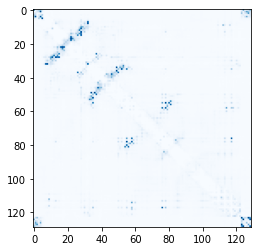

In [14]:
plt.imshow(esm1b_contacts[0][:seqlen, :seqlen],cmap="Blues")

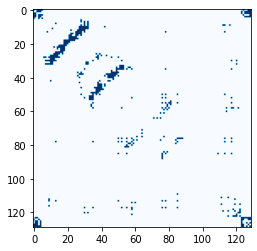

In [15]:
plt.imshow(esm1b_contacts[0][:seqlen, :seqlen]>0.1,cmap="Blues")

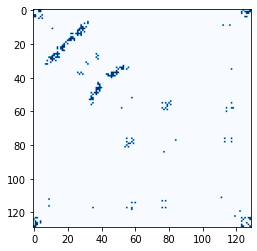

In [16]:
plt.imshow(esm1b_contacts[0][:seqlen, :seqlen]>0.2,cmap="Blues")

In [69]:
con1=esm1b_contacts[0].numpy()[:seqlen, :seqlen]>0.5
con2=esm1b_contacts[0].numpy()[:seqlen, :seqlen]>0.2

In [71]:
con1=np.multiply(con1,1)
con2=np.multiply(con2,1)
con2

array([[1, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 1, 1, ..., 1, 0, 0],
       [0, 1, 1, ..., 0, 1, 0],
       [1, 1, 0, ..., 0, 0, 1]])

In [19]:
con1

array([[1, 0, 1, ..., 0, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [0, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 1, 0, 1]])

In [27]:
con_diff=con2-con1

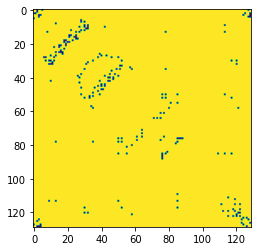

In [29]:
plt.imshow(con_diff)

In [89]:
con11=np.where(con1 == 1)

In [90]:
con11[0]

array([  0,   0,   1,   1,   2,   4,   4,   4,   5,   7,   8,  10,  11,
        12,  13,  14,  14,  15,  15,  16,  17,  17,  18,  22,  22,  22,
        23,  26,  26,  27,  27,  28,  28,  28,  28,  28,  32,  32,  32,
        33,  34,  34,  35,  35,  36,  37,  37,  38,  46,  49,  49,  50,
        51,  52,  53,  54,  55,  55,  55,  55,  56,  57,  58,  58,  58,
        76,  76,  76,  78,  78,  79,  80,  81,  81, 114, 117, 123, 123,
       123, 124, 124, 124, 126, 126, 127, 127, 127, 128, 128, 128])

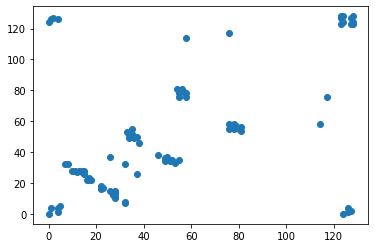

In [91]:
plt.scatter(con11[0],con11[1])

In [67]:
con1

array([[1, 0, 1, ..., 0, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [0, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 1, 0, 1]])

In [68]:
con2

array([[1, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 1, 1, ..., 1, 0, 0],
       [0, 1, 1, ..., 0, 1, 0],
       [1, 1, 0, ..., 0, 0, 1]])

In [66]:
con1-con2

array([[0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 0]])

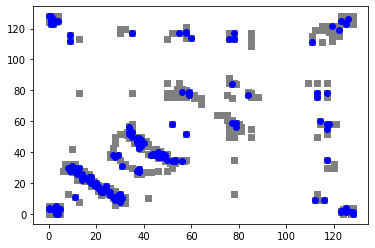

In [81]:
scatter1 = plt.scatter(con11[0],con11[1],c='grey',marker=",")
fps=np.where(con1-con2==-1)
tps=np.where(con2-con1==-1)
scatter2 = plt.scatter(fps[0],fps[1],c='blue', marker="o")
#scatter3=plt.scatter(tps[0],tps[1],c='blue', marker="o")
ax1 = scatter1.axes
ax1.invert_yaxis()
ax2 = scatter2.axes
ax2.invert_yaxis()

# ax3 = scatter3.axes
# ax3.invert_yaxis()

In [88]:
len(fps[0])

150

AttributeError: module 'matplotlib.cm' has no attribute 'blues'

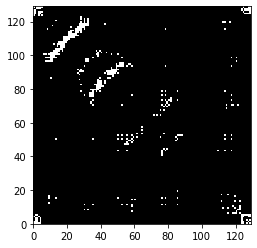

In [31]:
extent = 0, seqlen, 0, seqlen
fig = plt.figure(frameon=False)


im1 = plt.imshow(con1, cmap=plt.cm.gray, interpolation='nearest',
                 extent=extent)



im2 = plt.imshow(con2, cmap=plt.cm.blues, interpolation='bilinear',
                 extent=extent)

plt.show()

ValueError: x and y must be the same size

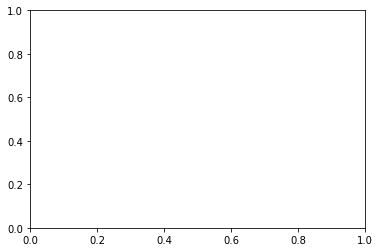

In [39]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(con1[:0], con1[:1], s=10, c='b', marker="s", label='first')
ax1.scatter(con2[:0], con2[:1], s=10, c='r', marker="o", label='second')
plt.legend(loc='upper left');
plt.show()

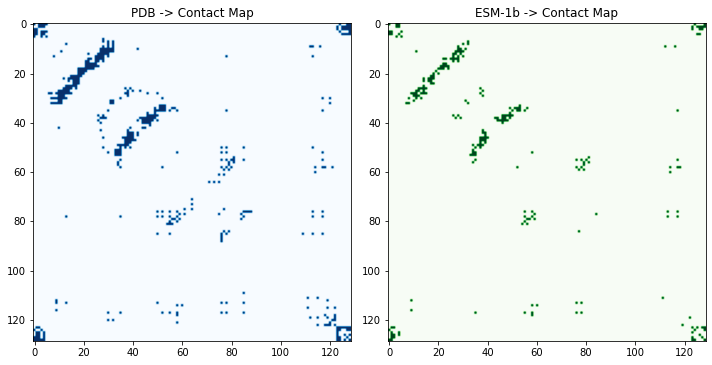

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
#fig.suptitle(title_text, fontsize=14,fontweight='bold')
ax[0].title.set_text('PDB -> Contact Map')
ax[0].imshow(con1,cmap="Blues")
ax[1].title.set_text('ESM-1b -> Contact Map')
ax[1].imshow(con2,cmap="Greens")
#resultstr = 'Metrics\nAccuracy:%.2f'%(acc)
#ax[1].text(contact_esm.shape[0]+15, contact_esm.shape[0]/2+15, resultstr, fontsize=12)
fig.tight_layout()
#final_result_path=results_path+pdb_name+".pdf"

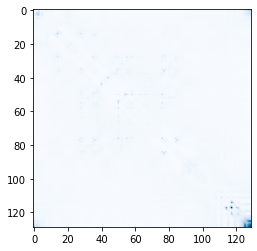

In [179]:
plt.imshow(esm1b_contactsa[0][:seqlen, :seqlen],cmap="Blues")

In [27]:
PDB_IDs=["2D9Z"]

In [49]:
number_PDBs = len(PDB_IDs)

for i in range(number_PDBs):
    print(i)
    PDB_IDs_lower = str(PDB_IDs[i]).lower()
    PDB_file = f'//Users/rohan/Desktop/DTI_setup/data_main/test/pdb{PDB_IDs_lower}.ent'
    PDB_check = open(PDB_file, 'r')
    print(PDB_file)
    if os.path.isfile(PDB_file):
        print('Creating PCN object.')
        protein_contact_network = PCN.PCN(PDB_file)
        print(protein_contact_network)
        C_alphas = protein_contact_network.get_C_alphas()
        chain_length = protein_contact_network.get_chain_length(C_alphas)
        print(chain_length)
        print(C_alphas)
        print(type(C_alphas))

0
//Users/rohan/Desktop/DTI_setup/data1/test/pdb2d9z.ent
Creating PCN object.


129
<AtomGroup [<Atom 2: CA of type C of resname GLY, resid 1 and segid A and altLoc >, <Atom 9: CA of type C of resname SER, resid 2 and segid A and altLoc >, <Atom 20: CA of type C of resname SER, resid 3 and segid A and altLoc >, ..., <Atom 1948: CA of type C of resname SER, resid 127 and segid A and altLoc >, <Atom 1959: CA of type C of resname SER, resid 128 and segid A and altLoc >, <Atom 1970: CA of type C of resname GLY, resid 129 and segid A and altLoc >]>
<class 'MDAnalysis.core.groups.AtomGroup'>


In [7]:
PDB_file = '/Users/rohan/Desktop/DTI_setup/data1/test1/pdb3sjm.ent'
protein_contact_network = PCN.PCN(PDB_file)
print(protein_contact_network)
C_alphas = protein_contact_network.get_C_alphas()
if protein_contact_network.get_link_lengths(C_alphas) is not None:
    distance_matrix=protein_contact_network.get_link_lengths(C_alphas)
else:
    print('continu')

continu


In [50]:
PDB_file = f'//Users/rohan/Desktop/DTI_setup/data1/test/pdb{str(PDB_IDs[0]).lower()}.ent'
link_lengths,links,protein_graph,distance_matrix=protein_contact_network.get_link_lengths(C_alphas)

In [51]:
distance_matrix

array([[0., 0., 2., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 2., 0., 0.]])

In [52]:
np.max(distance_matrix)

114.0

In [66]:
np.unique(distance_matrix)

array([  0.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  32.,  35.,  36.,  38.,  45.,  46.,
        60.,  61.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,
        74.,  75.,  87.,  88.,  90.,  91.,  92.,  93., 107., 110., 111.,
       113., 114.])

In [69]:
contact_map = distance_matrix >= 8.0

In [151]:
contact_map1 = distance_matrix <= 8.0

In [154]:
contact_map2 = distance_matrix >= 8.0

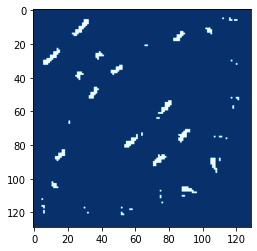

In [152]:
plt.imshow(contact_map1,cmap="Blues")

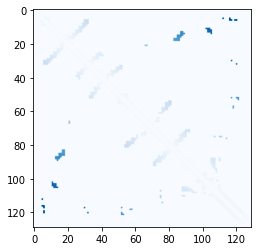

In [153]:
plt.imshow(distance_matrix,cmap="Blues")

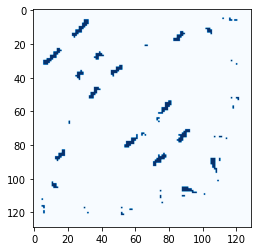

In [155]:
plt.imshow(contact_map2,cmap="Blues")

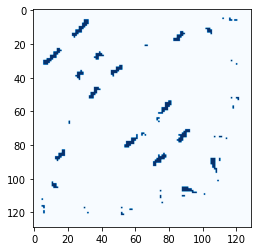

In [70]:
plt.imshow(contact_map,cmap="Blues")

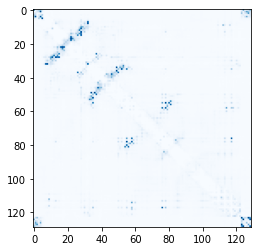

In [71]:
plt.imshow(esm1b_contacts[0][:seqlen, :seqlen],cmap="Blues")

In [195]:
torch.min(esm1b_contacts[0])

tensor(7.2548e-19)

In [198]:
torch.unique(esm1b_contacts[0])

tensor([7.2548e-19, 7.7604e-13, 5.9075e-12,  ..., 9.9985e-01, 9.9993e-01,
        1.0000e+00])

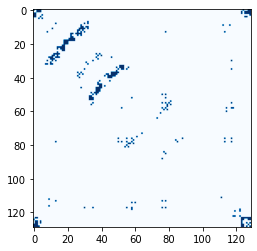

In [199]:
plt.imshow(esm1b_contacts[0][:seqlen, :seqlen]>=0.15,cmap="Blues")

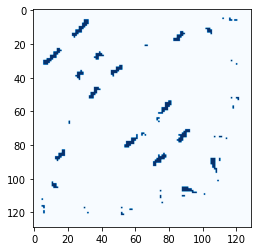

In [156]:
plt.imshow(contact_map2,cmap="Blues")

Text(0, 0.5, 'Damped oscillation')

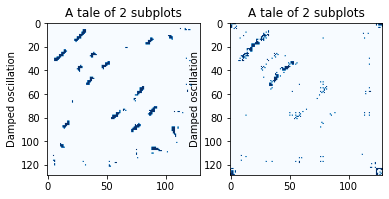

In [201]:

plt.subplot(1, 2, 1)
plt.imshow(contact_map2,cmap="Blues")
plt.title('A tale of 2 subplots')
plt.ylabel('Damped oscillation')

plt.subplot(1, 2, 2)
plt.imshow(esm1b_contacts[0][:seqlen, :seqlen]>=0.15,cmap="Blues")
plt.title('A tale of 2 subplots')
plt.ylabel('Damped oscillation')

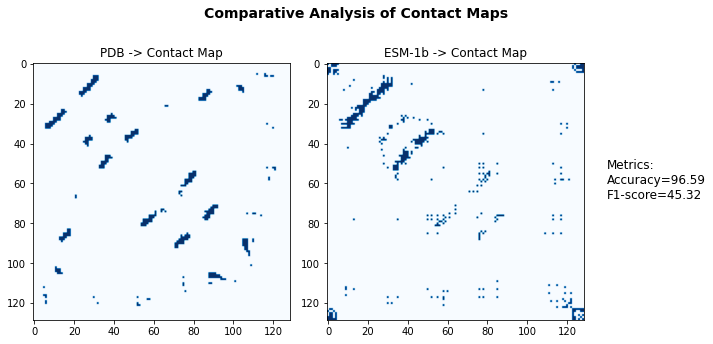

In [245]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle('Comparative Analysis of Contact Maps', fontsize=14,fontweight='bold',)
#fig.suptitle('Comparative Analysis of Contact Maps', fontsize=12,fontweight='bold')
ax[0].title.set_text('PDB -> Contact Map')
ax[0].imshow(contact_map2,cmap="Blues")
ax[1].title.set_text('ESM-1b -> Contact Map')
ax[1].imshow(esm1b_contacts[0][:seqlen, :seqlen]>=0.1,cmap="Blues")
acc=96.59
f1=45.32
textstr = 'Metrics:\nAccuracy=%.2f\nF1-score=%.2f\n'%(acc, f1)
ax[1].text(140, 75, textstr, fontsize=12)
fig.tight_layout()
fig.savefig("check_contacts1.png", bbox_inches='tight')

In [143]:
c1=esm1b_contacts[0][:seqlen, :seqlen]>=0.1
c2= contact_map

In [131]:
c1.numpy()

array([[ True, False, False, ..., False, False,  True],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       ...,
       [False,  True,  True, ...,  True, False, False],
       [False,  True,  True, ..., False,  True, False],
       [ True, False, False, ..., False, False,  True]])

In [188]:
c2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [84]:
c2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [95]:
c3=np.logical_and(c1.numpy(), c2)


In [96]:
c3

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [112]:
129*128/2

8256.0

In [109]:
c2[np.triu_indices(129,k=1)].shape

(8256,)

In [115]:
d2=c2[np.triu_indices(129,k=1)]

In [147]:
d1=c1.numpy()[np.triu_indices(129,k=1)]

In [119]:
seqlen

129

In [150]:
count=0
for i,j in enumerate(d1):
    if j==d2[i]:
        count=count+1
        


In [122]:
print("accuracy="+ str(count/))

accuracy=62.36434108527132


In [124]:
count/8256

0.9744428294573644

In [145]:
count/8256

0.9649951550387597

In [127]:
count1 = np.count_nonzero(d2)
count1

204

In [149]:
count2= np.count_nonzero(d1)
count2

223

In [162]:
d1

array([False,  True,  True, ..., False,  True, False])

In [164]:
e1=np.multiply(d1,1)
e1

array([0, 1, 1, ..., 0, 1, 0])

In [165]:
e2=np.multiply(d2,1)
e2

array([0, 0, 0, ..., 0, 0, 0])

In [166]:
from sklearn import metrics

In [172]:
conf_matrix = metrics.confusion_matrix(e2, e1)
conf_matrix

array([[7898,  154],
       [ 135,   69]])

In [171]:
print(metrics.classification_report(e2, e1))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8052
           1       0.31      0.34      0.32       204

    accuracy                           0.96      8256
   macro avg       0.65      0.66      0.65      8256
weighted avg       0.97      0.96      0.97      8256



In [207]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score
print(accuracy_score(e2, e1))
print(precision_score(e2, e1))
print(recall_score(e2, e1))
print(f1_score(e2, e1))
print(cohen_kappa_score(e2, e1))

0.9649951550387597
0.3094170403587444
0.3382352941176471
0.3231850117096019
0.3052544777318881


In [212]:
print(accuracy_score(e1, e2))
print(precision_score(e1, e2))
print(recall_score(e1, e2))
print(f1_score(e1, e2))
print(cohen_kappa_score(e1, e2))

0.9649951550387597
0.3382352941176471
0.3094170403587444
0.3231850117096019
0.3052544777318881


In [208]:
print(f1_score(e1, e2))

0.3231850117096019


In [100]:
np.where(c1.numpy()==c2)[0]

array([  0,   0,   0, ..., 128, 128, 128])

In [61]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [62]:
scaled_x = NormalizeData(distance_matrix)



In [63]:
print(scaled_x)

[[0.         0.         0.01754386 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.01754386 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.01754386]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.01754386 0.         0.        ]]


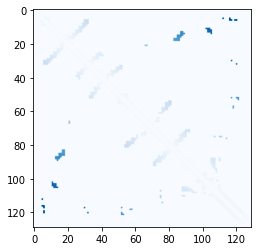

In [53]:
plt.imshow(distance_matrix,cmap="Blues")

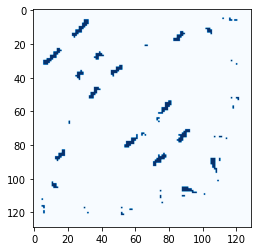

In [189]:
plt.imshow(c2,cmap="Blues")

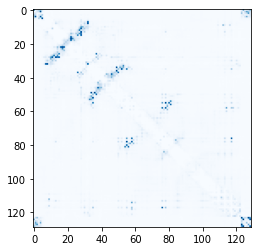

In [65]:
plt.imshow(esm1b_contacts[0][:seqlen, :seqlen],cmap="Blues")

In [9]:
plt.imshow(esm1b_contacts[0][:seqlen, :seqlen],cmap="Blues")

NameError: name 'esm1b_contacts' is not defined

In [37]:
prob=esm1b_contacts[0][:seqlen, :seqlen]
t = torch.Tensor([0.1])  # threshold
out = (prob > t).float() * 1

129

In [104]:
a="3KHF,3LQ3,3FEG,6YA6,2WWE,2IIM,4L0N,3WAR,2X18,7A22,7A1Z,7A2H,7A1B,1WYX,6Z19,3M9J,4YPD,6ELM,7D0E,2YJC,6YZH,6GY5,5JJ2,7CCW,2HSH,6RCH,6RCG,1KGD,3TW2,3O46,3I4W,6TSE,3S4E,3G36,6EGE,2QT1,6HOG,2QFA,2C60,2XRW,5GJH,6G9Z,5O8I,1LKK,4N6X,3ZYQ,2C01,4RFZ,3L46,5EP6,1EAZ,6KC4,6KEC,6KEI,5K26,6TT2,4EIH,5NP5,6B9X,3FIA,4LMM,2R3R,2R3I,6HOL,6J5S,5ED3,6TEW,4FKL,4EK4,4EK3,4P5Q,6HMB,6HMC,6HMD,4LDJ,4OBE,3LNY,3WA4,1OBX,5P21,5XRD,4YDP,4FH0,7F0W,6ZBK,3EAZ,3EAC,6Q4Q,5AUL,7L9M,6SRH,7M10,6Z36,6B42,5WA8,5WA9,5LR1,5XRE,5NYI,3Q6L,4MPA,2R3Q,2WP3,4RRV,6I5H,7REK,5W55,2BRF,4GRZ,3CZT,4N19,6VJJ,6G36,6HOI,5J1S,2YJ2,2YJ9,2YJ8,2YJB,2IZX,5ZCK,4FKU,5J1T,2OVJ,6RQW,6RQQ,6J65,6DMJ,6HYO,7AJN,6SE4,6S25,5O97,6ZED,6ZEL,6ZF9,6I7Y,6I7X,5E0R,4JL7,4Q3H,5KJZ,3K05,6ZVO,4HYI,5Y90,2NZL,2PEZ,2HC1,2HC2,7CIO,5FTG,6Y1J,1XD3,6J5Z,3CJW,6TGK,6HMT,2GCO,6FT8,5LXI,6G39,6G3A,4XX9,3BBB,6G37,6G38,5W2F,2VIF,6FBB,5KLY,5KM4,5XCO,6AC0,6FNI,4C6K,4C6J,4C6I,4C6F,4C6E,4C6D,4C6C,6FNK,6FNL,6FNJ,4X3K,1NTE,5J80,5J64,7AEW,6FCP,5P9K,4HCV,4HCU,4HCT,3KZD,2RGG,6Y8E,2A2A,7A2N,6QUW,6QUV,2FE5,3O3U,7A2S,7A2T,7A2R,7A2Z,4XOF,3KNB,1M9Z,1WMA,6FNM,6ZJE,2YEX,7NDY,2UV4,3MHR,3K82,7AAH,4HZR,4E1H,7B8H,6NMW,6QUU,4QTC,5HHE,5IO9,1W70,6ZRN,4BB9,5YWR,1GP0,6XXX,1D4T,4ZX2,1W1G,6G6K,3IQJ,7NPG,7NPB,7NP2,7NND,3A7I,4UU5,6M64,3NSZ,4QLI,6T29,7LB1,3GU6,3GU4,2OSS,3EYI,3U5L,1W1H,3G4E,3UVW,5DC4,6M5Y,5VBM,4KS7,5NNF,6H5W,2A2R,2OUR,4Y5I,5AV4,4DHR,7L9G,1WMS,1H8D,5ZN0,5ZN1,5ZN2,5E8X,3IQV,3IQU,6MV4,5J2X,4D3P,5DQY,5EOP,3CO1,7LAY,1PWA,5MSA,5KM2,4PF4,3BHY,3OT3,2DKO,3AJ4,6N7A,6S17,6S1B,6S1J,6S1H,6S14,3PA3,5CVG,5CSV,5OGJ,3L8Z,3TGP,2AFY,6LCB,5NNG,5CU6,1I73,1TGR,7REE,6YIA,7LL4,5E8S,5DK8,5D7F,2GBJ,6V6U,6V6V,2WWZ,1OKI,1PA7,4KWP,3BUX,4WNJ,3OBQ,2RGB,2RGE,5MOH,3W80,3TT8,5QU7,5QU4,5QU3,6V6M,5S9B,5S9C,5S9A,5S9J,5S9H,5S9I,5S9F,5S9G,5S9D,5S9E,5S92,5S93,5S8R,5S90,5S91,5S8Y,5S8Z,5S98,5S8W,5S99,5S8X,5S8U,5S97,5S8V,5S94,5S8S,5S95,5S8T,3EY6,5ELQ,5OHH,7B13,4O71,6L1S,6LVQ,7C8S,6QJL,6QJK,5OUL,5OTQ,5OTY,5OTZ,6EHK,5H8X,1UZK,3P34,7S5A,4LM4,4LM3,2QUZ,1MFG,6BLN,6BKW,6PCL,6PCK,3SOV,5NK5,5NK6,5NK4,5NKA,5NKG,5NKH,5NKE,5NKF,5NKC,5NKD,4PQW,6FNG,6FNH,4RX5,6Q7C,6Q7B,6HEY,6Q7G,6Q7E,6Q7F,4HJP,3F66,5MXO,4WOH,1I76,5KUP,4XZF,6HEX,6HEV,6HEW,6HET,6HES,6Q3Y,4YLL,4YLK,4PS5,5QU1,6HRP,6HRT,6DI9,6DI5,5U9D,5E95,6DI0,6DI1,1KQ6,6X3P,3P1N,5L0S,4O7A,4O74,4O72,4O78,3TEM,6PKF,4CY7,6ICG,6TC2,4U7H,5NNE,5MME,1XOZ,1S1P,5OAZ,4Q26,5I9Y,6QHL,6UYZ,6V7S,6V7Q,5I9X,4UEH,5MYC,5MY9,5VBO,5I9V,7AV9,7BBO,4LYH,5WA5,6CJ2,6CD4,5I9W,1LF7,6GD3,6AC5,7L73,6J6M,6HFI,6HFE,3GJ0,4LUC,6HFU,6HFK,6HFL,6HFJ,6HFH,6HFS,6HFR,4X9J,5A1I,1TBF,6KUG,6E4F,6TJQ,4ZGG,3T0H,7RT1,7RT5,5P9M,5P9L,5P9I,5P9J,4J46,4J45,4J44,4J47,5S9K,5S8A,5S81,5S7N,5S7L,5S7M,5S7K,5S7Y,5S7W,5S85,5S7T,5S86,5S83,5S84,1WM3,1MH1,2VXT,5EMA,2B69,6HFP,6HFN,5F2E,7S6O,6OC0,6PHQ,6PHM,6PHN,3BER,3GHU,3GHT,3GHS,3GHR,3Q1I,3WHA,3B28,4QL3,4TQ9,4TQA,5YOV,6FQO,6FQU,5OWK,5EP7,5ENG,5MPN,5MMG,6O5W,6HFQ,6MJ7,5F62,5F63,5F60,5F61,4GA0,6W2G,4UFD,4M1Y,6MBU,4X2I,7C2Z,5LRL,6OLX,6N8X,4JV8,6FBW,5S7Z,5S7A,5S7H,5S7I,5S7F,5S7D,5S7E,5S7B,5S7C,5S7P,5S7O,5S7J,5S89,5S7X,5S87,5S7V,5S88,5S7R,5S7S,5S78,5S76,5S77,5S75,5V9U,6XXJ,6B0Y,5LVN,6FJT,5KM3,4J9E,4J9C,4BW1,6V0U,4J9F,7NFB,4CFL,4QC4,2X2A,6BOF,6P0J,1PIN,6P0K,6P0L,6HH2,3U2C,5KM9,4QBV,5KYC,6FAV,6FAW,6FAU,6PHO,6PHL,6PHI,4EO7,4ONM,5GOD,5GOB,5W7W,2OUS,6EDF,4QR5,4QR4,4QR3,4NUC,4NUE,4NUD,4UDW,4UE7,4UD9,5AHG,5AFY,5AF9,6FT3,6FT4,6FSY,6VUJ,4PCI,4PCE,6ZB3,6CZU,6PS9,6PRT,7O6K,7NSV,7O3A,7O3F,7O3P,7NR7,7NMH,7NLE,7NM3,7NK5,7NJB,7NK3,7BIQ,7BI3,7NYG,7NYE,7NZ6,7RXR,7RXS,4IOR,4IOO,4QZS,6AJV,6AJW,6VRD,6MBT,4J3I,5M39,4LYI,7MLS,7MLR,7MLQ,6YQO,6YQP,6YQN,5DW2,3T10,5D0C,4YH4,6E4A,5HM0,4Z1S,4Z1Q,6RWJ,6S6K,6U0D,6XUZ,6XVC,6XV3,6B0V,6G0R,4AW0,5J41,6ODG,6SZM,6G3R,6Y1E,5PYW,5PXB,5PXA,5PXL,5PY5,5PXT,5PXS,5PXN,5PWG,5PWF,5PX4,5PWS,5PX2,5PWR,5PX6,5PWU,5PAG,5PAV,5PAS,5PB2,5PAO,5PAX,5PAE,3T7L,6B1K,6B29,5V1Y,2GRR,5Z1S,5Z1T,6BCB,6CYH,5ENA,6HMU,2PPO,3BFO,6B26,2Y5F,2Y5H,2Y5G,5GWN,4EY1,4EY9,4EYD,2ERF,5QID,5QIE,5QIC,5QIH,5QIF,5QIG,2FGB,1ZQ5,5KYF,6YIM,6YIL,4NYW,4NYX,4NR7,5UG8,5UG9,7PBB,1Z70,3G9Y,6PHK,6LJW,6LJV,6LJT,4YUH,4YUG,4YUO,4YUL,4YUK,4YUJ,4YUI,6P7Z,6MBQ,7KTE,5WMJ,6GJ5,4XO6,4GQ4,4GPQ,4OG4,4OG6,6O53,4C9X,3EG3,5LMA,6DJC,5XHE,5KU3,5NWD,5NWG,7ROV,3I3S,5Y8C,6SQO,3RFE,4DLR,5KHM,6XDS,2FST,4WY4,5QU5,5HPR,5HGZ,6P0Z,6D31,2OMH,2ZHN,2FZD,4ONL,2X5Y,4JMG,5INB,4F3I,4YLQ,6R2W,2CLD,2CLC,2CL7,2CE2,2I5F,5GH9,2W73,1R8S,5V37,6TX8,4U1M,3ZM1,2HE4,5QU2,1P5F,2FR3,4J3Y,4UP0,4GRN,6G0S,2FZ8,7KT5,1CTQ,3BUW,7K5L,6G0P,4WJQ,5OCG,5M9O,2CL6,2EVW,6G0Q,3RS0,5C2K,7NEL,6G0O,5XCT,5XCQ,7KHL,5JFD,6T56,6T55,6T53,6YQV,6YHG,5A2M,6TKL,6TKG,6Y02,6VAJ,2ZQT,3Q27,6IPY,5F6Y,5F6V,5F6E,6HXU,4DRI,5HG8,4GR8,3PP2,6PAF,6G2N,4KNN,2ITK,2E3N,2E3P,7AVC,7ER8,2C9S,2C9U,2C9V,4HY4,1DG6,4AG1,3NCL,7KG8,4QUJ,5CQ2,3SJM,6QW3,6NV2,6QHM,5MM6,5MJT,5I88,5KTU,4FYO,5MPZ,5MQG,6I44,5B4O,5TIU,4PZ3,6RL3,5R8B,5R8A,5R8K,5R8I,5R8F,5R8G,5R8D,5R8E,5R8Q,5R8N,5R8O,5R8M,5R88,5R87,5R85,5UQA,1MFM,5COY,3UGC,3TOW,6O24,4JJE,3VXE,1OGW,1Z89,6TNQ,7NHU,2H3L,5NI9,5NIG,5NR4,4IUM,4N7F,5YQO,3SI4,6T4A,6T3Q,5LCE,3RMO,3RM2,3RM0,3QX5,3SV2,3T5F,5NL4,2UUJ,2UUF,2UUK,2CN0,3SXE,6Y3V,3H61,3H63,5UGG,5UGD,3H62,1I27,4IGH,6I42,5HKJ,3AP9,4LNP,4LN2,6BCD,5L0T,4NIB,5HRQ,1BKR,5TXY,5KFS,5KFN,7M7N,7M7M,7M84,7M7T,4HF3,6P0I,7RNU,6NSV,7NX1,5S8I,5S8J,5S8G,5S8H,5S8E,5S8F,5S8C,5S8D,5S8P,5S8M,5S8N,5S8K,5S8L,5RKU,5RKV,5RKS,5RKT,5RKQ,5RKR,5RKO,5RKP,5RKY,5RKW,5RKX,5RK5,5RJT,5RK6,5RJU,5RK3,5RJR,5RK4,5RJS,5RK1,5RJP,5RK2,5RJQ,5RJN,5RK0,5RJO,5RJZ,5RK9,5RJX,5RJY,5RK7,5RJV,5RK8,5RKE,5RKF,5RKC,5RKD,5RKA,5RKB,5RKM,5RKN,5RKK,5RKL,5RKI,5RKJ,5RKG,5RKH,5RJL,5RJM,5RJJ,5RJK,5ENE,5ENF,4DJC,4DAT,4INC,3LW1,1UNR,1P1V,2VR6,1OZU,3SXB,3SX8,3SX5,6LJE,4EEW,4WZX,2IKG,2IKI,7JGW,4GV1,6KX2,3WLU,4ICV,4OQV,6HYN,3CBP,4WK9,4WKH,4WKF,6XLV,4WJO,5UDP,5E50,1X96,1X98,3ONB,3ONC,2QJZ,4UZ1,4WW6,6XXC,6XY5,6Y18,6UYV,5KFZ,7MU3,5SYA,5SY9,5SY6,4P2G,3CZA,7AA7,6V1B,7RNS,6MX3,3HJ0,5MHC,4HI9,4HI8,4FRA,7B37,7ARG,7B3F,5W46,4P36,3CZ9,3CY6,2F3Y,7NYO,7NYK,5UUI,7QHG,4QSB,6Y3W,6Y1D,4PZH,4Q08,5N5W,3MC5,3M64,3M0I,3LEN,7O07,4DO4,4MZI,6FYR,3F1P,2IZR,7BRQ,5JNT,6L0X,6F4Q,7LIP,6D30,6D2Z,5JIX,6RJL,6RHC,7BF2,5NXI,6EIM,5JGI,5C7G,4U3Y,5CMM,6R8R,6GRO,2UYZ,7ABT,1QTN,1ZD8,4YPC,4YBM,5KH9,5B8D,4JJ7,3EWY,3EWX,4GAI,7AZ1,7AZ2,7AXN,7BG3,3MRK,5KTW,5KTX,6RA7,4NFN,6FEW,3DN5,5J0D,1T41,5MFA,5L0N,6TUZ,4OUF,2PIE,4QX5,2W4J,5I83,5I89,5I86,2WZB,3ZZY,4GWG,6MYE,5JAX,5J48,2QOC,3FED,2QOI,2QOK,2QOL,2QOO,2QOD,2QOF,5OQ5,6HB9,6FEX,3U9W,7L8Q,6B6U,3DJH,6N6K,5G4M,5G4N,7BF1,6FVF,3F1N,2VR8,7AT9,6ZEI,5FAF,6QHJ,6G8L,6G8J,6G8K,6G6X,6GUK,1MKK,6TLS,5QIT,5QIR,5QIQ,5QIO,5QIX,5QIV,3HSV,6AY5,4R1V,7SUG,7SUF,4P2K,3ZCL,6XZZ,6XYX,7PD9,5THN,6Q4F,6Q3F,6Q3C,6OMU,6Q4H,6Q4I,6Q4D,6Q4E,6Q4B,6Q4J,6Q4K,6Q3B,6Q48,6Q49,4HBQ,3MI2,6Q4A,5A7G,5YP8,6FCH,2VZC,6ESM,5LCP,7B9T,7B9R,7BA8,7BA7,7BA9,7BAB,7BAA,7BA3,7BA6,7BA5,7NIZ,7NFW,5M6V,6O8I,6G5P,7KSW,5M71,5M6Y,5M0L,5LCQ,5LBZ,5LBY,7L67,7L64,7N5O,7KXM,7KXQ,7KXN,1H10,6OSH,6OSN,6OSV,4GCJ,6E28,1GK7,1Z0J,5MHQ,5TZM,5EHW,5EHV,6R8P,6TJT,6ZTB,7KT0,7KSZ,5KO0,6VXQ,4CT2,6NFH,5ACK,5YVN,1GZ8,7B2V,7B2Y,5LVL,5YP7,3SX7,3SX3,5LVM,6SI3,6SI1,6SHZ,7OFV,4XCT,5W3R,3CBZ,6O4J,5WAA,2V0A,6ZK0,3I0G,5ZMZ,6YQM,5BXC,5C49,5LVO,3FEC,7PB5,7P9R,5LO5,5MRD,2YI7,3NHE,1LZI,1LZJ,7RXV,4XJJ,6TN5,6TN4,6W2I,3MYQ,3D06,3D08,7LIN,6YHA,5G4O,6V4F,5LL4,6N6I,1RG8,4RI5,6YQ2,6YPY,6YOW,7O6M,7O6J,7NV4,7O6O,7O57,7O59,7NQP,7O34,7NLA,7NM1,7NJ9,7BKH,7BJF,7BJL,7BJW,7BIW,7NZK,7NZG,7NZV,7NYF,7NXW,7NXY,7NY4,7NXS,7NXT,7NWS,7NVI,4N12,7KT2,4OQ4,5JO3,7KTG,7KTN,7KT9,3EZG,1SOA,4BCY,6YOJ,7LH7,3SP7,4X2F,6N3X,6N3V,3OIU,3OIW,4EPV,6GPO,7RPZ,1UYL,5BN8,6PQA,7A1X,6MS9,3VHA,2CIA,4BTE,4PQD,6E5Z,4S0Z,4MTC,3VHC,2YKJ,2YKE,2YK9,3O0I,2OR3,3F71,6GQS,6GR5,2GZV,6AX4,4N1M,4N1S,6HXM,6HXL,4Z93,3WUZ,4LR6,5KMC,4Q27,4Q2F,4Q1R,4Q1P,5MWX,6G0D,7NZD,7NZC,5K7N,5DRS,3FF3,6QL2,6QL3,6O5I,6MQT,1L3K,4U1P,5M33,6T5B,6T5V,6TAN,4QTA,6ZCS,5J0F,4PZZ,4Q03,4Q01,4X9V,4X9R,6G0G,6BQA,4ZZN,3K0N,3K0M,5TA2,5T9Z,5V5C,6GGF,5O1I,6GGC,6GGD,6GGB,5O1G,5O1D,5O1E,5O1B,5O1A,5O1H,5AOK,5LUD,5NOY,5NOW,5NOX,5NOU,5NOS,5NOT,6TKK,6SLG,6X3Y,2X25,5WC7,5F66,4PWQ,3GP2,5MYX,5WP1,6GJL,6GJM,6GJJ,6GJY,6GS6,6AR0,4QTB,4YJR,4YJQ,5I2F,7B4N,7B49,7B4H,5UF0,6GBI,5AD3,4O6W,6YQZ,4HXS,4HXN,5CFW,6AJZ,5EI4,6SWN,4UIZ,4UIY,4CL9,6Z7M,6DL2,5A5S,1T7H,4UYD,6UWX,6UVJ,4CFQ,6TS3,7JKY,7JKX,7JKW,5LJ2,6FNX,7A9U,5XI4,6JJ5,6JJ6,7M16,7P6W,7P6V,4WHW,5S96,4Q7Z,5QS8,5QS9,5QSJ,3U2U,7LCU,3P6C,1X97,4XZH,4QX4,1PWL,4OEL,5IPC,5IPE,4GGC,3K8Y,4AOH,4GRR,4GRP,6YF2,6YF3,6YF1,5M9Q,5M9R,5MG7,5MCT,5WDQ,5WDP,6RWU,5H5Q,5H5R,4TNS,2RJ5,4A3P,7AC9,5EDC,5EDB,6YVK,6YVN,6YVL,6YVM,5I80,5HZ6,5HZ8,5N20,3RZY,3P6H,3P6G,3P6F,3P6E,3P6D,7KTF,5Z02,5ZXF,6FVH,6FVE,6TPZ,6TPX,4CFR,3I6C,3IJJ,5WMA,5WMG,5WMD,3TC5,5HGJ,6GX2,5NJ9,5NJA,6T52,6T3M,3U98,6I51,6YSJ,6YN3,6YMP,6YHJ,6YB6,6Y9H,5IBP,6GMC,6GMB,3EXX,3W7Z,6VET,4X5W,6S34,6VER,4XC4,5USV,5UU2,5URT,5USP,5UOZ,3U8R,4AJX,4R0U,6GV0,5I29,2BVR,2BVS,2ZFF,6OD3,4ZNN,4RIL,5C4M,2JKH,4QKZ,2J30,2J32,3KL6,5SVY,4FKA,6GBW,6ROT,5JZY,3P17,5R7W,6Y8I,4HK2,5NHU,6YSX,4IBY,5A7B,4AGQ,4AGO,3U8O,1HE4,5BT3,6NE2,5WL1,4GQR,4Z47,1C5L,2CF8,6SBO,6VIG,5C0F,5NVG,1J96,5L0V,2I7D,5TXD,3PZZ,3Q2X,5TOG,7CAP,4JTR,4JQA,6D3Y,5VOS,7KJM,1KJL,6UYR,6UYP,6OIZ,6NB9,5TOF,6T5G,6T27,6IBE,6X8H,4PUW,6TUF,6TUC,2AXI,6YBM,4Q2Q,6K39,5ONQ,5ONR,5ONP,5HOB,4D6A,6Q0M,6Q0N,6F4P,2RK6,5HOC,6T7Q,2AGT,3T42,3LZ3,3LQL,3LD5,3LBO,4NIN,6F8O,6F84,6F82,4OWZ,6BXX,2RK4,2RK3,2R8U,5EH7,5EH8,5EH5,6AFC,6AFJ,6AFD,6AF9,6AF7,2WD2,4CQ0,6GL8,5RJI,3MRG,6ZEG,5UL6,3D25,2WNV,4NIO,3UVC,5YBY,4ZSD,5CBT,6ALC,6F78,5I8G,5V8Q,6AY3,6AXQ,5W0E,6RT6,6RT4,6EW6,5ZGD,4GYX,6UGO,6I3E,6X8O,6E78,6E72,6T2K,6T2H,6SJA,7B9N,7B9I,7B84,7B7Y,7B86,7B8C,7B8A,7B8L,7B8M,7B45,7B3G,7BDA,7BDF,7BDC,7BDB,7BDD,7BD8,6ZVL,6YXI,6PJV,3SGP,6YSK,6TR7,6TR6,4OHA,5C5A,3ZME,5TZL,4A7V,4A7T,4A7S,4A7Q,4A7G,2WYT,6Z3V,6Z4G,6Z4O,6Z4K,5O3Y,6GGE,5O1F,5O1C,5AOJ,5AB9,5LAP,6MS7,2XJK,4WT2,4OGN,7KKN,2IFQ,3GZQ,5O5T,5OF0,4RMI,4RMH,4GQQ,2RJ4,4AVS,3D32,7AES,5EXN,2PZN,4QR6,4Q7B,4PUU,4RPQ,4YU1,4PRR,4PR4,4NKC,2PQ8,6YIP,4M5S,1RYO,4YS1,6D40,2PDG,2PDH,2PDL,1Z3N,3LQG,5KL3,4PK3,4PK2,4Q6S,2XG3,4UE1,1A7S,6HN3,7NUS,6Q9L,6Q9O"

In [105]:
pdb_list = a.split(",")

In [106]:
len(pdb_list)

1922

In [185]:
pdb_list

['3KHF',
 '3LQ3',
 '3FEG',
 '6YA6',
 '2WWE',
 '2IIM',
 '4L0N',
 '3WAR',
 '2X18',
 '7A22',
 '7A1Z',
 '7A2H',
 '7A1B',
 '1WYX',
 '6Z19',
 '3M9J',
 '4YPD',
 '6ELM',
 '7D0E',
 '2YJC',
 '6YZH',
 '6GY5',
 '5JJ2',
 '7CCW',
 '2HSH',
 '6RCH',
 '6RCG',
 '1KGD',
 '3TW2',
 '3O46',
 '3I4W',
 '6TSE',
 '3S4E',
 '3G36',
 '6EGE',
 '2QT1',
 '6HOG',
 '2QFA',
 '2C60',
 '2XRW',
 '5GJH',
 '6G9Z',
 '5O8I',
 '1LKK',
 '4N6X',
 '3ZYQ',
 '2C01',
 '4RFZ',
 '3L46',
 '5EP6',
 '1EAZ',
 '6KC4',
 '6KEC',
 '6KEI',
 '5K26',
 '6TT2',
 '4EIH',
 '5NP5',
 '6B9X',
 '3FIA',
 '4LMM',
 '2R3R',
 '2R3I',
 '6HOL',
 '6J5S',
 '5ED3',
 '6TEW',
 '4FKL',
 '4EK4',
 '4EK3',
 '4P5Q',
 '6HMB',
 '6HMC',
 '6HMD',
 '4LDJ',
 '4OBE',
 '3LNY',
 '3WA4',
 '1OBX',
 '5P21',
 '5XRD',
 '4YDP',
 '4FH0',
 '7F0W',
 '6ZBK',
 '3EAZ',
 '3EAC',
 '6Q4Q',
 '5AUL',
 '7L9M',
 '6SRH',
 '7M10',
 '6Z36',
 '6B42',
 '5WA8',
 '5WA9',
 '5LR1',
 '5XRE',
 '5NYI',
 '3Q6L',
 '4MPA',
 '2R3Q',
 '2WP3',
 '4RRV',
 '6I5H',
 '7REK',
 '5W55',
 '2BRF',
 '4GRZ',
 '3CZT',
 '4N19',
 

In [187]:
pdblist = biopy()
PDB_IDs = pdb_list
counter = 1
for PDB_ID in PDB_IDs:
    print(f'At entry {counter} out of {len(PDB_IDs)} entries.')
    pdblist.retrieve_pdb_file(pdb_code = PDB_ID, file_format = 'pdb', pdir = './data1/test1/')
    counter += 1

At entry 1 out of 1922 entries.
At entry 2 out of 1922 entries.
At entry 3 out of 1922 entries.
At entry 4 out of 1922 entries.
At entry 5 out of 1922 entries.
At entry 6 out of 1922 entries.
At entry 7 out of 1922 entries.
At entry 8 out of 1922 entries.
At entry 9 out of 1922 entries.
At entry 10 out of 1922 entries.
At entry 11 out of 1922 entries.
At entry 12 out of 1922 entries.
At entry 13 out of 1922 entries.
At entry 14 out of 1922 entries.
At entry 15 out of 1922 entries.
At entry 16 out of 1922 entries.
At entry 17 out of 1922 entries.
At entry 18 out of 1922 entries.
At entry 19 out of 1922 entries.
At entry 20 out of 1922 entries.
At entry 21 out of 1922 entries.
At entry 22 out of 1922 entries.
At entry 23 out of 1922 entries.
At entry 24 out of 1922 entries.
At entry 25 out of 1922 entries.
At entry 26 out of 1922 entries.
At entry 27 out of 1922 entries.
At entry 28 out of 1922 entries.
At entry 29 out of 1922 entries.
At entry 30 out of 1922 entries.
At entry 31 out of 

At entry 120 out of 1922 entries.
At entry 121 out of 1922 entries.
At entry 122 out of 1922 entries.
At entry 123 out of 1922 entries.
At entry 124 out of 1922 entries.
At entry 125 out of 1922 entries.
At entry 126 out of 1922 entries.
At entry 127 out of 1922 entries.
At entry 128 out of 1922 entries.
At entry 129 out of 1922 entries.
At entry 130 out of 1922 entries.
At entry 131 out of 1922 entries.
At entry 132 out of 1922 entries.
At entry 133 out of 1922 entries.
At entry 134 out of 1922 entries.
Desired structure doesn't exists
At entry 135 out of 1922 entries.
Desired structure doesn't exists
At entry 136 out of 1922 entries.
Desired structure doesn't exists
At entry 137 out of 1922 entries.
At entry 138 out of 1922 entries.
At entry 139 out of 1922 entries.
At entry 140 out of 1922 entries.
At entry 141 out of 1922 entries.
At entry 142 out of 1922 entries.
At entry 143 out of 1922 entries.
At entry 144 out of 1922 entries.
At entry 145 out of 1922 entries.
At entry 146 out 

At entry 236 out of 1922 entries.
At entry 237 out of 1922 entries.
At entry 238 out of 1922 entries.
At entry 239 out of 1922 entries.
At entry 240 out of 1922 entries.
At entry 241 out of 1922 entries.
At entry 242 out of 1922 entries.
At entry 243 out of 1922 entries.
At entry 244 out of 1922 entries.
At entry 245 out of 1922 entries.
At entry 246 out of 1922 entries.
At entry 247 out of 1922 entries.
At entry 248 out of 1922 entries.
At entry 249 out of 1922 entries.
Desired structure doesn't exists
At entry 250 out of 1922 entries.
At entry 251 out of 1922 entries.
At entry 252 out of 1922 entries.
At entry 253 out of 1922 entries.
At entry 254 out of 1922 entries.
At entry 255 out of 1922 entries.
At entry 256 out of 1922 entries.
At entry 257 out of 1922 entries.
At entry 258 out of 1922 entries.
At entry 259 out of 1922 entries.
At entry 260 out of 1922 entries.
At entry 261 out of 1922 entries.
At entry 262 out of 1922 entries.
At entry 263 out of 1922 entries.
At entry 264 ou

At entry 353 out of 1922 entries.
At entry 354 out of 1922 entries.
At entry 355 out of 1922 entries.
At entry 356 out of 1922 entries.
At entry 357 out of 1922 entries.
At entry 358 out of 1922 entries.
At entry 359 out of 1922 entries.
At entry 360 out of 1922 entries.
At entry 361 out of 1922 entries.
At entry 362 out of 1922 entries.
At entry 363 out of 1922 entries.
At entry 364 out of 1922 entries.
At entry 365 out of 1922 entries.
At entry 366 out of 1922 entries.
At entry 367 out of 1922 entries.
At entry 368 out of 1922 entries.
At entry 369 out of 1922 entries.
At entry 370 out of 1922 entries.
At entry 371 out of 1922 entries.
At entry 372 out of 1922 entries.
At entry 373 out of 1922 entries.
At entry 374 out of 1922 entries.
At entry 375 out of 1922 entries.
At entry 376 out of 1922 entries.
At entry 377 out of 1922 entries.
At entry 378 out of 1922 entries.
At entry 379 out of 1922 entries.
At entry 380 out of 1922 entries.
At entry 381 out of 1922 entries.
At entry 382 o

Desired structure doesn't exists
At entry 471 out of 1922 entries.
At entry 472 out of 1922 entries.
At entry 473 out of 1922 entries.
At entry 474 out of 1922 entries.
At entry 475 out of 1922 entries.
At entry 476 out of 1922 entries.
At entry 477 out of 1922 entries.
At entry 478 out of 1922 entries.
At entry 479 out of 1922 entries.
At entry 480 out of 1922 entries.
At entry 481 out of 1922 entries.
At entry 482 out of 1922 entries.
At entry 483 out of 1922 entries.
At entry 484 out of 1922 entries.
At entry 485 out of 1922 entries.
At entry 486 out of 1922 entries.
At entry 487 out of 1922 entries.
At entry 488 out of 1922 entries.
At entry 489 out of 1922 entries.
At entry 490 out of 1922 entries.
At entry 491 out of 1922 entries.
At entry 492 out of 1922 entries.
At entry 493 out of 1922 entries.
At entry 494 out of 1922 entries.
At entry 495 out of 1922 entries.
At entry 496 out of 1922 entries.
At entry 497 out of 1922 entries.
Desired structure doesn't exists
At entry 498 out

At entry 588 out of 1922 entries.
At entry 589 out of 1922 entries.
At entry 590 out of 1922 entries.
At entry 591 out of 1922 entries.
At entry 592 out of 1922 entries.
At entry 593 out of 1922 entries.
At entry 594 out of 1922 entries.
At entry 595 out of 1922 entries.
At entry 596 out of 1922 entries.
At entry 597 out of 1922 entries.
At entry 598 out of 1922 entries.
At entry 599 out of 1922 entries.
At entry 600 out of 1922 entries.
At entry 601 out of 1922 entries.
At entry 602 out of 1922 entries.
At entry 603 out of 1922 entries.
At entry 604 out of 1922 entries.
At entry 605 out of 1922 entries.
At entry 606 out of 1922 entries.
At entry 607 out of 1922 entries.
At entry 608 out of 1922 entries.
At entry 609 out of 1922 entries.
At entry 610 out of 1922 entries.
At entry 611 out of 1922 entries.
At entry 612 out of 1922 entries.
At entry 613 out of 1922 entries.
At entry 614 out of 1922 entries.
At entry 615 out of 1922 entries.
At entry 616 out of 1922 entries.
At entry 617 o

At entry 705 out of 1922 entries.
At entry 706 out of 1922 entries.
At entry 707 out of 1922 entries.
At entry 708 out of 1922 entries.
At entry 709 out of 1922 entries.
At entry 710 out of 1922 entries.
At entry 711 out of 1922 entries.
At entry 712 out of 1922 entries.
At entry 713 out of 1922 entries.
At entry 714 out of 1922 entries.
At entry 715 out of 1922 entries.
At entry 716 out of 1922 entries.
At entry 717 out of 1922 entries.
At entry 718 out of 1922 entries.
At entry 719 out of 1922 entries.
At entry 720 out of 1922 entries.
At entry 721 out of 1922 entries.
At entry 722 out of 1922 entries.
At entry 723 out of 1922 entries.
At entry 724 out of 1922 entries.
At entry 725 out of 1922 entries.
At entry 726 out of 1922 entries.
At entry 727 out of 1922 entries.
At entry 728 out of 1922 entries.
At entry 729 out of 1922 entries.
At entry 730 out of 1922 entries.
At entry 731 out of 1922 entries.
At entry 732 out of 1922 entries.
At entry 733 out of 1922 entries.
At entry 734 o

At entry 823 out of 1922 entries.
At entry 824 out of 1922 entries.
At entry 825 out of 1922 entries.
At entry 826 out of 1922 entries.
At entry 827 out of 1922 entries.
At entry 828 out of 1922 entries.
At entry 829 out of 1922 entries.
At entry 830 out of 1922 entries.
At entry 831 out of 1922 entries.
At entry 832 out of 1922 entries.
At entry 833 out of 1922 entries.
At entry 834 out of 1922 entries.
At entry 835 out of 1922 entries.
At entry 836 out of 1922 entries.
At entry 837 out of 1922 entries.
At entry 838 out of 1922 entries.
At entry 839 out of 1922 entries.
At entry 840 out of 1922 entries.
At entry 841 out of 1922 entries.
At entry 842 out of 1922 entries.
At entry 843 out of 1922 entries.
At entry 844 out of 1922 entries.
At entry 845 out of 1922 entries.
At entry 846 out of 1922 entries.
At entry 847 out of 1922 entries.
At entry 848 out of 1922 entries.
At entry 849 out of 1922 entries.
At entry 850 out of 1922 entries.
At entry 851 out of 1922 entries.
At entry 852 o

At entry 940 out of 1922 entries.
At entry 941 out of 1922 entries.
At entry 942 out of 1922 entries.
At entry 943 out of 1922 entries.
At entry 944 out of 1922 entries.
At entry 945 out of 1922 entries.
At entry 946 out of 1922 entries.
At entry 947 out of 1922 entries.
At entry 948 out of 1922 entries.
At entry 949 out of 1922 entries.
At entry 950 out of 1922 entries.
At entry 951 out of 1922 entries.
At entry 952 out of 1922 entries.
At entry 953 out of 1922 entries.
At entry 954 out of 1922 entries.
At entry 955 out of 1922 entries.
At entry 956 out of 1922 entries.
At entry 957 out of 1922 entries.
At entry 958 out of 1922 entries.
At entry 959 out of 1922 entries.
At entry 960 out of 1922 entries.
At entry 961 out of 1922 entries.
At entry 962 out of 1922 entries.
At entry 963 out of 1922 entries.
At entry 964 out of 1922 entries.
At entry 965 out of 1922 entries.
At entry 966 out of 1922 entries.
At entry 967 out of 1922 entries.
At entry 968 out of 1922 entries.
At entry 969 o

At entry 1057 out of 1922 entries.
At entry 1058 out of 1922 entries.
At entry 1059 out of 1922 entries.
At entry 1060 out of 1922 entries.
At entry 1061 out of 1922 entries.
At entry 1062 out of 1922 entries.
At entry 1063 out of 1922 entries.
At entry 1064 out of 1922 entries.
At entry 1065 out of 1922 entries.
At entry 1066 out of 1922 entries.
At entry 1067 out of 1922 entries.
At entry 1068 out of 1922 entries.
At entry 1069 out of 1922 entries.
At entry 1070 out of 1922 entries.
At entry 1071 out of 1922 entries.
At entry 1072 out of 1922 entries.
At entry 1073 out of 1922 entries.
At entry 1074 out of 1922 entries.
At entry 1075 out of 1922 entries.
At entry 1076 out of 1922 entries.
At entry 1077 out of 1922 entries.
At entry 1078 out of 1922 entries.
At entry 1079 out of 1922 entries.
At entry 1080 out of 1922 entries.
At entry 1081 out of 1922 entries.
At entry 1082 out of 1922 entries.
At entry 1083 out of 1922 entries.
At entry 1084 out of 1922 entries.
At entry 1085 out of

Desired structure doesn't exists
At entry 1172 out of 1922 entries.
At entry 1173 out of 1922 entries.
At entry 1174 out of 1922 entries.
At entry 1175 out of 1922 entries.
At entry 1176 out of 1922 entries.
At entry 1177 out of 1922 entries.
At entry 1178 out of 1922 entries.
At entry 1179 out of 1922 entries.
At entry 1180 out of 1922 entries.
At entry 1181 out of 1922 entries.
At entry 1182 out of 1922 entries.
At entry 1183 out of 1922 entries.
At entry 1184 out of 1922 entries.
At entry 1185 out of 1922 entries.
At entry 1186 out of 1922 entries.
At entry 1187 out of 1922 entries.
At entry 1188 out of 1922 entries.
At entry 1189 out of 1922 entries.
At entry 1190 out of 1922 entries.
At entry 1191 out of 1922 entries.
At entry 1192 out of 1922 entries.
At entry 1193 out of 1922 entries.
At entry 1194 out of 1922 entries.
At entry 1195 out of 1922 entries.
At entry 1196 out of 1922 entries.
At entry 1197 out of 1922 entries.
At entry 1198 out of 1922 entries.
At entry 1199 out of 1

At entry 1287 out of 1922 entries.
At entry 1288 out of 1922 entries.
At entry 1289 out of 1922 entries.
At entry 1290 out of 1922 entries.
At entry 1291 out of 1922 entries.
At entry 1292 out of 1922 entries.
At entry 1293 out of 1922 entries.
At entry 1294 out of 1922 entries.
At entry 1295 out of 1922 entries.
At entry 1296 out of 1922 entries.
At entry 1297 out of 1922 entries.
At entry 1298 out of 1922 entries.
At entry 1299 out of 1922 entries.
At entry 1300 out of 1922 entries.
At entry 1301 out of 1922 entries.
At entry 1302 out of 1922 entries.
At entry 1303 out of 1922 entries.
At entry 1304 out of 1922 entries.
At entry 1305 out of 1922 entries.
At entry 1306 out of 1922 entries.
At entry 1307 out of 1922 entries.
At entry 1308 out of 1922 entries.
At entry 1309 out of 1922 entries.
At entry 1310 out of 1922 entries.
At entry 1311 out of 1922 entries.
At entry 1312 out of 1922 entries.
At entry 1313 out of 1922 entries.
At entry 1314 out of 1922 entries.
At entry 1315 out of

At entry 1401 out of 1922 entries.
At entry 1402 out of 1922 entries.
At entry 1403 out of 1922 entries.
At entry 1404 out of 1922 entries.
At entry 1405 out of 1922 entries.
At entry 1406 out of 1922 entries.
At entry 1407 out of 1922 entries.
At entry 1408 out of 1922 entries.
At entry 1409 out of 1922 entries.
At entry 1410 out of 1922 entries.
At entry 1411 out of 1922 entries.
At entry 1412 out of 1922 entries.
At entry 1413 out of 1922 entries.
At entry 1414 out of 1922 entries.
At entry 1415 out of 1922 entries.
At entry 1416 out of 1922 entries.
At entry 1417 out of 1922 entries.
At entry 1418 out of 1922 entries.
At entry 1419 out of 1922 entries.
At entry 1420 out of 1922 entries.
At entry 1421 out of 1922 entries.
At entry 1422 out of 1922 entries.
At entry 1423 out of 1922 entries.
At entry 1424 out of 1922 entries.
At entry 1425 out of 1922 entries.
At entry 1426 out of 1922 entries.
At entry 1427 out of 1922 entries.
At entry 1428 out of 1922 entries.
At entry 1429 out of

At entry 1516 out of 1922 entries.
At entry 1517 out of 1922 entries.
At entry 1518 out of 1922 entries.
At entry 1519 out of 1922 entries.
At entry 1520 out of 1922 entries.
At entry 1521 out of 1922 entries.
At entry 1522 out of 1922 entries.
At entry 1523 out of 1922 entries.
At entry 1524 out of 1922 entries.
At entry 1525 out of 1922 entries.
At entry 1526 out of 1922 entries.
At entry 1527 out of 1922 entries.
At entry 1528 out of 1922 entries.
At entry 1529 out of 1922 entries.
At entry 1530 out of 1922 entries.
At entry 1531 out of 1922 entries.
At entry 1532 out of 1922 entries.
At entry 1533 out of 1922 entries.
At entry 1534 out of 1922 entries.
At entry 1535 out of 1922 entries.
At entry 1536 out of 1922 entries.
At entry 1537 out of 1922 entries.
At entry 1538 out of 1922 entries.
At entry 1539 out of 1922 entries.
At entry 1540 out of 1922 entries.
At entry 1541 out of 1922 entries.
At entry 1542 out of 1922 entries.
At entry 1543 out of 1922 entries.
At entry 1544 out of

At entry 1630 out of 1922 entries.
At entry 1631 out of 1922 entries.
At entry 1632 out of 1922 entries.
At entry 1633 out of 1922 entries.
At entry 1634 out of 1922 entries.
At entry 1635 out of 1922 entries.
At entry 1636 out of 1922 entries.
At entry 1637 out of 1922 entries.
At entry 1638 out of 1922 entries.
At entry 1639 out of 1922 entries.
At entry 1640 out of 1922 entries.
At entry 1641 out of 1922 entries.
At entry 1642 out of 1922 entries.
At entry 1643 out of 1922 entries.
At entry 1644 out of 1922 entries.
At entry 1645 out of 1922 entries.
At entry 1646 out of 1922 entries.
At entry 1647 out of 1922 entries.
At entry 1648 out of 1922 entries.
At entry 1649 out of 1922 entries.
Desired structure doesn't exists
At entry 1650 out of 1922 entries.
Desired structure doesn't exists
At entry 1651 out of 1922 entries.
At entry 1652 out of 1922 entries.
At entry 1653 out of 1922 entries.
At entry 1654 out of 1922 entries.
At entry 1655 out of 1922 entries.
At entry 1656 out of 192

At entry 1745 out of 1922 entries.
At entry 1746 out of 1922 entries.
At entry 1747 out of 1922 entries.
At entry 1748 out of 1922 entries.
At entry 1749 out of 1922 entries.
At entry 1750 out of 1922 entries.
At entry 1751 out of 1922 entries.
At entry 1752 out of 1922 entries.
At entry 1753 out of 1922 entries.
At entry 1754 out of 1922 entries.
At entry 1755 out of 1922 entries.
At entry 1756 out of 1922 entries.
At entry 1757 out of 1922 entries.
At entry 1758 out of 1922 entries.
At entry 1759 out of 1922 entries.
At entry 1760 out of 1922 entries.
At entry 1761 out of 1922 entries.
At entry 1762 out of 1922 entries.
At entry 1763 out of 1922 entries.
At entry 1764 out of 1922 entries.
At entry 1765 out of 1922 entries.
At entry 1766 out of 1922 entries.
At entry 1767 out of 1922 entries.
At entry 1768 out of 1922 entries.
At entry 1769 out of 1922 entries.
At entry 1770 out of 1922 entries.
At entry 1771 out of 1922 entries.
At entry 1772 out of 1922 entries.
At entry 1773 out of

At entry 1861 out of 1922 entries.
At entry 1862 out of 1922 entries.
At entry 1863 out of 1922 entries.
At entry 1864 out of 1922 entries.
Desired structure doesn't exists
At entry 1865 out of 1922 entries.
Desired structure doesn't exists
At entry 1866 out of 1922 entries.
Desired structure doesn't exists
At entry 1867 out of 1922 entries.
Desired structure doesn't exists
At entry 1868 out of 1922 entries.
At entry 1869 out of 1922 entries.
At entry 1870 out of 1922 entries.
At entry 1871 out of 1922 entries.
At entry 1872 out of 1922 entries.
At entry 1873 out of 1922 entries.
At entry 1874 out of 1922 entries.
At entry 1875 out of 1922 entries.
At entry 1876 out of 1922 entries.
At entry 1877 out of 1922 entries.
At entry 1878 out of 1922 entries.
At entry 1879 out of 1922 entries.
At entry 1880 out of 1922 entries.
At entry 1881 out of 1922 entries.
At entry 1882 out of 1922 entries.
At entry 1883 out of 1922 entries.
At entry 1884 out of 1922 entries.
At entry 1885 out of 1922 en

In [20]:
for i in pdb_list:
    print(i)

3KHF
3LQ3
3FEG
6YA6
2WWE
2IIM
4L0N
3WAR
2X18
7A22
7A1Z
7A2H
7A1B
1WYX
6Z19
3M9J
4YPD
6ELM
7D0E
2YJC
6YZH
6GY5
5JJ2
7CCW
2HSH
6RCH
6RCG
1KGD
3TW2
3O46
3I4W
6TSE
3S4E
3G36
6EGE
2QT1
6HOG
2QFA
2C60
2XRW
5GJH
6G9Z
5O8I
1LKK
4N6X
3ZYQ
2C01
4RFZ
3L46
5EP6
1EAZ
6KC4
6KEC
6KEI
5K26
6TT2
4EIH
5NP5
6B9X
3FIA
4LMM
2R3R
2R3I
6HOL
6J5S
5ED3
6TEW
4FKL
4EK4
4EK3
4P5Q
6HMB
6HMC
6HMD
4LDJ
4OBE
3LNY
3WA4
1OBX
5P21
5XRD
4YDP
4FH0
7F0W
6ZBK
3EAZ
3EAC
6Q4Q
5AUL
7L9M
6SRH
7M10
6Z36
6B42
5WA8
5WA9
5LR1
5XRE
5NYI
3Q6L
4MPA
2R3Q
2WP3
4RRV
6I5H
7REK
5W55
2BRF
4GRZ
3CZT
4N19
6VJJ
6G36
6HOI
5J1S
2YJ2
2YJ9
2YJ8
2YJB
2IZX
5ZCK
4FKU
5J1T
2OVJ
6RQW
6RQQ
6J65
6DMJ
6HYO
7AJN
6SE4
6S25
5O97
6ZED
6ZEL
6ZF9
6I7Y
6I7X
5E0R
4JL7
4Q3H
5KJZ
3K05
6ZVO
4HYI
5Y90
2NZL
2PEZ
2HC1
2HC2
7CIO
5FTG
6Y1J
1XD3
6J5Z
3CJW
6TGK
6HMT
2GCO
6FT8
5LXI
6G39
6G3A
4XX9
3BBB
6G37
6G38
5W2F
2VIF
6FBB
5KLY
5KM4
5XCO
6AC0
6FNI
4C6K
4C6J
4C6I
4C6F
4C6E
4C6D
4C6C
6FNK
6FNL
6FNJ
4X3K
1NTE
5J80
5J64
7AEW
6FCP
5P9K
4HCV
4HCU
4HCT
3KZD
2RGG
6Y8E
2A2A
7A2N


In [27]:
pdblist = biopy()
PDB_IDs = ["2D9Z",'3o96']
counter = 1
for PDB_ID in PDB_IDs:
    print(f'At entry {counter} out of {len(PDB_IDs)} entries.')
    pdblist.retrieve_pdb_file(pdb_code = PDB_ID, file_format = 'xml', pdir = './data1/test1/')
    counter += 1

At entry 1 out of 2 entries.
At entry 2 out of 2 entries.


In [24]:
biopy()

### Get FASTA and PDB files

In [ ]:
pdblist = biopy()
PDB_IDs = ["2D9Z",'3o96']
counter = 1
for PDB_ID in PDB_IDs:
    print(f'At entry {counter} out of {len(PDB_IDs)} entries.')
    pdblist.retrieve_pdb_file(pdb_code = PDB_ID, file_format = 'pdb', pdir = './data1/test1/')
    counter += 1

In [ ]:
### Get Downloaded PDB File and Fasta sequence

In [ ]:
for i in pdb_list:
    print(i)

In [256]:
def load_ESM_1b():
    esm1b, esm1b_alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
    esm1b = esm1b.eval().cpu()
    esm1b_batch_converter = esm1b_alphabet.get_batch_converter()
    return esm1b,esm1b_batch_converter

In [ ]:
C_alphas = protein_contact_network.get_C_alphas()
if protein_contact_network.get_link_lengths(C_alphas) is not None:
    distance_matrix=protein_contact_network.get_link_lengths(C_alphas)
else:
    print('continu')

In [8]:
def getContactMap_fromPDB(PDB_file):
    protein_contact_network = PCN.PCN(PDB_file)
    C_alphas = protein_contact_network.get_C_alphas()
    chain_length = protein_contact_network.get_chain_length(C_alphas)
    #distance_matrix=protein_contact_network.get_link_lengths(C_alphas)
    #print(np.unique(distance_matrix))
    if protein_contact_network.get_link_lengths(C_alphas) is not None:
        distance_matrix=protein_contact_network.get_link_lengths(C_alphas)
        contact_map = distance_matrix >= 8
        return contact_map
    else:
        return None
    
    

In [327]:
def getContactMap_fromESM(esm1b,esm1b_batch_converter,fasta_file):
    esm1b_data = [read_sequence(fasta_file),]
    esm1b_batch_labels, esm1b_batch_strs, esm1b_batch_tokens = esm1b_batch_converter(esm1b_data)
    esm1b_batch_tokens = esm1b_batch_tokens.cpu()
    esm1b_contacts = esm1b.predict_contacts(esm1b_batch_tokens).cpu()
    seqlen = len(esm1b_batch_strs[0])
    #contact_map=esm1b_contacts[0][:seqlen, :seqlen]>=0.1
    contact_map=esm1b_contacts[0][:seqlen, :seqlen]>=0.1
    contact_map=contact_map.numpy()
    return contact_map

In [288]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score

In [328]:
def compareContactMaps(contact_pdb,contact_esm,pdb_name,results_path):
    print(contact_pdb.shape[0],contact_esm.shape[0])
    if contact_pdb.shape[0]==contact_esm.shape[0]:
        contact_pdb_upperTraingle=contact_pdb[np.triu_indices(contact_pdb.shape[0],k=1)]
        contact_pdb_upperTraingle=np.multiply(contact_pdb_upperTraingle,1)
        contact_esm_upperTraingle=contact_esm[np.triu_indices(contact_esm.shape[0],k=1)]
        contact_esm_upperTraingle=np.multiply(contact_esm_upperTraingle,1)
        print(len(contact_pdb_upperTraingle),len(contact_esm_upperTraingle))
        #acc,f1,prec,rec=accuracy_score(contact_pdb_upperTraingle,contact_esm_upperTraingle),f1_score(contact_pdb_upperTraingle,contact_esm_upperTraingle),precision_score(contact_pdb_upperTraingle,contact_esm_upperTraingle),recall_score(contact_pdb_upperTraingle,contact_esm_upperTraingle)
        acc,f1=accuracy_score(contact_pdb_upperTraingle,contact_esm_upperTraingle),f1_score(contact_pdb_upperTraingle,contact_esm_upperTraingle)
        title_text='Analysis of Contact Maps- %s'%(pdb_name)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        fig.suptitle(title_text, fontsize=14,fontweight='bold')
        ax[0].title.set_text('PDB -> Contact Map')
        ax[0].imshow(contact_pdb,cmap="Blues")
        ax[1].title.set_text('ESM-1b -> Contact Map')
        ax[1].imshow(contact_esm,cmap="Blues")
        #resultstr = 'Metrics\nAccuracy:%.2f\nF1-score:%.2f\nPrecision:%.2f\nRecall:%.2f\n'%(acc,f1,prec,rec)
        #resultstr = 'Metrics\nAccuracy:%.2f\nF1-score:%.2f'%(acc,f1)
        resultstr = 'Metrics\nAccuracy:%.2f'%(acc)
        ax[1].text(contact_esm.shape[0]+15, contact_esm.shape[0]/2+15, resultstr, fontsize=12)
        fig.tight_layout()
        final_result_path=results_path+pdb_name+".pdf"
        fig.savefig(final_result_path, bbox_inches='tight')
    else:
        print('FASTA and PDB are differnet for' +str(pdb_name))

In [263]:
esm1b,esm1b_batch_converter=load_ESM_1b()

In [326]:
pdb_list.remove("4XZF")

In [321]:
if os.path.isfile('/Users/rohan/Desktop/DTI_setup/data1/test1/pdb2r3r.ent'):
    print("exists")
else:
    print("no")

exists


['3KHF',
 '3LQ3',
 '3FEG',
 '6YA6',
 '2WWE',
 '2IIM',
 '4L0N',
 '3WAR',
 '2X18',
 '7A22',
 '7A1Z',
 '7A2H',
 '7A1B',
 '1WYX',
 '6Z19',
 '3M9J',
 '4YPD',
 '6ELM',
 '7D0E',
 '2YJC',
 '6YZH',
 '6GY5',
 '5JJ2',
 '7CCW',
 '2HSH',
 '6RCH',
 '6RCG',
 '1KGD',
 '3TW2',
 '3O46',
 '3I4W',
 '6TSE',
 '3S4E',
 '3G36',
 '6EGE',
 '2QT1',
 '6HOG',
 '2QFA',
 '2C60',
 '2XRW',
 '5GJH',
 '6G9Z',
 '5O8I',
 '1LKK',
 '4N6X',
 '3ZYQ',
 '2C01',
 '4RFZ',
 '3L46',
 '5EP6',
 '1EAZ',
 '6KC4',
 '6KEC',
 '6KEI',
 '5K26',
 '6TT2',
 '4EIH',
 '5NP5',
 '6B9X',
 '3FIA',
 '4LMM',
 '2R3R',
 '2R3I',
 '6HOL',
 '6J5S',
 '5ED3',
 '6TEW',
 '4FKL',
 '4EK4',
 '4EK3',
 '4P5Q',
 '6HMB',
 '6HMC',
 '6HMD',
 '4LDJ',
 '4OBE',
 '3LNY',
 '3WA4',
 '1OBX',
 '5P21',
 '5XRD',
 '4YDP',
 '4FH0',
 '7F0W',
 '6ZBK',
 '3EAZ',
 '3EAC',
 '6Q4Q',
 '5AUL',
 '7L9M',
 '6SRH',
 '7M10',
 '6Z36',
 '6B42',
 '5WA8',
 '5WA9',
 '5LR1',
 '5XRE',
 '5NYI',
 '3Q6L',
 '4MPA',
 '2R3Q',
 '2WP3',
 '4RRV',
 '6I5H',
 '7REK',
 '5W55',
 '2BRF',
 '4GRZ',
 '3CZT',
 '4N19',
 

In [ ]:
PDB_IDs = pdb_list
results_path="/Users/rohan/Desktop/DTI_setup/results_main/"
for i,j in enumerate(PDB_IDs):
    print(PDB_IDs[i])
    PDB_IDs_lower = str(PDB_IDs[i]).lower()
    PDB_file = f'//Users/rohan/Desktop/DTI_setup/data1/test1/pdb{PDB_IDs_lower}.ent'
    fasta_file=f'//Users/rohan/Desktop/DTI_setup/data1/test2/{PDB_IDs[i]}_1.fasta'
    #PDB_check = open(PDB_file, 'r')
    if os.path.isfile(PDB_file) and os.path.isfile(fasta_file):
        contact_pdb=getContactMap_fromPDB(PDB_file)
        contact_esm=getContactMap_fromESM(esm1b,esm1b_batch_converter,fasta_file)
    #print(PDB_file)
#     if os.path.isfile(PDB_file) and os.path.isfile(fasta_file):
#         contact_pdb=getContactMap_fromPDB(PDB_file)
#         contact_esm=getContactMap_fromESM
        if contact_pdb is not None:
            compareContactMaps(contact_pdb,contact_esm,PDB_IDs[i],results_path)
        else: 
            continue

3KHF
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 54. 55. 56. 76.
 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89. 90. 91. 92.]
106 99
FASTA and PDB are differnet for3KHF
3LQ3


/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element X found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: X
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  53.  54.  55.  56.  57.
  60.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.
  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.
  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102.
 103. 104. 105. 106. 107. 108. 109. 110. 112. 113. 114. 117. 120. 121.
 127. 128. 129. 131. 132. 133. 134. 135. 136. 137. 138. 146. 148. 149.
 150. 151. 152. 153. 154. 155. 165. 166. 167. 168. 169. 170. 171.]
358 401
FASTA and PDB are differnet for3LQ3
3FEG
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  

130 105
FASTA and PDB are differnet for3M9J
4YPD
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.
  72.  73.  74.  75.  76.  77.  78.  81.  82.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  96.  97.  98. 101. 104. 105. 106. 107. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 123. 143. 146.
 149. 150. 153. 156. 157. 158. 166. 170. 171.]
316 294
FASTA and PDB are differnet for4YPD
6ELM
[ 0.  2.  3.  4.  5.  6.  7.  9. 10. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 71. 72. 73. 74. 75. 76. 77. 78. 80. 84.]
105 98
FASTA and PDB are differnet for6ELM
7D0E
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


96 93
FASTA and PDB are differnet for3O46
3I4W
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 61. 66. 67. 68. 69. 70. 71. 72. 73.
 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86.]
99 104
FASTA and PDB are differnet for3I4W
6TSE
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  50.  51.  52.  53.  55.  56.  57.  60.  61.  66.  67.  69.  70.
  71.  72.  73.  74.  75.  84.  85.  86.  94.  95.  96.  97.  98.  99.
 100. 101. 102. 103. 104. 116. 126. 127. 128. 129. 130. 131.]
166 169
FASTA and PDB are differnet for6TSE
3S4E
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  22.  23.  24.  25.  28.  29.  30.  31.
  32.  33.  34.  35.  36

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


52 55
FASTA and PDB are differnet for3G36
6EGE
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  65.  66.  67.  68.  69.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  87.  93.  94.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 109. 113. 128. 129. 130.
 131. 132. 139. 142. 143. 146. 149. 150. 153. 156. 157. 160.]
284 302
FASTA and PDB are differnet for6EGE
2QT1


/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element X found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: X
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  15.  16.
  17.  18.  19.  22.  23.  24.  25.  26.  27.  28.  29.  30.  33.  40.
  41.  42.  44.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.
  63.  64.  65.  66.  67.  72.  76.  77.  78.  80.  81.  82.  83.  84.
  85.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96. 102. 103. 104.
 105. 106. 107. 108. 109. 110. 111. 113. 114. 115. 116. 117. 118. 119.
 144. 160. 161. 162. 164. 165. 193.]
202 207
FASTA and PDB are differnet for2QT1
6HOG
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  67.  68.  69.  71.  74.  75.  76.  77.  78.  79.  80.  81.
  82.  87.  89.  90.  91.  92.  93.  94.  95.  97.  98. 115. 123.]
132 129
FASTA and PDB are differnet for6HOG
2QFA
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element X found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: X
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


94 112
FASTA and PDB are differnet for3L46
5EP6
[0. 2. 3. 4. 5. 6.]
41 47
FASTA and PDB are differnet for5EP6
1EAZ
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 32. 36. 37. 38. 41. 42. 50. 51.
 53. 64. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 86. 89. 90.]
103 125
FASTA and PDB are differnet for1EAZ
6KC4
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 29. 32. 46. 50. 51. 67. 68. 69. 70. 71. 72.
 73. 74. 75. 77. 78. 90. 91. 92. 93. 94.]
102 102
5151 5151
6KEC
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  14.  16.
  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  36.  37.  39.  40.  41.  44.  45.  46.  47.  48.
  49.  51.  52.  54.  55.  58.  59.  60.  61.  62.  63.  64.  65.  66.
  67.  68.  69.  70.  71.  72.  73.  75.  76.  78.  81.  84.  85.  89.
  92.  93. 101. 102. 104. 105. 106. 107.]
126 127
FASTA and PD

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


100 121
FASTA and PDB are differnet for3FIA
4LMM
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 45. 46. 51. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79.
 80. 81. 82. 83. 84. 85. 86. 87.]
97 91
FASTA and PDB are differnet for4LMM
2R3R
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  71.  72.  73.  75.  80.  81.
  82.  83.  84.  85.  86.  87.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 106. 107. 108. 110. 136. 137. 138. 139.
 140. 141. 144. 146. 157. 158. 159. 160. 161. 162. 163. 164. 167. 168.
 169. 171. 172. 173. 175. 176. 179. 184. 187. 188. 190. 191. 192. 193.
 194. 195. 1

[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  79.  81.  82.  83.  84.  85.  86.  87.  89.
  90.  91.  93.  94.  95.  98.  99. 101. 102. 103. 104. 105. 106. 107.
 108. 109. 110. 111. 112. 113. 114. 116. 141. 142. 143. 144. 145. 146.
 147. 167. 168. 170. 171. 172. 175. 176. 177. 179. 180. 181. 182. 183.
 185. 186. 187. 188. 189. 190. 193. 199. 202. 203. 205. 206. 208. 209.
 212. 213. 214. 215. 216. 269. 270. 318. 319. 320. 321. 322. 323. 324.]
349 365
FASTA and PDB are differnet for6HMD
4LDJ
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: CD
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


99 98
FASTA and PDB are differnet for3WA4
1OBX
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 56. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.]


/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: CO
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


74 79
FASTA and PDB are differnet for1OBX
5P21
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  37.  38.  39.  40.  41.  42.  43.
  46.  47.  48.  49.  50.  51.  52.  53.  56.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  85.  86.  87. 101. 102. 103. 111. 118. 119. 120. 124. 126. 127. 128.
 129. 130. 131. 133. 156.]
166 166
13695 13695
5XRD
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  49.  50.  53.  54.  55.  56.  57.  58.  59.  60.
  68.  83.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 106. 107. 108. 109. 110. 111. 112.
 114. 115. 116. 117. 128. 132. 135. 136. 138. 139

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


99 102
FASTA and PDB are differnet for4FH0
7F0W
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  25.  26.  27.  28.  29.  30.  31.
  32.  33.  34.  35.  36.  38.  39.  40.  41.  42.  43.  46.  47.  48.
  49.  50.  51.  52.  53.  54.  57.  58.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  76.  77.  78.  79.  80.  81.  82.  83.  84.  86.
  87.  88. 103. 104. 105. 111. 112. 114. 115. 125. 127. 128. 129. 130.
 131. 133. 134. 158. 161.]
169 169
14196 14196
6ZBK
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 35.]
117 123
FASTA and PDB are differnet for6ZBK
3EAZ
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 30. 33. 34. 45. 46. 48. 50. 66.
 67. 68. 69. 70. 71. 76. 78. 79. 93. 94. 95. 96. 97.]
107 106
FASTA and PDB are differnet for3EAZ
3EAC
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 

298 299
FASTA and PDB are differnet for2R3Q
2WP3
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 67. 73. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.]
104 109
FASTA and PDB are differnet for2WP3
4RRV
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  60.  61.  62.  63.  64.  65.  66.  67.  68.  70.  71.  72.
  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  91.  93.
  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107.
 108. 109. 110. 112. 113. 137. 144. 148. 149. 150. 159. 167. 168. 170.
 171. 172. 173. 174. 175. 183. 184. 186. 187. 188. 18

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: CO
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  67.  69.  70.  71.  72.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 111. 114. 115. 118.
 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132.
 133. 134. 135. 139. 140. 141. 142. 143. 144. 145. 147. 148. 150. 151.
 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 165. 168. 171.
 172. 173. 174. 177.]
347 357
FASTA and PDB are differnet for6G36
6HOI
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  65. 

/var/folders/3h/x516l3bx56lc9gv2vh327x6w0000gn/T/ipykernel_40809/1834176662.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


4FKU
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  69.  76.  77.
  78.  79.  82.  84.  85.  86.  87.  88.  89.  90.  92.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 133. 136. 147. 148. 149. 152. 153. 165. 166. 167.
 168. 169. 170. 171. 172. 176. 177. 178. 180. 181. 182. 184. 185. 188.
 193. 197. 200. 201. 202. 203. 204. 205. 206. 207. 208. 224. 231. 232.]
314 299
FASTA and PDB are differnet for4FKU
5J1T
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  18.  19.  20.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  

91 91
4095 4095
4Q3H
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 42. 43. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78.
 79. 80. 81. 82. 83. 84.]
92 92
4186 4186
5KJZ
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  87.
  88.  92.  95.  96.  99. 106. 107. 108. 110. 111. 115. 116.]
155 150
FASTA and PDB are differnet for5KJZ
3K05
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  35.  36

243 230
FASTA and PDB are differnet for1XD3
6J5Z
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 32. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 44. 46. 47. 48. 49. 50. 51. 52. 53. 54. 56. 57. 58. 59.
 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 93. 94. 95. 96.
 97.]
120 128
FASTA and PDB are differnet for6J5Z
3CJW
[  0.   2.   3.   4.   5.   6.   7.   8.  10.  11.  12.  13.  14.  15.
  16.  17.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  36.  37.  38.  40.  41.  44.  47.  48.  49.  50.
  51.  53.  54.  55.  58.  59.  60.  61.  64.  65.  66.  67.  68.  70.
  71.  72.  73.  75.  78.  79.  83.  86.  87.  88.  89.  90.  93.  94.
  97.  98.  99. 101. 102. 103. 105. 106. 107. 108. 111. 127. 129. 130.
 131. 132. 133. 134. 135. 136. 137. 138. 139. 141. 142. 149. 150. 152.
 153. 155. 156. 158. 159. 161.]
207 244
FASTA and PDB are differnet for3CJW
6TGK
[ 0.  2.  3.  4.  5.  6.  

258 236
FASTA and PDB are differnet for6FBB
5KLY
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 31. 33. 35. 36. 37. 38. 39.
 40. 41. 42. 43. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 57. 58. 59. 60.
 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 93. 94. 95. 96. 97.
 98.]
120 129
FASTA and PDB are differnet for5KLY
5KM4
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 32. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57.
 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 92. 93. 94.
 95. 96.]
118 129
FASTA and PDB are differnet for5KM4
5XCO
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  49.  50.  51.  52.  53.

390 393
FASTA and PDB are differnet for4C6C
6FNK
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  71.  72.
  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.
  87.  88.  89.  92.  97.  98.  99. 100. 101. 102. 103. 104. 105. 107.
 108. 109. 125. 129. 132. 133. 135. 136. 137. 140. 141. 144. 148. 149.
 151. 152. 155. 156. 159. 162. 166.]
287 297
FASTA and PDB are differnet for6FNK
6FNL
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  6

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: NI
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


65 64
FASTA and PDB are differnet for4X3K
1NTE
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 51. 52. 56. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78.]
82 82
3321 3321
5J80
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  51.  52.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  69.  70.  73.  85.  86.  87.  88.  89.  90.  91.  92.
  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106.
 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 118. 119. 120. 121.
 131. 135. 137. 139. 140. 143. 144. 145. 146. 147. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 165. 166. 167. 168. 169. 170.
 172.]
215 225
FASTA and PDB are differnet f

580 581
FASTA and PDB are differnet for3O3U
7A2S
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 31. 32. 33. 34. 35. 47. 49. 50. 51.
 52. 53. 54. 55. 56. 57. 58. 59.]
63 62
FASTA and PDB are differnet for7A2S
7A2T
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 31. 32. 33. 34. 35. 36. 49. 50. 51.
 52. 53. 54. 55. 56. 57. 58. 59.]
62 61
FASTA and PDB are differnet for7A2T
7A2R
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 31. 32. 33. 34. 35. 46. 48. 49. 50. 51. 52.
 53. 54. 55. 56. 57. 58.]
63 62
FASTA and PDB are differnet for7A2R
7A2Z
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 29. 30. 31. 32. 33. 34. 45. 47. 48. 49. 50.
 51. 52. 53. 54. 55. 56. 57.]
60 60
1770 1770
4XOF
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 21.

168 187
FASTA and PDB are differnet for6QUU
4QTC
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  67.  68.  69.  70.  72.  79.  80.  82.  83.  84.  85.
  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99.
 100. 101. 102. 103. 104. 111. 112. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 132. 133. 134. 135. 136. 137. 143. 144. 145.
 146. 147. 148. 149. 152. 153. 154. 156. 157. 158. 159. 160. 161. 162.
 163. 164. 165. 166. 168. 169. 172. 173. 174. 179.]
349 357
FASTA and PDB are differnet for4QTC
5HHE
[0. 2. 3. 4. 5.]
94 93
FASTA and PDB are differnet for5HHE
5IO9
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 

/var/folders/3h/x516l3bx56lc9gv2vh327x6w0000gn/T/ipykernel_40809/1834176662.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


4ZX2


/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: MN
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  64.  69.  70.  71.  74.  75.  76.  77.  78.  79.  80.
  81.  82.  83.  84.  85.  86.  92.  99. 100. 103. 106. 107. 112. 114.
 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128.
 130. 143. 146. 147. 148. 149. 150. 151. 152. 161. 162. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 190. 191. 192. 205. 206. 208. 209.
 210. 211. 212. 213. 214. 215. 216. 217. 218. 219. 220. 222. 226. 227.
 228. 229. 230. 231. 232. 233. 234. 235. 236. 237. 238. 239. 240. 241.
 242. 243. 244. 245. 246.]
344 333
FASTA and PDB are differnet for4ZX2
1W1G
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 3

139 127
FASTA and PDB are differnet for3U5L
1W1H
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 45. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66.
 76. 79.]
147 151
FASTA and PDB are differnet for1W1H
3G4E
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  57.  58.  61.
  72.  73.  81.  82.  83.  84.  85.  86.  87.  88.  89.  93. 100. 101.
 144. 145. 150. 151. 152. 162. 163. 164. 165. 166. 187. 188. 189. 190.
 191. 192. 193. 194. 201. 202. 225. 229. 231. 232. 233. 234. 235. 236.
 237. 238. 239. 240. 241. 243. 244. 245. 246. 247. 248. 249. 250. 251.
 252. 253. 254. 255. 256. 268. 269. 270. 271. 272. 273. 274. 275. 276.
 277. 278. 279. 280. 281. 282. 283

276 235
FASTA and PDB are differnet for4DHR
7L9G
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  14.  15.
  17.  18.  19.  20.  21.  22.  23.  24.  26.  27.  28.  30.  31.  32.
  34.  35.  37.  38.  39.  42.  43.  49.  58.  60.  61.  62.  64.  69.
  70.  71.  73.  74.  77.  82.  85.  86.  90.  93.  94.  97.  98. 101.
 102. 104. 105. 106.]
110 114
FASTA and PDB are differnet for7L9G
1WMS
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  53.  54.  62.  63.  64.  65.  66.
  67.  68.  69.  70.  72.  75.  76.  78.  79.  80.  83.  84.  85.  86.
  87.  89.  90.  91. 101. 102. 103. 111. 119. 120. 124. 125. 126. 127.
 128. 129. 130. 131. 132. 134. 154. 157. 160.]
170 177
FASTA and PDB are differnet for1WMS
1H8D
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  1

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element D found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  71.
  77.  78.  79.  80.  82.  85.  86.  88.  89.  90.  91.  92.  93.  94.
  95.  96.  97.  98.  99. 100. 101. 102. 103. 107. 108. 109. 134. 135.
 136. 137. 138. 139. 157. 162. 163. 164. 165. 166. 167. 169. 170. 171.
 172. 174. 175. 176. 177. 178. 179. 182. 187. 190. 191. 193. 194. 196.
 197. 201. 202. 203. 204. 256. 257. 258. 259. 260. 261. 301. 302. 304.]
328 329
FASTA and PDB are differnet for5ZN0
5ZN1
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  

277 263
FASTA and PDB are differnet for5MSA
5KM2
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  46.  47.  48.  49.  50.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  98.  99. 100. 101. 102. 103.]
125 129
FASTA and PDB are differnet for5KM2
4PF4
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  63.  64.  65.  66.  67.  68.  69.  70.  71.
  72.  74.  75.  76.  78.  79.  80.  81.  82.  83.  84.  86.  87.  88.
  89.  94.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109.
 11

337 351
FASTA and PDB are differnet for5CVG
5CSV
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  74.  78.  79.  80.  81.  84.  86.  87.  88.  90.  91.  92.
  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 108.
 109. 110. 135. 136. 137. 138. 139. 140. 141. 159. 164. 165. 166. 167.
 168. 169. 172. 173. 174. 175. 177. 178. 179. 180. 181. 182. 185. 190.
 193. 194. 197. 198. 199. 200. 201. 203. 204. 205. 206. 259. 260. 261.
 262. 263. 264. 305. 306. 309.]
334 328
FASTA and PDB are differnet for5CSV
5OGJ
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  3

303 306
FASTA and PDB are differnet for5E8S
5DK8
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 43. 44. 60. 61. 62. 63. 64. 65.]
77 76
FASTA and PDB are differnet for5DK8
5D7F
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 21. 25. 26. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 40. 41. 42.
 43. 44. 45. 46. 47. 48. 60. 63. 67. 70. 71. 72. 73. 74. 75. 76. 77. 78.
 79. 80. 81. 82.]
103 92
FASTA and PDB are differnet for5D7F
2GBJ
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 42. 43. 67. 68. 69. 70. 71. 72.]
81 84
FASTA and PDB are differnet for2GBJ
6V6U
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  30.  31.  32.
  33.  34.  35.  36.  37.  38.  40.  41.  43.  44.  45

125 149
FASTA and PDB are differnet for5S9C
5S9A
[  0.   2.   3.   4.   5.   6.   7.   8.  10.  11.  12.  15.  16.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  31.  32.
  33.  35.  36.  37.  38.  39.  40.  41.  43.  44.  46.  47.  49.  50.
  51.  55.  58.  59.  65.  71.  72.  73.  75.  76.  82.  86.  90.  93.
  94.  97. 101. 102. 105. 106. 108. 109. 110. 111. 112. 113. 114. 115.
 116. 117. 118. 119. 121. 122.]
125 149
FASTA and PDB are differnet for5S9A
5S9J
[  0.   2.   3.   4.   5.   6.   7.   8.  10.  11.  12.  15.  16.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  31.  32.
  35.  37.  38.  39.  40.  42.  43.  45.  46.  47.  48.  49.  50.  54.
  57.  58.  64.  70.  71.  72.  74.  75.  81.  85.  89.  92.  93.  96.
 100. 101. 104. 105. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116.
 117. 119. 120.]
123 149
FASTA and PDB are differnet for5S9J
5S9H
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  11.  12.  14.  15.  16.
  17.  18.  19.  20.  2

125 149
FASTA and PDB are differnet for5S8U
5S97
[  0.   2.   3.   4.   5.   6.   7.   8.  10.  11.  12.  15.  16.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  31.  32.
  35.  36.  37.  38.  39.  40.  41.  43.  44.  46.  47.  49.  50.  51.
  55.  58.  59.  65.  71.  72.  73.  75.  76.  82.  86.  90.  93.  94.
  97. 101. 102. 105. 106. 108. 109. 110. 111. 112. 113. 114. 115. 116.
 117. 118. 120. 121.]
124 149
FASTA and PDB are differnet for5S97
5S8V
[  0.   2.   3.   4.   5.   6.   7.   8.  10.  11.  12.  15.  16.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  30.  31.  34.
  36.  37.  38.  39.  40.  43.  45.  46.  48.  49.  50.  55.  58.  59.
  64.  70.  71.  72.  74.  75.  77.  78.  81.  85.  89.  92.  93.  96.
 100. 101. 104. 105. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116.
 117. 119. 120.]
123 149
FASTA and PDB are differnet for5S8V
5S94
[  0.   2.   3.   4.   5.   6.   7.   8.  10.  11.  12.  15.  16.  17.
  18.  19.  20.  21.  22.  23.  2

340 342
FASTA and PDB are differnet for5OTQ
5OTY
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  79.  80.  81.  82.  85.  86.  87.  88.  89.  91.  92.  93.  94.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 109. 110. 111. 137.
 138. 139. 140. 141. 142. 143. 159. 166. 167. 168. 169. 170. 173. 174.
 175. 176. 178. 179. 180. 181. 182. 183. 186. 191. 195. 196. 199. 200.
 201. 202. 203. 205. 206. 207. 208. 262. 263. 264. 265. 266. 267. 308.
 309. 312.]
337 342
FASTA and PDB are differnet for5OTY
5OTZ
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  3

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


153 162
FASTA and PDB are differnet for1UZK
3P34
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  24.  34.  35.  38.  46.  47.  48.
  49.  52.  56.  58.  59.  60.  61.  62.  64.  65.  66.  67.  68.  70.
  71.  72.  73.  74.  75.  77.  78.  79.  80.  81.  82.  83.  91.  92.
  93.  94.  95.  96.  97. 100. 101. 122. 123. 134. 137. 139. 145. 147.
 148. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170.
 171. 172. 173. 174. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185.
 186. 187. 188. 189. 190. 191. 192. 195. 198. 199. 203. 204. 206. 207.
 210. 211. 213. 214. 215. 216. 219. 222. 223.]
236 232
FASTA and PDB are differnet for3P34
7S5A
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 31. 32. 33. 37. 38. 39. 40.
 41. 42. 43. 44. 45. 46.]
77 76
FASTA and PDB are differnet for7S5A
4LM4


/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: NI
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  52.  53.  54.  55.  56.  57.  58.
  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.
  73.  74.  75.  76.  77.  79.  80.  85.  87.  88.  90.  91.  92.  94.
  95.  97.  98.  99. 100. 101. 102. 103. 106. 107. 108. 110. 113. 125.
 126. 127. 128. 129. 130. 132. 133. 136. 137. 139. 140. 141. 142. 143.
 144. 150. 153. 154. 164. 167. 168. 169. 170. 171. 172. 173. 201. 202.
 203. 204. 205. 206. 207. 208. 275. 276.]
330 345
FASTA and PDB are differnet for4LM4
4LM3
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  52.  53.  54.  55.  

301 306
FASTA and PDB are differnet for5NKG
5NKH
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  82.  83.  84.  85.  91.  94.  95.
  96.  97.  98.  99. 100. 101. 102. 104. 105. 108. 109. 110. 111. 113.
 114. 115. 117. 118. 135. 139. 142. 143. 145. 146. 149. 150. 152. 153.
 156. 157. 159. 160. 163. 164. 167. 170. 174.]
303 306
FASTA and PDB are differnet for5NKH
5NKE
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  5

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: NI
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


92 91
FASTA and PDB are differnet for4PQW
6FNG
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  67.  68.  69.  70.  71.  72.
  73.  75.  76.  81.  82.  83.  84.  85.  86.  92.  93.  94.  95.  96.
  97.  98.  99. 101. 102. 117. 120. 123. 124. 126. 127. 130. 131. 133.
 134. 137. 138. 139. 141. 142. 146. 147. 150. 151. 153. 154. 156. 157.
 158.]
286 306
FASTA and PDB are differnet for6FNG
6FNH
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  66.

165 163
FASTA and PDB are differnet for1I76
5KUP
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.
  75.  76.  77.  82.  83.  84.  85.  86.  87.  91.  94.  95.  98.  99.
 100. 101. 110. 111. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122.
 136. 137. 140. 142. 143. 144. 145. 147. 148. 151. 152. 155. 158. 159.
 162. 166. 169.]
281 271
FASTA and PDB are differnet for5KUP
6HEX
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  61.  63.  64.  65.  66.  6

277 271
FASTA and PDB are differnet for6DI5
5U9D
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  30.  31.  32.  33.  34.  35.  36.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.
  59.  60.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  82.  84.  85.  86.  87.  88.  89.
  91.  92.  93.  96.  97. 101. 102. 105. 111. 114. 115. 117. 118. 119.
 120. 121. 122. 123. 124. 139. 140. 144. 145. 146. 147. 148. 149. 151.
 152. 155. 156. 159. 163. 164. 168. 172. 175. 179. 180.]
297 271
FASTA and PDB are differnet for5U9D
5E95
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 51. 62. 65. 66. 67. 68.
 76. 77. 78. 79. 80. 81. 82. 83. 84.]
92 97
FASTA and PDB 

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


142 141
FASTA and PDB are differnet for1KQ6
6X3P
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  26.  28.  29.  30.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  76.  77.  79.  80.  81.  82.  84.  85.  88.  89.  92.  93.  96. 101.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 128. 129. 133. 135.
 136. 137. 139. 140. 143. 144. 147. 151. 152. 155. 159. 162. 166. 167.]
270 271
FASTA and PDB are differnet for6X3P
3P1N
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 67. 68. 69. 86. 87. 89. 90. 91.
 92. 93. 94. 95. 96.]
288 235
FASTA and P

139 136
FASTA and PDB are differnet for4Q26
5I9Y
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  67.  68.  69.  70.  71.  72.
  73.  74.  75.  77.  78.  80.  81.  82.  83.  84.  85.  86.  91.  92.
  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 109.
 110. 131. 136. 139. 140. 142. 143. 146. 147. 149. 150. 151. 153. 154.
 155. 156. 158. 159. 163. 164. 167. 170. 173. 174.]
301 306
FASTA and PDB are differnet for5I9Y
6QHL
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 52. 53. 54. 55.
 56. 57. 60. 75. 76. 77. 78. 79. 81. 82. 83.]
252 253
FASTA and

90 87
FASTA and PDB are differnet for6GD3
6AC5
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 14. 15. 16. 19. 20. 24.
 29. 30. 31. 34. 35. 38. 39. 42. 46. 47. 48. 51. 52. 53. 54. 55. 56. 57.
 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 75. 76. 77. 78.
 81. 84. 85. 93.]
99 111
FASTA and PDB are differnet for6AC5
7L73
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  14.  15.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  30.  31.  32.
  34.  36.  37.  38.  39.  40.  42.  44.  47.  51.  56.  58.  59.  60.
  61.  62.  63.  69.  70.  71.  73.  74.  76.  79.  82.  83.  87.  90.
  91.  95.  98.  99. 100. 102. 103. 104. 109.]
112 113
FASTA and PDB are differnet for7L73
6J6M
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  57.  58.
  59

380 393
FASTA and PDB are differnet for6HFH
6HFS
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  82.  83.  84.  85.
 103. 124. 125. 129. 138. 148. 149. 150. 162. 163. 164. 197. 198. 218.
 219. 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231. 244.
 245. 246. 247. 265. 270. 271. 272. 273. 274. 275. 276. 277. 278. 279.
 280. 281. 282. 283. 284. 289. 290. 291. 292. 293. 294. 295. 296. 297.
 298. 299. 300. 301. 302. 303. 304. 305. 306. 307. 308. 309. 310. 311.
 318. 319. 321. 322. 323. 324. 327. 335. 336. 340.]
381 393
FASTA and PDB are differnet for6HFS
6HFR
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  45.  46.  50.  52.  53.  54.  55.  56.  57.  59.  60.  61.  62.
  63.  64.  65.  66.  67.  68.  69.  70.  72.  73.  74.  94. 115. 116.
 149. 151. 152. 153. 154. 155. 156. 157. 162. 163. 167. 168. 171. 180.
 181. 182. 187.]
207 190
FASTA and PDB are differnet for4ZGG
3T0H
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  49.  50.  53.  54.  55.  56.  57.  58.  59.  60.
  68.  69.  83.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.
  96.  97.  98.  99. 100. 101. 102. 103. 104. 107. 108. 109. 110. 111.
 113. 114. 115. 116. 117. 129. 133. 136. 137. 138. 139. 140. 141. 142.
 147. 148. 

301 301
45150 45150
5S7L
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.
  73.  74.  76.  77.  78.  79.  83.  84.  85.  86.  87.  88.  89.  90.
  91.  92.  93.  94.  95.  96.  97. 101. 102. 103. 105. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 123. 124. 125. 126. 128. 160.
 164. 167. 168. 170. 171. 172. 173. 174. 175. 176. 179. 182. 183. 186.]
300 301
FASTA and PDB are differnet for5S7L
5S7M
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  

98 101
FASTA and PDB are differnet for5EMA
2B69


/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  75.  76.
  77.  78.  80.  81.  82.  83.  84.  85.  86.  87. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 121. 122. 123. 125. 126. 127. 128. 129.
 130. 131. 132. 133. 135. 136. 137. 140. 143. 155. 156. 157. 158. 159.
 160. 171. 172. 173. 174. 207. 208. 210. 211. 214.]
325 343
FASTA and PDB are differnet for2B69
6HFP
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  63.  64.  65.  66.  

374 316
FASTA and PDB are differnet for3GHR
3Q1I
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  24.  33.  34.  35.  37.  41.  45.
  46.  47.  51.  53.  54.  56.  57.  58.  59.  60.  61.  62.  65.  66.
  67.  68.  69.  70.  71.  72.  73.  74.  78.  79.  80.  81.  82.  83.
  84.  85.  92.  93.  94.  95.  96.  97.  98. 115. 116. 127. 130. 132.
 133. 138. 140. 141. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159.
 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173.
 174. 175. 176. 177. 178. 179. 180. 181. 183. 184. 185. 188. 193. 194.
 197. 198. 200. 201. 204. 208. 209. 210. 213. 216. 217.]
224 232
FASTA and PDB are differnet for3Q1I
3WHA
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  50.  51.  53.  54.  55.  56.  57.  58

59 55
FASTA and PDB are differnet for6MJ7
5F62
[  0.   2.   3.   4.   5.   6.   7.   9.  10.  11.  14.  16.  17.  18.
  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  31.  32.  33.
  35.  37.  38.  39.  40.  41.  43.  44.  45.  46.  47.  48.  49.  52.
  53.  54.  55.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.
  68.  69.  71.  72.  73.  75.  76.  78.  81.  84.  85.  89.  92.  93.
 101. 102. 104. 105. 106. 107. 108. 109. 110.]
129 127
FASTA and PDB are differnet for5F62
5F63
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  14.  15.  18.
  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  31.  32.  33.  35.
  36.  38.  39.  40.  43.  44.  45.  46.  47.  48.  49.  51.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  74.  75.  77.  80.  83.  84.  88.  91.  92.  93.
 101. 102. 104. 105. 106. 107. 108. 109. 110.]
130 127
FASTA and PDB are differnet for5F63
5F60
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10. 

300 301
FASTA and PDB are differnet for5S7Z
5S7A
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  74.  75.  76.  77.  78.  79.  81.  82.  84.  85.  86.  87.  88.
  89.  90.  91.  92.  93.  94.  96. 100. 101. 102. 103. 104. 108. 109.
 110. 111. 112. 113. 114. 115. 116. 117. 122. 123. 124. 125. 159. 162.
 165. 166. 168. 169. 170. 171. 172. 173. 174. 177. 180. 181. 184.]
297 301
FASTA and PDB are differnet for5S7A
5S7H
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53

298 301
FASTA and PDB are differnet for5S7X
5S87
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  73.  74.  76.  77.  81.  82.  84.  85.  86.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  99. 100. 101. 102. 103. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 122. 123. 124. 125. 158. 162. 165. 166.
 168. 169. 170. 171. 172. 173. 174. 177. 180. 181. 184.]
297 301
FASTA and PDB are differnet for5S87
5S7V
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55

[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  61.  62.  63.  64.  65.  66.  67.  68.  69.  71.  72.
  73.  74.  75.  76.  77.  78.  81.  82.  83.  84.  91.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 112.
 113. 139. 145. 149. 150. 151. 152. 161. 169. 170. 172. 173. 174. 175.
 176. 177. 185. 186. 188. 189. 190. 191. 195. 196. 199. 200. 203. 226.
 227.]
303 311
FASTA and PDB are differnet for5LVN
6FJT
[0. 2. 3. 4. 5. 6. 7. 8.]
29 28
FASTA and PDB are differnet for6FJT
5KM3
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 32. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57.
 58. 59. 60. 

183 180
FASTA and PDB are differnet for6HH2
3U2C
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  64.  65.  66.  67.  77.  80.  84.  85.  99.
 101. 102. 103. 104. 105. 106. 107. 108. 112. 114. 122. 123. 125. 149.
 152. 153. 154. 155. 156. 157. 178. 179. 180. 181. 182. 183. 184. 185.
 186. 202. 203. 204. 205. 206. 207. 208. 209. 210. 227. 228. 242. 243.
 244. 245. 246. 247. 249. 250. 251. 252. 253. 254. 255. 256. 257. 258.
 264. 270.]
329 316
FASTA and PDB are differnet for3U2C
5KM9
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 31. 33. 34. 35. 36. 37. 38.
 39. 48. 49. 50. 51. 52. 53. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66.
 67. 68. 69. 70. 71. 72. 92. 93.

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


29 29
406 406
6PHL
[0. 2. 3. 4. 5.]
27 29
FASTA and PDB are differnet for6PHL
6PHI
[0. 2. 3. 4. 5. 6.]
31 29
FASTA and PDB are differnet for6PHI
4EO7
[  0.   2.   3.   4.   5.   6.   7.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  44.  50.  51.  52.
  54.  56.  57.  58.  59.  60.  61.  62.  63.  64.  66.  67.  68.  69.
  70.  71.  74.  80.  85.  88. 108. 109. 110. 111. 112. 114. 115. 116.
 139. 140. 141.]
155 144
FASTA and PDB are differnet for4EO7
4ONM
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  31.  32.  34.  35.  36.  37.  38.  39.  40.  41.  42.  44.  45.
  46.  47.  49.  50.  51.  52.  53.  54.  55.  56.  59.  60.  61.  62.
  63.  64.  65.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.
  81.  82.  83.  85.  86.  87.  88.  89.  91.  92.  93.  96. 100. 101.]
14

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element X found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: X
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


81 79
FASTA and PDB are differnet for6EDF
4QR5
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  31.  32.  33.  35.  36.  38.  39.  40.  43.  44.  45.  46.  47.  48.
  50.  51.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.
  65.  66.  67.  68.  69.  70.  71.  72.  74.  75.  77.  80.  83.  84.
  88.  91.  92. 100. 101. 103. 104. 105. 106. 107.]
127 125
FASTA and PDB are differnet for4QR5
4QR4
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  16.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  32.  33.  34.  35.  37.  40.  41.  42.  45.  46.  47.  48.  49.  51.
  52.  53.  54.  55.  56.  58.  59.  60.  61.  62.  63.  64.  65.  66.
  67.  68.  69.  70.  71.  72.  73.  74.  76.  77.  79.  82.  85.  86.
  90.  94.  95.  99. 103. 104. 106. 107. 108. 109. 110.]
130 125
FASTA and PDB are differnet for4QR4
4QR3
[  0.   2.   3.   4.   5.   6.   7. 

130 127
FASTA and PDB are differnet for6FT3
6FT4
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  14.  15.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  30.  31.  32.
  34.  36.  38.  39.  40.  42.  44.  45.  46.  47.  48.  51.  53.  54.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  73.  74.  76.  79.  82.  83.  87.  90.  91.  99. 100. 102.
 103. 104. 105. 106. 107. 108.]
127 127
8001 8001
6FSY
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  12.  13.  15.  16.  18.
  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  30.  31.  32.  34.
  36.  38.  39.  40.  42.  45.  46.  47.  48.  49.  51.  52.  54.  55.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  71.
  72.  73.  75.  76.  78.  81.  84.  85.  89.  92.  93. 101. 102. 103.
 105. 106. 107. 108. 109. 110. 111.]
130 127
FASTA and PDB are differnet for6FSY
6VUJ
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  11.  12.  15.  16.  18.
  19.  20.  21.  22.  23.  24

[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  57.
  72.  73.  74.  75.  76.  77.  78.  79. 123. 124. 125. 126. 127. 163.
 202.]
244 253
FASTA and PDB are differnet for7BI3
7NYG
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 56. 67. 68. 69. 71. 72. 73. 74.]
236 236
27730 27730
7NYE
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 70. 71. 72. 73. 74. 75. 76. 77.]
241 236
FASTA and PDB are differnet for7NYE
7NZ6
[

132 127
FASTA and PDB are differnet for7MLQ
6YQO
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  14.  16.  18.
  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  32.  33.  34.
  36.  38.  39.  40.  41.  42.  43.  45.  47.  48.  49.  50.  51.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  69.
  70.  71.  72.  73.  74.  77.  78.  81.  84.  87.  88.  93.  96.  97.
  98. 107. 108. 110. 111. 112. 113. 114. 115. 116.]
136 127
FASTA and PDB are differnet for6YQO
6YQP
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  14.  16.  18.
  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  32.  33.  34.
  36.  39.  40.  41.  44.  45.  49.  50.  51.  52.  55.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  78.  81.  84.  85.  89.  92.  93.  94. 102. 103. 104.
 108. 109. 110. 111. 112. 113. 114. 115.]
135 127
FASTA and PDB are differnet for6YQP
6YQN
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10

175 170
FASTA and PDB are differnet for6B0V
6G0R
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  14.  15.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  30.  31.  32.
  34.  36.  37.  38.  39.  40.  42.  44.  45.  46.  47.  48.  51.  53.
  54.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  73.  74.  76.  79.  82.  83.  87.  90.  91.  99. 100.
 102. 103. 104. 105. 106. 107. 108.]
127 127
8001 8001
4AW0
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.
  72.  73.  74.  75.  76.  77.  80.  81.  82.  83.  84.  85.  86.  87.
  93.  97.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 114. 115. 116. 117. 140. 149

/var/folders/3h/x516l3bx56lc9gv2vh327x6w0000gn/T/ipykernel_40809/1834176662.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


6SZM
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  73.  74.  75.  76.  77.  78.  82.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  97. 100. 101. 102. 105. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 118. 123. 124. 125. 159. 163. 166. 167. 169.
 170. 171. 172. 173. 174. 175. 178. 181. 182. 185.]
296 301
FASTA and PDB are differnet for6SZM
6G3R


/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: TE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  51.  52.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  69.  71.  72.  73.  74.  75.
  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  94.  96.  97.  98.
  99. 101. 102. 103. 104. 105. 107. 108. 109. 110. 112. 113. 114. 115.
 116. 117. 118. 120. 121. 127. 135. 136. 137. 138. 139. 140. 141. 142.
 143. 144. 145. 146. 147. 148. 162. 163. 166. 170. 171. 185. 188. 194.
 195. 196. 197. 198. 199. 200. 201. 202. 203. 205. 206. 208. 209. 217.
 220. 234. 235. 238. 239. 240. 241. 243. 244. 245. 342. 343. 344. 352.
 355. 356. 357. 358. 361. 362. 363. 364. 365. 366. 367. 368. 369. 370.
 371. 372. 373. 374. 375. 376. 377. 378. 379. 380. 381. 382. 383. 384.
 385. 386. 388.]
393 380
FASTA and PDB are differnet for6G3R
6Y1E
[  0.   2. 

188 180
FASTA and PDB are differnet for5PWR
5PX6
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  32.  33.  34.  35.  36.  37.  38.  40.  41.  42.  43.  44.
  45.  48.  53.  54.  55.  57.  58.  59.  60.  61.  62.  63.  64.  65.
  66.  67.  68.  69.  70.  71.  73.  74.  76.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  91.  92.  95.  97.  99. 100. 101. 115. 120.
 121. 122. 123. 124. 125.]
188 180
FASTA and PDB are differnet for5PX6
5PWU
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  32.  33.  34.  35.  36.  37.  38.  40.  41.  42.  43.  44.
  45.  46.  48.  53.  54.  55.  57.  58.  59.  60.  61.  62.  63.  64.
  65.  66.  67.  68.  69.  70.  71.  73.  74.  76.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  91.  92.  95.  97.  99. 100. 101. 115.
 120. 121. 122. 123. 12

[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  75.  76.  77.  78.  79.  80.  81.  82.  84.  85.  86.
  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98. 106. 107.
 109. 110. 112. 113. 116. 117. 118. 119. 120. 121. 122. 125. 126. 134.
 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148.
 149. 150. 151. 152. 153. 155. 156. 157. 158. 159. 165. 166. 167. 168.
 169. 170. 172. 173. 174. 180. 181. 182. 183. 184. 185. 186. 187. 188.
 189. 190. 191. 192. 195. 206. 219. 220.]
245 234
FASTA and PDB are differnet for2Y5H
2Y5G
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  

626 369
FASTA and PDB are differnet for5QIH
5QIF
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  50.  51.  52.  53.  54.  55.  56.  57.  58.
  60.  61.  65.  66.  70.  72.  73.  74.  75.  76.  77.  78.  79.  80.
  81.  82.  83.  84.  85.  86.  87.  89.  91.  93.  95.  96.  99. 100.
 102. 103. 104. 105. 106. 109. 110. 140. 141. 142. 143. 144. 145. 146.
 149. 150. 151. 153. 154. 155. 157. 159. 174. 195. 196. 222. 229. 232.
 234. 235. 236. 237. 238. 239. 240. 241. 242. 243. 244. 245. 246. 247.
 248. 249. 252. 253. 254. 255. 256. 261. 263. 264. 265. 267. 268. 270.
 271. 273. 291. 293. 296. 297. 298. 299. 300. 301. 303. 304. 305. 306.
 307. 308. 309. 310. 311. 312. 313. 315. 316. 317. 319. 320. 321. 323.
 324. 325. 326. 327. 328. 329. 330. 331. 333. 336. 337. 339. 340. 341.]
374 369
FASTA and PDB are d

551 546
FASTA and PDB are differnet for7PBB
1Z70
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  69.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  84.  88.  89.  90.  91.  92.  93.
  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 108. 111.
 112. 113. 114. 115. 116. 117. 119. 122. 123. 125. 129. 131. 132. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 160. 162. 168. 169. 185. 186. 187. 188. 189.
 190. 191. 193. 194. 195. 196. 199. 200. 223. 224. 225. 226. 227. 228.
 229. 230. 231. 232. 233. 234. 235. 236. 237. 238. 267. 271.]
280 311
FASTA and PDB are differnet for1Z70
3G9Y
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15

206 165
FASTA and PDB are differnet for4YUJ
4YUI
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  87.  91.  92.  96.  99. 100. 101. 104. 105. 106. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.
 141. 142. 143. 145. 146. 147. 148. 149. 152. 153. 174. 175. 176. 177.
 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191.
 192. 193. 194. 195. 196. 197. 198.]
201 165
FASTA and PDB are differnet for4YUI
6P7Z
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  3

/var/folders/3h/x516l3bx56lc9gv2vh327x6w0000gn/T/ipykernel_40809/1834176662.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


6GJ5
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  71.  74.  75.  77.
  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  89.  90.  91.  98.
  99. 100. 111. 117. 118. 119. 120. 122. 123. 125. 126. 127. 128. 129.
 130. 133. 156. 159.]
168 170
FASTA and PDB are differnet for6GJ5
4XO6
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  56.  57.
  58.  59.  60.  62.  63.  64.  65.  66.  68.  73.  75.  76.  78.  79.
  80.  81.  82.  83.  84.  86.  87. 103. 105. 106. 107. 108. 109. 110.
 

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element X found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: X
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  83.  84.  85.  86.
  87.  88.  89.  90.  91.  92.  93.  94.  96.  97.  98. 101. 104. 105.
 106. 108. 109. 112. 113. 116. 117. 135. 136. 139. 140. 141. 142. 143.
 144. 145. 146. 149. 161. 164. 165. 179. 180. 181. 182. 183. 184. 185.
 186. 187. 188. 189. 190. 191. 192. 195. 224. 225. 227. 228. 231.]
485 489
FASTA and PDB are differnet for4GQ4
4GPQ
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  

200 166
FASTA and PDB are differnet for3I3S
5Y8C
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  15.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  30.  31.  32.  33.  34.
  37.  38.  39.  41.  42.  44.  45.  46.  47.  48.  49.  52.  54.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.
  72.  73.  75.  76.  81.  84.  85.  89.  92.  93. 101. 102. 104. 105.
 106.]
136 139
FASTA and PDB are differnet for5Y8C
6SQO
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43.]
63 62
FASTA and PDB are differnet for6SQO
3RFE
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 36. 39. 40. 42.
 43. 44. 45. 46. 47.]
119 130
FASTA and PDB are differnet for3RFE
4DLR
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  2

185 173
FASTA and PDB are differnet for2X5Y
4JMG
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  71.  72.  73.
  74.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  90.  91.
  92.  93.  94.  95.  96.  98.  99. 100.]
202 203
FASTA and PDB are differnet for4JMG
5INB
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  51.  52.  53.  54.  55.  56.  57.  59.  60.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  85.
  86.  87.  88.  89.  90.  95.  99. 102. 105. 106. 109. 112. 113. 114.
 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 136. 143. 144. 145.
 146. 14

[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  49.  50.  60.  61.  62.  63.  64.  65.  66.  67.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  98. 100.
 101. 102. 103. 104. 105. 106. 111. 112. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 138. 139. 140. 145. 146. 154. 169. 171. 172.
 173. 175. 176. 177. 178. 179. 181. 182. 183. 184. 185. 204. 205. 207.
 208. 209. 210. 211. 212. 221. 225. 226. 227. 228. 229. 241. 244. 249.
 250. 252. 253. 254. 255. 256. 258. 259. 260.]
267 284
FASTA and PDB are differnet for3ZM1
2HE4
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 42. 43. 48. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76.
 77. 78. 79. 80.]
90 90
4005 4005
5QU2
[ 0.  2

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: MN
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  71.
  72.  74.  81.  82.  83.  84.  86.  87.  88.  89.  90.  91.  92.  93.
  99. 103. 104. 105. 107. 143. 144. 145. 146. 147. 148. 149. 183. 184.
 185. 239. 240. 280. 281. 283. 284. 285. 286. 287. 289. 291. 292. 295.
 296. 327. 328. 329. 330. 331. 332. 333. 334. 335. 337. 340.]
346 356
FASTA and PDB are differnet for7KT5
1CTQ
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  37.  38.  39.  40.  41.  42.  43.
  46.  47.  48.  49.  50.  51.  52.  53.  56.  57.  64.  65.  66.  67.
  68.  69.  70.  71.  72.  73.  75.  

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: AL
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.
  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.
  87.  89.  90.  95.  96.  97.  98. 100. 101. 102. 103. 104. 108. 109.
 110. 111. 112. 113. 114. 115. 116. 117. 118. 120. 121. 122. 125. 127.
 129. 130. 131. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144.
 145. 146. 147. 149. 164. 165. 166. 167. 172. 175. 189. 190. 191. 200.
 202. 203. 204. 206. 209. 212. 213. 214. 215. 216. 217. 279. 280. 281.
 282. 283. 287. 292. 293. 294. 295. 301. 304. 305. 306. 307. 308.]
392 415
FASTA and PDB are differnet for5C2K
7NEL
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  

173 157
FASTA and PDB are differnet for5F6V
5F6E
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  65.  66.  76.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 128.]
194 157
FASTA and PDB are differnet for5F6E
6HXU
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  40.  41.  42.  43.  44.
  45.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  62.  65.  66.
  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  80.  81.  83.
  85.  89.  90.  95.  96.  97.  98. 100. 101. 102. 103. 104. 105. 106

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element X found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: X
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


120 124
FASTA and PDB are differnet for3PP2
6PAF
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.
  86.  92.  93.  94.  97. 112. 113. 114. 115. 123. 124. 125. 129. 130.
 131. 132. 133. 139. 140. 144. 145. 146. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193.
 194. 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206. 207.
 208. 209. 210. 211. 212. 213. 214. 215. 216. 217. 218. 219. 232. 233.
 234. 235. 236. 258. 259. 260. 261. 262. 263. 310. 311. 381. 382. 383.
 384. 385. 386. 420. 421. 42

230 226
FASTA and PDB are differnet for4AG1
3NCL
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  95. 101. 102. 103. 104. 105. 106.
 107. 108. 109. 110. 111. 112. 113. 114. 115. 118. 119. 122. 123. 125.
 129. 130. 131. 135. 136. 137. 138. 139. 140. 141. 142. 144. 145. 146.
 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 165.
 166. 167. 168. 169. 170. 173. 174. 175. 181. 182. 183. 184. 185. 186.
 187. 188. 189. 190. 193. 207. 212. 213. 218. 219.]
245 241
FASTA and PDB are differnet for3NCL
7KG8


/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: AS
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  54.  55.  57.  58.
  60.  62.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 107. 108. 109. 110. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121.
 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135.
 136. 139. 143. 144. 145. 151. 152. 153. 154. 157. 158. 159. 160. 161.
 163. 172. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185.
 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 198. 201. 208.
 209. 212. 213. 214. 215. 216. 217. 218. 219. 220. 221. 222. 224. 225.
 251. 252. 253. 254. 255. 256. 257. 258. 259. 260. 261. 262. 263. 318.
 319. 

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element X found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: X
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


37 90
FASTA and PDB are differnet for5CQ2
3SJM


UnboundLocalError: local variable 'links' referenced before assignment

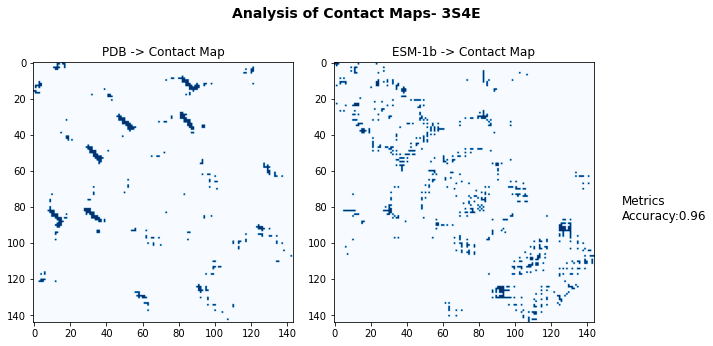

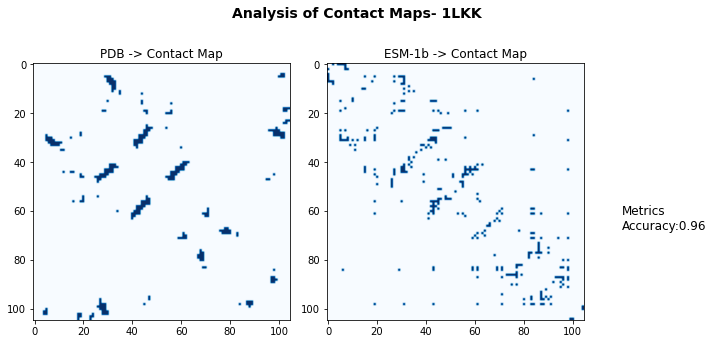

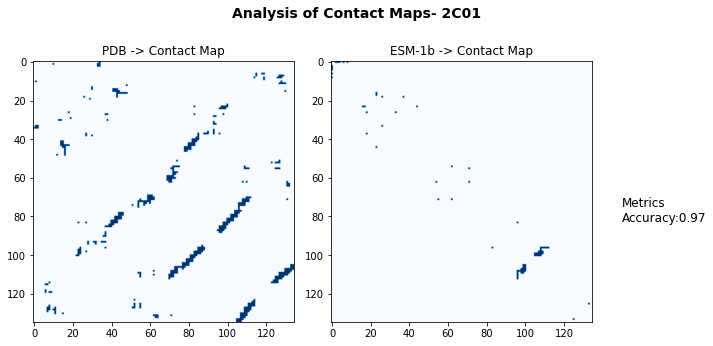

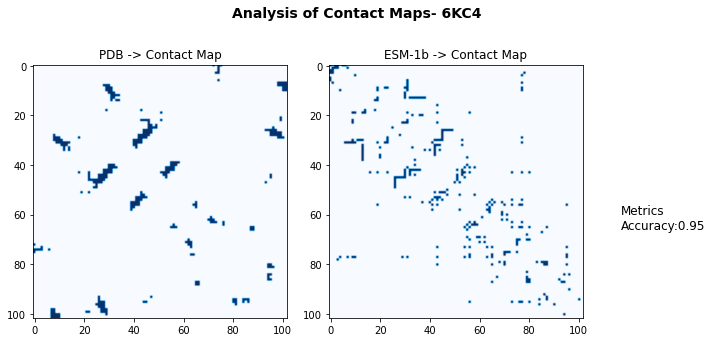

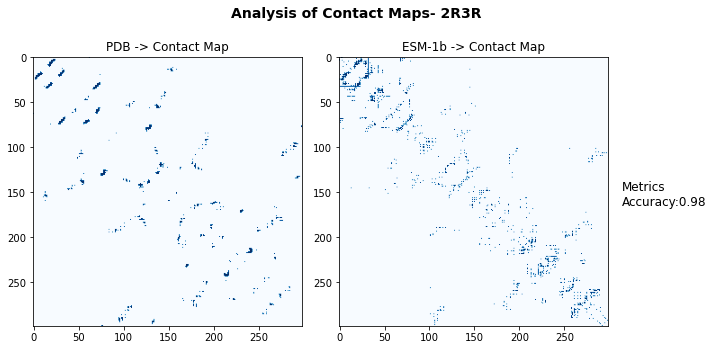

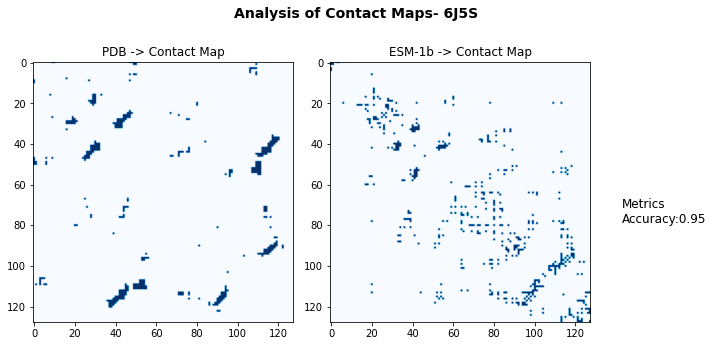

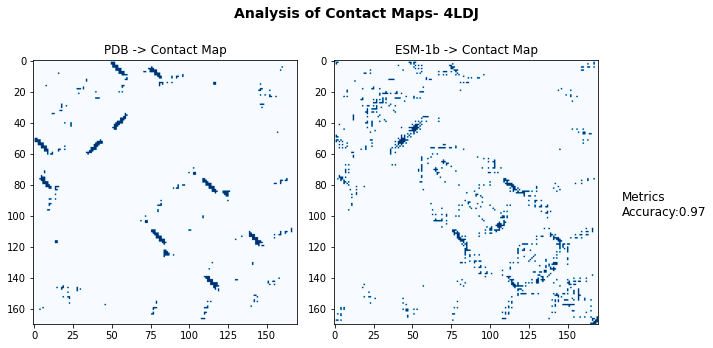

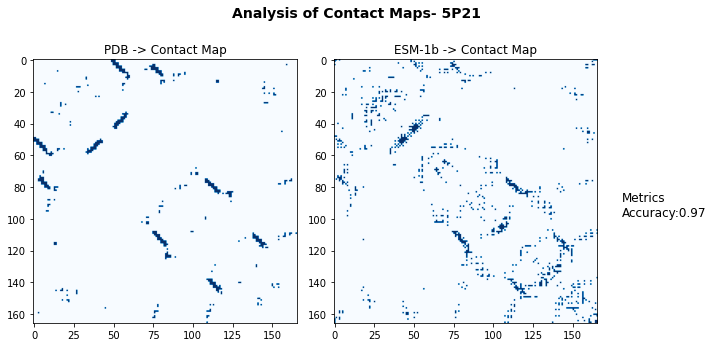

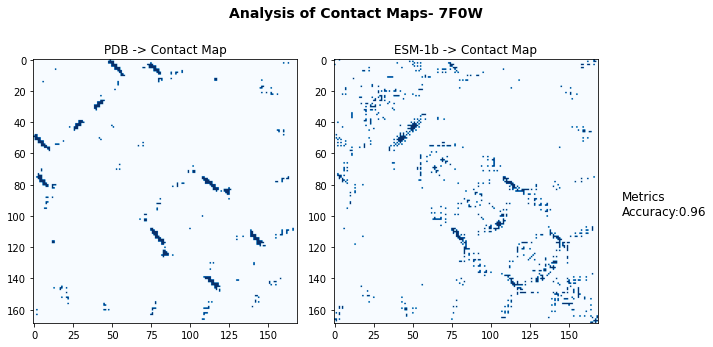

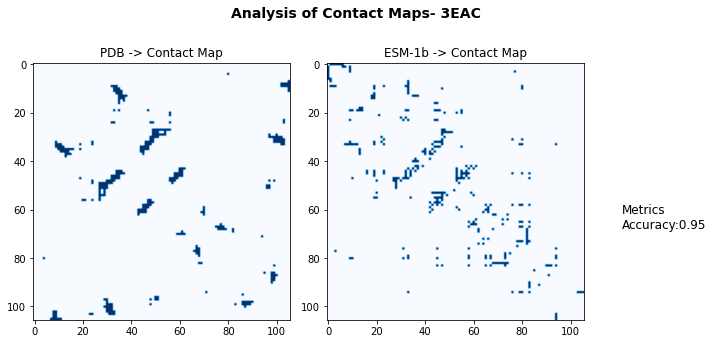

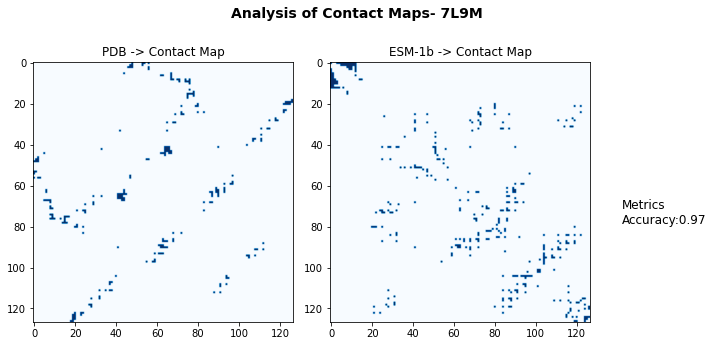

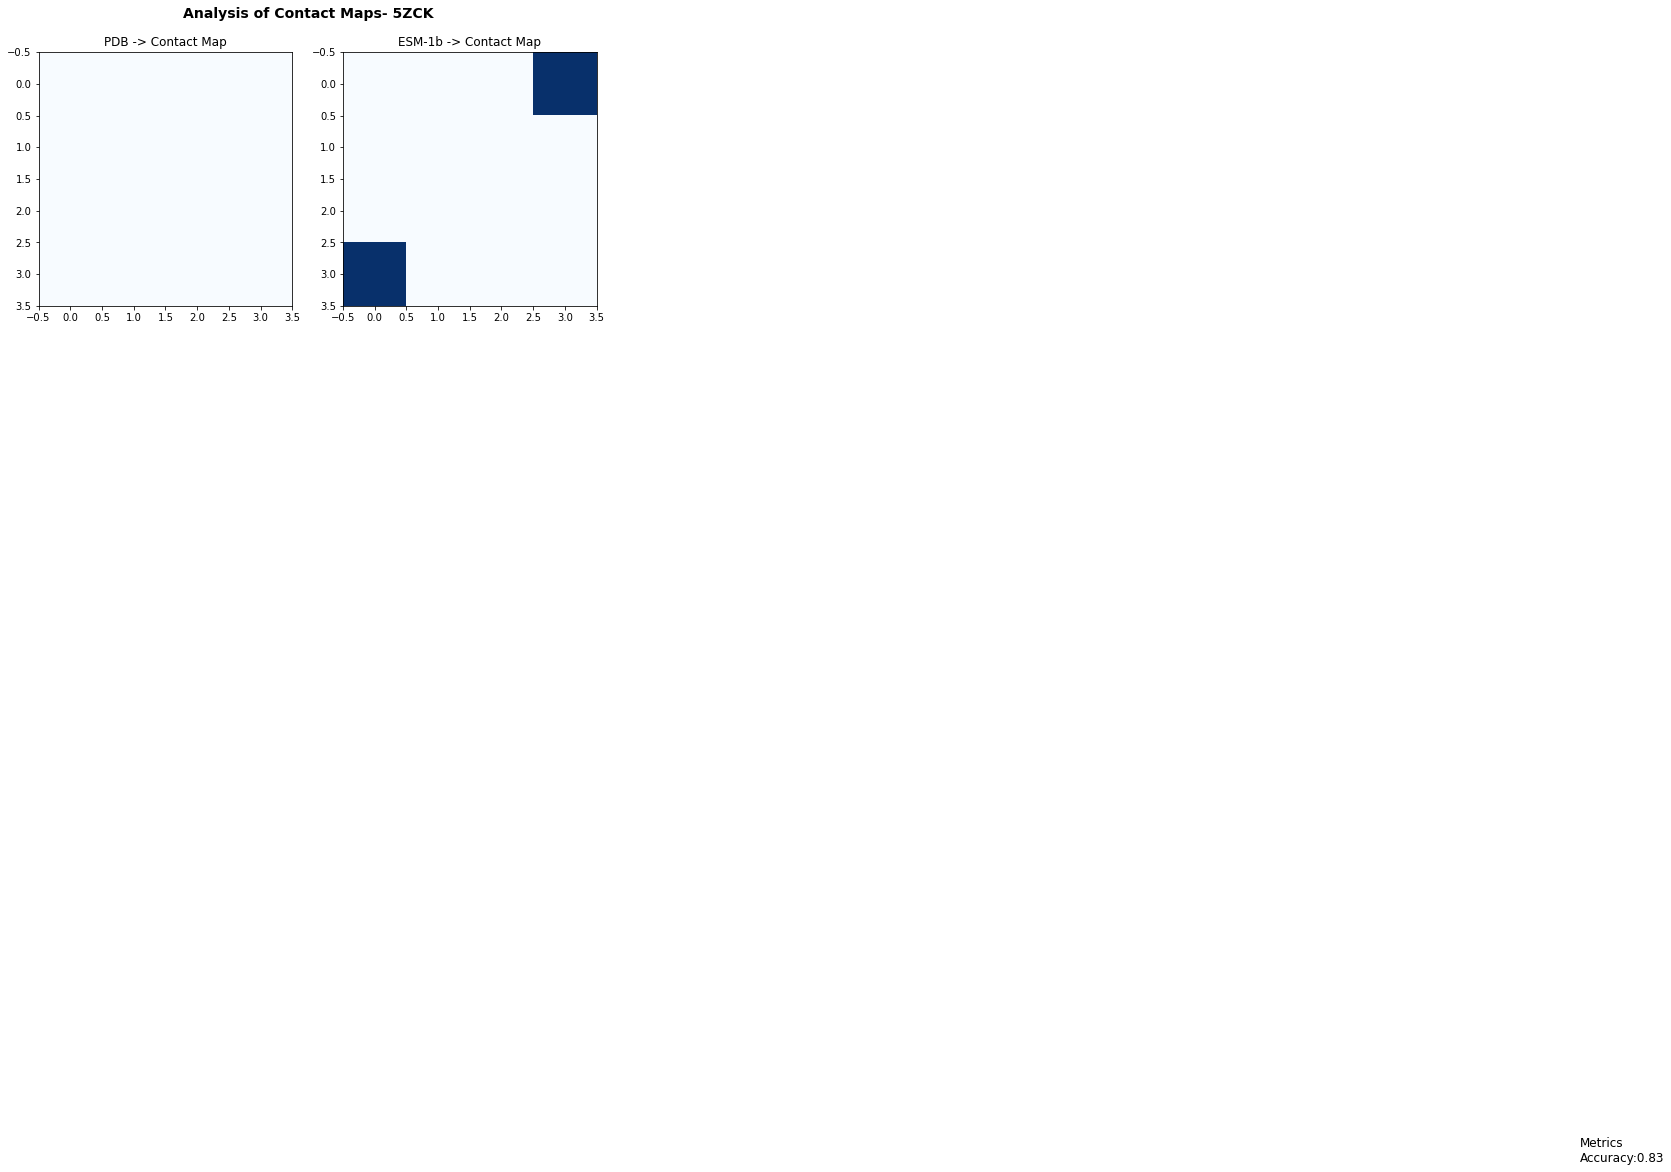

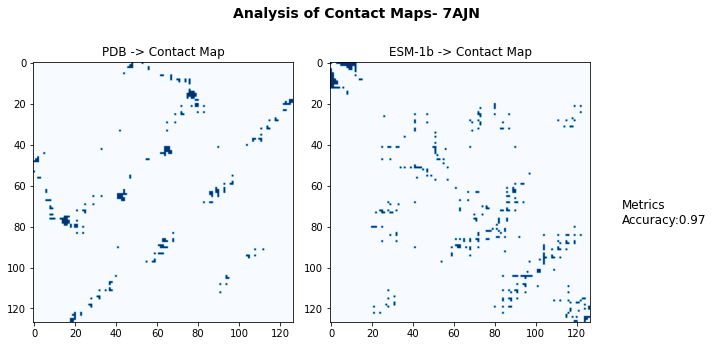

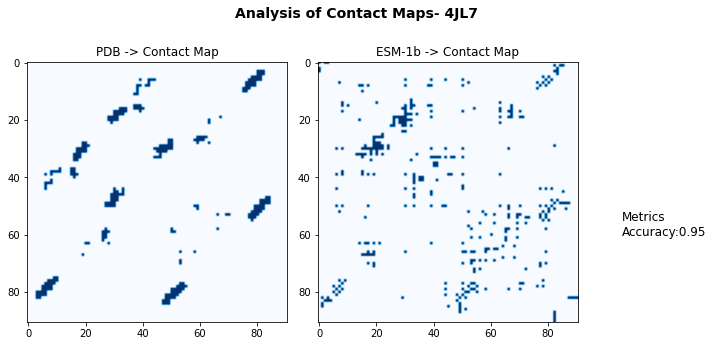

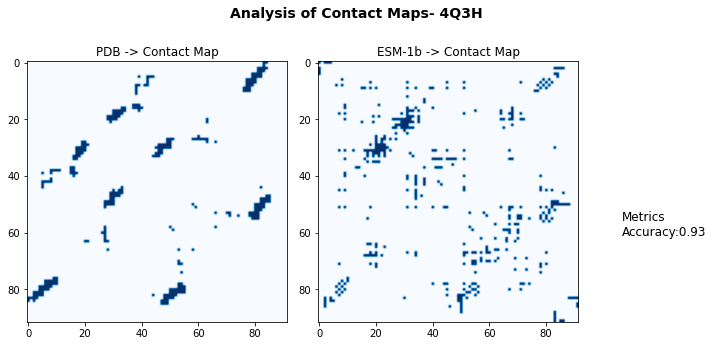

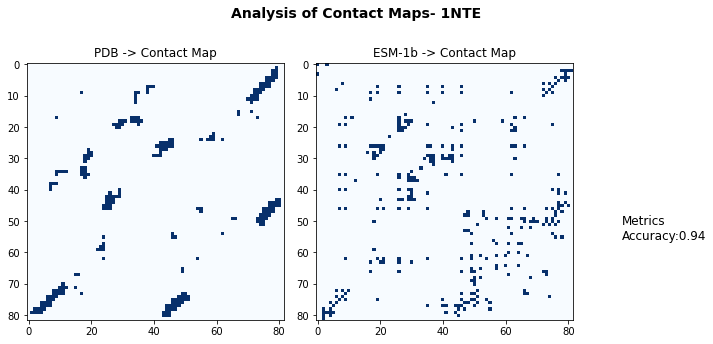

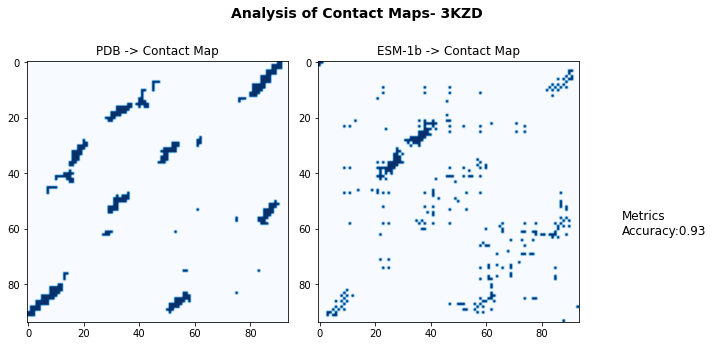

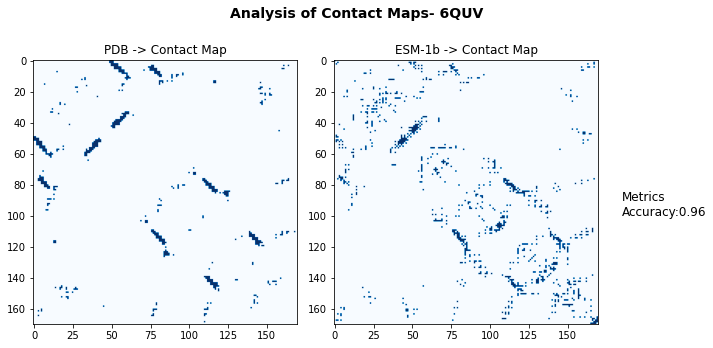

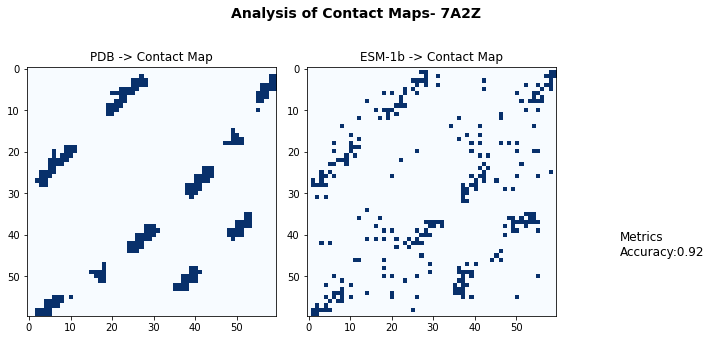

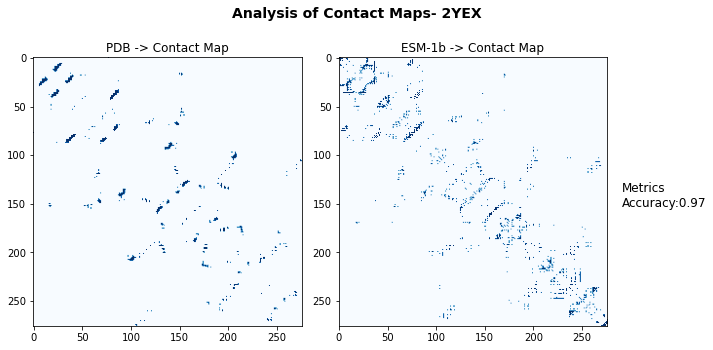

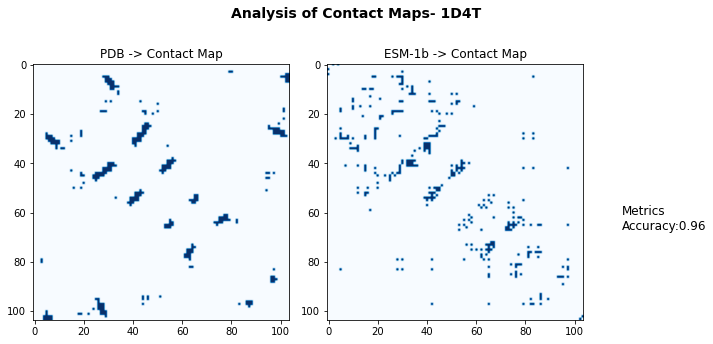

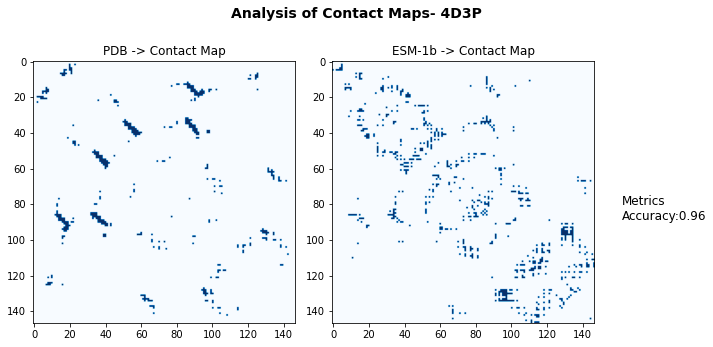

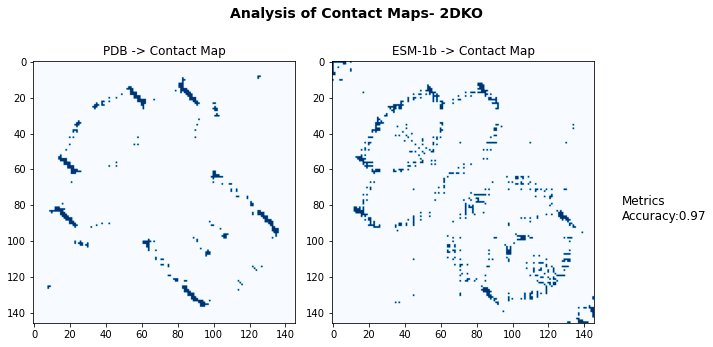

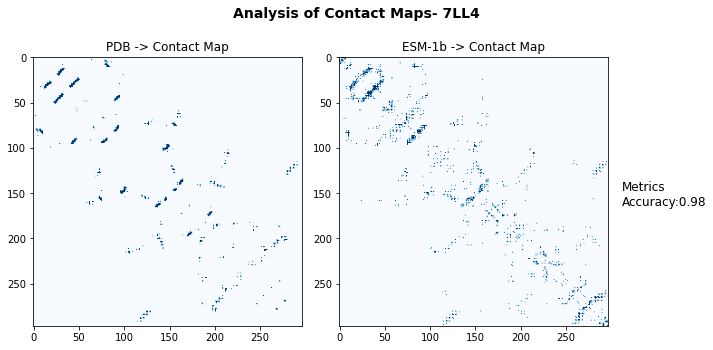

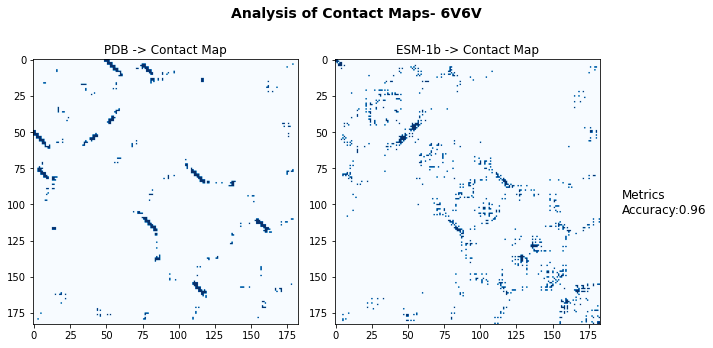

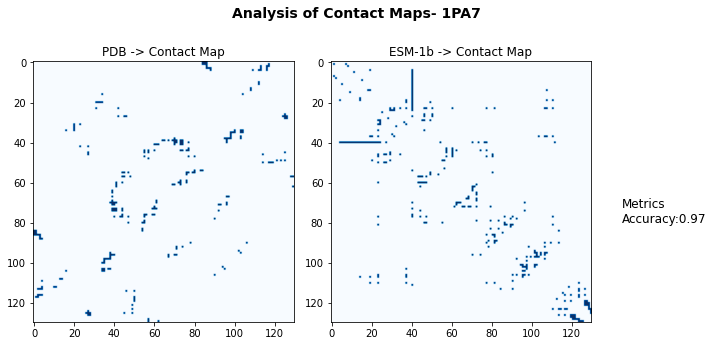

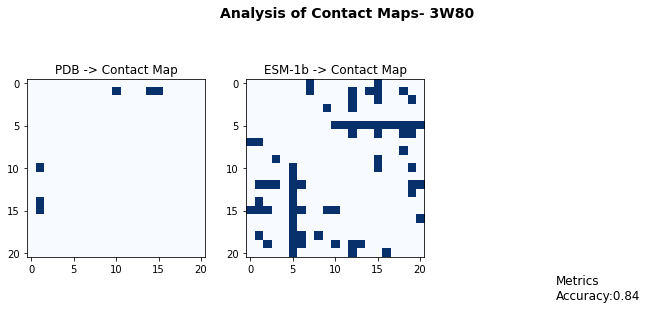

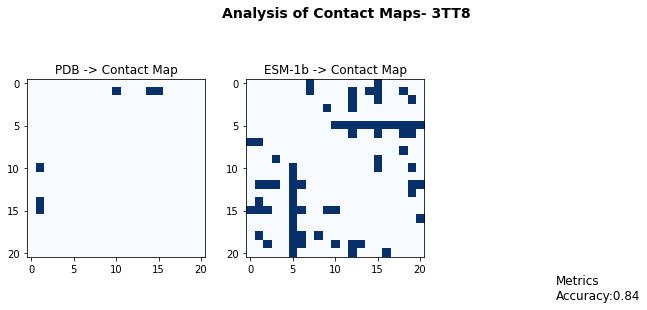

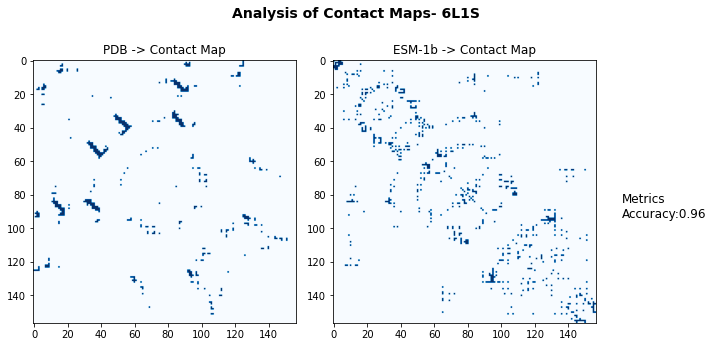

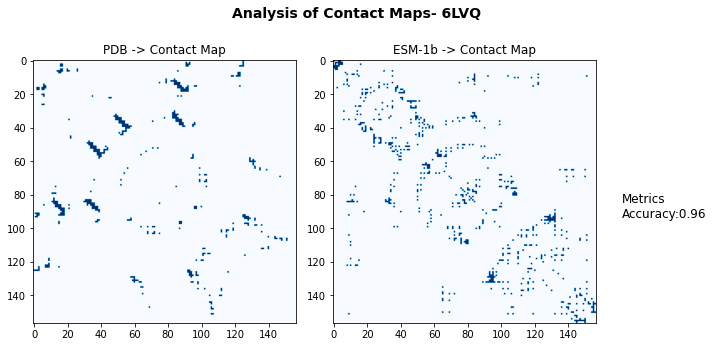

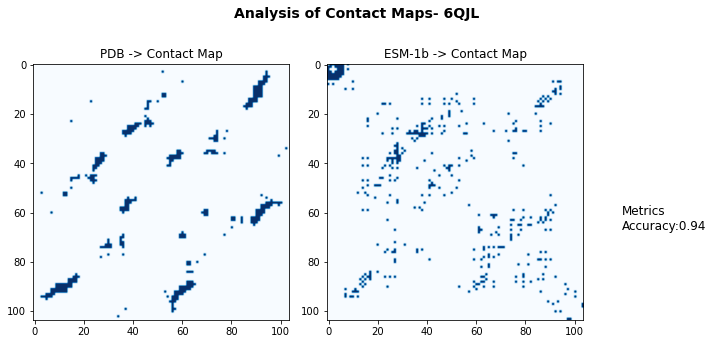

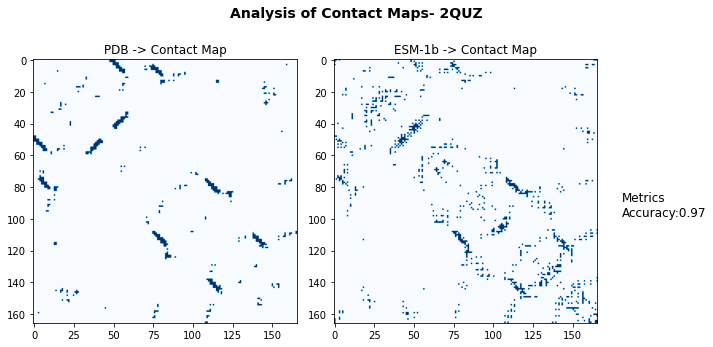

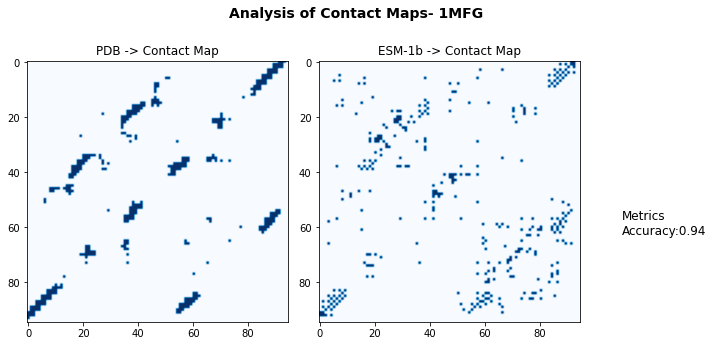

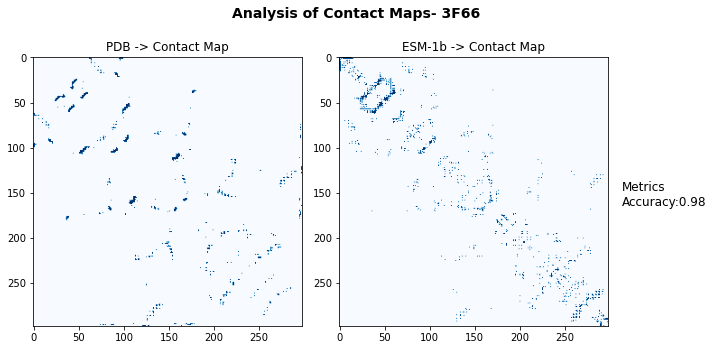

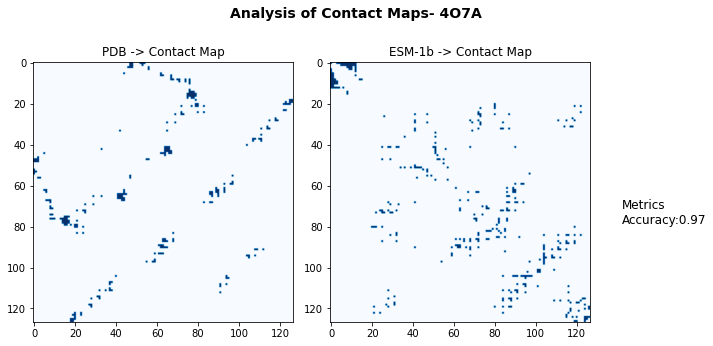

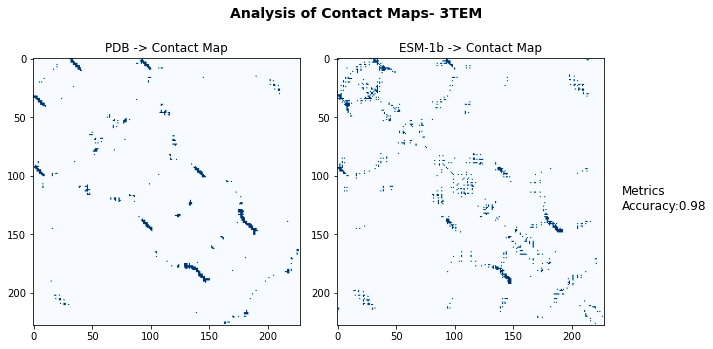

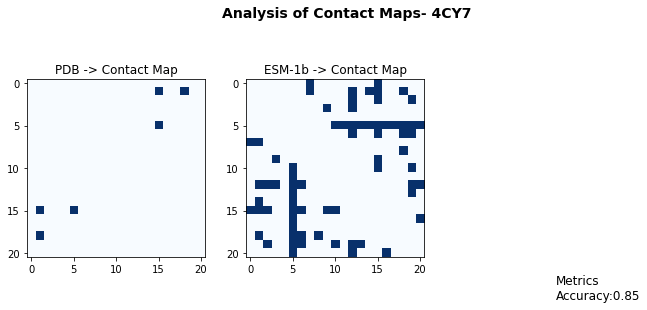

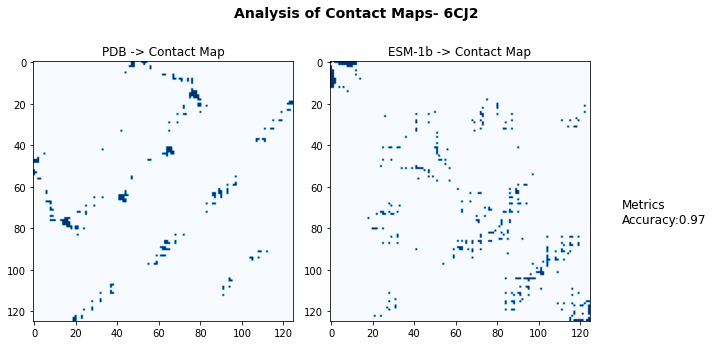

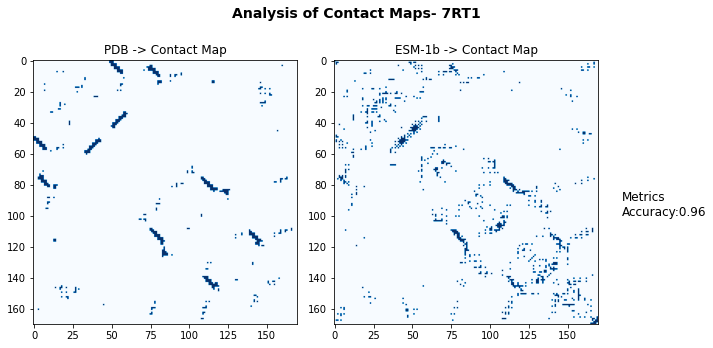

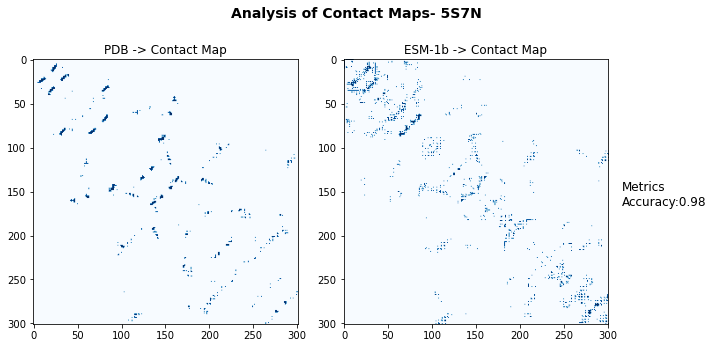

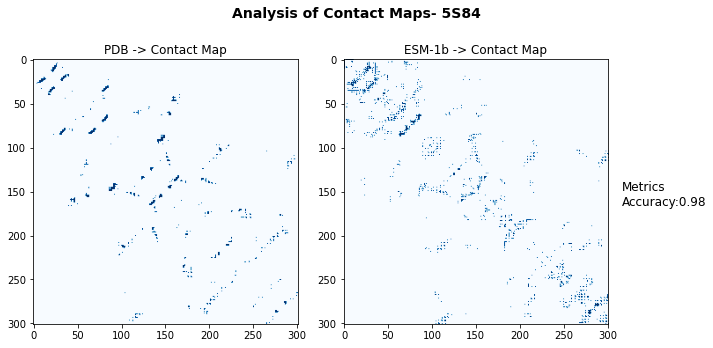

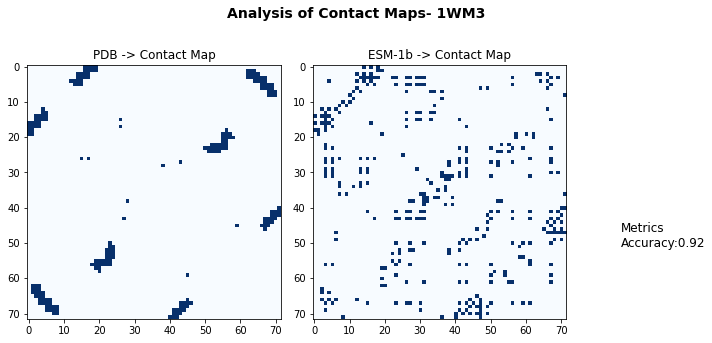

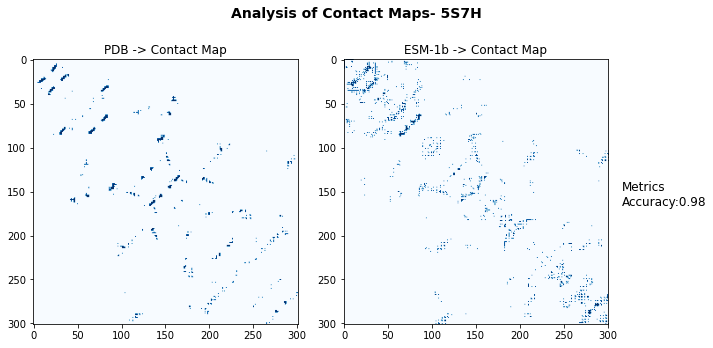

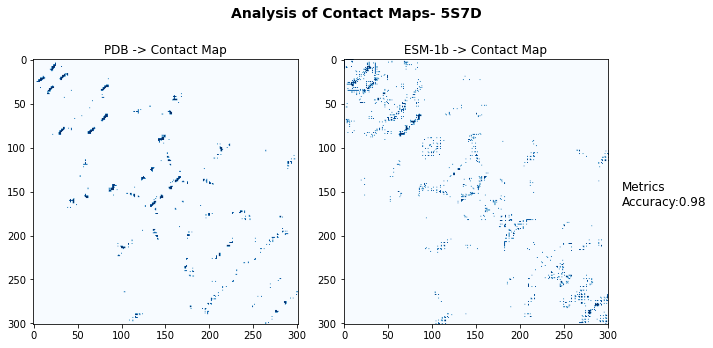

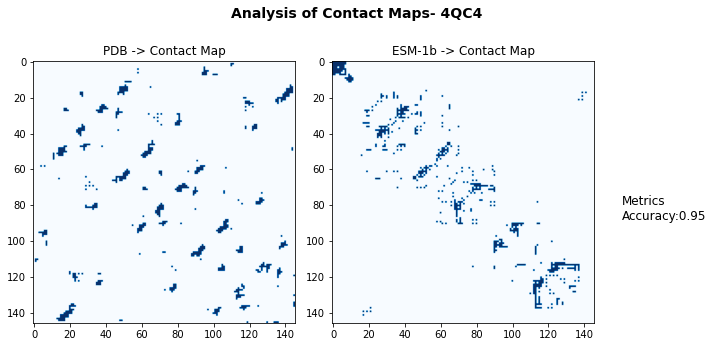

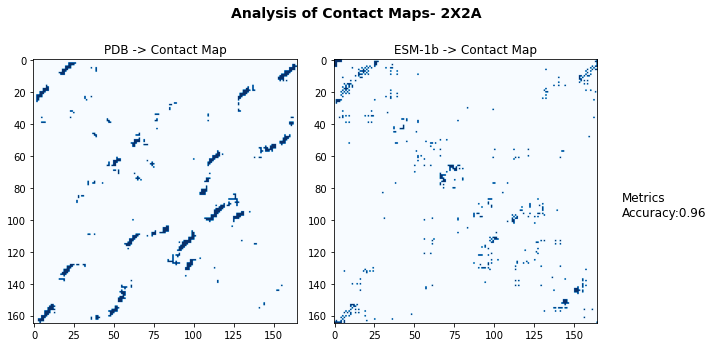

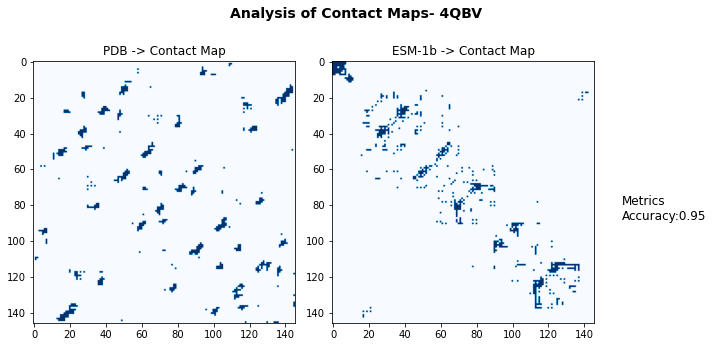

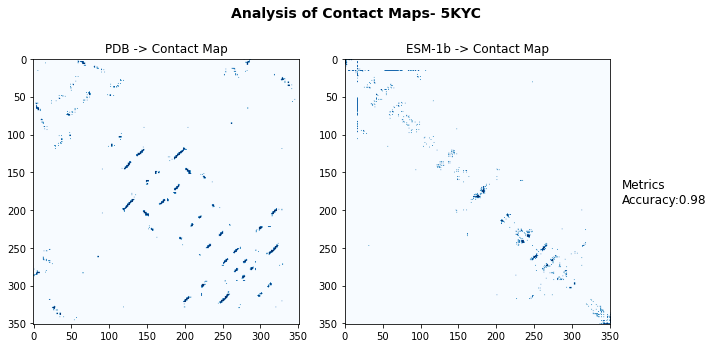

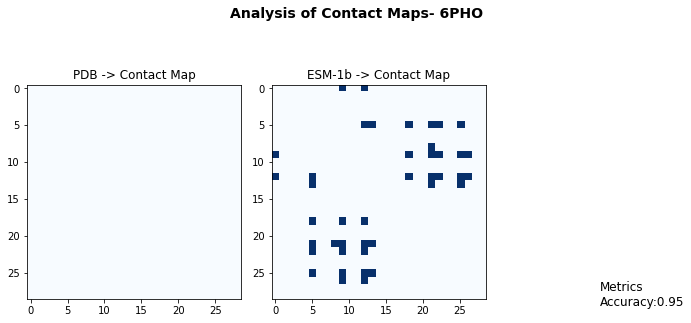

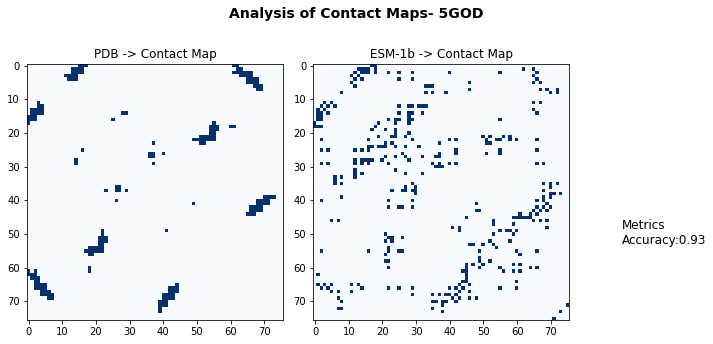

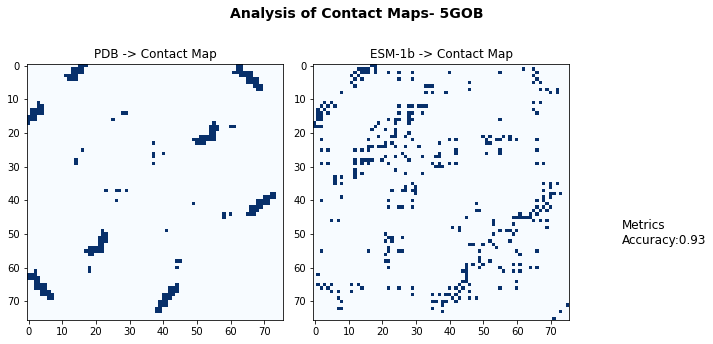

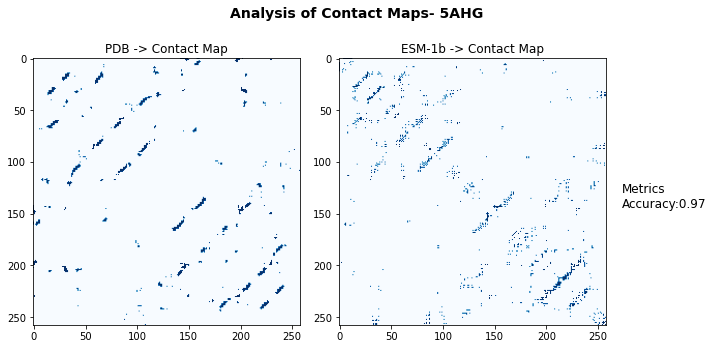

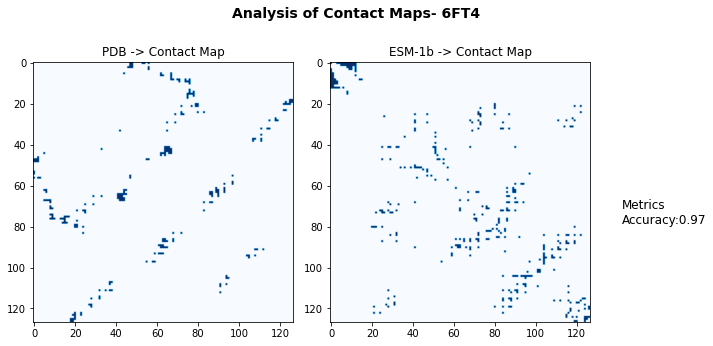

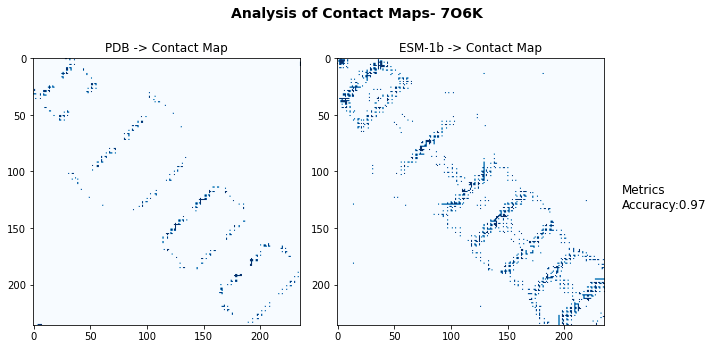

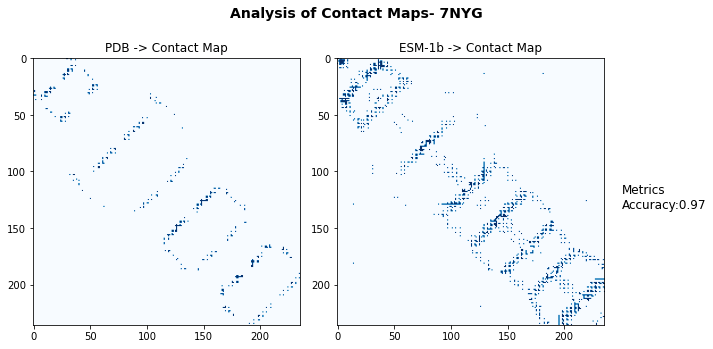

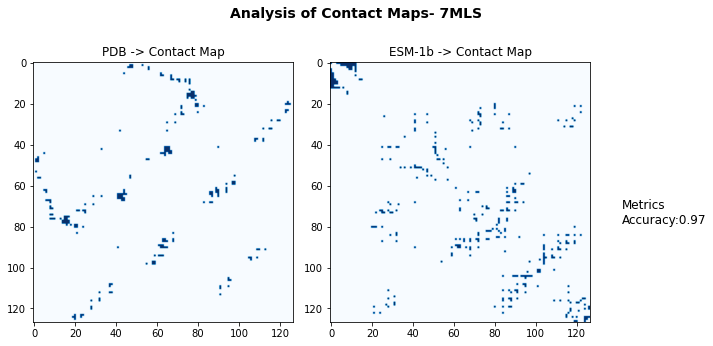

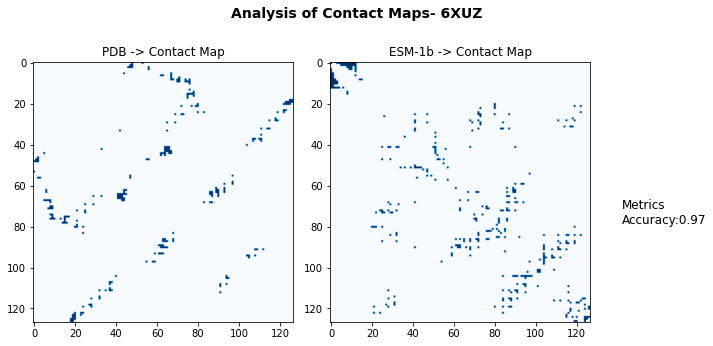

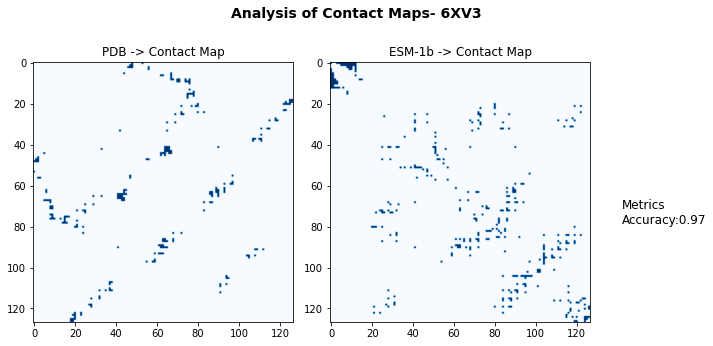

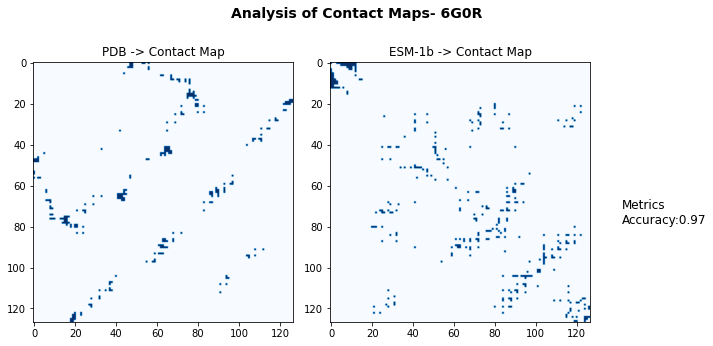

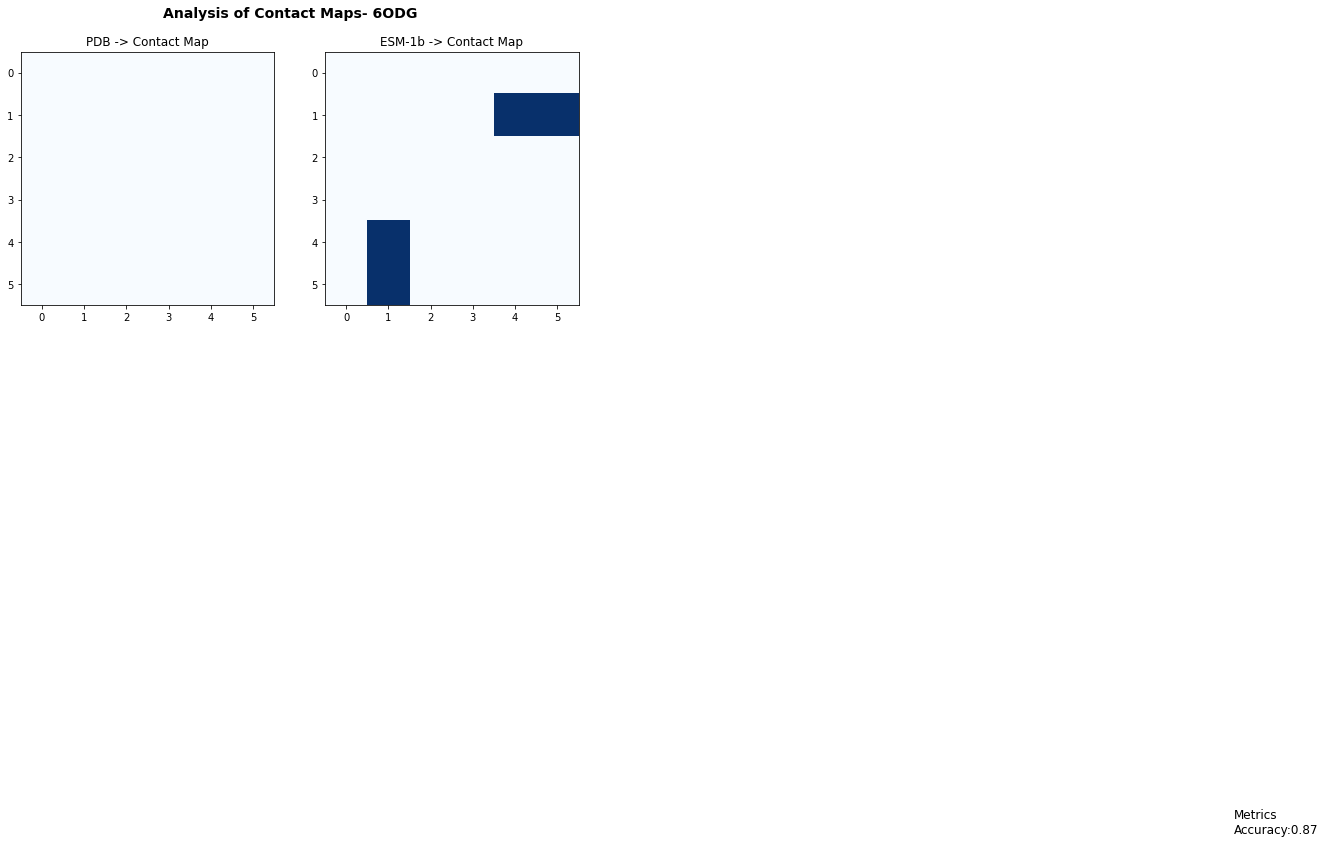

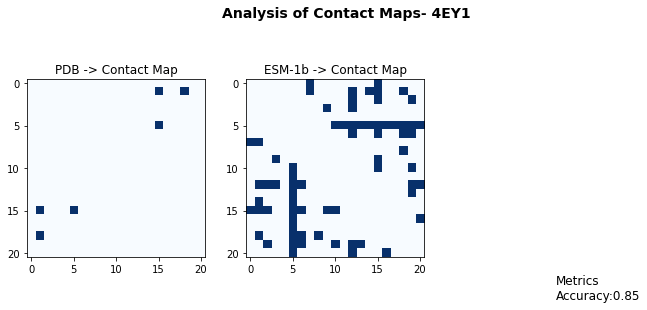

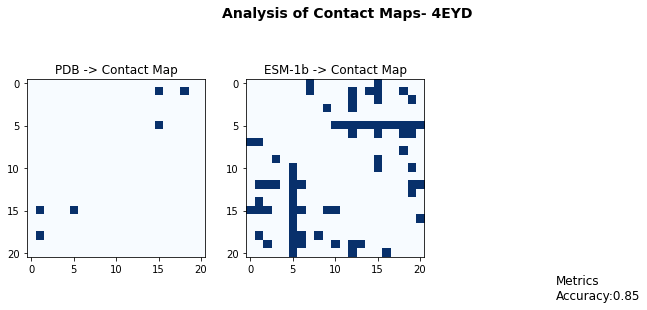

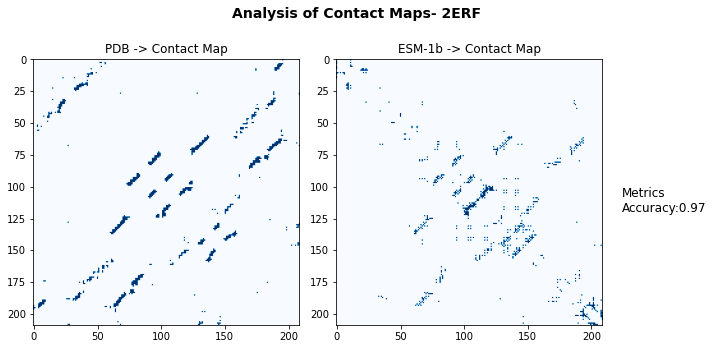

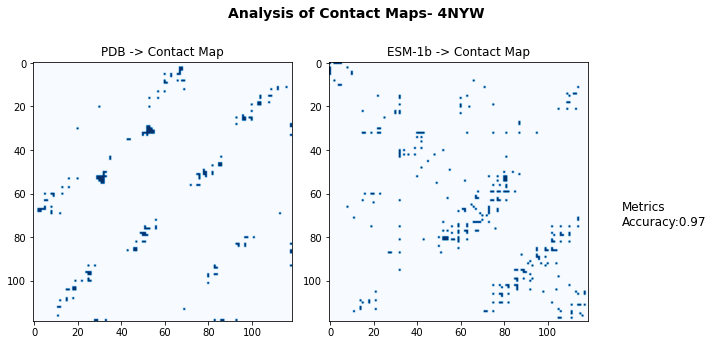

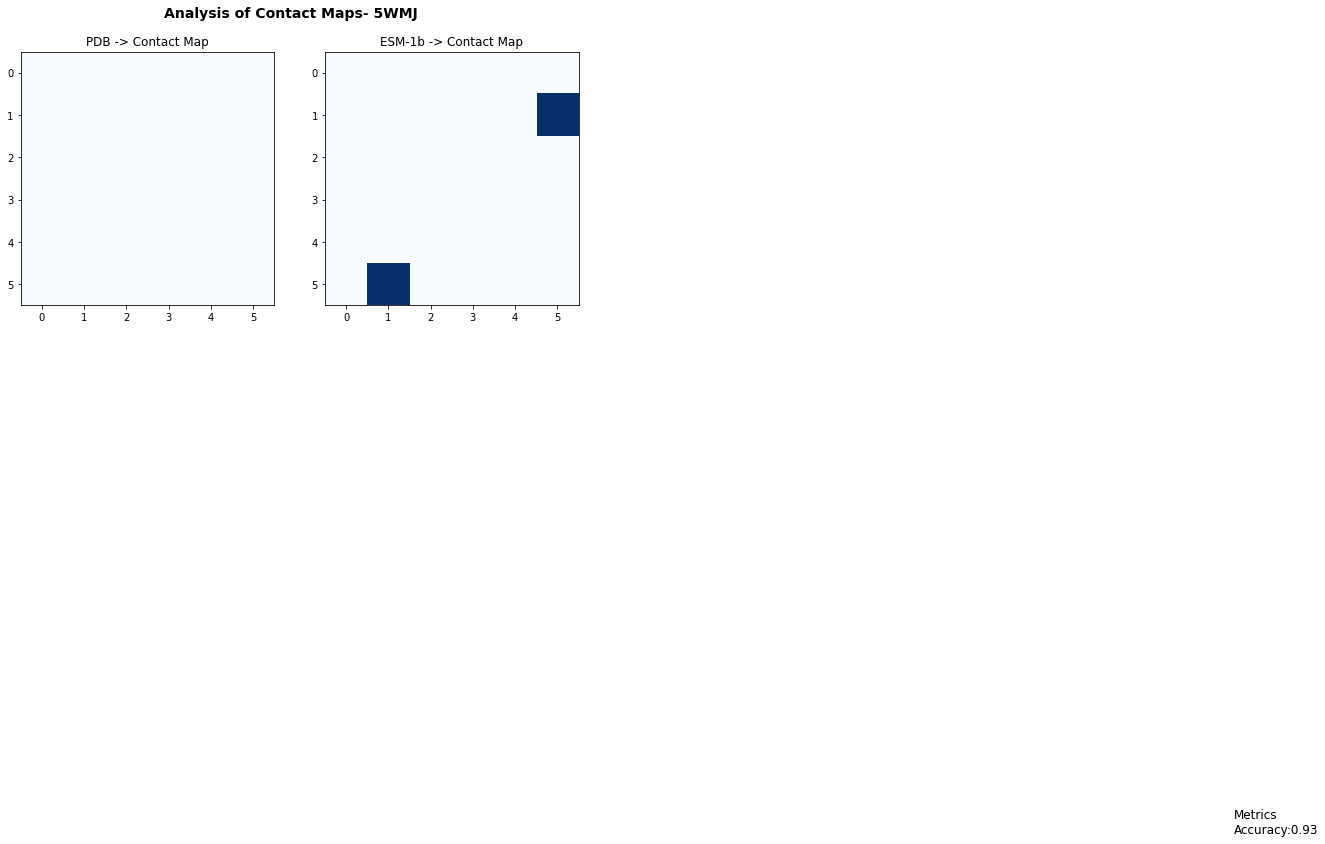

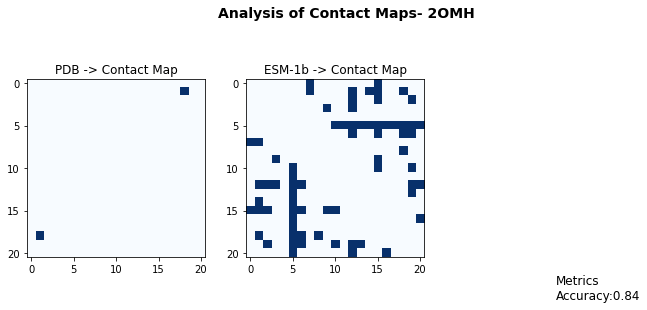

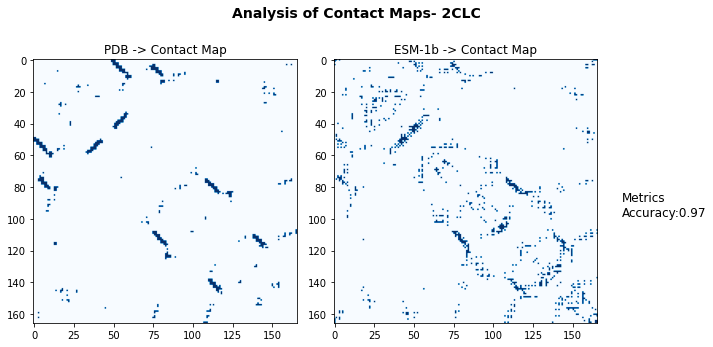

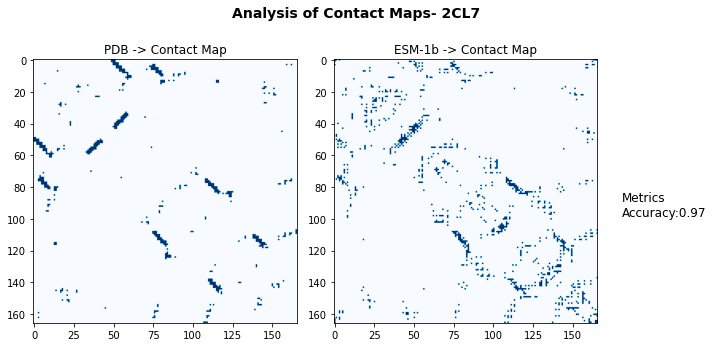

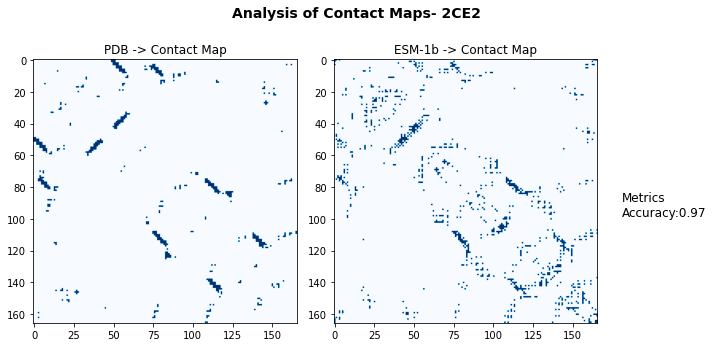

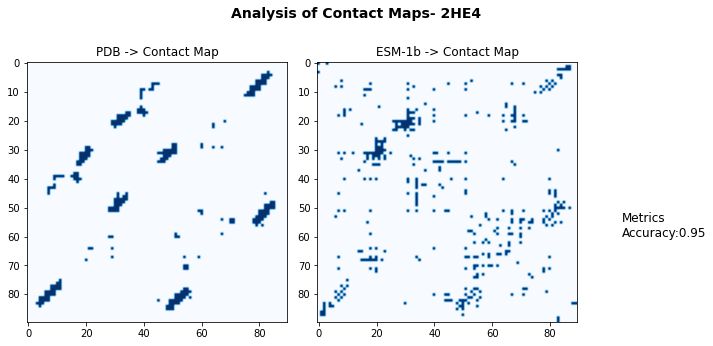

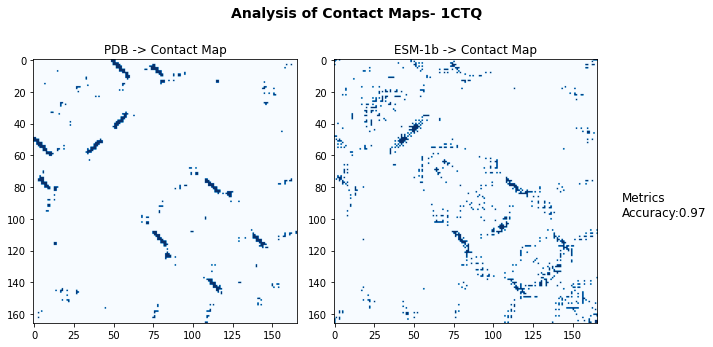

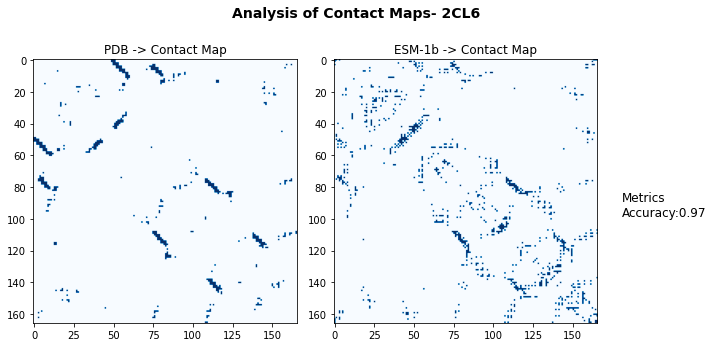

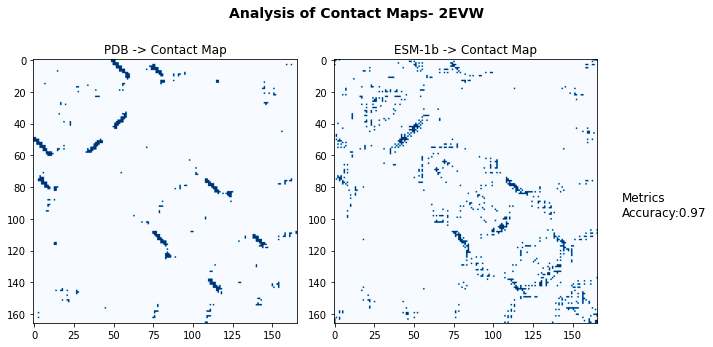

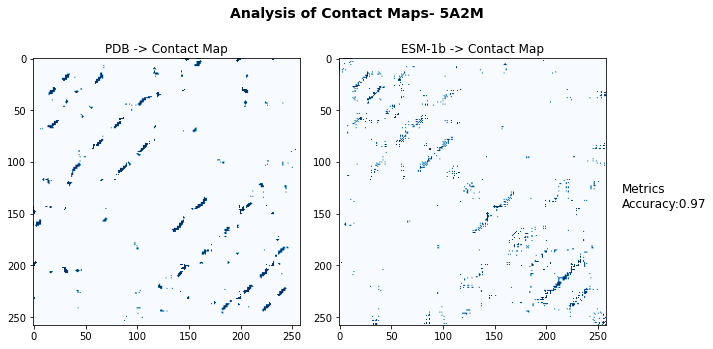

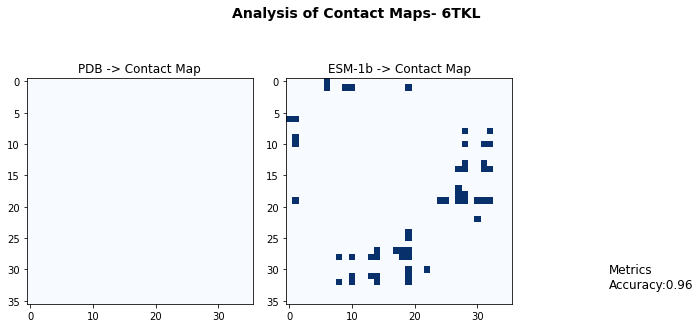

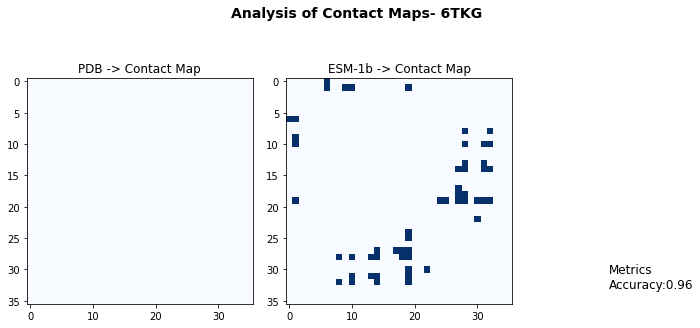

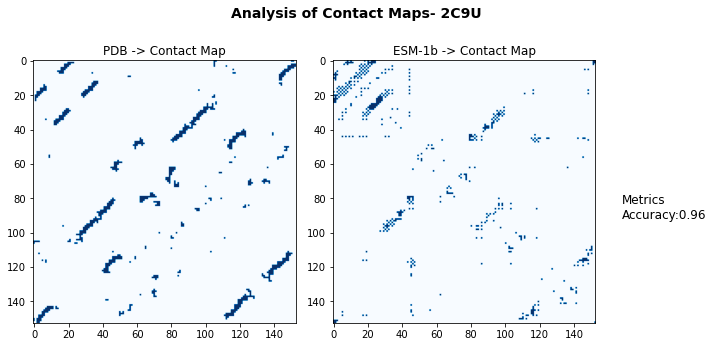

In [329]:
PDB_IDs = pdb_list
results_path="/Users/rohan/Desktop/DTI_setup/results_main/"
for i,j in enumerate(PDB_IDs):
    print(PDB_IDs[i])
    PDB_IDs_lower = str(PDB_IDs[i]).lower()
    PDB_file = f'//Users/rohan/Desktop/DTI_setup/data1/test1/pdb{PDB_IDs_lower}.ent'
    fasta_file=f'//Users/rohan/Desktop/DTI_setup/data1/test2/{PDB_IDs[i]}_1.fasta'
    #PDB_check = open(PDB_file, 'r')
    if os.path.isfile(PDB_file) and os.path.isfile(fasta_file):
        contact_pdb=getContactMap_fromPDB(PDB_file)
        contact_esm=getContactMap_fromESM(esm1b,esm1b_batch_converter,fasta_file)
    #print(PDB_file)
#     if os.path.isfile(PDB_file) and os.path.isfile(fasta_file):
#         contact_pdb=getContactMap_fromPDB(PDB_file)
#         contact_esm=getContactMap_fromESM
        compareContactMaps(contact_pdb,contact_esm,PDB_IDs[i],results_path)
        continue

3KHF
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 54. 55. 56. 76.
 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89. 90. 91. 92.]
106 99
FASTA and PDB are differnet for3KHF
3LQ3


/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element X found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: X
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  53.  54.  55.  56.  57.
  60.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.
  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.
  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102.
 103. 104. 105. 106. 107. 108. 109. 110. 112. 113. 114. 117. 120. 121.
 127. 128. 129. 131. 132. 133. 134. 135. 136. 137. 138. 146. 148. 149.
 150. 151. 152. 153. 154. 155. 165. 166. 167. 168. 169. 170. 171.]
358 401
FASTA and PDB are differnet for3LQ3
3FEG
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  

130 105
FASTA and PDB are differnet for3M9J
4YPD
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.
  72.  73.  74.  75.  76.  77.  78.  81.  82.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  96.  97.  98. 101. 104. 105. 106. 107. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 123. 143. 146.
 149. 150. 153. 156. 157. 158. 166. 170. 171.]
316 294
FASTA and PDB are differnet for4YPD
6ELM
[ 0.  2.  3.  4.  5.  6.  7.  9. 10. 12. 13. 14. 15. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 71. 72. 73. 74. 75. 76. 77. 78. 80. 84.]
105 98
FASTA and PDB are differnet for6ELM
7D0E
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


96 93
FASTA and PDB are differnet for3O46
3I4W
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 61. 66. 67. 68. 69. 70. 71. 72. 73.
 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86.]
99 104
FASTA and PDB are differnet for3I4W
6TSE
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  50.  51.  52.  53.  55.  56.  57.  60.  61.  66.  67.  69.  70.
  71.  72.  73.  74.  75.  84.  85.  86.  94.  95.  96.  97.  98.  99.
 100. 101. 102. 103. 104. 116. 126. 127. 128. 129. 130. 131.]
166 169
FASTA and PDB are differnet for6TSE
3S4E
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  22.  23.  24.  25.  28.  29.  30.  31.
  32.  33.  34.  35.  36

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


52 55
FASTA and PDB are differnet for3G36
6EGE
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  65.  66.  67.  68.  69.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  87.  93.  94.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 109. 113. 128. 129. 130.
 131. 132. 139. 142. 143. 146. 149. 150. 153. 156. 157. 160.]
284 302
FASTA and PDB are differnet for6EGE
2QT1


/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element X found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: X
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  15.  16.
  17.  18.  19.  22.  23.  24.  25.  26.  27.  28.  29.  30.  33.  40.
  41.  42.  44.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.
  63.  64.  65.  66.  67.  72.  76.  77.  78.  80.  81.  82.  83.  84.
  85.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96. 102. 103. 104.
 105. 106. 107. 108. 109. 110. 111. 113. 114. 115. 116. 117. 118. 119.
 144. 160. 161. 162. 164. 165. 193.]
202 207
FASTA and PDB are differnet for2QT1
6HOG
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  67.  68.  69.  71.  74.  75.  76.  77.  78.  79.  80.  81.
  82.  87.  89.  90.  91.  92.  93.  94.  95.  97.  98. 115. 123.]
132 129
FASTA and PDB are differnet for6HOG
2QFA
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element X found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: X
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


94 112
FASTA and PDB are differnet for3L46
5EP6
[0. 2. 3. 4. 5. 6.]
41 47
FASTA and PDB are differnet for5EP6
1EAZ
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 32. 36. 37. 38. 41. 42. 50. 51.
 53. 64. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 86. 89. 90.]
103 125
FASTA and PDB are differnet for1EAZ
6KC4
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 29. 32. 46. 50. 51. 67. 68. 69. 70. 71. 72.
 73. 74. 75. 77. 78. 90. 91. 92. 93. 94.]
102 102
5151 5151
6KEC
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  14.  16.
  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  36.  37.  39.  40.  41.  44.  45.  46.  47.  48.
  49.  51.  52.  54.  55.  58.  59.  60.  61.  62.  63.  64.  65.  66.
  67.  68.  69.  70.  71.  72.  73.  75.  76.  78.  81.  84.  85.  89.
  92.  93. 101. 102. 104. 105. 106. 107.]
126 127
FASTA and PD

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


100 121
FASTA and PDB are differnet for3FIA
4LMM
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 45. 46. 51. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79.
 80. 81. 82. 83. 84. 85. 86. 87.]
97 91
FASTA and PDB are differnet for4LMM
2R3R
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  71.  72.  73.  75.  80.  81.
  82.  83.  84.  85.  86.  87.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 106. 107. 108. 110. 136. 137. 138. 139.
 140. 141. 144. 146. 157. 158. 159. 160. 161. 162. 163. 164. 167. 168.
 169. 171. 172. 173. 175. 176. 179. 184. 187. 188. 190. 191. 192. 193.
 194. 195. 1

[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  79.  81.  82.  83.  84.  85.  86.  87.  89.
  90.  91.  93.  94.  95.  98.  99. 101. 102. 103. 104. 105. 106. 107.
 108. 109. 110. 111. 112. 113. 114. 116. 141. 142. 143. 144. 145. 146.
 147. 167. 168. 170. 171. 172. 175. 176. 177. 179. 180. 181. 182. 183.
 185. 186. 187. 188. 189. 190. 193. 199. 202. 203. 205. 206. 208. 209.
 212. 213. 214. 215. 216. 269. 270. 318. 319. 320. 321. 322. 323. 324.]
349 365
FASTA and PDB are differnet for6HMD
4LDJ
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: CD
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


99 98
FASTA and PDB are differnet for3WA4
1OBX
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 56. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.]


/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: CO
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


74 79
FASTA and PDB are differnet for1OBX
5P21
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  37.  38.  39.  40.  41.  42.  43.
  46.  47.  48.  49.  50.  51.  52.  53.  56.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  85.  86.  87. 101. 102. 103. 111. 118. 119. 120. 124. 126. 127. 128.
 129. 130. 131. 133. 156.]
166 166
13695 13695
5XRD
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  49.  50.  53.  54.  55.  56.  57.  58.  59.  60.
  68.  83.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 106. 107. 108. 109. 110. 111. 112.
 114. 115. 116. 117. 128. 132. 135. 136. 138. 139

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


99 102
FASTA and PDB are differnet for4FH0
7F0W
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  25.  26.  27.  28.  29.  30.  31.
  32.  33.  34.  35.  36.  38.  39.  40.  41.  42.  43.  46.  47.  48.
  49.  50.  51.  52.  53.  54.  57.  58.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  76.  77.  78.  79.  80.  81.  82.  83.  84.  86.
  87.  88. 103. 104. 105. 111. 112. 114. 115. 125. 127. 128. 129. 130.
 131. 133. 134. 158. 161.]
169 169
14196 14196
6ZBK
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 35.]
117 123
FASTA and PDB are differnet for6ZBK
3EAZ
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 30. 33. 34. 45. 46. 48. 50. 66.
 67. 68. 69. 70. 71. 76. 78. 79. 93. 94. 95. 96. 97.]
107 106
FASTA and PDB are differnet for3EAZ
3EAC
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 

298 299
FASTA and PDB are differnet for2R3Q
2WP3
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 67. 73. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.]
104 109
FASTA and PDB are differnet for2WP3
4RRV
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  60.  61.  62.  63.  64.  65.  66.  67.  68.  70.  71.  72.
  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  91.  93.
  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107.
 108. 109. 110. 112. 113. 137. 144. 148. 149. 150. 159. 167. 168. 170.
 171. 172. 173. 174. 175. 183. 184. 186. 187. 188. 18

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: CO
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  67.  69.  70.  71.  72.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 111. 114. 115. 118.
 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132.
 133. 134. 135. 139. 140. 141. 142. 143. 144. 145. 147. 148. 150. 151.
 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 165. 168. 171.
 172. 173. 174. 177.]
347 357
FASTA and PDB are differnet for6G36
6HOI
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  65. 

/var/folders/3h/x516l3bx56lc9gv2vh327x6w0000gn/T/ipykernel_40809/1834176662.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


4FKU
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  69.  76.  77.
  78.  79.  82.  84.  85.  86.  87.  88.  89.  90.  92.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 133. 136. 147. 148. 149. 152. 153. 165. 166. 167.
 168. 169. 170. 171. 172. 176. 177. 178. 180. 181. 182. 184. 185. 188.
 193. 197. 200. 201. 202. 203. 204. 205. 206. 207. 208. 224. 231. 232.]
314 299
FASTA and PDB are differnet for4FKU
5J1T
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  18.  19.  20.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  

91 91
4095 4095
4Q3H
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 42. 43. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78.
 79. 80. 81. 82. 83. 84.]
92 92
4186 4186
5KJZ
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  87.
  88.  92.  95.  96.  99. 106. 107. 108. 110. 111. 115. 116.]
155 150
FASTA and PDB are differnet for5KJZ
3K05
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  35.  36

243 230
FASTA and PDB are differnet for1XD3
6J5Z
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 32. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 44. 46. 47. 48. 49. 50. 51. 52. 53. 54. 56. 57. 58. 59.
 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 93. 94. 95. 96.
 97.]
120 128
FASTA and PDB are differnet for6J5Z
3CJW
[  0.   2.   3.   4.   5.   6.   7.   8.  10.  11.  12.  13.  14.  15.
  16.  17.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  36.  37.  38.  40.  41.  44.  47.  48.  49.  50.
  51.  53.  54.  55.  58.  59.  60.  61.  64.  65.  66.  67.  68.  70.
  71.  72.  73.  75.  78.  79.  83.  86.  87.  88.  89.  90.  93.  94.
  97.  98.  99. 101. 102. 103. 105. 106. 107. 108. 111. 127. 129. 130.
 131. 132. 133. 134. 135. 136. 137. 138. 139. 141. 142. 149. 150. 152.
 153. 155. 156. 158. 159. 161.]
207 244
FASTA and PDB are differnet for3CJW
6TGK
[ 0.  2.  3.  4.  5.  6.  

258 236
FASTA and PDB are differnet for6FBB
5KLY
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 31. 33. 35. 36. 37. 38. 39.
 40. 41. 42. 43. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 57. 58. 59. 60.
 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 93. 94. 95. 96. 97.
 98.]
120 129
FASTA and PDB are differnet for5KLY
5KM4
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 32. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57.
 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 92. 93. 94.
 95. 96.]
118 129
FASTA and PDB are differnet for5KM4
5XCO
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  49.  50.  51.  52.  53.

390 393
FASTA and PDB are differnet for4C6C
6FNK
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  71.  72.
  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.
  87.  88.  89.  92.  97.  98.  99. 100. 101. 102. 103. 104. 105. 107.
 108. 109. 125. 129. 132. 133. 135. 136. 137. 140. 141. 144. 148. 149.
 151. 152. 155. 156. 159. 162. 166.]
287 297
FASTA and PDB are differnet for6FNK
6FNL
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  6

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: NI
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


65 64
FASTA and PDB are differnet for4X3K
1NTE
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 51. 52. 56. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78.]
82 82
3321 3321
5J80
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  51.  52.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  69.  70.  73.  85.  86.  87.  88.  89.  90.  91.  92.
  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106.
 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 118. 119. 120. 121.
 131. 135. 137. 139. 140. 143. 144. 145. 146. 147. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 165. 166. 167. 168. 169. 170.
 172.]
215 225
FASTA and PDB are differnet f

580 581
FASTA and PDB are differnet for3O3U
7A2S
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 31. 32. 33. 34. 35. 47. 49. 50. 51.
 52. 53. 54. 55. 56. 57. 58. 59.]
63 62
FASTA and PDB are differnet for7A2S
7A2T
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 31. 32. 33. 34. 35. 36. 49. 50. 51.
 52. 53. 54. 55. 56. 57. 58. 59.]
62 61
FASTA and PDB are differnet for7A2T
7A2R
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 31. 32. 33. 34. 35. 46. 48. 49. 50. 51. 52.
 53. 54. 55. 56. 57. 58.]
63 62
FASTA and PDB are differnet for7A2R
7A2Z
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 29. 30. 31. 32. 33. 34. 45. 47. 48. 49. 50.
 51. 52. 53. 54. 55. 56. 57.]
60 60
1770 1770
4XOF
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 21.

168 187
FASTA and PDB are differnet for6QUU
4QTC
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  67.  68.  69.  70.  72.  79.  80.  82.  83.  84.  85.
  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99.
 100. 101. 102. 103. 104. 111. 112. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 132. 133. 134. 135. 136. 137. 143. 144. 145.
 146. 147. 148. 149. 152. 153. 154. 156. 157. 158. 159. 160. 161. 162.
 163. 164. 165. 166. 168. 169. 172. 173. 174. 179.]
349 357
FASTA and PDB are differnet for4QTC
5HHE
[0. 2. 3. 4. 5.]
94 93
FASTA and PDB are differnet for5HHE
5IO9
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 

/var/folders/3h/x516l3bx56lc9gv2vh327x6w0000gn/T/ipykernel_40809/1834176662.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


4ZX2


/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: MN
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  64.  69.  70.  71.  74.  75.  76.  77.  78.  79.  80.
  81.  82.  83.  84.  85.  86.  92.  99. 100. 103. 106. 107. 112. 114.
 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128.
 130. 143. 146. 147. 148. 149. 150. 151. 152. 161. 162. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 190. 191. 192. 205. 206. 208. 209.
 210. 211. 212. 213. 214. 215. 216. 217. 218. 219. 220. 222. 226. 227.
 228. 229. 230. 231. 232. 233. 234. 235. 236. 237. 238. 239. 240. 241.
 242. 243. 244. 245. 246.]
344 333
FASTA and PDB are differnet for4ZX2
1W1G
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 3

139 127
FASTA and PDB are differnet for3U5L
1W1H
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 45. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66.
 76. 79.]
147 151
FASTA and PDB are differnet for1W1H
3G4E
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  57.  58.  61.
  72.  73.  81.  82.  83.  84.  85.  86.  87.  88.  89.  93. 100. 101.
 144. 145. 150. 151. 152. 162. 163. 164. 165. 166. 187. 188. 189. 190.
 191. 192. 193. 194. 201. 202. 225. 229. 231. 232. 233. 234. 235. 236.
 237. 238. 239. 240. 241. 243. 244. 245. 246. 247. 248. 249. 250. 251.
 252. 253. 254. 255. 256. 268. 269. 270. 271. 272. 273. 274. 275. 276.
 277. 278. 279. 280. 281. 282. 283

276 235
FASTA and PDB are differnet for4DHR
7L9G
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  14.  15.
  17.  18.  19.  20.  21.  22.  23.  24.  26.  27.  28.  30.  31.  32.
  34.  35.  37.  38.  39.  42.  43.  49.  58.  60.  61.  62.  64.  69.
  70.  71.  73.  74.  77.  82.  85.  86.  90.  93.  94.  97.  98. 101.
 102. 104. 105. 106.]
110 114
FASTA and PDB are differnet for7L9G
1WMS
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  53.  54.  62.  63.  64.  65.  66.
  67.  68.  69.  70.  72.  75.  76.  78.  79.  80.  83.  84.  85.  86.
  87.  89.  90.  91. 101. 102. 103. 111. 119. 120. 124. 125. 126. 127.
 128. 129. 130. 131. 132. 134. 154. 157. 160.]
170 177
FASTA and PDB are differnet for1WMS
1H8D
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  1

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element D found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  71.
  77.  78.  79.  80.  82.  85.  86.  88.  89.  90.  91.  92.  93.  94.
  95.  96.  97.  98.  99. 100. 101. 102. 103. 107. 108. 109. 134. 135.
 136. 137. 138. 139. 157. 162. 163. 164. 165. 166. 167. 169. 170. 171.
 172. 174. 175. 176. 177. 178. 179. 182. 187. 190. 191. 193. 194. 196.
 197. 201. 202. 203. 204. 256. 257. 258. 259. 260. 261. 301. 302. 304.]
328 329
FASTA and PDB are differnet for5ZN0
5ZN1
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  

277 263
FASTA and PDB are differnet for5MSA
5KM2
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  46.  47.  48.  49.  50.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.
  74.  75.  76.  98.  99. 100. 101. 102. 103.]
125 129
FASTA and PDB are differnet for5KM2
4PF4
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  63.  64.  65.  66.  67.  68.  69.  70.  71.
  72.  74.  75.  76.  78.  79.  80.  81.  82.  83.  84.  86.  87.  88.
  89.  94.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109.
 11

337 351
FASTA and PDB are differnet for5CVG
5CSV
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  74.  78.  79.  80.  81.  84.  86.  87.  88.  90.  91.  92.
  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 108.
 109. 110. 135. 136. 137. 138. 139. 140. 141. 159. 164. 165. 166. 167.
 168. 169. 172. 173. 174. 175. 177. 178. 179. 180. 181. 182. 185. 190.
 193. 194. 197. 198. 199. 200. 201. 203. 204. 205. 206. 259. 260. 261.
 262. 263. 264. 305. 306. 309.]
334 328
FASTA and PDB are differnet for5CSV
5OGJ
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  3

303 306
FASTA and PDB are differnet for5E8S
5DK8
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 43. 44. 60. 61. 62. 63. 64. 65.]
77 76
FASTA and PDB are differnet for5DK8
5D7F
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 21. 25. 26. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 40. 41. 42.
 43. 44. 45. 46. 47. 48. 60. 63. 67. 70. 71. 72. 73. 74. 75. 76. 77. 78.
 79. 80. 81. 82.]
103 92
FASTA and PDB are differnet for5D7F
2GBJ
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 42. 43. 67. 68. 69. 70. 71. 72.]
81 84
FASTA and PDB are differnet for2GBJ
6V6U
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  30.  31.  32.
  33.  34.  35.  36.  37.  38.  40.  41.  43.  44.  45

125 149
FASTA and PDB are differnet for5S9C
5S9A
[  0.   2.   3.   4.   5.   6.   7.   8.  10.  11.  12.  15.  16.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  31.  32.
  33.  35.  36.  37.  38.  39.  40.  41.  43.  44.  46.  47.  49.  50.
  51.  55.  58.  59.  65.  71.  72.  73.  75.  76.  82.  86.  90.  93.
  94.  97. 101. 102. 105. 106. 108. 109. 110. 111. 112. 113. 114. 115.
 116. 117. 118. 119. 121. 122.]
125 149
FASTA and PDB are differnet for5S9A
5S9J
[  0.   2.   3.   4.   5.   6.   7.   8.  10.  11.  12.  15.  16.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  31.  32.
  35.  37.  38.  39.  40.  42.  43.  45.  46.  47.  48.  49.  50.  54.
  57.  58.  64.  70.  71.  72.  74.  75.  81.  85.  89.  92.  93.  96.
 100. 101. 104. 105. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116.
 117. 119. 120.]
123 149
FASTA and PDB are differnet for5S9J
5S9H
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  11.  12.  14.  15.  16.
  17.  18.  19.  20.  2

125 149
FASTA and PDB are differnet for5S8U
5S97
[  0.   2.   3.   4.   5.   6.   7.   8.  10.  11.  12.  15.  16.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  31.  32.
  35.  36.  37.  38.  39.  40.  41.  43.  44.  46.  47.  49.  50.  51.
  55.  58.  59.  65.  71.  72.  73.  75.  76.  82.  86.  90.  93.  94.
  97. 101. 102. 105. 106. 108. 109. 110. 111. 112. 113. 114. 115. 116.
 117. 118. 120. 121.]
124 149
FASTA and PDB are differnet for5S97
5S8V
[  0.   2.   3.   4.   5.   6.   7.   8.  10.  11.  12.  15.  16.  17.
  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  30.  31.  34.
  36.  37.  38.  39.  40.  43.  45.  46.  48.  49.  50.  55.  58.  59.
  64.  70.  71.  72.  74.  75.  77.  78.  81.  85.  89.  92.  93.  96.
 100. 101. 104. 105. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116.
 117. 119. 120.]
123 149
FASTA and PDB are differnet for5S8V
5S94
[  0.   2.   3.   4.   5.   6.   7.   8.  10.  11.  12.  15.  16.  17.
  18.  19.  20.  21.  22.  23.  2

340 342
FASTA and PDB are differnet for5OTQ
5OTY
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  79.  80.  81.  82.  85.  86.  87.  88.  89.  91.  92.  93.  94.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 109. 110. 111. 137.
 138. 139. 140. 141. 142. 143. 159. 166. 167. 168. 169. 170. 173. 174.
 175. 176. 178. 179. 180. 181. 182. 183. 186. 191. 195. 196. 199. 200.
 201. 202. 203. 205. 206. 207. 208. 262. 263. 264. 265. 266. 267. 308.
 309. 312.]
337 342
FASTA and PDB are differnet for5OTY
5OTZ
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  3

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


153 162
FASTA and PDB are differnet for1UZK
3P34
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  24.  34.  35.  38.  46.  47.  48.
  49.  52.  56.  58.  59.  60.  61.  62.  64.  65.  66.  67.  68.  70.
  71.  72.  73.  74.  75.  77.  78.  79.  80.  81.  82.  83.  91.  92.
  93.  94.  95.  96.  97. 100. 101. 122. 123. 134. 137. 139. 145. 147.
 148. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170.
 171. 172. 173. 174. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185.
 186. 187. 188. 189. 190. 191. 192. 195. 198. 199. 203. 204. 206. 207.
 210. 211. 213. 214. 215. 216. 219. 222. 223.]
236 232
FASTA and PDB are differnet for3P34
7S5A
[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 31. 32. 33. 37. 38. 39. 40.
 41. 42. 43. 44. 45. 46.]
77 76
FASTA and PDB are differnet for7S5A
4LM4


/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: NI
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  52.  53.  54.  55.  56.  57.  58.
  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.
  73.  74.  75.  76.  77.  79.  80.  85.  87.  88.  90.  91.  92.  94.
  95.  97.  98.  99. 100. 101. 102. 103. 106. 107. 108. 110. 113. 125.
 126. 127. 128. 129. 130. 132. 133. 136. 137. 139. 140. 141. 142. 143.
 144. 150. 153. 154. 164. 167. 168. 169. 170. 171. 172. 173. 201. 202.
 203. 204. 205. 206. 207. 208. 275. 276.]
330 345
FASTA and PDB are differnet for4LM4
4LM3
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  52.  53.  54.  55.  

301 306
FASTA and PDB are differnet for5NKG
5NKH
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  82.  83.  84.  85.  91.  94.  95.
  96.  97.  98.  99. 100. 101. 102. 104. 105. 108. 109. 110. 111. 113.
 114. 115. 117. 118. 135. 139. 142. 143. 145. 146. 149. 150. 152. 153.
 156. 157. 159. 160. 163. 164. 167. 170. 174.]
303 306
FASTA and PDB are differnet for5NKH
5NKE
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  5

/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: NI
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


92 91
FASTA and PDB are differnet for4PQW
6FNG
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  67.  68.  69.  70.  71.  72.
  73.  75.  76.  81.  82.  83.  84.  85.  86.  92.  93.  94.  95.  96.
  97.  98.  99. 101. 102. 117. 120. 123. 124. 126. 127. 130. 131. 133.
 134. 137. 138. 139. 141. 142. 146. 147. 150. 151. 153. 154. 156. 157.
 158.]
286 306
FASTA and PDB are differnet for6FNG
6FNH
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  66.

165 163
FASTA and PDB are differnet for1I76
5KUP
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.
  75.  76.  77.  82.  83.  84.  85.  86.  87.  91.  94.  95.  98.  99.
 100. 101. 110. 111. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122.
 136. 137. 140. 142. 143. 144. 145. 147. 148. 151. 152. 155. 158. 159.
 162. 166. 169.]
281 271
FASTA and PDB are differnet for5KUP
4XZF


UnboundLocalError: local variable 'links' referenced before assignment

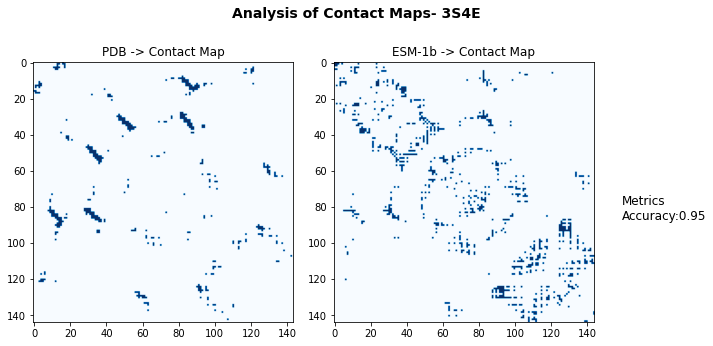

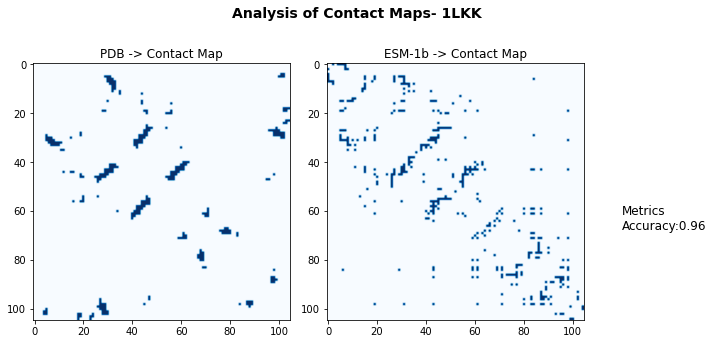

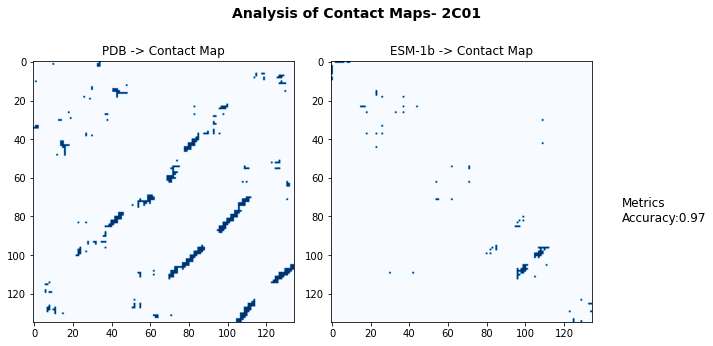

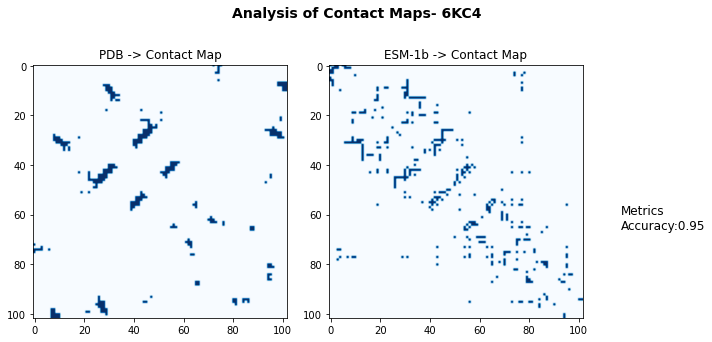

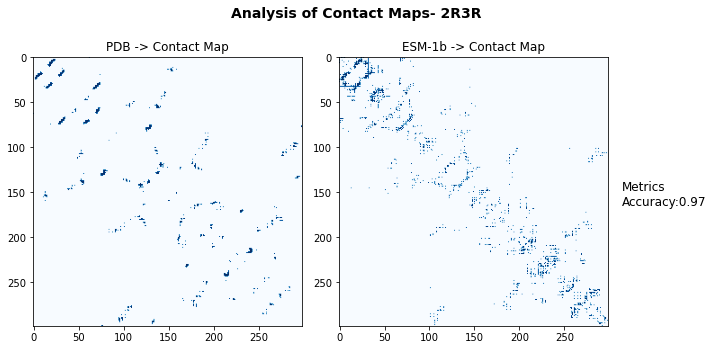

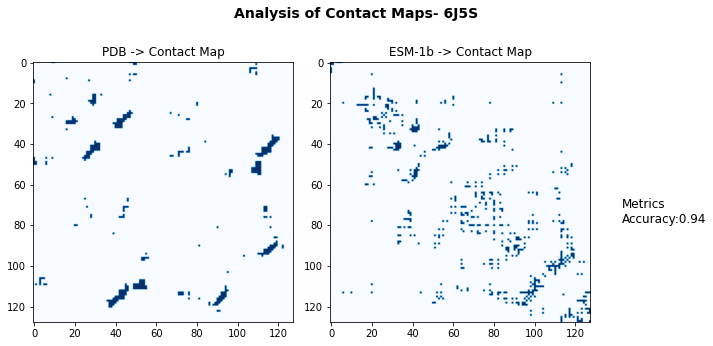

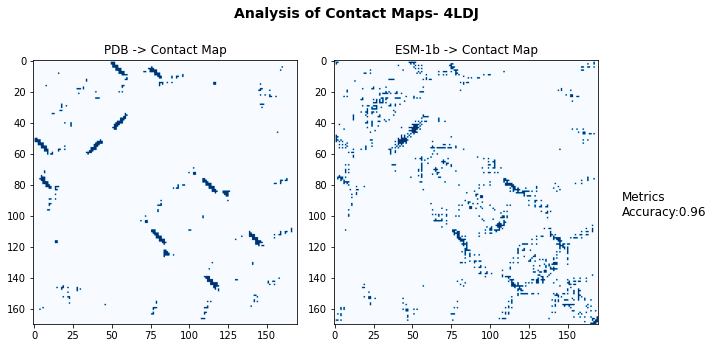

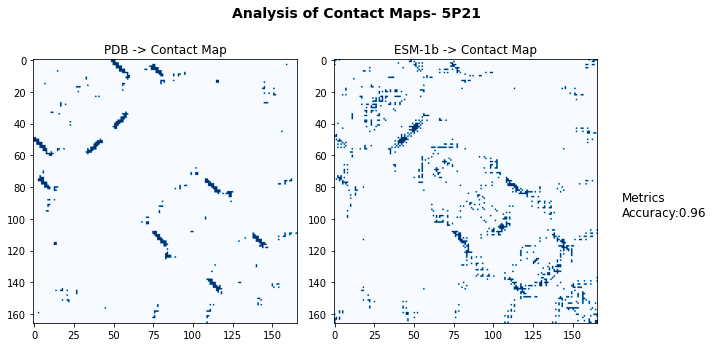

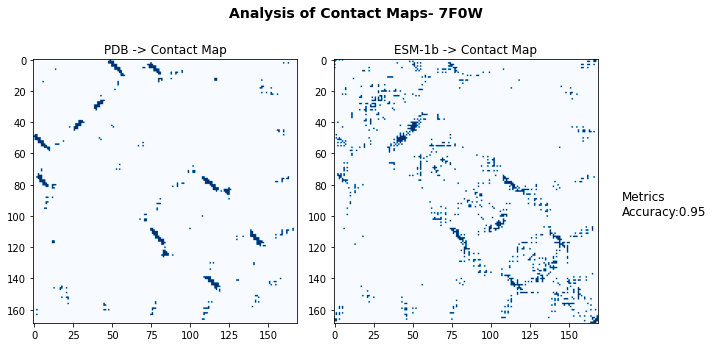

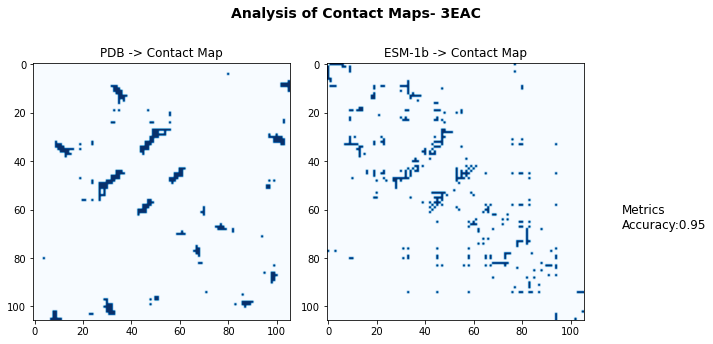

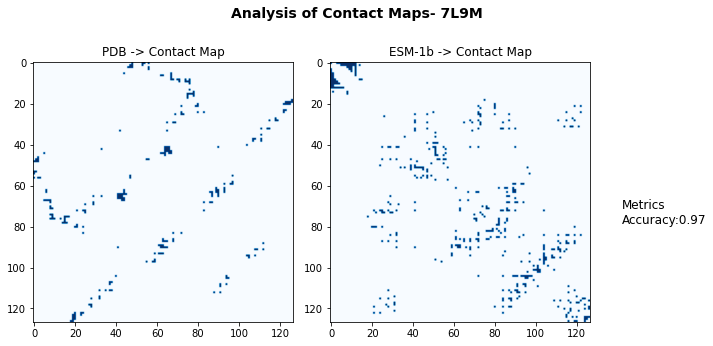

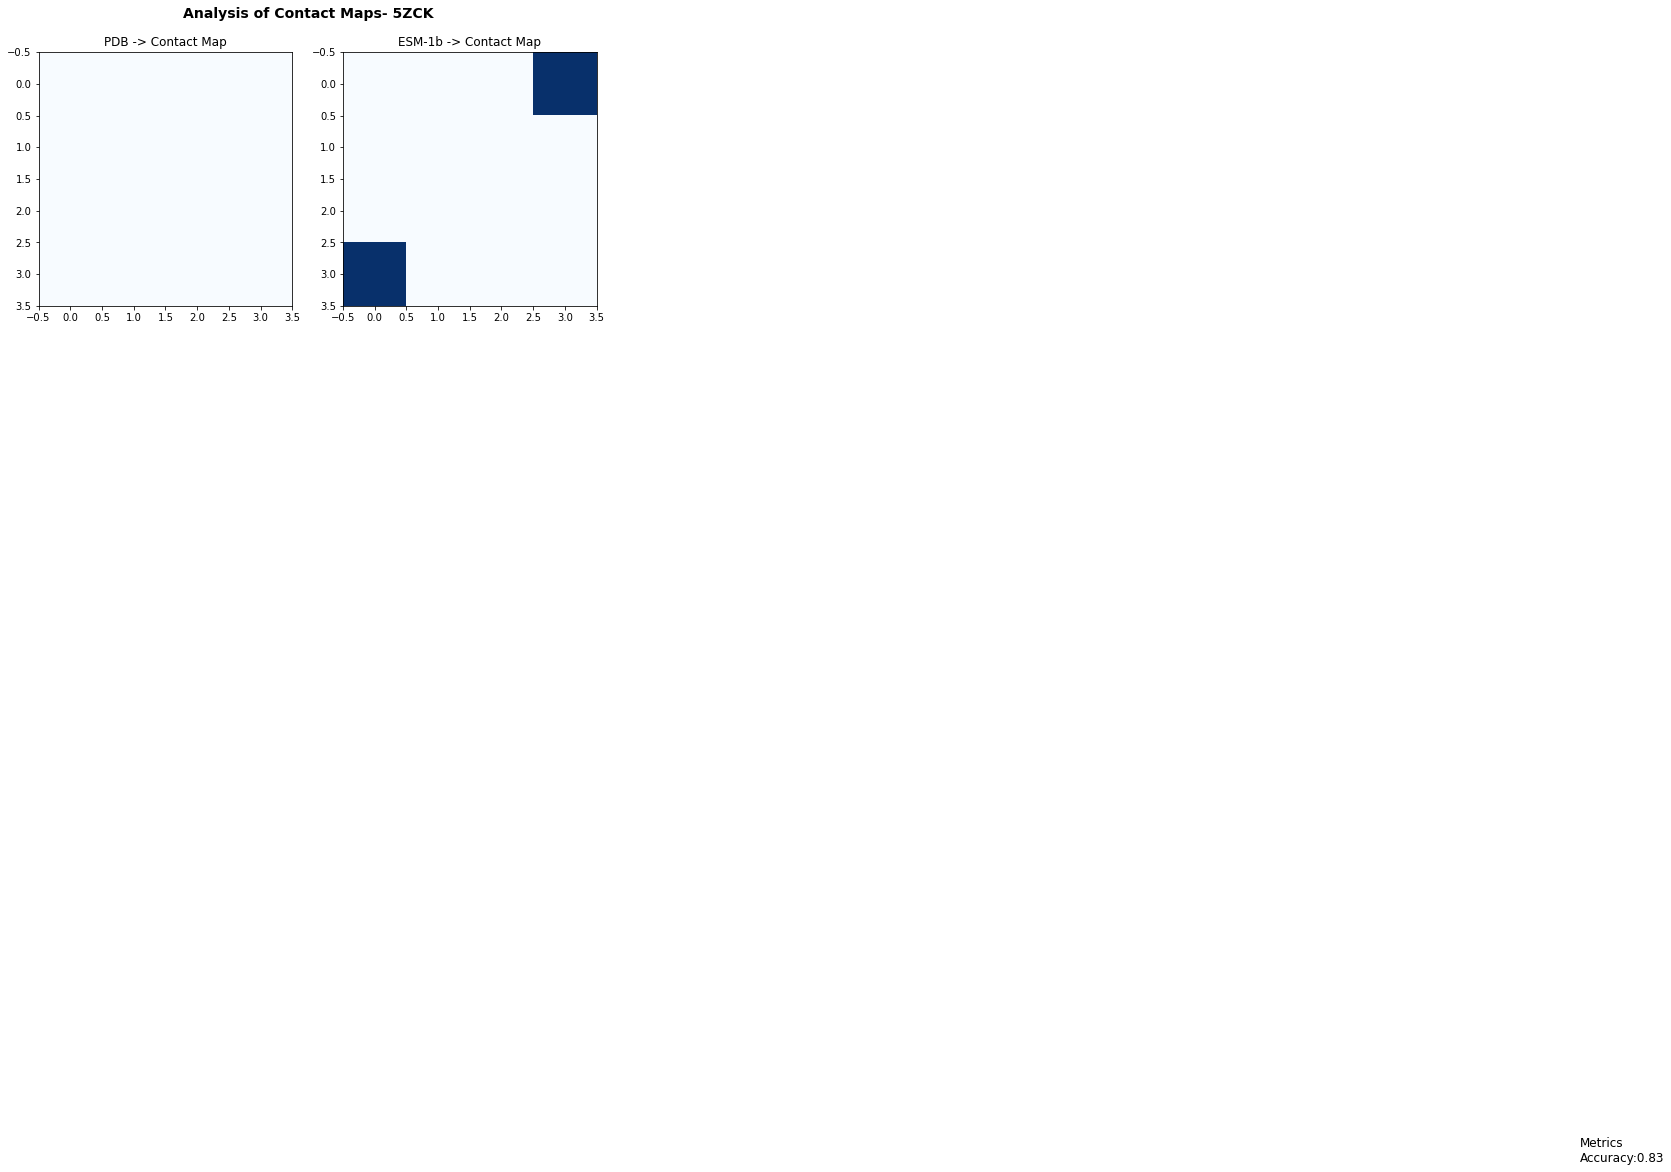

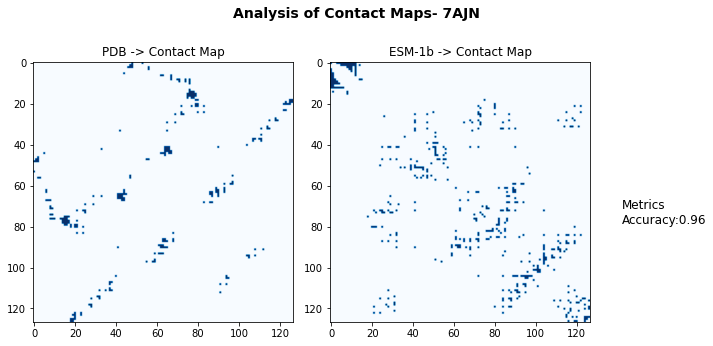

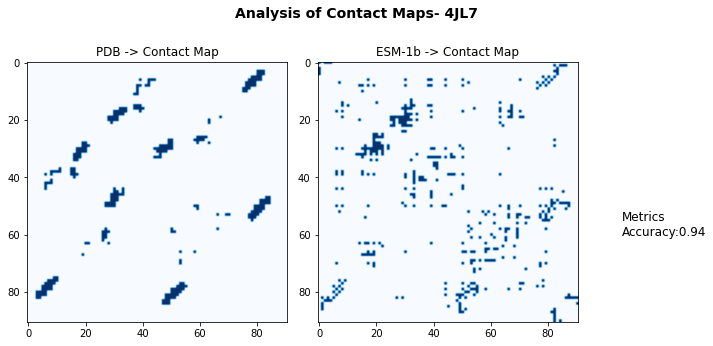

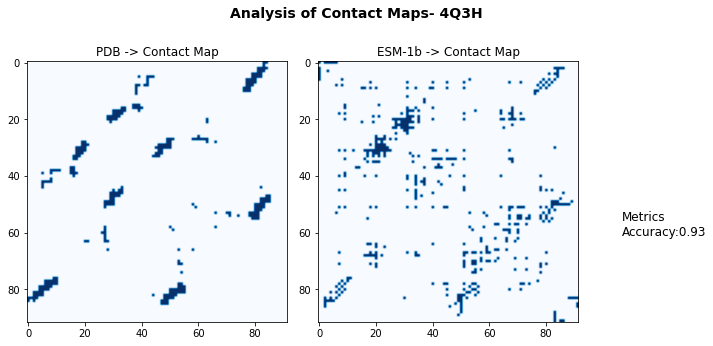

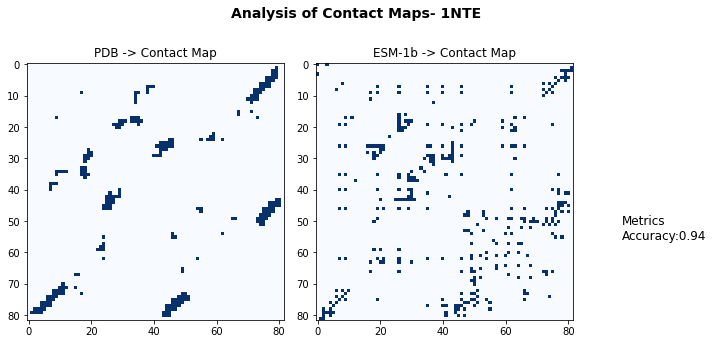

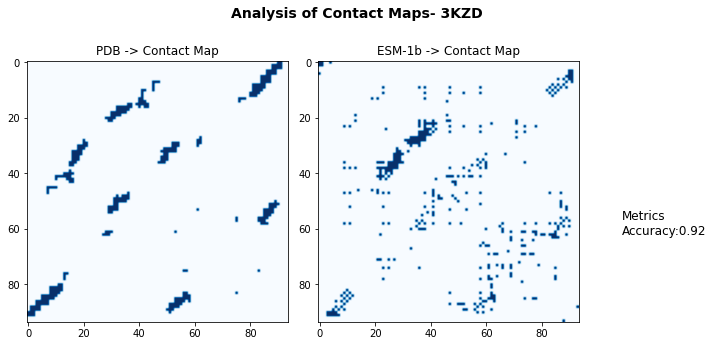

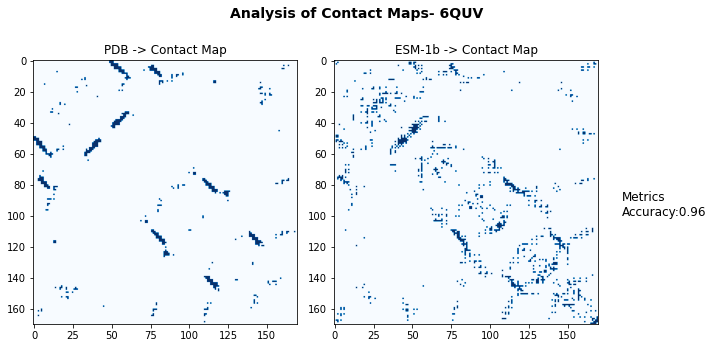

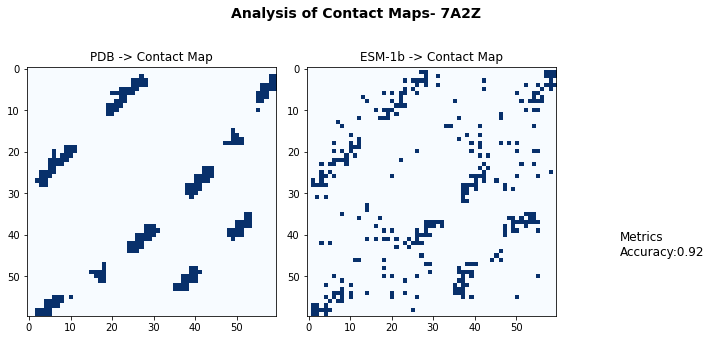

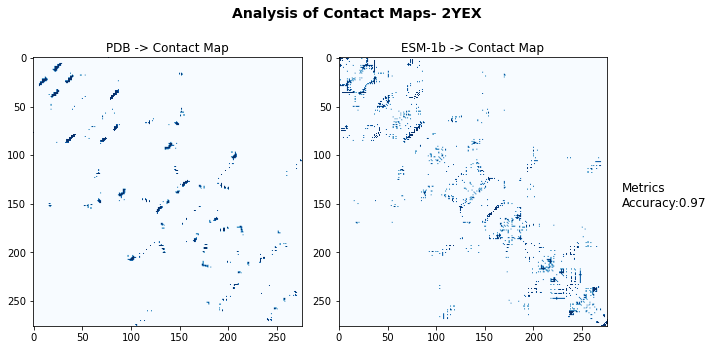

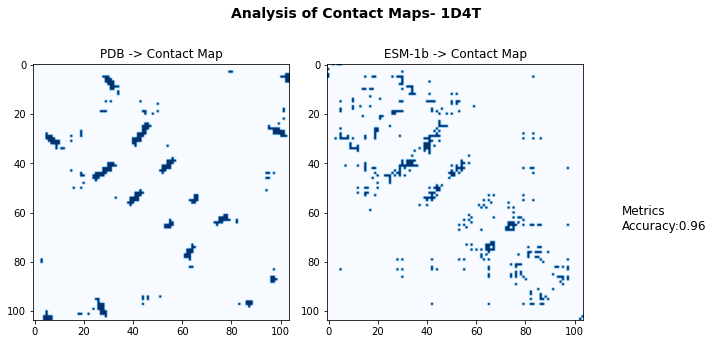

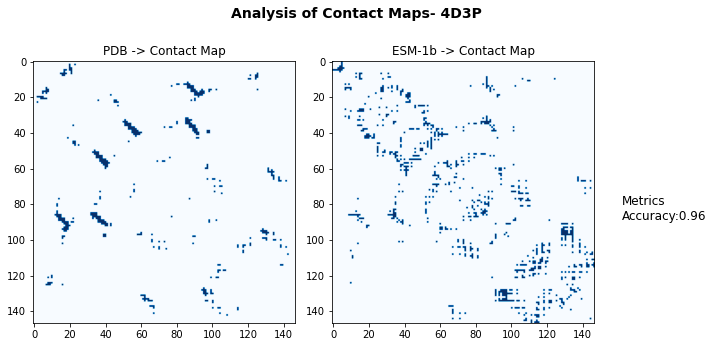

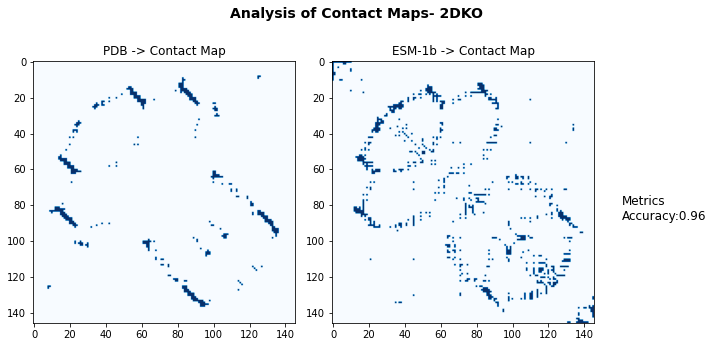

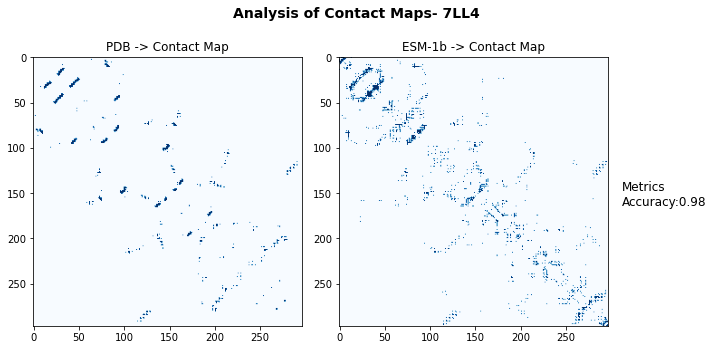

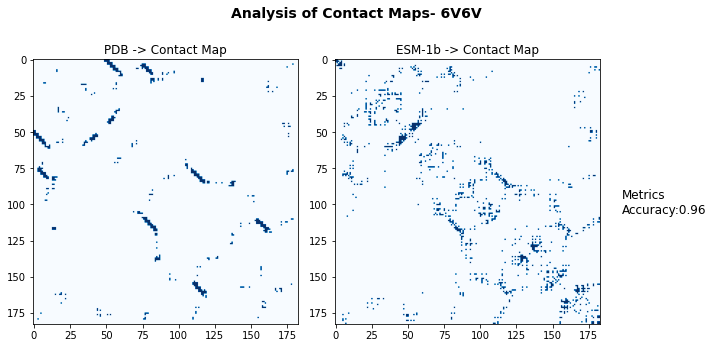

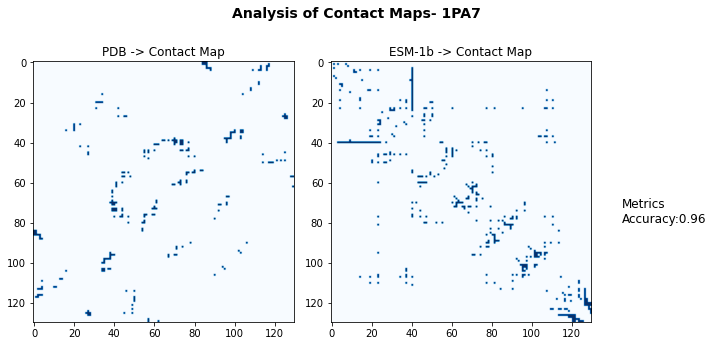

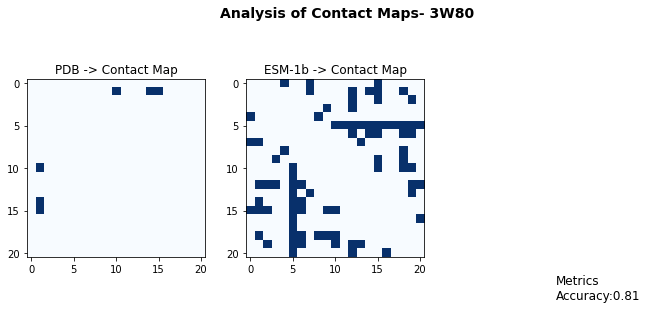

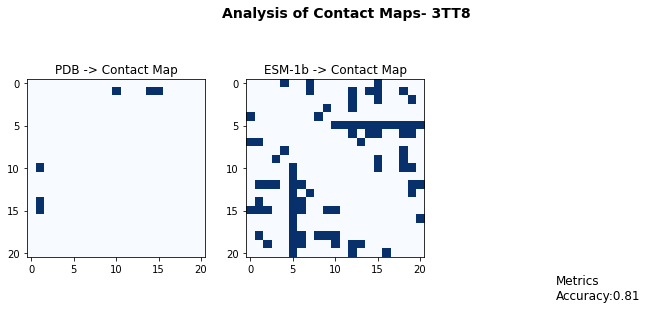

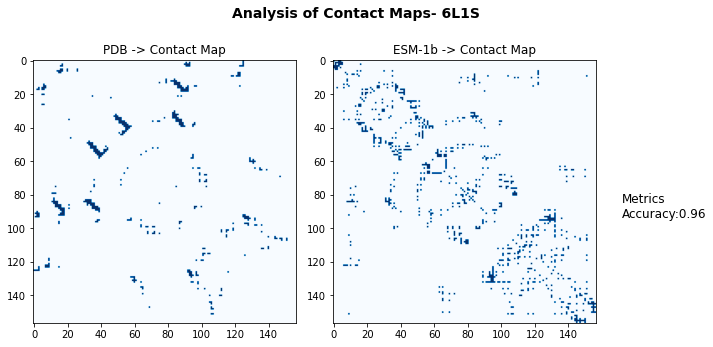

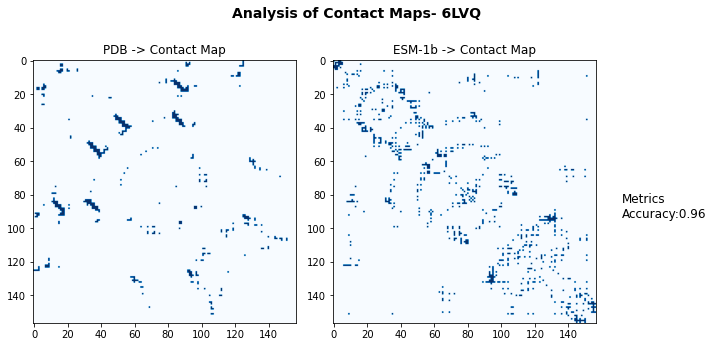

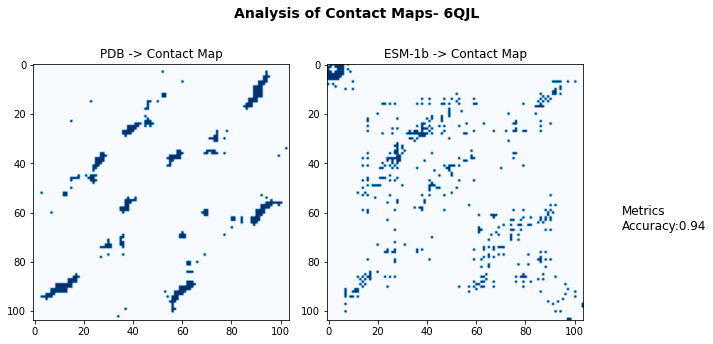

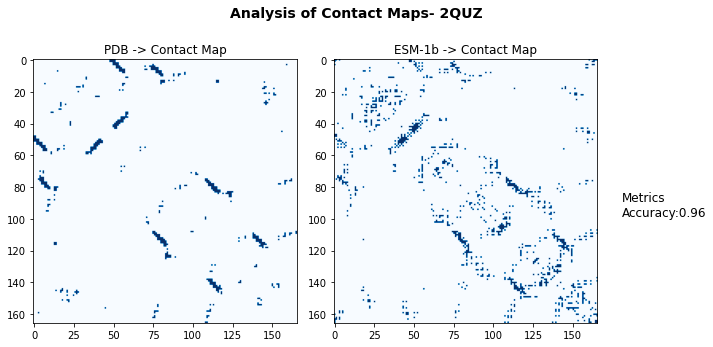

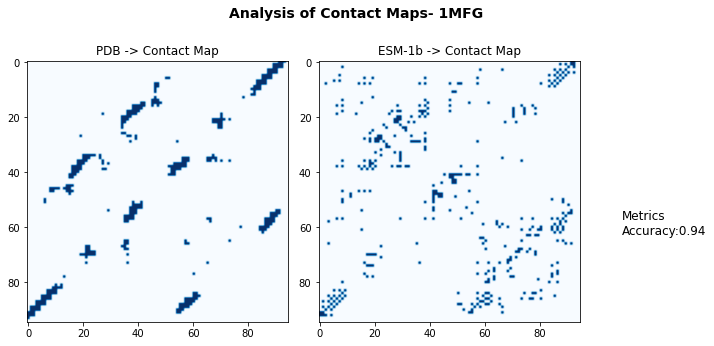

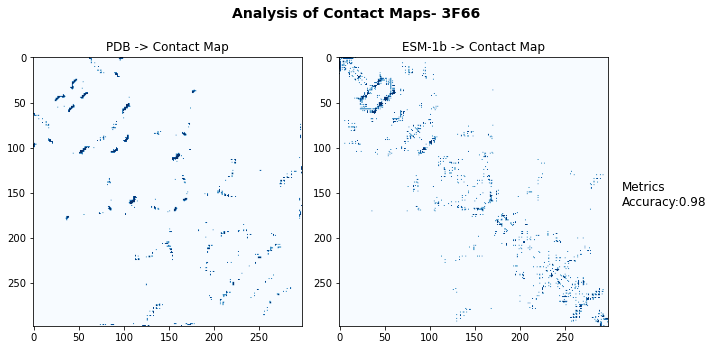

In [324]:
PDB_IDs = pdb_list
results_path="/Users/rohan/Desktop/DTI_setup/results_main/"
for i,j in enumerate(PDB_IDs):
    print(PDB_IDs[i])
    PDB_IDs_lower = str(PDB_IDs[i]).lower()
    PDB_file = f'//Users/rohan/Desktop/DTI_setup/data1/test1/pdb{PDB_IDs_lower}.ent'
    fasta_file=f'//Users/rohan/Desktop/DTI_setup/data1/test2/{PDB_IDs[i]}_1.fasta'
    #PDB_check = open(PDB_file, 'r')
    if os.path.isfile(PDB_file) and os.path.isfile(fasta_file):
        contact_pdb=getContactMap_fromPDB(PDB_file)
        contact_esm=getContactMap_fromESM(esm1b,esm1b_batch_converter,fasta_file)
    #print(PDB_file)
#     if os.path.isfile(PDB_file) and os.path.isfile(fasta_file):
#         contact_pdb=getContactMap_fromPDB(PDB_file)
#         contact_esm=getContactMap_fromESM
        compareContactMaps(contact_pdb,contact_esm,PDB_IDs[i],results_path)
        continue

2D9Z
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  32.
  35.  36.  38.  45.  46.  60.  61.  65.  66.  67.  68.  69.  70.  71.
  72.  73.  74.  75.  87.  88.  90.  91.  92.  93. 107. 110. 111. 113.
 114.]
129 129
8256 8256
1A7S
[  0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  69.  70.  71.  72.  73.
  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  86.  87.  88.  89.
  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 104. 108.
 110. 114. 115. 116. 117. 121. 122. 123. 124. 125. 126. 127. 129. 130.
 131. 132. 133. 134. 135. 136. 137. 138. 139. 142. 143. 144. 145. 146.
 147. 148. 156. 157. 158. 160. 161. 162. 1

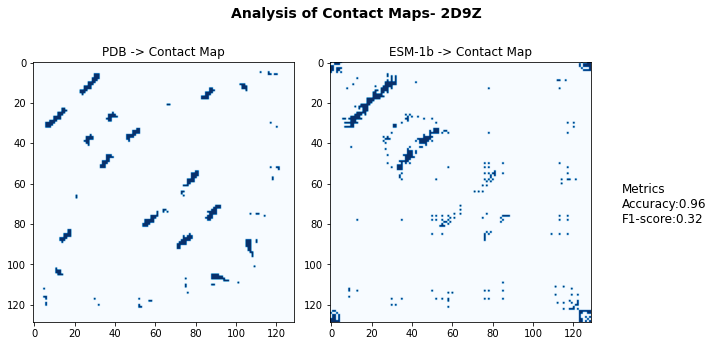

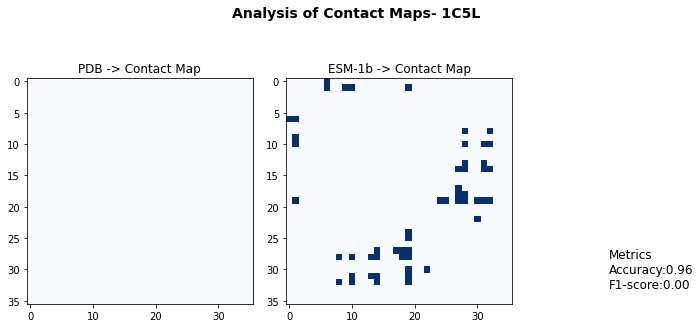

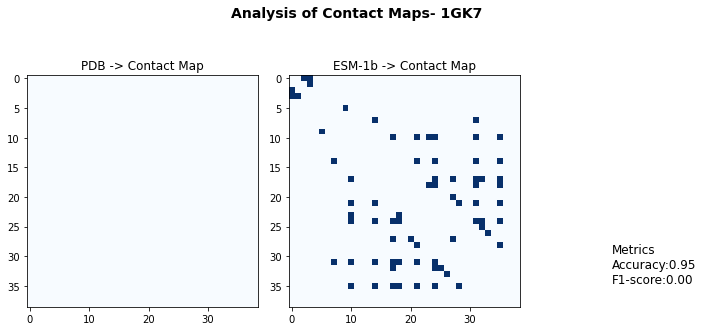

In [315]:
PDB_IDs = ["2D9Z","1A7S",'1C5L','1GK7','3o96']
results_path="/Users/rohan/Desktop/DTI_setup/results/"
for i,j in enumerate(PDB_IDs):
    print(PDB_IDs[i])
    PDB_IDs_lower = str(PDB_IDs[i]).lower()
    PDB_file = f'//Users/rohan/Desktop/DTI_setup/data1/test1/pdb{PDB_IDs_lower}.ent'
    fasta_file=f'//Users/rohan/Desktop/DTI_setup/data1/test2/{PDB_IDs[i]}_1.fasta'
    PDB_check = open(PDB_file, 'r')
    contact_pdb=getContactMap_fromPDB(PDB_file)
    contact_esm=getContactMap_fromESM(esm1b,esm1b_batch_converter,fasta_file)
    #print(PDB_file)
#     if os.path.isfile(PDB_file) and os.path.isfile(fasta_file):
#         contact_pdb=getContactMap_fromPDB(PDB_file)
#         contact_esm=getContactMap_fromESM
    compareContactMaps(contact_pdb,contact_esm,PDB_IDs[i],results_path)
    continue

In [291]:
def getContactMaps(contact_pdb,contact_esm,pdb_name,results_path):
    print(contact_pdb.shape[0],contact_esm.shape[0])
    if contact_pdb.shape[0]==contact_esm.shape[0]:
        contact_pdb_upperTraingle=contact_pdb[np.triu_indices(contact_pdb.shape[0],k=1)]
        contact_pdb_upperTraingle=np.multiply(contact_pdb_upperTraingle,1)
        contact_esm_upperTraingle=contact_esm[np.triu_indices(contact_esm.shape[0],k=1)]
        contact_esm_upperTraingle=np.multiply(contact_esm_upperTraingle,1)
#         contact_pdb_upperTraingle=contact_pdb[np.triu_indices(contact_pdb.shape[0],k=1)]
#         contact_esm_upperTraingle=contact_esm[np.triu_indices(contact_esm.shape[0],k=1)]
#         print(len(contact_pdb_upperTraingle),len(contact_esm_upperTraingle))
#         acc,f1,prec,rec=accuracy_score(contact_pdb_upperTraingle,contact_esm_upperTraingle),f1_score(contact_pdb_upperTraingle,contact_esm_upperTraingle),precision_score(contact_pdb_upperTraingle,contact_esm_upperTraingle),recall_score(contact_pdb_upperTraingle,contact_esm_upperTraingle)
        title_text='Analysis of Contact Maps- %s'%(pdb_name)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        fig.suptitle(title_text, fontsize=14,fontweight='bold')
        ax[0].title.set_text('PDB -> Contact Map')
        ax[0].imshow(contact_pdb,cmap="Blues")
        ax[1].title.set_text('ESM-1b -> Contact Map')
        ax[1].imshow(contact_esm,cmap="Blues")
        #resultstr = 'Metrics\nAccuracy:%.2f\nF1-score:%.2f\nPrecision:%.2f\nRecall:%.2f\n'%(acc,f1,prec,rec)
        #ax[1].text(140, 75, resultstr, fontsize=12)
        fig.tight_layout()
        final_result_path=results_path+pdb_name+".pdf"
        fig.savefig(final_result_path, bbox_inches='tight')
    else:
        print('FASTA and PDB are differnet for' +str(pdb_name))

In [276]:
def compareContactMaps(contact_pdb,contact_esm,pdb_name,results_path):
    print(contact_pdb.shape[0],contact_esm.shape[0])
    contact_pdb_upperTraingle=contact_pdb[np.triu_indices(contact_pdb.shape[0],k=1)]
    contact_esm_upperTraingle=contact_esm[np.triu_indices(contact_esm.shape[0],k=1)]
    print(len(contact_pdb_upperTraingle),len(contact_esm_upperTraingle))
    acc,f1,prec,rec=accuracy_score(contact_pdb_upperTraingle,contact_esm_upperTraingle),f1_score(contact_pdb_upperTraingle,contact_esm_upperTraingle),precision_score(contact_pdb_upperTraingle,contact_esm_upperTraingle),recall_score(contact_pdb_upperTraingle,contact_esm_upperTraingle)
    title_text='Analysis of Contact Maps- %s'%(pdb_name)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(title_text, fontsize=14,fontweight='bold')
    ax[0].title.set_text('PDB -> Contact Map')
    ax[0].imshow(contact_pdb,cmap="Blues")
    ax[1].title.set_text('ESM-1b -> Contact Map')
    ax[1].imshow(contact_esm,cmap="Blues")
    resultstr = 'Metrics\nAccuracy:%.2f\nF1-score:%.2f\nPrecision:%.2f\nRecall:%.2f\n'%(acc,f1,prec,rec)
    ax[1].text(140, 75, resultstr, fontsize=12)
    fig.tight_layout()
    final_result_path=results_path+pdb_name+".pdf"
    fig.savefig(final_result_path, bbox_inches='tight')

In [92]:
from Bio.Align.Applications import MafftCommandline

In [97]:
PDB_IDs = ["2D9Z",'3o96']
#Load ESM_1b Model
#esm1b,esm1b_batch_converter=load_ESM_1b()
#Set the path to results
results_path="/Users/rohan/Desktop/contact_map_analysis/data_main/aligned_fasta/" 
for i,j in enumerate(PDB_IDs):
    print(PDB_IDs[i])
    PDB_IDs_lower = str(PDB_IDs[i]).lower()
    #Set path to PDB files
    PDB_file = f'/Users/rohan/Desktop/DTI_setup/data_main/pdb_files/pdb{PDB_IDs_lower}.ent' 
    #Set path to FASTA files
    fasta_file=f'/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/{PDB_IDs[i]}_1.fasta'
    print(fasta_file)
    aligned_fasta_file=f'//Users/rohan/Desktop/contact_map_analysis/data_main/aligned_fasta/{PDB_IDs[i]}_1_aligned.fasta'
    if os.path.isfile(PDB_file) and os.path.isfile(fasta_file):
        with open(fasta_file) as f:
            print(f)
            print(fasta_file)
            output= aligned_fasta_file
            mafft_cline=MafftCommandline(input=str())
            stdout,stderr=mafft_cline()
            with open(output,'w') as handle:
                handle.write(stdout)

2D9Z
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2D9Z_1.fasta
<_io.TextIOWrapper name='/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2D9Z_1.fasta' mode='r' encoding='UTF-8'>
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2D9Z_1.fasta


ApplicationError: Non-zero return code 127 from 'mafft', message '/bin/sh: mafft: command not found'

In [98]:
mafft_cline = MafftCommandline(input='/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2D9Z_1.fasta')

In [99]:
print(mafft_cline)

mafft /Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2D9Z_1.fasta


In [100]:
aligned_fasta_file=f'/Users/rohan/Desktop/contact_map_analysis/data_main/aligned_fasta/{PDB_IDs[i]}_1_aligned.fasta'

In [103]:
stdout, stderr = mafft_cline()
with open(aligned_fasta_file, "w") as handle:
    handle.write(stdout)
from Bio import AlignIO
align = AlignIO.read(aligned_fasta_file, "fasta")

In [107]:
PDB_IDs = pdb_list
#Load ESM_1b Model
#esm1b,esm1b_batch_converter=load_ESM_1b()
#Set the path to results
results_path="/Users/rohan/Desktop/contact_map_analysis/data_main/aligned_fasta/" 
for i,j in enumerate(PDB_IDs):
    print(PDB_IDs[i])
    PDB_IDs_lower = str(PDB_IDs[i]).lower()
    #Set path to PDB files
    PDB_file = f'/Users/rohan/Desktop/DTI_setup/data_main/pdb_files/pdb{PDB_IDs_lower}.ent' 
    #Set path to FASTA files
    fasta_file=f'/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/{PDB_IDs[i]}_1.fasta'
    print(fasta_file)
    aligned_fasta_file=f'//Users/rohan/Desktop/contact_map_analysis/data_main/aligned_fasta/{PDB_IDs[i]}_1_aligned.fasta'
    if os.path.isfile(PDB_file) and os.path.isfile(fasta_file):
        with open(fasta_file) as f:
            output= aligned_fasta_file
            mafft_cline = MafftCommandline(input=fasta_file)
            stdout, stderr = mafft_cline()
            with open(aligned_fasta_file, "w") as handle:
                handle.write(stdout)


3KHF
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3KHF_1.fasta
3LQ3
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3LQ3_1.fasta
3FEG
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3FEG_1.fasta
6YA6
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6YA6_1.fasta
2WWE
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2WWE_1.fasta
2IIM
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2IIM_1.fasta
4L0N
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4L0N_1.fasta
3WAR
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3WAR_1.fasta
2X18
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2X18_1.fasta
7A22
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7A22_1.fasta
7A1Z
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7A1Z_1.fasta
7A2H
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7A2H_1.fasta
7A1B
/Users/roha

2R3Q
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2R3Q_1.fasta
2WP3
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2WP3_1.fasta
4RRV
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4RRV_1.fasta
6I5H
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6I5H_1.fasta
7REK
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7REK_1.fasta
5W55
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5W55_1.fasta
2BRF
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2BRF_1.fasta
4GRZ
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4GRZ_1.fasta
3CZT
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3CZT_1.fasta
4N19
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4N19_1.fasta
6VJJ
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6VJJ_1.fasta
6G36
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6G36_1.fasta
6HOI
/Users/roha

6QUV
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6QUV_1.fasta
2FE5
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2FE5_1.fasta
3O3U
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3O3U_1.fasta
7A2S
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7A2S_1.fasta
7A2T
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7A2T_1.fasta
7A2R
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7A2R_1.fasta
7A2Z
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7A2Z_1.fasta
4XOF
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4XOF_1.fasta
3KNB
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3KNB_1.fasta
1M9Z
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/1M9Z_1.fasta
1WMA
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/1WMA_1.fasta
6FNM
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6FNM_1.fasta
6ZJE
/Users/roha

5OGJ
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5OGJ_1.fasta
3L8Z
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3L8Z_1.fasta
3TGP
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3TGP_1.fasta
2AFY
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2AFY_1.fasta
6LCB
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6LCB_1.fasta
5NNG
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5NNG_1.fasta
5CU6
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5CU6_1.fasta
1I73
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/1I73_1.fasta
1TGR
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/1TGR_1.fasta
7REE
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7REE_1.fasta
6YIA
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6YIA_1.fasta
7LL4
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7LL4_1.fasta
5E8S
/Users/roha

6FNG
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6FNG_1.fasta
6FNH
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6FNH_1.fasta
4RX5
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4RX5_1.fasta
6Q7C
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6Q7C_1.fasta
6Q7B
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6Q7B_1.fasta
6HEY
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6HEY_1.fasta
6Q7G
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6Q7G_1.fasta
6Q7E
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6Q7E_1.fasta
6Q7F
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6Q7F_1.fasta
4HJP
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4HJP_1.fasta
3F66
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3F66_1.fasta
5MXO
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5MXO_1.fasta
4WOH
/Users/roha

5P9I
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5P9I_1.fasta
5P9J
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5P9J_1.fasta
4J46
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4J46_1.fasta
4J45
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4J45_1.fasta
4J44
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4J44_1.fasta
4J47
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4J47_1.fasta
5S9K
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5S9K_1.fasta
5S8A
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5S8A_1.fasta
5S81
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5S81_1.fasta
5S7N
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5S7N_1.fasta
5S7L
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5S7L_1.fasta
5S7M
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5S7M_1.fasta
5S7K
/Users/roha

4J9E
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4J9E_1.fasta
4J9C
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4J9C_1.fasta
4BW1
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4BW1_1.fasta
6V0U
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6V0U_1.fasta
4J9F
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4J9F_1.fasta
7NFB
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7NFB_1.fasta
4CFL
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4CFL_1.fasta
4QC4
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4QC4_1.fasta
2X2A
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2X2A_1.fasta
6BOF
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6BOF_1.fasta
6P0J
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6P0J_1.fasta
1PIN
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/1PIN_1.fasta
6P0K
/Users/roha

6XUZ
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6XUZ_1.fasta
6XVC
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6XVC_1.fasta
6XV3
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6XV3_1.fasta
6B0V
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6B0V_1.fasta
6G0R
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6G0R_1.fasta
4AW0
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4AW0_1.fasta
5J41
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5J41_1.fasta
6ODG
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6ODG_1.fasta
6SZM
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6SZM_1.fasta
6G3R
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6G3R_1.fasta
6Y1E
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6Y1E_1.fasta
5PYW
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5PYW_1.fasta
5PXB
/Users/roha

6DJC
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6DJC_1.fasta
5XHE
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5XHE_1.fasta
5KU3
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5KU3_1.fasta
5NWD
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5NWD_1.fasta
5NWG
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5NWG_1.fasta
7ROV
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7ROV_1.fasta
3I3S
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3I3S_1.fasta
5Y8C
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5Y8C_1.fasta
6SQO
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6SQO_1.fasta
3RFE
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3RFE_1.fasta
4DLR
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4DLR_1.fasta
5KHM
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5KHM_1.fasta
6XDS
/Users/roha

2C9U
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2C9U_1.fasta
2C9V
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2C9V_1.fasta
4HY4
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4HY4_1.fasta
1DG6
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/1DG6_1.fasta
4AG1
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4AG1_1.fasta
3NCL
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3NCL_1.fasta
7KG8
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7KG8_1.fasta
4QUJ
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4QUJ_1.fasta
5CQ2
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5CQ2_1.fasta
3SJM
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3SJM_1.fasta
6QW3
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6QW3_1.fasta
6NV2
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6NV2_1.fasta
6QHM
/Users/roha

4HF3
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4HF3_1.fasta
6P0I
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6P0I_1.fasta
7RNU
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7RNU_1.fasta
6NSV
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6NSV_1.fasta
7NX1
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7NX1_1.fasta
5S8I
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5S8I_1.fasta
5S8J
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5S8J_1.fasta
5S8G
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5S8G_1.fasta
5S8H
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5S8H_1.fasta
5S8E
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5S8E_1.fasta
5S8F
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5S8F_1.fasta
5S8C
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5S8C_1.fasta
5S8D
/Users/roha

5UDP
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5UDP_1.fasta
5E50
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5E50_1.fasta
1X96
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/1X96_1.fasta
1X98
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/1X98_1.fasta
3ONB
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3ONB_1.fasta
3ONC
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3ONC_1.fasta
2QJZ
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2QJZ_1.fasta
4UZ1
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4UZ1_1.fasta
4WW6
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4WW6_1.fasta
6XXC
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6XXC_1.fasta
6XY5
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6XY5_1.fasta
6Y18
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6Y18_1.fasta
6UYV
/Users/roha

5MFA
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5MFA_1.fasta
5L0N
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5L0N_1.fasta
6TUZ
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6TUZ_1.fasta
4OUF
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4OUF_1.fasta
2PIE
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2PIE_1.fasta
4QX5
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4QX5_1.fasta
2W4J
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2W4J_1.fasta
5I83
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5I83_1.fasta
5I89
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5I89_1.fasta
5I86
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5I86_1.fasta
2WZB
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2WZB_1.fasta
3ZZY
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3ZZY_1.fasta
4GWG
/Users/roha

7NFW
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7NFW_1.fasta
5M6V
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5M6V_1.fasta
6O8I
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6O8I_1.fasta
6G5P
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6G5P_1.fasta
7KSW
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7KSW_1.fasta
5M71
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5M71_1.fasta
5M6Y
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5M6Y_1.fasta
5M0L
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5M0L_1.fasta
5LCQ
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5LCQ_1.fasta
5LBZ
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5LBZ_1.fasta
5LBY
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5LBY_1.fasta
7L67
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7L67_1.fasta
7L64
/Users/roha

7O34
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7O34_1.fasta
7NLA
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7NLA_1.fasta
7NM1
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7NM1_1.fasta
7NJ9
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7NJ9_1.fasta
7BKH
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7BKH_1.fasta
7BJF
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7BJF_1.fasta
7BJL
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7BJL_1.fasta
7BJW
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7BJW_1.fasta
7BIW
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7BIW_1.fasta
7NZK
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7NZK_1.fasta
7NZG
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7NZG_1.fasta
7NZV
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7NZV_1.fasta
7NYF
/Users/roha

4X9R
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4X9R_1.fasta
6G0G
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6G0G_1.fasta
6BQA
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6BQA_1.fasta
4ZZN
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4ZZN_1.fasta
3K0N
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3K0N_1.fasta
3K0M
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3K0M_1.fasta
5TA2
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5TA2_1.fasta
5T9Z
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5T9Z_1.fasta
5V5C
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5V5C_1.fasta
6GGF
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6GGF_1.fasta
5O1I
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5O1I_1.fasta
6GGC
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6GGC_1.fasta
6GGD
/Users/roha

5IPE
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5IPE_1.fasta
4GGC
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4GGC_1.fasta
3K8Y
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3K8Y_1.fasta
4AOH
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4AOH_1.fasta
4GRR
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4GRR_1.fasta
4GRP
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4GRP_1.fasta
6YF2
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6YF2_1.fasta
6YF3
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6YF3_1.fasta
6YF1
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6YF1_1.fasta
5M9Q
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5M9Q_1.fasta
5M9R
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5M9R_1.fasta
5MG7
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5MG7_1.fasta
5MCT
/Users/roha

6ROT
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6ROT_1.fasta
5JZY
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5JZY_1.fasta
3P17
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3P17_1.fasta
5R7W
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5R7W_1.fasta
6Y8I
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6Y8I_1.fasta
4HK2
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4HK2_1.fasta
5NHU
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5NHU_1.fasta
6YSX
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6YSX_1.fasta
4IBY
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4IBY_1.fasta
5A7B
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5A7B_1.fasta
4AGQ
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4AGQ_1.fasta
4AGO
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4AGO_1.fasta
3U8O
/Users/roha

5YBY
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5YBY_1.fasta
4ZSD
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4ZSD_1.fasta
5CBT
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5CBT_1.fasta
6ALC
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6ALC_1.fasta
6F78
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6F78_1.fasta
5I8G
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5I8G_1.fasta
5V8Q
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5V8Q_1.fasta
6AY3
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6AY3_1.fasta
6AXQ
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6AXQ_1.fasta
5W0E
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5W0E_1.fasta
6RT6
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6RT6_1.fasta
6RT4
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/6RT4_1.fasta
6EW6
/Users/roha

2PDG
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2PDG_1.fasta
2PDH
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2PDH_1.fasta
2PDL
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2PDL_1.fasta
1Z3N
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/1Z3N_1.fasta
3LQG
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/3LQG_1.fasta
5KL3
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/5KL3_1.fasta
4PK3
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4PK3_1.fasta
4PK2
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4PK2_1.fasta
4Q6S
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4Q6S_1.fasta
2XG3
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2XG3_1.fasta
4UE1
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4UE1_1.fasta
1A7S
/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/1A7S_1.fasta
6HN3
/Users/roha

In [109]:
f= [next(SeqIO.parse("/Users/rohan/Desktop/contact_map_analysis/data_main/aligned_fasta/2D9Z_1_aligned.fasta", "fasta"))]
f

[SeqRecord(seq=Seq('GSSGSSGMVKEGWMVHYTSRDNLRKRHYWRLDSKCLTLFQNESGSKYYKEIPLS...SSG'), id='2D9Z_1|Chain', name='2D9Z_1|Chain', description='2D9Z_1|Chain A|Protein kinase C, nu type|Homo sapiens (9606)', dbxrefs=[])]

In [ ]:
f= [next(SeqIO.parse("/Users/rohan/Desktop/contact_map_analysis/data_main/aligned_fasta/2D9Z_1.fasta", "fasta"))]
f

In [124]:
import sys
from Bio import SeqIO

PDBFile = '/Users/rohan/Desktop/DTI_setup/data_main/pdb_files/pdb4cl9.ent'
with open(PDBFile, 'r') as pdb_file:
    for record in SeqIO.parse(pdb_file, 'pdb-atom'):
        print('>' + record.id)
        print(record.seq)
        print(len(record.seq))

>4CL9:A
SMNPPPPETSNPNKPKRQTNQLQYLLRVVLKTLWKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFTNCYIYNKPGDDIVLMAEALEKLFLQKINELPTEE
127


In [125]:
f= [next(SeqIO.parse("/Users/rohan/Desktop/contact_map_analysis/data_main/aligned_fasta/4CL9_1_aligned.fasta", "fasta"))]
f
print(f[0].seq)
print(len(f[0].seq))

SMNPPPPETSNPNKPKRQTNQLQYLLRVVLKTLWKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFTNCYIYNKPGDDIVLMAEALEKLFLQKINELPTEE
127


In [126]:
f= [next(SeqIO.parse("/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/4CL9_1.fasta", "fasta"))]
f
print(f[0].seq)
print(len(f[0].seq))

SMNPPPPETSNPNKPKRQTNQLQYLLRVVLKTLWKHQFAWPFQQPVDAVKLNLPDYYKIIKTPMDMGTIKKRLENNYYWNAQECIQDFNTMFTNCYIYNKPGDDIVLMAEALEKLFLQKINELPTEE
127


In [127]:
f= [next(SeqIO.parse("/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2QUZ_1.fasta", "fasta"))]
f
print(f[0].seq)
print(len(f[0].seq))

MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHQYREQIKRVKDSDDVPMVLVGNRCDLAARTVESRQAQDLARSYGIPYIETSAKTRQGVEDAFYTLVREIRQH
166


In [128]:
import sys
from Bio import SeqIO

PDBFile = '/Users/rohan/Desktop/DTI_setup/data_main/pdb_files/pdb2quz.ent'
with open(PDBFile, 'r') as pdb_file:
    for record in SeqIO.parse(pdb_file, 'pdb-atom'):
        print('>' + record.id)
        print(record.seq)
        print(len(record.seq))

>2QUZ:A
MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHQYREQIKRVKDSDDVPMVLVGNRCDLAARTVESRQAQDLARSYGIPYIETSAKTRQGVEDAFYTLVREIRQHXXXXXXXXXXXXXG
180


In [ ]:
2quz

In [129]:
import sys
from Bio import SeqIO

PDBFile = '/Users/rohan/Desktop/DTI_setup/data_main/pdb_files/pdb2cf8.ent'
with open(PDBFile, 'r') as pdb_file:
    for record in SeqIO.parse(pdb_file, 'pdb-atom'):
        print('>' + record.id)
        print(record.seq)
        print(len(record.seq))

>2CF8:H
IVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETXXGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEXGCDRDGKYGFYTHVFRLKKWIQKVIDQF
253
>2CF8:I
FEEIP
5
>2CF8:L
ADCGLRPLFEKKSLEDKTERELLESYID
28


/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain H is discontinuous at line 5150.
  warnings.warn(
/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 5546.
  warnings.warn(
/Users/rohan/opt/anaconda3/envs/mldd/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain L is discontinuous at line 5550.
  warnings.warn(


In [130]:
f= [next(SeqIO.parse("/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/2CF8_1.fasta", "fasta"))]
f
print(f[0].seq)
print(len(f[0].seq))

IVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQF
257


In [131]:
f= [next(SeqIO.parse("/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/7SUG_1.fasta", "fasta"))]
f
print(f[0].seq)
print(len(f[0].seq))

MAVPFVEDWDLVQTLGEGAYGEVQLAVNRVTEEAVAVKIVDMKRAVDCPENIKKEICILKMLNHENVIKFYGHRREGNIQYLFMELASGGSLFDRIEPDIGMPEPDAQRFFHQLMAGVVYLHGIGITHRDIKPHNLLLDERDNLKIADYSLATVFRYNNRERLLNKMCGTLPYVAPELLKRREFHAEPVDVWSCGIVLTAMLAGELPWDQPSDSCQEYSDWKEKKTYLNPWKKIDSAPLALLHKILVENPSARITIPDIKKDRWYNKPLKKGAKRPRVTSGGVSESPSGHHHHHHHH
297


In [133]:
f= [next(SeqIO.parse("/Users/rohan/Desktop/contact_map_analysis/data_main/aligned_fasta/7SUG_1_aligned.fasta", "fasta"))]
f
print(f[0].seq)
print(len(f[0].seq))

MAVPFVEDWDLVQTLGEGAYGEVQLAVNRVTEEAVAVKIVDMKRAVDCPENIKKEICILKMLNHENVIKFYGHRREGNIQYLFMELASGGSLFDRIEPDIGMPEPDAQRFFHQLMAGVVYLHGIGITHRDIKPHNLLLDERDNLKIADYSLATVFRYNNRERLLNKMCGTLPYVAPELLKRREFHAEPVDVWSCGIVLTAMLAGELPWDQPSDSCQEYSDWKEKKTYLNPWKKIDSAPLALLHKILVENPSARITIPDIKKDRWYNKPLKKGAKRPRVTSGGVSESPSGHHHHHHHH
297


In [136]:
import sys
from Bio import SeqIO

PDBFile = '/Users/rohan/Desktop/DTI_setup/data_main/pdb_files/pdb7sug.ent'
with open(PDBFile, 'r') as pdb_file:
    for record in SeqIO.parse(pdb_file, 'pdb-atom'):
        print('>' + record.id)
        print(record.seq)
        print(len(record.seq))
        print(type(record.seq))

>7SUG:A
VPFVEDWDLVQTLGEGAYGEVQLAVNRVTEEAVAVKIVDXXXXXXXPENIKKEICILKMLNHENVIKFYGHRREGNIQYLFMELASGGSLFDRIEPDIGMPEPDAQRFFHQLMAGVVYLHGIGITHRDIKPHNLLLDERDNLKIADYSLATVFRYNNRERLLNKMCGTLPYVAPELLKRREFHAEPVDVWSCGIVLTAMLAGELPWDQPSDSCQEYSDWKEKKTYLNPWKKIDSAPLALLHKILVENPSARITIPDIKKDRWYNKPLKK
269
<class 'Bio.Seq.Seq'>


In [137]:
record

SeqRecord(seq=Seq('VPFVEDWDLVQTLGEGAYGEVQLAVNRVTEEAVAVKIVDXXXXXXXPENIKKEI...LKK'), id='7SUG:A', name='<unknown name>', description='7SUG:A', dbxrefs=[])

In [152]:
pdb_list

['3KHF',
 '3LQ3',
 '3FEG',
 '6YA6',
 '2WWE',
 '2IIM',
 '4L0N',
 '3WAR',
 '2X18',
 '7A22',
 '7A1Z',
 '7A2H',
 '7A1B',
 '1WYX',
 '6Z19',
 '3M9J',
 '4YPD',
 '6ELM',
 '7D0E',
 '2YJC',
 '6YZH',
 '6GY5',
 '5JJ2',
 '7CCW',
 '2HSH',
 '6RCH',
 '6RCG',
 '1KGD',
 '3TW2',
 '3O46',
 '3I4W',
 '6TSE',
 '3S4E',
 '3G36',
 '6EGE',
 '2QT1',
 '6HOG',
 '2QFA',
 '2C60',
 '2XRW',
 '5GJH',
 '6G9Z',
 '5O8I',
 '1LKK',
 '4N6X',
 '3ZYQ',
 '2C01',
 '4RFZ',
 '3L46',
 '5EP6',
 '1EAZ',
 '6KC4',
 '6KEC',
 '6KEI',
 '5K26',
 '6TT2',
 '4EIH',
 '5NP5',
 '6B9X',
 '3FIA',
 '4LMM',
 '2R3R',
 '2R3I',
 '6HOL',
 '6J5S',
 '5ED3',
 '6TEW',
 '4FKL',
 '4EK4',
 '4EK3',
 '4P5Q',
 '6HMB',
 '6HMC',
 '6HMD',
 '4LDJ',
 '4OBE',
 '3LNY',
 '3WA4',
 '1OBX',
 '5P21',
 '5XRD',
 '4YDP',
 '4FH0',
 '7F0W',
 '6ZBK',
 '3EAZ',
 '3EAC',
 '6Q4Q',
 '5AUL',
 '7L9M',
 '6SRH',
 '7M10',
 '6Z36',
 '6B42',
 '5WA8',
 '5WA9',
 '5LR1',
 '5XRE',
 '5NYI',
 '3Q6L',
 '4MPA',
 '2R3Q',
 '2WP3',
 '4RRV',
 '6I5H',
 '7REK',
 '5W55',
 '2BRF',
 '4GRZ',
 '3CZT',
 '4N19',
 

In [154]:
PDB_IDs = ["2x5y"]
#PDB_IDs = pdb_list
#Load ESM_1b Model
#esm1b,esm1b_batch_converter=load_ESM_1b()
#Set the path to results
results_path="/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_pdb/" 
for i,j in enumerate(PDB_IDs):
    print(PDB_IDs[i])
    PDB_IDs_lower = str(PDB_IDs[i]).lower()
    #Set path to PDB files
    PDB_file = f'/Users/rohan/Desktop/contact_map_analysis/data_main/pdb_files/pdb{PDB_IDs_lower}.ent' 
    #Set path to FASTA files
    #fasta_file=f'/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/{PDB_IDs[i]}_1.fasta'
    #print(fasta_file)
    aligned_fasta_file=f'//Users/rohan/Desktop/contact_map_analysis/data_main/fasta_pdb/{PDB_IDs[i]}_1_pdb.fasta'
    print(os.path.isfile(PDB_file))
    if os.path.isfile(PDB_file):
        with open(PDB_file, 'r') as pdb_file:
            for record in SeqIO.parse(pdb_file, 'pdb-atom'):
                print('>' + record.id)
                print(record.seq)
                print(len(record.seq))
                SeqIO.write(record, aligned_fasta_file, "fasta")

2x5y
True
>2X5Y:A
KKYKLSEIHHLHPEYVRVSEHFKASMKNFKIEKIKKIENSELLDKFTWKKSQMKEEGKLLFYATSRAYVESICSNNFDSFLHETHENKYGKGIYFAKDAIYSHKNCPYDAKNVVMFVAQVLVGKFIEGNITYTSPPPQFDSCVDTRSNPSVFVIFQKDQVYPQYVIEYTED
171


In [ ]:
PDB_IDs = pdb_list

#Load ESM_1b Model
#esm1b,esm1b_batch_converter=load_ESM_1b()
#Set the path to results
results_path="/Users/rohan/Desktop/contact_map_analysis/data_main/aligned_fasta/" 
for i,j in enumerate(PDB_IDs):
    print(PDB_IDs[i])
    PDB_IDs_lower = str(PDB_IDs[i]).lower()
    #Set path to PDB files
    PDB_file = f'/Users/rohan/Desktop/DTI_setup/data_main/pdb_files/pdb{PDB_IDs_lower}.ent' 
    #Set path to FASTA files
    fasta_file=f'/Users/rohan/Desktop/contact_map_analysis/data_main/fasta_files/{PDB_IDs[i]}_1.fasta'
    print(fasta_file)
    aligned_fasta_file=f'//Users/rohan/Desktop/contact_map_analysis/data_main/aligned_fasta/{PDB_IDs[i]}_1_aligned.fasta'
    if os.path.isfile(PDB_file) and os.path.isfile(fasta_file):
        with open(fasta_file) as f:
            output= aligned_fasta_file
            mafft_cline = MafftCommandline(input=fasta_file)
            stdout, stderr = mafft_cline()
            with open(aligned_fasta_file, "w") as handle:
                handle.write(stdout)


In [1]:
from tdc.multi_pred import DTI
data = DTI(name = 'BindingDB_Kd')
# data = DTI(name = 'BindingDB_IC50')
# data = DTI(name = 'BindingDB_Ki')
split = data.get_split()

Downloading...
100%|█████████████████████████████████████| 54.4M/54.4M [00:06<00:00, 7.85MiB/s]
Loading...
Done!


In [5]:
split['train']

Drug_ID                                               Drug  \
0        444607.0          Cc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1   
1          4316.0         COc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1   
2          4293.0              NS(=O)(=O)c1ccc(S(=O)(=O)NCc2cccs2)s1   
3       4369102.0     CCN[C@H]1CN(CCOC)S(=O)(=O)c2sc(S(N)(=O)=O)cc21   
4       3013848.0  CN[C@H]1CN(c2cccc(OC)c2)S(=O)(=O)c2sc(S(N)(=O)...   
...           ...                                                ...   
36587  53358942.0  COc1cc(C(=O)O)ccc1NC(=O)[C@@H]1N[C@@H](CC(C)(C...   
36588  53476877.0  CC(C)(C)C[C@@H]1N[C@@H](C(=O)N[C@H]2CC[C@H](O)...   
36589  58573469.0  CC(C)[C@@H](CS(=O)(=O)C(C)C)N1C(=O)[C@@](C)(CC...   
36590    113557.0                        CCCCCCCOC1OC(CO)C(O)C(O)C1O   
36591    113557.0                        CCCCCCCOC1OC(CO)C(O)C(O)C1O   

      Target_ID                                             Target       Y  
0        P00918  MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...   0.460  
1        P00918  MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...   0.490  
2        P00918  MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...   0.830  
3        P00918  MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...   0.320  
4        P00918  MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...   0.100  
...         ...                                                ...     ...  
36587       NaN  MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...   0.150  
36588       NaN  MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...   2.700  
36589       NaN  MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...   0.045  
36590    P08191  MKRVITLFAVLLMGWSVNAWSFACKTANGTAIPIGGGSANVYVNLA...  17.000  
36591    P08191  MKRVITLFAVLLMGWSVNAWSFACKTANGTAIPIGGGSANVYVNLA...  19.000  

[36592 rows x 5 columns]

In [6]:
split['train']['Target_ID']

0        P00918
1        P00918
2        P00918
3        P00918
4        P00918
          ...  
36587       NaN
36588       NaN
36589       NaN
36590    P08191
36591    P08191
Name: Target_ID, Length: 36592, dtype: object

In [8]:
import numpy as np

In [11]:
a=np.unique(list(split['train']['Target_ID']))

In [18]:
a

array(['O00182', 'O00214', 'O00238', ..., 'Q9Z2X8', 'Q9Z429', 'nan'],
      dtype='<U32')

In [62]:
from tdc.multi_pred import DTI
data1 = DTI(name = 'DAVIS')
split1 = data1.get_split()

Found local copy...
Loading...
Done!


In [63]:
split1['train']['Target_ID']

0          AAK1
1         ABL1p
2          ABL2
3         ACVR1
4        ACVR2A
          ...  
18036       YES
18037      YSK1
18038      YSK4
18039       ZAK
18040     ZAP70
Name: Target_ID, Length: 18041, dtype: object

In [64]:
split1['train']

Drug_ID                                           Drug Target_ID  \
0      11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12      AAK1   
1      11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12     ABL1p   
2      11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12      ABL2   
3      11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12     ACVR1   
4      11314340  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12    ACVR2A   
...         ...                                            ...       ...   
18036    151194         Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1       YES   
18037    151194         Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1      YSK1   
18038    151194         Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1      YSK4   
18039    151194         Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1       ZAK   
18040    151194         Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1     ZAP70   

                                                  Target        Y  
0      MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...     43.0  
1      PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...  10000.0  
2      MVLGTVLLPPNSYGRDQDTSLCCLCTEASESALPDLTDHFASCVED...  10000.0  
3      MVDGVMILPVLIMIALPSPSMEDEKPKVNPKLYMCVCEGLSCGNED...  10000.0  
4      MGAAAKLAFAVFLISCSSGAILGRSETQECLFFNANWEKDRTNQTG...  10000.0  
...                                                  ...      ...  
18036  MGCIKSKENKSPAIKYRPENTPEPVSTSVSHYGAEPTTVSPCPSSS...  10000.0  
18037  MAHLRGFANQHSRVDPEELFTKLDRIGKGSFGEVYKGIDNHTKEVV...  10000.0  
18038  MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSE...   1900.0  
18039  MSSLGASFVQIKFDDLQFFENCGGGSFGSVYRAKWISQDKEVAVKK...   4400.0  
18040  MPDPAAHLPFFYGSISRAEAEEHLKLAGMADGLFLLRQCLRSLGGY...  10000.0  

[18041 rows x 5 columns]

In [65]:
a1=np.unique(list(split1['train']['Target_ID']))

In [66]:
a1

array(['AAK1', 'ABL1p', 'ABL2', 'ACVR1', 'ACVR1B', 'ACVR2A', 'ACVR2B',
       'ACVRL1', 'ADCK3', 'ADCK4', 'AKT1', 'AKT2', 'AKT3', 'ALK',
       'AMPK-alpha1', 'AMPK-alpha2', 'ANKK1', 'ARK5', 'ASK1', 'ASK2',
       'AURKA', 'AURKB', 'AURKC', 'AXL', 'BIKE', 'BLK', 'BMPR1A',
       'BMPR1B', 'BMPR2', 'BMX', 'BRAF(V600E)', 'BRK', 'BRSK1', 'BRSK2',
       'BTK', 'CAMK1', 'CAMK1D', 'CAMK1G', 'CAMK2A', 'CAMK2B', 'CAMK2D',
       'CAMK2G', 'CAMK4', 'CAMKK1', 'CAMKK2', 'CASK', 'CDC2L1', 'CDC2L2',
       'CDC2L5', 'CDK11', 'CDK2', 'CDK3', 'CDK4-cyclinD3', 'CDK5', 'CDK7',
       'CDK8', 'CDK9', 'CDKL1', 'CDKL2', 'CDKL3', 'CDKL5', 'CHEK1',
       'CHEK2', 'CIT', 'CLK1', 'CLK2', 'CLK3', 'CLK4', 'CSF1R', 'CSK',
       'CSNK1A1', 'CSNK1A1L', 'CSNK1D', 'CSNK1E', 'CSNK1G1', 'CSNK1G2',
       'CSNK1G3', 'CSNK2A1', 'CSNK2A2', 'CTK', 'DAPK1', 'DAPK2', 'DAPK3',
       'DCAMKL1', 'DCAMKL2', 'DCAMKL3', 'DDR1', 'DDR2', 'DLK', 'DMPK',
       'DMPK2', 'DRAK1', 'DRAK2', 'DYRK1A', 'DYRK1B', 'DYRK2',
       'EGFR(

In [67]:
a1=list(a1)

In [68]:
a1

['AAK1',
 'ABL1p',
 'ABL2',
 'ACVR1',
 'ACVR1B',
 'ACVR2A',
 'ACVR2B',
 'ACVRL1',
 'ADCK3',
 'ADCK4',
 'AKT1',
 'AKT2',
 'AKT3',
 'ALK',
 'AMPK-alpha1',
 'AMPK-alpha2',
 'ANKK1',
 'ARK5',
 'ASK1',
 'ASK2',
 'AURKA',
 'AURKB',
 'AURKC',
 'AXL',
 'BIKE',
 'BLK',
 'BMPR1A',
 'BMPR1B',
 'BMPR2',
 'BMX',
 'BRAF(V600E)',
 'BRK',
 'BRSK1',
 'BRSK2',
 'BTK',
 'CAMK1',
 'CAMK1D',
 'CAMK1G',
 'CAMK2A',
 'CAMK2B',
 'CAMK2D',
 'CAMK2G',
 'CAMK4',
 'CAMKK1',
 'CAMKK2',
 'CASK',
 'CDC2L1',
 'CDC2L2',
 'CDC2L5',
 'CDK11',
 'CDK2',
 'CDK3',
 'CDK4-cyclinD3',
 'CDK5',
 'CDK7',
 'CDK8',
 'CDK9',
 'CDKL1',
 'CDKL2',
 'CDKL3',
 'CDKL5',
 'CHEK1',
 'CHEK2',
 'CIT',
 'CLK1',
 'CLK2',
 'CLK3',
 'CLK4',
 'CSF1R',
 'CSK',
 'CSNK1A1',
 'CSNK1A1L',
 'CSNK1D',
 'CSNK1E',
 'CSNK1G1',
 'CSNK1G2',
 'CSNK1G3',
 'CSNK2A1',
 'CSNK2A2',
 'CTK',
 'DAPK1',
 'DAPK2',
 'DAPK3',
 'DCAMKL1',
 'DCAMKL2',
 'DCAMKL3',
 'DDR1',
 'DDR2',
 'DLK',
 'DMPK',
 'DMPK2',
 'DRAK1',
 'DRAK2',
 'DYRK1A',
 'DYRK1B',
 'DYRK2',
 'EGFR(T790M)',

In [69]:
len(a1)

379

In [29]:
uniprot_IDs=a1

In [30]:
len(uniprot_IDs)

229

In [31]:
pwd

'/Users/rohan/Desktop/DTI_setup'

In [32]:
!pip install urllib3

In [34]:
counter=0
for uniprot_ID in uniprot_IDs:
    print(f'At entry {counter}/{len(uniprot_IDs)}')
    download = f'https://alphafold.ebi.ac.uk/files/AF-{uniprot_ID}-F1-model_v2.pdb'
    
    try:
        file_name = f'/Users/rohan/Desktop/DTI_setup/alphafold2/{uniprot_ID}.pdb'
            #bio.retrieve_pdb_file(pdb,pdir='../data/tmep/', file_format='pbd')
        urllib.request.urlretrieve(download, file_name)
    except Exception:
        'error'
    counter += 1

At entry 0/229
At entry 1/229
At entry 2/229
At entry 3/229
At entry 4/229
At entry 5/229
At entry 6/229
At entry 7/229
At entry 8/229
At entry 9/229
At entry 10/229
At entry 11/229
At entry 12/229
At entry 13/229
At entry 14/229
At entry 15/229
At entry 16/229
At entry 17/229
At entry 18/229
At entry 19/229
At entry 20/229
At entry 21/229
At entry 22/229
At entry 23/229
At entry 24/229
At entry 25/229
At entry 26/229
At entry 27/229
At entry 28/229
At entry 29/229
At entry 30/229
At entry 31/229
At entry 32/229
At entry 33/229
At entry 34/229
At entry 35/229
At entry 36/229
At entry 37/229
At entry 38/229
At entry 39/229
At entry 40/229
At entry 41/229
At entry 42/229
At entry 43/229
At entry 44/229
At entry 45/229
At entry 46/229
At entry 47/229
At entry 48/229
At entry 49/229
At entry 50/229
At entry 51/229
At entry 52/229
At entry 53/229
At entry 54/229
At entry 55/229
At entry 56/229
At entry 57/229
At entry 58/229
At entry 59/229
At entry 60/229
At entry 61/229
At entry 62/229
At

In [36]:
import urllib

In [40]:
counter=0
for uniprot_ID in uniprot_IDs:
    print(uniprot_ID)
    print(f'At entry {counter}/{len(uniprot_IDs)}')
    download = f'https://alphafold.ebi.ac.uk/files/AF-{uniprot_ID}-F1-model_v2.pdb'
    file_name = f'/Users/rohan/Desktop/DTI_setup/alphafold2/{uniprot_ID}.pdb'
            #bio.retrieve_pdb_file(pdb,pdir='../data/tmep/', file_format='pbd')
    urllib.request.urlretrieve(download, file_name)
    counter += 1

O00141
At entry 0/228
O00311
At entry 1/228
O00329
At entry 2/228
O00418
At entry 3/228
O00444
At entry 4/228
O14757
At entry 5/228
O14920
At entry 6/228
O14965
At entry 7/228
O15075
At entry 8/228
O15111
At entry 9/228
O15264
At entry 10/228
O15530
At entry 11/228
O43293
At entry 12/228
O43741
At entry 13/228
O43781
At entry 14/228
O60285
At entry 15/228
O60674
At entry 16/228
O75116
At entry 17/228
O75582
At entry 18/228
O75676
At entry 19/228
O94806
At entry 20/228
O95819
At entry 21/228
O96013
At entry 22/228
O96017
At entry 23/228
P00519
At entry 24/228
P00533
At entry 25/228
P04049
At entry 26/228
P04626
At entry 27/228
P04629
At entry 28/228
P05129
At entry 29/228
P05771
At entry 30/228
P06213
At entry 31/228
P06239
At entry 32/228
P06241
At entry 33/228
P06493
At entry 34/228
P07332
At entry 35/228
P07333
At entry 36/228
P07947
At entry 37/228
P07948
At entry 38/228
P07949
At entry 39/228
P08069
At entry 40/228
P08581
At entry 41/228
P08631
At entry 42/228
P08922
At entry 43/22

In [ ]:
P78527

In [39]:
uniprot_IDs.remove('P78527')

In [41]:
np.where(split1['train']['Target_ID']=="P78527")

(array([48970, 48999, 49006, 49024, 49032, 49042, 49060, 49078, 49088,
        49098, 49108, 49115, 49139, 49156, 49165, 49183, 49193, 49203,
        49211, 49221, 49231, 49252, 49264, 49274, 49282, 49292, 49310,
        49319, 49332, 49343, 49368, 49378, 49387, 49396, 49404, 49416,
        49421, 49430, 49438, 49445, 49454, 49464, 49475, 49481, 49490,
        49501, 49510, 49536, 49544, 49558, 49567, 49574, 49593, 49605,
        49622, 49629, 49638, 49646, 49657, 49665, 49687, 49693, 49709,
        49718, 49737, 49769, 49781, 49791, 49799, 49819, 49827, 49836,
        49844, 49860, 49878, 49888, 49905, 49933, 49941, 49951, 49963,
        49974, 49982, 49988, 49999, 50017, 50027, 50035, 50043, 50054,
        50062, 50072, 50114, 50143, 50150, 50158, 50168, 50179, 50201,
        50219, 50256, 50266, 50275, 50291, 50299, 50305, 50317, 50327,
        50338, 50351, 50357, 50365, 50376, 50704, 78544]),)

In [49]:
split1['train'][48970:][]

Drug_ID                                               Drug  \
48970  CHEMBL1081312           Nc1ncnc2c1c(-c1cnc3[nH]ccc3c1)nn2C1CCCC1   
48971  CHEMBL1081312           Nc1ncnc2c1c(-c1cnc3[nH]ccc3c1)nn2C1CCCC1   
48972  CHEMBL1081312           Nc1ncnc2c1c(-c1cnc3[nH]ccc3c1)nn2C1CCCC1   
48973  CHEMBL1081312           Nc1ncnc2c1c(-c1cnc3[nH]ccc3c1)nn2C1CCCC1   
48974  CHEMBL1081312           Nc1ncnc2c1c(-c1cnc3[nH]ccc3c1)nn2C1CCCC1   
...              ...                                                ...   
82355   CHEMBL230654  CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...   
82356   CHEMBL230654  CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...   
82357   CHEMBL230654  CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...   
82358   CHEMBL230654  CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...   
82359   CHEMBL230654  CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...   

      Target_ID                                             Target          Y  
48970    P78527  MAGSGAGVRCSLLRLQETLSAADRCGAALAGHQLIRGLGQECVLSS...  13.321849  
48971    Q02750  MPKKKPTPIQLNPAPDGSAVNGTSSAETNLEALQKKLEELELDEQQ...  12.499997  
48972    Q04759  MSPFLRIGLSNFDCGSCQSCQGEAVNPYCAVLVKEYVESENGQMYI...  12.399998  
48973    Q04771  MVDGVMILPVLIMIALPSPSMEDEKPKVNPKLYMCVCEGLSCGNED...  13.299971  
48974    Q04912  MELLPPLPQSFLLLLLLPAKPAAGEDWQCPRTPYAASRDFDVKYVV...  13.000009  
...         ...                                                ...        ...  
82355    Q13554  MATTVTCTRFTDEYQLYEDIGKGAFSVVRRCVKLCTGHEYAAKIIN...  10.497940  
82356    Q13555  MATTATCTRFTDDYQLFEELGKGAFSVVRRCVKKTSTQEYAAKIIN...  10.497940  
82357    Q13557  MASTTTCTRFTDEYQLFEELGKGAFSVVRRCMKIPTGQEYAAKIIN...  10.497940  
82358    Q16539  MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKT...  10.497940  
82359    Q9UQM7  MATITCTRFTEEYQLFEELGKGAFSVVRRCVKVLAGQEYAAKIINT...  10.497940  

[33390 rows x 5 columns]

In [59]:
a4=split1['train']['Target'][48970]

In [73]:
split1['train']['Target'][48970]

KeyError: 48970

In [60]:
a4

'MAGSGAGVRCSLLRLQETLSAADRCGAALAGHQLIRGLGQECVLSSSPAVLALQTSLVFSRDFGLLVFVRKSLNSIEFRECREEILKFLCIFLEKMGQKIAPYSVEIKNTCTSVYTKDRAAKCKIPALDLLIKLLQTFRSSRLMDEFKIGELFSKFYGELALKKKIPDTVLEKVYELLGLLGEVHPSEMINNAENLFRAFLGELKTQMTSAVREPKLPVLAGCLKGLSSLLCNFTKSMEEDPQTSREIFNFVLKAIRPQIDLKRYAVPSAGLRLFALHASQFSTCLLDNYVSLFEVLLKWCAHTNVELKKAALSALESFLKQVSNMVAKNAEMHKNKLQYFMEQFYGIIRNVDSNNKELSIAIRGYGLFAGPCKVINAKDVDFMYVELIQRCKQMFLTQTDTGDDRVYQMPSFLQSVASVLLYLDTVPEVYTPVLEHLVVMQIDSFPQYSPKMQLVCCRAIVKVFLALAAKGPVLRNCISTVVHQGLIRICSKPVVLPKGPESESEDHRASGEVRTGKWKVPTYKDYVDLFRHLLSSDQMMDSILADEAFFSVNSSSESLNHLLYDEFVKSVLKIVEKLDLTLEIQTVGEQENGDEAPGVWMIPTSDPAANLHPAKPKDFSAFINLVEFCREILPEKQAEFFEPWVYSFSYELILQSTRLPLISGFYKLLSITVRNAKKIKYFEGVSPKSLKHSPEDPEKYSCFALFVKFGKEVAVKMKQYKDELLASCLTFLLSLPHNIIELDVRAYVPALQMAFKLGLSYTPLAEVGLNALEEWSIYIDRHVMQPYYKDILPCLDGYLKTSALSDETKNNWEVSALSRAAQKGFNKVVLKHLKKTKNLSSNEAISLEEIRIRVVQMLGSLGGQINKNLLTVTSSDEMMKSYVAWDREKRLSFAVPFREMKPVIFLDVFLPRVTELALTASDRQTKVAACELLHSMVMFMLGKATQMPEGGQGAPPMYQLYKRTFPVLLRLACDVDQVTRQLYEPLVMQLIHWFTNNK

In [61]:
len(a4)

4128

In [71]:
dict1={"AAK1": "MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL", "ABL1(E255K)": "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR", "ABL1(F317I)": "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR", "ABL1(F317I)p": "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR", "ABL1(F317L)": "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR", "ABL1(F317L)p": "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR", "ABL1(H396P)": "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR", "ABL1(H396P)p": "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR", "ABL1(M351T)": "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR", "ABL1(Q252H)": "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR", "ABL1(Q252H)p": "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR", "ABL1(T315I)": "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR", "ABL1(T315I)p": "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR", "ABL1(Y253F)": "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR", "ABL1": "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR", "ABL1p": "PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGKKESSRHGGPHCNVFVEHEALQRPVASDFEPQGLSEAARWNSKENLLAGPSENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNSLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTASDGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAEHRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLFSALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSPKPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSASCVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTVTPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGSALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLSRLKPAPPPPPAASAGKAGGKPSQSPSQEAAGEAVLGAKTKATSLVDAVNSDAAKPSQPGEGLKKPVLPATPKPQSAKPSGTPISPAPVPSTLPSASSALAGDQPSSTAFIPLISTRVSLRKTRQPPERIASGAITKGVVLDSTEALCLAISRNSEQMASHSAVLEAGKNLYTFCVSYVDSIQQMRNKFAFREAINKLENNLRELQICPATAGSGPAATQDFSKLLSSVKEISDIVQR", "ABL2": "MVLGTVLLPPNSYGRDQDTSLCCLCTEASESALPDLTDHFASCVEDGFEGDKTGGSSPEALHRPYGCDVEPQALNEAIRWSSKENLLGATESDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNQNGEWSEVRSKNGQGWVPSNYITPVNSLEKHSWYHGPVSRSAAEYLLSSLINGSFLVRESESSPGQLSISLRYEGRVYHYRINTTADGKVYVTAESRFSTLAELVHHHSTVADGLVTTLHYPAPKCNKPTVYGVSPIHDKWEMERTDITMKHKLGGGQYGEVYVGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTLEPPFYIVTEYMPYGNLLDYLRECNREEVTAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHVVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNTFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYDLLEKGYRMEQPEGCPPKVYELMRACWKWSPADRPSFAETHQAFETMFHDSSISEEVAEELGRAASSSSVVPYLPRLPILPSKTRTLKKQVENKENIEGAQDATENSASSLAPGFIRGAQASSGSPALPRKQRDKSPSSLLEDAKETCFTRDRKGGFFSSFMKKRNAPTPPKRSSSFREMENQPHKKYELTGNFSSVASLQHADGFSFTPAQQEANLVPPKCYGGSFAQRNLCNDDGGGGGGSGTAGGGWSGITGFFTPRLIKKTLGLRAGKPTASDDTSKPFPRSNSTSSMSSGLPEQDRMAMTLPRNCQRSKLQLERTVSTSSQPEENVDRANDMLPKKSEESAAPSRERPKAKLLPRGATALPLRTPSGDLAITEKDPPGVGVAGVAAAPKGKEKNGGARLGMAGVPEDGEQPGWPSPAKAAPVLPTTHNHKVPVLISPTLKHTPADVQLIGTDSQGNKFKLLSEHQVTSSGDKDRPRRVKPKCAPPPPPVMRLLQHPSICSDPTEEPTALTAGQSTSETQEGGKKAALGAVPISGKAGRPVMPPPQVPLPTSSISPAKMANGTAGTKVALRKTKQAAEKISADKISKEALLECADLLSSALTEPVPNSQLVDTGHQLLDYCSGYVDCIPQTRNKFAFREAVSKLELSLQELQVSSAAAGVPGTNPVLNNLLSCVQEISDVVQR", "ACVR1": "MVDGVMILPVLIMIALPSPSMEDEKPKVNPKLYMCVCEGLSCGNEDHCEGQQCFSSLSINDGFHVYQKGCFQVYEQGKMTCKTPPSPGQAVECCQGDWCNRNITAQLPTKGKSFPGTQNFHLEVGLIILSVVFAVCLLACLLGVALRKFKRRNQERLNPRDVEYGTIEGLITTNVGDSTLADLLDHSCTSGSGSGLPFLVQRTVARQITLLECVGKGRYGEVWRGSWQGENVAVKIFSSRDEKSWFRETELYNTVMLRHENILGFIASDMTSRHSSTQLWLITHYHEMGSLYDYLQLTTLDTVSCLRIVLSIASGLAHLHIEIFGTQGKPAIAHRDLKSKNILVKKNGQCCIADLGLAVMHSQSTNQLDVGNNPRVGTKRYMAPEVLDETIQVDCFDSYKRVDIWAFGLVLWEVARRMVSNGIVEDYKPPFYDVVPNDPSFEDMRKVVCVDQQRPNIPNRWFSDPTLTSLAKLMKECWYQNPSARLTALRIKKTLTKIDNSLDKLKTDC", "ACVR1B": "MAESAGASSFFPLVVLLLAGSGGSGPRGVQALLCACTSCLQANYTCETDGACMVSIFNLDGMEHHVRTCIPKVELVPAGKPFYCLSSEDLRNTHCCYTDYCNRIDLRVPSGHLKEPEHPSMWGPVELVGIIAGPVFLLFLIIIIVFLVINYHQRVYHNRQRLDMEDPSCEMCLSKDKTLQDLVYDLSTSGSGSGLPLFVQRTVARTIVLQEIIGKGRFGEVWRGRWRGGDVAVKIFSSREERSWFREAEIYQTVMLRHENILGFIAADNKDNGTWTQLWLVSDYHEHGSLFDYLNRYTVTIEGMIKLALSAASGLAHLHMEIVGTQGKPGIAHRDLKSKNILVKKNGMCAIADLGLAVRHDAVTDTIDIAPNQRVGTKRYMAPEVLDETINMKHFDSFKCADIYALGLVYWEIARRCNSGGVHEEYQLPYYDLVPSDPSIEEMRKVVCDQKLRPNIPNWWQSYEALRVMGKMMRECWYANGAARLTALRIKKTLSQLSVQEDVKI", "ACVR2A": "MGAAAKLAFAVFLISCSSGAILGRSETQECLFFNANWEKDRTNQTGVEPCYGDKDKRRHCFATWKNISGSIEIVKQGCWLDDINCYDRTDCVEKKDSPEVYFCCCEGNMCNEKFSYFPEMEVTQPTSNPVTPKPPYYNILLYSLVPLMLIAGIVICAFWVYRHHKMAYPPVLVPTQDPGPPPPSPLLGLKPLQLLEVKARGRFGCVWKAQLLNEYVAVKIFPIQDKQSWQNEYEVYSLPGMKHENILQFIGAEKRGTSVDVDLWLITAFHEKGSLSDFLKANVVSWNELCHIAETMARGLAYLHEDIPGLKDGHKPAISHRDIKSKNVLLKNNLTACIADFGLALKFEAGKSAGDTHGQVGTRRYMAPEVLEGAINFQRDAFLRIDMYAMGLVLWELASRCTAADGPVDEYMLPFEEEIGQHPSLEDMQEVVVHKKKRPVLRDYWQKHAGMAMLCETIEECWDHDAEARLSAGCVGERITQMQRLTNIITTEDIVTVVTMVTNVDFPPKESSL", "ACVR2B": "MTAPWVALALLWGSLCAGSGRGEAETRECIYYNANWELERTNQSGLERCEGEQDKRLHCYASWRNSSGTIELVKKGCWLDDFNCYDRQECVATEENPQVYFCCCEGNFCNERFTHLPEAGGPEVTYEPPPTAPTLLTVLAYSLLPIGGLSLIVLLAFWMYRHRKPPYGHVDIHEDPGPPPPSPLVGLKPLQLLEIKARGRFGCVWKAQLMNDFVAVKIFPLQDKQSWQSEREIFSTPGMKHENLLQFIAAEKRGSNLEVELWLITAFHDKGSLTDYLKGNIITWNELCHVAETMSRGLSYLHEDVPWCRGEGHKPSIAHRDFKSKNVLLKSDLTAVLADFGLAVRFEPGKPPGDTHGQVGTRRYMAPEVLEGAINFQRDAFLRIDMYAMGLVLWELVSRCKAADGPVDEYMLPFEEEIGQHPSLEELQEVVVHKKMRPTIKDHWLKHPGLAQLCVTIEECWDHDAEARLSAGCVEERVSLIRRSVNGTTSDCLVSLVTSVTNVDLPPKESSI", "ACVRL1": "MTLGSPRKGLLMLLMALVTQGDPVKPSRGPLVTCTCESPHCKGPTCRGAWCTVVLVREEGRHPQEHRGCGNLHRELCRGRPTEFVNHYCCDSHLCNHNVSLVLEATQPPSEQPGTDGQLALILGPVLALLALVALGVLGLWHVRRRQEKQRGLHSELGESSLILKASEQGDSMLGDLLDSDCTTGSGSGLPFLVQRTVARQVALVECVGKGRYGEVWRGLWHGESVAVKIFSSRDEQSWFRETEIYNTVLLRHDNILGFIASDMTSRNSSTQLWLITHYHEHGSLYDFLQRQTLEPHLALRLAVSAACGLAHLHVEIFGTQGKPAIAHRDFKSRNVLVKSNLQCCIADLGLAVMHSQGSDYLDIGNNPRVGTKRYMAPEVLDEQIRTDCFESYKWTDIWAFGLVLWEIARRTIVNGIVEDYRPPFYDVVPNDPSFEDMKKVVCVDQQTPTIPNRLAADPVLSGLAQMMRECWYPNPSARLTALRIKKTLQKISNSPEKPKVIQ", "ADCK3": "MAAILGDTIMVAKGLVKLTQAAVETHLQHLGIGGELIMAARALQSTAVEQIGMFLGKVQGQDKHEEYFAENFGGPEGEFHFSVPHAAGASTDFSSASAPDQSAPPSLGHAHSEGPAPAYVASGPFREAGFPGQASSPLGRANGRLFANPRDSFSAMGFQRRFFHQDQSPVGGLTAEDIEKARQAKARPENKQHKQTLSEHARERKVPVTRIGRLANFGGLAVGLGFGALAEVAKKSLRSEDPSGKKAVLGSSPFLSEANAERIVRTLCKVRGAALKLGQMLSIQDDAFINPHLAKIFERVRQSADFMPLKQMMKTLNNDLGPNWRDKLEYFEERPFAAASIGQVHLARMKGGREVAMKIQYPGVAQSINSDVNNLMAVLNMSNMLPEGLFPEHLIDVLRRELALECDYQREAACARKFRDLLKGHPFFYVPEIVDELCSPHVLTTELVSGFPLDQAEGLSQEIRNEICYNILVLCLRELFEFHFMQTDPNWSNFFYDPQQHKVALLDFGATREYDRSFTDLYIQIIRAAADRDRETVRAKSIEMKFLTGYEVKVMEDAHLDAILILGEAFASDEPFDFGTQSTTEKIHNLIPVMLRHRLVPPPEETYSLHRKMGGSFLICSKLKARFPCKAMFEEAYSNYCKRQAQQ", "ADCK4": "MWLKVGGLLRGTGGQLGQTVGWPCGALGPGPHRWGPCGGSWAQKFYQDGPGRGLGEEDIRRAREARPRKTPRPQLSDRSRERKVPASRISRLANFGGLAVGLGLGVLAEMAKKSMPGGRLQSEGGSGLDSSPFLSEANAERIVQTLCTVRGAALKVGQMLSIQDNSFISPQLQHIFERVRQSADFMPRWQMLRVLEEELGRDWQAKVASLEEVPFAAASIGQVHQGLLRDGTEVAVKIQYPGIAQSIQSDVQNLLAVLKMSAALPAGLFAEQSLQALQQELAWECDYRREAACAQNFRQLLANDPFFRVPAVVKELCTTRVLGMELAGGVPLDQCQGLSQDLRNQICFQLLTLCLRELFEFRFMQTDPNWANFLYDASSHQVTLLDFGASREFGTEFTDHYIEVVKAAADGDRDCVLQKSRDLKFLTGFETKAFSDAHVEAVMILGEPFATQGPYDFGSGETARRIQDLIPVLLRHRLCPPPEETYALHRKLAGAFLACAHLRAHIACRDLFQDTYHRYWASRQPDAATAGSLPTKGDSWVDPS", "AKT1": "MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVDQREAPLNNFSVAQCQLMKTERPRPNTFIIRCLQWTTVIERTFHVETPEEREEWTTAIQTVADGLKKQEEEEMDFRSGSPSDNSGAEEMEVSLAKPKHRVTMNEFEYLKLLGKGTFGKVILVKEKATGRYYAMKILKKEVIVAKDEVAHTLTENRVLQNSRHPFLTALKYSFQTHDRLCFVMEYANGGELFFHLSRERVFSEDRARFYGAEIVSALDYLHSEKNVVYRDLKLENLMLDKDGHIKITDFGLCKEGIKDGATMKTFCGTPEYLAPEVLEDNDYGRAVDWWGLGVVMYEMMCGRLPFYNQDHEKLFELILMEEIRFPRTLGPEAKSLLSGLLKKDPKQRLGGGSEDAKEIMQHRFFAGIVWQHVYEKKLSPPFKPQVTSETDTRYFDEEFTAQMITITPPDQDDSMECVDSERRPHFPQFSYSASGTA", "AKT2": "MNEVSVIKEGWLHKRGEYIKTWRPRYFLLKSDGSFIGYKERPEAPDQTLPPLNNFSVAECQLMKTERPRPNTFVIRCLQWTTVIERTFHVDSPDEREEWMRAIQMVANSLKQRAPGEDPMDYKCGSPSDSSTTEEMEVAVSKARAKVTMNDFDYLKLLGKGTFGKVILVREKATGRYYAMKILRKEVIIAKDEVAHTVTESRVLQNTRHPFLTALKYAFQTHDRLCFVMEYANGGELFFHLSRERVFTEERARFYGAEIVSALEYLHSRDVVYRDIKLENLMLDKDGHIKITDFGLCKEGISDGATMKTFCGTPEYLAPEVLEDNDYGRAVDWWGLGVVMYEMMCGRLPFYNQDHERLFELILMEEIRFPRTLSPEAKSLLAGLLKKDPKQRLGGGPSDAKEVMEHRFFLSINWQDVVQKKLLPPFKPQVTSEVDTRYFDDEFTAQSITITPPDRYDSLGLLELDQRTHFPQFSYSASIRE", "AKT3": "MSDVTIVKEGWVQKRGEYIKNWRPRYFLLKTDGSFIGYKEKPQDVDLPYPLNNFSVAKCQLMKTERPKPNTFIIRCLQWTTVIERTFHVDTPEEREEWTEAIQAVADRLQRQEEERMNCSPTSQIDNIGEEEMDASTTHHKRKTMNDFDYLKLLGKGTFGKVILVREKASGKYYAMKILKKEVIIAKDEVAHTLTESRVLKNTRHPFLTSLKYSFQTKDRLCFVMEYVNGGELFFHLSRERVFSEDRTRFYGAEIVSALDYLHSGKIVYRDLKLENLMLDKDGHIKITDFGLCKEGITDAATMKTFCGTPEYLAPEVLEDNDYGRAVDWWGLGVVMYEMMCGRLPFYNQDHEKLFELILMEDIKFPRTLSSDAKSLLSGLLIKDPNKRLGGGPDDAKEIMRHSFFSGVNWQDVYDKKLVPPFKPQVTSETDTRYFDEEFTAQTITITPPEKYDEDGMDCMDNERRPHFPQFSYSASGRE", "ALK": "MGAIGLLWLLPLLLSTAAVGSGMGTGQRAGSPAAGPPLQPREPLSYSRLQRKSLAVDFVVPSLFRVYARDLLLPPSSSELKAGRPEARGSLALDCAPLLRLLGPAPGVSWTAGSPAPAEARTLSRVLKGGSVRKLRRAKQLVLELGEEAILEGCVGPPGEAAVGLLQFNLSELFSWWIRQGEGRLRIRLMPEKKASEVGREGRLSAAIRASQPRLLFQIFGTGHSSLESPTNMPSPSPDYFTWNLTWIMKDSFPFLSHRSRYGLECSFDFPCELEYSPPLHDLRNQSWSWRRIPSEEASQMDLLDGPGAERSKEMPRGSFLLLNTSADSKHTILSPWMRSSSEHCTLAVSVHRHLQPSGRYIAQLLPHNEAAREILLMPTPGKHGWTVLQGRIGRPDNPFRVALEYISSGNRSLSAVDFFALKNCSEGTSPGSKMALQSSFTCWNGTVLQLGQACDFHQDCAQGEDESQMCRKLPVGFYCNFEDGFCGWTQGTLSPHTPQWQVRTLKDARFQDHQDHALLLSTTDVPASESATVTSATFPAPIKSSPCELRMSWLIRGVLRGNVSLVLVENKTGKEQGRMVWHVAAYEGLSLWQWMVLPLLDVSDRFWLQMVAWWGQGSRAIVAFDNISISLDCYLTISGEDKILQNTAPKSRNLFERNPNKELKPGENSPRQTPIFDPTVHWLFTTCGASGPHGPTQAQCNNAYQNSNLSVEVGSEGPLKGIQIWKVPATDTYSISGYGAAGGKGGKNTMMRSHGVSVLGIFNLEKDDMLYILVGQQGEDACPSTNQLIQKVCIGENNVIEEEIRVNRSVHEWAGGGGGGGGATYVFKMKDGVPVPLIIAAGGGGRAYGAKTDTFHPERLENNSSVLGLNGNSGAAGGGGGWNDNTSLLWAGKSLQEGATGGHSCPQAMKKWGWETRGGFGGGGGGCSSGGGGGGYIGGNAASNNDPEMDGEDGVSFISPLGILYTPALKVMEGHGEVNIKHYLNCSHCEVDECHMDPESHKVICFCDHGTVLAEDGVSCIVSPTPEPHLPLSLILSVVTSALVAALVLAFSGIMIVYRRKHQELQAMQMELQSPEYKLSKLRTSTIMTDYNPNYCFAGKTSSISDLKEVPRKNITLIRGLGHGAFGEVYEGQVSGMPNDPSPLQVAVKTLPEVCSEQDELDFLMEALIISKFNHQNIVRCIGVSLQSLPRFILLELMAGGDLKSFLRETRPRPSQPSSLAMLDLLHVARDIACGCQYLEENHFIHRDIAARNCLLTCPGPGRVAKIGDFGMARDIYRASYYRKGGCAMLPVKWMPPEAFMEGIFTSKTDTWSFGVLLWEIFSLGYMPYPSKSNQEVLEFVTSGGRMDPPKNCPGPVYRIMTQCWQHQPEDRPNFAIILERIEYCTQDPDVINTALPIEYGPLVEEEEKVPVRPKDPEGVPPLLVSQQAKREEERSPAAPPPLPTTSSGKAAKKPTAAEISVRVPRGPAVEGGHVNMAFSQSNPPSELHKVHGSRNKPTSLWNPTYGSWFTEKPTKKNNPIAKKEPHDRGNLGLEGSCTVPPNVATGRLPGASLLLEPSSLTANMKEVPLFRLRHFPCGNVNYGYQQQGLPLEAATAPGAGHYEDTILKSKNSMNQPGP", "AMPK-alpha1": "MRRLSSWRKMATAEKQKHDGRVKIGHYILGDTLGVGTFGKVKVGKHELTGHKVAVKILNRQKIRSLDVVGKIRREIQNLKLFRHPHIIKLYQVISTPSDIFMVMEYVSGGELFDYICKNGRLDEKESRRLFQQILSGVDYCHRHMVVHRDLKPENVLLDAHMNAKIADFGLSNMMSDGEFLRTSCGSPNYAAPEVISGRLYAGPEVDIWSSGVILYALLCGTLPFDDDHVPTLFKKICDGIFYTPQYLNPSVISLLKHMLQVDPMKRATIKDIREHEWFKQDLPKYLFPEDPSYSSTMIDDEALKEVCEKFECSEEEVLSCLYNRNHQDPLAVAYHLIIDNRRIMNEAKDFYLATSPPDSFLDDHHLTRPHPERVPFLVAETPRARHTLDELNPQKSKHQGVRKAKWHLGIRSQSRPNDIMAEVCRAIKQLDYEWKVVNPYYLRVRRKNPVTSTYSKMSLQLYQVDSRTYLLDFRSIDDEITEAKSGTATPQRSGSVSNYRSCQRSDSDAEAQGKSSEVSLTSSVTSLDSSPVDLTPRPGSHTIEFFEMCANLIKILAQ", "AMPK-alpha2": "MAEKQKHDGRVKIGHYVLGDTLGVGTFGKVKIGEHQLTGHKVAVKILNRQKIRSLDVVGKIKREIQNLKLFRHPHIIKLYQVISTPTDFFMVMEYVSGGELFDYICKHGRVEEMEARRLFQQILSAVDYCHRHMVVHRDLKPENVLLDAHMNAKIADFGLSNMMSDGEFLRTSCGSPNYAAPEVISGRLYAGPEVDIWSCGVILYALLCGTLPFDDEHVPTLFKKIRGGVFYIPEYLNRSVATLLMHMLQVDPLKRATIKDIREHEWFKQDLPSYLFPEDPSYDANVIDDEAVKEVCEKFECTESEVMNSLYSGDPQDQLAVAYHLIIDNRRIMNQASEFYLASSPPSGSFMDDSAMHIPPGLKPHPERMPPLIADSPKARCPLDALNTTKPKSLAVKKAKWHLGIRSQSKPYDIMAEVYRAMKQLDFEWKVVNAYHLRVRRKNPVTGNYVKMSLQLYLVDNRSYLLDFKSIDDEVVEQRSGSSTPQRSCSAAGLHRPRSSFDSTTAESHSLSGSLTGSLTGSTLSSVSPRLGSHTMDFFEMCASLITTLAR", "ANKK1": "MAADPTELRLGSLPVFTRDDFEGDWRLVASGGFSQVFQARHRRWRTEYAIKCAPCLPPDAASSDVNYLIEEAAKMKKIKFQHIVSIYGVCKQPLGIVMEFMANGSLEKVLSTHSLCWKLRFRIIHETSLAMNFLHSIKPPLLHLDLKPGNILLDSNMHVKISDFGLSKWMEQSTRMQYIERSALRGMLSYIPPEMFLESNKAPGPKYDVYSFAIVIWELLTQKKPYSGFNMMMIIIRVAAGMRPSLQPVSDQWPSEAQQMVDLMKRCWDQDPKKRPCFLDITIETDILLSLLQSRVAVPESKALARKVSCKLSLRQPGEVNEDISQELMDSDSGNYLKRALQLSDRKNLVPRDEELCIYENKVTPLHFLVAQGSVEQVRLLLAHEVDVDCQTASGYTPLLIAAQDQQPDLCALLLAHGADANRVDEDGWAPLHFAAQNGDDGTARLLLDHGACVDAQEREGWTPLHLAAQNNFENVARLLVSRQADPNLHEAEGKTPLHVAAYFGHVSLVKLLTSQGAELDAQQRNLRTPLHLAVERGKVRAIQHLLKSGAVPDALDQSGYGPLHTAAARGKYLICKMLLRYGASLELPTHQGWTPLHLAAYKGHLEIIHLLAESHANMGALGAVNWTPLHLAARHGEEAVVSALLQCGADPNAAEQSGWTPLHLAVQRSTFLSVINLLEHHANVHARNKVGWTPAHLAALKGNTAILKVLVEAGAQLDVQDGVSCTPLQLALRSRKQGIMSFLEGKEPSVATLGGSKPGAEMEI", "ARK5": "MEGAAAPVAGDRPDLGLGAPGSPREAVAGATAALEPRKPHGVKRHHHKHNLKHRYELQETLGKGTYGKVKRATERFSGRVVAIKSIRKDKIKDEQDMVHIRREIEIMSSLNHPHIISIYEVFENKDKIVIIMEYASKGELYDYISERRRLSERETRHFFRQIVSAVHYCHKNGVVHRDLKLENILLDDNCNIKIADFGLSNLYQKDKFLQTFCGSPLYASPEIVNGRPYRGPEVDSWALGVLLYTLVYGTMPFDGFDHKNLIRQISSGEYREPTQPSDARGLIRWMLMVNPDRRATIEDIANHWWVNWGYKSSVCDCDALHDSESPLLARIIDWHHRSTGLQADTEAKMKGLAKPTTSEVMLERQRSLKKSKKENDFAQSGQDAVPESPSKLSSKRPKGILKKRSNSEHRSHSTGFIEGVVGPALPSTFKMEQDLCRTGVLLPSSPEAEVPGKLSPKQSATMPKKGILKKTQQRESGYYSSPERSESSELLDSNDVMGSSIPSPSPPDPARVTSHSLSCRRKGILKHSSKYSAGTMDPALVSPEMPTLESLSEPGVPAEGLSRSYSRPSSVISDDSVLSSDSFDLLDLQENRPARQRIRSCVSAENFLQIQDFEGLQNRPRPQYLKRYRNRLADSSFSLLTDMDDVTQVYKQALEICSKLN", "ASK1": "MSTEADEGITFSVPPFAPSGFCTIPEGGICRRGGAAAVGEGEEHQLPPPPPGSFWNVESAAAPGIGCPAATSSSSATRGRGSSVGGGSRRTTVAYVINEASQGQLVVAESEALQSLREACETVGATLETLHFGKLDFGETTVLDRFYNADIAVVEMSDAFRQPSLFYHLGVRESFSMANNIILYCDTNSDSLQSLKEIICQKNTMCTGNYTFVPYMITPHNKVYCCDSSFMKGLTELMQPNFELLLGPICLPLVDRFIQLLKVAQASSSQYFRESILNDIRKARNLYTGKELAAELARIRQRVDNIEVLTADIVINLLLSYRDIQDYDSIVKLVETLEKLPTFDLASHHHVKFHYAFALNRRNLPGDRAKALDIMIPMVQSEGQVASDMYCLVGRIYKDMFLDSNFTDTESRDHGASWFKKAFESEPTLQSGINYAVLLLAAGHQFESSFELRKVGVKLSSLLGKKGNLEKLQSYWEVGFFLGASVLANDHMRVIQASEKLFKLKTPAWYLKSIVETILIYKHFVKLTTEQPVAKQELVDFWMDFLVEATKTDVTVVRFPVLILEPTKIYQPSYLSINNEVEEKTISIWHVLPDDKKGIHEWNFSASSVRGVSISKFEERCCFLYVLHNSDDFQIYFCTELHCKKFFEMVNTITEEKGRSTEEGDCESDLLEYDYEYDENGDRVVLGKGTYGIVYAGRDLSNQVRIAIKEIPERDSRYSQPLHEEIALHKHLKHKNIVQYLGSFSENGFIKIFMEQVPGGSLSALLRSKWGPLKDNEQTIGFYTKQILEGLKYLHDNQIVHRDIKGDNVLINTYSGVLKISDFGTSKRLAGINPCTETFTGTLQYMAPEIIDKGPRGYGKAADIWSLGCTIIEMATGKPPFYELGEPQAAMFKVGMFKVHPEIPESMSAEAKAFILKCFEPDPDKRACANDLLVDEFLKVSSKKKKTQPKLSALSAGSNEYLRSISLPVPVLVEDTSSSSEYGSVSPDTELKVDPFSFKTRAKSCGERDVKGIRTLFLGIPDENFEDHSAPPSPEEKDSGFFMLRKDSERRATLHRILTEDQDKIVRNLMESLAQGAEEPKLKWEHITTLIASLREFVRSTDRKIIATTLSKLKLELDFDSHGISQVQVVLFGFQDAVNKVLRNHNIKPHWMFALDSIIRKAVQTAITILVPELRPHFSLASESDTADQEDLDVEDDHEEQPSNQTVRRPQAVIEDAVATSGVSTLSSTVSHDSQSAHRSLNVQLGRMKIETNRLLEELVRKEKELQALLHRAIEEKDQEIKHLKLKSQPIEIPELPVFHLNSSGTNTEDSELTDWLRVNGADEDTISRFLAEDYTLLDVLYYVTRDDLKCLRLRGGMLCTLWKAIIDFRNKQT", "ASK2": "MAGPCPRSGAERAGSCWQDPLAVALSRGRQLAAPPGRGCARSRPLSVVYVLTREPQPGLEPREGTEAEPLPLRCLREACAQVPRPRPPPQLRSLPFGTLELGDTAALDAFYNADVVVLEVSSSLVQPSLFYHLGVRESFSMTNNVLLCSQADLPDLQALREDVFQKNSDCVGSYTLIPYVVTATGRVLCGDAGLLRGLADGLVQAGVGTEALLTPLVGRLARLLEATPTDSCGYFRETIRRDIRQARERFSGPQLRQELARLQRRLDSVELLSPDIIMNLLLSYRDVQDYSAIIELVETLQALPTCDVAEQHNVCFHYTFALNRRNRPGDRAKALSVLLPLVQLEGSVAPDLYCMCGRIYKDMFFSSGFQDAGHREQAYHWYRKAFDVEPSLHSGINAAVLLIAAGQHFEDSKELRLIGMKLGCLLARKGCVEKMQYYWDVGFYLGAQILANDPTQVVLAAEQLYKLNAPIWYLVSVMETFLLYQHFRPTPEPPGGPPRRAHFWLHFLLQSCQPFKTACAQGDQCLVLVLEMNKVLLPAKLEVRGTDPVSTVTLSLLEPETQDIPSSWTFPVASICGVSASKRDERCCFLYALPPAQDVQLCFPSVGHCQWFCGLIQAWVTNPDSTAPAEEAEGAGEMLEFDYEYTETGERLVLGKGTYGVVYAGRDRHTRVRIAIKEIPERDSRFSQPLHEEIALHRRLRHKNIVRYLGSASQGGYLKIFMEEVPGGSLSSLLRSVWGPLKDNESTISFYTRQILQGLGYLHDNHIVHRDIKGDNVLINTFSGLLKISDFGTSKRLAGITPCTETFTGTLQYMAPEIIDQGPRGYGKAADIWSLGCTVIEMATGRPPFHELGSPQAAMFQVGMYKVHPPMPSSLSAEAQAFLLRTFEPDPRLRASAQTLLGDPFLQPGKRSRSPSSPRHAPRPSDAPSASPTPSANSTTQSQTFPCPQAPSQHPPSPPKRCLSYGGTSQLRVPEEPAAEEPASPEESSGLSLLHQESKRRAMLAAVLEQELPALAENLHQEQKQEQGARLGRNHVEELLRCLGAHIHTPNRRQLAQELRALQGRLRAQGLGPALLHRPLFAFPDAVKQILRKRQIRPHWMFVLDSLLSRAVRAALGVLGPEVEKEAVSPRSEELSNEGDSQQSPGQQSPLPVEPEQGPAPLMVQLSLLRAETDRLREILAGKEREYQALVQRALQRLNEEARTYVLAPEPPTALSTDQGLVQWLQELNVDSGTIQMLLNHSFTLHTLLTYATRDDLIYTRIRGGMVCRIWRAILAQRAGSTPVTSGP", "AURKA": "MDRSKENCISGPVKATAPVGGPKRVLVTQQFPCQNPLPVNSGQAQRVLCPSNSSQRVPLQAQKLVSSHKPVQNQKQKQLQATSVPHPVSRPLNNTQKSKQPLPSAPENNPEEELASKQKNEESKKRQWALEDFEIGRPLGKGKFGNVYLAREKQSKFILALKVLFKAQLEKAGVEHQLRREVEIQSHLRHPNILRLYGYFHDATRVYLILEYAPLGTVYRELQKLSKFDEQRTATYITELANALSYCHSKRVIHRDIKPENLLLGSAGELKIADFGWSVHAPSSRRTTLCGTLDYLPPEMIEGRMHDEKVDLWSLGVLCYEFLVGKPPFEANTYQETYKRISRVEFTFPDFVTEGARDLISRLLKHNPSQRPMLREVLEHPWITANSSKPSNCQNKESASKQS", "AURKB": "MAQKENSYPWPYGRQTAPSGLSTLPQRVLRKEPVTPSALVLMSRSNVQPTAAPGQKVMENSSGTPDILTRHFTIDDFEIGRPLGKGKFGNVYLAREKKSHFIVALKVLFKSQIEKEGVEHQLRREIEIQAHLHHPNILRLYNYFYDRRRIYLILEYAPRGELYKELQKSCTFDEQRTATIMEELADALMYCHGKKVIHRDIKPENLLLGLKGELKIADFGWSVHAPSLRRKTMCGTLDYLPPEMIEGRMHNEKVDLWCIGVLCYELLVGNPPFESASHNETYRRIVKVDLKFPASVPMGAQDLISKLLRHNPSERLPLAQVSAHPWVRANSRRVLPPSALQSVA", "AURKC": "MSSPRAVVQLGKAQPAGEELATANQTAQQPSSPAMRRLTVDDFEIGRPLGKGKFGNVYLARLKESHFIVALKVLFKSQIEKEGLEHQLRREIEIQAHLQHPNILRLYNYFHDARRVYLILEYAPRGELYKELQKSEKLDEQRTATIIEELADALTYCHDKKVIHRDIKPENLLLGFRGEVKIADFGWSVHTPSLRRKTMCGTLDYLPPEMIEGRTYDEKVDLWCIGVLCYELLVGYPPFESASHSETYRRILKVDVRFPLSMPLGARDLISRLLRYQPLERLPLAQILKHPWVQAHSRRVLPPCAQMAS", "AXL": "MAWRCPRMGRVPLAWCLALCGWACMAPRGTQAEESPFVGNPGNITGARGLTGTLRCQLQVQGEPPEVHWLRDGQILELADSTQTQVPLGEDEQDDWIVVSQLRITSLQLSDTGQYQCLVFLGHQTFVSQPGYVGLEGLPYFLEEPEDRTVAANTPFNLSCQAQGPPEPVDLLWLQDAVPLATAPGHGPQRSLHVPGLNKTSSFSCEAHNAKGVTTSRTATITVLPQQPRNLHLVSRQPTELEVAWTPGLSGIYPLTHCTLQAVLSNDGMGIQAGEPDPPEEPLTSQASVPPHQLRLGSLHPHTPYHIRVACTSSQGPSSWTHWLPVETPEGVPLGPPENISATRNGSQAFVHWQEPRAPLQGTLLGYRLAYQGQDTPEVLMDIGLRQEVTLELQGDGSVSNLTVCVAAYTAAGDGPWSLPVPLEAWRPGQAQPVHQLVKEPSTPAFSWPWWYVLLGAVVAAACVLILALFLVHRRKKETRYGEVFEPTVERGELVVRYRVRKSYSRRTTEATLNSLGISEELKEKLRDVMVDRHKVALGKTLGEGEFGAVMEGQLNQDDSILKVAVKTMKIAICTRSELEDFLSEAVCMKEFDHPNVMRLIGVCFQGSERESFPAPVVILPFMKHGDLHSFLLYSRLGDQPVYLPTQMLVKFMADIASGMEYLSTKRFIHRDLAARNCMLNENMSVCVADFGLSKKIYNGDYYRQGRIAKMPVKWIAIESLADRVYTSKSDVWSFGVTMWEIATRGQTPYPGVENSEIYDYLRQGNRLKQPADCLDGLYALMSRCWELNPQDRPSFTELREDLENTLKALPPAQEPDEILYVNMDEGGGYPEPPGAAGGADPPTQPDPKDSCSCLTAAEVHPAGRYVLCPSTTPSPAQPADRGSPAAPGQEDGA", "BIKE": "MKKFSRMPKSEGGSGGGAAGGGAGGAGAGAGCGSGGSSVGVRVFAVGRHQVTLEESLAEGGFSTVFLVRTHGGIRCALKRMYVNNMPDLNVCKREITIMKELSGHKNIVGYLDCAVNSISDNVWEVLILMEYCRAGQVVNQMNKKLQTGFTEPEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLNDGGNYVLCDFGSATNKFLNPQKDGVNVVEEEIKKYTTLSYRAPEMINLYGGKPITTKADIWALGCLLYKLCFFTLPFGESQVAICDGNFTIPDNSRYSRNIHCLIRFMLEPDPEHRPDIFQVSYFAFKFAKKDCPVSNINNSSIPSALPEPMTASEAAARKSQIKARITDTIGPTETSIAPRQRPKANSATTATPSVLTIQSSATPVKVLAPGEFGNHRPKGALRPGNGPEILLGQGPPQQPPQQHRVLQQLQQGDWRLQQLHLQHRHPHQQQQQQQQQQQQQQQQQQQQQQQQQQQHHHHHHHHLLQDAYMQQYQHATQQQQMLQQQFLMHSVYQPQPSASQYPTMMPQYQQAFFQQQMLAQHQPSQQQASPEYLTSPQEFSPALVSYTSSLPAQVGTIMDSSYSANRSVADKEAIANFTNQKNISNPPDMSGWNPFGEDNFSKLTEEELLDREFDLLRSNRLEERASSDKNVDSLSAPHNHPPEDPFGSVPFISHSGSPEKKAEHSSINQENGTANPIKNGKTSPASKDQRTGKKTSVQGQVQKGNDESESDFESDPPSPKSSEEEEQDDEEVLQGEQGDFNDDDTEPENLGHRPLLMDSEDEEEEEKHSSDSDYEQAKAKYSDMSSVYRDRSGSGPTQDLNTILLTSAQLSSDVAVETPKQEFDVFGAVPFFAVRAQQPQQEKNEKNLPQHRFPAAGLEQEEFDVFTKAPFSKKVNVQECHAVGPEAHTIPGYPKSVDVFGSTPFQPFLTSTSKSESNEDLFGLVPFDEITGSQQQKVKQRSLQKLSSRQRRTKQDMSKSNGKRHHGTPTSTKKTLKPTYRTPERARRHKKVGRRDSQSSNEFLTISDSKENISVALTDGKDRGNVLQPEESLLDPFGAKPFHSPDLSWHPPHQGLSDIRADHNTVLPGRPRQNSLHGSFHSADVLKMDDFGAVPFTELVVQSITPHQSQQSQPVELDPFGAAPFPSKQ", "BLK": "MGLVSSKKPDKEKPIKEKDKGQWSPLKVSAQDKDAPPLPPLVVFNHLTPPPPDEHLDEDKHFVVALYDYTAMNDRDLQMLKGEKLQVLKGTGDWWLARSLVTGREGYVPSNFVARVESLEMERWFFRSQGRKEAERQLLAPINKAGSFLIRESETNKGAFSLSVKDVTTQGELIKHYKIRCLDEGGYYISPRITFPSLQALVQHYSKKGDGLCQRLTLPCVRPAPQNPWAQDEWEIPRQSLRLVRKLGSGQFGEVWMGYYKNNMKVAIKTLKEGTMSPEAFLGEANVMKALQHERLVRLYAVVTKEPIYIVTEYMARGCLLDFLKTDEGSRLSLPRLIDMSAQIAEGMAYIERMNSIHRDLRAANILVSEALCCKIADFGLARIIDSEYTAQEGAKFPIKWTAPEAIHFGVFTIKADVWSFGVLLMEVVTYGRVPYPGMSNPEVIRNLERGYRMPRPDTCPPELYRGVIAECWRSRPEERPTFDCTPGRVTRPLCAASFVEGCNSDLARSSGVLSPSKVFRTGKRLSSSKAPVLGTPRAGRVPASAPCVDPALPRYRSQTGSRGRQQGQPQPRLRSSTAGLFCNKVTSVRKKKKKKKKK", "BMPR1A": "MPQLYIYIRLLGAYLFIISRVQGQNLDSMLHGTGMKSDSDQKKSENGVTLAPEDTLPFLKCYCSGHCPDDAINNTCITNGHCFAIIEEDDQGETTLASGCMKYEGSDFQCKDSPKAQLRRTIECCRTNLCNQYLQPTLPPVVIGPFFDGSIRWLVLLISMAVCIIAMIIFSSCFCYKHYCKSISSRRRYNRDLEQDEAFIPVGESLKDLIDQSQSSGSGSGLPLLVQRTIAKQIQMVRQVGKGRYGEVWMGKWRGEKVAVKVFFTTEEASWFRETEIYQTVLMRHENILGFIAADIKGTGSWTQLYLITDYHENGSLYDFLKCATLDTRALLKLAYSAACGLCHLHTEIYGTQGKPAIAHRDLKSKNILIKKNGSCCIADLGLAVKFNSDTNEVDVPLNTRVGTKRYMAPEVLDESLNKNHFQPYIMADIYSFGLIIWEMARRCITGGIVEEYQLPYYNMVPSDPSYEDMREVVCVKRLRPIVSNRWNSDECLRAVLKLMSECWAHNPASRLTALRIKKTLAKMVESQDVKI", "BMPR1B": "MLLRSAGKLNVGTKKEDGESTAPTPRPKVLRCKCHHHCPEDSVNNICSTDGYCFTMIEEDDSGLPVVTSGCLGLEGSDFQCRDTPIPHQRRSIECCTERNECNKDLHPTLPPLKNRDFVDGPIHHRALLISVTVCSLLLVLIILFCYFRYKRQETRPRYSIGLEQDETYIPPGESLRDLIEQSQSSGSGSGLPLLVQRTIAKQIQMVKQIGKGRYGEVWMGKWRGEKVAVKVFFTTEEASWFRETEIYQTVLMRHENILGFIAADIKGTGSWTQLYLITDYHENGSLYDYLKSTTLDAKSMLKLAYSSVSGLCHLHTEIFSTQGKPAIAHRDLKSKNILVKKNGTCCIADLGLAVKFISDTNEVDIPPNTRVGTKRYMPPEVLDESLNRNHFQSYIMADMYSFGLILWEVARRCVSGGIVEEYQLPYHDLVPSDPSYEDMREIVCIKKLRPSFPNRWSSDECLRQMGKLMTECWAHNPASRLTALRVKKTLAKMSESQDIKL", "BMPR2": "MTSSLQRPWRVPWLPWTILLVSTAAASQNQERLCAFKDPYQQDLGIGESRISHENGTILCSKGSTCYGLWEKSKGDINLVKQGCWSHIGDPQECHYEECVVTTTPPSIQNGTYRFCCCSTDLCNVNFTENFPPPDTTPLSPPHSFNRDETIIIALASVSVLAVLIVALCFGYRMLTGDRKQGLHSMNMMEAAASEPSLDLDNLKLLELIGRGRYGAVYKGSLDERPVAVKVFSFANRQNFINEKNIYRVPLMEHDNIARFIVGDERVTADGRMEYLLVMEYYPNGSLCKYLSLHTSDWVSSCRLAHSVTRGLAYLHTELPRGDHYKPAISHRDLNSRNVLVKNDGTCVISDFGLSMRLTGNRLVRPGEEDNAAISEVGTIRYMAPEVLEGAVNLRDCESALKQVDMYALGLIYWEIFMRCTDLFPGESVPEYQMAFQTEVGNHPTFEDMQVLVSREKQRPKFPEAWKENSLAVRSLKETIEDCWDQDAEARLTAQCAEERMAELMMIWERNKSVSPTVNPMSTAMQNERNLSHNRRVPKIGPYPDYSSSSYIEDSIHHTDSIVKNISSEHSMSSTPLTIGEKNRNSINYERQQAQARIPSPETSVTSLSTNTTTTNTTGLTPSTGMTTISEMPYPDETNLHTTNVAQSIGPTPVCLQLTEEDLETNKLDPKEVDKNLKESSDENLMEHSLKQFSGPDPLSSTSSSLLYPLIKLAVEATGQQDFTQTANGQACLIPDVLPTQIYPLPKQQNLPKRPTSLPLNTKNSTKEPRLKFGSKHKSNLKQVETGVAKMNTINAAEPHVVTVTMNGVAGRNHSVNSHAATTQYANGTVLSGQTTNIVTHRAQEMLQNQFIGEDTRLNINSSPDEHEPLLRREQQAGHDEGVLDRLVDRRERPLEGGRTNSNNNNSNPCSEQDVLAQGVPSTAADPGPSKPRRAQRPNSLDLSATNVLDGSSIQIGESTQDGKSGSGEKIKKRVKTPYSLKRWRPSTWVISTESLDCEVNNNGSNRAVHSKSSTAVYLAEGGTATTMVSKDIGMNCL", "BMX": "MDTKSILEELLLKRSQQKKKMSPNNYKERLFVLTKTNLSYYEYDKMKRGSRKGSIEIKKIRCVEKVNLEEQTPVERQYPFQIVYKDGLLYVYASNEESRSQWLKALQKEIRGNPHLLVKYHSGFFVDGKFLCCQQSCKAAPGCTLWEAYANLHTAVNEEKHRVPTFPDRVLKIPRAVPVLKMDAPSSSTTLAQYDNESKKNYGSQPPSSSTSLAQYDSNSKKIYGSQPNFNMQYIPREDFPDWWQVRKLKSSSSSEDVASSNQKERNVNHTTSKISWEFPESSSSEEEENLDDYDWFAGNISRSQSEQLLRQKGKEGAFMVRNSSQVGMYTVSLFSKAVNDKKGTVKHYHVHTNAENKLYLAENYCFDSIPKLIHYHQHNSAGMITRLRHPVSTKANKVPDSVSLGNGIWELKREEITLLKELGSGQFGVVQLGKWKGQYDVAVKMIKEGSMSEDEFFQEAQTMMKLSHPKLVKFYGVCSKEYPIYIVTEYISNGCLLNYLRSHGKGLEPSQLLEMCYDVCEGMAFLESHQFIHRDLAARNCLVDRDLCVKVSDFGMTRYVLDDQYVSSVGTKFPVKWSAPEVFHYFKYSSKSDVWAFGILMWEVFSLGKQPYDLYDNSQVVLKVSQGHRLYRPHLASDTIYQIMYSCWHELPEKRPTFQQLLSSIEPLREKDKH", "BRAF": "MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEEVWNIKQMIKLTQEHIEALLDKFGGEHNPPSIYLEAYEEYTSKLDALQQREQQLLESLGNGTDFSVSSSASMDTVTSSSSSSLSVLPSSLSVFQNPTDVARSNPKSPQKPIVRVFLPNKQRTVVPARCGVTVRDSLKKALMMRGLIPECCAVYRIQDGEKKPIGWDTDISWLTGEELHVEVLENVPLTTHNFVRKTFFTLAFCDFCRKLLFQGFRCQTCGYKFHQRCSTEVPLMCVNYDQLDLLFVSKFFEHHPIPQEEASLAETALTSGSSPSAPASDSIGPQILTSPSPSKSIPIPQPFRPADEDHRNQFGQRDRSSSAPNVHINTIEPVNIDDLIRDQGFRGDGGSTTGLSATPPASLPGSLTNVKALQKSPGPQRERKSSSSSEDRNRMKTLGRRDSSDDWEIPDGQITVGQRIGSGSFGTVYKGKWHGDVAVKMLNVTAPTPQQLQAFKNEVGVLRKTRHVNILLFMGYSTKPQLAIVTQWCEGSSLYHHLHIIETKFEMIKLIDIARQTAQGMDYLHAKSIIHRDLKSNNIFLHEDLTVKIGDFGLATVKSRWSGSHQFEQLSGSILWMAPEVIRMQDKNPYSFQSDVYAFGIVLYELMTGQLPYSNINNRDQIIFMVGRGYLSPDLSKVRSNCPKAMKRLMAECLKKKRDERPLFPQILASIELLARSLPKIHRSASEPSLNRAGFQTEDFSLYACASPKTPIQAGGYGAFPVH", "BRAF(V600E)": "MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEEVWNIKQMIKLTQEHIEALLDKFGGEHNPPSIYLEAYEEYTSKLDALQQREQQLLESLGNGTDFSVSSSASMDTVTSSSSSSLSVLPSSLSVFQNPTDVARSNPKSPQKPIVRVFLPNKQRTVVPARCGVTVRDSLKKALMMRGLIPECCAVYRIQDGEKKPIGWDTDISWLTGEELHVEVLENVPLTTHNFVRKTFFTLAFCDFCRKLLFQGFRCQTCGYKFHQRCSTEVPLMCVNYDQLDLLFVSKFFEHHPIPQEEASLAETALTSGSSPSAPASDSIGPQILTSPSPSKSIPIPQPFRPADEDHRNQFGQRDRSSSAPNVHINTIEPVNIDDLIRDQGFRGDGGSTTGLSATPPASLPGSLTNVKALQKSPGPQRERKSSSSSEDRNRMKTLGRRDSSDDWEIPDGQITVGQRIGSGSFGTVYKGKWHGDVAVKMLNVTAPTPQQLQAFKNEVGVLRKTRHVNILLFMGYSTKPQLAIVTQWCEGSSLYHHLHIIETKFEMIKLIDIARQTAQGMDYLHAKSIIHRDLKSNNIFLHEDLTVKIGDFGLATVKSRWSGSHQFEQLSGSILWMAPEVIRMQDKNPYSFQSDVYAFGIVLYELMTGQLPYSNINNRDQIIFMVGRGYLSPDLSKVRSNCPKAMKRLMAECLKKKRDERPLFPQILASIELLARSLPKIHRSASEPSLNRAGFQTEDFSLYACASPKTPIQAGGYGAFPVH", "BRK": "MVSRDQAHLGPKYVGLWDFKSRTDEELSFRAGDVFHVARKEEQWWWATLLDEAGGAVAQGYVPHNYLAERETVESEPWFFGCISRSEAVRRLQAEGNATGAFLIRVSEKPSADYVLSVRDTQAVRHYKIWRRAGGRLHLNEAVSFLSLPELVNYHRAQSLSHGLRLAAPCRKHEPEPLPHWDDWERPREEFTLCRKLGSGYFGEVFEGLWKDRVQVAIKVISRDNLLHQQMLQSEIQAMKKLRHKHILALYAVVSVGDPVYIITELMAKGSLLELLRDSDEKVLPVSELLDIAWQVAEGMCYLESQNYIHRDLAARNILVGENTLCKVGDFGLARLIKEDVYLSHDHNIPYKWTAPEALSRGHYSTKSDVWSFGILLHEMFSRGQVPYPGMSNHEAFLRVDAGYRMPCPLECPPSVHKLMLTCWCRDPEQRPCFKALRERLSSFTSYENPT", "BRSK1": "MSSGAKEGGGGSPAYHLPHPHPHPPQHAQYVGPYRLEKTLGKGQTGLVKLGVHCITGQKVAIKIVNREKLSESVLMKVEREIAILKLIEHPHVLKLHDVYENKKYLYLVLEHVSGGELFDYLVKKGRLTPKEARKFFRQIVSALDFCHSYSICHRDLKPENLLLDEKNNIRIADFGMASLQVGDSLLETSCGSPHYACPEVIKGEKYDGRRADMWSCGVILFALLVGALPFDDDNLRQLLEKVKRGVFHMPHFIPPDCQSLLRGMIEVEPEKRLSLEQIQKHPWYLGGKHEPDPCLEPAPGRRVAMRSLPSNGELDPDVLESMASLGCFRDRERLHRELRSEEENQEKMIYYLLLDRKERYPSCEDQDLPPRNDVDPPRKRVDSPMLSRHGKRRPERKSMEVLSITDAGGGGSPVPTRRALEMAQHSQRSRSVSGASTGLSSSPLSSPRSPVFSFSPEPGAGDEARGGGSPTSKTQTLPSRGPRGGGAGEQPPPPSARSTPLPGPPGSPRSSGGTPLHSPLHTPRASPTGTPGTTPPPSPGGGVGGAAWRSRLNSIRNSFLGSPRFHRRKMQVPTAEEMSSLTPESSPELAKRSWFGNFISLDKEEQIFLVLKDKPLSSIKADIVHAFLSIPSLSHSVLSQTSFRAEYKASGGPSVFQKPVRFQVDISSSEGPEPSPRRDGSGGGGIYSVTFTLISGPSRRFKRVVETIQAQLLSTHDQPSVQALADEKNGAQTRPAGAPPRSLQPPPGRPDPELSSSPRRGPPKDKKLLATNGTPLP", "BRSK2": "MTSTGKDGGAQHAQYVGPYRLEKTLGKGQTGLVKLGVHCVTCQKVAIKIVNREKLSESVLMKVEREIAILKLIEHPHVLKLHDVYENKKYLYLVLEHVSGGELFDYLVKKGRLTPKEARKFFRQIISALDFCHSHSICHRDLKPENLLLDEKNNIRIADFGMASLQVGDSLLETSCGSPHYACPEVIRGEKYDGRKADVWSCGVILFALLVGALPFDDDNLRQLLEKVKRGVFHMPHFIPPDCQSLLRGMIEVDAARRLTLEHIQKHIWYIGGKNEPEPEQPIPRKVQIRSLPSLEDIDPDVLDSMHSLGCFRDRNKLLQDLLSEEENQEKMIYFLLLDRKERYPSQEDEDLPPRNEIDPPRKRVDSPMLNRHGKRRPERKSMEVLSVTDGGSPVPARRAIEMAQHGQRSRSISGASSGLSTSPLSSPRVTPHPSPRGSPLPTPKGTPVHTPKESPAGTPNPTPPSSPSVGGVPWRARLNSIKNSFLGSPRFHRRKLQVPTPEEMSNLTPESSPELAKKSWFGNFISLEKEEQIFVVIKDKPLSSIKADIVHAFLSIPSLSHSVISQTSFRAEYKATGGPAVFQKPVKFQVDITYTEGGEAQKENGIYSVTFTLLSGPSRRFKRVVETIQAQLLSTHDPPAAQHLSDTTNCMEMMTGRLSKCGSPLSNFFDVIKQLFSDEKNGQAAQAPSTPAKRSAHGPLGDSAAAGPGPGGDAEYPTGKDTAKMGPPTARREQP", "BTK": "MAAVILESIFLKRSQQKKKTSPLNFKKRLFLLTVHKLSYYEYDFERGRRGSKKGSIDVEKITCVETVVPEKNPPPERQIPRRGEESSEMEQISIIERFPYPFQVVYDEGPLYVFSPTEELRKRWIHQLKNVIRYNSDLVQKYHPCFWIDGQYLCCSQTAKNAMGCQILENRNGSLKPGSSHRKTKKPLPPTPEEDQILKKPLPPEPAAAPVSTSELKKVVALYDYMPMNANDLQLRKGDEYFILEESNLPWWRARDKNGQEGYIPSNYVTEAEDSIEMYEWYSKHMTRSQAEQLLKQEGKEGGFIVRDSSKAGKYTVSVFAKSTGDPQGVIRHYVVCSTPQSQYYLAARNCLVNDQGVVKVSDFGLSRYVLDDEYTSSVGSKFPVRWSPPEVLMYSKFSSKSDIWAFGVLMWEIYSLGKMPYERFTNSETAEHIAQGLRLYRPHLASEKVYTIMYSCWHEKADERPTFKILLSNILDVMDEES", "CAMK1": "MLGAVEGPRWKQAEDIRDIYDFRDVLGTGAFSEVILAEDKRTQKLVAIKCIAKEALEGKEGSMENEIAVLHKIKHPNIVALDDIYESGGHLYLIMQLVSGGELFDRIVEKGFYTERDASRLIFQVLDAVKYLHDLGIVHRDLKPENLLYYSLDEDSKIMISDFGLSKMEDPGSVLSTACGTPGYVAPEVLAQKPYSKAVDCWSIGVIAYILLCGYPPFYDENDAKLFEQILKAEYEFDSPYWDDISDSAKDFIRHLMEKDPEKRFTCEQALQHPWIAGDTALDKNIHQSVSEQIKKNFAKSKWKQAFNATAVVRHMRKLQLGTSQEGQGQTASHGELLTPVAGGPAAGCCCRDCCVEPGTELSPTLPHQL", "CAMK1D": "MARENGESSSSWKKQAEDIKKIFEFKETLGTGAFSEVVLAEEKATGKLFAVKCIPKKALKGKESSIENEIAVLRKIKHENIVALEDIYESPNHLYLVMQLVSGGELFDRIVEKGFYTEKDASTLIRQVLDAVYYLHRMGIVHRDLKPENLLYYSQDEESKIMISDFGLSKMEGKGDVMSTACGTPGYVAPEVLAQKPYSKAVDCWSIGVIAYILLCGYPPFYDENDSKLFEQILKAEYEFDSPYWDDISDSAKDFIRNLMEKDPNKRYTCEQAARHPWIAGDTALNKNIHESVSAQIRKNFAKSKWRQAFNATAVVRHMRKLHLGSSLDSSNASVSSSLSLASQKDCLAPSTLCSFISSSSGVSGVGAERRPRPTTVTAVHSGSK", "CAMK1G": "MGRKEEDDCSSWKKQTTNIRKTFIFMEVLGSGAFSEVFLVKQRLTGKLFALKCIKKSPAFRDSSLENEIAVLKKIKHENIVTLEDIYESTTHYYLVMQLVSGGELFDRILERGVYTEKDASLVIQQVLSAVKYLHENGIVHRDLKPENLLYLTPEENSKIMITDFGLSKMEQNGIMSTACGTPGYVAPEVLAQKPYSKAVDCWSIGVITYILLCGYPPFYEETESKLFEKIKEGYYEFESPFWDDISESAKDFICHLLEKDPNERYTCEKALSHPWIDGNTALHRDIYPSVSLQIQKNFAKSKWRQAFNAAAVVHHMRKLHMNLHSPGVRPEVENRPPETQASETSRPSSPEITITEAPVLDHSVALPALTQLPCQHGRRPTAPGGRSLNCLVNGSLHISSSLVPMHQGSLAAGPCGCCSSCLNIGSKGKSSYCSEPTLLKKANKKQNFKSEVMVPVKASGSSHCRAGQTGVCLIM", "CAMK2A": "MATITCTRFTEEYQLFEELGKGAFSVVRRCVKVLAGQEYAAKIINTKKLSARDHQKLEREARICRLLKHPNIVRLHDSISEEGHHYLIFDLVTGGELFEDIVAREYYSEADASHCIQQILEAVLHCHQMGVVHRDLKPENLLLASKLKGAAVKLADFGLAIEVEGEQQAWFGFAGTPGYLSPEVLRKDPYGKPVDLWACGVILYILLVGYPPFWDEDQHRLYQQIKAGAYDFPSPEWDTVTPEAKDLINKMLTINPSKRITAAEALKHPWISHRSTVASCMHRQETVDCLKKFNARRKLKGAILTTMLATRNFSGGKSGGNKKSDGVKESSESTNTTIEDEDTKVRKQEIIKVTEQLIEAISNGDFESYTKMCDPGMTAFEPEALGNLVEGLDFHRFYFENLWSRNSKPVHTTILNPHIHLMGDESACIAYIRITQYLDAGGIPRTAQSEETRVWHRRDGKWQIVHFHRSGAPSVLPH", "CAMK2B": "MATTVTCTRFTDEYQLYEDIGKGAFSVVRRCVKLCTGHEYAAKIINTKKLSARDHQKLEREARICRLLKHSNIVRLHDSISEEGFHYLVFDLVTGGELFEDIVAREYYSEADASHCIQQILEAVLHCHQMGVVHRDLKPENLLLASKCKGAAVKLADFGLAIEVQGDQQAWFGFAGTPGYLSPEVLRKEAYGKPVDIWACGVILYILLVGYPPFWDEDQHKLYQQIKAGAYDFPSPEWDTVTPEAKNLINQMLTINPAKRITAHEALKHPWVCQRSTVASMMHRQETVECLKKFNARRKLKGAILTTMLATRNFSVGRQTTAPATMSTAASGTTMGLVEQAKSLLNKKADGVKPQTNSTKNSAAATSPKGTLPPAALEPQTTVIHNPVDGIKESSDSANTTIEDEDAKAPRVPDILSSVRRGSGAPEAEGPLPCPSPAPFSPLPAPSPRISDILNSVRRGSGTPEAEGPLSAGPPPCLSPALLGPLSSPSPRISDILNSVRRGSGTPEAEGPSPVGPPPCPSPTIPGPLPTPSRKQEIIKTTEQLIEAVNNGDFEAYAKICDPGLTSFEPEALGNLVEGMDFHRFYFENLLAKNSKPIHTTILNPHVHVIGEDAACIAYIRLTQYIDGQGRPRTSQSEETRVWHRRDGKWQNVHFHCSGAPVAPLQ", "CAMK2D": "MASTTTCTRFTDEYQLFEELGKGAFSVVRRCMKIPTGQEYAAKIINTKKLSARDHQKLEREARICRLLKHPNIVRLHDSISEEGFHYLVFDLVTGGELFEDIVAREYYSEADASHCIQQILESVNHCHLNGIVHRDLKPENLLLASKSKGAAVKLADFGLAIEVQGDQQAWFGFAGTPGYLSPEVLRKDPYGKPVDMWACGVILYILLVGYPPFWDEDQHRLYQQIKAGAYDFPSPEWDTVTPEAKDLINKMLTINPAKRITASEALKHPWICQRSTVASMMHRQETVDCLKKFNARRKLKGAILTTMLATRNFSAAKSLLKKPDGVKESTESSNTTIEDEDVKARKQEIIKVTEQLIEAINNGDFEAYTKICDPGLTAFEPEALGNLVEGMDFHRFYFENALSKSNKPIHTIILNPHVHLVGDDAACIAYIRLTQYMDGSGMPKTMQSEETRVWHRRDGKWQNVHFHRSGSPTVPIKPPCIPNGKENFSGGTSLWQNI", "CAMK2G": "MATTATCTRFTDDYQLFEELGKGAFSVVRRCVKKTSTQEYAAKIINTKKLSARDHQKLEREARICRLLKHPNIVRLHDSISEEGFHYLVFDLVTGGELFEDIVAREYYSEADASHCIHQILESVNHIHQHDIVHRDLKPENLLLASKCKGAAVKLADFGLAIEVQGEQQAWFGFAGTPGYLSPEVLRKDPYGKPVDIWACGVILYILLVGYPPFWDEDQHKLYQQIKAGAYDFPSPEWDTVTPEAKNLINQMLTINPAKRITADQALKHPWVCQRSTVASMMHRQETVECLRKFNARRKLKGAILTTMLVSRNFSAAKSLLNKKSDGGVKKRKSSSSVHLMPQSNNKNSLVSPAQEPAPLQTAMEPQTTVVHNATDGIKGSTESCNTTTEDEDLKARSPEGRSSRDRTAPSAGMQPQPSLCSSAMRKQEIIKITEQLIEAINNGDFEAYTKICDPGLTSFEPEALGNLVEGMDFHKFYFENLLSKNSKPIHTTILNPHVHVIGEDAACIAYIRLTQYIDGQGRPRTSQSEETRVWHRRDGKWLNVHYHCSGAPAAPLQ", "CAMK4": "MLKVTVPSCSASSCSSVTASAAPGTASLVPDYWIDGSNRDALSDFFEVESELGRGATSIVYRCKQKGTQKPYALKVLKKTVDKKIVRTEIGVLLRLSHPNIIKLKEIFETPTEISLVLELVTGGELFDRIVEKGYYSERDAADAVKQILEAVAYLHENGIVHRDLKPENLLYATPAPDAPLKIADFGLSKIVEHQVLMKTVCGTPGYCAPEILRGCAYGPEVDMWSVGIITYILLCGFEPFYDERGDQFMFRRILNCEYYFISPWWDEVSLNAKDLVRKLIVLDPKKRLTTFQALQHPWVTGKAANFVHMDTAQKKLQEFNARRKLKAAVKAVVASSRLGSASSSHGSIQESHKASRDPSPIQDGNEDMKAIPEGEKIQGDGAQAAVKGAQAELMKVQALEKVKGADINAEEAPKMVPKAVEDGIKVADLELEEGLAEEKLKTVEEAAAPREGQGSSAVGFEVPQQDVILPEY", "CAMKK1": "MEGGPAVCCQDPRAELVERVAAIDVTHLEEADGGPEPTRNGVDPPPRARAASVIPGSTSRLLPARPSLSARKLSLQERPAGSYLEAQAGPYATGPASHISPRAWRRPTIESHHVAISDAEDCVQLNQYKLQSEIGKGAYGVVRLAYNESEDRHYAMKVLSKKKLLKQYGFPRRPPPRGSQAAQGGPAKQLLPLERVYQEIAILKKLDHVNVVKLIEVLDDPAEDNLYLVFDLLRKGPVMEVPCDKPFSEEQARLYLRDVILGLEYLHCQKIVHRDIKPSNLLLGDDGHVKIADFGVSNQFEGNDAQLSSTAGTPAFMAPEAISDSGQSFSGKALDVWATGVTLYCFVYGKCPFIDDFILALHRKIKNEPVVFPEEPEISEELKDLILKMLDKNPETRIGVPDIKLHPWVTKNGEEPLPSEEEHCSVVEVTEEEVKNSVRLIPSWTTVILVKSMLRKRSFGNPFEPQARREERSMSAPGNLLVKEGFGEGGKSPELPGVQEDEAAS", "CAMKK2": "MSSCVSSQPSSNRAAPQDELGGRGSSSSESQKPCEALRGLSSLSIHLGMESFIVVTECEPGCAVDLGLARDRPLEADGQEVPLDTSGSQARPHLSGRKLSLQERSQGGLAAGGSLDMNGRCICPSLPYSPVSSPQSSPRLPRRPTVESHHVSITGMQDCVQLNQYTLKDEIGKGSYGVVKLAYNENDNTYYAMKVLSKKKLIRQAGFPRRPPPRGTRPAPGGCIQPRGPIEQVYQEIAILKKLDHPNVVKLVEVLDDPNEDHLYMVFELVNQGPVMEVPTLKPLSEDQARFYFQDLIKGIEYLHYQKIIHRDIKPSNLLVGEDGHIKIADFGVSNEFKGSDALLSNTVGTPAFMAPESLSETRKIFSGKALDVWAMGVTLYCFVFGQCPFMDERIMCLHSKIKSQALEFPDQPDIAEDLKDLITRMLDKNPESRIVVPEIKLHPWVTRHGAEPLPSEDENCTLVEVTEEEVENSVKHIPSLATVILVKTMIRKRSFGNPFEGSRREERSLSAPGNLLTKKPTRECESLSELKEARQRRQPPGHRPAPRGGGGSALVRGSPCVESCWAPAPGSPARMHPLRPEEAMEPE", "CASK": "MADDDVLFEDVYELCEVIGKGPFSVVRRCINRETGQQFAVKIVDVAKFTSSPGLSTEDLKREASICHMLKHPHIVELLETYSSDGMLYMVFEFMDGADLCFEIVKRADAGFVYSEAVASHYMRQILEALRYCHDNNIIHRDVKPHCVLLASKENSAPVKLGGFGVAIQLGESGLVAGGRVGTPHFMAPEVVKREPYGKPVDVWGCGVILFILLSGCLPFYGTKERLFEGIIKGKYKMNPRQWSHISESAKDLVRRMLMLDPAERITVYEALNHPWLKERDRYAYKIHLPETVEQLRKFNARRKLKGAVLAAVSSHKFNSFYGDPPEELPDFSEDPTSSGLLAAERAVSQVLDSLEEIHALTDCSEKDLDFLHSVFQDQHLHTLLDLYDKINTKSSPQIRNPPSDAVQRAKEVLEEISCYPENNDAKELKRILTQPHFMALLQTHDVVAHEVYSDEALRVTPPPTSPYLNGDSPESANGDMDMENVTRVRLVQFQKNTDEPMGITLKMNELNHCIVARIMHGGMIHRQGTLHVGDEIREINGISVANQTVEQLQKMLREMRGSITFKIVPSYRTQSSSCERDSPSTSRQSPANGHSSTNNSVSDLPSTTQPKGRQIYVRAQFEYDPAKDDLIPCKEAGIRFRVGDIIQIISKDDHNWWQGKLENSKNGTAGLIPSPELQEWRVACIAMEKTKQEQQASCTWFGKKKKQYKDKYLAKHNAVFDQLDLVTYEEVVKLPAFKRKTLVLLGAHGVGRRHIKNTLITKHPDRFAYPIPHTTRPPKKDEENGKNYYFVSHDQMMQDISNNEYLEYGSHEDAMYGTKLETIRKIHEQGLIAILDVEPQALKVLRTAEFAPFVVFIAAPTITPGLNEDESLQRLQKESDILQRTYAHYFDLTIINNEIDETIRHLEEAVELVCTAPQWVPVSWVY", "CDC2L1": "ERFELGDGRKPVKEEKMEERDLLSDLQDISDSERKTSSAESSSAESGSGSEEEEEEEEEEEEEGSTSEESEEEEEEEEEEEEETGSNSEEASEQSAEEVSEEEMSEDEERENENHLLVVPESRFDRDSGESEEAEEEVGEGTPQSSALTEGDYVPDSPALSPIELKQELPKYLPALQGCRSVEEFQCLNRIEEGTYGVVYRAKDKKTDEIVALKRLKMEKEKEGFPITSLREINTILKAQHPNIVTVREIVVGSNMDKIYIVMNYVEHDLKSLMETMKQPFLPGEVKTLMIQLLRGVKHLHDNWILHRDLKTSNLLLSHAGILKVGDFGLAREYGSPLKAYTPVVVTLWYRAPELLLGAKEYSTAVDMWSVGCIFGELLTQKPLFPGKSEIDQINKVFKDLGTPSEKIWPGYSELPAVKKMTFSEHPYNNLRKRFGALLSDQGFDLMNKFLTYFPGRRISAEDGLKHEYFRETPLPIDPSMFPTWPAKSEQQRVKRGTSPRPPEGGLGYSQLGDDDLKETGFHLTTTNQGASAAGPGFSLKF", "CDC2L2": "EESEEEEEEEEEEEEETGSNSEEASEQSAEEVSEEEMSEDEERENENHLLVVPESRFDRDSGESEEAEEEVGEGTPQSSALTEGDYVPDSPALLPIELKQELPKYLPALQGCRSVEEFQCLNRIEEGTYGVVYRAKDKKTDEIVALKRLKMEKEKEGFPITSLREINTILKAQHPNIVTVREIVVGSNMDKIYIVMNYVEHDLKSLMETMKQPFLPGEVKTLMIQLLRGVKHLHDNWILHRDLKTSNLLLSHAGILKVGDFGLAREYGSPLKAYTPVVVTQWYRAPELLLGAKEYSTAVDMWSVGCIFGELLTQKPLFPGNSEIDQINKVFKELGTPSEKIWPGYSELPVVKKMTFSEHPYNNLRKRFGALLSDQGFDLMNKFLTYFPGRRISAEDGLKHEYFRETPLPIDPSMFPTWPAKSEQQRVKRGTSPRPPEGGLGYSQLGDDDLKETGFHLTTTNQGASAAGPGFSLKF", "CDC2L5": "MLPEDKEADSLRGNISVKAVKKEVEKKLRCLLADLPLPPELPGGDDLSKSPEEKKTATQLHSKRRPKICGPRYGETKEKDIDWGKRCVDKFDIIGIIGEGTYGQVYKARDKDTGEMVALKKVRLDNEKEGFPITAIREIKILRQLTHQSIINMKEIVTDKEDALDFKKDKGAFYLVFEYMDHDLMGLLESGLVHFNENHIKSFMRQLMEGLDYCHKKNFLHRDIKCSNILLNNRGQIKLADFGLARLYSSEESRPYTNKVITLWYRPPELLLGEERYTPAIDVWSCGCILGELFTKKPIFQANQELAQLELIRHEENEVSDKQI", "CDK11": "MDYDFKAKLAAERERVEDLFEYEGCKVGRGTYGHVYKARRKDGKDEKEYALKQIEGTGISMSACREIALLRELKHPNVIALQKVFLSHSDRKVWLLFDYAEHDLWHIIKFHRASKANKKPMQLPRSMVKSLLYQILDGIHYLHANWVLHRDLKPANILVMGEGPERGRVKIADMGFARLFNSPLKPLADLDPVVVTFWYRAPELLLGARHYTKAIDIWAIGCIFAELLTSEPIFHCRQEDIKTSNPFHHDQLDRIFSVMGFPADKDWEDIRKMPEYPTLQKDFRRTTYANSSLIKYMEKHKVKPDSKVFLLLQKLLTMDPTKRITSEQALQDPYFQEDPLPTLDVFAGCQIPYPKREFLNEDDPEEKGDKNQQQQQNQHQQPTAPPQQAAAPPQAPPPQQNSTQTNGTAGGAGAGVGGTGAGLQHSQDSSLNQVPPNKKPRLGPSGANSGGPVMPSDYQHSSSRLNYQSSVQGSSQSQSTLGYSSSSQQSSQYHPSHQAHRY", "CDK2": "MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPSTAIREISLLKELNHPNIVKLLDVIHTENKLYLVFEFLHQDLKKFMDASALTGIPLPLIKSYLFQLLQGLAFCHSHRVLHRDLKPQNLLINTEGAIKLADFGLARAFGVPVRTYTHEVVTLWYRAPEILLGCKYYSTAVDIWSLGCIFAEMVTRRALFPGDSEIDQLFRIFRTLGTPDEVVWPGVTSMPDYKPSFPKWARQDFSKVVPPLDEDGRSLLSQMLHYDPNKRISAKAALAHPFFQDVTKPVPHLRL", "CDK3": "MDMFQKVEKIGEGTYGVVYKAKNRETGQLVALKKIRLDLEMEGVPSTAIREISLLKELKHPNIVRLLDVVHNERKLYLVFEFLSQDLKKYMDSTPGSELPLHLIKSYLFQLLQGVSFCHSHRVIHRDLKPQNLLINELGAIKLADFGLARAFGVPLRTYTHEVVTLWYRAPEILLGSKFYTTAVDIWSIGCIFAEMVTRKALFPGDSEIDQLFRIFRMLGTPSEDTWPGVTQLPDYKGSFPKWTRKGLEEIVPNLEPEGRDLLMQLLQYDPSQRITAKTALAHPYFSSPEPSPAARQYVLQRFRH", "CDK4-cyclinD1": "MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGGGGLPISTVREVALLRRLEAFEHPNVVRLMDVCATSRTDREIKVTLVFEHVDQDLRTYLDKAPPPGLPAETIKDLMRQFLRGLDFLHANCIVHRDLKPENILVTSGGTVKLADFGLARIYSYQMALTPVVVTLWYRAPEVLLQSTYATPVDMWSVGCIFAEMFRRKPLFCGNSEADQLGKIFDLIGLPPEDDWPRDVSLPRGAFPPRGPRPVQSVVPEMEESGAQLLLEMLTFNPHKRISAFRALQHSYLHKDEGNPE", "CDK4-cyclinD3": "MATSRYEPVAEIGVGAYGTVYKARDPHSGHFVALKSVRVPNGGGGGGGLPISTVREVALLRRLEAFEHPNVVRLMDVCATSRTDREIKVTLVFEHVDQDLRTYLDKAPPPGLPAETIKDLMRQFLRGLDFLHANCIVHRDLKPENILVTSGGTVKLADFGLARIYSYQMALTPVVVTLWYRAPEVLLQSTYATPVDMWSVGCIFAEMFRRKPLFCGNSEADQLGKIFDLIGLPPEDDWPRDVSLPRGAFPPRGPRPVQSVVPEMEESGAQLLLEMLTFNPHKRISAFRALQHSYLHKDEGNPE", "CDK5": "MQKYEKLEKIGEGTYGTVFKAKNRETHEIVALKRVRLDDDDEGVPSSALREICLLKELKHKNIVRLHDVLHSDKKLTLVFEFCDQDLKKYFDSCNGDLDPEIVKSFLFQLLKGLGFCHSRNVLHRDLKPQNLLINRNGELKLADFGLARAFGIPVRCYSAEVVTLWYRPPDVLFGAKLYSTSIDMWSAGCIFAELANAGRPLFPGNDVDDQLKRIFRLLGTPTEEQWPSMTKLPDYKPYPMYPATTSLVNVVPKLNATGRDLLQNLLKCNPVQRISAEEALQHPYFSDFCPP", "CDK7": "MALDVKSRAKRYEKLDFLGEGQFATVYKARDKNTNQIVAIKKIKLGHRSEAKDGINRTALREIKLLQELSHPNIIGLLDAFGHKSNISLVFDFMETDLEVIIKDNSLVLTPSHIKAYMLMTLQGLEYLHQHWILHRDLKPNNLLLDENGVLKLADFGLAKSFGSPNRAYTHQVVTRWYRAPELLFGARMYGVGVDMWAVGCILAELLLRVPFLPGDSDLDQLTRIFETLGTPTEEQWPDMCSLPDYVTFKSFPGIPLHHIFSAAGDDLLDLIQGLFLFNPCARITATQALKMKYFSNRPGPTPGCQLPRPNCPVETLKEQSNPALAIKRKRTEALEQGGLPKKLIF", "CDK8": "MDYDFKVKLSSERERVEDLFEYEGCKVGRGTYGHVYKAKRKDGKDDKDYALKQIEGTGISMSACREIALLRELKHPNVISLQKVFLSHADRKVWLLFDYAEHDLWHIIKFHRASKANKKPVQLPRGMVKSLLYQILDGIHYLHANWVLHRDLKPANILVMGEGPERGRVKIADMGFARLFNSPLKPLADLDPVVVTFWYRAPELLLGARHYTKAIDIWAIGCIFAELLTSEPIFHCRQEDIKTSNPYHHDQLDRIFNVMGFPADKDWEDIKKMPEHSTLMKDFRRNTYTNCSLIKYMEKHKVKPDSKAFHLLQKLLTMDPIKRITSEQAMQDPYFLEDPLPTSDVFAGCQIPYPKREFLTEEEPDDKGDKKNQQQQQGNNHTNGTGHPGNQDSSHTQGPPLKKVRVVPPTTTSGGLIMTSDYQRSNPHAAYPNPGPSTSQPQSSMGYSATSQQPPQYSHQTHRY", "CDK9": "MAKQYDSVECPFCDEVSKYEKLAKIGQGTFGEVFKARHRKTGQKVALKKVLMENEKEGFPITALREIKILQLLKHENVVNLIEICRTKASPYNRCKGSIYLVFDFCEHDLAGLLSNVLVKFTLSEIKRVMQMLLNGLYYIHRNKILHRDMKAANVLITRDGVLKLADFGLARAFSLAKNSQPNRYTNRVVTLWYRPPELLLGERDYGPPIDLWGAGCIMAEMWTRSPIMQGNTEQHQLALISQLCGSITPEVWPNVDNYELYEKLELVKGQKRKVKDRLKAYVRDPYALDLIDKLLVLDPAQRIDSDDALNHDFFWSDPMPSDLKGMLSTHLTSMFEYLAPPRRKGSQITQQSTNQSRNPATTNQTEFERVF", "CDKL1": "MEKYEKIGKIGEGSYGVVFKCRNRDTGQIVAIKKFLESEDDPVIKKIALREIRMLKQLKHPNLVNLLEVFRRKRRLHLVFEYCDHTVLHELDRYQRGVPEHLVKSITWQTLQAVNFCHKHNCIHRDVKPENILITKHSVIKLCDFGFARLLAGPSDYYTDYVATRWYRSPELLVGDTQYGPPVDVWAIGCVFAELLSGVPLWPGKSDVDQLYLIRKTLGDLIPRHQQVFSTNQYFSGVKIPDPEDMEPLELKFPNISYPALGLLKGCLHMDPTQRLTCEQLLHHPYFENIREIEDLAKEHNKPTRKTLRKSRKHHCFTETSKLQYLPQLTGSSILPALDNKKYYCDTKKLNYRFPNI", "CDKL2": "MEKYENLGLVGEGSYGMVMKCRNKDTGRIVAIKKFLESDDDKMVKKIAMREIKLLKQLRHENLVNLLEVCKKKKRWYLVFEFVDHTILDDLELFPNGLDYQVVQKYLFQIINGIGFCHSHNIIHRDIKPENILVSQSGVVKLCDFGFARTLAAPGEVYTDYVATRWYRAPELLVGDVKYGKAVDVWAIGCLVTEMFMGEPLFPGDSDIDQLYHIMMCLGNLIPRHQELFNKNPVFAGVRLPEIKEREPLERRYPKLSEVVIDLAKKCLHIDPDKRPFCAELLHHDFFQMDGFAERFSQELQLKVQKDARNVSLSKKSQNRKKEKEKDDSLVEERKTLVVQDTNADPKIKDYKLFKIKGSKIDGEKAEKGNRASNASCLHDSRTSHNKIVPSTSLKDCSNVSVDHTRNPSVAIPPLTHNLSAVAPSINSGMGTETIPIQGYRVDEKTKKCSIPFVKPNRHSPSGIYNINVTTLVSGPPLSDDSGADLPQMEHQH", "CDKL3": "MEMYETLGKVGEGSYGTVMKCKHKNTGQIVAIKIFYERPEQSVNKIAMREIKFLKQFHHENLVNLIEVFRQKKKIHLVFEFIDHTVLDELQHYCHGLESKRLRKYLFQILRAIDYLHSNNIIHRDIKPENILVSQSGITKLCDFGFARTLAAPGDIYTDYVATRWYRAPELVLKDTSYGKPVDIWALGCMIIEMATGNPYLPSSSDLDLLHKIVLKVGNLSPHLQNIFSKSPIFAGVVLPQVQHPKNARKKYPKLNGLLADIVHACLQIDPADRISSSDLLHHEYFTRDGFIEKFMPELKAKLLQEAKVNSLIKPKESSKENELRKDERKTVYTNTLLSSSVLGKEIEKEKKPKEIKVRVIKVKGGRGDISEPKKKEYEGGLGQQDANENVHPMSPDTKLVTIEPPNPINPSTNCNGLKENPHCGGSVTMPPINLTNSNLMAANLSSNLFHPSVRLTERAKKRRTSSQSIGQVMPNSRQEDPGPIQSQMEKGIFNERTGHSDQMANENKRKLNFSRSDRKEFHFPELPVTIQSKDTKGMEVKQIKMLKRESKKTESSKIPTLLNVDQNQEKQEGGDGHCEGKNLKRNRFFFW", "CDKL5": "MKIPNIGNVMNKFEILGVVGEGAYGVVLKCRHKETHEIVAIKKFKDSEENEEVKETTLRELKMLRTLKQENIVELKEAFRRRGKLYLVFEYVEKNMLELLEEMPNGVPPEKVKSYIYQLIKAIHWCHKNDIVHRDIKPENLLISHNDVLKLCDFGFARNLSEGNNANYTEYVATRWYRSPELLLGAPYGKSVDMWSVGCILGELSDGQPLFPGESEIDQLFTIQKVLGPLPSEQMKLFYSNPRFHGLRFPAVNHPQSLERRYLGILNSVLLDLMKNLLKLDPADRYLTEQCLNHPTFQTQRLLDRSPSRSAKRKPYHVESSTLSNRNQAGKSTALQSHHRSNSKDIQNLSVGLPRADEGLPANESFLNGNLAGASLSPLHTKTYQASSQPGSTSKDLTNNNIPHLLSPKEAKSKTEFDFNIDPKPSEGPGTKYLKSNSRSQQNRHSFMESSQSKAGTLQPNEKQSRHSYIDTIPQSSRSPSYRTKAKSHGALSDSKSVSNLSEARAQIAEPSTSRYFPSSCLDLNSPTSPTPTRHSDTRTLLSPSGRNNRNEGTLDSRRTTTRHSKTMEELKLPEHMDSSHSHSLSAPHESFSYGLGYTSPFSSQQRPHRHSMYVTRDKVRAKGLDGSLSIGQGMAARANSLQLLSPQPGEQLPPEMTVARSSVKETSREGTSSFHTRQKSEGGVYHDPHSDDGTAPKENRHLYNDPVPRRVGSFYRVPSPRPDNSFHENNVSTRVSSLPSESSSGTNHSKRQPAFDPWKSPENISHSEQLKEKEKQGFFRSMKKKKKKSQTVPNSDSPDLLTLQKSIHSASTPSSRPKEWRPEKISDLQTQSQPLKSLRKLLHLSSASNHPASSDPRFQPLTAQQTKNSFSEIRIHPLSQASGGSSNIRQEPAPKGRPALQLPDGGCDGRRQRHHSGPQDRRFMLRTTEQQGEYFCCGDPKKPHTPCVPNRALHRPISSPAPYPVLQVRGTSMCPTLQVRGTDAFSCPTQQSGFSFFVRHVMREALIHRAQVNQAALLTYHENAALTGK", "CHEK1": "MAVPFVEDWDLVQTLGEGAYGEVQLAVNRVTEEAVAVKIVDMKRAVDCPENIKKEICINKMLNHENVVKFYGHRREGNIQYLFLEYCSGGELFDRIEPDIGMPEPDAQRFFHQLMAGVVYLHGIGITHRDIKPENLLLDERDNLKISDFGLATVFRYNNRERLLNKMCGTLPYVAPELLKRREFHAEPVDVWSCGIVLTAMLAGELPWDQPSDSCQEYSDWKEKKTYLNPWKKIDSAPLALLHKILVENPSARITIPDIKKDRWYNKPLKKGAKRPRVTSGGVSESPSGFSKHIQSNLDFSPVNSASSEENVKYSSSQPEPRTGLSLWDTSPSYIDKLVQGISFSQPTCPDHMLLNSQLLGTPGSSQNPWQRLVKRMTRFFTKLDADKSYQCLKETCEKLGYQWKKSCMNQVTISTTDRRNNKLIFKVNLLEMDDKILVDFRLSKGDGLEFKRHFLKIKGKLIDIVSSQKIWLPAT", "CHEK2": "MSRESDVEAQQSHGSSACSQPHGSVTQSQGSSSQSQGISSSSTSTMPNSSQSSHSSSGTLSSLETVSTQELYSIPEDQEPEDQEPEEPTPAPWARLWALQDGFANLECVNDNYWFGRDKSCEYCFDEPLLKRTDKYRTYSKKHFRIFREVGPKNSYIAYIEDHSGNGTFVNTELVGKGKRRPLNNNSEIALSLSRNKVFVFFDLTVDDQSVYPKALRDEYIMSKTLGSGACGEVKLAFERKTCKKVAIKIISKRKFAIGSAREADPALNVETEIEILKKLNHPCIIKIKNFFDAEDYYIVLELMEGGELFDKVVGNKRLKEATCKLYFYQMLLAVQYLHENGIIHRDLKPENVLLSSQEEDCLIKITDFGHSKILGETSLMRTLCGTPTYLAPEVLVSVGTAGYNRAVDCWSLGVILFICLSGYPPFSEHRTQVSLKDQITSGKYNFIPEVWAEVSEKALDLVKKLLVVDPKARFTTEEALRHPWLQDEDMKRKFQDLLSEENESTALPQVLAQPSTSRKRPREGEAEGAETTKRPAVCAAVL", "CIT": "MLKFKYGARNPLDAGAAEPIASRASRLNLFFQGKPPFMTQQQMSPLSREGILDALFVLFEECSQPALMKIKHVSNFVRKYSDTIAELQELQPSAKDFEVRSLVGCGHFAEVQVVREKATGDIYAMKVMKKKALLAQEQVSFFEEERNILSRSTSPWIPQLQYAFQDKNHLYLVMEYQPGGDLLSLLNRYEDQLDENLIQFYLAELILAVHSVHLMGYVHRDIKPENILVDRTGHIKLVDFGSAAKMNSNKMVNAKLPIGTPDYMAPEVLTVMNGDGKGTYGLDCDWWSVGVIAYEMIYGRSPFAEGTSARTFNNIMNFQRFLKFPDDPKVSSDFLDLIQSLLCGQKERLKFEGLCCHPFFSKIDWNNIRNSPPPFVPTLKSDDDTSNFDEPEKNSWVSSSPCQLSPSGFSGEELPFVGFSYSKALGILGRSESVVSGLDSPAKTSSMEKKLLIKSKELQDSQDKCHKMEQEMTRLHRRVSEVEAVLSQKEVELKASETQRSLLEQDLATYITECSSLKRSLEQARMEVSQEDDKALQLLHDIREQSRKLQEIKEQEYQAQVEEMRLMMNQLEEDLVSARRRSDLYESELRESRLAAEEFKRKATECQHKLLKAKDQGKPEVGEYAKLEKINAEQQLKIQELQEKLEKAVKASTEATELLQNIRQAKERAERELEKLQNREDSSEGIRKKLVEAEELEEKHREAQVSAQHLEVHLKQKEQHYEEKIKVLDNQIKKDLADKETLENMMQRHEEEAHEKGKILSEQKAMINAMDSKIRSLEQRIVELSEANKLAANSSLFTQRNMKAQEEMISELRQQKFYLETQAGKLEAQNRKLEEQLEKISHQDHSDKNRLLELETRLREVSLEHEEQKLELKRQLTELQLSLQERESQLTALQAARAALESQLRQAKTELEETTAEAEEEIQALTAHRDEIQRKFDALRNSCTVITDLEEQLNQLTEDNAELNNQNFYLSKQLDEASGANDEIVQLRSEVDHLRREITEREMQLTSQKQTMEALKTTCTMLEEQVMDLEALNDELLEKERQWEAWRSVLGDEKSQFECRVRELQRMLDTEKQSRARADQRITESRQVVELAVKEHKAEILALQQALKEQKLKAESLSDKLNDLEKKHAMLEMNARSLQQKLETERELKQRLLEEQAKLQQQMDLQKNHIFRLTQGLQEALDRADLLKTERSDLEYQLENIQVLYSHEKVKMEGTISQQTKLIDFLQAKMDQPAKKKKGLFSRRKEDPALPTQVPLQYNELKLALEKEKARCAELEEALQKTRIELRSAREEAAHRKATDHPHPSTPATARQQIAMSAIVRSPEHQPSAMSLLAPPSSRRKESSTPEEFSRRLKERMHHNIPHRFNVGLNMRATKCAVCLDTVHFGRQASKCLECQVMCHPKCSTCLPATCGLPAEYATHFTEAFCRDKMNSPGLQTKEPSSSLHLEGWMKVPRNNKRGQQGWDRKYIVLEGSKVLIYDNEAREAGQRPVEEFELCLPDGDVSIHGAVGASELANTAKADVPYILKMESHPHTTCWPGRTLYLLAPSFPDKQRWVTALESVVAGGRVSREKAEADAKLLGNSLLKLEGDDRLDMNCTLPFSDQVVLVGTEEGLYALNVLKNSLTHVPGIGAVFQIYIIKDLEKLLMIAGEERALCLVDVKKVKQSLAQSHLPAQPDISPNIFEAVKGCHLFGAGKIENGLCICAAMPSKVVILRYNENLSKYCIRKEIETSEPCSCIHFTNYSILIGTNKFYEIDMKQYTLEEFLDKNDHSLAPAVFAASSNSFPVSIVQVNSAGQREEYLLCFHEFGVFVDSYGRRSRTDDLKWSRLPLAFAYREPYLFVTHFNSLEVIEIQARSSAGTPARAYLDIPNPRYLGPAISSGAIYLASSYQDKLRVICCKGNLVKESGTEHHRGPSTSRSSPNKRGPPTYNEHITKRVASSPAPPEGPSHPREPSTPHRYREGRTELRRDKSPGRPLEREKSPGRMLSTRRERSPGRLFEDSSRGRLPAGAVRTPLSQVNKVWDQSSV", "CLK1": "MRHSKRTYCPDWDDKDWDYGKWRSSSSHKRRKRSHSSAQENKRCKYNHSKMCDSHYLESRSINEKDYHSRRYIDEYRNDYTQGCEPGHRQRDHESRYQNHSSKSSGRSGRSSYKSKHRIHHSTSHRRSHGKSHRRKRTRSVEDDEEGHLICQSGDVLSARYEIVDTLGEGAFGKVVECIDHKAGGRHVAVKIVKNVDRYCEAARSEIQVLEHLNTTDPNSTFRCVQMLEWFEHHGHICIVFELLGLSTYDFIKENGFLPFRLDHIRKMAYQICKSVNFLHSNKLTHTDLKPENILFVQSDYTEAYNPKIKRDERTLINPDIKVVDFGSATYDDEHHSTLVSTRHYRAPEVILALGWSQPCDVWSIGCILIEYYLGFTVFPTHDSKEHLAMMERILGPLPKHMIQKTRKRKYFHHDRLDWDEHSSAGRYVSRRCKPLKEFMLSQDVEHERLFDLIQKMLEYDPAKRITLREALKHPFFDLLKKSI", "CLK2": "MPHPRRYHSSERGSRGSYREHYRSRKHKRRRSRSWSSSSDRTRRRRREDSYHVRSRSSYDDRSSDRRVYDRRYCGSYRRNDYSRDRGDAYYDTDYRHSYEYQRENSSYRSQRSSRRKHRRRRRRSRTFSRSSSQHSSRRAKSVEDDAEGHLIYHVGDWLQERYEIVSTLGEGTFGRVVQCVDHRRGGARVALKIIKNVEKYKEAARLEINVLEKINEKDPDNKNLCVQMFDWFDYHGHMCISFELLGLSTFDFLKDNNYLPYPIHQVRHMAFQLCQAVKFLHDNKLTHTDLKPENILFVNSDYELTYNLEKKRDERSVKSTAVRVVDFGSATFDHEHHSTIVSTRHYRAPEVILELGWSQPCDVWSIGCIIFEYYVGFTLFQTHDNREHLAMMERILGPIPSRMIRKTRKQKYFYRGRLDWDENTSAGRYVRENCKPLRRYLTSEAEEHHQLFDLIESMLEYEPAKRLTLGEALQHPFFARLRAEPPNKLWDSSRDISR", "CLK3": "MPVLSARRRELADHAGSGRRSGPSPTARSGPHLSALRAQPARAAHLSGRGTYVRRDTAGGGPGQARPLGPPGTSLLGRGARRSGEGWCPGAFESGARAARPPSRVEPRLATAASREGAGLPRAEVAAGSGRGARSGEWGLAAAGAWETMHHCKRYRSPEPDPYLSYRWKRRRSYSREHEGRLRYPSRREPPPRRSRSRSHDRLPYQRRYRERRDSDTYRCEERSPSFGEDYYGPSRSRHRRRSRERGPYRTRKHAHHCHKRRTRSCSSASSRSQQSSKRSSRSVEDDKEGHLVCRIGDWLQERYEIVGNLGEGTFGKVVECLDHARGKSQVALKIIRNVGKYREAARLEINVLKKIKEKDKENKFLCVLMSDWFNFHGHMCIAFELLGKNTFEFLKENNFQPYPLPHVRHMAYQLCHALRFLHENQLTHTDLKPENILFVNSEFETLYNEHKSCEEKSVKNTSIRVADFGSATFDHEHHTTIVATRHYRPPEVILELGWAQPCDVWSIGCILFEYYRGFTLFQTHENREHLVMMEKILGPIPSHMIHRTRKQKYFYKGGLVWDENSSDGRYVKENCKPLKSYMLQDSLEHVQLFDLMRRMLEFDPAQRITLAEALLHPFFAGLTPEERSFHTSRNPSR", "CLK4": "MRHSKRTHCPDWDSRESWGHESYRGSHKRKRRSHSSTQENRHCKPHHQFKESDCHYLEARSLNERDYRDRRYVDEYRNDYCEGYVPRHYHRDIESGYRIHCSKSSVRSRRSSPKRKRNRHCSSHQSRSKSHRRKRSRSIEDDEEGHLICQSGDVLRARYEIVDTLGEGAFGKVVECIDHGMDGMHVAVKIVKNVGRYREAARSEIQVLEHLNSTDPNSVFRCVQMLEWFDHHGHVCIVFELLGLSTYDFIKENSFLPFQIDHIRQMAYQICQSINFLHHNKLTHTDLKPENILFVKSDYVVKYNSKMKRDERTLKNTDIKVVDFGSATYDDEHHSTLVSTRHYRAPEVILALGWSQPCDVWSIGCILIEYYLGFTVFQTHDSKEHLAMMERILGPIPQHMIQKTRKRKYFHHNQLDWDEHSSAGRYVRRRCKPLKEFMLCHDEEHEKLFDLVRRMLEYDPTQRITLDEALQHPFFDLLKKK", "CSF1R": "MGPGVLLLLLVATAWHGQGIPVIEPSVPELVVKPGATVTLRCVGNGSVEWDGPPSPHWTLYSDGSSSILSTNNATFQNTGTYRCTEPGDPLGGSAAIHLYVKDPARPWNVLAQEVVVFEDQDALLPCLLTDPVLEAGVSLVRVRGRPLMRHTNYSFSPWHGFTIHRAKFIQSQDYQCSALMGGRKVMSISIRLKVQKVIPGPPALTLVPAELVRIRGEAAQIVCSASSVDVNFDVFLQHNNTKLAIPQQSDFHNNRYQKVLTLNLDQVDFQHAGNYSCVASNVQGKHSTSMFFRVVESAYLNLSSEQNLIQEVTVGEGLNLKVMVEAYPGLQGFNWTYLGPFSDHQPEPKLANATTKDTYRHTFTLSLPRLKPSEAGRYSFLARNPGGWRALTFELTLRYPPEVSVIWTFINGSGTLLCAASGYPQPNVTWLQCSGHTDRCDEAQVLQVWDDPYPEVLSQEPFHKVTVQSLLTVETLEHNQTYECRAHNSVGSGSWAFIPISAGAHTHPPDEFLFTPVVVACMSIMALLLLLLLLLLYKYKQKPKYQVRWKIIESYEGNSYTFIDPTQLPYNEKWEFPRNNLQFGKTLGAGAFGKVVEATAFGLGKEDAVLKVAVKMLKSTAHADEKEALMSELKIMSHLGQHENIVNLLGACTHGGPVLVITEYCCYGDLLNFLRRKAEAMLGPSLSPGQDPEGGVDYKNIHLEKKYVRRDSGFSSQGVDTYVEMRPVSTSSNDSFSEQDLDKEDGRPLELRDLLHFSSQVAQGMAFLASKNCIHRDVAARNVLLTNGHVAKIGDFGLARDIMNDSNYIVKGNARLPVKWMAPESIFDCVYTVQSDVWSYGILLWEIFSLGLNPYPGILVNSKFYKLVKDGYQMAQPAFAPKNIYSIMQACWALEPTHRPTFQQICSFLQEQAQEDRRERDYTNLPSSSRSGGSGSSSSELEEESSSEHLTCCEQGDIAQPLLQPNNYQFC", "CSK": "MSAIQAAWPSGTECIAKYNFHGTAEQDLPFCKGDVLTIVAVTKDPNWYKAKNKVGREGIIPANYVQKREGVKAGTKLSLMPWFHGKITREQAERLLYPPETGLFLVRESTNYPGDYTLCVSCDGKVEHYRIMYHASKLSIDEEVYFENLMQLVEHYTSDADGLCTRLIKPKVMEGTVAAQDEFYRSGWALNMKELKLLQTIGKGEFGDVMLGDYRGNKVAVKCIKNDATAQAFLAEASVMTQLRHSNLVQLLGVIVEEKGGLYIVTEYMAKGSLVDYLRSRGRSVLGGDCLLKFSLDVCEAMEYLEGNNFVHRDLAARNVLVSEDNVAKVSDFGLTKEASSTQDTGKLPVKWTAPEALREKKFSTKSDVWSFGILLWEIYSFGRVPYPRIPLKDVVPRVEKGYKMDAPDGCPPAVYEVMKNCWHLDAAMRPSFLQLREQLEHIKTHELHL", "CSNK1A1": "MASSSGSKAEFIVGGKYKLVRKIGSGSFGDIYLAINITNGEEVAVKLESQKARHPQLLYESKLYKILQGGVGIPHIRWYGQEKDYNVLVMDLLGPSLEDLFNFCSRRFTMKTVLMLADQMISRIEYVHTKNFIHRDIKPDNFLMGIGRHCNKLFLIDFGLAKKYRDNRTRQHIPYREDKNLTGTARYASINAHLGIEQSRRDDMESLGYVLMYFNRTSLPWQGLKAATKKQKYEKISEKKMSTPVEVLCKGFPAEFAMYLNYCRGLRFEEAPDYMYLRQLFRILFRTLNHQYDYTFDWTMLKQKAAQQAASSSGQGQQAQTPTGKQTDKTKSNMKGF", "CSNK1A1L": "MTNNSGSKAELVVGGKYKLVRKIGSGSFGDVYLGITTTNGEDVAVKLESQKVKHPQLLYESKLYTILQGGVGIPHMHWYGQEKDNNVLVMDLLGPSLEDLFNFCSRRFTMKTVLMLADQMISRIEYVHTKNFLHRDIKPDNFLMGTGRHCNKLFLIDFGLAKKYRDNRTRQHIPYREDKHLIGTVRYASINAHLGIEQSRRDDMESLGYVFMYFNRTSLPWQGLRAMTKKQKYEKISEKKMSTPVEVLCKGFPAEFAMYLNYCRGLRFEEVPDYMYLRQLFRILFRTLNHQYDYTFDWTMLKQKAAQQAASSSGQGQQAQTQTGKQTEKNKNNVKDN", "CSNK1D": "MELRVGNRYRLGRKIGSGSFGDIYLGTDIAAGEEVAIKLECVKTKHPQLHIESKIYKMMQGGVGIPTIRWCGAEGDYNVMVMELLGPSLEDLFNFCSRKFSLKTVLLLADQMISRIEYIHSKNFIHRDVKPDNFLMGLGKKGNLVYIIDFGLAKKYRDARTHQHIPYRENKNLTGTARYASINTHLGIEQSRRDDLESLGYVLMYFNLGSLPWQGLKAATKRQKYERISEKKMSTPIEVLCKGYPSEFATYLNFCRSLRFDDKPDYSYLRQLFRNLFHRQGFSYDYVFDWNMLKFGASRAADDAERERRDREERLRHSRNPATRGLPSTASGRLRGTQEVAPPTPLTPTSHTANTSPRPVSGMERERKVSMRLHRGAPVNISSSDLTGRQDTSRMSTSQIPGRVASSGLQSVVHR", "CSNK1E": "MELRVGNKYRLGRKIGSGSFGDIYLGANIASGEEVAIKLECVKTKHPQLHIESKFYKMMQGGVGIPSIKWCGAEGDYNVMVMELLGPSLEDLFNFCSRKFSLKTVLLLADQMISRIEYIHSKNFIHRDVKPDNFLMGLGKKGNLVYIIDFGLAKKYRDARTHQHIPYRENKNLTGTARYASINTHLGIEQSRRDDLESLGYVLMYFNLGSLPWQGLKAATKRQKYERISEKKMSTPIEVLCKGYPSEFSTYLNFCRSLRFDDKPDYSYLRQLFRNLFHRQGFSYDYVFDWNMLKFGAARNPEDVDRERREHEREERMGQLRGSATRALPPGPPTGATANRLRSAAEPVASTPASRIQPAGNTSPRAISRVDRERKVSMRLHRGAPANVSSSDLTGRQEVSRIPASQTSVPFDHLGK", "CSNK1G1": "MDHPSREKDERQRTTKPMAQRSAHCSRPSGSSSSSGVLMVGPNFRVGKKIGCGNFGELRLGKNLYTNEYVAIKLEPIKSRAPQLHLEYRFYKQLGSAGEGLPQVYYFGPCGKYNAMVLELLGPSLEDLFDLCDRTFTLKTVLMIAIQLLSRMEYVHSKNLIYRDVKPENFLIGRQGNKKEHVIHIIDFGLAKEYIDPETKKHIPYREHKSLTGTARYMSINTHLGKEQSRRDDLEALGHMFMYFLRGSLPWQGLKADTLKERYQKIGDTKRNTPIEALCENFPEEMATYLRYVRRLDFFEKPDYEYLRTLFTDLFEKKGYTFDYAYDWVGRPIPTPVGSVHVDSGASAITRESHTHRDRPSQQQPLRNQVVSSTNGELNVDDPTGAHSNAPITAHAEVEVVEEAKCCCFFKRKRKKTAQRHK", "CSNK1G2": "MDFDKKGGKGETEEGRRMSKAGGGRSSHGIRSSGTSSGVLMVGPNFRVGKKIGCGNFGELRLGKNLYTNEYVAIKLEPIKSRAPQLHLEYRFYKQLSATEGVPQVYYFGPCGKYNAMVLELLGPSLEDLFDLCDRTFTLKTVLMIAIQLITRMEYVHTKSLIYRDVKPENFLVGRPGTKRQHAIHIIDFGLAKEYIDPETKKHIPYREHKSLTGTARYMSINTHLGKEQSRRDDLEALGHMFMYFLRGSLPWQGLKADTLKERYQKIGDTKRATPIEVLCENFPEEMATYLRYVRRLDFFEKPDYDYLRKLFTDLFDRSGFVFDYEYDWAGKPLPTPIGTVHTDLPSQPQLRDKTQPHSKNQALNSTNGELNADDPTAGHSNAPITAPAEVEVADETKCCCFFKRRKRKSLQRHK", "CSNK1G3": "MENKKKDKDKSDDRMARPSGRSGHNTRGTGSSSSGVLMVGPNFRVGKKIGCGNFGELRLGKNLYTNEYVAIKLEPMKSRAPQLHLEYRFYKQLGSGDGIPQVYYFGPCGKYNAMVLELLGPSLEDLFDLCDRTFSLKTVLMIAIQLISRMEYVHSKNLIYRDVKPENFLIGRPGNKTQQVIHIIDFGLAKEYIDPETKKHIPYREHKSLTGTARYMSINTHLGKEQSRRDDLEALGHMFMYFLRGSLPWQGLKADTLKERYQKIGDTKRATPIEVLCENFPEMATYLRYVRRLDFFEKPDYDYLRKLFTDLFDRKGYMFDYEYDWIGKQLPTPVGAVQQDPALSSNREAHQHRDKMQQSKNQSADHRAAWDSQQANPHHLRAHLAADRHGGSVQVVSSTNGELNTDDPTAGRSNAPITAPTEVEVMDETKCCCFFKRRKRKTIQRHK", "CSNK2A1": "MSGPVPSRARVYTDVNTHRPREYWDYESHVVEWGNQDDYQLVRKLGRGKYSEVFEAINITNNEKVVVKILKPVKKKKIKREIKILENLRGGPNIITLADIVKDPVSRTPALVFEHVNNTDFKQLYQTLTDYDIRFYMYEILKALDYCHSMGIMHRDVKPHNVMIDHEHRKLRLIDWGLAEFYHPGQEYNVRVASRYFKGPELLVDYQMYDYSLDMWSLGCMLASMIFRKEPFFHGHDNYDQLVRIAKVLGTEDLYDYIDKYNIELDPRFNDILGRHSRKRWERFVHSENQHLVSPEALDFLDKLLRYDHQSRLTAREAMEHPYFYTVVKDQARMGSSSMPGGSTPVSSANMMSGISSVPTPSPLGPLAGSPVIAAANPLGMPVPAAAGAQQ", "CSNK2A2": "MPGPAAGSRARVYAEVNSLRSREYWDYEAHVPSWGNQDDYQLVRKLGRGKYSEVFEAINITNNERVVVKILKPVKKKKIKREVKILENLRGGTNIIKLIDTVKDPVSKTPALVFEYINNTDFKQLYQILTDFDIRFYMYELLKALDYCHSKGIMHRDVKPHNVMIDHQQKKLRLIDWGLAEFYHPAQEYNVRVASRYFKGPELLVDYQMYDYSLDMWSLGCMLASMIFRREPFFHGQDNYDQLVRIAKVLGTEELYGYLKKYHIDLDPHFNDILGQHSRKRWENFIHSENRHLVSPEALDLLDKLLRYDHQQRLTAKEAMEHPYFYPVVKEQSQPCADNAVLSSGLTAAR", "CTK": "MAGRGSLVSWRAFHGCDSAEELPRVSPRFLRAWHPPPVSARMPTRRWAPGTQCITKCEHTRPKPGELAFRKGDVVTILEACENKSWYRVKHHTSGQEGLLAAGALREREALSADPKLSLMPWFHGKISGQEAVQQLQPPEDGLFLVRESARHPGDYVLCVSFGRDVIHYRVLHRDGHLTIDEAVFFCNLMDMVEHYSKDKGAICTKLVRPKRKHGTKSAEEELARAGWLLNLQHLTLGAQIGEGEFGAVLQGEYLGQKVAVKNIKCDVTAQAFLDETAVMTKMQHENLVRLLGVILHQGLYIVMEHVSKGNLVNFLRTRGRALVNTAQLLQFSLHVAEGMEYLESKKLVHRDLAARNILVSEDLVAKVSDFGLAKAERKGLDSSRLPVKWTAPEALKHGKFTSKSDVWSFGVLLWEVFSYGRAPYPKMSLKEVSEAVEKGYRMEPPEGCPGPVHVLMSSCWEAEPARRPPFRKLAEKLARELRSAGAPASVSGQDADGSTSPRSQEP", "DAPK1": "MTVFRQENVDDYYDTGEELGSGQFAVVKKCREKSTGLQYAAKFIKKRRTKSSRRGVSREDIEREVSILKEIQHPNVITLHEVYENKTDVILILELVAGGELFDFLAEKESLTEEEATEFLKQILNGVYYLHSLQIAHFDLKPENIMLLDRNVPKPRIKIIDFGLAHKIDFGNEFKNIFGTPEFVAPEIVNYEPLGLEADMWSIGVITYILLSGASPFLGDTKQETLANVSAVNYEFEDEYFSNTSALAKDFIRRLLVKDPKKRMTIQDSLQHPWIKPKDTQQALSRKASAVNMEKFKKFAARKKWKQSVRLISLCQRLSRSFLSRSNMSVARSDDTLDEEDSFVMKAIIHAINDDNVPGLQHLLGSLSNYDVNQPNKHGTPPLLIAAGCGNIQILQLLIKRGSRIDVQDKGGSNAVYWAARHGHVDTLKFLSENKCPLDVKDKSGEMALHVAARYGHADVAQLLCSFGSNPNIQDKEEETPLHCAAWHGYYSVAKALCEAGCNVNIKNREGETPLLTASARGYHDIVECLAEHGADLNACDKDGHIALHLAVRRCQMEVIKTLLSQGCFVDYQDRHGNTPLHVACKDGNMPIVVALCEANCNLDISNKYGRTPLHLAANNGILDVVRYLCLMGASVEALTTDGKTAEDLARSEQHEHVAGLLARLRKDTHRGLFIQQLRPTQNLQPRIKLKLFGHSGSGKTTLVESLKCGLLRSFFRRRRPRLSSTNSSRFPPSPLASKPTVSVSINNLYPGCENVSVRSRSMMFEPGLTKGMLEVFVAPTHHPHCSADDQSTKAIDIQNAYLNGVGDFSVWEFSGNPVYFCCYDYFAANDPTSIHVVVFSLEEPYEIQLNQVIFWLSFLKSLVPVEEPIAFGGKLKNPLQVVLVATHADIMNVPRPAGGEFGYDKDTSLLKEIRNRFGNDLHISNKLFVLDAGASGSKDMKVLRNHLQEIRSQIVSVCPPMTHLCEKIISTLPSWRKLNGPNQLMSLQQFVYDVQDQLNPLASEEDLRRIAQQLHSTGEINIMQSETVQDVLLLDPRWLCTNVLGKLLSVETPRALHHYRGRYTVEDIQRLVPDSDVEELLQILDAMDICARDLSSGTMVDVPALIKTDNLHRSWADEEDEVMVYGGVRIVPVEHLTPFPCGIFHKVQVNLCRWIHQQSTEGDADIRLWVNGCKLANRGAELLVLLVNHGQGIEVQVRGLETEKIKCCLLLDSVCSTIENVMATTLPGLLTVKHYLSPQQLREHHEPVMIYQPRDFFRAQTLKETSLTNTMGGYKESFSSIMCFGCHDVYSQASLGMDIHASDLNLLTRRKLSRLLDPPDPLGKDWCLLAMNLGLPDLVAKYNTSNGAPKDFLPSPLHALLREWTTYPESTVGTLMSKLRELGRRDAADFLLKASSVFKINLDGNGQEAYASSCNSGTSYNSISSVVSR", "DAPK2": "MFQASMRSPNMEPFKQQKVEDFYDIGEELGSGQFAIVKKCREKSTGLEYAAKFIKKRQSRASRRGVSREEIEREVSILRQVLHHNVITLHDVYENRTDVVLILELVSGGELFDFLAQKESLSEEEATSFIKQILDGVNYLHTKKIAHFDLKPENIMLLDKNIPIPHIKLIDFGLAHEIEDGVEFKNIFGTPEFVAPEIVNYEPLGLEADMWSIGVITYILLSGASPFLGDTKQETLANITAVSYDFDEEFFSQTSELAKDFIRKLLVKETRKRLTIQEALRHPWITPVDNQQAMVRRESVVNLENFRKQYVRRRWKLSFSIVSLCNHLTRSLMKKVHLRPDEDLRNCESDTEEDIARRKALHPRRRSSTS", "DAPK3": "MSTFRQEDVEDHYEMGEELGSGQFAIVRKCRQKGTGKEYAAKFIKKRRLSSSRRGVSREEIEREVNILREIRHPNIITLHDIFENKTDVVLILELVSGGELFDFLAEKESLTEDEATQFLKQILDGVHYLHSKRIAHFDLKPENIMLLDKNVPNPRIKLIDFGIAHKIEAGNEFKNIFGTPEFVAPEIVNYEPLGLEADMWSIGVITYILLSGASPFLGETKQETLTNISAVNYDFDEEYFSNTSELAKDFIRRLLVKDPKRRMTIAQSLEHSWIKAIRRRNVRGEDSGRKPERRRLKTTRLKEYTIKSHSSLPPNNSYADFERFSKVLEEAAAAEEGLRELQRSRRLCHEDVEALAAIYEEKEAWYREESDSLGQDLRRLRQELLKTEALKRQAQEEAKGALLGTSGLKRRFSRLENRYEALAKQVASEMRFVQDLVRALEQEKLQGVECGLR", "DCAMKL1": "MSFGRDMELEHFDERDKAQRYSRGSRVNGLPSPTHSAHCSFYRTRTLQTLSSEKKAKKVRFYRNGDRYFKGIVYAISPDRFRSFEALLADLTRTLSDNVNLPQGVRTIYTIDGLKKISSLDQLVEGESYVCGSIEPFKKLEYTKNVNPNWSVNVKTTSASRAVSSLATAKGSPSEVRENKDFIRPKLVTIIRSGVKPRKAVRILLNKKTAHSFEQVLTDITDAIKLDSGVVKRLYTLDGKQVMCLQDFFGDDDIFIACGPEKFRYQDDFLLDESECRVVKSTSYTKIASSSRRSTTKSPGPSRRSKSPASTSSVNGTPGSQLSTPRSGKSPSPSPTSPGSLRKQRSSQHGGSSTSLASTKVCSSMDENDGPGEEVSEEGFQIPATITERYKVGRTIGDGNFAVVKECVERSTAREYALKIIKKSKCRGKEHMIQNEVSILRRVKHPNIVLLIEEMDVPTELYLVMELVKGGDLFDAITSTNKYTERDASGMLYNLASAIKYLHSLNIVHRDIKPENLLVYEHQDGSKSLKLGDFGLATIVDGPLYTVCGTPTYVAPEIIAETGYGLKVDIWAAGVITYILLCGFPPFRGSGDDQEVLFDQILMGQVDFPSPYWDNVSDSAKELITMMLLVDVDQRFSAVQVLEHPWVNDDGLPENEHQLSVAGKIKKHFNTGPKPNSTAAGVSVIATTALDKERQVFRRRRNQDVRSRYKAQPAPPELNSESEDYSPSSSETVRSPNSPF", "DCAMKL2": "MASTRSIELEHFEERDKRPRPGSRRGAPSSSGGSSSSGPKGNGLIPSPAHSAHCSFYRTRTLQALSSEKKAKKARFYRNGDRYFKGLVFAISSDRFRSFDALLIELTRSLSDNVNLPQGVRTIYTIDGSRKVTSLDELLEGESYVCASNEPFRKVDYTKNINPNWSVNIKGGTSRALAAASSVKSEVKESKDFIKPKLVTVIRSGVKPRKAVRILLNKKTAHSFEQVLTDITEAIKLDSGVVKRLCTLDGKQVTCLQDFFGDDDVFIACGPEKFRYAQDDFVLDHSECRVLKSSYSRSSAVKYSGSKSPGPSRRSKSPASVNGTPSSQLSTPKSTKSSSSSPTSPGSFRGLKQISAHGRSSSNVNGGPELDRCISPEGVNGNRCSESSTLLEKYKIGKVIGDGNFAVVKECIDRSTGKEFALKIIDKAKCCGKEHLIENEVSILRRVKHPNIIMLVEEMETATELFLVMELVKGGDLFDAITSSTKYTERDGSAMVYNLANALRYLHGLSIVHRDIKPENLLVCEYPDGTKSLKLGDFGLATVVEGPLYTVCGTPTYVAPEIIAETGYGLKVDIWAAGVITYILLCGFPPFRSENNLQEDLFDQILAGKLEFPAPYWDNITDSAKELISQMLQVNVEARCTAGQILSHPWVSDDASQENNMQAEVTGKLKQHFNNALPKQNSTTTGVSVIMNTALDKEGQIFCSKHCQDSGRPGMEPISPVPPSVEEIPVPGEAVPAPTPPESPTPHPPPAAPGGERAGTWRRHRD", "DCAMKL3": "MGKEPLTLKSIQVAVEELYPNKARALTLAQHSRAPSPRLRSRLFSKALKGDHRCGETETPKSCSEVAGCKAAMRHQGKIPEELSLDDRARTQKKWGRGKWEPEPSSKPPREATLEERHARGEKHLGVEIEKTSGEIIRCEKCKRERELQQSLERERLSLGTSELDMGKGPMYDVEKLVRTRSCRRSPEANPASGEEGWKGDSHRSSPRNPTQELRRPSKSMDKKEDRGPEDQESHAQGAAKAKKDLVEVLPVTEEGLREVKKDTRPMSRSKHGGWLLREHQAGFEKLRRTRGEEKEAEKEKKPCMSGGRRMTLRDDQPAKLEKEPKTRPEENKPERPSGRKPRPMGIIAANVEKHYETGRVIGDGNFAVVKECRHRETRQAYAMKIIDKSRLKGKEDMVDSEILIIQSLSHPNIVKLHEVYETDMEIYLILEYVQGGDLFDAIIESVKFPEPDAALMIMDLCKALVHMHDKSIVHRDLKPENLLVQRNEDKSTTLKLADFGLAKHVVRPIFTVCGTPTYVAPEILSEKGYGLEVDMWAAGVILYILLCGFPPFRSPERDQDELFNIIQLGHFEFLPPYWDNISDAAKDLVSRLLVVDPKKRYTAHQVLQHPWIETAGKTNTVKRQKQVSPSSEGHFRSQHKRVVEQVS", "DDR1": "MGPEALSSLLLLLLVASGDADMKGHFDPAKCRYALGMQDRTIPDSDISASSSWSDSTAARHSRLESSDGDGAWCPAGSVFPKEEEYLQVDLQRLHLVALVGTQGRHAGGLGKEFSRSYRLRYSRDGRRWMGWKDRWGQEVISGNEDPEGVVLKDLGPPMVARLVRFYPRADRVMSVCLRVELYGCLWRDGLLSYTAPVGQTMYLSEAVYLNDSTYDGHTVGGLQYGGLGQLADGVVGLDDFRKSQELRVWPGYDYVGWSNHSFSSGYVEMEFEFDRLRAFQAMQVHCNNMHTLGARLPGGVECRFRRGPAMAWEGEPMRHNLGGNLGDPRARAVSVPLGGRVARFLQCRFLFAGPWLLFSEISFISDVVNNSSPALGGTFPPAPWWPPGPPPTNFSSLELEPRGQQPVAKAEGSPTAILIGCLVAIILLLLLIIALMLWRLHWRRLLSKAERRVLEEELTVHLSVPGDTILINNRPGPREPPPYQEPRPRGNPPHSAPCVPNGSALLLSNPAYRLLLATYARPPRGPGPPTPAWAKPTNTQAYSGDYMEPEKPGAPLLPPPPQNSVPHYAEADIVTLQGVTGGNTYAVPALPPGAVGDGPPRVDFPRSRLRFKEKLGEGQFGEVHLCEVDSPQDLVSLDFPLNVRKGHPLLVAVKILRPDATKNARNDFLKEVKIMSRLKDPNIIRLLGVCVQDDPLCMITDYMENGDLNQFLSAHQLEDKAAEGAPGDGQAAQGPTISYPMLLHVAAQIASGMRYLATLNFVHRDLATRNCLVGENFTIKIADFGMSRNLYAGDYYRVQGRAVLPIRWMAWECILMGKFTTASDVWAFGVTLWEVLMLCRAQPFGQLTDEQVIENAGEFFRDQGRQVYLSRPPACPQGLYELMLRCWSRESEQRPPFSQLHRFLAEDALNTV", "DDR2": "MILIPRMLLVLFLLLPILSSAKAQVNPAICRYPLGMSGGQIPDEDITASSQWSESTAAKYGRLDSEEGDGAWCPEIPVEPDDLKEFLQIDLHTLHFITLVGTQGRHAGGHGIEFAPMYKINYSRDGTRWISWRNRHGKQVLDGNSNPYDIFLKDLEPPIVARFVRFIPVTDHSMNVCMRVELYGCVWLDGLVSYNAPAGQQFVLPGGSIIYLNDSVYDGAVGYSMTEGLGQLTDGVSGLDDFTQTHEYHVWPGYDYVGWRNESATNGYIEIMFEFDRIRNFTTMKVHCNNMFAKGVKIFKEVQCYFRSEASEWEPNAISFPLVLDDVNPSARFVTVPLHHRMASAIKCQYHFADTWMMFSEITFQSDAAMYNNSEALPTSPMAPTTYDPMLKVDDSNTRILIGCLVAIIFILLAIIVIILWRQFWQKMLEKASRRMLDDEMTVSLSLPSDSSMFNNNRSSSPSEQGSNSTYDRIFPLRPDYQEPSRLIRKLPEFAPGEEESGCSGVVKPVQPSGPEGVPHYAEADIVNLQGVTGGNTYSVPAVTMDLLSGKDVAVEEFPRKLLTFKEKLGEGQFGEVHLCEVEGMEKFKDKDFALDVSANQPVLVAVKMLRADANKNARNDFLKEIKIMSRLKDPNIIHLLAVCITDDPLCMITEYMENGDLNQFLSRHEPPNSSSSDVRTVSYTNLKFMATQIASGMKYLSSLNFVHRDLATRNCLVGKNYTIKIADFGMSRNLYSGDYYRIQGRAVLPIRWMSWESILLGKFTTASDVWAFGVTLWETFTFCQEQPYSQLSDEQVIENTGEFFRDQGRQTYLPQPAICPDSVYKLMLSCWRRDTKNRPSFQEIHLLLLQQGDE", "DLK": "MACLHETRTPSPSFGGFVSTLSEASMRKLDPDTSDCTPEKDLTPTHVLQLHEQDAGGPGGAAGSPESRASRVRADEVRLQCQSGSGFLEGLFGCLRPVWTMIGKAYSTEHKQQQEDLWEVPFEEILDLQWVGSGAQGAVFLGRFHGEEVAVKKVRDLKETDIKHLRKLKHPNIITFKGVCTQAPCYCILMEFCAQGQLYEVLRAGRPVTPSLLVDWSMGIAGGMNYLHLHKIIHRDLKSPNMLITYDDVVKISDFGTSKELSDKSTKMSFAGTVAWMAPEVIRNEPVSEKVDIWSFGVVLWELLTGEIPYKDVDSSAIIWGVGSNSLHLPVPSSCPDGFKILLRQCWNSKPRNRPSFRQILLHLDIASADVLSTPQETYFKSQAEWREEVKLHFEKIKSEGTCLHRLEEELVMRRREELRHALDIREHYERKLERANNLYMELNALMLQLELKERELLRREQALERRCPGLLKPHPSRGLLHGNTMEKLIKKRNVPQKLSPHSKRPDILKTESLLPKLDAALSGVGLPGCPKGPPSPGRSRRGKTRHRKASAKGSCGDLPGLRTAVPPHEPGGPGSPGGLGGGPSAWEACPPALRGLHHDLLLRKMSSSSPDLLSAALGSRGRGATGGAGDPGSPPPARGDTPPSEGSAPGSTSPDSPGGAKGEPPPPVGPGEGVGLLGTGREGTSGRGGSRAGSQHLTPAALLYRAAVTRSQKRGISSEEEEGEVDSEVELTSSQRWPQSLNMRQSLSTFSSENPSDGEEGTASEPSPSGTPEVGSTNTDERPDERSDDMCSQGSEIPLDPPPSEVIPGPEPSSLPIPHQELLRERGPPNSEDSDCDSTELDNSNSVDALRPPASLPP", "DMPK": "MSAEVRLRRLQQLVLDPGFLGLEPLLDLLLGVHQELGASELAQDKYVADFLQWAEPIVVRLKEVRLQRDDFEILKVIGRGAFSEVAVVKMKQTGQVYAMKIMNKWDMLKRGEVSCFREERDVLVNGDRRWITQLHFAFQDENYLYLVMEYYVGGDLLTLLSKFGERIPAEMARFYLAEIVMAIDSVHRLGYVHRDIKPDNILLDRCGHIRLADFGSCLKLRADGTVRSLVAVGTPDYLSPEILQAVGGGPGTGSYGPECDWWALGVFAYEMFYGQTPFYADSTAETYGKIVHYKEHLSLPLVDEGVPEEARDFIQRLLCPPETRLGRGGAGDFRTHPFFFGLDWDGLRDSVPPFTPDFEGATDTCNFDLVEDGLTAMVSGGGETLSDIREGAPLGVHLPFVGYSYSCMALRDSEVPGPTPMELEAEQLLEPHVQAPSLEPSVSPQDETAEVAVPAAVPAAEAEAEVTLRELQEALEEEVLTRQSLSREMEAIRTDNQNFASQLREAEARNRDLEAHVRQLQERMELLQAEGATAVTGVPSPRATDPPSHLDGPPAVAVGQCPLVGPGPMHRRHLLLPARVPRPGLSEALSLLLFAVVLSRAAALGCIGLVAHAGQLTAVWRRPGAARAP", "DMPK2": "MERRLRALEQLARGEAGGCPGLDGLLDLLLALHHELSSGPLRRERSVAQFLSWASPFVSKVKELRLQRDDFEILKVIGRGAFGEVTVVRQRDTGQIFAMKMLHKWEMLKRAETACFREERDVLVKGDSRWVTTLHYAFQDEEYLYLVMDYYAGGDLLTLLSRFEDRLPPELAQFYLAEMVLAIHSLHQLGYVHRDVKPDNVLLDVNGHIRLADFGSCLRLNTNGMVDSSVAVGTPDYISPEILQAMEEGKGHYGPQCDWWSLGVCAYELLFGETPFYAESLVETYGKIMNHEDHLQFPPDVPDVPASAQDLIRQLLCRQEERLGRGGLDDFRNHPFFEGVDWERLASSTAPYIPELRGPMDTSNFDVDDDTLNHPGTLPPPSHGAFSGHHLPFVGFTYTSGSHSPESSSEAWAALERKLQCLEQEKVELSRKHQEALHAPTDHRELEQLRKEVQTLRDRLPEMLRDKASLSQTDGPPAGSPGQDSDLRQELDRLHRELAEGRAGLQAQEQELCRAQGQQEELLQRLQEAQEREAATASQTRALSSQLEEARAAQRELEAQVSSLSRQVTQLQGQWEQRLEESSQAKTIHTASETNGMGPPEGGPQEAQLRKEVAALREQLEQAHSHRPSGKEEALCQLQEENRRLSREQERLEAELAQEQESKQRLEGERRETESNWEAQLADILSWVNDEKVSRGYLQALATKMAEELESLRNVGTQTLPARPLDHQWKARRLQKMEASARLELQSALEAEIRAKQGLQERLTQVQEAQLQAERRLQEAEKQSQALQQELAMLREELRARGPVDTKPSNSLIPFLSFRSSEKDSAKDPGISGEATRHGGEPDLRPEGRRSLRMGAVFPRAPTANTASTEGLPAKPGSHTLRPRSFPSPTKCLRCTSLMLGLGRQGLGCDACGYFCHTTCAPQAPPCPVPPDLLRTALGVHPETGTGTAYEGFLSVPRPSGVRRGWQRVFAALSDSRLLLFDAPDLRLSPPSGALLQVLDLRDPQFSATPVLASDVIHAQSRDLPRIFRVTTSQLAVPPTTCTVLLLAESEGERERWLQVLGELQRLLLDARPRPRPVYTLKEAYDNGLPLLPHTLCAAILDQDRLALGTEEGLFVIHLRSNDIFQVGECRRVQQLTLSPSAGLLVVLCGRGPSVRLFALAELENIEVAGAKIPESRGCQVLAAGSILQARTPVLCVAVKRQVLCYQLGPGPGPWQRRIRELQAPATVQSLGLLGDRLCVGAAGGFALYPLLNEAAPLALGAGLVPEELPPSRGGLGEALGAVELSLSEFLLLFTTAGIYVDGAGRKSRGHELLWPAAPMGWGYAAPYLTVFSENSIDVFDVRRAEWVQTVPLKKVRPLNPEGSLFLYGTEKVRLTYLRNQLAEKDEFDIPDLTDNSRRQLFRTKSKRRFFFRVSEEQQKQQRREMLKDPFVRSKLISPPTNFNHLVHVGPANGRPGARDKSPAPEEKGRVARGSGPQRPHSFSEALRRPASMGSEGLGGDADPMKRKPWTSLSSESVSCPQGSLSPATSLMQVSERPRSLPLSPELESSP", "DRAK1": "MIPLEKPGSGGSSPGATSGSGRAGRGLSGPCRPPPPPQARGLLTEIRAVVRTEPFQDGYSLCPGRELGRGKFAVVRKCIKKDSGKEFAAKFMRKRRKGQDCRMEIIHEIAVLELAQDNPWVINLHEVYETASEMILVLEYAAGGEIFDQCVADREEAFKEKDVQRLMRQILEGVHFLHTRDVVHLDLKPQNILLTSESPLGDIKIVDFGLSRILKNSEELREIMGTPEYVAPEILSYDPISMATDMWSIGVLTYVMLTGISPFLGNDKQETFLNISQMNLSYSEEEFDVLSESAVDFIRTLLVKKPEDRATAEECLKHPWLTQSSIQEPSFRMEKALEEANALQEGHSVPEINSDTDKSETKESIVTEELIVVTSYTLGQCRQSEKEKMEQKAISKRFKFEEPLLQEIPGEFIY", "DRAK2": "MSRRRFDCRSISGLLTTTPQIPIKMENFNNFYILTSKELGRGKFAVVRQCISKSTGQEYAAKFLKKRRRGQDCRAEILHEIAVLELAKSCPRVINLHEVYENTSEIILILEYAAGGEIFSLCLPELAEMVSENDVIRLIKQILEGVYYLHQNNIVHLDLKPQNILLSSIYPLGDIKIVDFGMSRKIGHACELREIMGTPEYLAPEILNYDPITTATDMWNIGIIAYMLLTHTSPFVGEDNQETYLNISQVNVDYSEETFSSVSQLATDFIQSLLVKNPEKRPTAEICLSHSWLQQWDFENLFHPEETSSSSQTQDHSVRSSEDKTSKSSCNGTCGDREDKENIPEDSSMVSKRFRFDDSLPNPHELVSDLLC", "DYRK1A": "MHTGGETSACKPSSVRLAPSFSFHAAGLQMAGQMPHSHQYSDRRQPNISDQQVSALSYSDQIQQPLTNQVMPDIVMLQRRMPQTFRDPATAPLRKLSVDLIKTYKHINEVYYAKKKRRHQQGQGDDSSHKKERKVYNDGYDDDNYDYIVKNGEKWMDRYEIDSLIGKGSFGQVVKAYDRVEQEWVAIKIIKNKKAFLNQAQIEVRLLELMNKHDTEMKYYIVHLKRHFMFRNHLCLVFEMLSYNLYDLLRNTNFRGVSLNLTRKFAQQMCTALLFLATPELSIIHCDLKPENILLCNPKRSAIKIVDFGSSCQLGQRIYQYIQSRFYRSPEVLLGMPYDLAIDMWSLGCILVEMHTGEPLFSGANEVDQMNKIVEVLGIPPAHILDQAPKARKFFEKLPDGTWNLKKTKDGKREYKPPGTRKLHNILGVETGGPGGRRAGESGHTVADYLKFKDLILRMLDYDPKTRIQPYYALQHSFFKKTADEGTNTSNSVSTSPAMEQSQSSGTTSSTSSSSGGSSGTSNSGRARSDPTHQHRHSGGHFTAAVQAMDCETHSPQVRQQFPAPLGWSGTEAPTQVTVETHPVQETTFHVAPQQNALHHHHGNSSHHHHHHHHHHHHHGQQALGNRTRPRVYNSPTNSSSTQDSMEVGHSHHSMTSLSSSTTSSSTSSSSTGNQGNQAYQNRPVAANTLDFGQNGAMDVNLTVYSNPRQETGIAGHPTYQFSANTGPAHYMTEGHLTMRQGADREESPMTGVCVQQSPVASS", "DYRK1B": "MAVPPGHGPFSGFPGPQEHTQVLPDVRLLPRRLPLAFRDATSAPLRKLSVDLIKTYKHINEVYYAKKKRRAQQAPPQDSSNKKEKKVLNHGYDDDNHDYIVRSGERWLERYEIDSLIGKGSFGQVVKAYDHQTQELVAIKIIKNKKAFLNQAQIELRLLELMNQHDTEMKYYIVHLKRHFMFRNHLCLVFELLSYNLYDLLRNTHFRGVSLNLTRKLAQQLCTALLFLATPELSIIHCDLKPENILLCNPKRSAIKIVDFGSSCQLGQRIYQYIQSRFYRSPEVLLGTPYDLAIDMWSLGCILVEMHTGEPLFSGSNEVDQMNRIVEVLGIPPAAMLDQAPKARKYFERLPGGGWTLRRTKELRKDYQGPGTRRLQEVLGVQTGGPGGRRAGEPGHSPADYLRFQDLVLRMLEYEPAARISPLGALQHGFFRRTADEATNTGPAGSSASTSPAPLDTCPSSSTASSISSSGGSSGSSSDNRTYRYSNRYCGGPGPPITDCEMNSPQVPPSQPLRPWAGGDVPHKTHQAPASASSLPGTGAQLPPQPRYLGRPPSPTSPPPPELMDVSLVGGPADCSPPHPAPAPQHPAASALRTRMTGGRPPLPPPDDPATLGPHLGLRGVPQSTAASS", "DYRK2": "MLTRKPSAAAPAAYPTGRGGDSAVRQLQASPGLGAGATRSGVGTGPPSPIALPPLRASNAAAAAHTIGGSKHTMNDHLHVGSHAHGQIQVQQLFEDNSNKRTVLTTQPNGLTTVGKTGLPVVPERQLDSIHRRQGSSTSLKSMEGMGKVKATPMTPEQAMKQYMQKLTAFEHHEIFSYPEIYFLGLNAKKRQGMTGGPNNGGYDDDQGSYVQVPHDHVAYRYEVLKVIGKGSFGQVVKAYDHKVHQHVALKMVRNEKRFHRQAAEEIRILEHLRKQDKDNTMNVIHMLENFTFRNHICMTFELLSMNLYELIKKNKFQGFSLPLVRKFAHSILQCLDALHKNRIIHCDLKPENILLKQQGRSGIKVIDFGSSCYEHQRVYTYIQSRFYRAPEVILGARYGMPIDMWSLGCILAELLTGYPLLPGEDEGDQLACMIELLGMPSQKLLDASKRAKNFVSSKGYPRYCTVTTLSDGSVVLNGGRSRRGKLRGPPESREWGNALKGCDDPLFLDFLKQCLEWDPAVRMTPGQALRHPWLRRRLPKPPTGEKTSVKRITESTGAITSISKLPPPSSSASKLRTNLAQMTDANGNIQQRTVLPKLVS", "EGFR": "MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQQGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRVAPQSSEFIGA", "EGFR(E746A750del)": "MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQQGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRVAPQSSEFIGA", "EGFR(G719C)": "MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQQGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRVAPQSSEFIGA", "EGFR(G719S)": "MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQQGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRVAPQSSEFIGA", "EGFR(L747E749del)": "MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQQGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRVAPQSSEFIGA", "EGFR(L747S752del)": "MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQQGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRVAPQSSEFIGA", "EGFR(L747T751del)": "MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQQGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRVAPQSSEFIGA", "EGFR(L858R)": "MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQQGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRVAPQSSEFIGA", "EGFR(L858RT790M)": "MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQQGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRVAPQSSEFIGA", "EGFR(L861Q)": "MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQQGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRVAPQSSEFIGA", "EGFR(S752I759del)": "MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQQGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRVAPQSSEFIGA", "EGFR(T790M)": "MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCNLLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAARNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQQGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRVAPQSSEFIGA", "EIF2AK1": "MQGGNSGVRKREEEGDGAGAVAAPPAIDFPAEGPDPEYDESDVPAEIQVLKEPLQQPTFPFAVANQLLLVSLLEHLSHVHEPNPLRSRQVFKLLCQTFIKMGLLSSFTCSDEFSSLRLHHNRAITHLMRSAKERVRQDPCEDISRIQKIRSREVALEAQTSRYLNEFEELAILGKGGYGRVYKVRNKLDGQYYAIKKILIKGATKTVCMKVLREVKVLAGLQHPNIVGYHTAWIEHVHVIQPRADRAAIELPSLEVLSDQEEDREQCGVKNDESSSSSIIFAEPTPEKEKRFGESDTENQNNKSVKYTTNLVIRESGELESTLELQENGLAGLSASSIVEQQLPLRRNSHLEESFTSTEESSEENVNFLGQTEAQYHLMLHIQMQLCELSLWDWIVERNKRGREYVDESACPYVMANVATKIFQELVEGVFYIHNMGIVHRDLKPRNIFLHGPDQQVKIGDFGLACTDILQKNTDWTNRNGKRTPTHTSRVGTCLYASPEQLEGSEYDAKSDMYSLGVVLLELFQPFGTEMERAEVLTGLRTGQLPESLRKRCPVQAKYIQHLTRRNSSQRPSAIQLLQSELFQNSGNVNLTLQMKIIEQEKEIAELKKQLNLLSQDKGVRDDGKDGGVG", "EPHA1": "MERRWPLGLGLVLLLCAPLPPGARAKEVTLMDTSKAQGELGWLLDPPKDGWSEQQQILNGTPLYMYQDCPMQGRRDTDHWLRSNWIYRGEEASRVHVELQFTVRDCKSFPGGAGPLGCKETFNLLYMESDQDVGIQLRRPLFQKVTTVAADQSFTIRDLVSGSVKLNVERCSLGRLTRRGLYLAFHNPGACVALVSVRVFYQRCPETLNGLAQFPDTLPGPAGLVEVAGTCLPHARASPRPSGAPRMHCSPDGEWLVPVGRCHCEPGYEEGGSGEACVACPSGSYRMDMDTPHCLTCPQQSTAESEGATICTCESGHYRAPGEGPQVACTGPPSAPRNLSFSASGTQLSLRWEPPADTGGRQDVRYSVRCSQCQGTAQDGGPCQPCGVGVHFSPGARGLTTPAVHVNGLEPYANYTFNVEAQNGVSGLGSSGHASTSVSISMGHAESLSGLSLRLVKKEPRQLELTWAGSRPRSPGANLTYELHVLNQDEERYQMVLEPRVLLTELQPDTTYIVRVRMLTPLGPGPFSPDHEFRTSPPVSRGLTGGEIVAVIFGLLLGAALLLGILVFRSRRAQRQRQQRQRDRATDVDREDKLWLKPYVDLQAYEDPAQGALDFTRELDPAWLMVDTVIGEGEFGEVYRGTLRLPSQDCKTVAIKTLKDTSPGGQWWNFLREATIMGQFSHPHILHLEGVVTKRKPIMIITEFMENGALDAFLREREDQLVPGQLVAMLQGIASGMNYLSNHNYVHRDLAARNILVNQNLCCKVSDFGLTRLLDDFDGTYETQGGKIPIRWTAPEAIAHRIFTTASDVWSFGIVMWEVLSFGDKPYGEMSNQEVMKSIEDGYRLPPPVDCPAPLYELMKNCWAYDRARRPHFQKLQAHLEQLLANPHSLRTIANFDPRMTLRLPSLSGSDGIPYRTVSEWLESIRMKRYILHFHSAGLDTMECVLELTAEDLTQMGITLPGHQKRILCSIQGFKD", "EPHA2": "MELQAARACFALLWGCALAAAAAAQGKEVVLLDFAAAGGELGWLTHPYGKGWDLMQNIMNDMPIYMYSVCNVMSGDQDNWLRTNWVYRGEAERIFIELKFTVRDCNSFPGGASSCKETFNLYYAESDLDYGTNFQKRLFTKIDTIAPDEITVSSDFEARHVKLNVEERSVGPLTRKGFYLAFQDIGACVALLSVRVYYKKCPELLQGLAHFPETIAGSDAPSLATVAGTCVDHAVVPPGGEEPRMHCAVDGEWLVPIGQCLCQAGYEKVEDACQACSPGFFKFEASESPCLECPEHTLPSPEGATSCECEEGFFRAPQDPASMPCTRPPSAPHYLTAVGMGAKVELRWTPPQDSGGREDIVYSVTCEQCWPESGECGPCEASVRYSEPPHGLTRTSVTVSDLEPHMNYTFTVEARNGVSGLVTSRSFRTASVSINQTEPPKVRLEGRSTTSLSVSWSIPPPQQSRVWKYEVTYRKKGDSNSYNVRRTEGFSVTLDDLAPDTTYLVQVQALTQEGQGAGSKVHEFQTLSPEGSGNLAVIGGVAVGVVLLLVLAGVGFFIHRRRKNQRARQSPEDVYFSKSEQLKPLKTYVDPHTYEDPNQAVLKFTTEIHPSCVTRQKVIGAGEFGEVYKGMLKTSSGKKEVPVAIKTLKAGYTEKQRVDFLGEAGIMGQFSHHNIIRLEGVISKYKPMMIITEYMENGALDKFLREKDGEFSVLQLVGMLRGIAAGMKYLANMNYVHRDLAARNILVNSNLVCKVSDFGLSRVLEDDPEATYTTSGGKIPIRWTAPEAISYRKFTSASDVWSFGIVMWEVMTYGERPYWELSNHEVMKAINDGFRLPTPMDCPSAIYQLMMQCWQQERARRPKFADIVSILDKLIRAPDSLKTLADFDPRVSIRLPSTSGSEGVPFRTVSEWLESIKMQQYTEHFMAAGYTAIEKVVQMTNDDIKRIGVRLPGHQKRIAYSLLGLKDQVNTVGIPI", "EPHA3": "MDCQLSILLLLSCSVLDSFGELIPQPSNEVNLLDSKTIQGELGWISYPSHGWEEISGVDEHYTPIRTYQVCNVMDHSQNNWLRTNWVPRNSAQKIYVELKFTLRDCNSIPLVLGTCKETFNLYYMESDDDHGVKFREHQFTKIDTIAADESFTQMDLGDRILKLNTEIREVGPVNKKGFYLAFQDVGACVALVSVRVYFKKCPFTVKNLAMFPDTVPMDSQSLVEVRGSCVNNSKEEDPPRMYCSTEGEWLVPIGKCSCNAGYEERGFMCQACRPGFYKALDGNMKCAKCPPHSSTQEDGSMNCRCENNYFRADKDPPSMACTRPPSSPRNVISNINETSVILDWSWPLDTGGRKDVTFNIICKKCGWNIKQCEPCSPNVRFLPRQFGLTNTTVTVTDLLAHTNYTFEIDAVNGVSELSSPPRQFAAVSITTNQAAPSPVLTIKKDRTSRNSISLSWQEPEHPNGIILDYEVKYYEKQEQETSYTILRARGTNVTISSLKPDTIYVFQIRARTAAGYGTNSRKFEFETSPDSFSISGESSQVVMIAISAAVAIILLTVVIYVLIGRFCGYKSKHGADEKRLHFGNGHLKLPGLRTYVDPHTYEDPTQTVHEFAKELDATNISIDKVVGAGEFGEVCSGRLKLPSKKEISVAIKTLKVGYTEKQRRDFLGEASIMGQFDHPNIIRLEGVVTKSKPVMIVTEYMENGSLDSFLRKHDAQFTVIQLVGMLRGIASGMKYLSDMGYVHRDLAARNILINSNLVCKVSDFGLSRVLEDDPEAAYTTRGGKIPIRWTSPEAIAYRKFTSASDVWSYGIVLWEVMSYGERPYWEMSNQDVIKAVDEGYRLPPPMDCPAALYQLMLDCWQKDRNNRPKFEQIVSILDKLIRNPGSLKIITSAAARPSNLLLDQSNVDITTFRTTGDWLNGVWTAHCKEIFTGVEYSSCDTIAKISTDDMKKVGVTVVGPQKKIISSIKALETQSKNGPVPV", "EPHA4": "MAGIFYFALFSCLFGICDAVTGSRVYPANEVTLLDSRSVQGELGWIASPLEGGWEEVSIMDEKNTPIRTYQVCNVMEPSQNNWLRTDWITREGAQRVYIEIKFTLRDCNSLPGVMGTCKETFNLYYYESDNDKERFIRENQFVKIDTIAADESFTQVDIGDRIMKLNTEIRDVGPLSKKGFYLAFQDVGACIALVSVRVFYKKCPLTVRNLAQFPDTITGADTSSLVEVRGSCVNNSEEKDVPKMYCGADGEWLVPIGNCLCNAGHEERSGECQACKIGYYKALSTDATCAKCPPHSYSVWEGATSCTCDRGFFRADNDAASMPCTRPPSAPLNLISNVNETSVNLEWSSPQNTGGRQDISYNVVCKKCGAGDPSKCRPCGSGVHYTPQQNGLKTTKVSITDLLAHTNYTFEIWAVNGVSKYNPNPDQSVSVTVTTNQAAPSSIALVQAKEVTRYSVALAWLEPDRPNGVILEYEVKYYEKDQNERSYRIVRTAARNTDIKGLNPLTSYVFHVRARTAAGYGDFSEPLEVTTNTVPSRIIGDGANSTVLLVSVSGSVVLVVILIAAFVISRRRSKYSKAKQEADEEKHLNQGVRTYVDPFTYEDPNQAVREFAKEIDASCIKIEKVIGVGEFGEVCSGRLKVPGKREICVAIKTLKAGYTDKQRRDFLSEASIMGQFDHPNIIHLEGVVTKCKPVMIITEYMENGSLDAFLRKNDGRFTVIQLVGMLRGIGSGMKYLSDMSYVHRDLAARNILVNSNLVCKVSDFGMSRVLEDDPEAAYTTRGGKIPIRWTAPEAIAYRKFTSASDVWSYGIVMWEVMSYGERPYWDMSNQDVIKAIEEGYRLPPPMDCPIALHQLMLDCWQKERSDRPKFGQIVNMLDKLIRNPNSLKRTGTESSRPNTALLDPSSPEFSAVVSVGDWLQAIKMDRYKDNFTAAGYTTLEAVVHVNQEDLARIGITAITHQNKILSSVQAMRTQMQQMHGRMVPV", "EPHA5": "AARDSGTGGGSEKMRGSGPRGAGRRRPPSGGGDTPITPASLAGCYSAPRRAPLWTCLLLCAALRTLLASPSNEVNLLDSRTVMGDLGWIAFPKNGWEEIGEVDENYAPIHTYQVCKVMEQNQNNWLLTSWISNEGASRIFIELKFTLRDCNSLPGGLGTCKETFNMYYFESDDQNGRNIKENQYIKIDTIAADESFTELDLGDRVMKLNTEVRDVGPLSKKGFYLAFQDVGACIALVSVRVYYKKCPSVVRHLAVFPDTITGADSSQLLEVSGSCVNHSVTDEPPKMHCSAEGEWLVPIGKCMCKAGYEEKNGTCQVCRPGFFKASPHIQSCGKCPPHSYTHEEASTSCVCEKDYFRRESDPPTMACTRPPSAPRNAISNVNETSVFLEWIPPADTGGRKDVSYYIACKKCNSHAGVCEECGGHVRYLPRQSGLKNTSVMMVDLLAHTNYTFEIEAVNGVSDLSPGARQYVSVNVTTNQAAPSPVTNVKKGKIAKNSISLSWQEPDRPNGIILEYEIKYFEKDQETSYTIIKSKETTITAEGLKPASVYVFQIRARTAAGYGVFSRRFEFETTPVSVAASSDQSQIPVIAVSVTVGVILLAVVIGVLLSGSCCECGCGRASSLCAVAHPSLIWRCGYSKAKQDPEEEKMHFHNGHIKLPGVRTYIDPHTYEDPNQAVHEFAKEIEASCITIERVIGAGEFGEVCSGRLKLPGKRELPVAIKTLKVGYTEKQRRDFLGEASIMGQFDHPNIIHLEGVVTKSKPVMIVTEYMENGSLDTFLKKNDGQFTVIQLVGMLRGISAGMKYLSDMGYVHRDLAARNILINSNLVCKVSDFGLSRVLEDDPEAAYTTRGGKIPIRWTAPEAIAFRKFTSASDVWSYGIVMWEVVSYGERPYWEMTNQDVIKAVEEGYRLPSPMDCPAALYQLMLDCWQKERNSRPKFDEIVNMLDKLIRNPSSLKTLVNASCRVSNLLAEHSPLGSGAYRSVGEWLEAIKMGRYTEIFMENGYSSMDAVAQVTLE", "EPHA6": "MQFPSPPAARSSPAPQAASSSEAAAPATGQPGPSCPVPGTSRRGRPGTPPAGRVEEEEEEEEEDVDKDPHPTQNTCLRCRHFSLRERKREPRRTMGGCEVREFLLQFGFFLPLLTAWPGDCSHVSNNQVVLLDTTTVLGELGWKTYPLNGWDAITEMDEYNRPIHTYQVCNVMEPNQNNWLRTNWISRDAAQKIYVEMKFTLRDCNSIPWVLGTCKETFNLFYMESDESHGIKFKPNQYTKIDTIAADESFTQMDLGDRILKLNTEIREVGPIERKGFYLAFQDIGACIALVSVRVFYKKCPFTVRNLAMFPDTIPRVDSSSLVEVRGSCVKSAEERDTPKLYCGADGDWLVPLGRCICSTGYEEIEGSCHACRPGFYKAFAGNTKCSKCPPHSLTYMEATSVCQCEKGYFRAEKDPPSMACTRPPSAPRNVVFNINETALILEWSPPSDTGGRKDLTYSVICKKCGLDTSQCEDCGGGLRFIPRHTGLINNSVIVLDFVSHVNYTFEIEAMNGVSELSFSPKPFTAITVTTDQDGKFHCCSLKTDP", "EPHA7": "MVFQTRYPSWIILCYIWLLRFAHTGEAQAAKEVLLLDSKAQQTELEWISSPPNGWEEISGLDENYTPIRTYQVCQVMEPNQNNWLRTNWISKGNAQRIFVELKFTLRDCNSLPGVLGTCKETFNLYYYETDYDTGRNIRENLYVKIDTIAADESFTQGDLGERKMKLNTEVREIGPLSKKGFYLAFQDVGACIALVSVKVYYKKCWSIIENLAIFPDTVTGSEFSSLVEVRGTCVSSAEEEAENAPRMHCSAEGEWLVPIGKCICKAGYQQKGDTCEPCGRGFYKSSSQDLQCSRCPTHSFSDKEGSSRCECEDGYYRAPSDPPYVACTRPPSAPQNLIFNINQTTVSLEWSPPADNGGRNDVTYRILCKRCSWEQGECVPCGSNIGYMPQQTGLEDNYVTVMDLLAHANYTFEVEAVNGVSDLSRSQRLFAAVSITTGQAAPSQVSGVMKERVLQRSVELSWQEPEHPNGVITEYEIKYYEKDQRERTYSTVKTKSTSASINNLKPGTVYVFQIRAFTAAGYGNYSPRLDVATLEEATGKMFEATAVSSEQNPVIIIAVVAVAGTIILVFMVFGFIIGRRHCGYSKADQEGDEELYFHFKFPGTKTYIDPETYEDPNRAVHQFAKELDASCIKIERVIGAGEFGEVCSGRLKLPGKRDVAVAIKTLKVGYTEKQRRDFLCEASIMGQFDHPNVVHLEGVVTRGKPVMIVIEFMENGALDAFLRKHDGQFTVIQLVGMLRGIAAGMRYLADMGYVHRDLAARNILVNSNLVCKVSDFGLSRVIEDDPEAVYTTTGGKIPVRWTAPEAIQYRKFTSASDVWSYGIVMWEVMSYGERPYWDMSNQDVIKAIEEGYRLPAPMDCPAGLHQLMLDCWQKERAERPKFEQIVGILDKMIRNPNSLKTPLGTCSRPISPLLDQNTPDFTTFCSVGEWLQAIKMERYKDNFTAAGYNSLESVARMTIEDVMSLGITLVGHQKKIMSSIQTMRAQMLHLHGTGIQV", "EPHA8": "MAPARGRLPPALWVVTAAAAAATCVSAARGEVNLLDTSTIHGDWGWLTYPAHGWDSINEVDESFQPIHTYQVCNVMSPNQNNWLRTSWVPRDGARRVYAEIKFTLRDCNSMPGVLGTCKETFNLYYLESDRDLGASTQESQFLKIDTIAADESFTGADLGVRRLKLNTEVRSVGPLSKRGFYLAFQDIGACLAILSLRIYYKKCPAMVRNLAAFSEAVTGADSSSLVEVRGQCVRHSEERDTPKMYCSAEGEWLVPIGKCVCSAGYEERRDACVACELGFYKSAPGDQLCARCPPHSHSAAPAAQACHCDLSYYRAALDPPSSACTRPPSAPVNLISSVNGTSVTLEWAPPLDPGGRSDITYNAVCRRCPWALSRCEACGSGTRFVPQQTSLVQASLLVANLLAHMNYSFWIEAVNGVSDLSPEPRRAAVVNITTNQAAPSQVVVIRQERAGQTSVSLLWQEPEQPNGIILEYEIKYYEKDKEMQSYSTLKAVTTRATVSGLKPGTRYVFQVRARTSAGCGRFSQAMEVETGKPRPRYDTRTIVWICLTLITGLVVLLLLLICKKRHCGYSKAFQDSDEEKMHYQNGQAPPPVFLPLHHPPGKLPEPQFYAEPHTYEEPGRAGRSFTREIEASRIHIEKIIGSGDSGEVCYGRLRVPGQRDVPVAIKALKAGYTERQRRDFLSEASIMGQFDHPNIIRLEGVVTRGRLAMIVTEYMENGSLDTFLRTHDGQFTIMQLVGMLRGVGAGMRYLSDLGYVHRDLAARNVLVDSNLVCKVSDFGLSRVLEDDPDAAYTTTGGKIPIRWTAPEAIAFRTFSSASDVWSFGVVMWEVLAYGERPYWNMTNRDVISSVEEGYRLPAPMGCPHALHQLMLDCWHKDRAQRPRFSQIVSVLDALIRSPESLRATATVSRCPPPAFVRSCFDLRGGSGGGGGLTVGDWLDSIRMGRYRDHFAAGGYSSLGMVLRMNAQDVRALGITLMGHQKKILGSIQTMRAQLTSTQGPRRHL", "EPHB1": "MALDYLLLLLLASAVAAMEETLMDTRTATAELGWTANPASGWEEVSGYDENLNTIRTYQVCNVFEPNQNNWLLTTFINRRGAHRIYTEMRFTVRDCSSLPNVPGSCKETFNLYYYETDSVIATKKSAFWSEAPYLKVDTIAADESFSQVDFGGRLMKVNTEVRSFGPLTRNGFYLAFQDYGACMSLLSVRVFFKKCPSIVQNFAVFPETMTGAESTSLVIARGTCIPNAEEVDVPIKLYCNGDGEWMVPIGRCTCKPGYEPENSVACKACPAGTFKASQEAEGCSHCPSNSRSPAEASPICTCRTGYYRADFDPPEVACTSVPSGPRNVISIVNETSIILEWHPPRETGGRDDVTYNIICKKCRADRRSCSRCDDNVEFVPRQLGLTECRVSISSLWAHTPYTFDIQAINGVSSKSPFPPQHVSVNITTNQAAPSTVPIMHQVSATMRSITLSWPQPEQPNGIILDYEIRYYEKEHNEFNSSMARSQTNTARIDGLRPGMVYVVQVRARTVAGYGKFSGKMCFQTLTDDDYKSELREQLPLIAGSAAAGVVFVVSLVAISIVCSRKRAYSKEAVYSDKLQHYSTGRGSPGMKIYIDPFTYEDPNEAVREFAKEIDVSFVKIEEVIGAGEFGEVYKGRLKLPGKREIYVAIKTLKAGYSEKQRRDFLSEASIMGQFDHPNIIRLEGVVTKSRPVMIITEFMENGALDSFLRQNDGQFTVIQLVGMLRGIAAGMKYLAEMNYVHRDLAARNILVNSNLVCKVSDFGLSRYLQDDTSDPTYTSSLGGKIPVRWTAPEAIAYRKFTSASDVWSYGIVMWEVMSFGERPYWDMSNQDVINAIEQDYRLPPPMDCPAALHQLMLDCWQKDRNSRPRFAEIVNTLDKMIRNPASLKTVATITAVPSQPLLDRSIPDFTAFTTVDDWLSAIKMVQYRDSFLTAGFTSLQLVTQMTSEDLLRIGITLAGHQKKILNSIHSMRVQISQSPTAMA", "EPHB2": "MALRRLGAALLLLPLLAAVEETLMDSTTATAELGWMVHPPSGWEEVSGYDENMNTIRTYQVCNVFESSQNNWLRTKFIRRRGAHRIHVEMKFSVRDCSSIPSVPGSCKETFNLYYYEADFDSATKTFPNWMENPWVKVDTIAADESFSQVDLGGRVMKINTEVRSFGPVSRSGFYLAFQDYGGCMSLIAVRVFYRKCPRIIQNGAIFQETLSGAESTSLVAARGSCIANAEEVDVPIKLYCNGDGEWLVPIGRCMCKAGFEAVENGTVCRGCPSGTFKANQGDEACTHCPINSRTTSEGATNCVCRNGYYRADLDPLDMPCTTIPSAPQAVISSVNETSLMLEWTPPRDSGGREDLVYNIICKSCGSGRGACTRCGDNVQYAPRQLGLTEPRIYISDLLAHTQYTFEIQAVNGVTDQSPFSPQFASVNITTNQAAPSAVSIMHQVSRTVDSITLSWSQPDQPNGVILDYELQYYEKMKTQRS", "EPHB3": "MARARPPPPPSPPPGLLPLLPPLLLLPLLLLPAGCRALEETLMDTKWVTSELAWTSHPESGWEEVSGYDEAMNPIRTYQVCNVRESSQNNWLRTGFIWRRDVQRVYVELKFTVRDCNSIPNIPGSCKETFNLFYYEADSDVASASSPFWMENPYVKVDTIAPDESFSRLDAGRVNTKVRSFGPLSKAGFYLAFQDQGACMSLISVRAFYKKCASTTAGFALFPETLTGAEPTSLVIAPGTCIPNAVEVSVPLKLYCNGDGEWMVPVGACTCATGHEPAAKESQCRPCPPGSYKAKQGEGPCLPCPPNSRTTSPAASICTCHNNFYRADSDSADSACTTVPSPPRGVISNVNETSLILEWSEPRDLGGRDDLLYNVICKKCHGAGGASACSRCDDNVEFVPRQLGLTERRVHISHLLAHTRYTFEVQAVNGVSGKSPLPPRYAAVNITTNQAAPSEVPTLRLHSSSGSSLTLSWAPPERPNGVILDYEMKYFEKSEGIASTVTSQMNSVQLDGLRPDARYVVQVRARTVAGYGQYSRPAEFETTSERGSGAQQLQEQLPLIVGSATAGLVFVVAVVVIAIVCLRKQRHGSDSEYTEKLQQYIAPGMKVYIDPFTYEDPNEAVREFAKEIDVSCVKIEEVIGAGEFGEVCRGRLKQPGRREVFVAIKTLKVGYTERQRRDFLSEASIMGQFDHPNIIRLEGVVTKSRPVMILTEFMENCALDSFLRLNDGQFTVIQLVGMLRGIAAGMKYLSEMNYVHRDLAARNILVNSNLVCKVSDFGLSRFLEDDPSDPTYTSSLGGKIPIRWTAPEAIAYRKFTSASDVWSYGIVMWEVMSYGERPYWDMSNQDVINAVEQDYRLPPPMDCPTALHQLMLDCWVRDRNLRPKFSQIVNTLDKLIRNAASLKVIASAQSGMSQPLLDRTVPDYTTFTTVGDWLDAIKMGRYKESFVSAGFASFDLVAQMTAEDLLRIGVTLAGHQKKILSSIQDMRLQMNQTLPVQV", "EPHB4": "MELRVLLCWASLAAALEETLLNTKLETADLKWVTFPQVDGQWEELSGLDEEQHSVRTYEVCDVQRAPGQAHWLRTGWVPRRGAVHVYATLRFTMLECLSLPRAGRSCKETFTVFYYESDADTATALTPAWMENPYIKVDTVAAEHLTRKRPGAEATGKVNVKTLRLGPLSKAGFYLAFQDQGACMALLSLHLFYKKCAQLTVNLTRFPETVPRELVVPVAGSCVVDAVPAPGPSPSLYCREDGQWAEQPVTGCSCAPGFEAAEGNTKCRACAQGTFKPLSGEGSCQPCPANSHSNTIGSAVCQCRVGYFRARTDPRGAPCTTPPSAPRSVVSRLNGSSLHLEWSAPLESGGREDLTYALRCRECRPGGSCAPCGGDLTFDPGPRDLVEPWVVVRGLRPDFTYTFEVTALNGVSSLATGPVPFEPVNVTTDREVPPAVSDIRVTRSSPSSLSLAWAVPRAPSGAVLDYEVKYHEKGAEGPSSVRFLKTSENRAELRGLKRGASYLVQVRARSEAGYGPFGQEHHSQTQLDESEGWREQLALIAGTAVVGVVLVLVVIVVAVLCLRKQSNGREAEYSDKHGQYLIGHGTKVYIDPFTYEDPNEAVREFAKEIDVSYVKIEEVIGAGEFGEVCRGRLKAPGKKESCVAIKTLKGGYTERQRREFLSEASIMGQFEHPNIIRLEGVVTNSMPVMILTEFMENGALDSFLRLNDGQFTVIQLVGMLRGIASGMRYLAEMSYVHRDLAARNILVNSNLVCKVSDFGLSRFLEENSSDPTYTSSLGGKIPIRWTAPEAIAFRKFTSASDAWSYGIVMWEVMSFGERPYWDMSNQDVINAIEQDYRLPPPPDCPTSLHQLMLDCWQKDRNARPRFPQVVSALDKMIRNPASLKIVARENGGDLLRIGVTLAGHQKKILASVQHMKSQAKPGTPGGTGGPAPQY", "EPHB6": "MATEGAAQLGNRVAGMVCSLWVLLLVSSVLALEEVLLDTTGETSEIGWLTYPPGGWDEVSVLDDQRRLTRTFEACHVAGAPPGTGQDNWLQTHFVERRGAQRAHIRLHFSVRACSSLGVSGGTCRETFTLYYRQAEEPDSPDSVSSWHLKRWTKVDTIAADESFPSSSSSSSSSSSAAWAVGPHGAGQRAGLQLNVKERSFGPLTQRGFYVAFQDTGACLALVAVRLFSYTCPAVLRSFASFPETQASGAGGASLVAAVGTCVAHAEPEEDGVGGQAGGSPPRLHCNGEGKWMVAVGGCRCQPGYQPARGDKACQACPRGLYKSSAGNAPCSPCPARSHAPNPAAPVCPCLEGFYRASSDPPEAPCTGPPSAPQELWFEVQGSALMLHWRLPRELGGRGDLLFNVVCKECEGRQEPASGGGGTCHRCRDEVHFDPRQRGLTESRVLVGGLRAHVPYILEVQAVNGVSELSPDPPQAAAINVSTSHEVPSAVPVVHQVSRASNSITVSWPQPDQTNGNILDYQLRYYDQAEDESHSFTLTSETNTATVTQLSPGHIYGFQVRARTAAGHGPYGGKVYFQTLPQGELSSQLPERLSLVIGSILGALAFLLLAAITVLAVVFQRKRRGTGYTEQLQQYSSPGLGVKYYIDPSTYEDPCQAIRELAREVDPAYIKIEEVIGTGSFGEVRQGRLQPRGRREQTVAIQALWAGGAESLQMTFLGRAAVLGQFQHPNILRLEGVVTKSRPLMVLTEFMELGPLDSFLRQREGQFSSLQLVAMQRGVAAAMQYLSSFAFVHRSLSAHSVLVNSHLVCKVARLGHSPQGPSCLLRWAAPEVIAHGKHTTSSDVWSFGILMWEVMSYGERPYWDMSEQEVLNAIEQEFRLPPPPGCPPGLHLLMLDTWQKDRARRPHFDQLVAAFDKMIRKPDTLQAGGDPGERPSQALLTPVALDFPCLDSPQAWLSAIGLECYQDNFSKFGLCTFSDVAQLSLEDLPALGITLAGHQKKLLHHIQLLQQHLRQQGSVEV", "ERBB2": "MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDMLRHLYQGCQVVQGNLELTYLPTNASLSFLQDIQEVQGYVLIAHNQVRQVPLQRLRIVRGTQLFEDNYALAVLDNGDPLNNTTPVTGASPGGLRELQLRSLTEILKGGVLIQRNPQLCYQDTILWKDIFHKNNQLALTLIDTNRSRACHPCSPMCKGSRCWGESSEDCQSLTRTVCAGGCARCKGPLPTDCCHEQCAAGCTGPKHSDCLACLHFNHSGICELHCPALVTYNTDTFESMPNPEGRYTFGASCVTACPYNYLSTDVGSCTLVCPLHNQEVTAEDGTQRCEKCSKPCARVCYGLGMEHLREVRAVTSANIQEFAGCKKIFGSLAFLPESFDGDPASNTAPLQPEQLQVFETLEEITGYLYISAWPDSLPDLSVFQNLQVIRGRILHNGAYSLTLQGLGISWLGLRSLRELGSGLALIHHNTHLCFVHTVPWDQLFRNPHQALLHTANRPEDECVGEGLACHQLCARGHCWGPGPTQCVNCSQFLRGQECVEECRVLQGLPREYVNARHCLPCHPECQPQNGSVTCFGPEADQCVACAHYKDPPFCVARCPSGVKPDLSYMPIWKFPDEEGACQPCPINCTHSCVDLDDKGCPAEQRASPLTSIISAVVGILLVVVLGVVFGILIKRRQQKIRKYTMRRLLQETELVEPLTPSGAMPNQAQMRILKETELRKVKVLGSGAFGTVYKGIWIPDGENVKIPVAIKVLRENTSPKANKEILDEAYVMAGVGSPYVSRLLGICLTSTVQLVTQLMPYGCLLDHVRENRGRLGSQDLLNWCMQIAKGMSYLEDVRLVHRDLAARNVLVKSPNHVKITDFGLARLLDIDETEYHADGGKVPIKWMALESILRRRFTHQSDVWSYGVTVWELMTFGAKPYDGIPAREIPDLLEKGERLPQPPICTIDVYMIMVKCWMIDSECRPRFRELVSEFSRMARDPQRFVVIQNEDLGPASPLDSTFYRSLLEDDDMGDLVDAEEYLVPQQGFFCPDPAPGAGGMVHHRHRSSSTRSGGGDLTLGLEPSEEEAPRSPLAPSEGAGSDVFDGDLGMGAAKGLQSLPTHDPSPLQRYSEDPTVPLPSETDGYVAPLTCSPQPEYVNQPDVRPQPPSPREGPLPAARPAGATLERPKTLSPGKNGVVKDVFAFGGAVENPEYLTPQGGAAPQPHPPPAFSPAFDNLYYWDQDPPERGAPPSTFKGTPTAENPEYLGLDVPV", "ERBB3": "MRANDALQVLGLLFSLARGSEVGNSQAVCPGTLNGLSVTGDAENQYQTLYKLYERCEVVMGNLEIVLTGHNADLSFLQWIREVTGYVLVAMNEFSTLPLPNLRVVRGTQVYDGKFAIFVMLNYNTNSSHALRQLRLTQLTEILSGGVYIEKNDKLCHMDTIDWRDIVRDRDAEIVVKDNGRSCPPCHEVCKGRCWGPGSEDCQTLTKTICAPQCNGHCFGPNPNQCCHDECAGGCSGPQDTDCFACRHFNDSGACVPRCPQPLVYNKLTFQLEPNPHTKYQYGGVCVASCPHNFVVDQTSCVRACPPDKMEVDKNGLKMCEPCGGLCPKACEGTGSGSRFQTVDSSNIDGFVNCTKILGNLDFLITGLNGDPWHKIPALDPEKLNVFRTVREITGYLNIQSWPPHMHNFSVFSNLTTIGGRSLYNRGFSLLIMKNLNVTSLGFRSLKEISAGRIYISANRQLCYHHSLNWTKVLRGPTEERLDIKHNRPRRDCVAEGKVCDPLCSSGGCWGPGPGQCLSCRNYSRGGVCVTHCNFLNGEPREFAHEAECFSCHPECQPMEGTATCNGSGSDTCAQCAHFRDGPHCVSSCPHGVLGAKGPIYKYPDVQNECRPCHENCTQGCKGPELQDCLGQTLVLIGKTHLTMALTVIAGLVVIFMMLGGTFLYWRGRRIQNKRAMRRYLERGESIEPLDPSEKANKVLARIFKETELRKLKVLGSGVFGTVHKGVWIPEGESIKIPVCIKVIEDKSGRQSFQAVTDHMLAIGSLDHAHIVRLLGLCPGSSLQLVTQYLPLGSLLDHVRQHRGALGPQLLLNWGVQIAKGMYYLEEHGMVHRNLAARNVLLKSPSQVQVADFGVADLLPPDDKQLLYSEAKTPIKWMALESIHFGKYTHQSDVWSYGVTVWELMTFGAEPYAGLRLAEVPDLLEKGERLAQPQICTIDVYMVMVKCWMIDENIRPTFKELANEFTRMARDPPRYLVIKRESGPGIAPGPEPHGLTNKKLEEVELEPELDLDLDLEAEEDNLATTTLGSALSLPVGTLNRPRGSQSLLSPSSGYMPMNQGNLGESCQESAVSGSSERCPRPVSLHPMPRGCLASESSEGHVTGSEAELQEKVSMCRSRSRSRSPRPRGDSAYHSQRHSLLTPVTPLSPPGLEEEDVNGYVMPDTHLKGTPSSREGTLSSVGLSSVLGTEEEDEDEEYEYMNRRRRHSPPHPPRPSSLEELGYEYMDVGSDLSASLGSTQSCPLHPVPIMPTAGTTPDEDYEYMNRQRDGGGPGGDYAAMGACPASEQGYEEMRAFQGPGHQAPHVHYARLKTLRSLEATDSAFDNPDYWHSRLFPKANAQRT", "ERBB4": "MKPATGLWVWVSLLVAAGTVQPSDSQSVCAGTENKLSSLSDLEQQYRALRKYYENCEVVMGNLEITSIEHNRDLSFLRSVREVTGYVLVALNQFRYLPLENLRIIRGTKLYEDRYALAIFLNYRKDGNFGLQELGLKNLTEILNGGVYVDQNKFLCYADTIHWQDIVRNPWPSNLTLVSTNGSSGCGRCHKSCTGRCWGPTENHCQTLTRTVCAEQCDGRCYGPYVSDCCHRECAGGCSGPKDTDCFACMNFNDSGACVTQCPQTFVYNPTTFQLEHNFNAKYTYGAFCVKKCPHNFVVDSSSCVRACPSSKMEVEENGIKMCKPCTDICPKACDGIGTGSLMSAQTVDSSNIDKFINCTKINGNLIFLVTGIHGDPYNAIEAIDPEKLNVFRTVREITGFLNIQSWPPNMTDFSVFSNLVTIGGRVLYSGLSLLILKQQGITSLQFQSLKEISAGNIYITDNSNLCYYHTINWTTLFSTINQRIVIRDNRKAENCTAEGMVCNHLCSSDGCWGPGPDQCLSCRRFSRGRICIESCNLYDGEFREFENGSICVECDPQCEKMEDGLLTCHGPGPDNCTKCSHFKDGPNCVEKCPDGLQGANSFIFKYADPDRECHPCHPNCTQGCNGPTSHDCIYYPWTGHSTLPQHARTPLIAAGVIGGLFILVIVGLTFAVYVRRKSIKKKRALRRFLETELVEPLTPSGTAPNQAQLRILKETELKRVKVLGSGAFGTVYKGIWVPEGETVKIPVAIKILNETTGPKANVEFMDEALIMASMDHPHLVRLLGVCLSPTIQLVTQLMPHGCLLEYVHEHKDNIGSQLLLNWCVQIAKGMMYLEERRLVHRDLAARNVLVKSPNHVKITDFGLARLLEGDEKEYNADGGKMPIKWMALECIHYRKFTHQSDVWSYGVTIWELMTFGGKPYDGIPTREIPDLLEKGERLPQPPICTIDVYMVMVKCWMIDADSRPKFKELAAEFSRMARDPQRYLVIQGDDRMKLPSPNDSKFFQNLLDEEDLEDMMDAEEYLVPQAFNIPPPIYTSRARIDSNRSEIGHSPPPAYTPMSGNQFVYRDGGFAAEQGVSVPYRAPTSTIPEAPVAQGATAEIFDDSCCNGTLRKPVAPHVQEDSSTQRYSADPTVFAPERSPRGELDEEGYMTPMRDKPKQEYLNPVEENPFVSRRKNGDLQALDNPEYHNASNGPPKAEDEYVNEPLYLNTFANTLGKAEYLKNNILSMPEKAKKAFDNPDYWNHSLPPRSTLQHPDYLQEYSTKYFYKQNGRIRPIVAENPEYLSEFSLKPGTVLPPPPYRHRNTVV", "ERK1": "MAAAAAQGGGGGEPRRTEGVGPGVPGEVEMVKGQPFDVGPRYTQLQYIGEGAYGMVSSAYDHVRKTRVAIKKISPFEHQTYCQRTLREIQILLRFRHENVIGIRDILRASTLEAMRDVYIVQDLMETDLYKLLKSQQLSNDHICYFLYQILRGLKYIHSANVLHRDLKPSNLLINTTCDLKICDFGLARIADPEHDHTGFLTEYVATRWYRAPEIMLNSKGYTKSIDIWSVGCILAEMLSNRPIFPGKHYLDQLNHILGILGSPSQEDLNCIINMKARNYLQSLPSKTKVAWAKLFPKSDSKALDLLDRMLTFNPNKRITVEEALAHPYLEQYYDPTDEPVAEEPFTFAMELDDLPKERLKELIFQETARFQPGVLEAP", "ERK2": "MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNVNKVRVAIKKISPFEHQTYCQRTLREIKILLRFRHENIIGINDIIRAPTIEQMKDVYIVQDLMETDLYKLLKTQHLSNDHICYFLYQILRGLKYIHSANVLHRDLKPSNLLLNTTCDLKICDFGLARVADPDHDHTGFLTEYVATRWYRAPEIMLNSKGYTKSIDIWSVGCILAEMLSNRPIFPGKHYLDQLNHILGILGSPSQEDLNCIINLKARNYLLSLPHKNKVPWNRLFPNADSKALDLLDKMLTFNPHKRIEVEQALAHPYLEQYYDPSDEPIAEAPFKFDMELDDLPKEKLKELIFEETARFQPGYRS", "ERK3": "MAEKFESLMNIHGFDLGSRYMDLKPLGCGGNGLVFSAVDNDCDKRVAIKKIVLTDPQSVKHALREIKIIRRLDHDNIVKVFEILGPSGSQLTDDVGSLTELNSVYIVQEYMETDLANVLEQGPLLEEHARLFMYQLLRGLKYIHSANVLHRDLKPANLFINTEDLVLKIGDFGLARIMDPHYSHKGHLSEGLVTKWYRSPRLLLSPNNYTKAIDMWAAGCIFAEMLTGKTLFAGAHELEQMQLILESIPVVHEEDRQELLSVIPVYIRNDMTEPHKPLTQLLPGISREALDFLEQILTFSPMDRLTAEEALSHPYMSIYSFPMDEPISSHPFHIEDEVDDILLMDETHSHIYNWERYHDCQFSEHDWPVHNNFDIDEVQLDPRALSDVTDEEEVQVDPRKYLDGDREKYLEDPAFDTNYSTEPCWQYSDHHENKYCDLECSHTCNYKTRSSSYLDNLVWRESEVNHYYEPKLIIDLSNWKEQSKEKSDKKGKSKCERNGLVKAQIALEEASQQLAGKEREKNQGFDFDSFIAGTIQLSSQHEPTDVVDKLNDLNSSVSQLELKSLISKSVSQEKQEKGMANLAQLEALYQSSWDSQFVSGGEDCFFINQFCEVRKDEQVEKENTYTSYLDKFFSRKEDTEMLETEPVEDGKLGERGHEEGFLNNSGEFLFNKQLESIGIPQFHSPVGSPLKSIQATLTPSAMKSSPQIPHQTYSSILKHLN", "ERK4": "MAEKGDCIASVYGYDLGGRFVDFQPLGFGVNGLVLSAVDSRACRKVAVKKIALSDARSMKHALREIKIIRRLDHDNIVKVYEVLGPKGTDLQGELFKFSVAYIVQEYMETDLARLLEQGTLAEEHAKLFMYQLLRGLKYIHSANVLHRDLKPANIFISTEDLVLKIGDFGLARIVDQHYSHKGYLSEGLVTKWYRSPRLLLSPNNYTKAIDMWAAGCILAEMLTGRMLFAGAHELEQMQLILETIPVIREEDKDELLRVMPSFVSSTWEVKRPLRKLLPEVNSEAIDFLEKILTFNPMDRLTAEMGLQHPYMSPYSCPEDEPTSQHPFRIEDEIDDIVLMAANQSQLSNWDTCSSRYPVSLSSDLEWRPDRCQDASEVQRDPRAGSAPLAEDVQVDPRKDSHSSSERFLEQSHSSMERAFEADYGRSCDYKVGSPSYLDKLLWRDNKPHHYSEPKLILDLSHWKQAAGAPPTATGLADTGAREDEPASLFLEIAQWVKSTQGGPEHASPPADDPERRLSASPPGRPAPVDGGASPQFDLDVFISRALKLCTKPEDLPDNKLGDLNGACIPEHPGDLVQTEAFSKERW", "ERK5": "MAEPLKEEDGEDGSAEPPGPVKAEPAHTAASVAAKNLALLKARSFDVTFDVGDEYEIIETIGNGAYGVVSSARRRLTGQQVAIKKIPNAFDVVTNAKRTLRELKILKHFKHDNIIAIKDILRPTVPYGEFKSVYVVLDLMESDLHQIIHSSQPLTLEHVRYFLYQLLRGLKYMHSAQVIHRDLKPSNLLVNENCELKIGDFGMARGLCTSPAEHQYFMTEYVATRWYRAPELMLSLHEYTQAIDLWSVGCIFGEMLARRQLFPGKNYVHQLQLIMMVLGTPSPAVIQAVGAERVRAYIQSLPPRQPVPWETVYPGADRQALSLLGRMLRFEPSARISAAAALRHPFLAKYHDPDDEPDCAPPFDFAFDREALTRERIKEAIVAEIEDFHARREGIRQQIRFQPSLQPVASEPGCPDVEMPSPWAPSGDCAMESPPPAPPPCPGPAPDTIDLTLQPPPPVSEPAPPKKDGAISDNTKAALKAALLKSLRSRLRDGPSAPLEAPEPRKPVTAQERQREREEKRRRRQERAKEREKRRQERERKERGAGASGGPSTDPLAGLVLSDNDRSLLERWTRMARPAAPALTSVPAPAPAPTPTPTPVQPTSPPPGPVAQPTGPQPQSAGSTSGPVPQPACPPPGPAPHPTGPPGPIPVPAPPQIATSTSLLAAQSLVPPPGLPGSSTPGVLPYFPPGLPPPDAGGAPQSSMSESPDVNLVTQQLSKSQVEDPLPPVFSGTPKGSGAGYGVGFDLEEFLNQSFDMGVADGPQDGQADSASLSASLLADWLEGHGMNPADIESLQREIQMDSPMLLADLPDLQDP", "ERK8": "MCTVVDPRIVRRYLLRRQLGQGAYGIVWKAVDRRTGEVVAIKKIFDAFRDKTDAQRTFREITLLQEFGDHPNIISLLDVIRAENDRDIYLVFEFMDTDLNAVIRKGGLLQDVHVRSIFYQLLRATRFLHSGHVVHRDQKPSNVLLDANCTVKLCDFGLARSLGDLPEGPEDQAVTEYVATRWYRAPEVLLSSHRYTLGVDMWSLGCILGEMLRGRPLFPGTSTLHQLELILETIPPPSEEDLLALGSGCRASVLHQLGSRPRQTLDALLPPDTSPEALDLLRRLLVFAPDKRLSATQALQHPYVQRFHCPSDEWAREADVRPRAHEGVQLSVPEYRSRVYQMILECGGSSGTSREKGPEGVSPSQAHLHKPRADPQLPSRTPVQGPRPRPQSSPGHDPAEHESPRAAKNVPRQNSAPLLQTALLGNGERPPGAKEAPPLTLSLVKPSGRGAAPSLTSQAAAQVANQALIRGDWNRGGGVRVASVQQVPPRLPPEARPGRRMFSTSALQGAQGGARALLGGYSQAYGTVCHSALGHLPLLEGHHV", "ERN1": "MPARRLLLLLTLLLPGLGIFGSTSTVTLPETLLFVSTLDGSLHAVSKRTGSIKWTLKEDPVLQVPTHVEEPAFLPDPNDGSLYTLGSKNNEGLTKLPFTIPELVQASPCRSSDGILYMGKKQDIWYVIDLLTGEKQQTLSSAFADSLCPSTSLLYLGRTEYTITMYDTKTRELRWNATYFDYAASLPEDDVDYKMSHFVSNGDGLVVTVDSESGDVLWIQNYASPVVAFYVWQREGLRKVMHINVAVETLRYLTFMSGEVGRITKWKYPFPKETEAKSKLTPTLYVGKYSTSLYASPSMVHEGVAVVPRGSTLPLLEGPQTDGVTIGDKGECVITPSTDVKFDPGLKSKNKLNYLRNYWLLIGHHETPLSASTKMLERFPNNLPKHRENVIPADSEKKSFEEVINLVDQTSENAPTTVSRDVEEKPAHAPARPEAPVDSMLKDMATIILSTFLLIGWVAFIITYPLSMHQQQQLQHQQFQKELEKIQLLQQQQQQLPFHPPGDTAQDGELLDTSGPYSESSGTSSPSTSPRASNHSLCSGSSASKAGSSPSLEQDDGDEETSVVIVGKISFCPKDVLGHGAEGTIVYRGMFDNRDVAVKRILPECFSFADREVQLLRESDEHPNVIRYFCTEKDRQFQYIAIELCAATLQEYVEQKDFAHLGLEPITLLQQTTSGLAHLHSLNIVHRDLKPHNILISMPNAHGKIKAMISDFGLCKKLAVGRHSFSRRSGVPGTEGWIAPEMLSEDCKENPTYTVDIFSAGCVFYYVISEGSHPFGKSLQRQANILLGACSLDCLHPEKHEDVIARELIEKMIAMDPQKRPSAKHVLKHPFFWSLEKQLQFFQDVSDRIEKESLDGPIVKQLERGGRAVVKMDWRENITVPLQTDLRKFRTYKGGSVRDLLRAMRNKKHHYRELPAEVRETLGSLPDDFVCYFTSRFPHLLAHTYRAMELCSHERLFQPYYFHEPPEPQPPVTPDAL", "FAK": "MISADCNLCLPEYDRYLASSKIMAAAYLDPNLNHTPNSSTKTHLGTGMERSPGAMERVLKVFHYFESNSEPTTWASIIRHGDATDVRGIIQKIVDSHKVKHVACYGFRLSHLRSEEVHWLHVDMGVSSVREKYELAHPPEEWKYELRIRYLPKGFLNQFTEDKPTLNFFYQQVKSDYMLEIADQVDQEIALKLGCLEIRRSYWEMRGNALEKKSNYEVLEKDVGLKRFFPKSLLDSVKAKTLRKLIQQTFRQFANLNREESILKFFEILSPVYRFDKECFKCALGSSWIISVELAIGPEEGISYLTDKGCNPTHLADFTQVQTIQYSNSEDKDRKGMLQLKIAGAPEPLTVTAPSLTIAENMADLIDGYCRLVNGTSQSFIIRPQKEGERALPSIPKLANSEKQGMRTHAVSVSETDDYAEIIDEEDTYTMPSTRDYEIQRERIELGRCIGEGQFGDVHQGIYMSPENPALAVAIKTCKNCTSDSVREKFLQEALTMRQFDHPHIVKLIGVITENPVWIIMELCTLGELRSFLQVRKYSLDLASLILYAYQLSTALAYLESKRFVHRDIAARNVLVSSNDCVKLGDFGLSRYMEDSTYYKASKGKLPIKWMAPESINFRRFTSASDVWMFGVCMWEILMHGVKPFQGVKNNDVIGRIENGERLPMPPNCPPTLYSLMTKCWAYDPSRRPRFTELKAQLSTILEEEKAQQEERMRMESRRQATVSWDSGGSDEAPPKPSRPGYPSPRSSEGFYPSPQHMVQTNHYQVSGYPGSHGITAMAGSIYPGQASLLDQTDSWNHRPQEIAMWQPNVEDSTVLDLRGIGQVLPTHLMEERLIRQQQEMEEDQRWLEKEERFLKPDVRLSRGSIDREDGSLQGPIGNQHIYQPVGKPDPAAPPKKPPRPGAPGHLGSLASLSSPADSYNEGVKLQPQEISPPPTANLDRSNDKVYENVTGLVKAVIEMSSKIQPAPPEEYVPMVKEVGLALRTLLATVDETIPLLPASTHREIEMAQKLLNSDLGELINKMKLAQQYVMTSLQQEYKKQMLTAAHALAVDAKNLLDVIDQARLKMLGQTRPH", "FER": "MGFGSDLKNSHEAVLKLQDWELRLLETVKKFMALRIKSDKEYASTLQNLCNQVDKESTVQMNYVSNVSKSWLLMIQQTEQLSRIMKTHAEDLNSGPLHRLTMMIKDKQQVKKSYIGVHQQIEAEMIKVTKTELEKLKCSYRQLIKEMNSAKEKYKEALAKGKETEKAKERYDKATMKLHMLHNQYVLALKGAQLHQNQYYDITLPLLLDSLQKMQEEMIKALKGIFDEYSQITSLVTEEIVNVHKEIQMSVEQIDPSTEYNNFIDVHRTTAAKEQEIEFDTSLLEENENLQANEIMWNNLTAESLQVMLKTLAEELMQTQQMLLNKEEAVLELEKRIEESSETCEKKSDIVLLLSQKQALEELKQSVQQLRCTEAKFSAQKELLEQKVQENDGKEPPPVVNYEEDARSVTSMERKERLSKFESIRHSIAGIIRSPKSALGSSALSDMISISEKPLAEQDWYHGAIPRIEAQELLKKQGDFLVRESHGKPGEYVLSVYSDGQRRHFIIQYVDNMYRFEGTGFSNIPQLIDHHYTTKQVITKKSGVVLLNPIPKDKKWILSHEDVILGELLGKGNFGEVYKGTLKDKTSVAVKTCKEDLPQELKIKFLQEAKILKQYDHPNIVKLIGVCTQRQPVYIIMELVSGGDFLTFLRRKKDELKLKQLVKFSLDAAAGMLYLESKNCIHRDLAARNCLVGENNVLKISDFGMSRQEDGGVYSSSGLKQIPIKWTAPEALNYGRYSSESDVWSFGILLWETFSLGVCPYPGMTNQQAREQVERGYRMSAPQHCPEDISKIMMKCWDYKPENRPKFSELQKELTIIKRKLT", "FES": "MGFSSELCSPQGHGVLQQMQEAELRLLEGMRKWMAQRVKSDREYAGLLHHMSLQDSGGQSRAISPDSPISQSWAEITSQTEGLSRLLRQHAEDLNSGPLSKLSLLIRERQQLRKTYSEQWQQLQQELTKTHSQDIEKLKSQYRALARDSAQAKRKYQEASKDKDRDKAKDKYVRSLWKLFAHHNRYVLGVRAAQLHHQHHHQLLLPGLLRSLQDLHEEMACILKEILQEYLEISSLVQDEVVAIHREMAAAAARIQPEAEYQGFLRQYGSAPDVPPCVTFDESLLEEGEPLEPGELQLNELTVESVQHTLTSVTDELAVATEMVFRRQEMVTQLQQELRNEEENTHPRERVQLLGKRQVLQEALQGLQVALCSQAKLQAQQELLQTKLEHLGPGEPPPVLLLQDDRHSTSSSEQEREGGRTPTLEILKSHISGIFRPKFSLPPPLQLIPEVQKPLHEQLWYHGAIPRAEVAELLVHSGDFLVRESQGKQEYVLSVLWDGLPRHFIIQSLDNLYRLEGEGFPSIPLLIDHLLSTQQPLTKKSGVVLHRAVPKDKWVLNHEDLVLGEQIGRGNFGEVFSGRLRADNTLVAVKSCRETLPPDLKAKFLQEARILKQYSHPNIVRLIGVCTQKQPIYIVMELVQGGDFLTFLRTEGARLRVKTLLQMVGDAAAGMEYLESKCCIHRDLAARNCLVTEKNVLKISDFGMSREEADGVYAASGGLRQVPVKWTAPEALNYGRYSSESDVWSFGILLWETFSLGASPYPNLSNQQTREFVEKGGRLPCPELCPDAVFRLMEQCWAYEPGQRPSFSTIYQELQSIRKRHR", "FGFR1": "MWSWKCLLFWAVLVTATLCTARPSPTLPEQAQPWGAPVEVESFLVHPGDLLQLRCRLRDDVQSINWLRDGVQLAESNRTRITGEEVEVQDSVPADSGLYACVTSSPSGSDTTYFSVNVSDALPSSEDDDDDDDSSSEEKETDNTKPNRMPVAPYWTSPEKMEKKLHAVPAAKTVKFKCPSSGTPNPTLRWLKNGKEFKPDHRIGGYKVRYATWSIIMDSVVPSDKGNYTCIVENEYGSINHTYQLDVVERSPHRPILQAGLPANKTVALGSNVEFMCKVYSDPQPHIQWLKHIEVNGSKIGPDNLPYVQILKTAGVNTTDKEMEVLHLRNVSFEDAGEYTCLAGNSIGLSHHSAWLTVLEALEERPAVMTSPLYLEIIIYCTGAFLISCMVGSVIVYKMKSGTKKSDFHSQMAVHKLAKSIPLRRQVTVSADSSASMNSGVLLVRPSRLSSSGTPMLAGVSEYELPEDPRWELPRDRLVLGKPLGEGCFGQVVLAEAIGLDKDKPNRVTKVAVKMLKSDATEKDLSDLISEMEMMKMIGKHKNIINLLGACTQDGPLYVIVEYASKGNLREYLQARRPPGLEYCYNPSHNPEEQLSSKDLVSCAYQVARGMEYLASKKCIHRDLAARNVLVTEDNVMKIADFGLARDIHHIDYYKKTTNGRLPVKWMAPEALFDRIYTHQSDVWSFGVLLWEIFTLGGSPYPGVPVEELFKLLKEGHRMDKPSNCTNELYMMMRDCWHAVPSQRPTFKQLVEDLDRIVALTSNQEYLDLSMPLDQYSPSFPDTRSSTCSSGEDSVFSHEPLPEEPCLPRHPAQLANGGLKRR", "FGFR2": "MVSWGRFICLVVVTMATLSLARPSFSLVEDTTLEPEEPPTKYQISQPEVYVAAPGESLEVRCLLKDAAVISWTKDGVHLGPNNRTVLIGEYLQIKGATPRDSGLYACTASRTVDSETWYFMVNVTDAISSGDDEDDTDGAEDFVSENSNNKRAPYWTNTEKMEKRLHAVPAANTVKFRCPAGGNPMPTMRWLKNGKEFKQEHRIGGYKVRNQHWSLIMESVVPSDKGNYTCVVENEYGSINHTYHLDVVERSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVEKNGSKYGPDGLPYLKVLKAAGVNTTDKEIEVLYIRNVTFEDAGEYTCLAGNSIGISFHSAWLTVLPAPGREKEITASPDYLEIAIYCIGVFLIACMVVTVILCRMKNTTKKPDFSSQPAVHKLTKRIPLRRQVTVSAESSSSMNSNTPLVRITTRLSSTADTPMLAGVSEYELPEDPKWEFPRDKLTLGKPLGEGCFGQVVMAEAVGIDKDKPKEAVTVAVKMLKDDATEKDLSDLVSEMEMMKMIGKHKNIINLLGACTQDGPLYVIVEYASKGNLREYLRARRPPGMEYSYDINRVPEEQMTFKDLVSCTYQLARGMEYLASQKCIHRDLAARNVLVTENNVMKIADFGLARDINNIDYYKKTTNGRLPVKWMAPEALFDRVYTHQSDVWSFGVLMWEIFTLGGSPYPGIPVEELFKLLKEGHRMDKPANCTNELYMMMRDCWHAVPSQRPTFKQLVEDLDRILTLTTNEEYLDLSQPLEQYSPSYPDTRSSCSSGDDSVFSPDPMPYEPCLPQYPHINGSVKT", "FGFR3": "TRALPEDAGEYTCLAGNSIGFSHHSAWLVVLPAEEELVEADEAGSVYAGILSYGVGFFLFILVVAAVTLCRLRSPPKKGLGSPTVHKISRFPLKRQVSLESNASMSSNTPLVRIARLSSGEGPTLANVSELELPADPKWELSRARLTLGKPLGEGCFGQVVMAEAIGIDKDRAAKPVTVAVKMLKDDATDKDLSDLVSEMEMMKMIGKHKNIINLLGACTQGGPLYVLVEYAAKGNLREFLRARRPPGLDYSFDTCKPPEEQLTFKDLVSCAYQVARGMEYLASQKCIHRDLAARNVLVTEDNVMKIADFGLARDVHNLDYYKKTTNGRLPVKWMAPEALFDRVYTHQSDVWSFGVLLWEIFTLGGSPYPGIPVEELFKLLKEGHRMDKPANCTHDLYMIMRECWHAAPSQRPTFKQLVEDLDRVLTVTSTDEYLDLSAPFEQYSPGGQDTPSSSSSGDDSVFAHDLLPPAPPSSGGSRT", "FGFR3(G697C)": "TRALPEDAGEYTCLAGNSIGFSHHSAWLVVLPAEEELVEADEAGSVYAGILSYGVGFFLFILVVAAVTLCRLRSPPKKGLGSPTVHKISRFPLKRQVSLESNASMSSNTPLVRIARLSSGEGPTLANVSELELPADPKWELSRARLTLGKPLGEGCFGQVVMAEAIGIDKDRAAKPVTVAVKMLKDDATDKDLSDLVSEMEMMKMIGKHKNIINLLGACTQGGPLYVLVEYAAKGNLREFLRARRPPGLDYSFDTCKPPEEQLTFKDLVSCAYQVARGMEYLASQKCIHRDLAARNVLVTEDNVMKIADFGLARDVHNLDYYKKTTNGRLPVKWMAPEALFDRVYTHQSDVWSFGVLLWEIFTLGGSPYPGIPVEELFKLLKEGHRMDKPANCTHDLYMIMRECWHAAPSQRPTFKQLVEDLDRVLTVTSTDEYLDLSAPFEQYSPGGQDTPSSSSSGDDSVFAHDLLPPAPPSSGGSRT", "FGFR4": "MRLLLALLGVLLSVPGPPVLSLEASEEVELEPCLAPSLEQQEQELTVALGQPVRLCCGRAERGGHWYKEGSRLAPAGRVRGWRGRLEIASFLPEDAGRYLCLARGSMIVLQNLTLITGDSLTSSNDDEDPKSHRDPSNRHSYPQQAPYWTHPQRMEKKLHAVPAGNTVKFRCPAAGNPTPTIRWLKDGQAFHGENRIGGIRLRHQHWSLVMESVVPSDRGTYTCLVENAVGSIRYNYLLDVLERSPHRPILQAGLPANTTAVVGSDVELLCKVYSDAQPHIQWLKHIVINGSSFGADGFPYVQVLKTADINSSEVEVLYLRNVSAEDAGEYTCLAGNSIGLSYQSAWLTVLPEEDPTWTAAAPEARYTDIILYASGSLALAVLLLLAGLYRGQALHGRHPRPPATVQKLSRFPLARQFSLESGSSGKSSSSLVRGVRLSSSGPALLAGLVSLDLPLDPLWEFPRDRLVLGKPLGEGCFGQVVRAEAFGMDPARPDQASTVAVKMLKDNASDKDLADLVSEMEVMKLIGRHKNIINLLGVCTQEGPLYVIVECAAKGNLREFLRARRPPGPDLSPDGPRSSEGPLSFPVLVSCAYQVARGMQYLESRKCIHRDLAARNVLVTEDNVMKIADFGLARGVHHIDYYKKTSNGRLPVKWMAPEALFDRVYTHQSDVWSFGILLWEIFTLGGSPYPGIPVEELFSLLREGHRMDRPPHCPPELYGLMRECWHAAPSQRPTFKQLVEALDKVLLAVSEEYLDLRLTFGPYSPSGGDASSTCSSSDSVFSHDPLPLGSSSFPFGSGVQT", "FGR": "MGCVFCKKLEPVATAKEDAGLEGDFRSYGAADHYGPDPTKARPASSFAHIPNYSNFSSQAINPGFLDSGTIRGVSGIGVTLFIALYDYEARTEDDLTFTKGEKFHILNNTEGDWWEARSLSSGKTGCIPSNYVAPVDSIQAEEWYFGKIGRKDAERQLLSPGNPQGAFLIRESETTKGAYSLSIRDWDQTRGDHVKHYKIRKLDMGGYYITTRVQFNSVQELVQHYMEVNDGLCNLLIAPCTIMKPQTLGLAKDAWEISRSSITLERRLGTGCFGDVWLGTWNGSTKVAVKTLKPGTMSPKAFLEEAQVMKLLRHDKLVQLYAVVSEEPIYIVTEFMCHGSLLDFLKNPEGQDLRLPQLVDMAAQVAEGMAYMERMNYIHRDLRAANILVGERLACKIADFGLARLIKDDEYNPCQGSKFPIKWTAPEAALFGRFTIKSDVWSFGILLTELITKGRIPYPGMNKREVLEQVEQGYHMPCPPGCPASLYEAMEQTWRLDPEERPTFEYLQSFLEDYFTSAEPQYQPGDQT", "FLT1": "MVSYWDTGVLLCALLSCLLLTGSSSGSKLKDPELSLKGTQHIMQAGQTLHLQCRGEAAHKWSLPEMVSKESERLSITKSACGRNGKQFCSTLTLNTAQANHTGFYSCKYLAVPTSKKKETESAIYIFISDTGRPFVEMYSEIPEIIHMTEGRELVIPCRVTSPNITVTLKKFPLDTLIPDGKRIIWDSRKGFIISNATYKEIGLLTCEATVNGHLYKTNYLTHRQTNTIIDVQISTPRPVKLLRGHTLVLNCTATTPLNTRVQMTWSYPDEKNKRASVRRRIDQSNSHANIFYSVLTIDKMQNKDKGLYTCRVRSGPSFKSVNTSVHIYDKAFITVKHRKQQVLETVAGKRSYRLSMKVKAFPSPEVVWLKDGLPATEKSARYLTRGYSLIIKDVTEEDAGNYTILLSIKQSNVFKNLTATLIVNVKPQIYEKAVSSFPDPALYPLGSRQILTCTAYGIPQPTIKWFWHPCNHNHSEARCDFCSNNEESFILDADSNMGNRIESITQRMAIIEGKNKMASTLVVADSRISGIYICIASNKVGTVGRNISFYITDVPNGFHVNLEKMPTEGEDLKLSCTVNKFLYRDVTWILLRTVNNRTMHYSISKQKMAITKEHSITLNLTIMNVSLQDSGTYACRARNVYTGEEILQKKEITIRDQEAPYLLRNLSDHTVAISSSTTLDCHANGVPEPQITWFKNNHKIQQEPGIILGPGSSTLFIERVTEEDEGVYHCKATNQKGSVESSAYLTVQGTSDKSNLELITLTCTCVAATLFWLLLTLFIRKMKRSSSEIKTDYLSIIMDPDEVPLDEQCERLPYDASKWEFARERLKLGKSLGRGAFGKVVQASAFGIKKSPTCRTVAVKMLKEGATASEYKALMTELKILTHIGHHLNVVNLLGACTKQGGPLMVIVEYCKYGNLSNYLKSKRDLFFLNKDAALHMEPKKEKMEPGLEQGKKPRLDSVTSSESFASSGFQEDKSLSDVEEEEDSDGFYKEPITMEDLISYSFQVARGMEFLSSRKCIHRDLAARNILLSENNVVKICDFGLARDIYKNPDYVRKGDTRLPLKWMAPESIFDKIYSTKSDVWSYGVLLWEIFSLGGSPYPGVQMDEDFCSRLREGMRMRAPEYSTPEIYQIMLDCWHRDPKERPRFAELVEKLGDLLQANVQQDGKDYIPINAILTGNSGFTYSTPAFSEDFFKESISAPKFNSGSSDDVRYVNAFKFMSLERIKTFEELLPNATSMFDDYQGDSSTLLASPMLKRFTWTDSKPKASLKIDLRVTSKSKESGLSDVSRPSFCHSSCGHVSEGKRRFTYDHAELERKIACCSPPPDYNSVVLYSTPPI", "FLT3": "MPALARDGGQLPLLVVFSAMIFGTITNQDLPVIKCVLINHKNNDSSVGKSSSYPMVSESPEDLGCALRPQSSGTVYEAAAVEVDVSASITLQVLVDAPGNISCLWVFKHSSLNCQPHFDLQNRGVVSMVILKMTETQAGEYLLFIQSEATNYTILFTVSIRNTLLYTLRRPYFRKMENQDALVCISESVPEPIVEWVLCDSQGESCKEESPAVVKKEEKVLHELFGTDIRCCARNELGRECTRLFTIDLNQTPQTTLPQLFLKVGEPLWIRCKAVHVNHGFGLTWELENKALEEGNYFEMSTYSTNRTMIRILFAFVSSVARNDTGYYTCSSSKHPSQSALVTIVEKGFINATNSSEDYEIDQYEEFCFSVRFKAYPQIRCTWTFSRKSFPCEQKGLDNGYSISKFCNHKHQPGEYIFHAENDDAQFTKMFTLNIRRKPQVLAEASASQASCFSDGYPLPSWTWKKCSDKSPNCTEEITEGVWNRKANRKVFGQWVSSSTLNMSEAIKGFLVKCCAYNSLGTSCETILLNSPGPFPFIQDNISFYATIGVCLLFIVVLTLLICHKYKKQFRYESQLQMVQVTGSSDNEYFYVDFREYEYDLKWEFPRENLEFGKVLGSGAFGKVMNATAYGISKTGVSIQVAVKMLKEKADSSEREALMSELKMMTQLGSHENIVNLLGACTLSGPIYLIFEYCCYGDLLNYLRSKREKFHRTWTEIFKEHNFSFYPTFQSHPNSSMPGSREVQIHPDSDQISGLHGNSFHSEDEIEYENQKRLEEEEDLNVLTFEDLLCFAYQVAKGMEFLEFKSCVHRDLAARNVLVTHGKVVKICDFGLARDIMSDSNYVVRGNARLPVKWMAPESLFEGIYTIKSDVWSYGILLWEIFSLGVNPYPGIPVDANFYKLIQNGFKMDQPFYATEEIYIIMQSCWAFDSRKRPSFPNLTSFLGCQLADAEEAMYQNVDGRVSECPHTYQNRRPFSREMDLGLLSPQAQVEDS", "FLT3(D835H)": "MPALARDGGQLPLLVVFSAMIFGTITNQDLPVIKCVLINHKNNDSSVGKSSSYPMVSESPEDLGCALRPQSSGTVYEAAAVEVDVSASITLQVLVDAPGNISCLWVFKHSSLNCQPHFDLQNRGVVSMVILKMTETQAGEYLLFIQSEATNYTILFTVSIRNTLLYTLRRPYFRKMENQDALVCISESVPEPIVEWVLCDSQGESCKEESPAVVKKEEKVLHELFGTDIRCCARNELGRECTRLFTIDLNQTPQTTLPQLFLKVGEPLWIRCKAVHVNHGFGLTWELENKALEEGNYFEMSTYSTNRTMIRILFAFVSSVARNDTGYYTCSSSKHPSQSALVTIVEKGFINATNSSEDYEIDQYEEFCFSVRFKAYPQIRCTWTFSRKSFPCEQKGLDNGYSISKFCNHKHQPGEYIFHAENDDAQFTKMFTLNIRRKPQVLAEASASQASCFSDGYPLPSWTWKKCSDKSPNCTEEITEGVWNRKANRKVFGQWVSSSTLNMSEAIKGFLVKCCAYNSLGTSCETILLNSPGPFPFIQDNISFYATIGVCLLFIVVLTLLICHKYKKQFRYESQLQMVQVTGSSDNEYFYVDFREYEYDLKWEFPRENLEFGKVLGSGAFGKVMNATAYGISKTGVSIQVAVKMLKEKADSSEREALMSELKMMTQLGSHENIVNLLGACTLSGPIYLIFEYCCYGDLLNYLRSKREKFHRTWTEIFKEHNFSFYPTFQSHPNSSMPGSREVQIHPDSDQISGLHGNSFHSEDEIEYENQKRLEEEEDLNVLTFEDLLCFAYQVAKGMEFLEFKSCVHRDLAARNVLVTHGKVVKICDFGLARDIMSDSNYVVRGNARLPVKWMAPESLFEGIYTIKSDVWSYGILLWEIFSLGVNPYPGIPVDANFYKLIQNGFKMDQPFYATEEIYIIMQSCWAFDSRKRPSFPNLTSFLGCQLADAEEAMYQNVDGRVSECPHTYQNRRPFSREMDLGLLSPQAQVEDS", "FLT3(D835Y)": "MPALARDGGQLPLLVVFSAMIFGTITNQDLPVIKCVLINHKNNDSSVGKSSSYPMVSESPEDLGCALRPQSSGTVYEAAAVEVDVSASITLQVLVDAPGNISCLWVFKHSSLNCQPHFDLQNRGVVSMVILKMTETQAGEYLLFIQSEATNYTILFTVSIRNTLLYTLRRPYFRKMENQDALVCISESVPEPIVEWVLCDSQGESCKEESPAVVKKEEKVLHELFGTDIRCCARNELGRECTRLFTIDLNQTPQTTLPQLFLKVGEPLWIRCKAVHVNHGFGLTWELENKALEEGNYFEMSTYSTNRTMIRILFAFVSSVARNDTGYYTCSSSKHPSQSALVTIVEKGFINATNSSEDYEIDQYEEFCFSVRFKAYPQIRCTWTFSRKSFPCEQKGLDNGYSISKFCNHKHQPGEYIFHAENDDAQFTKMFTLNIRRKPQVLAEASASQASCFSDGYPLPSWTWKKCSDKSPNCTEEITEGVWNRKANRKVFGQWVSSSTLNMSEAIKGFLVKCCAYNSLGTSCETILLNSPGPFPFIQDNISFYATIGVCLLFIVVLTLLICHKYKKQFRYESQLQMVQVTGSSDNEYFYVDFREYEYDLKWEFPRENLEFGKVLGSGAFGKVMNATAYGISKTGVSIQVAVKMLKEKADSSEREALMSELKMMTQLGSHENIVNLLGACTLSGPIYLIFEYCCYGDLLNYLRSKREKFHRTWTEIFKEHNFSFYPTFQSHPNSSMPGSREVQIHPDSDQISGLHGNSFHSEDEIEYENQKRLEEEEDLNVLTFEDLLCFAYQVAKGMEFLEFKSCVHRDLAARNVLVTHGKVVKICDFGLARDIMSDSNYVVRGNARLPVKWMAPESLFEGIYTIKSDVWSYGILLWEIFSLGVNPYPGIPVDANFYKLIQNGFKMDQPFYATEEIYIIMQSCWAFDSRKRPSFPNLTSFLGCQLADAEEAMYQNVDGRVSECPHTYQNRRPFSREMDLGLLSPQAQVEDS", "FLT3(ITD)": "MPALARDGGQLPLLVVFSAMIFGTITNQDLPVIKCVLINHKNNDSSVGKSSSYPMVSESPEDLGCALRPQSSGTVYEAAAVEVDVSASITLQVLVDAPGNISCLWVFKHSSLNCQPHFDLQNRGVVSMVILKMTETQAGEYLLFIQSEATNYTILFTVSIRNTLLYTLRRPYFRKMENQDALVCISESVPEPIVEWVLCDSQGESCKEESPAVVKKEEKVLHELFGTDIRCCARNELGRECTRLFTIDLNQTPQTTLPQLFLKVGEPLWIRCKAVHVNHGFGLTWELENKALEEGNYFEMSTYSTNRTMIRILFAFVSSVARNDTGYYTCSSSKHPSQSALVTIVEKGFINATNSSEDYEIDQYEEFCFSVRFKAYPQIRCTWTFSRKSFPCEQKGLDNGYSISKFCNHKHQPGEYIFHAENDDAQFTKMFTLNIRRKPQVLAEASASQASCFSDGYPLPSWTWKKCSDKSPNCTEEITEGVWNRKANRKVFGQWVSSSTLNMSEAIKGFLVKCCAYNSLGTSCETILLNSPGPFPFIQDNISFYATIGVCLLFIVVLTLLICHKYKKQFRYESQLQMVQVTGSSDNEYFYVDFREYEYDLKWEFPRENLEFGKVLGSGAFGKVMNATAYGISKTGVSIQVAVKMLKEKADSSEREALMSELKMMTQLGSHENIVNLLGACTLSGPIYLIFEYCCYGDLLNYLRSKREKFHRTWTEIFKEHNFSFYPTFQSHPNSSMPGSREVQIHPDSDQISGLHGNSFHSEDEIEYENQKRLEEEEDLNVLTFEDLLCFAYQVAKGMEFLEFKSCVHRDLAARNVLVTHGKVVKICDFGLARDIMSDSNYVVRGNARLPVKWMAPESLFEGIYTIKSDVWSYGILLWEIFSLGVNPYPGIPVDANFYKLIQNGFKMDQPFYATEEIYIIMQSCWAFDSRKRPSFPNLTSFLGCQLADAEEAMYQNVDGRVSECPHTYQNRRPFSREMDLGLLSPQAQVEDS", "FLT3(K663Q)": "MPALARDGGQLPLLVVFSAMIFGTITNQDLPVIKCVLINHKNNDSSVGKSSSYPMVSESPEDLGCALRPQSSGTVYEAAAVEVDVSASITLQVLVDAPGNISCLWVFKHSSLNCQPHFDLQNRGVVSMVILKMTETQAGEYLLFIQSEATNYTILFTVSIRNTLLYTLRRPYFRKMENQDALVCISESVPEPIVEWVLCDSQGESCKEESPAVVKKEEKVLHELFGTDIRCCARNELGRECTRLFTIDLNQTPQTTLPQLFLKVGEPLWIRCKAVHVNHGFGLTWELENKALEEGNYFEMSTYSTNRTMIRILFAFVSSVARNDTGYYTCSSSKHPSQSALVTIVEKGFINATNSSEDYEIDQYEEFCFSVRFKAYPQIRCTWTFSRKSFPCEQKGLDNGYSISKFCNHKHQPGEYIFHAENDDAQFTKMFTLNIRRKPQVLAEASASQASCFSDGYPLPSWTWKKCSDKSPNCTEEITEGVWNRKANRKVFGQWVSSSTLNMSEAIKGFLVKCCAYNSLGTSCETILLNSPGPFPFIQDNISFYATIGVCLLFIVVLTLLICHKYKKQFRYESQLQMVQVTGSSDNEYFYVDFREYEYDLKWEFPRENLEFGKVLGSGAFGKVMNATAYGISKTGVSIQVAVKMLKEKADSSEREALMSELKMMTQLGSHENIVNLLGACTLSGPIYLIFEYCCYGDLLNYLRSKREKFHRTWTEIFKEHNFSFYPTFQSHPNSSMPGSREVQIHPDSDQISGLHGNSFHSEDEIEYENQKRLEEEEDLNVLTFEDLLCFAYQVAKGMEFLEFKSCVHRDLAARNVLVTHGKVVKICDFGLARDIMSDSNYVVRGNARLPVKWMAPESLFEGIYTIKSDVWSYGILLWEIFSLGVNPYPGIPVDANFYKLIQNGFKMDQPFYATEEIYIIMQSCWAFDSRKRPSFPNLTSFLGCQLADAEEAMYQNVDGRVSECPHTYQNRRPFSREMDLGLLSPQAQVEDS", "FLT3(N841I)": "MPALARDGGQLPLLVVFSAMIFGTITNQDLPVIKCVLINHKNNDSSVGKSSSYPMVSESPEDLGCALRPQSSGTVYEAAAVEVDVSASITLQVLVDAPGNISCLWVFKHSSLNCQPHFDLQNRGVVSMVILKMTETQAGEYLLFIQSEATNYTILFTVSIRNTLLYTLRRPYFRKMENQDALVCISESVPEPIVEWVLCDSQGESCKEESPAVVKKEEKVLHELFGTDIRCCARNELGRECTRLFTIDLNQTPQTTLPQLFLKVGEPLWIRCKAVHVNHGFGLTWELENKALEEGNYFEMSTYSTNRTMIRILFAFVSSVARNDTGYYTCSSSKHPSQSALVTIVEKGFINATNSSEDYEIDQYEEFCFSVRFKAYPQIRCTWTFSRKSFPCEQKGLDNGYSISKFCNHKHQPGEYIFHAENDDAQFTKMFTLNIRRKPQVLAEASASQASCFSDGYPLPSWTWKKCSDKSPNCTEEITEGVWNRKANRKVFGQWVSSSTLNMSEAIKGFLVKCCAYNSLGTSCETILLNSPGPFPFIQDNISFYATIGVCLLFIVVLTLLICHKYKKQFRYESQLQMVQVTGSSDNEYFYVDFREYEYDLKWEFPRENLEFGKVLGSGAFGKVMNATAYGISKTGVSIQVAVKMLKEKADSSEREALMSELKMMTQLGSHENIVNLLGACTLSGPIYLIFEYCCYGDLLNYLRSKREKFHRTWTEIFKEHNFSFYPTFQSHPNSSMPGSREVQIHPDSDQISGLHGNSFHSEDEIEYENQKRLEEEEDLNVLTFEDLLCFAYQVAKGMEFLEFKSCVHRDLAARNVLVTHGKVVKICDFGLARDIMSDSNYVVRGNARLPVKWMAPESLFEGIYTIKSDVWSYGILLWEIFSLGVNPYPGIPVDANFYKLIQNGFKMDQPFYATEEIYIIMQSCWAFDSRKRPSFPNLTSFLGCQLADAEEAMYQNVDGRVSECPHTYQNRRPFSREMDLGLLSPQAQVEDS", "FLT3(R834Q)": "MPALARDGGQLPLLVVFSAMIFGTITNQDLPVIKCVLINHKNNDSSVGKSSSYPMVSESPEDLGCALRPQSSGTVYEAAAVEVDVSASITLQVLVDAPGNISCLWVFKHSSLNCQPHFDLQNRGVVSMVILKMTETQAGEYLLFIQSEATNYTILFTVSIRNTLLYTLRRPYFRKMENQDALVCISESVPEPIVEWVLCDSQGESCKEESPAVVKKEEKVLHELFGTDIRCCARNELGRECTRLFTIDLNQTPQTTLPQLFLKVGEPLWIRCKAVHVNHGFGLTWELENKALEEGNYFEMSTYSTNRTMIRILFAFVSSVARNDTGYYTCSSSKHPSQSALVTIVEKGFINATNSSEDYEIDQYEEFCFSVRFKAYPQIRCTWTFSRKSFPCEQKGLDNGYSISKFCNHKHQPGEYIFHAENDDAQFTKMFTLNIRRKPQVLAEASASQASCFSDGYPLPSWTWKKCSDKSPNCTEEITEGVWNRKANRKVFGQWVSSSTLNMSEAIKGFLVKCCAYNSLGTSCETILLNSPGPFPFIQDNISFYATIGVCLLFIVVLTLLICHKYKKQFRYESQLQMVQVTGSSDNEYFYVDFREYEYDLKWEFPRENLEFGKVLGSGAFGKVMNATAYGISKTGVSIQVAVKMLKEKADSSEREALMSELKMMTQLGSHENIVNLLGACTLSGPIYLIFEYCCYGDLLNYLRSKREKFHRTWTEIFKEHNFSFYPTFQSHPNSSMPGSREVQIHPDSDQISGLHGNSFHSEDEIEYENQKRLEEEEDLNVLTFEDLLCFAYQVAKGMEFLEFKSCVHRDLAARNVLVTHGKVVKICDFGLARDIMSDSNYVVRGNARLPVKWMAPESLFEGIYTIKSDVWSYGILLWEIFSLGVNPYPGIPVDANFYKLIQNGFKMDQPFYATEEIYIIMQSCWAFDSRKRPSFPNLTSFLGCQLADAEEAMYQNVDGRVSECPHTYQNRRPFSREMDLGLLSPQAQVEDS", "FLT4": "MQRGAALCLRLWLCLGLLDGLVSGYSMTPPTLNITEESHVIDTGDSLSISCRGQHPLEWAWPGAQEAPATGDKDSEDTGVVRDCEGTDARPYCKVLLLHEVHANDTGSYVCYYKYIKARIEGTTAASSYVFVRDFEQPFINKPDTLLVNRKDAMWVPCLVSIPGLNVTLRSQSSVLWPDGQEVVWDDRRGMLVSTPLLHDALYLQCETTWGDQDFLSNPFLVHITGNELYDIQLLPRKSLELLVGEKLVLNCTVWAEFNSGVTFDWDYPGKQAERGKWVPERRSQQTHTELSSILTIHNVSQHDLGSYVCKANNGIQRFRESTEVIVHENPFISVEWLKGPILEATAGDELVKLPVKLAAYPPPEFQWYKDGKALSGRHSPHALVLKEVTEASTGTYTLALWNSAAGLRRNISLELVVNVPPQIHEKEASSPSIYSRHSRQALTCTAYGVPLPLSIQWHWRPWTPCKMFAQRSLRRRQQQDLMPQCRDWRAVTTQDAVNPIESLDTWTEFVEGKNKTVSKLVIQNANVSAMYKCVVSNKVGQDERLIYFYVTTIPDGFTIESKPSEELLEGQPVLLSCQADSYKYEHLRWYRLNLSTLHDAHGNPLLLDCKNVHLFATPLAASLEEVAPGARHATLSLSIPRVAPEHEGHYVCEVQDRRSHDKHCHKKYLSVQALEAPRLTQNLTDLLVNVSDSLEMQCLVAGAHAPSIVWYKDERLLEEKSGVDLADSNQKLSIQRVREEDAGRYLCSVCNAKGCVNSSASVAVEGSEDKGSMEIVILVGTGVIAVFFWVLLLLIFCNMRRPAHADIKTGYLSIIMDPGEVPLEEQCEYLSYDASQWEFPRERLHLGRVLGYGAFGKVVEASAFGIHKGSSCDTVAVKMLKEGATASEHRALMSELKILIHIGNHLNVVNLLGACTKPQGPLMVIVEFCKYGNLSNFLRAKRDAFSPCAEKSPEQRGRFRAMVELARLDRRRPGSSDRVLFARFSKTEGGARRASPDQEAEDLWLSPLTMEDLVCYSFQVARGMEFLASRKCIHRDLAARNILLSESDVVKICDFGLARDIYKDPDYVRKGSARLPLKWMAPESIFDKVYTTQSDVWSFGVLLWEIFSLGASPYPGVQINEEFCQRLRDGTRMRAPELATPAIRRIMLNCWSGDPKARPAFSELVEILGDLLQGRGLQEEEEVCMAPRSSQSSEEGSFSQVSTMALHIAQADAEDSPPSLQRHSLAARYYNWVSFPGCLARGAETRGSSRMKTFEEFPMTPTTYKGSVDNQTDSGMVLASEEFEQIESRHRQESGFSCKGPGQNVAVTRAHPDSQGRRRRPERGARGGQVFYNSEYGELSEPSEEDHCSPSARVTFFTDNSY", "FRK": "MSNICQRLWEYLEPYLPCLSTEADKSTVIENPGALCSPQSQRHGHYFVALFDYQARTAEDLSFRAGDKLQVLDTLHEGWWFARHLEKRRDGSSQQLQGYIPSNYVAEDRSLQAEPWFFGAIGRSDAEKQLLYSENKTGSFLIRESESQKGEFSLSVLDGAVVKHYRIKRLDEGGFFLTRRRIFSTLNEFVSHYTKTSDGLCVKLGKPCLKIQVPAPFDLSYKTVDQWEIDRNSIQLLKRLGSGQFGEVWEGLWNNTTPVAVKTLKPGSMDPNDFLREAQIMKNLRHPKLIQLYAVCTLEDPIYIITELMRHGSLQEYLQNDTGSKIHLTQQVDMAAQVASGMAYLESRNYIHRDLAARNVLVGEHNIYKVADFGLARVFKVDNEDIYESRHEIKLPVKWTAPEAIRSNKFSIKSDVWSFGILLYEIITYGKMPYSGMTGAQVIQMLAQNYRLPQPSNCPQQFYNIMLECWNAEPKERPTFETLRWKLEDYFETDSSYSDANNFIR", "FYN": "MGCVQCKDKEATKLTEERDGSLNQSSGYRYGTDPTPQHYPSFGVTSIPNYNNFHAAGGQGLTVFGGVNSSSHTGTLRTRGGTGVTLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPVDSIQAEEWYFGKLGRKDAERQLLSFGNPRGTFLIRESETTKGAYSLSIRDWDDMKGDHVKHYKIRKLDNGGYYITTRAQFETLQQLVQHYSERAAGLCCRLVVPCHKGMPRLTDLSVKTKDVWEIPRESLQLIKRLGNGQFGEVWMGTWNGNTKVAIKTLKPGTMSPESFLEEAQIMKKLKHDKLVQLYAVVSEEPIYIVTEYMNKGSLLDFLKDGEGRALKLPNLVDMAAQVAAGMAYIERMNYIHRDLRSANILVGNGLICKIADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELVTKGRVPYPGMNNREVLEQVERGYRMPCPQDCPISLHELMIHCWKKDPEERPTFEYLQSFLEDYFTATEPQYQPGENL", "GAK": "MSLLQSALDFLAGPGSLGGASGRDQSDFVGQTVELGELRLRVRRVLAEGGFAFVYEAQDVGSGREYALKRLLSNEEEKNRAIIQEVCFMKKLSGHPNIVQFCSAASIGKEESDTGQAEFLLLTELCKGQLVEFLKKMESRGPLSCDTVLKIFYQTCRAVQHMHRQKPPIIHRDLKVENLLLSNQGTIKLCDFGSATTISHYPDYSWSAQRRALVEEEITRNTTPMYRTPEIIDLYSNFPIGEKQDIWALGCILYLLCFRQHPFEDGAKLRIVNGKYSIPPHDTQYTVFHSLIRAMLQVNPEERLSIAEVVHQLQEIAAARNVNPKSPITELLEQNGGYGSATLSRGPPPPVGPAGSGYSGGLALAEYDQPYGGFLDILRGGTERLFTNLKDTSSKVIQSVANYAKGDLDISYITSRIAVMSFPAEGVESALKNNIEDVRLFLDSKHPGHYAVYNLSPRTYRPSRFHNRVSECGWAARRAPHLHTLYNICRNMHAWLRQDHKNVCVVHCMDGRAASAVAVCSFLCFCRLFSTAEAAVYMFSMKRCPPGIWPSHKRYIEYMCDMVAEEPITPHSKPILVRAVVMTPVPLFSKQRSGCRPFCEVYVGDERVASTSQEYDKMRDFKIEDGKAVIPLGVTVQGDVLIVIYHARSTLGGRLQAKMASMKMFQIQFHTGFVPRNATTVKFAKYDLDACDIQEKYPDLFQVNLEVEVEPRDRPSREAPPWENSSMRGLNPKILFSSREEQQDILSKFGKPELPRQPGSTAQYDAGAGSPEAEPTDSDSPPSSSADASRFLHTLDWQEEKEAETGAENASSKESESALMEDRDESEVSDEGGSPISSEGQEPRADPEPPGLAAGLVQQDLVFEVETPAVLPEPVPQEDGVDLLGLHSEVGAGPAVPPQACKAPSSNTDLLSCLLGPPEAASQGPPEDLLSEDPLLLASPAPPLSVQSTPRGGPPAAADPFGPLLPSSGNNSQPCSNPDLFGEFLNSDSVTVPPSFPSAHSAPPPSCSADFLHLGDLPGEPSKMTASSSNPDLLGGWAAWTETAASAVAPTPATEGPLFSPGGQPAPCGSQASWTKSQNPDPFADLGDLSSGLQGSPAGFPPGGFIPKTATTPKGSSSWQTSRPPAQGASWPPQAKPPPKACTQPRPNYASNFSVIGAREERGVRAPSFAQKPKVSENDFEDLLSNQGFSSRSDKKGPKTIAEMRKQDLAKDTDPLKLKLLDWIEGKERNIRALLSTLHTVLWDGESRWTPVGMADLVAPEQVKKHYRRAVLAVHPDKAAGQPYEQHAKMIFMELNDAWSEFENQGSRPLF", "GCN2(KinDom2S808G)": "MAGGRGAPGRGRDEPPESYPQRQDHELQALEAIYGADFQDLRPDACGPVKEPPEINLVLYPQGLTGEEVYVKVDLRVKCPPTYPDVVPEIELKNAKGLSNESVNLLKSRLEELAKKHCGEVMIFELAYHVQSFLSEHNKPPPKSFHEEMLERRAQEEQQRLLEAKRKEEQEQREILHEIQRRKEEIKEEKKRKEMAKQERLEIASLSNQDHTSKKDPGGHRTAAILHGGSPDFVGNGKHRANSSGRSRRERQYSVCNSEDSPGSCEILYFNMGSPDQLMVHKGKCIGSDEQLGKLVYNALETATGGFVLLYEWVLQWQKKMGPFLTSQEKEKIDKCKKQIQGTETEFNSLVKLSHPNVVRYLAMNLKEQDDSIVVDILVEHISGVSLAAHLSHSGPIPVHQLRRYTAQLLSGLDYLHSNSVVHKVLSASNVLVDAEGTVKITDYSISKRLADICKEDVFEQTRVRFSDNALPYKTGKKGDVWRLGLLLLSLSQGQECGEYPVTIPSDLPADFQDFLKKCVCLDDKERWSPQQLLKHSFINPQPKMPLVEQSPEDSEGQDYVETVIPSNRLPSAAFFSETQRQFSRYFIEFEELQLLGKGAFGAVIKVQNKLDGCCYAVKRIPINPASRQFRRIKGEVTLLSRLHHENIVRYYNAWIERHERPAGPGTPPPDSGPLAKDDRAARGQPASDTDGLDSVEAAAPPPILSSSVEWSTSGERSASARFPATGPGSSDDEDDDEDEHGGVFSQSFLPASDSESDIIFDNEDENSKSQNQDEDCNEKNGCHESEPSVTTEAVHYLYIQMEYCEKSTLRDTIDQGLYRDTVRLWRLFREILDGLAYIHEKGMIHRDLKPVNIFLDSDDHVKIGDFGLATDHLAFSADSKQDDQTGDLIKSDPSGHLTGMVGTALYVSPEVQGSTKSAYNQKVDLFSLGIIFFEMSYHPMVTASERIFVLNQLRDPTSPKFPEDFDDGEHAKQKSVISWLLNHDPAKRPTATELLKSELLPPPQMEESELHEVLHHTLTNVDGKAYRTMMAQIFSQRISPAIDYTYDSDILKGNFSIRTAKMQQHVCETIIRIFKRHGAVQLCTPLLLPRNRQIYEHNEAALFMDHSGMLVMLPFDLRIPFARYVARNNILNLKRYCIERVFRPRKLDRFHPKELLECAFDIVTSTTNSFLPTAEIIYTIYEIIQEFPALQERNYSIYLNHTMLLKAILLHCGIPEDKLSQVYIILYDAVTEKLTRREVEAKFCNLSLSSNSLCRLYKFIEQKGDLQDLMPTINSLIKQKTGIAQLVKYGLKDLEEVVGLLKKLGIKLQVLINLGLVYKVQQHNGIIFQFVAFIKRRQRAVPEILAAGGRYDLLIPQFRGPQALGPVPTAIGVSIAIDKISAAVLNMEESVTISSCDLLVVSVGQMSMSRAINLTQKLWTAGITAEIMYDWSQSQEELQEYCRHHEITYVALVSDKEGSHVKVKSFEKERQTEKRVLETELVDHVLQKLRTKVTDERNGREASDNLAVQNLKGSFSNASGLFEIHGATVVPIVSVLAPEKLSASTRRRYETQVQTRLQTSLANLHQKSSEIEILAVDLPKETILQFLSLEWDADEQAFNTTVKQLLSRLPKQRYLKLVCDEIYNIKVEKKVSVLFLYSYRDDYYRILF", "GRK1": "MDFGSLETVVANSAFIAARGSFDGSSSQPSRDKKYLAKLKLPPLSKCESLRDSLSLEFESVCLEQPIGKKLFQQFLQSAEKHLPALELWKDIEDYDTADNDLQPQKAQTILAQYLDPQAKLFCSFLDEGIVAKFKEGPVEIQDGLFQPLLQATLAHLGQAPFQEYLGSLYFLRFLQWKWLEAQPMGEDWFLDFRVLGKGGFGEVSACQMKATGKLYACKKLNKKRLKKRKGYQGAMVEKKILMKVHSRFIVSLAYAFETKADLCLVMTIMNGGDIRYHIYNVNEENPGFPEPRALFYTAQIICGLEHLHQRRIVYRDLKPENVLLDNDGNVRISDLGLAVELLDGQSKTKGYAGTPGFMAPELLQGEEYDFSVDYFALGVTLYEMIAARGPFRARGEKVENKELKHRIISEPVKYPDKFSQASKDFCEALLEKDPEKRLGFRDETCDKLRAHPLFKDLNWRQLEAGMLMPPFIPDSKTVYAKDIQDVGAFSTVKGVAFDKTDTEFFQEFATGNCPIPWQEEMIETGIFGELNVWRSDGQMPDDMKGISGGSSSSSKSGMCLVS", "GRK4": "MELENIVANSLLLKARQGGYGKKSGRSKKWKEILTLPPVSQCSELRHSIEKDYSSLCDKQPIGRRLFRQFCDTKPTLKRHIEFLDAVAEYEVADDEDRSDCGLSILDRFFNDKLAAPLPEIPPDVVTECRLGLKEENPSKKAFEECTRVAHNYLRGEPFEEYQESSYFSQFLQWKWLERQPVTKNTFRHYRVLGKGGFGEVCACQVRATGKMYACKKLQKKRIKKRKGEAMALNEKRILEKVQSRFVVSLAYAYETKDALCLVLTIMNGGDLKFHIYNLGNPGFDEQRAVFYAAELCCGLEDLQRERIVYRDLKPENILLDDRGHIRISDLGLATEIPEGQRVRGRVGTVGYMAPEVVNNEKYTFSPDWWGLGCLIYEMIQGHSPFKKYKEKVKWEEVDQRIKNDTEEYSEKFSEDAKSICRMLLTKNPSKRLGCRGEGAAGVKQHPVFKDINFRRLEANMLEPPFCPDPHAVYCKDVLDIEQFSVVKGIYLDTADEDFYARFATGCVSIPWQNEMIESGCFKDINKSESEEALPLDLDKNIHTPVSRPNRGFFYRLFRRGGCLTMVPSEKEVEPKQC", "GRK7": "MVDMGALDNLIANTAYLQARKPSDCDSKELQRRRRSLALPGLQGCAELRQKLSLNFHSLCEQQPIGRRLFRDFLATVPTFRKAATFLEDVQNWELAEEGPTKDSALQGLVATCASAPAPGNPQPFLSQAVATKCQAATTEEERVAAVTLAKAEAMAFLQEQPFKDFVTSAFYDKFLQWKLFEMQPVSDKYFTEFRVLGKGGFGEVCAVQVKNTGKMYACKKLDKKRLKKKGGEKMALLEKEILEKVSSPFIVSLAYAFESKTHLCLVMSLMNGGDLKFHIYNVGTRGLDMSRVIFYSAQIACGMLHLHELGIVYRDMKPENVLLDDLGNCRLSDLGLAVEMKGGKPITQRAGTNGYMAPEILMEKVSYSYPVDWFAMGCSIYEMVAGRTPFKDYKEKVSKEDLKQRTLQDEVKFQHDNFTEEAKDICRLFLAKKPEQRLGSREKSDDPRKHHFFKTINFPRLEAGLIEPPFVPDPSVVYAKDIAEIDDFSEVRGVEFDDKDKQFFKNFATGAVPIAWQEEIIETGLFEELNDPNRPTGCEEGNSSKSGVCLLL", "GSK3A": "MSGGGPSGGGPGGSGRARTSSFAEPGGGGGGGGGGPGGSASGPGGTGGGKASVGAMGGGVGASSSGGGPGGSGGGGSGGPGAGTSFPPPGVKLGRDSGKVTTVVATLGQGPERSQEVAYTDIKVIGNGSFGVVYQARLAETRELVAIKKVLQDKRFKNRELQIMRKLDHCNIVRLRYFFYSSGEKKDELYLNLVLEYVPETVYRVARHFTKAKLTIPILYVKVYMYQLFRSLAYIHSQGVCHRDIKPQNLLVDPDTAVLKLCDFGSAKQLVRGEPNVSYICSRYYRAPELIFGATDYTSSIDVWSAGCVLAELLLGQPIFPGDSGVDQLVEIIKVLGTPTREQIREMNPNYTEFKFPQIKAHPWTKVFKSRTPPEAIALCSSLLEYTPSSRLSPLEACAHSFFDELRCLGTQLPNNRPLPPLFNFSAGELSIQPSLNAILIPPHLRSPAGTTTLTPSSQALTETPTSSDWQSTDATPTLTNSS", "GSK3B": "MSGRPRTTSFAESCKPVQQPSAFGSMKVSRDKDGSKVTTVVATPGQGPDRPQEVSYTDTKVIGNGSFGVVYQAKLCDSGELVAIKKVLQDKRFKNRELQIMRKLDHCNIVRLRYFFYSSGEKKDEVYLNLVLDYVPETVYRVARHYSRAKQTLPVIYVKLYMYQLFRSLAYIHSFGICHRDIKPQNLLLDPDTAVLKLCDFGSAKQLVRGEPNVSYICSRYYRAPELIFGATDYTSSIDVWSAGCVLAELLLGQPIFPGDSGVDQLVEIIKVLGTPTREQIREMNPNYTEFKFPQIKAHPWTKVFRPRTPPEAIALCSRLLEYTPTARLTPLEACAHSFFDELRDPNVKLPNGRDTPALFNFTTQELSSNPPLATILIPPHARIQAAASTPTNATAASDANTGDRGQTNNAASASASNST", "HCK": "MGGRSSCEDPGCPRDEERAPRMGCMKSKFLQVGGNTFSKTETSASPHCPVYVPDPTSTIKPGPNSHNSNTPGIREAGSEDIIVVALYDYEAIHHEDLSFQKGDQMVVLEESGEWWKARSLATRKEGYIPSNYVARVDSLETEEWFFKGISRKDAERQLLAPGNMLGSFMIRDSETTKGSYSLSVRDYDPRQGDTVKHYKIRTLDNGGFYISPRSTFSTLQELVDHYKKGNDGLCQKLSVPCMSSKPQKPWEKDAWEIPRESLKLEKKLGAGQFGEVWMATYNKHTKVAVKTMKPGSMSVEAFLAEANVMKTLQHDKLVKLHAVVTKEPIYIITEFMAKGSLLDFLKSDEGSKQPLPKLIDFSAQIAEGMAFIEQRNYIHRDLRAANILVSASLVCKIADFGLARVIEDNEYTAREGAKFPIKWTAPEAINFGSFTIKSDVWSFGILLMEIVTYGRIPYPGMSNPEVIRALERGYRMPRPENCPEELYNIMMRCWKNRPEERPTFEYIQSVLDDFYTATESQYQQQP", "HIPK1": "MASQLQVFSPPSVSSSAFCSAKKLKIEPSGWDVSGQSSNDKYYTHSKTLPATQGQANSSHQVANFNIPAYDQGLLLPAPAVEHIVVTAADSSGSAATSTFQSSQTLTHRSNVSLLEPYQKCGLKRKSEEVDSNGSVQIIEEHPPLMLQNRTVVGAAATTTTVTTKSSSSSGEGDYQLVQHEILCSMTNSYEVLEFLGRGTFGQVAKCWKRSTKEIVAIKILKNHPSYARQGQIEVSILSRLSSENADEYNFVRSYECFQHKNHTCLVFEMLEQNLYDFLKQNKFSPLPLKYIRPILQQVATALMKLKSLGLIHADLKPENIMLVDPVRQPYRVKVIDFGSASHVSKAVCSTYLQSRYYRAPEIILGLPFCEAIDMWSLGCVIAELFLGWPLYPGASEYDQIRYISQTQGLPAEYLLSAGTKTTRFFNRDPNLGYPLWRLKTPEEHELETGIKSKEARKYIFNCLDDMAQVNMSTDLEGTDMLAEKADRREYIDLLKKMLTIDADKRITPLKTLNHQFVTMTHLLDFPHSNHVKSCFQNMEICKRRVHMYDTVSQIKSPFTTHVAPNTSTNLTMSFSNQLNTVHNQASVLASSSTAAAATLSLANSDVSLLNYQSALYPSSAAPVPGVAQQGVSLQPGTTQICTQTDPFQQTFIVCPPAFQTGLQATTKHSGFPVRMDNAVPIVPQAPAAQPLQIQSGVLTQGSCTPLMVATLHPQVATITPQYAVPFTLSCAAGRPALVEQTAAVLQAWPGGTQQILLPSTWQQLPGVALHNSVQPTAMIPEAMGSGQQLADWRNAHSHGNQYSTIMQQPSLLTNHVTLATAQPLNVGVAHVVRQQQSSSLPSKKNKQSAPVSSKSSLDVLPSQVYSLVGSSPLRTTSSYNSLVPVQDQHQPIIIPDTPSPPVSVITIRSDTDEEEDNKYKPSSSGLKPRSNVISYVTVNDSPDSDSSLSSPYSTDTLSALRGNSGSVLEGPGRVVADGTGTRTIIVPPLKTQLGDCTVATQASGLLSNKTKPVASVSGQSSGCCITPTGYRAQRGGTSAAQPLNLSQNQQSSAAPTSQERSSNPAPRRQQAFVAPLSQAPYTFQHGSPLHSTGHPHLAPAPAHLPSQAHLYTYAAPTSAAALGSTSSIAHLFSPQGSSRHAAAYTTHPSTLVHQVPVSVGPSLLTSASVAPAQYQHQFATQSYIGSSRGSTIYTGYPLSPTKISQYSYL", "HIPK2": "MAPVYEGMASHVQVFSPHTLQSSAFCSVKKLKIEPSSNWDMTGYGSHSKVYSQSKNIPLSQPATTTVSTSLPVPNPSLPYEQTIVFPGSTGHIVVTSASSTSVTGQVLGGPHNLMRRSTVSLLDTYQKCGLKRKSEEIENTSSVQIIEEHPPMIQNNASGATVATATTSTATSKNSGSNSEGDYQLVQHEVLCSMTNTYEVLEFLGRGTFGQVVKCWKRGTNEIVAIKILKNHPSYARQGQIEVSILARLSTESADDYNFVRAYECFQHKNHTCLVFEMLEQNLYDFLKQNKFSPLPLKYIRPVLQQVATALMKLKSLGLIHADLKPENIMLVDPSRQPYRVKVIDFGSASHVSKAVCSTYLQSRYYRAPEIILGLPFCEAIDMWSLGCVIAELFLGWPLYPGASEYDQIRYISQTQGLPAEYLLSAGTKTTRFFNRDTDSPYPLWRLKTPDDHEAETGIKSKEARKYIFNCLDDMAQVNMTTDLEGSDMLVEKADRREFIDLLKKMLTIDADKRITPIETLNHPFVTMTHLLDFPHSTHVKSCFQNMEICKRRVNMYDTVNQSKTPFITHVAPSTSTNLTMTFNNQLTTVHNQAPSSTSATISLANPEVSILNYPSTLYQPSAASMAAVAQRSMPLQTGTAQICARPDPFQQALIVCPPGFQGLQASPSKHAGYSVRMENAVPIVTQAPGAQPLQIQPGLLAQQAWPSGTQQILLPPAWQQLTGVATHTSVQHATVIPETMAGTQQLADWRNTHAHGSHYNPIMQQPALLTGHVTLPAAQPLNVGVAHVMRQQPTSTTSSRKSKQHQSSVRNVSTCEVSSSQAISSPQRSKRVKENTPPRCAMVHSSPACSTSVTCGWGDVASSTTRERQRQTIVIPDTPSPTVSVITISSDTDEEEEQKHAPTSTVSKQRKNVISCVTVHDSPYSDSSSNTSPYSVQQRAGHNNANAFDTKGSLENHCTGNPRTIIVPPLKTQASEVLVECDSLVPVNTSHHSSSYKSKSSSNVTSTSGHSSGSSSGAITYRQQRPGPHFQQQQPLNLSQAQQHITTDRTGSHRRQQAYITPTMAQAPYSFPHNSPSHGTVHPHLAAAAAAAHLPTQPHLYTYTAPAALGSTGTVAHLVASQGSARHTVQHTAYPASIVHQVPVSMGPRVLPSPTIHPSQYPAQFAHQTYISASPASTVYTGYPLSPAKVNQYPYI", "HIPK3": "MASQVLVYPPYVYQTQSSAFCSVKKLKVEPSSCVFQERNYPRTYVNGRNFGNSHPPTKGSAFQTKIPFNRPRGHNFSLQTSAVVLKNTAGATKVIAAQAQQAHVQAPQIGAWRNRLHFLEGPQRCGLKRKSEELDNHSSAMQIVDELSILPAMLQTNMGNPVTVVTATTGSKQNCTTGEGDYQLVQHEVLCSMKNTYEVLDFLGRGTFGQVVKCWKRGTNEIVAIKILKNHPSYARQGQIEVSILARLSTENADEYNFVRAYECFQHRNHTCLVFEMLEQNLYDFLKQNKFSPLPLKVIRPILQQVATALKKLKSLGLIHADLKPENIMLVDPVRQPYRVKVIDFGSASHVSKTVCSTYLQSRYYRAPEIILGLPFCEAIDMWSLGCVIAELFLGWPLYPGALEYDQIRYISQTQGLPGEQLLNVGTKSTRFFCKETDMSHSGWRLKTLEEHEAETGMKSKEARKYIFNSLDDVAHVNTVMDLEGSDLLAEKADRREFVSLLKKMLLIDADLRITPAETLNHPFVNMKHLLDFPHSNHVKSCFHIMDICKSHLNSCDTNNHNKTSLLRPVASSSTATLTANFTKIGTLRSQALTTSAHSVVHHGIPLQAGTAQFGCGDAFQQTLIICPPAIQGIPATHGKPTSYSIRVDNTVPLVTQAPAVQPLQIRPGVLSQTWSGRTQQMLVPAWQQVTPLAPATTTLTSESVAGSHRLGDWGKMISCSNHYNSVMPQPLLTNQITLSAPQPVSVGIAHVVWPQPATTKKNKQCQNRGILVKLMEWEPGREEINAFSWSNSLQNTNIPHSAFISPKIINGKDVEEVSCIETQDNQNSEGEARNCCETSIRQDSDSSVSDKQRQTIIIADSPSPAVSVITISSDTDEEETSQRHSLRECKGSLDCEACQSTLNIDRMCSLSSPDSTLSTSSSGQSSPSPCKRPNSMSDEEQESSCDTVDGSPTSDSSGHDSPFAESTFVEDTHENTELVSSADTETKPAVCSVVVPPVELENGLNADEHMANTDSICQPLIKGRSAPGRLNQPSAVGTRQQKLTSAFQQQHLNFSQVQHFGSGHQEWNGNFGHRRQQAYIPTSVTSNPFTLSHGSPNHTAVHAHLAGNTHLGGQPTLLPYPSSATLSSAAPVAHLLASPCTSRPMLQHPTYNISHPSGIVHQVPVGLNPRLLPSPTIHQTQYKPIFPPHSYIAASPAYTGFPLSPTKLSQYPYM", "HIPK4": "MSTIQSETDCYDIIEVLGKGTFGEVAKGWRRSTGEMVAIKILKNDAYRNRIIKNELKLLHCMRGLDPEEAHVIRFLEFFHDALKFYLVFELLEQNLFEFQKENNFAPLPARHIRTVTLQVLTALARLKELAIIHADLKPENIMLVDQTRCPFRVKVIDFGSASIFSEVRYVKEPYIQSRFYRAPEILLGLPFCEKVDVWSLGCVMAELHLGWPLYPGNNEYDQVRYICETQGLPKPHLLHAACKAHHFFKRNPHPDAANPWQLKSSADYLAETKVRPLERRKYMLKSLDQIETVNGGSVASRLTFPDREALAEHADLKSMVELIKRMLTWESHERISPSAALRHPFVSMQQLRSAHETTHYYQLSLRSYRLSLQVEGKPPTPVVAAEDGTPYYCLAEEKEAAGMGSVAGSSPFFREEKAPGMQRAIDQLDDLSLQEAGHGLWGETCTNAVSDMMVPLKAAITGHHVPDSGPEPILAFYSSRLAGRHKARKPPAGSKSDSNFSNLIRLSQVSPEDDRPCRGSSWEEGEHLGASAEPLAILQRDEDGPNIDNMTMEAERPDPELFDPSSCPGEWLSEPDCTLESVRGPRAQGLPPRRSHQHGPPRGATSFLQHVTGHH", "HPK1": "MDVVDPDIFNRDPRDHYDLLQRLGGGTYGEVFKARDKVSGDLVALKMVKMEPDDDVSTLQKEILILKTCRHANIVAYHGSYLWLQKLWICMEFCGAGSLQDIYQVTGSLSELQISYVCREVLQGLAYLHSQKKIHRDIKGANILINDAGEVRLADFGISAQIGATLARRLSFIGTPYWMAPEVAAVALKGGYNELCDIWSLGITAIELAELQPPLFDVHPLRVLFLMTKSGYQPPRLKEKGKWSAAFHNFIKVTLTKSPKKRPSATKMLSHQLVSQPGLNRGLILDLLDKLKNPGKGPSIGDIEDEEPELPPAIPRRIRSTHRSSSLGIPDADCCRRHMEFRKLRGMETRPPANTARLQPPRDLRSSSPRKQLSESSDDDYDDVDIPTPAEDTPPPLPPKPKFRSPSDEGPGSMGDDGQLSPGVLVRCASGPPPNSPRPGPPPSTSSPHLTAHSEPSLWNPPSRELDKPPLLPPKKEKMKRKGCALLVKLFNGCPLRIHSTAAWTHPSTKDQHLLLGAEEGIFILNRNDQEATLEMLFPSRTTWVYSINNVLMSLSGKTPHLYSHSILGLLERKETRAGNPIAHISPHRLLARKNMVSTKIQDTKGCRACCVAEGASSGGPFLCGALETSVVLLQWYQPMNKFLLVRQVLFPLPTPLSVFALLTGPGSELPAVCIGVSPGRPGKSVLFHTVRFGALSCWLGEMSTEHRGPVQVTQVEEDMVMVLMDGSVKLVTPEGSPVRGLRTPEIPMTEAVEAVAMVGGQLQAFWKHGVQVWALGSDQLLQELRDPTLTFRLLGSPRLECSGTISPHCNLLLPGSSNSPASASRVAGITGL", "HUNK": "MPAAAGDGLLGEPAAPGGGGGAEDAARPAAACEGSFLPAWVSGVPRERLRDFQHHKRVGNYLIGSRKLGEGSFAKVREGLHVLTGEKVAIKVIDKKRAKKDTYVTKNLRREGQIQQMIRHPNITQLLDILETENSYYLVMELCPGGNLMHKIYEKKRLEESEARRYIRQLISAVEHLHRAGVVHRDLKIENLLLDEDNNIKLIDFGLSNCAGILGYSDPFSTQCGSPAYAAPELLARKKYGPKIDVWSIGVNMYAMLTGTLPFTVEPFSLRALYQKMVDKEMNPLPTQLSTGAISFLRSLLEPDPVKRPNIQQALANRWLNENYTGKVPCNVTYPNRISLEDLSPSVVLHMTEKLGYKNSDVINTVLSNRACHILAIYFLLNKKLERYLSGKSDIQDSLCYKTRLYQIEKYRAPKESYEASLDTWTRDLEFHAVQDKKPKEQEKRGDFLHRPFSKKLDKNLPSHKQPSGSLMTQIQNTKALLKDRKASKSSFPDKDSFGCRNIFRKTSDSNCVASSSMEFIPVPPPRTPRIVKKPEPHQPGPGSTGIPHKEDPLMLDMVRSFESVDRDDHVEVLSPSHHYRILNSPVSLARRNSSERTLSPGLPSGSMSPLHTPLHPTLVSFAHEDKNSPPKEEGLCCPPPVPSNGPMQPLGSPNCVKSRGRFPMMGIGQMLRKRHQSLQPSADRPLEASLPPLQPLAPVNLAFDMADGVKTQC", "ICK": "MNRYTTIRQLGDGTYGSVLLGRSIESGELIAIKKMKRKFYSWEECMNLREVKSLKKLNHANVVKLKEVIRENDHLYFIFEYMKENLYQLIKERNKLFPESAIRNIMYQILQGLAFIHKHGFFHRDLKPENLLCMGPELVKIADFGLAREIRSKPPYTDYVSTRWYRAPEVLLRSTNYSSPIDVWAVGCIMAEVYTLRPLFPGASEIDTIFKICQVLGTPKKTDWPEGYQLSSAMNFRWPQCVPNNLKTLIPNASSEAVQLLRDMLQWDPKKRPTASQALRYPYFQVGHPLGSTTQNLQDSEKPQKGILEKAGPPPYIKPVPPAQPPAKPHTRISSRQHQASQPPLHLTYPYKAEVSRTDHPSHLQEDKPSPLLFPSLHNKHPQSKITAGLEHKNGEIKPKSRRRWGLISRSTKDSDDWADLDDLDFSPSLSRIDLKNKKRQSDDTLCRFESVLDLKPSEPVGTGNSAPTQTSYQRRDTPTLRSAAKQHYLKHSRYLPGISIRNGILSNPGKEFIPPNPWSSSGLSGKSSGTMSVISKVNSVGSSSTSSSGLTGNYVPSFLKKEIGSAMQRVHLAPIPDPSPGYSSLKAMRPHPGRPFFHTQPRSTPGLIPRPPAAQPVHGRTDWASKYASRR", "IGF1R": "MKSGSGGGSPTSLWGLLFLSAALSLWPTSGEICGPGIDIRNDYQQLKRLENCTVIEGYLHILLISKAEDYRSYRFPKLTVITEYLLLFRVAGLESLGDLFPNLTVIRGWKLFYNYALVIFEMTNLKDIGLYNLRNITRGAIRIEKNADLCYLSTVDWSLILDAVSNNYIVGNKPPKECGDLCPGTMEEKPMCEKTTINNEYNYRCWTTNRCQKMCPSTCGKRACTENNECCHPECLGSCSAPDNDTACVACRHYYYAGVCVPACPPNTYRFEGWRCVDRDFCANILSAESSDSEGFVIHDGECMQECPSGFIRNGSQSMYCIPCEGPCPKVCEEEKKTKTIDSVTSAQMLQGCTIFKGNLLINIRRGNNIASELENFMGLIEVVTGYVKIRHSHALVSLSFLKNLRLILGEEQLEGNYSFYVLDNQNLQQLWDWDHRNLTIKAGKMYFAFNPKLCVSEIYRMEEVTGTKGRQSKGDINTRNNGERASCESDVLHFTSTTTSKNRIIITWHRYRPPDYRDLISFTVYYKEAPFKNVTEYDGQDACGSNSWNMVDVDLPPNKDVEPGILLHGLKPWTQYAVYVKAVTLTMVENDHIRGAKSEILYIRTNASVPSIPLDVLSASNSSSQLIVKWNPPSLPNGNLSYYIVRWQRQPQDGYLYRHNYCSKDKIPIRKYADGTIDIEEVTENPKTEVCGGEKGPCCACPKTEAEKQAEKEEAEYRKVFENFLHNSIFVPRPERKRRDVMQVANTTMSSRSRNTTAADTYNITDPEELETEYPFFESRVDNKERTVISNLRPFTLYRIDIHSCNHEAEKLGCSASNFVFARTMPAEGADDIPGPVTWEPRPENSIFLKWPEPENPNGLILMYEIKYGSQVEDQRECVSRQEYRKYGGAKLNRLNPGNYTARIQATSLSGNGSWTDPVFFYVQAKTGYENFIHLIIALPVAVLLIVGGLVIMLYVFHRKRNNSRLGNGVLYASVNPEYFSAADVYVPDEWEVAREKITMSRELGQGSFGMVYEGVAKGVVKDEPETRVAIKTVNEAASMRERIEFLNEASVMKEFNCHHVVRLLGVVSQGQPTLVIMELMTRGDLKSYLRSLRPEMENNPVLAPPSLSKMIQMAGEIADGMAYLNANKFVHRDLAARNCMVAEDFTVKIGDFGMTRDIYETDYYRKGGKGLLPVRWMSPESLKDGVFTTYSDVWSFGVVLWEIATLAEQPYQGLSNEQVLRFVMEGGLLDKPDNCPDMLFELMRMCWQYNPKMRPSFLEIISSIKEEMEPGFREVSFYYSEENKLPEPEELDLEPENMESVPLDPSASSSSLPLPDRHSGHKAENGPGPGVLVLRASFDERQPYAHMNGGRKNERALPLPQSSTC", "IKK-alpha": "MERPPGLRPGAGGPWEMRERLGTGGFGNVCLYQHRELDLKIAIKSCRLELSTKNRERWCHEIQIMKKLNHANVVKACDVPEELNILIHDVPLLAMEYCSGGDLRKLLNKPENCCGLKESQILSLLSDIGSGIRYLHENKIIHRDLKPENIVLQDVGGKIIHKIIDLGYAKDVDQGSLCTSFVGTLQYLAPELFENKPYTATVDYWSFGTMVFECIAGYRPFLHHLQPFTWHEKIKKKDPKCIFACEEMSGEVRFSSHLPQPNSLCSLVVEPMENWLQLMLNWDPQQRGGPVDLTLKQPRCFVLMDHILNLKIVHILNMTSAKIISFLLPPDESLHSLQSRIERETGINTGSQELLSETGISLDPRKPASQCVLDGVRGCDSYMVYLFDKSKTVYEGPFASRSLSDCVNYIVQDSKIQLPIIQLRKVWAEAVHYVSGLKEDYSRLFQGQRAAMLSLLRYNANLTKMKNTLISASQQLKAKLEFFHKSIQLDLERYSEQMTYGISSEKMLKAWKEMEEKAIHYAEVGVIGYLEDQIMSLHAEIMELQKSPYGRRQGDLMESLEQRAIDLYKQLKHRPSDHSYSDSTEMVKIIVHTVQSQDRVLKELFGHLSKLLGCKQKIIDLLPKVEVALSNIKEADNTVMFMQGKRQKEIWHLLKIACTQSSARSLVGSSLEGAVTPQTSAWLPPTSAEHDHSLSCVVTPQDGETSAQMIEENLNCLGHLSTIIHEANEEQGNSMMNLDWSWLTE", "IKK-beta": "MSWSPSLTTQTCGAWEMKERLGTGGFGNVIRWHNQETGEQIAIKQCRQELSPRNRERWCLEIQIMRRLTHPNVVAARDVPEGMQNLAPNDLPLLAMEYCQGGDLRKYLNQFENCCGLREGAILTLLSDIASALRYLHENRIIHRDLKPENIVLQQGEQRLIHKIIDLGYAKELDQGSLCTSFVGTLQYLAPELLEQQKYTVTVDYWSFGTLAFECITGFRPFLPNWQPVQWHSKVRQKSEVDIVVSEDLNGTVKFSSSLPYPNNLNSVLAERLEKWLQLMLMWHPRQRGTDPTYGPNGCFKALDDILNLKLVHILNMVTGTIHTYPVTEDESLQSLKARIQQDTGIPEEDQELLQEAGLALIPDKPATQCISDGKLNEGHTLDMDLVFLFDNSKITYETQISPRPQPESVSCILQEPKRNLAFFQLRKVWGQVWHSIQTLKEDCNRLQQGQRAAMMNLLRNNSCLSKMKNSMASMSQQLKAKLDFFKTSIQIDLEKYSEQTEFGITSDKLLLAWREMEQAVELCGRENEVKLLVERMMALQTDIVDLQRSPMGRKQGGTLDDLEEQARELYRRLREKPRDQRTEGDSQEMVRLLLQAIQSFEKKVRVIYTQLSKTVVCKQKALELLPKVEEVVSLMNEDEKTVVRLQEKRQKELWNLLKIACSKVRGPVSGSPDSMNASRLSQPGQLMSQPSTASNSLPEPAKKSEELVAEAHNLCTLLENAIQDTVREQDQSFTALDWSWLQTEEEEHSCLEQAS", "IKK-epsilon": "MQSTANYLWHTDDLLGQGATASVYKARNKKSGELVAVKVFNTTSYLRPREVQVREFEVLRKLNHQNIVKLFAVEETGGSRQKVLVMEYCSSGSLLSVLESPENAFGLPEDEFLVVLRCVVAGMNHLRENGIVHRDIKPGNIMRLVGEEGQSIYKLTDFGAARELDDDEKFVSVYGTEEYLHPDMYERAVLRKPQQKAFGVTVDLWSIGVTLYHAATGSLPFIPFGGPRRNKEIMYRITTEKPAGAIAGAQRRENGPLEWSYTLPITCQLSLGLQSQLVPILANILEVEQAKCWGFDQFFAETSDILQRVVVHVFSLSQAVLHHIYIHAHNTIAIFQEAVHKQTSVAPRHQEYLFEGHLCVLEPSVSAQHIAHTTASSPLTLFSTAIPKGLAFRDPALDVPKFVPKVDLQADYNTAKGVLGAGYQALRLARALLDGQELMFRGLHWVMEVLQATCRRTLEVARTSLLYLSSSLGTERFSSVAGTPEIQELKAAAELRSRLRTLAEVLSRCSQNITETQESLSSLNRELVKSRDQVHEDRSIQQIQCCLDKMNFIYKQFKKSRMRPGLGYNEEQIHKLDKVNFSHLAKRLLQVFQEECVQKYQASLVTHGKRMRVVHETRNHLRLVGCSVAACNTEAQGVQESLSKLLEELSHQLLQDRAKGAQASPPPIAPYPSPTRKDLLLHMQELCEGMKLLASDLLDNNRIIERLNRVPAPPDV", "INSR": "MATGGRRGAAAAPLLVAVAALLLGAAGHLYPGEVCPGMDIRNNLTRLHELENCSVIEGHLQILLMFKTRPEDFRDLSFPKLIMITDYLLLFRVYGLESLKDLFPNLTVIRGSRLFFNYALVIFEMVHLKELGLYNLMNITRGSVRIEKNNELCYLATIDWSRILDSVEDNYIVLNKDDNEECGDICPGTAKGKTNCPATVINGQFVERCWTHSHCQKVCPTICKSHGCTAEGLCCHSECLGNCSQPDDPTKCVACRNFYLDGRCVETCPPPYYHFQDWRCVNFSFCQDLHHKCKNSRRQGCHQYVIHNNKCIPECPSGYTMNSSNLLCTPCLGPCPKVCHLLEGEKTIDSVTSAQELRGCTVINGSLIINIRGGNNLAAELEANLGLIEEISGYLKIRRSYALVSLSFFRKLRLIRGETLEIGNYSFYALDNQNLRQLWDWSKHNLTITQGKLFFHYNPKLCLSEIHKMEEVSGTKGRQERNDIALKTNGDQASCENELLKFSYIRTSFDKILLRWEPYWPPDFRDLLGFMLFYKEAPYQNVTEFDGQDACGSNSWTVVDIDPPLRSNDPKSQNHPGWLMRGLKPWTQYAIFVKTLVTFSDERRTYGAKSDIIYVQTDATNPSVPLDPISVSNSSSQIILKWKPPSDPNGNITHYLVFWERQAEDSELFELDYCLKGLKLPSRTWSPPFESEDSQKHNQSEYEDSAGECCSCPKTDSQILKELEESSFRKTFEDYLHNVVFVPRKTSSGTGAEDPRPSRKRRSLGDVGNVTVAVPTVAAFPNTSSTSVPTSPEEHRPFEKVVNKESLVISGLRHFTGYRIELQACNQDTPEERCSVAAYVSARTMPEAKADDIVGPVTHEIFENNVVHLMWQEPKEPNGLIVLYEVSYRRYGDEELHLCVSRKHFALERGCRLRGLSPGNYSVRIRATSLAGNGSWTEPTYFYVTDYLDVPSNIAKIIIGPLIFVFLFSVVIGSIYLFLRKRQPDGPLGPLYASSNPEYLSASDVFPCSVYVPDEWEVSREKITLLRELGQGSFGMVYEGNARDIIKGEAETRVAVKTVNESASLRERIEFLNEASVMKGFTCHHVVRLLGVVSKGQPTLVVMELMAHGDLKSYLRSLRPEAENNPGRPPPTLQEMIQMAAEIADGMAYLNAKKFVHRDLAARNCMVAHDFTVKIGDFGMTRDIYETDYYRKGGKGLLPVRWMAPESLKDGVFTTSSDMWSFGVVLWEITSLAEQPYQGLSNEQVLKFVMDGGYLDQPDNCPERVTDLMRMCWQFNPKMRPTFLEIVNLLKDDLHPSFPEVSFFHSEENKAPESEELEMEFEDMENVPLDRSSHCQREEAGGRDGGSSLGFKRSYEEHIPYTHMNGGKKNGRILTLPRSNPS", "INSRR": "MAVPSLWPWGACLPVIFLSLGFGLDTVEVCPSLDIRSEVAELRQLENCSVVEGHLQILLMFTATGEDFRGLSFPRLTQVTDYLLLFRVYGLESLRDLFPNLAVIRGTRLFLGYALVIFEMPHLRDVALPALGAVLRGAVRVEKNQELCHLSTIDWGLLQPAPGANHIVGNKLGEECADVCPGVLGAAGEPCAKTTFSGHTDYRCWTSSHCQRVCPCPHGMACTARGECCHTECLGGCSQPEDPRACVACRHLYFQGACLWACPPGTYQYESWRCVTAERCASLHSVPGRASTFGIHQGSCLAQCPSGFTRNSSSIFCHKCEGLCPKECKVGTKTIDSIQAAQDLVGCTHVEGSLILNLRQGYNLEPQLQHSLGLVETITGFLKIKHSFALVSLGFFKNLKLIRGDAMVDGNYTLYVLDNQNLQQLGSWVAAGLTIPVGKIYFAFNPRLCLEHIYRLEEVTGTRGRQNKAEINPRTNGDRAACQTRTLRFVSNVTEADRILLRWERYEPLEARDLLSFIVYYKESPFQNATEHVGPDACGTQSWNLLDVELPLSRTQEPGVTLASLKPWTQYAVFVRAITLTTEEDSPHQGAQSPIVYLRTLPAAPTVPQDVISTSNSSSHLLVRWKPPTQRNGNLTYYLVLWQRLAEDGDLYLNDYCHRGLRLPTSNNDPRFDGEDGDPEAEMESDCCPCQHPPPGQVLPPLEAQEASFQKKFENFLHNAITIPISPWKVTSINKSPQRDSGRHRRAAGPLRLGGNSSDFEIQEDKVPRERAVLSGLRHFTEYRIDIHACNHAAHTVGCSAATFVFARTMPHREADGIPGKVAWEASSKNSVLLRWLEPPDPNGLILKYEIKYRRLGEEATVLCVSRLRYAKFGGVHLALLPPGNYSARVRATSLAGNGSWTDSVAFYILGPEEEDAGGLHVLLTATPVGLTLLIVLAALGFFYGKKRNRTLYASVNPEYFSASDMYVPDEWEVPREQISIIRELGQGSFGMVYEGLARGLEAGEESTPVALKTVNELASPRECIEFLKEASVMKAFKCHHVVRLLGVVSQGQPTLVIMELMTRGDLKSHLRSLRPEAENNPGLPQPALGEMIQMAGEIADGMAYLAANKFVHRDLAARNCMVSQDFTVKIGDFGMTRDVYETDYYRKGGKGLLPVRWMAPESLKDGIFTTHSDVWSFGVVLWEIVTLAEQPYQGLSNEQVLKFVMDGGVLEELEGCPLQLQELMSRCWQPNPRLRPSFTHILDSIQEELRPSFRLLSFYYSPECRGARGSLPTTDAEPDSSPTPRDCSPQNGGPGH", "IRAK1": "MAGGPGPGEPAAPGAQHFLYEVPPWVMCRFYKVMDALEPADWCQFAALIVRDQTELRLCERSGQRTASVLWPWINRNARVADLVHILTHLQLLRARDIITAWHPPAPLPSPGTTAPRPSSIPAPAEAEAWSPRKLPSSASTFLSPAFPGSQTHSGPELGLVPSPASLWPPPPSPAPSSTKPGPESSVSLLQGARPFPFCWPLCEISRGTHNFSEELKIGEGGFGCVYRAVMRNTVYAVKRLKENADLEWTAVKQSFLTEVEQLSRFRHPNIVDFAGYCAQNGFYCLVYGFLPNGSLEDRLHCQTQACPPLSWPQRLDILLGTARAIQFLHQDSPSLIHGDIKSSNVLLDERLTPKLGDFGLARFSRFAGSSPSQSSMVARTQTVRGTLAYLPEEYIKTGRLAVDTDTFSFGVVVLETLAGQRAVKTHGARTKYLKDLVEEEAEEAGVALRSTQSTLQAGLAADAWAAPIAMQIYKKHLDPRPGPCPPELGLGLGQLACCCLHRRAKRRPPMTQVYERLEKLQAVVAGVPGHSEAASCIPPSPQENSYVSSTGRAHSGAAPWQPLAAPSGASAQAAEQLQRGPNQPVESDESLGGLSAALRSWHLTPSCPLDPAPLREAGCPQGDTAGESSWGSGPGSRPTAVEGLALGSSASSSSEPPQIIINPARQKMVQKLALYEDGALDSLQLLSSSSLPGLGLEQDRQGPEESDEFQS", "IRAK3": "MAGNCGARGALSAHTLLFDLPPALLGELCAVLDSCDGALGWRGLAERLSSSWLDVRHIEKYVDQGKSGTRELLWSWAQKNKTIGDLLQVLQEMGHRRAIHLITNYGAVLSPSEKSYQEGGFPNILFKETANVTVDNVLIPEHNEKGILLKSSISFQNIIEGTRNFHKDFLIGEGEIFEVYRVEIQNLTYAVKLFKQEKKMQCKKHWKRFLSELEVLLLFHHPNILELAAYFTETEKFCLIYPYMRNGTLFDRLQCVGDTAPLPWHIRIGILIGISKAIHYLHNVQPCSVICGSISSANILLDDQFQPKLTDFAMAHFRSHLEHQSCTINMTSSSSKHLWYMPEEYIRQGKLSIKTDVYSFGIVIMEVLTGCRVVLDDPKHIQLRDLLRELMEKRGLDSCLSFLDKKVPPCPRNFSAKLFCLAGRCAATRAKLRPSMDEVLNTLESTQASLYFAEDPPTSLKSFRCPSPLFLENVPSIPVEDDESQNNNLLPSDEGLRIDRMTQKTPFECSQSEVMFLSLDKKPESKRNEEACNMPSSSCEESWFPKYIVPSQDLRPYKVNIDPSSEAPGHSCRSRPVESSCSSKFSWDEYEQYKKE", "IRAK4": "MNKPITPSTYVRCLNVGLIRKLSDFIDPQEGWKKLAVAIKKPSGDDRYNQFHIRRFEALLQTGKSPTSELLFDWGTTNCTVGDLVDLLIQNEFFAPASLLLPDAVPKTANTLPSKEAITVQQKQMPFCDKDRTLMTPVQNLEQSYMPPDSSSPENKSLEVSDTRFHSFSFYELKNVTNNFDERPISVGGNKMGEGGFGVVYKGYVNNTTVAVKKLAAMVDITTEELKQQFDQEIKVMAKCQHENLVELLGFSSDGDDLCLVYVYMPNGSLLDRLSCLDGTPPLSWHMRCKIAQGAANGINFLHENHHIHRDIKSANILLDEAFTAKISDFGLARASEKFAQTVMTSRIVGTTAYMAPEALRGEITPKSDIYSFGVVLLEIITGLPAVDEHREPQLLLDIKEEIEDEEKTIEDYIDKKMNDADSTSVEAMYSVASQCLHEKKNKRPDIKKVQQLLQEMTAS", "ITK": "MNNFILLEEQLIKKSQQKRRTSPSNFKVRFFVLTKASLAYFEDRHGKKRTLKGSIELSRIKCVEIVKSDISIPCHYKYPFQVVHDNYLLYVFAPDRESRQRWVLALKEETRNNNSLVPKYHPNFWMDGKWRCCSQLEKLATGCAQYDPTKNASKKPLPPTPEDNRRPLWEPEETVVIALYDYQTNDPQELALRRNEEYCLLDSSEIHWWRVQDRNGHEGYVPSSYLVEKSPNNLETYEWYNKSISRDKAEKLLLDTGKEGAFMVRDSRTAGTYTVSVFTKAVVSENNPCIKHYHIKETNDNPKRYYVAEKYVFDSIPLLINYHQHNGGGLVTRLRYPVCFGRQKAPVTAGLRYGKWVIDPSELTFVQEIGSGQFGLVHLGYWLNKDKVAIKTIREGAMSEEDFIEEAEVMMKLSHPKLVQLYGVCLEQAPICLVFEFMEHGCLSDYLRTQRGLFAAETLLGMCLDVCEGMAYLEEACVIHRDLAARNCLVGENQVIKVSDFGMTRFVLDDQYTSSTGTKFPVKWASPEVFSFSRYSSKSDVWSFGVLMWEVFSEGKIPYENRSNSEVVEDISTGFRLYKPRLASTHVYQIMNHCWKERPEDRPAFSRLLRQLAEIAESGL", "JAK1(JH1domain-catalytic)": "MQYLNIKEDCNAMAFCAKMRSSKKTEVNLEAPEPGVEVIFYLSDREPLRLGSGEYTAEELCIRAAQACRISPLCHNLFALYDENTKLWYAPNRTITVDDKMSLRLHYRMRFYFTNWHGTNDNEQSVWRHSPKKQKNGYEKKKIPDATPLLDASSLEYLFAQGQYDLVKCLAPIRDPKTEQDGHDIENECLGMAVLAISHYAMMKKMQLPELPKDISYKRYIPETLNKSIRQRNLLTRMRINNVFKDFLKEFNNKTICDSSVSTHDLKVKYLATLETLTKHYGAEIFETSMLLISSENEMNWFHSNDGGNVLYYEVMVTGNLGIQWRHKPNVVSVEKEKNKLKRKKLENKHKKDEEKNKIREEWNNFSYFPEITHIVIKESVVSINKQDNKKMELKLSSHEEALSFVSLVDGYFRLTADAHHYLCTDVAPPLIVHNIQNGCHGPICTEYAINKLRQEGSEEGMYVLRWSCTDFDNILMTVTCFEKSEQVQGAQKQFKNFQIEVQKGRYSLHGSDRSFPSLGDLMSHLKKQILRTDNISFMLKRCCQPKPREISNLLVATKKAQEWQPVYPMSQLSFDRILKKDLVQGEHLGRGTRTHIYSGTLMDYKDDEGTSEEKKIKVILKVLDPSHRDISLAFFEAASMMRQVSHKHIVYLYGVCVRDVENIMVEEFVEGGPLDLFMHRKSDVLTTPWKFKVAKQLASALSYLEDKDLVHGNVCTKNLLLAREGIDSECGPFIKLSDPGIPITVLSRQECIERIPWIAPECVEDSKNLSVAADKWSFGTTLWEICYNGEIPLKDKTLIEKERFYESRCRPVTPSCKELADLMTRCMNYDPNQRPFFRAIMRDINKLEEQNPDIVSEKKPATEVDPTHFEKRFLKRIRDLGEGHFGKVELCRYDPEGDNTGEQVAVKSLKPESGGNHIADLKKEIEILRNLYHENIVKYKGICTEDGGNGIKLIMEFLPSGSLKEYLPKNKNKINLKQQLKYAVQICKGMDYLGSRQYVHRDLAARNVLVESEHQVKIGDFGLTKAIETDKEYYTVKDDRDSPVFWYAPECLMQSKFYIASDVWSFGVTLHELLTYCDSDSSPMALFLKMIGPTHGQMTVTRLVNTLKEGKRLPCPPNCPDEVYQLMRKCWEFQPSNRTSFQNLIEGFEALLK", "JAK1(JH2domain-pseudokinase)": "MQYLNIKEDCNAMAFCAKMRSSKKTEVNLEAPEPGVEVIFYLSDREPLRLGSGEYTAEELCIRAAQACRISPLCHNLFALYDENTKLWYAPNRTITVDDKMSLRLHYRMRFYFTNWHGTNDNEQSVWRHSPKKQKNGYEKKKIPDATPLLDASSLEYLFAQGQYDLVKCLAPIRDPKTEQDGHDIENECLGMAVLAISHYAMMKKMQLPELPKDISYKRYIPETLNKSIRQRNLLTRMRINNVFKDFLKEFNNKTICDSSVSTHDLKVKYLATLETLTKHYGAEIFETSMLLISSENEMNWFHSNDGGNVLYYEVMVTGNLGIQWRHKPNVVSVEKEKNKLKRKKLENKHKKDEEKNKIREEWNNFSYFPEITHIVIKESVVSINKQDNKKMELKLSSHEEALSFVSLVDGYFRLTADAHHYLCTDVAPPLIVHNIQNGCHGPICTEYAINKLRQEGSEEGMYVLRWSCTDFDNILMTVTCFEKSEQVQGAQKQFKNFQIEVQKGRYSLHGSDRSFPSLGDLMSHLKKQILRTDNISFMLKRCCQPKPREISNLLVATKKAQEWQPVYPMSQLSFDRILKKDLVQGEHLGRGTRTHIYSGTLMDYKDDEGTSEEKKIKVILKVLDPSHRDISLAFFEAASMMRQVSHKHIVYLYGVCVRDVENIMVEEFVEGGPLDLFMHRKSDVLTTPWKFKVAKQLASALSYLEDKDLVHGNVCTKNLLLAREGIDSECGPFIKLSDPGIPITVLSRQECIERIPWIAPECVEDSKNLSVAADKWSFGTTLWEICYNGEIPLKDKTLIEKERFYESRCRPVTPSCKELADLMTRCMNYDPNQRPFFRAIMRDINKLEEQNPDIVSEKKPATEVDPTHFEKRFLKRIRDLGEGHFGKVELCRYDPEGDNTGEQVAVKSLKPESGGNHIADLKKEIEILRNLYHENIVKYKGICTEDGGNGIKLIMEFLPSGSLKEYLPKNKNKINLKQQLKYAVQICKGMDYLGSRQYVHRDLAARNVLVESEHQVKIGDFGLTKAIETDKEYYTVKDDRDSPVFWYAPECLMQSKFYIASDVWSFGVTLHELLTYCDSDSSPMALFLKMIGPTHGQMTVTRLVNTLKEGKRLPCPPNCPDEVYQLMRKCWEFQPSNRTSFQNLIEGFEALLK", "JAK2(JH1domain-catalytic)": "MGMACLTMTEMEGTSTSSIYQNGDISGNANSMKQIDPVLQVYLYHSLGKSEADYLTFPSGEYVAEEICIAASKACGITPVYHNMFALMSETERIWYPPNHVFHIDESTRHNVLYRIRFYFPRWYCSGSNRAYRHGISRGAEAPLLDDFVMSYLFAQWRHDFVHGWIKVPVTHETQEECLGMAVLDMMRIAKENDQTPLAIYNSISYKTFLPKCIRAKIQDYHILTRKRIRYRFRRFIQQFSQCKATARNLKLKYLINLETLQSAFYTEKFEVKEPGSGPSGEEIFATIIITGNGGIQWSRGKHKESETLTEQDLQLYCDFPNIIDVSIKQANQEGSNESRVVTIHKQDGKNLEIELSSLREALSFVSLIDGYYRLTADAHHYLCKEVAPPAVLENIQSNCHGPISMDFAISKLKKAGNQTGLYVLRCSPKDFNKYFLTFAVERENVIEYKHCLITKNENEEYNLSGTKKNFSSLKDLLNCYQMETVRSDNIIFQFTKCCPPKPKDKSNLLVFRTNGVSDVPTSPTLQRPTHMNQMVFHKIRNEDLIFNESLGQGTFTKIFKGVRREVGDYGQLHETEVLLKVLDKAHRNYSESFFEAASMMSKLSHKHLVLNYGVCVCGDENILVQEFVKFGSLDTYLKKNKNCINILWKLEVAKQLAWAMHFLEENTLIHGNVCAKNILLIREEDRKTGNPPFIKLSDPGISITVLPKDILQERIPWVPPECIENPKNLNLATDKWSFGTTLWEICSGGDKPLSALDSQRKLQFYEDRHQLPAPKWAELANLINNCMDYEPDFRPSFRAIIRDLNSLFTPDYELLTENDMLPNMRIGALGFSGAFEDRDPTQFEERHLKFLQQLGKGNFGSVEMCRYDPLQDNTGEVVAVKKLQHSTEEHLRDFEREIEILKSLQHDNIVKYKGVCYSAGRRNLKLIMEYLPYGSLRDYLQKHKERIDHIKLLQYTSQICKGMEYLGTKRYIHRDLATRNILVENENRVKIGDFGLTKVLPQDKEYYKVKEPGESPIFWYAPESLTESKFSVASDVWSFGVVLYELFTYIEKSKSPPAEFMRMIGNDKQGQMIVFHLIELLKNNGRLPRPDGCPDEIYMIMTECWNNNVNQRPSFRDLALRVDQIRDNMAG", "JAK3(JH1domain-catalytic)": "MAPPSEETPLIPQRSCSLLSTEAGALHVLLPARGPGPPQRLSFSFGDHLAEDLCVQAAKASGILPVYHSLFALATEDLSCWFPPSHIFSVEDASTQVLLYRIRFYFPNWFGLEKCHRFGLRKDLASAILDLPVLEHLFAQHRSDLVSGRLPVGLSLKEQGECLSLAVLDLARMAREQAQRPGELLKTVSYKACLPPSLRDLIQGLSFVTRRRIRRTVRRALRRVAACQADRHSLMAKYIMDLERLDPAGAAETFHVGLPGALGGHDGLGLLRVAGDGGIAWTQGEQEVLQPFCDFPEIVDISIKQAPRVGPAGEHRLVTVTRTDNQILEAEFPGLPEALSFVALVDGYFRLTTDSQHFFCKEVAPPRLLEEVAEQCHGPITLDFAINKLKTGGSRPGSYVLRRSPQDFDSFLLTVCVQNPLGPDYKGCLIRRSPTGTFLLVGLSRPHSSLRELLATCWDGGLHVDGVAVTLTSCCIPRPKEKSNLIVVQRGHSPPTSSLVQPQSQYQLSQMTFHKIPADSLEWHENLGHGSFTKIYRGCRHEVVDGEARKTEVLLKVMDAKHKNCMESFLEAASLMSQVSYRHLVLLHGVCMAGDSTMVQEFVHLGAIDMYLRKRGHLVPASWKLQVVKQLAYALNYLEDKGLPHGNVSARKVLLAREGADGSPPFIKLSDPGVSPAVLSLEMLTDRIPWVAPECLREAQTLSLEADKWGFGATVWEVFSGVTMPISALDPAKKLQFYEDRQQLPAPKWTELALLIQQCMAYEPVQRPSFRAVIRDLNSLISSDYELLSDPTPGALAPRDGLWNGAQLYACQDPTIFEERHLKYISQLGKGNFGSVELCRYDPLGDNTGALVAVKQLQHSGPDQQRDFQREIQILKALHSDFIVKYRGVSYGPGRQSLRLVMEYLPSGCLRDFLQRHRARLDASRLLLYSSQICKGMEYLGSRRCVHRDLAARNILVESEAHVKIADFGLAKLLPLDKDYYVVREPGQSPIFWYAPESLSDNIFSRQSDVWSFGVVLYELFTYCDKSCSPSAEFLRMMGCERDVPALCRLLELLEEGQRLPAPPACPAEVHELMKLCWAPSPQDRPSFSALGPQLDMLWSGSRGCETHAFTAHPEGKHHSLSFS", "JNK1": "MSRSKRDNNFYSVEIGDSTFTVLKRYQNLKPIGSGAQGIVCAAYDAILERNVAIKKLSRPFQNQTHAKRAYRELVLMKCVNHKNIIGLLNVFTPQKSLEEFQDVYIVMELMDANLCQVIQMELDHERMSYLLYQMLCGIKHLHSAGIIHRDLKPSNIVVKSDCTLKILDFGLARTAGTSFMMTPYVVTRYYRAPEVILGMGYKENVDLWSVGCIMGEMVCHKILFPGRDYIDQWNKVIEQLGTPCPEFMKKLQPTVRTYVENRPKYAGYSFEKLFPDVLFPADSEHNKLKASQARDLLSKMLVIDASKRISVDEALQHPYINVWYDPSEAEAPPPKIPDKQLDEREHTIEEWKELIYKEVMDLEERTKNGVIRGQPSPLGAAVINGSQHPSSSSSVNDVSSMSTDPTLASDTDSSLEAAAGPLGCCR", "JNK2": "MSDSKCDSQFYSVQVADSTFTVLKRYQQLKPIGSGAQGIVCAAFDTVLGINVAVKKLSRPFQNQTHAKRAYRELVLLKCVNHKNIISLLNVFTPQKTLEEFQDVYLVMELMDANLCQVIHMELDHERMSYLLYQMLCGIKHLHSAGIIHRDLKPSNIVVKSDCTLKILDFGLARTACTNFMMTPYVVTRYYRAPEVILGMGYKENVDIWSVGCIMGELVKGCVIFQGTDHIDQWNKVIEQLGTPSAEFMKKLQPTVRNYVENRPKYPGIKFEELFPDWIFPSESERDKIKTSQARDLLSKMLVIDPDKRISVDEALRHPYITVWYDPAEAEAPPPQIYDAQLEEREHAIEEWKELIYKEVMDWEERSKNGVVKDQPSDAAVSSNATPSQSSSINDISSMSTEQTLASDTDSSLDASTGPLEGCR", "JNK3": "MSLHFLYYCSEPTLDVKIAFCQGFDKQVDVSYIAKHYNMSKSKVDNQFYSVEVGDSTFTVLKRYQNLKPIGSGAQGIVCAAYDAVLDRNVAIKKLSRPFQNQTHAKRAYRELVLMKCVNHKNIISLLNVFTPQKTLEEFQDVYLVMELMDANLCQVIQMELDHERMSYLLYQMLCGIKHLHSAGIIHRDLKPSNIVVKSDCTLKILDFGLARTAGTSFMMTPYVVTRYYRAPEVILGMGYKENVDIWSVGCIMGEMVRHKILFPGRDYIDQWNKVIEQLGTPCPEFMKKLQPTVRNYVENRPKYAGLTFPKLFPDSLFPADSEHNKLKASQARDLLSKMLVIDPAKRISVDDALQHPYINVWYDPAEVEAPPPQIYDKQLDEREHTIEEWKELIYKEVMNSEEKTKNGVVKGQPSPSGAAVNSSESLPPSSSVNDISSMSTDQTLASDTDSSLEASAGPLGCCR", "KIT": "MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDLIVRVGDEIRLLCTDPGFVKWTFEILDETNENKQNEWITEKAEATNTGKYTCTNKHGLSNSIYVFVRDPAKLFLVDRSLYGKEDNDTLVRCPLTDPEVTNYSLKGCQGKPLPKDLRFIPDPKAGIMIKSVKRAYHRLCLHCSVDQEGKSVLSEKFILKVRPAFKAVPVVSVSKASYLLREGEEFTVTCTIKDVSSSVYSTWKRENSQTKLQEKYNSWHHGDFNYERQATLTISSARVNDSGVFMCYANNTFGSANVTTTLEVVDKGFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYTFLVSNSDVNAAIAFNVYVNTKPEILTYDRLVNGMLQCVAAGFPEPTIDWYFCPGTEQRCSASVLPVDVQTLNSSGPPFGKLVVQSSIDSSAFKHNGTVECKAYNDVGKTSAYFNFAFKGNNKEQIHPHTLFTPLLIGFVIVAGMMCIIVMILTYKYLQKPMYEVQWKVVEEINGNNYVYIDPTQLPYDHKWEFPRNRLSFGKTLGAGAFGKVVEATAYGLIKSDAAMTVAVKMLKPSAHLTEREALMSELKVLSYLGNHMNIVNLLGACTIGGPTLVITEYCCYGDLLNFLRRKRDSFICSKQEDHAEAALYKNLLHSKESSCSDSTNEYMDMKPGVSYVVPTKADKRRSVRIGSYIERDVTPAIMEDDELALDLEDLLSFSYQVAKGMAFLASKNCIHRDLAARNILLTHGRITKICDFGLARDIKNDSNYVVKGNARLPVKWMAPESIFNCVYTFESDVWSYGIFLWELFSLGSSPYPGMPVDSKFYKMIKEGFRMLSPEHAPAEMYDIMKTCWDADPLKRPTFKQIVQLIEKQISESTNHIYSNLANCSPNRQKPVVDHSVRINSVGSTASSSQPLLVHDDV", "KIT(A829P)": "MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDLIVRVGDEIRLLCTDPGFVKWTFEILDETNENKQNEWITEKAEATNTGKYTCTNKHGLSNSIYVFVRDPAKLFLVDRSLYGKEDNDTLVRCPLTDPEVTNYSLKGCQGKPLPKDLRFIPDPKAGIMIKSVKRAYHRLCLHCSVDQEGKSVLSEKFILKVRPAFKAVPVVSVSKASYLLREGEEFTVTCTIKDVSSSVYSTWKRENSQTKLQEKYNSWHHGDFNYERQATLTISSARVNDSGVFMCYANNTFGSANVTTTLEVVDKGFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYTFLVSNSDVNAAIAFNVYVNTKPEILTYDRLVNGMLQCVAAGFPEPTIDWYFCPGTEQRCSASVLPVDVQTLNSSGPPFGKLVVQSSIDSSAFKHNGTVECKAYNDVGKTSAYFNFAFKGNNKEQIHPHTLFTPLLIGFVIVAGMMCIIVMILTYKYLQKPMYEVQWKVVEEINGNNYVYIDPTQLPYDHKWEFPRNRLSFGKTLGAGAFGKVVEATAYGLIKSDAAMTVAVKMLKPSAHLTEREALMSELKVLSYLGNHMNIVNLLGACTIGGPTLVITEYCCYGDLLNFLRRKRDSFICSKQEDHAEAALYKNLLHSKESSCSDSTNEYMDMKPGVSYVVPTKADKRRSVRIGSYIERDVTPAIMEDDELALDLEDLLSFSYQVAKGMAFLASKNCIHRDLAARNILLTHGRITKICDFGLARDIKNDSNYVVKGNARLPVKWMAPESIFNCVYTFESDVWSYGIFLWELFSLGSSPYPGMPVDSKFYKMIKEGFRMLSPEHAPAEMYDIMKTCWDADPLKRPTFKQIVQLIEKQISESTNHIYSNLANCSPNRQKPVVDHSVRINSVGSTASSSQPLLVHDDV", "KIT(D816H)": "MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDLIVRVGDEIRLLCTDPGFVKWTFEILDETNENKQNEWITEKAEATNTGKYTCTNKHGLSNSIYVFVRDPAKLFLVDRSLYGKEDNDTLVRCPLTDPEVTNYSLKGCQGKPLPKDLRFIPDPKAGIMIKSVKRAYHRLCLHCSVDQEGKSVLSEKFILKVRPAFKAVPVVSVSKASYLLREGEEFTVTCTIKDVSSSVYSTWKRENSQTKLQEKYNSWHHGDFNYERQATLTISSARVNDSGVFMCYANNTFGSANVTTTLEVVDKGFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYTFLVSNSDVNAAIAFNVYVNTKPEILTYDRLVNGMLQCVAAGFPEPTIDWYFCPGTEQRCSASVLPVDVQTLNSSGPPFGKLVVQSSIDSSAFKHNGTVECKAYNDVGKTSAYFNFAFKGNNKEQIHPHTLFTPLLIGFVIVAGMMCIIVMILTYKYLQKPMYEVQWKVVEEINGNNYVYIDPTQLPYDHKWEFPRNRLSFGKTLGAGAFGKVVEATAYGLIKSDAAMTVAVKMLKPSAHLTEREALMSELKVLSYLGNHMNIVNLLGACTIGGPTLVITEYCCYGDLLNFLRRKRDSFICSKQEDHAEAALYKNLLHSKESSCSDSTNEYMDMKPGVSYVVPTKADKRRSVRIGSYIERDVTPAIMEDDELALDLEDLLSFSYQVAKGMAFLASKNCIHRDLAARNILLTHGRITKICDFGLARDIKNDSNYVVKGNARLPVKWMAPESIFNCVYTFESDVWSYGIFLWELFSLGSSPYPGMPVDSKFYKMIKEGFRMLSPEHAPAEMYDIMKTCWDADPLKRPTFKQIVQLIEKQISESTNHIYSNLANCSPNRQKPVVDHSVRINSVGSTASSSQPLLVHDDV", "KIT(D816V)": "MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDLIVRVGDEIRLLCTDPGFVKWTFEILDETNENKQNEWITEKAEATNTGKYTCTNKHGLSNSIYVFVRDPAKLFLVDRSLYGKEDNDTLVRCPLTDPEVTNYSLKGCQGKPLPKDLRFIPDPKAGIMIKSVKRAYHRLCLHCSVDQEGKSVLSEKFILKVRPAFKAVPVVSVSKASYLLREGEEFTVTCTIKDVSSSVYSTWKRENSQTKLQEKYNSWHHGDFNYERQATLTISSARVNDSGVFMCYANNTFGSANVTTTLEVVDKGFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYTFLVSNSDVNAAIAFNVYVNTKPEILTYDRLVNGMLQCVAAGFPEPTIDWYFCPGTEQRCSASVLPVDVQTLNSSGPPFGKLVVQSSIDSSAFKHNGTVECKAYNDVGKTSAYFNFAFKGNNKEQIHPHTLFTPLLIGFVIVAGMMCIIVMILTYKYLQKPMYEVQWKVVEEINGNNYVYIDPTQLPYDHKWEFPRNRLSFGKTLGAGAFGKVVEATAYGLIKSDAAMTVAVKMLKPSAHLTEREALMSELKVLSYLGNHMNIVNLLGACTIGGPTLVITEYCCYGDLLNFLRRKRDSFICSKQEDHAEAALYKNLLHSKESSCSDSTNEYMDMKPGVSYVVPTKADKRRSVRIGSYIERDVTPAIMEDDELALDLEDLLSFSYQVAKGMAFLASKNCIHRDLAARNILLTHGRITKICDFGLARDIKNDSNYVVKGNARLPVKWMAPESIFNCVYTFESDVWSYGIFLWELFSLGSSPYPGMPVDSKFYKMIKEGFRMLSPEHAPAEMYDIMKTCWDADPLKRPTFKQIVQLIEKQISESTNHIYSNLANCSPNRQKPVVDHSVRINSVGSTASSSQPLLVHDDV", "KIT(L576P)": "MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDLIVRVGDEIRLLCTDPGFVKWTFEILDETNENKQNEWITEKAEATNTGKYTCTNKHGLSNSIYVFVRDPAKLFLVDRSLYGKEDNDTLVRCPLTDPEVTNYSLKGCQGKPLPKDLRFIPDPKAGIMIKSVKRAYHRLCLHCSVDQEGKSVLSEKFILKVRPAFKAVPVVSVSKASYLLREGEEFTVTCTIKDVSSSVYSTWKRENSQTKLQEKYNSWHHGDFNYERQATLTISSARVNDSGVFMCYANNTFGSANVTTTLEVVDKGFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYTFLVSNSDVNAAIAFNVYVNTKPEILTYDRLVNGMLQCVAAGFPEPTIDWYFCPGTEQRCSASVLPVDVQTLNSSGPPFGKLVVQSSIDSSAFKHNGTVECKAYNDVGKTSAYFNFAFKGNNKEQIHPHTLFTPLLIGFVIVAGMMCIIVMILTYKYLQKPMYEVQWKVVEEINGNNYVYIDPTQLPYDHKWEFPRNRLSFGKTLGAGAFGKVVEATAYGLIKSDAAMTVAVKMLKPSAHLTEREALMSELKVLSYLGNHMNIVNLLGACTIGGPTLVITEYCCYGDLLNFLRRKRDSFICSKQEDHAEAALYKNLLHSKESSCSDSTNEYMDMKPGVSYVVPTKADKRRSVRIGSYIERDVTPAIMEDDELALDLEDLLSFSYQVAKGMAFLASKNCIHRDLAARNILLTHGRITKICDFGLARDIKNDSNYVVKGNARLPVKWMAPESIFNCVYTFESDVWSYGIFLWELFSLGSSPYPGMPVDSKFYKMIKEGFRMLSPEHAPAEMYDIMKTCWDADPLKRPTFKQIVQLIEKQISESTNHIYSNLANCSPNRQKPVVDHSVRINSVGSTASSSQPLLVHDDV", "KIT(V559D)": "MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDLIVRVGDEIRLLCTDPGFVKWTFEILDETNENKQNEWITEKAEATNTGKYTCTNKHGLSNSIYVFVRDPAKLFLVDRSLYGKEDNDTLVRCPLTDPEVTNYSLKGCQGKPLPKDLRFIPDPKAGIMIKSVKRAYHRLCLHCSVDQEGKSVLSEKFILKVRPAFKAVPVVSVSKASYLLREGEEFTVTCTIKDVSSSVYSTWKRENSQTKLQEKYNSWHHGDFNYERQATLTISSARVNDSGVFMCYANNTFGSANVTTTLEVVDKGFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYTFLVSNSDVNAAIAFNVYVNTKPEILTYDRLVNGMLQCVAAGFPEPTIDWYFCPGTEQRCSASVLPVDVQTLNSSGPPFGKLVVQSSIDSSAFKHNGTVECKAYNDVGKTSAYFNFAFKGNNKEQIHPHTLFTPLLIGFVIVAGMMCIIVMILTYKYLQKPMYEVQWKVVEEINGNNYVYIDPTQLPYDHKWEFPRNRLSFGKTLGAGAFGKVVEATAYGLIKSDAAMTVAVKMLKPSAHLTEREALMSELKVLSYLGNHMNIVNLLGACTIGGPTLVITEYCCYGDLLNFLRRKRDSFICSKQEDHAEAALYKNLLHSKESSCSDSTNEYMDMKPGVSYVVPTKADKRRSVRIGSYIERDVTPAIMEDDELALDLEDLLSFSYQVAKGMAFLASKNCIHRDLAARNILLTHGRITKICDFGLARDIKNDSNYVVKGNARLPVKWMAPESIFNCVYTFESDVWSYGIFLWELFSLGSSPYPGMPVDSKFYKMIKEGFRMLSPEHAPAEMYDIMKTCWDADPLKRPTFKQIVQLIEKQISESTNHIYSNLANCSPNRQKPVVDHSVRINSVGSTASSSQPLLVHDDV", "KIT(V559D-T670I)": "MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDLIVRVGDEIRLLCTDPGFVKWTFEILDETNENKQNEWITEKAEATNTGKYTCTNKHGLSNSIYVFVRDPAKLFLVDRSLYGKEDNDTLVRCPLTDPEVTNYSLKGCQGKPLPKDLRFIPDPKAGIMIKSVKRAYHRLCLHCSVDQEGKSVLSEKFILKVRPAFKAVPVVSVSKASYLLREGEEFTVTCTIKDVSSSVYSTWKRENSQTKLQEKYNSWHHGDFNYERQATLTISSARVNDSGVFMCYANNTFGSANVTTTLEVVDKGFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYTFLVSNSDVNAAIAFNVYVNTKPEILTYDRLVNGMLQCVAAGFPEPTIDWYFCPGTEQRCSASVLPVDVQTLNSSGPPFGKLVVQSSIDSSAFKHNGTVECKAYNDVGKTSAYFNFAFKGNNKEQIHPHTLFTPLLIGFVIVAGMMCIIVMILTYKYLQKPMYEVQWKVVEEINGNNYVYIDPTQLPYDHKWEFPRNRLSFGKTLGAGAFGKVVEATAYGLIKSDAAMTVAVKMLKPSAHLTEREALMSELKVLSYLGNHMNIVNLLGACTIGGPTLVITEYCCYGDLLNFLRRKRDSFICSKQEDHAEAALYKNLLHSKESSCSDSTNEYMDMKPGVSYVVPTKADKRRSVRIGSYIERDVTPAIMEDDELALDLEDLLSFSYQVAKGMAFLASKNCIHRDLAARNILLTHGRITKICDFGLARDIKNDSNYVVKGNARLPVKWMAPESIFNCVYTFESDVWSYGIFLWELFSLGSSPYPGMPVDSKFYKMIKEGFRMLSPEHAPAEMYDIMKTCWDADPLKRPTFKQIVQLIEKQISESTNHIYSNLANCSPNRQKPVVDHSVRINSVGSTASSSQPLLVHDDV", "KIT(V559D-V654A)": "MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDLIVRVGDEIRLLCTDPGFVKWTFEILDETNENKQNEWITEKAEATNTGKYTCTNKHGLSNSIYVFVRDPAKLFLVDRSLYGKEDNDTLVRCPLTDPEVTNYSLKGCQGKPLPKDLRFIPDPKAGIMIKSVKRAYHRLCLHCSVDQEGKSVLSEKFILKVRPAFKAVPVVSVSKASYLLREGEEFTVTCTIKDVSSSVYSTWKRENSQTKLQEKYNSWHHGDFNYERQATLTISSARVNDSGVFMCYANNTFGSANVTTTLEVVDKGFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYTFLVSNSDVNAAIAFNVYVNTKPEILTYDRLVNGMLQCVAAGFPEPTIDWYFCPGTEQRCSASVLPVDVQTLNSSGPPFGKLVVQSSIDSSAFKHNGTVECKAYNDVGKTSAYFNFAFKGNNKEQIHPHTLFTPLLIGFVIVAGMMCIIVMILTYKYLQKPMYEVQWKVVEEINGNNYVYIDPTQLPYDHKWEFPRNRLSFGKTLGAGAFGKVVEATAYGLIKSDAAMTVAVKMLKPSAHLTEREALMSELKVLSYLGNHMNIVNLLGACTIGGPTLVITEYCCYGDLLNFLRRKRDSFICSKQEDHAEAALYKNLLHSKESSCSDSTNEYMDMKPGVSYVVPTKADKRRSVRIGSYIERDVTPAIMEDDELALDLEDLLSFSYQVAKGMAFLASKNCIHRDLAARNILLTHGRITKICDFGLARDIKNDSNYVVKGNARLPVKWMAPESIFNCVYTFESDVWSYGIFLWELFSLGSSPYPGMPVDSKFYKMIKEGFRMLSPEHAPAEMYDIMKTCWDADPLKRPTFKQIVQLIEKQISESTNHIYSNLANCSPNRQKPVVDHSVRINSVGSTASSSQPLLVHDDV", "LATS1": "MKRSEKPEGYRQMRPKTFPASNYTVSSRQMLQEIRESLRNLSKPSDAAKAEHNMSKMSTEDPRQVRNPPKFGTHHKALQEIRNSLLPFANETNSSRSTSEVNPQMLQDLQAAGFDEDMVIQALQKTNNRSIEAAIEFISKMSYQDPRREQMAAAAARPINASMKPGNVQQSVNRKQSWKGSKESLVPQRHGPPLGESVAYHSESPNSQTDVGRPLSGSGISAFVQAHPSNGQRVNPPPPPQVRSVTPPPPPRGQTPPPRGTTPPPPSWEPNSQTKRYSGNMEYVISRISPVPPGAWQEGYPPPPLNTSPMNPPNQGQRGISSVPVGRQPIIMQSSSKFNFPSGRPGMQNGTGQTDFMIHQNVVPAGTVNRQPPPPYPLTAANGQSPSALQTGGSAAPSSYTNGSIPQSMMVPNRNSHNMELYNISVPGLQTNWPQSSSAPAQSSPSSGHEIPTWQPNIPVRSNSFNNPLGNRASHSANSQPSATTVTAITPAPIQQPVKSMRVLKPELQTALAPTHPSWIPQPIQTVQPSPFPEGTASNVTVMPPVAEAPNYQGPPPPYPKHLLHQNPSVPPYESISKPSKEDQPSLPKEDESEKSYENVDSGDKEKKQITTSPITVRKNKKDEERRESRIQSYSPQAFKFFMEQHVENVLKSHQQRLHRKKQLENEMMRVGLSQDAQDQMRKMLCQKESNYIRLKRAKMDKSMFVKIKTLGIGAFGEVCLARKVDTKALYATKTLRKKDVLLRNQVAHVKAERDILAEADNEWVVRLYYSFQDKDNLYFVMDYIPGGDMMSLLIRMGIFPESLARFYIAELTCAVESVHKMGFIHRDIKPDNILIDRDGHIKLTDFGLCTGFRWTHDSKYYQSGDHPRQDSMDFSNEWGDPSSCRCGDRLKPLERRAARQHQRCLAHSLVGTPNYIAPEVLLRTGYTQLCDWWSVGVILFEMLVGQPPFLAQTPLETQMKVINWQTSLHIPPQAKLSPEASDLIIKLCRGPEDRLGKNGADEIKAHPFFKTIDFSSDLRQQSASYIPKITHPTDTSNFDPVDPDKLWSDDNEEENVNDTLNGWYKNGKHPEHAFYEFTFRRFFDDNGYPYNYPKPIEYEYINSQGSEQQSDEDDQNTGSEIKNRDLVYV", "LATS2": "MRPKTFPATTYSGNSRQRLQEIREGLKQPSKSSVQGLPAGPNSDTSLDAKVLGSKDATRQQQQMRATPKFGPYQKALREIRYSLLPFANESGTSAAAEVNRQMLQELVNAGCDQEMAGRALKQTGSRSIEAALEYISKMGYLDPRNEQIVRVIKQTSPGKGLMPTPVTRRPSFEGTGDSFASYHQLSGTPYEGPSFGADGPTALEEMPRPYVDYLFPGVGPHGPGHQHQHPPKGYGASVEAAGAHFPLQGAHYGRPHLLVPGEPLGYGVQRSPSFQSKTPPETGGYASLPTKGQGGPPGAGLAFPPPAAGLYVPHPHHKQAGPAAHQLHVLGSRSQVFASDSPPQSLLTPSRNSLNVDLYELGSTSVQQWPAATLARRDSLQKPGLEAPPRAHVAFRPDCPVPSRTNSFNSHQPRPGPPGKAEPSLPAPNTVTAVTAAHILHPVKSVRVLRPEPQTAVGPSHPAWVPAPAPAPAPAPAPAAEGLDAKEEHALALGGAGAFPLDVEYGGPDRRCPPPPYPKHLLLRSKSEQYDLDSLCAGMEQSLRAGPNEPEGGDKSRKSAKGDKGGKDKKQIQTSPVPVRKNSRDEEKRESRIKSYSPYAFKFFMEQHVENVIKTYQQKVNRRLQLEQEMAKAGLCEAEQEQMRKILYQKESNYNRLKRAKMDKSMFVKIKTLGIGAFGEVCLACKVDTHALYAMKTLRKKDVLNRNQVAHVKAERDILAEADNEWVVKLYYSFQDKDSLYFVMDYIPGGDMMSLLIRMEVFPEHLARFYIAELTLAIESVHKMGFIHRDIKPDNILIDLDGHIKLTDFGLCTGFRWTHNSKYYQKGSHVRQDSMEPSDLWDDVSNCRCGDRLKTLEQRARKQHQRCLAHSLVGTPNYIAPEVLLRKGYTQLCDWWSVGVILFEMLVGQPPFLAPTPTETQLKVINWENTLHIPAQVKLSPEARDLITKLCCSADHRLGRNGADDLKAHPFFSAIDFSSDIRKQPAPYVPTISHPMDTSNFDPVDEESPWNDASEGSTKAWDTLTSPNNKHPEHAFYEFTFRRFFDDNGYPFRCPKPSGAEASQAESSDLESSDLVDQTEGCQPVYV", "LCK": "MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRDPLVTYEGSNPPASPLQDNLVIALHSYEPSHDGDLGFEKGEQLRILEQSGEWWKAQSLTTGQEGFIPFNFVAKANSLEPEPWFFKNLSRKDAERQLLAPGNTHGSFLIRESESTAGSFSLSVRDFDQNQGEVVKHYKIRNLDNGGFYISPRITFPGLHELVRHYTNASDGLCTRLSRPCQTQKPQKPWWEDEWEVPRETLKLVERLGAGQFGEVWMGYYNGHTKVAVKSLKQGSMSPDAFLAEANLMKQLQHQRLVRLYAVVTQEPIYIITEYMENGSLVDFLKTPSGIKLTINKLLDMAAQIAEGMAFIEERNYIHRDLRAANILVSDTLSCKIADFGLARLIEDNEYTAREGAKFPIKWTAPEAINYGTFTIKSDVWSFGILLTEIVTHGRIPYPGMTNPEVIQNLERGYRMVRPDNCPEELYQLMRLCWKERPEDRPTFDYLRSVLEDFFTATEGQYQPQP", "LIMK1": "MRLTLLCCTWREERMGEEGSELPVCASCGQRIYDGQYLQALNADWHADCFRCCDCSASLSHQYYEKDGQLFCKKDYWARYGESCHGCSEQITKGLVMVAGELKYHPECFICLTCGTFIGDGDTYTLVEHSKLYCGHCYYQTVVTPVIEQILPDSPGSHLPHTVTLVSIPASSHGKRGLSVSIDPPHGPPGCGTEHSHTVRVQGVDPGCMSPDVKNSIHVGDRILEINGTPIRNVPLDEIDLLIQETSRLLQLTLEHDPHDTLGHGLGPETSPLSSPAYTPSGEAGSSARQKPVLRSCSIDRSPGAGSLGSPASQRKDLGRSESLRVVCRPHRIFRPSDLIHGEVLGKGCFGQAIKVTHRETGEVMVMKELIRFDEETQRTFLKEVKVMRCLEHPNVLKFIGVLYKDKRLNFITEYIKGGTLRGIIKSMDSQYPWSQRVSFAKDIASGMAYLHSMNIIHRDLNSHNCLVRENKNVVVADFGLARLMVDEKTQPEGLRSLKKPDRKKRYTVVGNPYWMAPEMINGRSYDEKVDVFSFGIVLCEIIGRVNADPDYLPRTMDFGLNVRGFLDRYCPPNCPPSFFPITVRCCDLDPEKRPSFVKLEHWLETLRMHLAGHLPLGPQLEQLDRGFWETYRRGESGLPAHPEVPD", "LIMK2": "MSALAGEDVWRCPGCGDHIAPSQIWYRTVNETWHGSCFRCSECQDSLTNWYYEKDGKLYCPKDYWGKFGEFCHGCSLLMTGPFMVAGEFKYHPECFACMSCKVIIEDGDAYALVQHATLYCGKCHNEVVLAPMFERLSTESVQEQLPYSVTLISMPATTEGRRGFSVSVESACSNYATTVQVKEVNRMHISPNNRNAIHPGDRILEINGTPVRTLRVEEVEDAISQTSQTLQLLIEHDPVSQRLDQLRLEARLAPHMQNAGHPHALSTLDTKENLEGTLRRRSLRRSNSISKSPGPSSPKEPLLFSRDISRSESLRCSSSYSQQIFRPCDLIHGEVLGKGFFGQAIKVTHKATGKVMVMKELIRCDEETQKTFLTEVKVMRSLDHPNVLKFIGVLYKDKKLNLLTEYIEGGTLKDFLRSMDPFPWQQKVRFAKGIASGMAYLHSMCIIHRDLNSHNCLIKLDKTVVVADFGLSRLIVEERKRAPMEKATTKKRTLRKNDRKKRYTVVGNPYWMAPEMLNGKSYDETVDIFSFGIVLCEIIGQVYADPDCLPRTLDFGLNVKLFWEKFVPTDCPPAFFPLAAICCRLEPESRPAFSKLEDSFEALSLYLGELGIPLPAELEELDHTVSMQYGLTRDSPP", "LKB1": "MEVVDPQQLGMFTEGELMSVGMDTFIHRIDSTEVIYQPRRKRAKLIGKYLMGDLLGEGSYGKVKEVLDSETLCRRAVKILKKKKLRRIPNGEANVKKEIQLLRRLRHKNVIQLVDVLYNEEKQKMYMVMEYCVCGMQEMLDSVPEKRFPVCQAHGYFCQLIDGLEYLHSQGIVHKDIKPGNLLLTTGGTLKISDLGVAEALHPFAADDTCRTSQGSPAFQPPEIANGLDTFSGFKVDIWSAGVTLYNITTGLYPFEGDNIYKLFENIGKGSYAIPGDCGPPLSDLLKGMLEYEPAKRFSIRQIRQHSWFRKKHPPAEAPVPIPPSPDTKDRWRSMTVVPYLEDLHGADEDEDLFDIEDDIIYTQDFTVPGQVPEEEASHNGQRRGLPKAVCMNGTEAAQLSTKSRAEGRAPNPARKACSASSKIRRLSACKQQ", "LOK": "MAFANFRRILRLSTFEKRKSREYEHVRRDLDPNEVWEIVGELGDGAFGKVYKAKNKETGALAAAKVIETKSEEELEDYIVEIEILATCDHPYIVKLLGAYYHDGKLWIMIEFCPGGAVDAIMLELDRGLTEPQIQVVCRQMLEALNFLHSKRIIHRDLKAGNVLMTLEGDIRLADFGVSAKNLKTLQKRDSFIGTPYWMAPEVVMCETMKDTPYDYKADIWSLGITLIEMAQIEPPHHELNPMRVLLKIAKSDPPTLLTPSKWSVEFRDFLKIALDKNPETRPSAAQLLEHPFVSSITSNKALRELVAEAKAEVMEEIEDGRDEGEEEDAVDAASTLENHTQNSSEVSPPSLNADKPLEESPSTPLAPSQSQDSVNEPCSQPSGDRSLQTTSPPVVAPGNENGLAVPVPLRKSRPVSMDARIQVAQEKQVAEQGGDLSPAANRSQKASQSRPNSSALETLGGEKLANGSLEPPAQAAPGPSKRDSDCSSLCTSESMDYGTNLSTDLSLNKEMGSLSIKDPKLYKKTLKRTRKFVVDGVEVSITTSKIISEDEKKDEEMRFLRRQELRELRLLQKEEHRNQTQLSNKHELQLEQMHKRFEQEINAKKKFFDTELENLERQQKQQVEKMEQDHAVRRREEARRIRLEQDRDYTRFQEQLKLMKKEVKNEVEKLPRQQRKESMKQKMEEHTQKKQLLDRDFVAKQKEDLELAMKRLTTDNRREICDKERECLMKKQELLRDREAALWEMEEHQLQERHQLVKQQLKDQYFLQRHELLRKHEKEREQMQRYNQRMIEQLKVRQQQEKARLPKIQRSEGKTRMAMYKKSLHINGGGSAAEQREKIKQFSQQEEKRQKSERLQQQQKHENQMRDMLAQCESNMSELQQLQNEKCHLLVEHETQKLKALDESHNQNLKEWRDKLRPRKKALEEDLNQKKREQEMFFKLSEEAECPNPSTPSKAAKFFPYSSADAS", "LRRK2": "MASGSCQGCEEDEETLKKLIVRLNNVQEGKQIETLVQILEDLLVFTYSERASKLFQGKNIHVPLLIVLDSYMRVASVQQVGWSLLCKLIEVCPGTMQSLMGPQDVGNDWEVLGVHQLILKMLTVHNASVNLSVIGLKTLDLLLTSGKITLLILDEESDIFMLIFDAMHSFPANDEVQKLGCKALHVLFERVSEEQLTEFVENKDYMILLSALTNFKDEEEIVLHVLHCLHSLAIPCNNVEVLMSGNVRCYNIVVEAMKAFPMSERIQEVSCCLLHRLTLGNFFNILVLNEVHEFVVKAVQQYPENAALQISALSCLALLTETIFLNQDLEEKNENQENDDEGEEDKLFWLEACYKALTWHRKNKHVQEAACWALNNLLMYQNSLHEKIGDEDGHFPAHREVMLSMLMHSSSKEVFQASANALSTLLEQNVNFRKILLSKGIHLNVLELMQKHIHSPEVAESGCKMLNHLFEGSNTSLDIMAAVVPKILTVMKRHETSLPVQLEALRAILHFIVPGMPEESREDTEFHHKLNMVKKQCFKNDIHKLVLAALNRFIGNPGIQKCGLKVISSIVHFPDALEMLSLEGAMDSVLHTLQMYPDDQEIQCLGLSLIGYLITKKNVFIGTGHLLAKILVSSLYRFKDVAEIQTKGFQTILAILKLSASFSKLLVHHSFDLVIFHQMSSNIMEQKDQQFLNLCCKCFAKVAMDDYLKNVMLERACDQNNSIMVECLLLLGADANQAKEGSSLICQVCEKESSPKLVELLLNSGSREQDVRKALTISIGKGDSQIISLLLRRLALDVANNSICLGGFCIGKVEPSWLGPLFPDKTSNLRKQTNIASTLARMVIRYQMKSAVEEGTASGSDGNFSEDVLSKFDEWTFIPDSSMDSVFAQSDDLDSEGSEGSFLVKKKSNSISVGEFYRDAVLQRCSPNLQRHSNSLGPIFDHEDLLKRKRKILSSDDSLRSSKLQSHMRHSDSISSLASEREYITSLDLSANELRDIDALSQKCCISVHLEHLEKLELHQNALTSFPQQLCETLKSLTHLDLHSNKFTSFPSYLLKMSCIANLDVSRNDIGPSVVLDPTVKCPTLKQFNLSYNQLSFVPENLTDVVEKLEQLILEGNKISGICSPLRLKELKILNLSKNHISSLSENFLEACPKVESFSARMNFLAAMPFLPPSMTILKLSQNKFSCIPEAILNLPHLRSLDMSSNDIQYLPGPAHWKSLNLRELLFSHNQISILDLSEKAYLWSRVEKLHLSHNKLKEIPPEIGCLENLTSLDVSYNLELRSFPNEMGKLSKIWDLPLDELHLNFDFKHIGCKAKDIIRFLQQRLKKAVPYNRMKLMIVGNTGSGKTTLLQQLMKTKKSDLGMQSATVGIDVKDWPIQIRDKRKRDLVLNVWDFAGREEFYSTHPHFMTQRALYLAVYDLSKGQAEVDAMKPWLFNIKARASSSPVILVGTHLDVSDEKQRKACMSKITKELLNKRGFPAIRDYHFVNATEESDALAKLRKTIINESLNFKIRDQLVVGQLIPDCYVELEKIILSERKNVPIEFPVIDRKRLLQLVRENQLQLDENELPHAVHFLNESGVLLHFQDPALQLSDLYFVEPKWLCKIMAQILTVKVEGCPKHPKGIISRRDVEKFLSKKRKFPKNYMSQYFKLLEKFQIALPIGEEYLLVPSSLSDHRPVIELPHCENSEIIIRLYEMPYFPMGFWSRLINRLLEISPYMLSGRERALRPNRMYWRQGIYLNWSPEAYCLVGSEVLDNHPESFLKITVPSCRKGCILLGQVVDHIDSLMEEWFPGLLEIDICGEGETLLKKWALYSFNDGEEHQKILLDDLMKKAEEGDLLVNPDQPRLTIPISQIAPDLILADLPRNIMLNNDELEFEQAPEFLLGDGSFGSVYRAAYEGEEVAVKIFNKHTSLRLLRQELVVLCHLHHPSLISLLAAGIRPRMLVMELASKGSLDRLLQQDKASLTRTLQHRIALHVADGLRYLHSAMIIYRDLKPHNVLLFTLYPNAAIIAKIADYGIAQYCCRMGIKTSEGTPGFRAPEVARGNVIYNQQADVYSFGLLLYDILTTGGRIVEGLKFPNEFDELEIQGKLPDPVKEYGCAPWPMVEKLIKQCLKENPQERPTSAQVFDILNSAELVCLTRRILLPKNVIVECMVATHHNSRNASIWLGCGHTDRGQLSFLDLNTEGYTSEEVADSRILCLALVHLPVEKESWIVSGTQSGTLLVINTEDGKKRHTLEKMTDSVTCLYCNSFSKQSKQKNFLLVGTADGKLAIFEDKTVKLKGAAPLKILNIGNVSTPLMCLSESTNSTERNVMWGGCGTKIFSFSNDFTIQKLIETRTSQLFSYAAFSDSNIITVVVDTALYIAKQNSPVVEVWDKKTEKLCGLIDCVHFLREVMVKENKESKHKMSYSGRVKTLCLQKNTALWIGTGGGHILLLDLSTRRLIRVIYNFCNSVRVMMTAQLGSLKNVMLVLGYNRKNTEGTQKQKEIQSCLTVWDINLPHEVQNLEKHIEVRKELAEKMRRTSVE", "LRRK2(G2019S)": "MASGSCQGCEEDEETLKKLIVRLNNVQEGKQIETLVQILEDLLVFTYSERASKLFQGKNIHVPLLIVLDSYMRVASVQQVGWSLLCKLIEVCPGTMQSLMGPQDVGNDWEVLGVHQLILKMLTVHNASVNLSVIGLKTLDLLLTSGKITLLILDEESDIFMLIFDAMHSFPANDEVQKLGCKALHVLFERVSEEQLTEFVENKDYMILLSALTNFKDEEEIVLHVLHCLHSLAIPCNNVEVLMSGNVRCYNIVVEAMKAFPMSERIQEVSCCLLHRLTLGNFFNILVLNEVHEFVVKAVQQYPENAALQISALSCLALLTETIFLNQDLEEKNENQENDDEGEEDKLFWLEACYKALTWHRKNKHVQEAACWALNNLLMYQNSLHEKIGDEDGHFPAHREVMLSMLMHSSSKEVFQASANALSTLLEQNVNFRKILLSKGIHLNVLELMQKHIHSPEVAESGCKMLNHLFEGSNTSLDIMAAVVPKILTVMKRHETSLPVQLEALRAILHFIVPGMPEESREDTEFHHKLNMVKKQCFKNDIHKLVLAALNRFIGNPGIQKCGLKVISSIVHFPDALEMLSLEGAMDSVLHTLQMYPDDQEIQCLGLSLIGYLITKKNVFIGTGHLLAKILVSSLYRFKDVAEIQTKGFQTILAILKLSASFSKLLVHHSFDLVIFHQMSSNIMEQKDQQFLNLCCKCFAKVAMDDYLKNVMLERACDQNNSIMVECLLLLGADANQAKEGSSLICQVCEKESSPKLVELLLNSGSREQDVRKALTISIGKGDSQIISLLLRRLALDVANNSICLGGFCIGKVEPSWLGPLFPDKTSNLRKQTNIASTLARMVIRYQMKSAVEEGTASGSDGNFSEDVLSKFDEWTFIPDSSMDSVFAQSDDLDSEGSEGSFLVKKKSNSISVGEFYRDAVLQRCSPNLQRHSNSLGPIFDHEDLLKRKRKILSSDDSLRSSKLQSHMRHSDSISSLASEREYITSLDLSANELRDIDALSQKCCISVHLEHLEKLELHQNALTSFPQQLCETLKSLTHLDLHSNKFTSFPSYLLKMSCIANLDVSRNDIGPSVVLDPTVKCPTLKQFNLSYNQLSFVPENLTDVVEKLEQLILEGNKISGICSPLRLKELKILNLSKNHISSLSENFLEACPKVESFSARMNFLAAMPFLPPSMTILKLSQNKFSCIPEAILNLPHLRSLDMSSNDIQYLPGPAHWKSLNLRELLFSHNQISILDLSEKAYLWSRVEKLHLSHNKLKEIPPEIGCLENLTSLDVSYNLELRSFPNEMGKLSKIWDLPLDELHLNFDFKHIGCKAKDIIRFLQQRLKKAVPYNRMKLMIVGNTGSGKTTLLQQLMKTKKSDLGMQSATVGIDVKDWPIQIRDKRKRDLVLNVWDFAGREEFYSTHPHFMTQRALYLAVYDLSKGQAEVDAMKPWLFNIKARASSSPVILVGTHLDVSDEKQRKACMSKITKELLNKRGFPAIRDYHFVNATEESDALAKLRKTIINESLNFKIRDQLVVGQLIPDCYVELEKIILSERKNVPIEFPVIDRKRLLQLVRENQLQLDENELPHAVHFLNESGVLLHFQDPALQLSDLYFVEPKWLCKIMAQILTVKVEGCPKHPKGIISRRDVEKFLSKKRKFPKNYMSQYFKLLEKFQIALPIGEEYLLVPSSLSDHRPVIELPHCENSEIIIRLYEMPYFPMGFWSRLINRLLEISPYMLSGRERALRPNRMYWRQGIYLNWSPEAYCLVGSEVLDNHPESFLKITVPSCRKGCILLGQVVDHIDSLMEEWFPGLLEIDICGEGETLLKKWALYSFNDGEEHQKILLDDLMKKAEEGDLLVNPDQPRLTIPISQIAPDLILADLPRNIMLNNDELEFEQAPEFLLGDGSFGSVYRAAYEGEEVAVKIFNKHTSLRLLRQELVVLCHLHHPSLISLLAAGIRPRMLVMELASKGSLDRLLQQDKASLTRTLQHRIALHVADGLRYLHSAMIIYRDLKPHNVLLFTLYPNAAIIAKIADYGIAQYCCRMGIKTSEGTPGFRAPEVARGNVIYNQQADVYSFGLLLYDILTTGGRIVEGLKFPNEFDELEIQGKLPDPVKEYGCAPWPMVEKLIKQCLKENPQERPTSAQVFDILNSAELVCLTRRILLPKNVIVECMVATHHNSRNASIWLGCGHTDRGQLSFLDLNTEGYTSEEVADSRILCLALVHLPVEKESWIVSGTQSGTLLVINTEDGKKRHTLEKMTDSVTCLYCNSFSKQSKQKNFLLVGTADGKLAIFEDKTVKLKGAAPLKILNIGNVSTPLMCLSESTNSTERNVMWGGCGTKIFSFSNDFTIQKLIETRTSQLFSYAAFSDSNIITVVVDTALYIAKQNSPVVEVWDKKTEKLCGLIDCVHFLREVMVKENKESKHKMSYSGRVKTLCLQKNTALWIGTGGGHILLLDLSTRRLIRVIYNFCNSVRVMMTAQLGSLKNVMLVLGYNRKNTEGTQKQKEIQSCLTVWDINLPHEVQNLEKHIEVRKELAEKMRRTSVE", "LTK": "MGCWGQLLVWFGAAGAILCSSPGSQETFLRSSPLPLASPSPRDPKVSAPPSILEPASPLNSPGTEGSWLFSTCGASGRHGPTQTQCDGAYAGTSVVVTVGAAGQLRGVQLWRVPGPGQYLISAYGAAGGKGAKNHLSRAHGVFVSAIFSLGLGESLYILVGQQGEDACPGGSPESQLVCLGESRAVEEHAAMDGSEGVPGSRRWAGGGGGGGGATYVFRVRAGELEPLLVAAGGGGRAYLRPRDRGRTQASPEKLENRSEAPGSGGRGGAAGGGGGWTSRAPSPQAGRSLQEGAEGGQGCSEAWATLGWAAAGGFGGGGGACTAGGGGGGYRGGDASETDNLWADGEDGVSFIHPSSELFLQPLAVTENHGEVEIRRHLNCSHCPLRDCQWQAELQLAECLCPEGMELAVDNVTCMDLHKPPGPLVLMVAVVATSTLSLLMVCGVLILVKQKKWQGLQEMRLPSPELELSKLRTSAIRTAPNPYYCQVGLGPAQSWPLPPGVTEVSPANVTLLRALGHGAFGEVYEGLVIGLPGDSSPLQVAIKTLPELCSPQDELDFLMEALIISKFRHQNIVRCVGLSLRATPRLILLELMSGGDMKSFLRHSRPHLGQPSPLVMRDLLQLAQDIAQGCHYLEENHFIHRDIAARNCLLSCAGPSRVAKIGDFGMARDIYRASYYRRGDRALLPVKWMPPEAFLEGIFTSKTDSWSFGVLLWEIFSLGYMPYPGRTNQEVLDFVVGGGRMDPPRGCPGPVYRIMTQCWQHEPELRPSFASILERLQYCTQDPDVLNSLLPMELGPTPEEEGTSGLGNRSLECLRPPQPQELSPEKLKSWGGSPLGPWLSSGLKPLKSRGLQPQNLWNPTYRS", "LYN": "VPLPPRRAALPLAPRPWRLRARRAAASSPRQAGRPRHPRPRASSPSPRVQRSRPAASPYAGPAGPPRRAPHSELKSPWSSAAPKLSPRAGNMGCIKSKGKDSLSDDGVDLKTQPVPESQLLPGQRFQTKDPEEQGDIVVALYPYDGIHPDDLSFKKGEKMKVLEEHGEWWKAKSLLTKKEGFIPSNYVAKLNTLETEEWFFKDITRKDAERQLLAPGNSAGAFLIRESETLKGSFSLSVRDFDPVHGDVIKHYKIRSLDNGGYYISPRITFPCISDMIKHYQKQADGLCRRLEKACISPKPQKPWDKDAWEIPRESIKLVKRLGAGQFGEVWMGYYNNSTKVAVKTLKPGTMSVQAFLEEANLMKTLQHDKLVRLYAVVTREEPIYIITEYMAKGSLLDFLKSDEGGKVLLPKLIDFSAQIAEGMAYIERKNYIHRDLRAANVLVSESLMCKIADFGLARVIEDNEYTAREGAKFPIKWTAPEAINFGCFTIKSDVWSFGILLYEIVTYGKIPYPGRTNADVMTALSQGYRMPRVENCPDELYDIMKMCWKEKAEERPTFDYLQSVLDDFYTATEGQYQQQP", "LZK": "MANFQEHLSCSSSPHLPFSESKTFNGLQDELTAMGNHPSPKLLEDQQEKGMVRTELIESVHSPVTTTVLTSVSEDSRDQFENSVLQLREHDESETAVSQGNSNTVDGESTSGTEDIKIQFSRSGSGSGGFLEGLFGCLRPVWNIIGKAYSTDYKLQQQDTWEVPFEEISELQWLGSGAQGAVFLGKFRAEEVAIKKVREQNETDIKHLRKLKHPNIIAFKGVCTQAPCYCIIMEYCAHGQLYEVLRAGRKITPRLLVDWSTGIASGMNYLHLHKIIHRDLKSPNVLVTHTDAVKISDFGTSKELSDKSTKMSFAGTVAWMAPEVIRNEPVSEKVDIWSFGVVLWELLTGEIPYKDVDSSAIIWGVGSNSLHLPVPSTCPDGFKILMKQTWQSKPRNRPSFRQTLMHLDIASADVLATPQETYFKSQAEWREEVKKHFEKIKSEGTCIHRLDEELIRRRREELRHALDIREHYERKLERANNLYMELSAIMLQLEMREKELIKREQAVEKKYPGTYKRHPVRPIIHPNAMEKLMKRKGVPHKSGMQTKRPDLLRSEGIPTTEVAPTASPLSGSPKMSTSSSKSRYRSKPRHRRGNSRGSHSDFAAILKNQPAQENSPHPTYLHQAQSQYPSLHHHNSLQQQYQQPPPAMSQSHHPRLNMHGQDIATCANNLRYFGPAAALRSPLSNHAQRQLPGSSPDLISTAMAADCWRSSEPDKGQAGPWGCCQADAYDPCLQCRPEQYGSLDIPSAEPVGRSPDLSKSPAHNPLLENAQSSEKTEENEFSGCRSESSLGTSHLGTPPALPRKTRPLQKSGDDSSEEEEGEVDSEVEFPRRQRPHRCISSCQSYSTFSSENFSVSDGEEGNTSDHSNSPDELADKLEDRLAEKLDDLLSQTPEIPIDISSHSDGLSDKECAVRRVKTQMSLGKLCVEERGYENPMQFEESDCDSSDGECSDATVRTNKHYSSATW", "MAK": "MNRYTTMRQLGDGTYGSVLMGKSNESGELVAIKRMKRKFYSWDECMNLREVKSLKKLNHANVIKLKEVIRENDHLYFIFEYMKENLYQLMKDRNKLFPESVIRNIMYQILQGLAFIHKHGFFHRDMKPENLLCMGPELVKIADFGLARELRSQPPYTDYVSTRWYRAPEVLLRSSVYSSPIDVWAVGSIMAELYMLRPLFPGTSEVDEIFKICQVLGTPKKSDWPEGYQLASSMNFRFPQCVPINLKTLIPNASNEAIQLMTEMLNWDPKKRPTASQALKHPYFQVGQVLGPSSNHLESKQSLNKQLQPLESKPSLVEVEPKPLPDIIDQVVGQPQPKTSQQPLQPIQPPQNLSVQQPPKQQSQEKPPQTLFPSIVKNMPTKPNGTLSHKSGRRRWGQTIFKSGDSWEELEDYDFGASHSKKPSMGVFKEKRKKDSPFRLPEPVPSGSNHSTGENKSLPAVTSLKSDSELSTAPTSKQYYLKQSRYLPGVNPKKVSLIASGKEINPHTWSNQLFPKSLGPVGAELAFKRSNAGNLGSYATYNQSGYIPSFLKKEVQSAGQRIHLAPLNATASEYTWNTKTGRGQFSGRTYNPTAKNLNIVNRAQPIPSVHGRTDWVAKYGGHR", "MAP3K1": "MAAAAGNRASSSGFPGARATSPEAGGGGGALKASSAPAAAAGLLREAGSGGRERADWRRRQLRKVRSVELDQLPEQPLFLAASPPASSTSPSPEPADAAGSGTGFQPVAVPPPHGAASRGGAHLTESVAAPDSGASSPAAAEPGEKRAPAAEPSPAAAPAGREMENKETLKGLHKMDDRPEERMIREKLKATCMPAWKHEWLERRNRRGPVVVKPIPVKGDGSEMNHLAAESPGEVQASAASPASKGRRSPSPGNSPSGRTVKSESPGVRRKRVSPVPFQSGRITPPRRAPSPDGFSPYSPEETNRRVNKVMRARLYLLQQIGPNSFLIGGDSPDNKYRVFIGPQNCSCARGTFCIHLLFVMLRVFQLEPSDPMLWRKTLKNFEVESLFQKYHSRRSSRIKAPSRNTIQKFVSRMSNSHTLSSSSTSTSSSENSIKDEEEQMCPICLLGMLDEESLTVCEDGCRNKLHHHCMSIWAEECRRNREPLICPLCRSKWRSHDFYSHELSSPVDSPSSLRAAQQQTVQQQPLAGSRRNQESNFNLTHYGTQQIPPAYKDLAEPWIQVFGMELVGCLFSRNWNVREMALRRLSHDVSGALLLANGESTGNSGGSSGSSPSGGATSGSSQTSISGDVVEACCSVLSMVCADPVYKVYVAALKTLRAMLVYTPCHSLAERIKLQRLLQPVVDTILVKCADANSRTSQLSISTLLELCKGQAGELAVGREILKAGSIGIGGVDYVLNCILGNQTESNNWQELLGRLCLIDRLLLEFPAEFYPHIVSTDVSQAEPVEIRYKKLLSLLTFALQSIDNSHSMVGKLSRRIYLSSARMVTTVPHVFSKLLEMLSVSSSTHFTRMRRRLMAIADEVEIAEAIQLGVEDTLDGQQDSFLQASVPNNYLETTENSSPECTVHLEKTGKGLCATKLSASSEDISERLASISVGPSSSTTTTTTTTEQPKPMVQTKGRPHSQCLNSSPLSHHSQLMFPALSTPSSSTPSVPAGTATDVSKHRLQGFIPCRIPSASPQTQRKFSLQFHRNCPENKDSDKLSPVFTQSRPLPSSNIHRPKPSRPTPGNTSKQGDPSKNSMTLDLNSSSKCDDSFGCSSNSSNAVIPSDETVFTPVEEKCRLDVNTELNSSIEDLLEASMPSSDTTVTFKSEVAVLSPEKAENDDTYKDDVNHNQKCKEKMEAEEEEALAIAMAMSASQDALPIVPQLQVENGEDIIIIQQDTPETLPGHTKAKQPYREDTEWLKGQQIGLGAFSSCYQAQDVGTGTLMAVKQVTYVRNTSSEQEEVVEALREEIRMMSHLNHPNIIRMLGATCEKSNYNLFIEWMAGGSVAHLLSKYGAFKESVVINYTEQLLRGLSYLHENQIIHRDVKGANLLIDSTGQRLRIADFGAAARLASKGTGAGEFQGQLLGTIAFMAPEVLRGQQYGRSCDVWSVGCAIIEMACAKPPWNAEKHSNHLALIFKIASATTAPSIPSHLSPGLRDVALRCLELQPQDRPPSRELLKHPVFRTTW", "MAP3K15": "MESGGGNAPAGALGAASESPQCPPPPGVEGAAGPAEPDGAAEGAAGGSGEGESGGGPRRALRAVYVRSESSQGGAAGGPEAGARQCLLRACEAEGAHLTSVPFGELDFGETAVLDAFYDADVAVVDMSDVSRQPSLFYHLGVRESFDMANNVILYHDTDADTALSLKDMVTQKNTASSGNYYFIPYIVTPCADYFCCESDAQRRASEYMQPNWDNILGPLCMPLVDRFISLLKDIHVTSCVYYKETLLNDIRKAREKYQGEELAKELARIKLRMDNTEVLTSDIIINLLLSYRDIQDYDAMVKLVETLEMLPTCDLADQHNIKFHYAFALNRRNSTGDREKALQIMLQVLQSCDHPGPDMFCLCGRIYKDIFLDSDCKDDTSRDSAIEWYRKGFELQSSLYSGINLAVLLIVAGQQFETSLELRKIGVRLNSLLGRKGSLEKMNNYWDVGQFFSVSMLAHDVGKAVQAAERLFKLKPPVWYLRSLVQNLLLIRRFKKTIIEHSPRQERLNFWLDIIFEATNEVTNGLRFPVLVIEPTKVYQPSYVSINNEAEERTVSLWHVSPTEMKQMHEWNFTASSIKGISLSKFDERCCFLYVHDNSDDFQIYFSTEEQCSRFFSLVKEMITNTAGSTVELEGETDGDTLEYEYDHDANGERVVLGKGTYGIVYAGRDLSNQVRIAIKEIPERDSRYSQPLHEEIALHKYLKHRNIVQYLGSVSENGYIKIFMEQVPGGSLSALLRSKWGPMKEPTIKFYTKQILEGLKYLHENQIVHRDIKGDNVLVNTYSGVVKISDFGTSKRLAGVNPCTETFTGTLQYMAPEIIDQGPRGYGAPADIWSLGCTIIEMATSKPPFHELGEPQAAMFKVGMFKIHPEIPEALSAEARAFILSCFEPDPHKRATTAELLREGFLRQVNKGKKNRIAFKPSEGPRGVVLALPTQGEPMATSSSEHGSVSPDSDAQPDALFERTRAPRHHLGHLLSVPDESSALEDRGLASSPEDRDQGLFLLRKDSERRAILYKILWEEQNQVASNLQECVAQSSEELHLSVGHIKQIIGILRDFIRSPEHRVMATTISKLKVDLDFDSSSISQIHLVLFGFQDAVNKILRNHLIRPHWMFAMDNIIRRAVQAAVTILIPELRAHFEPTCETEGVDKDMDEAEEGYPPATGPGQEAQPHQQHLSLQLGELRQETNRLLEHLVEKEREYQNLLRQTLEQKTQELYHLQLKLKSNCITENPAGPYGQRTDKELIDWLRLQGADAKTIEKIVEEGYTLSDILNEITKEDLRYLRLRGGLLCRLWSAVSQYRRAQEASETKDKA", "MAP3K2": "MDDQQALNSIMQDLAVLHKASRPALSLQETRKAKSSSPKKQNDVRVKFEHRGEKRILQFPRPVKLEDLRSKAKIAFGQSMDLHYTNNELVIPLTTQDDLDKAVELLDRSIHMKSLKILLVINGSTQATNLEPLPSLEDLDNTVFGAERKKRLSIIGPTSRDRSSPPPGYIPDELHQVARNGSFTSINSEGEFIPESMDQMLDPLSLSSPENSGSGSCPSLDSPLDGESYPKSRMPRAQSYPDNHQEFSDYDNPIFEKFGKGGTYPRRYHVSYHHQEYNDGRKTFPRARRTQGTSLRSPVSFSPTDHSLSTSSGSSIFTPEYDDSRIRRRGSDIDNPTLTVMDISPPSRSPRAPTNWRLGKLLGQGAFGRVYLCYDVDTGRELAVKQVQFDPDSPETSKEVNALECEIQLLKNLLHERIVQYYGCLRDPQEKTLSIFMEYMPGGSIKDQLKAYGALTENVTRKYTRQILEGVHYLHSNMIVHRDIKGANILRDSTGNVKLGDFGASKRLQTICLSGTGMKSVTGTPYWMSPEVISGEGYGRKADIWSVACTVVEMLTEKPPWAEFEAMAAIFKIATQPTNPKLPPHVSDYTRDFLKRIFVEAKLRPSADELLRHMFVHYH", "MAP3K3": "MDEQEALNSIMNDLVALQMNRRHRMPGYETMKNKDTGHSNRQSDVRIKFEHNGERRIIAFSRPVKYEDVEHKVTTVFGQPLDLHYMNNELSILLKNQDDLDKAIDILDRSSSMKSLRILLLSQDRNHNSSSPHSGVSRQVRIKASQSAGDINTIYQPPEPRSRHLSVSSQNPGRSSPPPGYVPERQQHIARQGSYTSINSEGEFIPETSEQCMLDPLSSAENSLSGSCQSLDRSADSPSFRKSRMSRAQSFPDNRQEYSDRETQLYDKGVKGGTYPRRYHVSVHHKDYSDGRRTFPRIRRHQGNLFTLVPSSRSLSTNGENMGLAVQYLDPRGRLRSADSENALSVQERNVPTKSPSAPINWRRGKLLGQGAFGRVYLCYDVDTGRELASKQVQFDPDSPETSKEVSALECEIQLLKNLQHERIVQYYGCLRDRAEKTLTIFMEYMPGGSVKDQLKAYGALTESVTRKYTRQILEGMSYLHSNMIVHRDIKGANILRDSAGNVKLGDFGASKRLQTICMSGTGMRSVTGTPYWMSPEVISGEGYGRKADVWSLGCTVVEMLTEKPPWAEYEAMAAIFKIATQPTNPQLPSHISEHGRDFLRRIFVEARQRPSAEELLTHHFAQLMY", "MAP3K4": "MREAAAALVPPPAFAVTPAAAMEEPPPPPPPPPPPPEPETESEPECCLAARQEGTLGDSACKSPESDLEDFSDETNTENLYGTSPPSTPRQMKRMSTKHQRNNVGRPASRSNLKEKMNAPNQPPHKDTGKTVENVEEYSYKQEKKIRAALRTTERDRKKNVQCSFMLDSVGGSLPKKSIPDVDLNKPYLSLGCSNAKLPVSVPMPIARPARQTSRTDCPADRLKFFETLRLLLKLTSVSKKKDREQRGQENTSGFWLNRSNELIWLELQAWHAGRTINDQDFFLYTARQAIPDIINEILTFKVDYGSFAFVRDRAGFNGTSVEGQCKATPGTKIVGYSTHHEHLQRQRVSFEQVKRIMELLEYIEALYPSLQALQKDYEKYAAKDFQDRVQALCLWLNITKDLNQKLRIMGTVLGIKNLSDIGWPVFEIPSPRPSKGNEPEYEGDDTEGELKELESSTDESEEEQISDPRVPEIRQPIDNSFDIQSRDCISKKLERLESEDDSLGWGAPDWSTEAGFSRHCLTSIYRPFVDKALKQMGLRKLILRLHKLMDGSLQRARIALVKNDRPVEFSEFPDPMWGSDYVQLSRTPPSSEEKCSAVSWEELKAMDLPSFEPAFLVLCRVLLNVIHECLKLRLEQRPAGEPSLLSIKQLVRECKEVLKGGLLMKQYYQFMLQEVLEDLEKPDCNIDAFEEDLHKMLMVYFDYMRSWIQMLQQLPQASHSLKNLLEEEWNFTKEITHYIRGGEAQAGKLFCDIAGMLLKSTGSFLEFGLQESCAEFWTSADDSSASDEIRRSVIEISRALKELFHEARERASKALGFAKMLRKDLEIAAEFRLSAPVRDLLDVLKSKQYVKVQIPGLENLQMFVPDTLAEEKSIILQLLNAAAGKDCSKDSDDVLIDAYLLLTKHGDRARDSEDSWGTWEAQPVKVVPQVETVDTLRSMQVDNLLLVVMQSAHLTIQRKAFQQSIEGLMTLCQEQTSSQPVIAKALQQLKNDALELCNRISNAIDRVDHMFTSEFDAEVDESESVTLQQYYREAMIQGYNFGFEYHKEVVRLMSGEFRQKIGDKYISFARKWMNYVLTKCESGRGTRPRWATQGFDFLQAIEPAFISALPEDDFLSLQALMNECIGHVIGKPHSPVTGLYLAIHRNSPRPMKVPRCHSDPPNPHLIIPTPEGFSTRSMPSDARSHGSPAAAAAAAAAAVAASRPSPSGGDSVLPKSISSAHDTRGSSVPENDRLASIAAELQFRSLSRHSSPTEERDEPAYPRGDSSGSTRRSWELRTLISQSKDTASKLGPIEAIQKSVRLFEEKRYREMRRKNIIGQVCDTPKSYDNVMHVGLRKVTFKWQRGNKIGEGQYGKVYTCISVDTGELMAMKEIRFQPNDHKTIKETADELKIFEGIKHPNLVRYFGVELHREEMYIFMEYCDEGTLEEVSRLGLQEHVIRLYSKQITIAINVLHEHGIVHRDIKGANIFLTSSGLIKLGDFGCSVKLKNNAQTMPGEVNSTLGTAAYMAPEVITRAKGEGHGRAADIWSLGCVVIEMVTGKRPWHEYEHNFQIMYKVGMGHKPPIPERLSPEGKDFLSHCLESDPKMRWTASQLLDHSFVKVCTDEE", "MAP4K2": "MALLRDVSLQDPRDRFELLQRVGAGTYGDVYKARDTVTSELAAVKIVKLDPGDDISSLQQEITILRECRHPNVVAYIGSYLRNDRLWICMEFCGGGSLQEIYHATGPLEERQIAYVCREALKGLHHLHSQGKIHRDIKGANLLLTLQGDVKLADFGVSGELTASVAKRRSFIGTPYWMAPEVAAVERKGGYNELCDVWALGITAIELGELQPPLFHLHPMRALMLMSKSSFQPPKLRDKTRWTQNFHHFLKLALTKNPKKRPTAEKLLQHPFTTQQLPRALLTQLLDKASDPHLGTPSPEDCELETYDMFPDTIHSRGQHGPAERTPSEIQFHQVKFGAPRRKETDPLNEPWEEEWTLLGKEELSGSLLQSVQEALEERSLTIRSASEFQELDSPDDTMGTIKRAPFLGPLPTDPPAEEPLSSPPGTLPPPPSGPNSSPLLPTAWATMKQREDPERSSCHGLPPTPKVHMGACFSKVFNGCPLRIHAAVTWIHPVTRDQFLVVGAEEGIYTLNLHELHEDTLEKLISHRCSWLYCVNNVLLSLSGKSTHIWAHDLPGLFEQRRLQQQVPLSIPTNRLTQRIIPRRFALSTKIPDTKGCLQCRVVRNPYTGATFLLAALPTSLLLLQWYEPLQKFLLLKNFSSPLPSPAGMLEPLVLDGKELPQVCVGAEGPEGPGCRVLFHVLPLEAGLTPDILIPPEGIPGSAQQVIQVDRDTILVSFERCVRIVNMQGEPTATLAPELTFDFPIETVVCLQDSVLAFWSHGMQGRSLDTNEVTQEITDETRIFRVLGAHRDIILESIPTDNPEAHSNLYILTGHQSTY", "MAP4K3": "MNPGFDLSRRNPQEDFELIQRIGSGTYGDVYKARNVNTGELAAIKVIKLEPGEDFAVVQQEIIMMKDCKHPNIVAYFGSYLRRDKLWICMEFCGGGSLQDIYHVTGPLSELQIAYVSRETLQGLYYLHSKGKMHRDIKGANILLTDNGHVKLADFGVSAQITATIAKRKSFIGTPYWMAPEVAAVERKGGYNQLCDLWAVGITAIELAELQPPMFDLHPMRALFLMTKSNFQPPKLKDKMKWSNSFHHFVKMALTKNPKKRPTAEKLLQHPFVTQHLTRSLAIELLDKVNNPDHSTYHDFDDDDPEPLVAVPHRIHSTSRNVREEKTRSEITFGQVKFDPPLRKETEPHHELPDSDGFLDSSEEIYYTARSNLDLQLEYGQGHQGGYFLGANKSLLKSVEEELHQRGHVAHLEDDEGDDDESKHSTLKAKIPPPLPPKPKSIFIPQEMHSTEDENQGTIKRCPMSGSPAKPSQVPPRPPPPRLPPHKPVALGNGMSSFQLNGERDGSLCQQQNEHRGTNLSRKEKKDVPKPISNGLPPTPKVHMGACFSKVFNGCPLKIHCASSWINPDTRDQYLIFGAEEGIYTLNLNELHETSMEQLFPRRCTWLYVMNNCLLSISGKASQLYSHNLPGLFDYARQMQKLPVAIPAHKLPDRILPRKFSVSAKIPETKWCQKCCVVRNPYTGHKYLCGALQTSIVLLEWVEPMQKFMLIKHIDFPIPCPLRMFEMLVVPEQEYPLVCVGVSRGRDFNQVVRFETVNPNSTSSWFTESDTPQTNVTHVTQLERDTILVCLDCCIKIVNLQGRLKSSRKLSSELTFDFQIESIVCLQDSVLAFWKHGMQGRSFRSNEVTQEISDSTRIFRLLGSDRVVVLESRPTDNPTANSNLYILAGHENSY", "MAP4K4": "MANDSPAKSLVDIDLSSLRDPAGIFELVEVVGNGTYGQVYKGRHVKTGQLAAIKVMDVTEDEEEEIKLEINMLKKYSHHRNIATYYGAFIKKSPPGHDDQLWLVMEFCGAGSITDLVKNTKGNTLKEDWIAYISREILRGLAHLHIHHVIHRDIKGQNVLLTENAEVKLVDFGVSAQLDRTVGRRNTFIGTPYWMAPEVIACDENPDATYDYRSDLWSCGITAIEMAEGAPPLCDMHPMRALFLIPRNPPPRLKSKKWSKKFFSFIEGCLVKNYMQRPSTEQLLKHPFIRDQPNERQVRIQLKDHIDRTRKKRGEKDETEYEYSGSEEEEEEVPEQEGEPSSIVNVPGESTLRRDFLRLQQENKERSEALRRQQLLQEQQLREQEEYKRQLLAERQKRIEQQKEQRRRLEEQQRREREARRQQEREQRRREQEEKRRLEELERRRKEEEERRRAEEEKRRVEREQEYIRRQLEEEQRHLEVLQQQLLQEQAMLLHDHRRPHPQHSQQPPPPQQERSKPSFHAPEPKAHYEPADRAREVEDRFRKTNHSSPEAQSKQTGRVLEPPVPSRSESFSNGNSESVHPALQRPAEPQVPVRTTSRSPVLSRRDSPLQGSGQQNSQAGQRNSTSSIEPRLLWERVEKLVPRPGSGSSSGSSNSGSQPGSHPGSQSGSGERFRVRSSSKSEGSPSQRLENAVKKPEDKKEVFRPLKPADLTALAKELRAVEDVRPPHKVTDYSSSSEESGTTDEEDDDVEQEGADESTSGPEDTRAASSLNLSNGETESVKTMIVHDDVESEPAMTPSKEGTLIVRQSTVDQKRASHHESNGFAGRIHLLPDLLQQSHSSSTSSTSSSPSSSQPTPTMSPQTPQDKLTANETQSASSTLQKHKSSSSFTPFIDPRLLQISPSSGTTVTSVVGFSCDGMRPEAIRQDPTRKGSVVNVNPTNTRPQSDTPEIRKYKKRFNSEILCAALWGVNLLVGTESGLMLLDRSGQGKVYPLINRRRFQQMDVLEGLNVLVTISGKKDKLRVYYLSWLRNKILHNDPEVEKKQGWTTVGDLEGCVHYKVVKYERIKFLVIALKSSVEVYAWAPKPYHKFMAFKSFGELVHKPLLVDLTVEEGQRLKVIYGSCAGFHAVDVDSGSVYDIYLPTHIQCSIKPHAIIILPNTDGMELLVCYEDEGVYVNTYGRITKDVVLQWGEMPTSVAYIRSNQTMGWGEKAIEIRSVETGHLDGVFMHKRAQRLKFLCERNDKVFFASVRSGGSSQVYFMTLGRTSLLSW", "MAP4K5": "MEAPLRPAADILRRNPQQDYELVQRVGSGTYGDVYKARNVHTGELAAVKIIKLEPGDDFSLIQQEIFMVKECKHCNIVAYFGSYLSREKLWICMEYCGGGSLQDIYHVTGPLSELQIAYVCRETLQGLAYLHTKGKMHRDIKGANILLTDHGDVKLADFGVAAKITATIAKRKSFIGTPYWMAPEVAAVEKNGGYNQLCDIWAVGITAIELGELQPPMFDLHPMRALFLMSKSNFQPPKLKDKTKWSSTFHNFVKIALTKNPKKRPTAERLLTHTFVAQPGLSRALAVELLDKVNNPDNHAHYTEADDDDFEPHAIIRHTIRSTNRNARAERTASEINFDKLQFEPPLRKETEARDEMGLSSDPNFMLQWNPFVDGANTGKSTSKRAIPPPLPPKPRISSYPEDNFPDEEKASTIKHCPDSESRAPQILRRQSSPSCGPVAETSSIGNGDGISKLMSENTEGSAQAPQLPRKNDKRDFPKPAINGLPPTPKVLMGACFSKVFDGCPLKINCATSWIHPDTKDQYIIFGTEDGIYTLNLNELHEATMEQLFPRKCTWLYVINNTLMSLSEGKTFQLYSHNLIALFEHAKKPGLAAHIQTHRFPDRILPRKFALTTKIPDTKGCHKCCIVRNPYTGHKYLCGALQSGIVLLQWYEPMQKFMLIKHFDFPLPSPLNVFEMLVIPEQEYPMVCVAISKGTESNQVVQFETINLNSASSWFTEIGAGSQQLDSIHVTQLERDTVLVCLDKFVKIVNLQGKLKSSKKLASELSFDFRIESVVCLQDSVLAFWKHGMQGKSFKSDEVTQEISDETRVFRLLGSDRVVVLESRPTENPTAHSNLYILAGHENSY", "MAPKAPK2": "MLSNSQGQSPPVPFPAPAPPPQPPTPALPHPPAQPPPPPPQQFPQFHVKSGLQIKKNAIIDDYKVTSQVLGLGINGKVLQIFNKRTQEKFALKMLQDCPKARREVELHWRASQCPHIVRIVDVYENLYAGRKCLLIVMECLDGGELFSRIQDRGDQAFTEREASEIMKSIGEAIQYLHSINIAHRDVKPENLLYTSKRPNAILKLTDFGFAKETTSHNSLTTPCYTPYYVAPEVLGPEKYDKSCDMWSLGVIMYILLCGYPPFYSNHGLAISPGMKTRIRMGQYEFPNPEWSEVSEEVKMLIRNLLKTEPTQRMTITEFMNHPWIMQSTKVPQTPLHTSRVLKEDKERWEDVKEEMTSALATMRVDYEQIKIKKIEDASNPLLLKRRKKARALEAAALAH", "MAPKAPK5": "MSEESDMDKAIKETSILEEYSINWTQKLGAGISGPVRVCVKKSTQERFALKILLDRPKARNEVRLHMMCATHPNIVQIIEVFANSVQFPHESSPRARLLIVMEMMEGGELFHRISQHRHFTEKQASQVTKQIALALRHCHLLNIAHRDLKPENLLFKDNSLDAPVKLCDFGFAKIDQGDLMTPQFTPYYVAPQVLEAQRRHQKEKSGIIPTSPTPYTYNKSCDLWSLGVIIYVMLCGYPPFYSKHHSRTIPKDMRRKIMTGSFEFPEEEWSQISEMAKDVVRKLLKVKPEERLTIEGVLDHPWLNSTEALDNVLPSAQLMMDKAVVAGIQQAHAEQLANMRIQDLKVSLKPLHSVNNPILRKRKLLGTKPKDSVYIHDHENGAEDSNVALEKLRDVIAQCILPQAGKGENEDEKLNEVMQEAWKYNRECKLLRDTLQSFSWNGRGFTDKVDRLKLAEIVKQVIEEQTTSHESQ", "MARK1": "MSARTPLPTVNERDTENHTSVDGYTEPHIQPTKSSSRQNIPRCRNSITSATDEQPHIGNYRLQKTIGKGNFAKVKLARHVLTGREVAVKIIDKTQLNPTSLQKLFREVRIMKILNHPNIVKLFEVIETEKTLYLVMEYASGGEVFDYLVAHGRMKEKEARAKFRQIVSAVQYCHQKYIVHRDLKAENLLLDGDMNIKIADFGFSNEFTVGNKLDTFCGSPPYAAPELFQGKKYDGPEVDVWSLGVILYTLVSGSLPFDGQNLKELRERVLRGKYRIPFYMSTDCENLLKKLLVLNPIKRGSLEQIMKDRWMNVGHEEEELKPYTEPDPDFNDTKRIDIMVTMGFARDEINDALINQKYDEVMATYILLGRKPPEFEGGESLSSGNLCQRSRPSSDLNNSTLQSPAHLKVQRSISANQKQRRFSDHAGPSIPPAVSYTKRPQANSVESEQKEEWDKDVARKLGSTTVGSKSEMTASPLVGPERKKSSTIPSNNVYSGGSMARRNTYVCERTTDRYVALQNGKDSSLTEMSVSSISSAGSSVASAVPSARPRHQKSMSTSGHPIKVTLPTIKDGSEAYRPGTTQRVPAASPSAHSISTATPDRTRFPRGSSSRSTFHGEQLRERRSVAYNGPPASPSHETGAFAHARRGTSTGIISKITSKFVRRDPSEGEASGRTDTSRSTSGEPKERDKEEGKDSKPRSLRFTWSMKTTSSMDPNDMMREIRKVLDANNCDYEQKERFLLFCVHGDARQDSLVQWEMEVCKLPRLSLNGVRFKRISGTSIAFKNIASKIANELKL", "MARK2": "MSSARTPLPTLNERDTEQPTLGHLDSKPSSKSNMIRGRNSATSADEQPHIGNYRLLKTIGKGNFAKVKLARHILTGKEVAVKIIDKTQLNSSSLQKLFREVRIMKVLNHPNIVKLFEVIETEKTLYLVMEYASGGEVFDYLVAHGRMKEKEARAKFRQIVSAVQYCHQKFIVHRDLKAENLLLDADMNIKIADFGFSNEFTFGNKLDTFCGSPPYAAPELFQGKKYDGPEVDVWSLGVILYTLVSGSLPFDGQNLKELRERVLRGKYRIPFYMSTDCENLLKKFLILNPSKRGTLEQIMKDRWMNVGHEDDELKPYVEPLPDYKDPRRTELMVSMGYTREEIQDSLVGQRYNEVMATYLLLGYKSSELEGDTITLKPRPSADLTNSSAPSPSHKVQRSVSANPKQRRFSDQAAGPAIPTSNSYSKKTQSNNAENKRPEEDRESGRKASSTAKVPASPLPGLERKKTTPTPSTNSVLSTSTNRSRNSPLLERASLGQASIQNGKDSLTMPGSRASTASASAAVSAARPRQHQKSMSASVHPNKASGLPPTESNCEVPRPSTAPQRVPVASPSAHNISSSGGAPDRTNFPRGVSSRSTFHAGQLRQVRDQQNLPYGVTPASPSGHSQGRRGASGSIFSKFTSKFVRRNLSFRFARRNLNEPESKDRVETLRPHVVGSGGNDKEKEEFREAKPRSLRFTWSMKTTSSMEPNEMMREIRKVLDANSCQSELHEKYMLLCMHGTPGHEDFVQWEMEVCKLPRLSLNGVRFKRISGTSMAFKNIASKIANELKL", "MARK3": "MSTRTPLPTVNERDTENHTSHGDGRQEVTSRTSRSGARCRNSIASCADEQPHIGNYRLLKTIGKGNFAKVKLARHILTGREVAIKIIDKTQLNPTSLQKLFREVRIMKILNHPNIVKLFEVIETEKTLYLIMEYASGGEVFDYLVAHGRMKEKEARSKFRQIVSAVQYCHQKRIVHRDLKAENLLLDADMNIKIADFGFSNEFTVGGKLDTFCGSPPYAAPELFQGKKYDGPEVDVWSLGVILYTLVSGSLPFDGQNLKELRERVLRGKYRIPFYMSTDCENLLKRFLVLNPIKRGTLEQIMKDRWINAGHEEDELKPFVEPELDISDQKRIDIMVGMGYSQEEIQESLSKMKYDEITATYLLLGRKSSELDASDSSSSSNLSLAKVRPSSDLNNSTGQSPHHKVQRSVFSSQKQRRYSDHAGPAIPSVVAYPKRSQTSTADSDLKEDGISSRKSSGSAVGGKGIAPASPMLGNASNPNKADIPERKKSSTVPSSNTASGGMTRRNTYVCSERTTADRHSVIQNGKENSTIPDQRTPVASTHSISSAATPDRIRFPRGTASRSTFHGQPRERRTATYNGPPASPSLSHEATPLSQTRSRGSTNLFSKLTSKLTRRNMSFRFIKRLPTEYERNGRYEGSSRNVSAEQKDENKEAKPRSLRFTWSMKTTSSMDPGDMMREIRKVLDANNCDYEQRERFLLFCVHGDGHAENLVQWEMEVCKLPRLSLNGVRFKRISGTSIAFKNIASKIANELKL", "MARK4": "MSSRTVLAPGNDRNSDTHGTLGSGRSSDKGPSWSSRSLGARCRNSIASCPEEQPHVGNYRLLRTIGKGNFAKVKLARHILTGREVAIKIIDKTQLNPSSLQKLFREVRIMKGLNHPNIVKLFEVIETEKTLYLVMEYASAGEVFDYLVSHGRMKEKEARAKFRQIVSAVHYCHQKNIVHRDLKAENLLLDAEANIKIADFGFSNEFTLGSKLDTFCGSPPYAAPELFQGKKYDGPEVDIWSLGVILYTLVSGSLPFDGHNLKELRERVLRGKYRVPFYMSTDCESILRRFLVLNPAKRCTLEQIMKDKWINIGYEGEELKPYTEPEEDFGDTKRIEVMVGMGYTREEIKESLTSQKYNEVTATYLLLGRKTEEGGDRGAPGLALARVRAPSDTTNGTSSSKGTSHSKGQRSSSSTYHRQRRHSDFCGPSPAPLHPKRSPTSTGEAELKEERLPGRKASCSTAGSGSRGLPPSSPMVSSAHNPNKAEIPERRKDSTSTPNNLPPSMMTRRNTYVCTERPGAERPSLLPNGKENSSGTPRVPPASPSSHSLAPPSGERSRLARGSTIRSTFHGGQVRDRRAGGGGGGGVQNGPPASPTLAHEAAPLPAGRPRPTTNLFTKLTSKLTRRVADEPERIGGPEVTSCHLPWDQTETAPRLLRFPWSVKLTSSRPPEALMAALRQATAAARCRCRQPQPFLLACLHGGAGGPEPLSHFEVEVCQLPRPGLRGVLFRRVAGTALAFRTLVTRISNDLEL", "MAST1": "MSDSLWTALSNFSMPSFPGGSMFRRTKSCRTSNRKSLILTSTSPTLPRPHSPLPGHLGSSPLDSPRNFSPNTPAHFSFASSRRADGRRWSLASLPSSGYGTNTPSSTVSSSCSSQERLHQLPYQPTVDELHFLSKHFGSTESITDEDGGRRSPAVRPRSRSLSPGRSPSSYDNEIVMMNHVYKERFPKATAQMEEKLRDFTRAYEPDSVLPLADGVLSFIHHQIIELARDCLTKSRDGLITTVYFYELQENLEKLLQDAYERSESLEVAFVTQLVKKLLIIISRPARLLECLEFNPEEFYHLLEAAEGHAKEGHLVKTDIPRYIIRQLGLTRDPFPDVVHLEEQDSGGSNTPEQDDLSEGRSSKAKKPPGENDFDTIKLISNGAYGAVYLVRHRDTRQRFAMKKINKQNLILRNQIQQAFVERDILTFAENPFVVGMFCSFETRRHLCMVMEYVEGGDCATLLKNIGALPVEMARMYFAETVLALEYLHNYGIVHRDLKPDNLLITSMGHIKLTDFGLSKMGLMSLTTNLYEGHIEKDAREFLDKQVCGTPEYIAPEVILRQGYGKPVDWWAMGIILYEFLVGCVPFFGDTPEELFGQVISDDILWPEGDEALPTEAQLLISSLLQTNPLVRLGAGGAFEVKQHSFFRDLDWTGLLRQKAEFIPHLESEDDTSYFDTRSDRYHHVNSYDEDDTTEEEPVEIRQFSSCSPRFSKVYSSMEQLSQHEPKTPVAAAGSSKREPSTKGPEEKVAGKREGLGGLTLREKTWRGGSPEIKRFSASEASFLEGEASPPLGARRRFSALLEPSRFSAPQEDEDEARLRRPPRPSSDPAGSLDARAPKEETQGEGTSSAGDSEATDRPRPGDLCPPSKDGDASGPRATNDLVLRRARHQQMSGDVAVEKRPSRTGGKVIKSASATALSVMIPAVDPHGSSPLASPMSPRSLSSNPSSRDSSPSRDYSPAVSGLRSPITIQRSGKKYGFTLRAIRVYMGDTDVYSVHHIVWHVEEGGPAQEAGLCAGDLITHVNGEPVHGMVHPEVVELILKSGNKVAVTTTPFENTSIRIGPARRSSYKAKMARRNKRPSAKEGQESKKRSSLFRKITKQSNLLHTSRSLSSLNRSLSSSDSLPGSPTHGLPARSPTHSYRSTPDSAYLGASSQSSSPASSTPNSPASSASHHIRPSTLHGLSPKLHRQYRSARCKSAGNIPLSPLAHTPSPTQASPPPLPGHTVGSSHTTQSFPAKLHSSPPVVRPRPKSAEPPRSPLLKRVQSAEKLGASLSADKKGALRKHSLEVGHPDFRKDFHGELALHSLAESDGETPPVEGLGAPRQVAVRRLGRQESPLSLGADPLLPEGASRPPVSSKEKESPGGAEACTPPRATTPGGRTLERDVGCTRHQSVQTEDGTGGMARAVAKAALSPVQEHETGRRSSSGEAGTPLVPIVVEPARPGAKAVVPQPLGADSKGLQEPAPLAPSVPEAPRGRERWVLEVVEERTTLSGPRSKPASPKLSPEPQTPSLAPAKCSAPSSAVTPVPPASLLGSGTKPQVGLTSRCPAEAVPPAGLTKKGVSSPAPPGP", "MEK1": "MPKKKPTPIQLNPAPDGSAVNGTSSAETNLEALQKKLEELELDEQQRKRLEAFLTQKQKVGELKDDDFEKISELGAGNGGVVFKVSHKPSGLVMARKLIHLEIKPAIRNQIIRELQVLHECNSPYIVGFYGAFYSDGEISICMEHMDGGSLDQVLKKAGRIPEQILGKVSIAVIKGLTYLREKHKIMHRDVKPSNILVNSRGEIKLCDFGVSGQLIDSMANSFVGTRSYMSPERLQGTHYSVQSDIWSMGLSLVEMAVGRYPIPPPDAKELELMFGCQVEGDAAETPPRPRTPGRPLSSYGMDSRPPMAIFELLDYIVNEPPPKLPSGVFSLEFQDFVNKCLIKNPAERADLKQLMVHAFIKRSDAEEVDFAGWLCSTIGLNQPSTPTHAAGV", "MEK2": "MLARRKPVLPALTINPTIAEGPSPTSEGASEANLVDLQKKLEELELDEQQKKRLEAFLTQKAKVGELKDDDFERISELGAGNGGVVTKVQHRPSGLIMARKLIHLEIKPAIRNQIIRELQVLHECNSPYIVGFYGAFYSDGEISICMEHMDGGSLDQVLKEAKRIPEEILGKVSIAVLRGLAYLREKHQIMHRDVKPSNILVNSRGEIKLCDFGVSGQLIDSMANSFVGTRSYMAPERLQGTHYSVQSDIWSMGLSLVELAVGRYPIPPPDAKELEAIFGRPVVDGEEGEPHSISPRPRPPGRPVSGHGMDSRPAMAIFELLDYIVNEPPPKLPNGVFTPDFQEFVNKCLIKNPAERADLKMLTNHTFIKRSEVEEVDFAGWLCKTLRLNQPGTPTRTAV", "MEK3": "MESPASSQPASMPQSKGKSKRKKDLRISCMSKPPAPNPTPPRNLDSRTFITIGDRNFEVEADDLVTISELGRGAYGVVEKVRHAQSGTIMAVKRIRATVNSQEQKRLLMDLDINMRTVDCFYTVTFYGALFREGDVWICMELMDTSLDKFYRKVLDKNMTIPEDILGEIAVSIVRALEHLHSKLSVIHRDVKPSNVLINKEGHVKMCDFGISGYLVDSVAKTMDAGCKPYMAPERINPELNQKGYNVKSDVWSLGITMIEMAILRFPYESWGTPFQQLKQVVEEPSPQLPADRFSPEFVDFTAQCLRKNPAERMSYLELMEHPFFTLHKTKKTDIAAFVKEILGEDS", "MEK4": "MAAPSPSGGGGSGGGSGSGTPGPVGSPAPGHPAVSSMQGKRKALKLNFANPPFKSTARFTLNPNPTGVQNPHIERLRTHSIESSGKLKISPEQHWDFTAEDLKDLGEIGRGAYGSVNKMVHKPSGQIMAVKRIRSTVDEKEQKQLLMDLDVVMRSSDCPYIVQFYGALFREGDCWICMELMSTSFDKFYKYVYSVLDDVIPEEILGKITLATVKALNHLKENLKIIHRDIKPSNILLDRSGNIKLCDFGISGQLVDSIAKTRDAGCRPYMAPERIDPSASRQGYDVRSDVWSLGITLYELATGRFPYPKWNSVFDQLTQVVKGDPPQLSNSEEREFSPSFINFVNLCLTKDESKRPKYKELLKHPFILMYEERAVEVACYVCKILDQMPATPSSPMYVD", "MEK5": "MLWLALGPFPAMENQVLVIRIKIPNSGAVDWTVHSGPQLLFRDVLDVIGQVLPEATTTAFEYEDEDGDRITVRSDEEMKAMLSYYYSTVMEQQVNGQLIEPLQIFPRACKPPGERNIHGLKVNTRAGPSQHSSPAVSDSLPSNSLKKSSAELKKILANGQMNEQDIRYRDTLGHGNGGTVYKAYHVPSGKILAVKVILLDITLELQKQIMSELEILYKCDSSYIIGFYGAFFVENRISICTEFMDGGSLDVYRKMPEHVLGRIAVAVVKGLTYLWSLKILHRDVKPSNMLVNTRGQVKLCDFGVSTQLVNSIAKTYVGTNAYMAPERISGEQYGIHSDVWSLGISFMELALGRFPYPQIQKNQGSLMPLQLLQCIVDEDSPVLPVGEFSEPFVHFITQCMRKQPKERPAPEELMGHPFIVQFNDGNAAVVSMWVCRALEERRSQQGPP", "MEK6": "MSQSKGKKRNPGLKIPKEAFEQPQTSSTPPRDLDSKACISIGNQNFEVKADDLEPIMELGRGAYGVVEKMRHVPSGQIMAVKRIRATVNSQEQKRLLMDLDISMRTVDCPFTVTFYGALFREGDVWICMELMDTSLDKFYKQVIDKGQTIPEDILGKIAVSIVKALEHLHSKLSVIHRDVKPSNVLINALGQVKMCDFGISGYLVDSVAKTIDAGCKPYMAPERINPELNQKGYSVKSDIWSLGITMIELAILRFPYDSWGTPFQQLKQVVEEPSPQLPADKFSAEFVDFTSQCLKKNSKERPTYPELMQHPFFTLHESKGTDVASFVKLILGD", "MELK": "MKDYDELLKYYELHETIGTGGFAKVKLACHILTGEMVAIKIMDKNTLGSDLPRIKTEIEALKNLRHQHICQLYHVLETANKIFMVLEYCPGGELFDYIISQDRLSEEETRVVFRQIVSAVAYVHSQGYAHRDLKPENLLFDEYHKLKLIDFGLCAKPKGNKDYHLQTCCGSLAYAAPELIQGKSYLGSEADVWSMGILLYVLMCGFLPFDDDNVMALYKKIMRGKYDVPKWLSPSSILLLQQMLQVDPKKRISMKNLLNHPWIMQDYNYPVEWQSKNPFIHLDDDCVTELSVHHRNNRQTMEDLISLWQYDHLTATYLLLLAKKARGKPVRLRLSSFSCGQASATPFTDIKSNNWSLEDVTASDKNYVAGLIDYDWCEDDLSTGAATPRTSQFTKYWTESNGVESKSLTPALCRTPANKLKNKENVYTPKSAVKNEEYFMFPEPKTPVNKNQHKREILTTPNRYTTPSKARNQCLKETPIKIPVNSTGTDKLMTGVISPERRCRSVELDLNQAHMEETPKRKGAKVFGSLERGLDKVITVLTRSKRKGSARDGPRRLKLHYNVTTTRLVNPDQLLNEIMSILPKKHVDFVQKGYTLKCQTQSDFGKVTMQFELEVCQLQKPDVVGIRRQRLKGDAWVYKRLVEDILSSCKV", "MERTK": "MGPAPLPLLLGLFLPALWRRAITEAREEAKPYPLFPGPFPGSLQTDHTPLLSLPHASGYQPALMFSPTQPGRPHTGNVAIPQVTSVESKPLPPLAFKHTVGHIILSEHKGVKFNCSISVPNIYQDTTISWWKDGKELLGAHHAITQFYPDDEVTAIIASFSITSVQRSDNGSYICKMKINNEEIVSDPIYIEVQGLPHFTKQPESMNVTRNTAFNLTCQAVGPPEPVNIFWVQNSSRVNEQPEKSPSVLTVPGLTEMAVFSCEAHNDKGLTVSKGVQINIKAIPSPPTEVSIRNSTAHSILISWVPGFDGYSPFRNCSIQVKEADPLSNGSVMIFNTSALPHLYQIKQLQALANYSIGVSCMNEIGWSAVSPWILASTTEGAPSVAPLNVTVFLNESSDNVDIRWMKPPTKQQDGELVGYRISHVWQSAGISKELLEEVGQNGSRARISVQVHNATCTVRIAAVTRGGVGPFSDPVKIFIPAHGWVDYAPSSTPAPGNADPVLIIFGCFCGFILIGLILYISLAIRKRVQETKFGNAFTEEDSELVVNYIAKKSFCRRAIELTLHSLGVSEELQNKLEDVVIDRNLLILGKILGEGEFGSVMEGNLKQEDGTSLKVAVKTMKLDNSSQREIEEFLSEAACMKDFSHPNVIRLLGVCIEMSSQGIPKPMVILPFMKYGDLHTYLLYSRLETGPKHIPLQTLLKFMVDIALGMEYLSNRNFLHRDLAARNCMLRDDMTVCVADFGLSKKIYSGDYYRQGRIAKMPVKWIAIESLADRVYTSKSDVWAFGVTMWEIATRGMTPYPGVQNHEMYDYLLHGHRLKQPEDCLDELYEIMYSCWRTDPLDRPTFSVLRLQLEKLLESLPDVRNQADVIYVNTQLLESSEGLAQGSTLAPLDLNIDPDSIIASCTPRAAISVVTAEVHDSKPHEGRYILNGGSEEWEDLTSAPSAAVTAEKNSVLPGERLVRNGVSWSHSSMLPLGSSLPDELLFADDSSEGSEVLM", "MET": "MKAPAVLAPGILVLLFTLVQRSNGECKEALAKSEMNVNMKYQLPNFTAETPIQNVILHEHHIFLGATNYIYVLNEEDLQKVAEYKTGPVLEHPDCFPCQDCSSKANLSGGVWKDNINMALVVDTYYDDQLISCGSVNRGTCQRHVFPHNHTADIQSEVHCIFSPQIEEPSQCPDCVVSALGAKVLSSVKDRFINFFVGNTINSSYFPDHPLHSISVRRLKETKDGFMFLTDQSYIDVLPEFRDSYPIKYVHAFESNNFIYFLTVQRETLDAQTFHTRIIRFCSINSGLHSYMEMPLECILTEKRKKRSTKKEVFNILQAAYVSKPGAQLARQIGASLNDDILFGVFAQSKPDSAEPMDRSAMCAFPIKYVNDFFNKIVNKNNVRCLQHFYGPNHEHCFNRTLLRNSSGCEARRDEYRTEFTTALQRVDLFMGQFSEVLLTSISTFIKGDLTIANLGTSEGRFMQVVVSRSGPSTPHVNFLLDSHPVSPEVIVEHTLNQNGYTLVITGKKITKIPLNGLGCRHFQSCSQCLSAPPFVQCGWCHDKCVRSEECLSGTWTQQICLPAIYKVFPNSAPLEGGTRLTICGWDFGFRRNNKFDLKKTRVLLGNESCTLTLSESTMNTLKCTVGPAMNKHFNMSIIISNGHGTTQYSTFSYVDPVITSISPKYGPMAGGTLLTLTGNYLNSGNSRHISIGGKTCTLKSVSNSILECYTPAQTISTEFAVKLKIDLANRETSIFSYREDPIVYEIHPTKSFISGGSTITGVGKNLNSVSVPRMVINVHEAGRNFTVACQHRSNSEIICCTTPSLQQLNLQLPLKTKAFFMLDGILSKYFDLIYVHNPVFKPFEKPVMISMGNENVLEIKGNDIDPEAVKGEVLKVGNKSCENIHLHSEAVLCTVPNDLLKLNSELNIEWKQAISSTVLGKVIVQPDQNFTGLIAGVVSISTALLLLLGFFLWLKKRKQIKDLGSELVRYDARVHTPHLDRLVSARSVSPTTEMVSNESVDYRATFPEDQFPNSSQNGSCRQVQYPLTDMSPILTSGDSDISSPLLQNTVHIDLSALNPELVQAVQHVVIGPSSLIVHFNEVIGRGHFGCVYHGTLLDNDGKKIHCAVKSLNRITDIGEVSQFLTEGIIMKDFSHPNVLSLLGICLRSEGSPLVVLPYMKHGDLRNFIRNETHNPTVKDLIGFGLQVAKGMKYLASKKFVHRDLAARNCMLDEKFTVKVADFGLARDMYDKEYYSVHNKTGAKLPVKWMALESLQTQKFTTKSDVWSFGVLLWELMTRGAPPYPDVNTFDITVYLLQGRRLLQPEYCPDPLYEVMLKCWHPKAEMRPSFSELVSRISAIFSTFIGEHYVHVNATYVNVKCVAPYPSLLSSEDNADDEVDTRPASFWETS", "MET(M1250T)": "MKAPAVLAPGILVLLFTLVQRSNGECKEALAKSEMNVNMKYQLPNFTAETPIQNVILHEHHIFLGATNYIYVLNEEDLQKVAEYKTGPVLEHPDCFPCQDCSSKANLSGGVWKDNINMALVVDTYYDDQLISCGSVNRGTCQRHVFPHNHTADIQSEVHCIFSPQIEEPSQCPDCVVSALGAKVLSSVKDRFINFFVGNTINSSYFPDHPLHSISVRRLKETKDGFMFLTDQSYIDVLPEFRDSYPIKYVHAFESNNFIYFLTVQRETLDAQTFHTRIIRFCSINSGLHSYMEMPLECILTEKRKKRSTKKEVFNILQAAYVSKPGAQLARQIGASLNDDILFGVFAQSKPDSAEPMDRSAMCAFPIKYVNDFFNKIVNKNNVRCLQHFYGPNHEHCFNRTLLRNSSGCEARRDEYRTEFTTALQRVDLFMGQFSEVLLTSISTFIKGDLTIANLGTSEGRFMQVVVSRSGPSTPHVNFLLDSHPVSPEVIVEHTLNQNGYTLVITGKKITKIPLNGLGCRHFQSCSQCLSAPPFVQCGWCHDKCVRSEECLSGTWTQQICLPAIYKVFPNSAPLEGGTRLTICGWDFGFRRNNKFDLKKTRVLLGNESCTLTLSESTMNTLKCTVGPAMNKHFNMSIIISNGHGTTQYSTFSYVDPVITSISPKYGPMAGGTLLTLTGNYLNSGNSRHISIGGKTCTLKSVSNSILECYTPAQTISTEFAVKLKIDLANRETSIFSYREDPIVYEIHPTKSFISGGSTITGVGKNLNSVSVPRMVINVHEAGRNFTVACQHRSNSEIICCTTPSLQQLNLQLPLKTKAFFMLDGILSKYFDLIYVHNPVFKPFEKPVMISMGNENVLEIKGNDIDPEAVKGEVLKVGNKSCENIHLHSEAVLCTVPNDLLKLNSELNIEWKQAISSTVLGKVIVQPDQNFTGLIAGVVSISTALLLLLGFFLWLKKRKQIKDLGSELVRYDARVHTPHLDRLVSARSVSPTTEMVSNESVDYRATFPEDQFPNSSQNGSCRQVQYPLTDMSPILTSGDSDISSPLLQNTVHIDLSALNPELVQAVQHVVIGPSSLIVHFNEVIGRGHFGCVYHGTLLDNDGKKIHCAVKSLNRITDIGEVSQFLTEGIIMKDFSHPNVLSLLGICLRSEGSPLVVLPYMKHGDLRNFIRNETHNPTVKDLIGFGLQVAKGMKYLASKKFVHRDLAARNCMLDEKFTVKVADFGLARDMYDKEYYSVHNKTGAKLPVKWMALESLQTQKFTTKSDVWSFGVLLWELMTRGAPPYPDVNTFDITVYLLQGRRLLQPEYCPDPLYEVMLKCWHPKAEMRPSFSELVSRISAIFSTFIGEHYVHVNATYVNVKCVAPYPSLLSSEDNADDEVDTRPASFWETS", "MET(Y1235D)": "MKAPAVLAPGILVLLFTLVQRSNGECKEALAKSEMNVNMKYQLPNFTAETPIQNVILHEHHIFLGATNYIYVLNEEDLQKVAEYKTGPVLEHPDCFPCQDCSSKANLSGGVWKDNINMALVVDTYYDDQLISCGSVNRGTCQRHVFPHNHTADIQSEVHCIFSPQIEEPSQCPDCVVSALGAKVLSSVKDRFINFFVGNTINSSYFPDHPLHSISVRRLKETKDGFMFLTDQSYIDVLPEFRDSYPIKYVHAFESNNFIYFLTVQRETLDAQTFHTRIIRFCSINSGLHSYMEMPLECILTEKRKKRSTKKEVFNILQAAYVSKPGAQLARQIGASLNDDILFGVFAQSKPDSAEPMDRSAMCAFPIKYVNDFFNKIVNKNNVRCLQHFYGPNHEHCFNRTLLRNSSGCEARRDEYRTEFTTALQRVDLFMGQFSEVLLTSISTFIKGDLTIANLGTSEGRFMQVVVSRSGPSTPHVNFLLDSHPVSPEVIVEHTLNQNGYTLVITGKKITKIPLNGLGCRHFQSCSQCLSAPPFVQCGWCHDKCVRSEECLSGTWTQQICLPAIYKVFPNSAPLEGGTRLTICGWDFGFRRNNKFDLKKTRVLLGNESCTLTLSESTMNTLKCTVGPAMNKHFNMSIIISNGHGTTQYSTFSYVDPVITSISPKYGPMAGGTLLTLTGNYLNSGNSRHISIGGKTCTLKSVSNSILECYTPAQTISTEFAVKLKIDLANRETSIFSYREDPIVYEIHPTKSFISGGSTITGVGKNLNSVSVPRMVINVHEAGRNFTVACQHRSNSEIICCTTPSLQQLNLQLPLKTKAFFMLDGILSKYFDLIYVHNPVFKPFEKPVMISMGNENVLEIKGNDIDPEAVKGEVLKVGNKSCENIHLHSEAVLCTVPNDLLKLNSELNIEWKQAISSTVLGKVIVQPDQNFTGLIAGVVSISTALLLLLGFFLWLKKRKQIKDLGSELVRYDARVHTPHLDRLVSARSVSPTTEMVSNESVDYRATFPEDQFPNSSQNGSCRQVQYPLTDMSPILTSGDSDISSPLLQNTVHIDLSALNPELVQAVQHVVIGPSSLIVHFNEVIGRGHFGCVYHGTLLDNDGKKIHCAVKSLNRITDIGEVSQFLTEGIIMKDFSHPNVLSLLGICLRSEGSPLVVLPYMKHGDLRNFIRNETHNPTVKDLIGFGLQVAKGMKYLASKKFVHRDLAARNCMLDEKFTVKVADFGLARDMYDKEYYSVHNKTGAKLPVKWMALESLQTQKFTTKSDVWSFGVLLWELMTRGAPPYPDVNTFDITVYLLQGRRLLQPEYCPDPLYEVMLKCWHPKAEMRPSFSELVSRISAIFSTFIGEHYVHVNATYVNVKCVAPYPSLLSSEDNADDEVDTRPASFWETS", "MINK": "MGDPAPARSLDDIDLSALRDPAGIFELVEVVGNGTYGQVYKGRHVKTGQLAAIKVMDVTEDEEEEIKQEINMLKKYSHHRNIATYYGAFIKKSPPGNDDQLWLVMEFCGAGSVTDLVKNTKGNALKEDCIAYICREILRGLAHLHAHKVIHRDIKGQNVLLTENAEVKLVDFGVSAQLDRTVGRRNTFIGTPYWMAPEVIACDENPDATYDYRSDIWSLGITAIEMAEGAPPLCDMHPMRALFLIPRNPPPRLKSKKWSKKFIDFIDTCLIKTYLSRPPTEQLLKFPFIRDQPTERQVRIQLKDHIDRSRKKRGEKEETEYEYSGSEEEDDSHGEEGEPSSIMNVPGESTLRREFLRLQQENKSNSEALKQQQQLQQQQQRDPEAHIKHLLHQRQRRIEEQKEERRRVEEQQRREREQRKLQEKEQQRRLEDMQALRREEERRQAEREQEYKRKQLEEQRQSERLQRQLQQEHAYLKSLQQQQQQQQLQKQQQQQLLPGDRKPLYHYGRGMNPADKPAWAREVEERTRMNKQQNSPLAKSKPGSTGPEPPIPQASPGPPGPLSQTPPMQRPVEPQEGPHKSLVAHRVPLKPYAAPVPRSQSLQDQPTRNLAAFPASHDPDPAIPAPTATPSARGAVIRQNSDPTSEGPGPSPNPPAWVRPDNEAPPKVPQRTSSIATALNTSGAGGSRPAQAVRARPRSNSAWQIYLQRRAERGTPKPPGPPAQPPGPPNASSNPDLRRSDPGWERSDSVLPASHGHLPQAGSLERNRVGVSSKPDSSPVLSPGNKAKPDDHRSRPGRPADFVLLKERTLDEAPRPPKKAMDYSSSSEEVESSEDDEEEGEGGPAEGSRDTPGGRSDGDTDSVSTMVVHDVEEITGTQPPYGGGTMVVQRTPEEERNLLHADSNGYTNLPDVVQPSHSPTENSKGQSPPSKDGSGDYQSRGLVKAPGKSSFTMFVDLGIYQPGGSGDSIPITALVGGEGTRLDQLQYDVRKGSVVNVNPTNTRAHSETPEIRKYKKRFNSEILCAALWGVNLLVGTENGLMLLDRSGQGKVYGLIGRRRFQQMDVLEGLNLLITISGKRNKLRVYYLSWLRNKILHNDPEVEKKQGWTTVGDMEGCGHYRVVKYERIKFLVIALKSSVEVYAWAPKPYHKFMAFKSFADLPHRPLLVDLTVEEGQRLKVIYGSSAGFHAVDVDSGNSYDIYIPVHIQSQITPHAIIFLPNTDGMEMLLCYEDEGVYVNTYGRIIKDVVLQWGEMPTSVAYICSNQIMGWGEKAIEIRSVETGHLDGVFMHKRAQRLKFLCERNDKVFFASVRSGGSSQVYFMTLNRNCIMNW", "MKK7": "MAASSLEQKLSRLEAKLKQENREARRRIDLNLDISPQRPRPTLQLPLANDGGSRSPSSESSPQHPTPPARPRHMLGLPSTLFTPRSMESIEIDQKLQEIMKQTGYLTIGGQRYQAEINDLENLGEMGSGTCGQVWKMRFRKTGHVIAVKQMRRSGNKEENKRILMDLDVVLKSHDCPYIVQCFGTFITNTDVFIAMELMGTCAEKLKKRMQGPIPERILGKMTVAIVKALYYLKEKHGVIHRDVKPSNILLDERGQIKLCDFGISGRLVDSKAKTRSAGCAAYMAPERIDPPDPTKPDYDIRADVWSLGISLVELATGQFPYKNCKTDFEVLTKVLQEEPPLLPGHMGFSGDFQSFVKDCLTKDHRKRPKYNKLLEHSFIKRYETLEVDVASWFKDVMAKTESPRTSGVLSQPHLPFFR", "MKNK1": "MVSSQKLEKPIEMGSSEPLPIADGDRRRKKKRRGRATDSLPGKFEDMYKLTSELLGEGAYAKVQGAVSLQNGKEYAVKIIEKQAGHSRSRVFREVETLYQCQGNKNILELIEFFEDDTRFYLVFEKLQGGSILAHIQKQKHFNEREASRVVRDVAAALDFLHTKDKVSLCHLGWSAMAPSGLTAAPTSLGSSDPPTSASQVAGTTGIAHRDLKPENILCESPEKVSPVKICDFDLGSGMKLNNSCTPITTPELTTPCGSAEYMAPEVVEVFTDQATFYDKRCDLWSLGVVLYIMLSGYPPFVGHCGADCGWDRGEVCRVCQNKLFESIQEGKYEFPDKDWAHISSEAKDLISKLLVRDAKQRLSAAQVLQHPWVQGQAPEKGLPTPQVLQRNSSTMDLTLFAAEAIALNRQLSQHEENELAEEPEALADGLCSMKLSPPCKSRLARRRALAQAGRGEDRSPPTAL", "MKNK2": "MVQKKPAELQGFHRSFKGQNPFELAFSLDQPDHGDSDFGLQCSARPDMPASQPIDIPDAKKRGKKKKRGRATDSFSGRFEDVYQLQEDVLGEGAHARVQTCINLITSQEYAVKIIEKQPGHIRSRVFREVEMLYQCQGHRNVLELIEFFEEEDRFYLVFEKMRGGSILSHIHKRRHFNELEASVVVQDVASALDFLHNKGIAHRDLKPENILCEHPNQVSPVKICDFDLGSGIKLNGDCSPISTPELLTPCGSAEYMAPEVVEAFSEEASIYDKRCDLWSLGVILYILLSGYPPFVGRCGSDCGWDRGEACPACQNMLFESIQEGKYEFPDKDWAHISCAAKDLISKLLVRDAKQRLSAAQVLQHPWVQGCAPENTLPTPMVLQRNSCAKDLTSFAAEAIAMNRQLAQHDEDLAEEEAAGQGQPVLVRATSRCLQLSPPSQSKLAQRRQRASLSSAPVVLVGDHA", "MLCK": "MSGTSKESLGHGGLPGLGKTCLTTMDTKLNMLNEKVDQLLHFQEDVTEKLQSMCRDMGHLERGLHRLEASRAPGPGGADGVPHIDTQAGWPEVLELVRAMQQDAAQHGARLEALFRMVAAVDRAIALVGATFQKSKVADFLMQGRVPWRRGSPGDSPEENKERVEEEGGKPKHVLSTSGVQSDAREPGEESQKADVLEGTAERLPPIRASGLGADPAQAVVSPGQGDGVPGPAQAFPGHLPLPTKVEAKAPETPSENLRTGLELAPAPGRVNVVSPSLEVAPGAGQGASSSRPDPEPLEEGTRLTPGPGPQCPGPPGLPAQARATHSGGETPPRISIHIQEMDTPGEMLMTGRGSLGPTLTTEAPAAAQPGKQGPPGTGRCLQAPGTEPGEQTPEGARELSPLQESSSPGGVKAEEEQRAGAEPGTRPSLARSDDNDHEVGALGLQQGKSPGAGNPEPEQDCAARAPVRAEAVRRMPPGAEAGSVVLDDSPAPPAPFEHRVVSVKETSISAGYEVCQHEVLGGGRFGQVHRCTEKSTGLPLAAKIIKVKSAKDREDVKNEINIMNQLSHVNLIQLYDAFESKHSCTLVMEYVDGGELFDRITDEKYHLTELDVVLFTRQICEGVHYLHQHYILHLDLKPENILCVNQTGHQIKIIDFGLARRYKPREKLKVNFGTPEFLAPEVVNYEFVSFPTDMWSVGVITYMLLSGLSPFLGETDAETMNFIVNCSWDFDADTFEGLSEEAKDFVSRLLVKEKSCRMSATQCLKHEWLNNLPAKASRSKTRLKSQLLLQKYIAQRKWKKHFYVVTAANRLRKFPTSP", "MLK1": "QLTPTNSLKRGGAHHRRCEVALLGCGAVLAATGLGFDLLEAGKCQLLPLEEPEPPAREEKKRREGLFQRSSRPRRSTSPPSRKLFKKEEPMLLLGDPSASLTLLSLSSISECNSTRSLLRSDSDEIVVYEMPVSPVEAPPLSPCTHNPLVNVRVERFKRDPNQSLTPTHVTLTTPSQPSSHRRTPSDGALKPETLLASRSPSSNGLSPSPGAGMLKTPSPSRDPGEFPRLPDPNVVFPPTPRRWNTQQDSTLERPKTLEFLPRPRPSANRQRLDPWWFVSPSHARSTSPANSSSTETPSNLDSCFASSSSTVEERPGLPALLPFQAGPLPPTERTLLDLDAEGQSQDSTVPLCRAELNTHRPAPYEIQQEFWS", "MLK2": "MEEEEGAVAKEWGTTPAGPVWTAVFDYEAAGDEELTLRRGDRVQVLSQDCAVSGDEGWWTGQLPSGRVGVFPSNYVAPGAPAAPAGLQLPQEIPFHELQLEEIIGVGGFGKVYRALWRGEEVAVKAARLDPEKDPAVTAEQVCQEARLFGALQHPNIIALRGACLNPPHLCLVMEYARGGALSRVLAGRRVPPHVLVNWAVQVARGMNYLHNDAPVPIIHRDLKSINILILEAIENHNLADTVLKITDFGLAREWHKTTKMSAAGTYAWMAPEVIRLSLFSKSSDVWSFGVLLWELLTGEVPYREIDALAVAYGVAMNKLTLPIPSTCPEPFARLLEECWDPDPHGRPDFGSILKRLEVIEQSALFQMPLESFHSLQEDWKLEIQHMFDDLRTKEKELRSREEELLRAAQEQRFQEEQLRRREQELAEREMDIVERELHLLMCQLSQEKPRVRKRKGNFKRSRLLKLREGGSHISLPSGFEHKITVQASPTLDKRKGSDGASPPASPSIIPRLRAIRLTPVDCGGSSSGSSSGGSGTWSRGGPPKKEELVGGKKKGRTWGPSSTLQKERVGGEERLKGLGEGSKQWSSSAPNLGKSPKHTPIAPGFASLNEMEEFAEAEDGGSSVPPSPYSTPSYLSVPLPAEPSPGARAPWEPTPSAPPARWGHGARRRCDLALLGCATLLGAVGLGADVAEARAADGEEQRRWLDGLFFPRAGRFPRGLSPPARPHGRREDVGPGLGLAPSATLVSLSSVSDCNSTRSLLRSDSDEAAPAAPSPPPSPPAPTPTPSPSTNPLVDLELESFKKDPRQSLTPTHVTAACAVSRGHRRTPSDGALGQRGPPEPAGHGPGPRDLLDFPRLPDPQALFPARRRPPEFPGRPTTLTFAPRPRPAASRPRLDPWKLVSFGRTLTISPPSRPDTPESPGPPSVQPTLLDMDMEGQNQDSTVPLCGAHGSH", "MLK3": "MEPLKSLFLKSPLGSWNGSGSGGGGGGGGGRPEGSPKAAGYANPVWTALFDYEPSGQDELALRKGDRVEVLSRDAAISGDEGWWAGQVGGQVGIFPSNYVSRGGGPPPCEVASFQELRLEEVIGIGGFGKVYRGSWRGELVAVKAARQDPDEDISVTAESVRQEARLFAMLAHPNIIALKAVCLEEPNLCLVMEYAAGGPLSRALAGRRVPPHVLVNWAVQIARGMHYLHCEALVPVIHRDLKSNNILLLQPIESDDMEHKTLKITDFGLAREWHKTTQMSAAGTYAWMAPEVIKASTFSKGSDVWSFGVLLWELLTGEVPYRGIDCLAVAYGVAVNKLTLPIPSTCPEPFAQLMADCWAQDPHRRPDFASILQQLEALEAQVLREMPRDSFHSMQEGWKREIQGLFDELRAKEKELLSREEELTRAAREQRSQAEQLRRREHLLAQWELEVFERELTLLLQQVDRERPHVRRRRGTFKRSKLRARDGGERISMPLDFKHRITVQASPGLDRRRNVFEVGPGDSPTFPRFRAIQLEPAEPGQAWGRQSPRRLEDSSNGERRACWAWGPSSPKPGEAQNGRRRSRMDEATWYLDSDDSSPLGSPSTPPALNGNPPRPSLEPEEPKRPVPAERGSSSGTPKLIQRALLRGTALLASLGLGRDLQPPGGPGRERGESPTTPPTPTPAPCPTEPPPSPLICFSLKTPDSPPTPAPLLLDLGIPVGQRSAKSPRREEEPRGGTVSPPPGTSRSAPGTPGTPRSPPLGLISRPRPSPLRSRIDPWSFVSAGPRPSPLPSPQPAPRRAPWTLFPDSDPFWDSPPANPFQGGPQDCRAQTKDMGAQAPWVPEAGP", "MRCKA": "MSGEVRLRQLEQFILDGPAQTNGQCFSVETLLDILICLYDECNNSPLRREKNILEYLEWAKPFTSKVKQMRLHREDFEILKVIGRGAFGEVAVVKLKNADKVFAMKILNKWEMLKRAETACFREERDVLVNGDNKWITTLHYAFQDDNNLYLVMDYYVGGDLLTLLSKFEDRLPEDMARFYLAEMVIAIDSVHQLHYVHRDIKPDNILMDMNGHIRLADFGSCLKLMEDGTVQSSVAVGTPDYISPEILQAMEDGKGRYGPECDWWSLGVCMYEMLYGETPFYAESLVETYGKIMNHKERFQFPAQVTDVSENAKDLIRRLICSREHRLGQNGIEDFKKHPFFSGIDWDNIRNCEAPYIPEVSSPTDTSNFDVDDDCLKNSETMPPPTHTAFSGHHLPFVGFTYTSSCVLSDRSCLRVTAGPTSLDLDVNVQRTLDNNLATEAYERRIKRLEQEKLELSRKLQESTQTVQALQYSTVDGPLTASKDLEIKNLKEEIEKLRKQVTESSHLEQQLEEANAVRQELDDAFRQIKAYEKQIKTLQQEREDLNKELVQASERLKNQSKELKDAHCQRKLAMQEFMEINERLTELHTQKQKLARHVRDKEEEVDLVMQKVESLRQELRRTERAKKELEVHTEALAAEASKDRKLREQSEHYSKQLENELEGLKQKQISYSPGVCSIEHQQEITKLKTDLEKKSIFYEEELSKREGIHANEIKNLKKELHDSEGQQLALNKEIMILKDKLEKTRRESQSEREEFESEFKQQYEREKVLLTEENKKLTSELDKLTTLYENLSIHNQQLEEEVKDLADKKESVAHWEAQITEIIQWVSDEKDARGYLQALASKMTEELEALRNSSLGTRATDMPWKMRRFAKLDMSARLELQSALDAEIRAKQAIQEELNKVKASNIITECKLKDSEKKNLELLSEIEQLIKDTEELRSEKGIEHQDSQHSFLAFLNTPTDALDQFERSPSCTPASKGRRTVDSTPLSVHTPTLRKKGCPGSTGFPPKRKTHQFFVKSFTTPTKCHQCTSLMVGLIRQGCSCEVCGFSCHITCVNKAPTTCPVPPEQTKGPLGIDPQKGIGTAYEGHVRIPKPAGVKKGWQRALAIVCDFKLFLYDIAEGKASQPSVVISQVIDMRDEEFSVSSVLASDVIHASRKDIPCIFRVTASQLSASNNKCSILMLADTENEKNKWVGVLSELHKILKKNKFRDRSVYVPKEAYDSTLPLIKTTQAAAIIDHERIALGNEEGLFVVHVTKDEIIRVGDNKKIHQIELIPNDQLVAVISGRNRHVRLFPMSALDGRETDFYKLSETKGCQTVTSGKVRHGALTCLCVAMKRQVLCYELFQSKTRHRKFKEIQVPYNVQWMAIFSEQLCVGFQSGFLRYPLNGEGNPYSMLHSNDHTLSFIAHQPMDAICAVEISSKEYLLCFNSIGIYTDCQGRRSRQQELMWPANPSSCCYNAPYLSVYSENAVDIFDVNSMEWIQTLPLKKVRPLNNEGSLNLLGLETIRLIYFKNKMAEGDELVVPETSDNSRKQMVRNINNKRRYSFRVPEEERMQQRREMLRDPEMRNKLISNPTNFNHIAHMGPGDGIQILKDLPMNPRPQESRTVFSGSVSIPSITKSRPEPGRSMSASSGLSARSSAQNGSALKREFSGGSYSAKRQPMPSPSEGSLSSGGMDQGSDAPARDFDGEDSDSPRHSTASNSSNLSSPPSPASPRKTKSLSLESTDRGSWDP", "MRCKB": "MSAKVRLKKLEQLLLDGPWRNESALSVETLLDVLVCLYTECSHSALRRDKYVAEFLEWAKPFTQLVKEMQLHREDFEIIKVIGRGAFGEVAVVKMKNTERIYAMKILNKWEMLKRAETACFREERDVLVNGDCQWITALHYAFQDENHLYLVMDYYVGGDLLTLLSKFEDKLPEDMARFYIGEMVLAIDSIHQLHYVHRDIKPDNVLLDVNGHIRLADFGSCLKMNDDGTVQSSVAVGTPDYISPEILQAMEDGMGKYGPECDWWSLGVCMYEMLYGETPFYAESLVETYGKIMNHEERFQFPSHVTDVSEEAKDLIQRLICSRERRLGQNGIEDFKKHAFFEGLNWENIRNLEAPYIPDVSSPSDTSNFDVDDDVLRNTEILPPGSHTGFSGLHLPFIGFTFTTESCFSDRGSLKSIMQSNTLTKDEDVQRDLEHSLQMEAYERRIRRLEQEKLELSRKLQESTQTVQSLHGSSRALSNSNRDKEIKKLNEEIERLKNKIADSNRLERQLEDTVALRQEREDSTQRLRGLEKQHRVVRQEKEELHKQLVEASERLKSQAKELKDAHQQRKLALQEFSELNERMAELRAQKQKVSRQLRDKEEEMEVATQKVDAMRQEMRRAEKLRKELEAQLDDAVAEASKERKLREHSENFCKQMESELEALKVKQGGRGAGATLEHQQEISKIKSELEKKVLFYEEELVRREASHVLEVKNVKKEVHDSESHQLALQKEILMLKDKLEKSKRERHNEMEEAVGTIKDKYERERAMLFDENKKLTAENEKLCSFVDKLTAQNRQLEDELQDLAAKKESVAHWEAQIAEIIQWVSDEKDARGYLQALASKMTEELEALRSSSLGSRTLDPLWKVRRSQKLDMSARLELQSALEAEIRAKQLVQEELRKVKDANLTLESKLKDSEAKNRELLEEMEILKKKMEEKFRADTGLKLPDFQDSIFEYFNTAPLAHDLTFRTSSASEQETQAPKPEASPSMSVAASEQQEDMARPPQRPSAVPLPTTQALALAGPKPKAHQFSIKSFSSPTQCSHCTSLMVGLIRQGYACEVCSFACHVSCKDGAPQVCPIPPEQSKRPLGVDVQRGIGTAYKGHVKVPKPTGVKKGWQRAYAVVCDCKLFLYDLPEGKSTQPGVIASQVLDLRDDEFSVSSVLASDVIHATRRDIPCIFRVTASLLGAPSKTSSLLILTENENEKRKWVGILEGLQSILHKNRLRNQVVHVPLEAYDSSLPLIKAILTAAIVDADRIAVGLEEGLYVIEVTRDVIVRAADCKKVHQIELAPREKIVILLCGRNHHVHLYPWSSLDGAEGSFDIKLPETKGCQLMATATLKRNSGTCLFVAVKRLILCYEIQRTKPFHRKFNEIVAPGSVQCLAVLRDRLCVGYPSGFCLLSIQGDGQPLNLVNPNDPSLAFLSQQSFDALCAVELESEEYLLCFSHMGLYVDPQGRRARAQELMWPAAPVACSCSPTHVTVYSEYGVDVFDVRTMEWVQTIGLRRIRPLNSEGTLNLLNCEPPRLIYFKSKFSGAVLNVPDTSDNSKKQMLRTRSKRRFVFKVPEEERLQQRREMLRDPELRSKMISNPTNFNHVAHMGPGDGMQVLMDLPLSAVPPSQEERPGPAPTNLARQPPSRNKPYISWPSSGGSEPSVTVPLRSMSDPDQDFDKEPDSDSTKHSTPSNSSNPSGPPSPNSPHRSQLPLEGLEQPACDT", "MST1": "METVQLRNPPRRQLKKLDEDSLTKQPEEVFDVLEKLGEGSYGSVYKAIHKETGQIVAIKQVPVESDLQEIIKEISIMQQCDSPHVVKYYGSYFKNTDLWIVMEYCGAGSVSDIIRLRNKTLTEDEIATILQSTLKGLEYLHFMRKIHRDIKAGNILLNTEGHAKLADFGVAGQLTDTMAKRNTVIGTPFWMAPEVIQEIGYNCVADIWSLGITAIEMAEGKPPYADIHPMRAIFMIPTNPPPTFRKPELWSDNFTDFVKQCLVKSPEQRATATQLLQHPFVRSAKGVSILRDLINEAMDVKLKRQESQQREVDQDDEENSEEDEMDSGTMVRAVGDEMGTVRVASTMTDGANTMIEHDDTLPSQLGTMVINAEDEEEEGTMKRRDETMQPAKPSFLEYFEQKEKENQINSFGKSVPGPLKNSSDWKIPQDGDYEFLKSWTVEDLQKRLLALDPMMEQEIEEIRQKYQSKRQPILDAIEAKKRRQQNF", "MST1R": "MELLPPLPQSFLLLLLLPAKPAAGEDWQCPRTPYAASRDFDVKYVVPSFSAGGLVQAMVTYEGDRNESAVFVAIRNRLHVLGPDLKSVQSLATGPAGDPGCQTCAACGPGPHGPPGDTDTKVLVLDPALPALVSCGSSLQGRCFLHDLEPQGTAVHLAAPACLFSAHHNRPDDCPDCVASPLGTRVTVVEQGQASYFYVASSLDAAVAASFSPRSVSIRRLKADASGFAPGFVALSVLPKHLVSYSIEYVHSFHTGAFVYFLTVQPASVTDDPSALHTRLARLSATEPELGDYRELVLDCRFAPKRRRRGAPEGGQPYPVLRVAHSAPVGAQLATELSIAEGQEVLFGVFVTGKDGGPGVGPNSVVCAFPIDLLDTLIDEGVERCCESPVHPGLRRGLDFFQSPSFCPNPPGLEALSPNTSCRHFPLLVSSSFSRVDLFNGLLGPVQVTALYVTRLDNVTVAHMGTMDGRILQVELVRSLNYLLYVSNFSLGDSGQPVQRDVSRLGDHLLFASGDQVFQVPIQGPGCRHFLTCGRCLRAWHFMGCGWCGNMCGQQKECPGSWQQDHCPPKLTEFHPHSGPLRGSTRLTLCGSNFYLHPSGLVPEGTHQVTVGQSPCRPLPKDSSKLRPVPRKDFVEEFECELEPLGTQAVGPTNVSLTVTNMPPGKHFRVDGTSVLRGFSFMEPVLIAVQPLFGPRAGGTCLTLEGQSLSVGTSRAVLVNGTECLLARVSEGQLLCATPPGATVASVPLSLQVGGAQVPGSWTFQYREDPVVLSISPNCGYINSHITICGQHLTSAWHLVLSFHDGLRAVESRCERQLPEQQLCRLPEYVVRDPQGWVAGNLSARGDGAAGFTLPGFRFLPPPHPPSANLVPLKPEEHAIKFEYIGLGAVADCVGINVTVGGESCQHEFRGDMVVCPLPPSLQLGQDGAPLQVCVDGECHILGRVVRPGPDGVPQSTLLGILLPLLLLVAALATALVFSYWWRRKQLVLPPNLNDLASLDQTAGATPLPILYSGSDYRSGLALPAIDGLDSTTCVHGASFSDSEDESCVPLLRKESIQLRDLDSALLAEVKDVLIPHERVVTHSDRVIGKGHFGVVYHGEYIDQAQNRIQCAIKSLSRITEMQQVEAFLREGLLMRGLNHPNVLALIGIMLPPEGLPHVLLPYMCHGDLLQFIRSPQRNPTVKDLISFGLQVARSMEYLAEQKFVHRDLAARNCMLDESFTVKVADFGLARDILDREYYSVQQHRHARLPVKWMALESLQTYRFTTKSDVWSFGVLLWELLTRGAPPYRHIDPFDLTHFLAQGRRLPQPEYCPDSLYQVMQQCWEADPAVRPTFRVLVGEVEQIVSALLGDHYVQLPATYMNLGPSTSHEMNVRPEQPQFSPMPGNVRRPRPLSEPPRPT", "MST2": "MEQPPAPKSKLKKLSEDSLTKQPEEVFDVLEKLGEGSYGSVFKAIHKESGQVVAIKQVPVESDLQEIIKEISIMQQCDSPYVVKYYGSYFKNTDLWIVMEYCGAGSVSDIIRLRNKTLIEDEIATILKSTLKGLEYLHFMRKIHRDIKAGNILLNTEGHAKLADFGVAGQLTDTMAKRNTVIGTPFWMAPEVIQEIGYNCVADIWSLGITSIEMAEGKPPYADIHPMRAIFMIPTNPPPTFRKPELWSDDFTDFVKKCLVKNPEQRATATQLLQHPFIKNAKPVSILRDLITEAMEIKAKRHEEQQRELEEEEENSDEDELDSHTMVKTSVESVGTMRATSTMSEGAQTMIEHNSTMLESDLGTMVINSEDEEEEDGTMKRNATSPQVQRPSFMDYFDKQDFKNKSHENCNQNMHEPFPMSKNVFPDNWKVPQDGDFDFLKNLSLEELQMRLKALDPMMEREIEELRQRYTAKRQPILDAMDAKKRRQQNF", "MST3": "MDSRAQLWGLALNKRRATLPHPGGSTNLKADPEELFTKLEKIGKGSFGEVFKGIDNRTQKVVAIKIIDLEEAEDEIEDIQQEITVLSQCDSPYVTKYYGSYLKDTKLWIIMEYLGGGSALDLLEPGPLDETQIATILREILKGLDYLHSEKKIHRDIKAANVLLSEHGEVKLADFGVAGQLTDTQIKRNTFVGTPFWMAPEVIKQSAYDSKADIWSLGITAIELARGEPPHSELHPMKVLFLIPKNNPPTLEGNYSKPLKEFVEACLNKEPSFRPTAKELLKHKFILRNAKKTSYLTELIDRYKRWKAEQSHDDSSSEDSDAETDGQASGGSDSGDWIFTIREKDPKNLENGALQPSDLDRNKMKDIPKRPFSQCLSTIISPLFAELKEKSQACGGNLGSIEELRGAIYLAEEACPGISDTMVAQLVQRLQRYSLSGGGTSSH", "MST4": "MAHSPVAVQVPGMQNNIADPEELFTKLERIGKGSFGEVFKGIDNRTQQVVAIKIIDLEEAEDEIEDIQQEITVLSQCDSSYVTKYYGSYLKGSKLWIIMEYLGGGSALDLLRAGPFDEFQIATMLKEILKGLDYLHSEKKIHRDIKAANVLLSEQGDVKLADFGVAGQLTDTQIKRNTFVGTPFWMAPEVIQQSAYDSKADIWSLGITAIELAKGEPPNSDMHPMRVLFLIPKNNPPTLVGDFTKSFKEFIDACLNKDPSFRPTAKELLKHKFIVKNSKKTSYLTELIDRFKRWKAEGHSDDESDSEGSDSESTSRENNTHPEWSFTTVRKKPDPKKVQNGAEQDLVQTLSCLSMIITPAFAELKQQDENNASRNQAIEELEKSIAVAEAACPGITDKMVKKLIEKFQKCSADESP", "MTOR": "MLGTGPAAATTAATTSSNVSVLQQFASGLKSRNEETRAKAAKELQHYVTMELREMSQEESTRFYDQLNHHIFELVSSSDANERKGGILAIASLIGVEGGNATRIGRFANYLRNLLPSNDPVVMEMASKAIGRLAMAGDTFTAEYVEFEVKRALEWLGADRNEGRRHAAVLVLRELAISVPTFFFQQVQPFFDNIFVAVWDPKQAIREGAVAALRACLILTTQREPKEMQKPQWYRHTFEEAEKGFDETLAKEKGMNRDDRIHGALLILNELVRISSMEGERLREEMEEITQQQLVHDKYCKDLMGFGTKPRHITPFTSFQAVQPQQSNALVGLLGYSSHQGLMGFGTSPSPAKSTLVESRCCRDLMEEKFDQVCQWVLKCRNSKNSLIQMTILNLLPRLAAFRPSAFTDTQYLQDTMNHVLSCVKKEKERTAAFQALGLLSVAVRSEFKVYLPRVLDIIRAALPPKDFAHKRQKAMQVDATVFTCISMLARAMGPGIQQDIKELLEPMLAVGLSPALTAVLYDLSRQIPQLKKDIQDGLLKMLSLVLMHKPLRHPGMPKGLAHQLASPGLTTLPEASDVGSITLALRTLGSFEFEGHSLTQFVRHCADHFLNSEHKEIRMEAARTCSRLLTPSIHLISGHAHVVSQTAVQVVADVLSKLLVVGITDPDPDIRYCVLASLDERFDAHLAQAENLQALFVALNDQVFEIRELAICTVGRLSSMNPAFVMPFLRKMLIQILTELEHSGIGRIKEQSARMLGHLVSNAPRLIRPYMEPILKALILKLKDPDPDPNPGVINNVLATIGELAQVSGLEMRKWVDELFIIIMDMLQDSSLLAKRQVALWTLGQLVASTGYVVEPYRKYPTLLEVLLNFLKTEQNQGTRREAIRVLGLLGALDPYKHKVNIGMIDQSRDASAVSLSESKSSQDSSDYSTSEMLVNMGNLPLDEFYPAVSMVALMRIFRDQSLSHHHTMVVQAITFIFKSLGLKCVQFLPQVMPTFLNVIRVCDGAIREFLFQQLGMLVSFVKSHIRPYMDEIVTLMREFWVMNTSIQSTIILLIEQIVVALGGEFKLYLPQLIPHMLRVFMHDNSPGRIVSIKLLAAIQLFGANLDDYLHLLLPPIVKLFDAPEAPLPSRKAALETVDRLTESLDFTDYASRIIHPIVRTLDQSPELRSTAMDTLSSLVFQLGKKYQIFIPMVNKVLVRHRINHQRYDVLICRIVKGYTLADEEEDPLIYQHRMLRSGQGDALASGPVETGPMKKLHVSTINLQKAWGAARRVSKDDWLEWLRRLSLELLKDSSSPSLRSCWALAQAYNPMARDLFNAAFVSCWSELNEDQQDELIRSIELALTSQDIAEVTQTLLNLAEFMEHSDKGPLPLRDDNGIVLLGERAAKCRAYAKALHYKELEFQKGPTPAILESLISINNKLQQPEAAAGVLEYAMKHFGELEIQATWYEKLHEWEDALVAYDKKMDTNKDDPELMLGRMRCLEALGEWGQLHQQCCEKWTLVNDETQAKMARMAAAAAWGLGQWDSMEEYTCMIPRDTHDGAFYRAVLALHQDLFSLAQQCIDKARDLLDAELTAMAGESYSRAYGAMVSCHMLSELEEVIQYKLVPERREIIRQIWWERLQGCQRIVEDWQKILMVRSLVVSPHEDMRTWLKYASLCGKSGRLALAHKTLVLLLGVDPSRQLDHPLPTVHPQVTYAYMKNMWKSARKIDAFQHMQHFVQTMQQQAQHAIATEDQQHKQELHKLMARCFLKLGEWQLNLQGINESTIPKVLQYYSAATEHDRSWYKAWHAWAVMNFEAVLHYKHQNQARDEKKKLRHASGANITNATTAATTAATATTTASTEGSNSESEAESTENSPTPSPLQKKVTEDLSKTLLMYTVPAVQGFFRSISLSRGNNLQDTLRVLTLWFDYGHWPDVNEALVEGVKAIQIDTWLQVIPQLIARIDTPRPLVGRLIHQLLTDIGRYHPQALIYPLTVASKSTTTARHNAANKILKNMCEHSNTLVQQAMMVSEELIRVAILWHEMWHEGLEEASRLYFGERNVKGMFEVLEPLHAMMERGPQTLKETSFNQAYGRDLMEAQEWCRKYMKSGNVKDLTQAWDLYYHVFRRISKQLPQLTSLELQYVSPKLLMCRDLELAVPGTYDPNQPIIRIQSIAPSLQVITSKQRPRKLTLMGSNGHEFVFLLKGHEDLRQDERVMQLFGLVNTLLANDPTSLRKNLSIQRYAVIPLSTNSGLIGWVPHCDTLHALIRDYREKKKILLNIEHRIMLRMAPDYDHLTLMQKVEVFEHAVNNTAGDDLAKLLWLKSPSSEVWFDRRTNYTRSLAVMSMVGYILGLGDRHPSNLMLDRLSGKILHIDFGDCFEVAMTREKFPEKIPFRLTRMLTNAMEVTGLDGNYRITCHTVMEVLREHKDSVMAVLEAFVYDPLLNWRLMDTNTKGNKRSRTRTDSYSAGQSVEILDGVELGEPAHKKTGTTVPESIHSFIGDGLVKPEALNKKAIQIINRVRDKLTGRDFSHDDTLDVPTQVELLIKQATSHENLCQCYIGWCPFW", "MUSK": "MRELVNIPLVHILTLVAFSGTEKLPKAPVITTPLETVDALVEEVATFMCAVESYPQPEISWTRNKILIKLFDTRYSIRENGQLLTILSVEDSDDGIYCCTANNGVGGAVESCGALQVKMKPKITRPPINVKIIEGLKAVLPCTTMGNPKPSVSWIKGDSPLRENSRIAVLESGSLRIHNVQKEDAGQYRCVAKNSLGTAYSKVVKLEVEVFARILRAPESHNVTFGSFVTLHCTATGIPVPTITWIENGNAVSSGSIQESVKDRVIDSRLQLFITKPGLYTCIATNKHGEKFSTAKAAATISIAEWSKPQKDNKGYCAQYRGEVCNAVLAKDALVFLNTSYADPEEAQELLVHTAWNELKVVSPVCRPAAEALLCNHIFQECSPGVVPTPIPICREYCLAVKELFCAKEWLVMEEKTHRGLYRSEMHLLSVPECSKLPSMHWDPTACARLPHLDYNKENLKTFPPMTSSKPSVDIPNLPSSSSSSFSVSPTYSMTVIISIMSSFAIFVLLTITTLYCCRRRKQWKNKKRESAAVTLTTLPSELLLDRLHPNPMYQRMPLLLNPKLLSLEYPRNNIEYVRDIGEGAFGRVFQARAPGLLPYEPFTMVAVKMLKEEASADMQADFQREAALMAEFDNPNIVKLLGVCAVGKPMCLLFEYMAYGDLNEFLRSMSPHTVCSLSHSDLSMRAQVSSPGPPPLSCAEQLCIARQVAAGMAYLSERKFVHRDLATRNCLVGENMVVKIADFGLSRNIYSADYYKANENDAIPIRWMPPESIFYNRYTTESDVWAYGVVLWEIFSYGLQPYYGMAHEEVIYYVRDGNILSCPENCPVELYNLMRLCWSKLPADRPSFTSIHRILERMCERAEGTVSV", "MYLK": "MGDVKLVASSHISKTSLSVDPSRVDSMPLTEAPAFILPPRNLCIKEGATAKFEGRVRGYPEPQVTWHRNGQPITSGGRFLLDCGIRGTFSLVIHAVHEEDRGKYTCEATNGSGARQVTVELTVEGSFAKQLGQPVVSKTLGDRFSAPAVETRPSIWGECPPKFATKLGRVVVKEGQMGRFSCKITGRPQPQVTWLKGNVPLQPSARVSVSEKNGMQVLEIHGVNQDDVGVYTCLVVNGSGKASMSAELSIQGLDSANRSFVRETKATNSDVRKEVTNVISKESKLDSLEAAAKSKNCSSPQRGGSPPWAANSQPQPPRESKLESCKDSPRTAPQTPVLQKTSSSITLQAARVQPEPRAPGLGVLSPSGEERKRPAPPRPATFPTRQPGLGSQDVVSKAANRRIPMEGQRDSAFPKFESKPQSQEVKENQTVKFRCEVSGIPKPEVAWFLEGTPVRRQEGSIEVYEDAGSHYLCLLKARTRDSGTYSCTASNAQGQLSCSWTLQVERLAVMEVAPSFSSVLKDCAVIEGQDFVLQCSVRGTPVPRITWLLNGQPIQYARSTCEAGVAELHIQDALPEDHGTYTCLAENALGQVSCSAWVTVHEKKSSRKSEYLLPVAPSKPTAPIFLQGLSDLKVMDGSQVTMTVQVSGNPPPEVIWLHNGNEIQESEDFHFEQRGTQHSLCIQEVFPEDTGTYTCEAWNSAGEVRTQAVLTVQEPHDGTQPWFISKPRSVTASLGQSVLISCAIAGDPFPTVHWLRDGKALCKDTGHFEVLQNEDVFTLVLKKVQPWHAGQYEILLKNRVGECSCQVSLMLQNSSARALPRGREPASCEDLCGGGVGADGGGSDRYGSLRPGWPARGQGWLEEEDGEDVRGVLKRRVETRQHTEEAIRQQEVEQLDFRDLLGKKVSTKTLSEDDLKEIPAEQMDFRANLQRQVKPKTVSEEERKVHSPQQVDFRSVLAKKGTSKTPVPEKVPPPKPATPDFRSVLGGKKKLPAENGSSSAETLNAKAVESSKPLSNAQPSGPLKPVGNAKPAETLKPMGNAKPAETLKPMGNAKPDENLKSASKEELKKDVKNDVNCKRGHAGTTDNEKRSESQGTAPAFKQKLQDVHVAEGKKLLLQCQVSSDPPATIIWTLNGKTLKTTKFIILSQEGSLCSVSIEKALPEDRGLYKCVAKNDAGQAECSCQVTVDDAPASENTKAPEMKSRRPKSSLPPVLGTESDATVKKKPAPKTPPKAAMPPQIIQFPEDQKVRAGESVELFGKVTGTQPITCTWMKFRKQIQESEHMKVENSENGSKLTILAARQEHCGCYTLLVENKLGSRQAQVNLTVVDKPDPPAGTPCASDIRSSSLTLSWYGSSYDGGSAVQSYSIEIWDSANKTWKELATCRSTSFNVQDLLPDHEYKFRVRAINVYGTSEPSQESELTTVGEKPEEPKDEVEVSDDDEKEPEVDYRTVTINTEQKVSDFYDIEERLGSGKFGQVFRLVEKKTRKVWAGKFFKAYSAKEKENIRQEISIMNCLHHPKLVQCVDAFEEKANIVMVLEIVSGGELFERIIDEDFELTERECIKYMRQISEGVEYIHKQGIVHLDLKPENIMCVNKTGTRIKLIDFGLARRLENAGSLKVLFGTPEFVAPEVINYEPIGYATDMWSIGVICYILVSGLSPFMGDNDNETLANVTSATWDFDDEAFDEISDDAKDFISNLLKKDMKNRLDCTQCLQHPWLMKDTKNMEAKKLSKDRMKKYMARRKWQKTGNAVRAIGRLSSMAMISGLSGRKSSTGSPTSPLNAEKLESEEDVSQAFLEAVAEEKPHVKPYFSKTIRDLEVVEGSAARFDCKIEGYPDPEVVWFKDDQSIRESRHFQIDYDEDGNCSLIISDVCGDDDAKYTCKAVNSLGEATCTAELIVETMEEGEGEGEEEEE", "MYLK2": "MATENGAVELGIQNPSTDKAPKGPTGERPLAAGKDPGPPDPKKAPDPPTLKKDAKAPASEKGDGTLAQPSTSSQGPKGEGDRGGGPAEGSAGPPAALPQQTATPETSVKKPKAEQGASGSQDPGKPRVGKKAAEGQAAARRGSPAFLHSPSCPAIISSSEKLLAKKPPSEASELTFEGVPMTHSPTDPRPAKAEEGKNILAESQKEVGEKTPGQAGQAKMQGDTSRGIEFQAVPSEKSEVGQALCLTAREEDCFQILDDCPPPPAPFPHRMVELRTGNVSSEFSMNSKEALGGGKFGAVCTCMEKATGLKLAAKVIKKQTPKDKEMVLLEIEVMNQLNHRNLIQLYAAIETPHEIVLFMEYIEGGELFERIVDEDYHLTEVDTMVFVRQICDGILFMHKMRVLHLDLKPENILCVNTTGHLVKIIDFGLARRYNPNEKLKVNFGTPEFLSPEVVNYDQISDKTDMWSMGVITYMLLSGLSPFLGDDDTETLNNVLSGNWYFDEETFEAVSDEAKDFVSNLIVKDQRARMNAAQCLAHPWLNNLAEKAKRCNRRLKSQILLKKYLMKRRWKKNFIAVSAANRFKKISSSGALMALGV", "MYLK4": "MLKVKRLEEFNTCYNSNQLEKMAFFQCREEVEKVKCFLEKNSGDQDSRSGHNEAKEVWSNADLTERMPVKSKRTSALAVDIPAPPAPFDHRIVTAKQGAVNSFYTVSKTEILGGGRFGQVHKCEETATGLKLAAKIIKTRGMKDKEEVKNEISVMNQLDHANLIQLYDAFESKNDIVLVMEYVDGGELFDRIIDESYNLTELDTILFMKQICEGIRHMHQMYILHLDLKPENILCVNRDAKQIKIIDFGLARRYKPREKLKVNFGTPEFLAPEVVNYDFVSFPTDMWSVGVIAYMLLSGLSPFLGDNDAETLNNILACRWDLEDEEFQDISEEAKEFISKLLIKEKSWRISASEALKHPWLSDHKLHSRLNAQKKKNRGSDAQDFVTK", "MYO3A": "MFPLIGKTIIFDNFPDPSDTWEITETIGKGTYGKVFKVLNKKNGQKAAVKILDPIHDIDEEIEAEYNILKALSDHPNVVRFYGIYFKKDKVNGDKLWLVLELCSGGSVTDLVKGFLKRGERMSEPLIAYILHEALMGLQHLHNNKTIHRDVKGNNILLTTEGGVKLVDFGVSAQLTSTRHRRNTSVGTPFWMAPEVIACEQQLDTTYDARCDTWSLGITAIELGDGDPPLADLHPMRALFKIPRNPPPKLRQPELWSAEFNDFISKCLTKDYEKRPTVSELLQHKFITQIEGKDVMLQKQLTEFIGIHQCMGGTEKARRERIHTKKGNFNRPLISNLKDVDDLATLEILDENTVSEQLEKCYSRDQIYVYVGDILIALNPFQSLGLYSTKHSKLYIGSKRTASPPHIFAMADLGYQSMITYNSDQCIVISGESGAGKTENAHLLVQQLTVLGKANNRTLQEKILQVNNLVEAFGNACTIINDNSSRFGKYLEMKFTSSGAVVGAQISEYLLEKSRVIHQAIGEKNFHIFYYIYAGLAEKKKLAHYKLPENKPPRYLQNDHLRTVQDIMNNSFYKSQYELIEQCFKVIGFTMEQLGSIYSILAAILNVGNIEFSSVATEHQIDKSHISNHTALENCASLLCIRADELQEALTSHCVVTRGETIIRPNTVEKATDVRDAMAKTLYGRLFSWIVNCINSLLKHDSSPSGNGDELSIGILDIFGFENFKKNSFEQLCINIANEQIQYYYNQHVFAWEQNEYLNEDVDARVIEYEDNWPLLDMFLQKPMGLLSLLDEESRFPKATDQTLVEKFEGNLKSQYFWRPKRMELSFGIHHYAGKVLYNASGFLAKNRDTLPTDIVLLLRSSDNSVIRQLVNHPLTKTGNLPHSKTKNVINYQMRTSEKLINLAKGDTGEATRHARETTNMKTQTVASYFRYSLMDLLSKMVVGQPHFVRCIKPNSERQARKYDKEKVLLQLRYTGILETARIRRLGFSHRILFANFIKRYYLLCYKSSEEPRMSPDTCATILEKAGLDNWALGKTKVFLKYYHVEQLNLMRKEAIDKLILIQACVRAFLCSRRYQKIQEKRKESAIIIQSAARGHLVRKQRKEIVDMKNTAVTTIQTSDQEFDYKKNFENTRESFVKKQAENAISANERFISAPNNKGSVSVVKTSTFKPEEETTNAVESNNRVYQTPKKMNNVYEEEVKQEFYLVGPEVSPKQKSVKDLEENSNLRKVEKEEAMIQSYYQRYTEERNCEESKAAYLERKAISERPSYPVPWLAENETSFKKTLEPTLSQRSIYQNANSMEKEKKTSVVTQRAPICSQEEGRGRLRHETVKERQVEPVTQAQEEEDKAAVFIQSKYRGYKRRQQLRKDKMSSFKHQRIVTTPTEVARNTHNLYSYPTKHEEINNIKKKDNKDSKATSEREACGLAIFSKQISKLSEEYFILQKKLNEMILSQQLKSLYLGVSHHKPINRRVSSQQCLSGVCKGEEPKILRPPRRPRKPKTLNNPEDSTYYYLLHKSIQEEKRRPRKDSQGKLLDLEDFYYKEFLPSRSGPKEHSPSLRERRPQQELQNQCIKANERCWAAESPEKEEEREPAANPYDFRRLLRKTSQRRRLVQQS", "MYO3B": "MKHLYGLFHYNPMMLGLESLPDPTDTWEIIETIGKGTYGKVYKVTNKRDGSLAAVKILDPVSDMDEEIEAEYNILQFLPNHPNVVKFYGMFYKADHCVGGQLWLVLELCNGGSVTELVKGLLRCGQRLDEAMISYILYGALLGLQHLHNNRIIHRDVKGNNILLTTEGGVKLVDFGVSAQLTSTRLRRNTSVGTPFWMAPEVIACEQQYDSSYDARCDVWSLGITAIELGDGDPPLFDMHPVKTLFKIPRNPPPTLLHPEKWCEEFNHFISQCLIKDFERRPSVTHLLDHPFIKGVHGKVLFLQKQLAKVLQDQKHQNPVAKTRHERMHTRRPYHVEDAEKYCLEDDLVNLEVLDEDTIIHQLQKRYADLLIYTYVGDILIALNPFQNLSIYSPQFSRLYHGVKRASNPPHIFASADAAYQCMVTLSKDQCIVISGESGSGKTESAHLIVQHLTFLGKANNQTLREKILQVNSLVEAFGNSCTAINDNSSRFGKYLEMMFTPTGVVMGARISEYLLEKSRVIKQAAREKNFHIFYYIYAGLHHQKKLSDFRLPEEKPPRYIADETGRVMHDITSKESYRRQFEAIQHCFRIIGFTDKEVHSVYRILAGILNIGNIEFAAISSQHQTDKSEVPNAEALQNAASVLCISPEELQEALTSHCVVTRGETIIRANTVDRAADVRDAMSKALYGRLFSWIVNRINTLLQPDENICSAGGGMNVGILDIFGFENFQRNSFEQLCINIANEQIQYYFNQHVFALEQMEYQNEGIDAVPVEYEDNRPLLDMFLQKPLGLLALLDEESRFPQATDQTLVDKFEDNLRCKYFWRPKGVELCFGIQHYAGKVLYDASGVLEKNRDTLPADVVVVLRTSENKLLQQLFSIPLTKTGNLAQTRARITVASSSLPPHFSAGKAKVDTLEVIRHPEETTNMKRQTVASYFRYSLMDLLSKMVVGQPHFVRCIKPNDDREALQFSRERVLAQLRSTGILETVSIRRQGYSHRILFEEFVKRYYYLAFTAHQTPLASKESCVAILEKSRLDHWVLGKTKVFLKYYHVEQLNLLLREVIGRVVVLQAYTKGWLGARRYKRVREKREKGAIAIQSAWRGYDARRKFKKISNRRNESAAHNQAGDTSNQSSGPHSPVAAGTRGSAEVQDCSEPGDHKVLRGSVHRRSHSQAESNNGRTQTSSNSPAVTEKNGHSQAQSSPKGCDIFAGHANKHSVSGTDLLSSRICHPAPDQQGLSLWGAPQKPGSENGLAQKHRTPRRRCQQPKMLSSPEDTMYYNQLNGTLEYQGSKRKPRKLGQIKVLDGEDEYYKSLSPVDCIPEENNSAHPSFFSSSSKGDSFAQH", "NDR1": "MAMTGSTPCSSMSNHTKERVTMTKVTLENFYSNLIAQHEEREMRQKKLEKVMEEEGLKDEEKRLRRSAHARKETEFLRLKRTRLGLEDFESLKVIGRGAFGEVRLVQKKDTGHVYAMKILRKADMLEKEQVGHIRAERDILVEADSLWVVKMFYSFQDKLNLYLIMEFLPGGDMMTLLMKKDTLTEEETQFYIAETVLAIDSIHQLGFIHRDIKPDNLLLDSKGHVKLSDFGLCTGLKKAHRTEFYRNLNHSLPSDFTFQNMNSKRKAETWKRNRRQLAFSTVGTPDYIAPEVFMQTGYNKLCDWWSLGVIMYEMLIGYPPFCSETPQETYKKVMNWKETLTFPPEVPISEKAKDLILRFCCEWEHRIGAPGVEEIKSNSFFEGVDWEHIRERPAAISIEIKSIDDTSNFDEFPESDILKPTVATSNHPETDYKNKDWVFINYTYKRFEGLTARGAIPSYMKAAK", "NDR2": "MAMTAGTTTTFPMSNHTRERVTVAKLTLENFYSNLILQHEERETRQKKLEVAMEEEGLADEEKKLRRSQHARKETEFLRLKRTRLGLDDFESLKVIGRGAFGEVRLVQKKDTGHIYAMKILRKSDMLEKEQVAHIRAERDILVEADGAWVVKMFYSFQDKRNLYLIMEFLPGGDMMTLLMKKDTLTEEETQFYISETVLAIDAIHQLGFIHRDIKPDNLLLDAKGHVKLSDFGLCTGLKKAHRTEFYRNLTHNPPSDFSFQNMNSKRKAETWKKNRRQLAYSTVGTPDYIAPEVFMQTGYNKLCDWWSLGVIMYEMLIGYPPFCSETPQETYRKVMNWKETLVFPPEVPISEKAKDLILRFCIDSENRIGNSGVEEIKGHPFFEGVDWEHIRERPAAIPIEIKSIDDTSNFDDFPESDILQPVPNTTEPDYKSKDWVFLNYTYKRFEGLTQRGSIPTYMKAGKL", "NEK1": "MEKYVRLQKIGEGSFGKAILVKSTEDGRQYVIKEINISRMSSKEREESRREVAVLANMKHPNIVQYRESFEENGSLYIVMDYCEGGDLFKRINAQKGVLFQEDQILDWFVQICLALKHVHDRKILHRDIKSQNIFLTKDGTVQLGDFGIARVLNSTVELARTCIGTPYYLSPEICENKPYNNKSDIWALGCVLYELCTLKHAFEAGSMKNLVLKIISGSFPPVSLHYSYDLRSLVSQLFKRNPRDRPSVNSILEKGFIAKRIEKFLSPQLIAEEFCLKTFSKFGSQPIPAKRPASGQNSISVMPAQKITKPAAKYGIPLAYKKYGDKKLHEKKPLQKHKQAHQTPEKRVNTGEERRKISEEAARKRRLEFIEKEKKQKDQIISLMKAEQMKRQEKERLERINRAREQGWRNVLSAGGSGEVKAPFLGSGGTIAPSSFSSRGQYEHYHAIFDQMQQQRAEDNEAKWKREIYGRGLPERGILPGVRPGFPYGAAGHHHFPDADDIRKTLKRLKAVSKQANANRQKGQLAVERAKQVEEFLQRKREAMQNKARAEGHMVYLARLRQIRLQNFNERQQIKAKLRGEKKEANHSEGQEGSEEADMRRKKIESLKAHANARAAVLKEQLERKRKEAYEREKKVWEEHLVAKGVKSSDVSPPLGQHETGGSPSKQQMRSVISVTSALKEVGVDSSLTDTRETSEEMQKTNNAISSKREILRRLNENLKAQEDEKGKQNLSDTFEINVHEDAKEHEKEKSVSSDRKKWEAGGQLVIPLDELTLDTSFSTTERHTVGEVIKLGPNGSPRRAWGKSPTDSVLKILGEAELQLQTELLENTTIRSEISPEGEKYKPLITGEKKVQCISHEINPSAIVDSPVETKSPEFSEASPQMSLKLEGNLEEPDDLETEILQEPSGTNKDESLPCTITDVWISEEKETKETQSADRITIQENEVSEDGVSSTVDQLSDIHIEPGTNDSQHSKCDVDKSVQPEPFFHKVVHSEHLNLVPQVQSVQCSPEESFAFRSHSHLPPKNKNKNSLLIGLSTGLFDANNPKMLRTCSLPDLSKLFRTLMDVPTVGDVRQDNLEIDEIEDENIKEGPSDSEDIVFEETDTDLQELQASMEQLLREQPGEEYSEEEESVLKNSDVEPTANGTDVADEDDNPSSESALNEEWHSDNSDGEIASECECDSVFNHLEELRLHLEQEMGFEKFFEVYEKIKAIHEDEDENIEICSKIVQNILGNEHQHLYAKILHLVMADGAYQEDNDE", "NEK11": "MLKFQEAAKCVSGSTAISTYPKTLIARRYVLQQKLGSGSFGTVYLVSDKKAKRGEELKVLKEISVGELNPNETVQANLEAQLLSKLDHPAIVKFHASFVEQDNFCIITEYCEGRDLDDKIQEYKQAGKIFPENQIIEWFIQLLLGVDYMHERRILHRDLKSKNVFLKNNLLKIGDFGVSRLLMGSCDLATTLTGTPHYMSPEALKHQGYDTKSDIWSLACILYEMCCMNHAFAGSNFLSIVLKIVEGDTPSLPERYPKELNAIMESMLNKNPSLRPSAIEILKIPYLDEQLQNLMCRYSEMTLEDKNLDCQKEAAHIINAMQKRIHLQTLRALSEVQKMTPRERMRLRKLQAADEKARKLKKIVEEKYEENSKRMQELRSRNFQQLSVDVLHEKTHLKGMEEKEEQPEGRLSCSPQDEDEERWQGREEESDEPTLENLPESQPIPSMDLHELESIVEDATSDLGYHEIPEDPLVAEEYYADAFDSYCEESDEEEEEIALERPEKEIRNEGSQPAYRTNQQDSDIEALARCLENVLGCTSLDTKTITTMAEDMSPGPPIFNSVMARTKMKRMRESAMQKLGTEVFEEVYNYLKRARHQNASEAEIRECLEKVVPQASDCFEVDQLLYFEEQLLITMGKEPTLQNHL", "NEK2": "MPSRAEDYEVLYTIGTGSYGRCQKIRRKSDGKILVWKELDYGSMTEAEKQMLVSEVNLLRELKHPNIVRYYDRIIDRTNTTLYIVMEYCEGGDLASVITKGTKERQYLDEEFVLRVMTQLTLALKECHRRSDGGHTVLHRDLKPANVFLDGKQNVKLGDFGLARILNHDTSFAKTFVGTPYYMSPEQMNRMSYNEKSDIWSLGCLLYELCALMPPFTAFSQKELAGKIREGKFRRIPYRYSDELNEIITRMLNLKDYHRPSVEEILENPLIADLVADEQRRNLERRGRQLGEPEKSQDSSPVLSELKLKEIQLQERERALKAREERLEQKEQELCVRERLAEDKLARAENLLKNYSLLKERKFLSLASNPELLNLPSSVIKKKVHFSGESKENIMRSENSESQLTSKSKCKDLKKRLHAAQLRAQALSDIEKNYQLKSRQILGMR", "NEK3": "MDDYMVLRMIGEGSFGRALLVQHESSNQMFAMKEIRLPKSFSNTQNSRKEAVLLAKMKHPNIVAFKESFEAEGHLYIVMEYCDGGDLMQKIKQQKGKLFPEDMILNWFTQMCLGVNHIHKKRVLHRDIKSKNIFLTQNGKVKLGDFGSARLLSNPMAFACTYVGTPYYVPPEIWENLPYNNKSDIWSLGCILYELCTLKHPFQANSWKNLILKVCQGCISPLPSHYSYELQFLVKQMFKRNPSHRPSATTLLSRGIVARLVQKCLPPEIIMEYGEEVLEEIKNSKHNTPRKKTNPSRIRIALGNEASTVQEEEQDRKGSHTDLESINENLVESALRRVNREEKGNKSVHLRKASSPNLHRRQWEKNVPNTALTALENASILTSSLTAEDDRGGSVIKYSKNTTRKQWLKETPDTLLNILKNADLSLAFQTYTIYRPGSEGFLKGPLSEETEASDSVDGGHDSVILDPERLEPGLDEEDTDFEEEDDNPDWVSELKKRAGWQGLCDR", "NEK4": "MPLAAYCYLRVVGKGSYGEVTLVKHRRDGKQYVIKKLNLRNASSRERRAAEQEAQLLSQLKHPNIVTYKESWEGGDGLLYIVMGFCEGGDLYRKLKEQKGQLLPENQVVEWFVQIAMALQYLHEKHILHRDLKTQNVFLTRTNIIKVGDLGIARVLENHCDMASTLIGTPYYMSPELFSNKPYNYKSDVWALGCCVYEMATLKHAFNAKDMNSLVYRIIEGKLPPMPRDYSPELAELIRTMLSKRPEERPSVRSILRQPYIKRQISFFLEATKIKTSKNNIKNGDSQSKPFATVVSGEAESNHEVIHPQPLSSEGSQTYIMGEGKCLSQEKPRASGLLKSPASLKAHTCKQDLSNTTELATISSVNIDILPAKGRDSVSDGFVQENQPRYLDASNELGGICSISQVEEEMLQDNTKSSAQPENLIPMWSSDIVTGEKNEPVKPLQPLKKKK", "NEK5": "MDKYDVIKAIGQGAFGKAYLAKGKSDSKHCVIKEINFEKMPIQEKEASKKEVILLEKMKHPNIVAFFNSFQENGRLFIVMEYCDGGDLMKRINRQRGVLFSEDQILGWFVQISLGLKHIHDRKILHRDIKAQNIFLSKNGMVAKLGDFGIARVLNNSMELARTCIGTPYYLSPEICQNKPYNNKTDIWSLGCVLYELCTLKHPFEGNNLQQLVLKICQAHFAPISPGFSRELHSLISQLFQVSPRDRPSINSILKRPFLENLIPKYLTPEVIQEEFSHMLICRAGAPASRHAGKVVQKCKIQKVRFQGKCPPRSRISVPIKRNAILHRNEWRPPAGAQKARSIKMIERPKIAAVCGHYDYYYAQLDMLRRRAHKPSYHPIPQENTGVEDYGQETRHGPSPSQWPAEYLQRKFEAQQYKLKVEKQLGLRPSSAEPNYNQRQELRSNGEEPRFQELPFRKNEMKEQEYWKQLEEIRQQYHNDMKEIRKKMGREPEENSKISHKTYLVKKSNLPVHQDASEGEAPVQMEFRSCCPGWSAMARSWLTATSASQDIEKDLKQMRLQNTKESKNPEQKYKAKKGVKFEINLDKCISDENILQEEEAMDIPNETLTFEDGMKFKEYECVKEHGDYTDKAFEKLHCPEAGFSTQTVAAVGNRRQWDGGAPQTLLQMMAVADITSTCPTGPDSESVLSVSRQEGKTKDPYSPVLILM", "NEK6": "MAGQPGHMPHGGSSNNLCHTLGPVHPPDPQRHPNTLSFRCSLADFQIEKKIGRGQFSEVYKATCLLDRKTVALKKVQIFEMMDAKARQDCVKEIGLLKQLNHPNIIKYLDSFIEDNELNIVLELADAGDLSQMIKYFKKQKRLIPERTVWKYFVQLCSAVEHMHSRRVMHRDIKPANVFITATGVVKLGDLGLGRFFSSETTAAHSLVGTPYYMSPERIHENGYNFKSDIWSLGCLLYEMAALQSPFYGDKMNLFSLCQKIEQCDYPPLPGEHYSEKLRELVSMCICPDPHQRPDIGYVHQVAKQMHIWMSST", "NEK7": "MDEQSQGMQGPPVPQFQPQKALRPDMGYNTLANFRIEKKIGRGQFSEVYRAACLLDGVPVALKKVQIFDLMDAKARADCIKEIDLLKQLNHPNVIKYYASFIEDNELNIVLELADAGDLSRMIKHFKKQKRLIPERTVWKYFVQLCSALEHMHSRRVMHRDIKPANVFITATGVVKLGDLGLGRFFSSKTTAAHSLVGTPYYMSPERIHENGYNFKSDIWSLGCLLYEMAALQSPFYGDKMNLYSLCKKIEQCDYPPLPSDHYSEELRQLVNMCINPDPEKRPDVTYVYDVAKRMHACTASS", "NEK9": "MSVLGEYERHCDSINSDFGSESGGCGDSSPGPSASQGPRAGGGAAEQEELHYIPIRVLGRGAFGEATLYRRTEDDSLVVWKEVDLTRLSEKERRDALNEIVILALLQHDNIIAYYNHFMDNTTLLIELEYCNGGNLYDKILRQKDKLFEEEMVVWYLFQIVSAVSCIHKAGILHRDIKTLNIFLTKANLIKLGDYGLAKKLNSEYSMAETLVGTPYYMSPELCQGVKYNFKSDIWAVGCVIFELLTLKRTFDATNPLNLCVKIVQGIRAMEVDSSQYSLELIQMVHSCLDQDPEQRPTADELLDRPLLRKRRREMEEKVTLLNAPTKRPRSSTVTEAPIAVVTSRTSEVYVWGGGKSTPQKLDVIKSGCSARQVCAGNTHFAVVTVEKELYTWVNMQGGTKLHGQLGHGDKASYRQPKHVEKLQGKAIRQVSCGDDFTVCVTDEGQLYAFGSDYYGCMGVDKVAGPEVLEPMQLNFFLSNPVEQVSCGDNHVVVLTRNKEVYSWGCGEYGRLGLDSEEDYYTPQKVDVPKALIIVAVQCGCDGTFLLTQSGKVLACGLNEFNKLGLNQCMSGIINHEAYHEVPYTTSFTLAKQLSFYKIRTIAPGKTHTAAIDERGRLLTFGCNKCGQLGVGNYKKRLGINLLGGPLGGKQVIRVSCGDEFTIAATDDNHIFAWGNGGNGRLAMTPTERPHGSDICTSWPRPIFGSLHHVPDLSCRGWHTILIVEKVLNSKTIRSNSSGLSIGTVFQSSSPGGGGGGGGGEEEDSQQESETPDPSGGFRGTMEADRGMEGLISPTEAMGNSNGASSSCPGWLRKELENAEFIPMPDSPSPLSAAFSESEKDTLPYEELQGLKVASEAPLEHKPQVEASSPRLNPAVTCAGKGTPLTPPACACSSLQVEVERLQGLVLKCLAEQQKLQQENLQIFTQLQKLNKKLEGGQQVGMHSKGTQTAKEEMEMDPKPDLDSDSWCLLGTDSCRPSL", "NIM1": "MTAVYMNGGGLVNPHYARWDRRDSVESGCQTESSKEGEEGQPRQLTPFEKLTQDMSQDEKVVREITLGKRIGFYRIRGEIGSGNFSQVKLGIHSLTKEKVAIKILDKTKLDQKTQRLLSREISSMEKLHHPNIIRLYEVVETLSKLHLVMEYAGGGELFGKISTEGKLSEPESKLIFSQIVSAVKHMHENQIIHRDLKAENVFYTSNTCVKVGDFGFSTVSKKGEMLNTFCGSPPYAAPELFRDEHYIGIYVDIWALGVLLYFMVTGTMPFRAETVAKLKKSILEGTYSVPPHVSEPCHRLIRGVLQQIPTERYGIDCIMNDEWMQGVPYPTPLEPFQLDPKHLSETSTLKEEENEVKSTLEHLGITEEHIRNNQGRDARSSITGVYRIILHRVQRKKALESVPVMMLPDPKERDLKKGSRVYRGIRHTSKFCSIL", "NLK": "MSLCGARANAKMMAAYNGGTSAAAAGHHHHHHHHLPHLPPPHLHHHHHPQHHLHPGSAAAVHPVQQHTSSAAAAAAAAAAAAAMLNPGQQQPYFPSPAPGQAPGPAAAAPAQVQAAAAATVKAHHHQHSHHPQQQLDIEPDRPIGYGAFGVVWSVTDPRDGKRVALKKMPNVFQNLVSCKRVFRELKMLCFFKHDNVLSALDILQPPHIDYFEEIYVVTELMQSDLHKIIVSPQPLSSDHVKVFLYQILRGLKYLHSAGILHRDIKPGNLLVNSNCVLKICDFGLARVEELDESRHMTQEVVTQYYRAPEILMGSRHYSNAIDIWSVGCIFAELLGRRILFQAQSPIQQLDLITDLLGTPSLEAMRTACEGAKAHILRGPHKQPSLPVLYTLSSQATHEAVHLLCRMLVFDPSKRISAKDALAHPYLDEGRLRYHTCMCKCCFSTSTGRVYTSDFEPVTNPKFDDTFEKNLSSVRQVKEIIHQFILEQQKGNRVPLCINPQSAAFKSFISSTVAQPSEMPPSPLVWE", "OSR1": "MSEDSSALPWSINRDDYELQEVIGSGATAVVQAAYCAPKKEKVAIKRINLEKCQTSMDELLKEIQAMSQCHHPNIVSYYTSFVVKDELWLVMKLLSGGSVLDIIKHIVAKGEHKSGVLDESTIATILREVLEGLEYLHKNGQIHRDVKAGNILLGEDGSVQIADFGVSAFLATGGDITRNKVRKTFVGTPCWMAPEVMEQVRGYDFKADIWSFGITAIELATGAAPYHKYPPMKVLMLTLQNDPPSLETGVQDKEMLKKYGKSFRKMISLCLQKDPEKRPTAAELLRHKFFQKAKNKEFLQEKTLQRAPTISERAKKVRRVPGSSGRLHKTEDGGWEWSDDEFDEESEEGKAAISQLRSPRVKESISNSELFPTTDPVGTLLQVPEQISAHLPQPAGQIATQPTQVSLPPTAEPAKTAQALSSGSGSQETKIPISLVLRLRNSKKELNDIRFEFTPGRDTAEGVSQELISAGLVDGRDLVIVAANLQKIVEEPQSNRSVTFKLASGVEGSDIPDDGKLIGFAQLSIS", "p38-alpha": "MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKTGLRVAVKKLSRPFQSIIHAKRTYRELRLLKHMKHENVIGLLDVFTPARSLEEFNDVYLVTHLMGADLNNIVKCQKLTDDHVQFLIYQILRGLKYIHSADIIHRDLKPSNLAVNEDCELKILDFGLARHTDDEMTGYVATRWYRAPEIMLNWMHYNQTVDIWSVGCIMAELLTGRTLFPGTDHIDQLKLILRLVGTPGAELLKKISSESARNYIQSLTQMPKMNFANVFIGANPLAVDLLEKMLVLDSDKRITAAQALAHAYFAQYHDPDDEPVADPYDQSFESRDLLIDEWKSLTYDEVISFVPPPLDQEEMES", "p38-beta": "MSGPRAGFYRQELNKTVWEVPQRLQGLRPVGSGAYGSVCSAYDARLRQKVAVKKLSRPFQSLIHARRTYRELRLLKHLKHENVIGLLDVFTPATSIEDFSEVYLVTTLMGADLNNIVKCQALSDEHVQFLVYQLLRGLKYIHSAGIIHRDLKPSNVAVNEDCELRILDFGLARQADEEMTGYVATRWYRAPEIMLNWMHYNQTVDIWSVGCIMAELLQGKALFPGSDYIDQLKRIMEVVGTPSPEVLAKISSEHARTYIQSLPPMPQKDLSSIFRGANPLAIDLLGRMLVLDSDQRVSAAEALAHAYFSQYHDPEDEPEAEPYDESVEAKERTLEEWKELTYQEVLSFKPPEPPKPPGSLEIEQ", "p38-delta": "MSLIRKKGFYKQDVNKTAWELPKTYVSPTHVGSGAYGSVCSAIDKRSGEKVAIKKLSRPFQSEIFAKRAYRELLLLKHMQHENVIGLLDVFTPASSLRNFYDFYLVMPFMQTDLQKIMGMEFSEEKIQYLVYQMLKGLKYIHSAGVVHRDLKPGNLAVNEDCELKILDFGLARHADAEMTGYVVTRWYRAPEVILSWMHYNQTVDIWSVGCIMAEMLTGKTLFKGKDYLDQLTQILKVTGVPGTEFVQKLNDKAAKSYIQSLPQTPRKDFTQLFPRASPQAADLLEKMLELDVDKRLTAAQALTHPFFEPFRDPEEETEAQQPFDDSLEHEKLTVDEWKQHIYKEIVNFSPIARKDSRRRSGMKL", "p38-gamma": "MSSPPPARSGFYRQEVTKTAWEVRAVYRDLQPVGSGAYGAVCSAVDGRTGAKVAIKKLYRPFQSELFAKRAYRELRLLKHMRHENVIGLLDVFTPDETLDDFTDFYLVMPFMGTDLGKLMKHEKLGEDRIQFLVYQMLKGLRYIHAAGIIHRDLKPGNLAVNEDCELKILDFGLARQADSEMTGYVVTRWYRAPEVILNWMRYTQTVDIWSVGCIMAEMITGKTLFKGSDHLDQLKEIMKVTGTPPAEFVQRLQSDEAKNYMKGLPELEKKDFASILTNASPLAVNLLEKMLVLDAEQRVTAGEALAHPYFESLHDTEDEPQVQKYDDSFDDVDRTLDEWKRVTYKEVLSFKPPRQLGARVSKETPL", "PAK1": "MSNNGLDIQDKPPAPPMRNTSTMIGAGSKDAGTLNHGSKPLPPNPEEKKKKDRFYRSILPGDKTNKKKEKERPEISLPSDFEHTIHVGFDAVTGEFTGMPEQWARLLQTSNITKSEQKKNPQAVLDVLEFYNSKKTSNSQKYMSFTDKSAEDYNSSNALNVKAVSETPAVPPVSEDEDDDDDDATPPPVIAPRPEHTKSVYTRSVIEPLPVTPTRDVATSPISPTENNTTPPDALTRNTEKQKKKPKMSDEEILEKLRSIVSVGDPKKKYTRFEKIGQGASGTVYTAMDVATGQEVAIKQMNLQQQPKKELIINEILVMRENKNPNIVNYLDSYLVGDELWVVMEYLAGGSLTDVVTETCMDEGQIAAVCRECLQALEFLHSNQVIHRDIKSDNILLGMDGSVKLTDFGFCAQITPEQSKRSTMVGTPYWMAPEVVTRKAYGPKVDIWSLGIMAIEMIEGEPPYLNENPLRALYLIATNGTPELQNPEKLSAIFRDFLNRCLEMDVEKRGSAKELLQHQFLKIAKPLSSLTPLIAAAKEATKNNH", "PAK2": "MSDNGELEDKPPAPPVRMSSTIFSTGGKDPLSANHSLKPLPSVPEEKKPRHKIISIFSGTEKGSKKKEKERPEISPPSDFEHTIHVGFDAVTGEFTGMPEQWARLLQTSNITKLEQKKNPQAVLDVLKFYDSNTVKQKYLSFTPPEKDGFPSGTPALNAKGTEAPAVVTEEEDDDEETAPPVIAPRPDHTKSIYTRSVIDPVPAPVGDSHVDGAAKSLDKQKKKTKMTDEEIMEKLRTIVSIGDPKKKYTRYEKIGQGASGTVFTATDVALGQEVAIKQINLQKQPKKELIINEILVMKELKNPNIVNFLDSYLVGDELFVVMEYLAGGSLTDVVTETCMDEAQIAAVCRECLQALEFLHANQVIHRDIKSDNVLLGMEGSVKLTDFGFCAQITPEQSKRSTMVGTPYWMAPEVVTRKAYGPKVDIWSLGIMAIEMVEGEPPYLNENPLRALYLIATNGTPELQNPEKLSPIFRDFLNRCLEMDVEKRGSAKELLQHPFLKLAKPLSSLTPLIMAAKEAMKSNR", "PAK3": "MSDGLDNEEKPPAPPLRMNSNNRDSSALNHSSKPLPMAPEEKNKKARLRSIFPGGGDKTNKKKEKERPEISLPSDFEHTIHVGFDAVTGEFTPDLYGSQMCPGKLPEGIPEQWARLLQTSNITKLEQKKNPQAVLDVLKFYDSKETVNNQKYMSFTSGDKSAHGYIAAHPSSTKTASEPPLAPPVSEEEDEEEEEEEDENEPPPVIAPRPEHTKSIYTRSVVESIASPAVPNKEVTPPSAENANSSTLYRNTDRQRKKSKMTDEEILEKLRSIVSVGDPKKKYTRFEKIGQGASGTVYTALDIATGQEVAIKQMNLQQQPKKELIINEILVMRENKNPNIVNYLDSYLVGDELWVVMEYLAGGSLTDVVTETCMDEGQIAAVCRECLQALDFLHSNQVIHRDIKSDNILLGMDGSVKLTDFGFCAQITPEQSKRSTMVGTPYWMAPEVVTRKAYGPKVDIWSLGIMAIEMVEGEPPYLNENPLRALYLIATNGTPELQNPERLSAVFRDFLNRCLEMDVDRRGSAKELLQHPFLKLAKPLSSLTPLIIAAKEAIKNSSR", "PAK4": "MFGKRKKRVEISAPSNFEHRVHTGFDQHEQKFTGLPRQWQSLIEESARRPKPLVDPACITSIQPGAPKTIVRGSKGAKDGALTLLLDEFENMSVTRSNSLRRDSPPPPARARQENGMPEEPATTARGGPGKAGSRGRFAGHSEAGGGSGDRRRAGPEKRPKSSREGSGGPQESSRDKRPLSGPDVGTPQPAGLASGAKLAAGRPFNTYPRADTDHPSRGAQGEPHDVAPNGPSAGGLAIPQSSSSSSRPPTRARGAPSPGVLGPHASEPQLAPPACTPAAPAVPGPPGPRSPQREPQRVSHEQFRAALQLVVDPGDPRSYLDNFIKIGEGSTGIVCIATVRSSGKLVAVKKMDLRKQQRRELLFNEVVIMRDYQHENVVEMYNSYLVGDELWVVMEFLEGGALTDIVTHTRMNEEQIAAVCLAVLQALSVLHAQGVIHRDIKSDSILLTHDGRVKLSDFGFCAQVSKEVPRRKSLVGTPYWMAPELISRLPYGPEVDIWSLGIMVIEMVDGEPPYFNEPPLKAMKMIRDNLPPRLKNLHKVSPSLKGFLDRLLVRDPAQRATAAELLKHPFLAKAGPPASIVPLMRQNRTR", "PAK6": "MFRKKKKKRPEISAPQNFQHRVHTSFDPKEGKFVGLPPQWQNILDTLRRPKPVVDPSRITRVQLQPMKTVVRGSAMPVDGYISGLLNDIQKLSVISSNTLRGRSPTSRRRAQSLGLLGDEHWATDPDMYLQSPQSERTDPHGLYLSCNGGTPAGHKQMPWPEPQSPRVLPNGLAAKAQSLGPAEFQGASQRCLQLGACLQSSPPGASPPTGTNRHGMKAAKHGSEEARPQSCLVGSATGRPGGEGSPSPKTRESSLKRRLFRSMFLSTAATAPPSSSKPGPPPQSKPNSSFRPPQKDNPPSLVAKAQSLPSDQPVGTFSPLTTSDTSSPQKSLRTAPATGQLPGRSSPAGSPRTWHAQISTSNLYLPQDPTVAKGALAGEDTGVVTHEQFKAALRMVVDQGDPRLLLDSYVKIGEGSTGIVCLAREKHSGRQVAVKMMDLRKQQRRELLFNEVVIMRDYQHFNVVEMYKSYLVGEELWVLMEFLQGGALTDIVSQVRLNEEQIATVCEAVLQALAYLHAQGVIHRDIKSDSILLTLDGRVKLSDFGFCAQISKDVPKRKSLVGTPYWMAPEVISRSLYATEVDIWSLGIMVIEMVDGEPPYFSDSPVQAMKRLRDSPPPKLKNSHKVSPVLRDFLERMLVRDPQERATAQELLDHPFLLQTGLPECLVPLIQLYRKQTSTC", "PAK7": "MFGKKKKKIEISGPSNFEHRVHTGFDPQEQKFTGLPQQWHSLLADTANRPKPMVDPSCITPIQLAPMKTIVRGNKPCKETSINGLLEDFDNISVTRSNSLRKESPPTPDQGASSHGPGHAEENGFITFSQYSSESDTTADYTTEKYREKSLYGDDLDPYYRGSHAAKQNGHVMKMKHGEAYYSEVKPLKSDFARFSADYHSHLDSLSKPSEYSDLKWEYQRASSSSPLDYSFQFTPSRTAGTSGCSKESLAYSESEWGPSLDDYDRRPKSSYLNQTSPQPTMRQRSRSGSGLQEPMMPFGASAFKTHPQGHSYNSYTYPRLSEPTMCIPKVDYDRAQMVLSPPLSGSDTYPRGPAKLPQSQSKSGYSSSSHQYPSGYHKATLYHHPSLQSSSQYISTASYLSSLSLSSSTYPPPSWGSSSDQQPSRVSHEQFRAALQLVVSPGDPREYLANFIKIGEGSTGIVCIATEKHTGKQVAVKKMDLRKQQRRELLFNEVVIMRDYHHDNVVDMYSSYLVGDELWVVMEFLEGGALTDIVTHTRMNEEQIATVCLSVLRALSYLHNQGVIHRDIKSDSILLTSDGRIKLSDFGFCAQVSKEVPKRKSLVGTPYWMAPEVISRLPYGTEVDIWSLGIMVIEMIDGEPPYFNEPPLQAMRRIRDSLPPRVKDLHKVSSVLRGFLDLMLVREPSQRATAQELLGHPFLKLAGPPSCIVPLMRQYRHH", "PCTK1": "MDRMKKIKRQLSMTLSSAPEIVHEDLKMGSDGESDQASATSSDEVQSPVRVRMRNHPPRKISTEDINKRLSLPADIRLPEGYLEKLTLNSPIFDKPLSRRLRRVSLSEIGFGKLETYIKLDKLGEGTYATVYKGKSKLTDNLVALKEIRLEHEEGAPCTAIREVSLLKDLKHANIVTLHDIIHTEKSLTLVFEYLDKDLKQYLDDCGNIINMHNVKLFLFQLLRGLAYCHRQKVLHRDLKPQNLLINERGELKLADFGLARAKSIPTKTYSNEVVTLWYRPPDILLGSTDYSTQIDMWGVGCIFYEMATGRPLFPGSTVEEQLHFIFRILGTPTEETWPGILSNEEFKTYNYPKYRAEALLSHAPRLDSDGADLLTKLLQFEGRNRISAEDAMKHPFFLSLGERIHKLPDTTSIFALKEIQLQKEASLRSSSMPDSGRPAFRVVDTEF", "PCTK2": "MKKFKRRLSLTLRGSQTIDESLSELAEQMTIEENSSKDNEPIVKNGRPPTSHSMHSFLHQYTGSFKKPPLRRPHSVIGGSLGSFMAMPRNGSRLDIVHENLKMGSDGESDQASGTSSDEVQSPTGVCLRNRIHRRISMEDLNKRLSLPADIRIPDGYLEKLQINSPPFDQPMSRRSRRASLSEIGFGKMETYIKLEKLGEGTYATVYKGRSKLTENLVALKEIRLEHEEGAPCTAIREVSLLKDLKHANIVTLHDIVHTDKSLTLVFEYLDKDLKQYMDDCGNIMSMHNVKLFLYQILRGLAYCHRRKVLHRDLKPQNLLINEKGELKLADFGLARAKSVPTKTYSNEVVTLWYRPPDVLLGSSEYSTQIDMWGVGCIFFEMASGRPLFPGSTVEDELHLIFRLLGTPSQETWPGISSNEEFKNYNFPKYKPQPLINHAPRLDSEGIELITKFLQYESKKRVSAEEAMKHVYFRSLGPRIHALPESVSIFSLKEIQLQKDPGFRNSSYPETGHGKNRRQSMLF", "PCTK3": "RLSLLDLQLGPLGRDPPQECSTFSPTDSGEEPGQLSPGVQFQRRQNQRRFSMEDVSKRLSLPMDIRLPQEFLQKLQMESPDLPKPLSRMSRRASLSDIGFGKLETYVKLDKLGEGTYATVFKGRSKLTENLVALKEIRLEHEEGAPCTAIREVSLLKNLKHANIVTLHDLIHTDRSLTLVFEYLDSDLKQYLDHCGNLMSMHNVKIFMFQLLRGLAYCHHRKILHRDLKPQNLLINERGELKLADFGLARAKSVPTKTYSNEVVTLWYRPPDVLLGSTEYSTPIDMWGVGCIHYEMATGRPLFPGSTVKEELHLIFRLLGTPTEETWPGVTAFSEFRTYSFPCYLPQPLINHAPRLDTDGIHLLSSLLLYESKSRMSAEAALSHSYFRSLGERVHQLEDTASIFSLKEIQLQKDPGYRGLAFQQPGRGKNRRQSIF", "PDGFRA": "MGTSHPAFLVLGCLLTGLSLILCQLSLPSILPNENEKVVQLNSSFSLRCFGESEVSWQYPMSEEESSDVEIRNEENNSGLFVTVLEVSSASAAHTGLYTCYYNHTQTEENELEGRHIYIYVPDPDVAFVPLGMTDYLVIVEDDDSAIIPCRTTDPETPVTLHNSEGVVPASYDSRQGFNGTFTVGPYICEATVKGKKFQTIPFNVYALKATSELDLEMEALKTVYKSGETIVVTCAVFNNEVVDLQWTYPGEVKGKGITMLEEIKVPSIKLVYTLTVPEATVKDSGDYECAARQATREVKEMKKVTISVHEKGFIEIKPTFSQLEAVNLHEVKHFVVEVRAYPPPRISWLKNNLTLIENLTEITTDVEKIQEIRYRSKLKLIRAKEEDSGHYTIVAQNEDAVKSYTFELLTQVPSSILDLVDDHHGSTGGQTVRCTAEGTPLPDIEWMICKDIKKCNNETSWTILANNVSNIITEIHSRDRSTVEGRVTFAKVEETIAVRCLAKNLLGAENRELKLVAPTLRSELTVAAAVLVLLVIVIISLIVLVVIWKQKPRYEIRWRVIESISPDGHEYIYVDPMQLPYDSRWEFPRDGLVLGRVLGSGAFGKVVEGTAYGLSRSQPVMKVAVKMLKPTARSSEKQALMSELKIMTHLGPHLNIVNLLGACTKSGPIYIITEYCFYGDLVNYLHKNRDSFLSHHPEKPKKELDIFGLNPADESTRSYVILSFENNGDYMDMKQADTTQYVPMLERKEVSKYSDIQRSLYDRPASYKKKSMLDSEVKNLLSDDNSEGLTLLDLLSFTYQVARGMEFLASKNCVHRDLAARNVLLAQGKIVKICDFGLARDIMHDSNYVSKGSTFLPVKWMAPESIFDNLYTTLSDVWSYGILLWEIFSLGGTPYPGMMVDSTFYNKIKSGYRMAKPDHATSEVYEIMVKCWNSEPEKRPSFYHLSEIVENLLPGQYKKSYEKIHLDFLKSDHPAVARMRVDSDNAYIGVTYKNEEDKLKDWEGGLDEQRLSADSGYIIPLPDIDPVPEEEDLGKRNRHSSQTSEESAIETGSSSSTFIKREDETIEDIDMMDDIGIDSSDLVEDSFL", "PDGFRB": "AASEPDTAGSVRGLPTAHCPVVQDNRTLGDSSAGEIALSTRNVSETRYVSELTLVRVKVAEAGHYTMRAFHEDAEVQLSFQLQINVPVRVLELSESHPDSGEQTVRCRGRGMPQPNIIWSACRDLKRCPRELPPTLLGNSSEEESQLETNVTYWEEEQEFEVVSTLRLQHVDRPLSVRCTLRNAVGQDTQEVIVVPHSLPFKVVVISAILALVVLTIISLIILIMLWQKKPRYEIRWKVIESVSSDGHEYIYVDPMQLPYDSTWELPRDQLVLGRTLGSGAFGQVVEATAHGLSHSQATMKVAVKMLKSTARSSEKQALMSELKIMSHLGPHLNVVNLLGACTKGGPIYIITEYCRYGDLVDYLHRNKHTFLQHHSDKRRPPSAELYSNALPVGLPLPSHVSLTGESDGGYMDMSKDESVDYVPMLDMKGDVKYADIESSNYMAPYDNYVPSAPERTCRATLINESPVLSYMDLVGFSYQVANGMEFLASKNCVHRDLAARNVLICEGKLVKICDFGLARDIMRDSNYISKGSTFLPLKWMAPESIFNSLYTTLSDVWSFGILLWEIFTLGGTPYPELPMNEQFYNAIKRGYRMAQPAHASDEIYEIMQKCWEEKFEIRPPFSQLVLLLERLLGEGYKKKYQQVDEEFLRSDHPAILRSQARLPGFHGLRSPLDTSSVLYTAVQPNEGDNDYIIPLPDPKPEVADEGPLEGSPSLASSTLNEVNTSSTISCDSPLEPQDEPEPEPQLELQVEPEPELEQLPDSGCPAPRAEAEDSFL", "PDPK1": "MARTTSQLYDAVPIQSSVVLCSCPSPSMVRTQTESSTPPGIPGGSRQGPAMDGTAAEPRPGAGSLQHAQPPPQPRKKRPEDFKFGKILGEGSFSTVVLARELATSREYAIKILEKRHIIKENKVPYVTRERDVMSRLDHPFFVKLYFTFQDDEKLYFGLSYAKNGELLKYIRKIGSFDETCTRFYTAEIVSALEYLHGKGIIHRDLKPENILLNEDMHIQITDFGTAKVLSPESKQARANSFVGTAQYVSPELLTEKSACKSSDLWALGCIIYQLVAGLPPFRAGNEYLIFQKIIKLEYDFPEKFFPKARDLVEKLLVLDATKRLGCEEMEGYGPLKAHPFFESVTWENLHQQTPPKLTAYLPAMSEDDEDCYGNYDNLLSQFGCMQVSSSSSSHSLSASDTGLPQRSGSNIEQYIHDLDSNSFELDLQFSEDEKRLLLEKQAGGNPWHQFVENNLILKMGPVDKRKGLFARRRQLLLTEGPHLYYVDPVNKVLKGEIPWSQELRPEAKNFKTFFVHTPNRTYYLMDPSGNAHKWCRKIQEVWRQRYQSHPDAAVQ", "PFCDPK1(Pfalciparum)": "MGCSQSSNVKDFKTRRSKFTNGNNYGKSGNNKNSEDLAINPGMYVRKKEGKIGESYFKVRKLGSGAYGEVLLCREKHGHGEKAIKVIKKSQFDKMKYSITNKIECDDKIHEEIYNEISLLKSLDHPNIIKLFDVFEDKKYFYLVTEFYEGGELFEQIINRHKFDECDAANIMKQILSGICYLHKHNIVHRDIKPENILLENKHSLLNIKIVDFGLSSFFSKDNKLRDRLGTAYYIAPEVLRKKYNEKCDVWSCGVILYILLCGYPPFGGQNDQDIIKKVEKGKYYFDFNDWKNISEEAKELIKLMLTYDYNKRITAKEALNSKWIKKYANNINKSDQKTLCGALSNMRKFEGSQKLAQAAILFIGSKLTTLEERKELTDIFKKLDKNGDGQLDKKELIEGYNILRSFKNELGELKNVEEEVDNILKEVDFDKNGYIEYSEFISVCMDKQILFSEERLRDAFNLFDTDKSGKITKEELANLFGLTSISEQMWNEVLGEADKNKDNMIDFDEFVNMMHKICDNKSS", "PFPK5(Pfalciparum)": "MEKYHGLEKIGEGTYGVVYKAQNNYGETFALKKIRLEKEDEGIPSTTIREISILKELKHSNIVKLYDVIHTKKRLVLVFEHLDQDLKKLLDVCEGGLESVTAKSFLLQLLNGIAYCHDRRVLHRDLKPQNLLINREGELKIADFGLARAFGIPVRKYTHEVVTLWYRAPDVLMGSKKYSTTIDIWSVGCIFAEMVNGTPLFPGVSEADQLMRIFRILGTPNSKNWPNVTELPKYDPNFTVYEPLPWESFLKGLDESGIDLLSKMLKLDPNQRITAKQALEHAYFKENN", "PFTAIRE2": "MGQELCAKTVQPGCSCYHCSEGGEAHSCRRSQPETTEAAFKLTDLKEASCSMTSFHPRGLQAARAQKFKSKRPRSNSDCFQEEDLRQGFQWRKSLPFGAASSYLNLEKLGEGSYATVYKGISRINGQLVALKVISMNAEEGVPFTAIREASLLKGLKHANIVLLHDIIHTKETLTFVFEYMHTDLAQYMSQHPGGLHPHNVRLFMFQLLRGLAYIHHQHVLHRDLKPQNLLISHLGELKLADFGLARAKSIPSQTYSSEVVTLWYRPPDALLGATEYSSELDIWGAGCIFIEMFQGQPLFPGVSNILEQLEKIWEVLGVPTEDTWPGVSKLPNYNPEWFPLPTPRSLHVVWNRLGRVPEAEDLASQMLKGFPRDRVSAQEALVHDYFSALPSQLYQLPDEESLFTVSGVRLKPEMCDLLASYQKGHHPAQFSKCW", "PFTK1": "MCDLIEPQPAEKIGKMKKLRRTLSESFSRIALKKDDTTFDEICVTKMSTRNCQGMDSVIKPLDTIPEDKKVRVQRTQSTFDPFEKPANQVKRVHSENNACINFKTSSTGKESPKVRRHSSPSSPTSPKFGKADSYEKLEKLGEGSYATVYKGKSKVNGKLVALKVIRLQEEEGTPFTAIREASLLKGLKHANIVLLHDIIHTKETLTLVFEYVHTDLCQYMDKHPGGLHPDNVKLFLFQLLRGLSYIHQRYILHRDLKPQNLLISDTGELKLADFGLARAKSVPSHTYSNEVVTLWYRPPDVLLGSTEYSTCLDMWGVGCIFVEMIQGVAAFPGMKDIQDQLERIFLVLGTPNEDTWPGVHSLPHFKPERFTLYSSKNLRQAWNKLSYVNHAEDLASKLLQCSPKNRLSAQAALSHEYFSDLPPRLWELTDMSSIFTVPNVRLQPEAGESMRAFGKNNSYGKSLSNSKH", "PHKG1": "MTRDEALPDSHSAQDFYENYEPKEILGRGVSSVVRRCIHKPTSQEYAVKVIDVTGGGSFSPEEVRELREATLKEVDILRKVSGHPNIIQLKDTYETNTFFFLVFDLMKRGELFDYLTEKVTLSEKETRKIMRALLEVICTLHKLNIVHRDLKPENILLDDNMNIKLTDFGFSCQLEPGERLREVCGTPSYLAPEIIECSMNEDHPGYGKEVDMWSTGVIMYTLLAGSPPFWHRKQMLMLRMIMSGNYQFGSPEWDDYSDTVKDLVSRFLVVQPQNRYTAEEALAHPFFQQYLVEEVRHFSPRGKFKVIALTVLASVRIYYQYRRVKPVTREIVIRDPYALRPLRRLIDAYAFRIYGHWVKKGQQQNRAALFENTPKAVLLSLAEEDY", "PHKG2": "MTLDVGPEDELPDWAAAKEFYQKYDPKDVIGRGVSSVVRRCVHRATGHEFAVKIMEVTAERLSPEQLEEVREATRRETHILRQVAGHPHIITLIDSYESSSFMFLVFDLMRKGELFDYLTEKVALSEKETRSIMRSLLEAVSFLHANNIVHRDLKPENILLDDNMQIRLSDFGFSCHLEPGEKLRELCGTPGYLAPEILKCSMDETHPGYGKEVDLWACGVILFTLLAGSPPFWHRRQILMLRMIMEGQYQFSSPEWDDRSSTVKDLISRLLQVDPEARLTAEQALQHPFFERCEGSQPWNLTPRQRFRVAVWTVLAAGRVALSTHRVRPLTKNALLRDPYALRSVRHLIDNCAFRLYGHWVKKGEQQNRAALFQHRPPGPFPIMGPEEEGDSAAITEDEAVLVLG", "PIK3C2B": "MSSTQGNGEHWKSLESVGISRKELAMAEALQMEYDALSRLRHDKEENRAKQNADPSLISWDEPGVDFYSKPAGRRTDLKLLRGLSGSDPTLNYNSLSPQEGPPNHSTSQGPQPGSDPWPKGSLSGDYLYIFDGSDGGVSSSPGPGDIEGSCKKLSPPPLPPRASIWDTPPLPPRKGSPSSSKISQPSDINTFSLVEQLPGKLLEHRILEEEEVLGGGGQGRLLGSVDYDGINDAITRLNLKSTYDAEMLRDATRGWKEGRGPLDFSKDTSGKPVARSKTMPPQVPPRTYASRYGNRKNATPGKNRRISAAPVGSRPHTVANGHELFEVSEERDEEVAAFCHMLDILRSGSDIQDYFLTGYVWSAVTPSPEHLGDEVNLKVTVLCDRLQEALTFTCNCSSTVDLLIYQTLCYTHDDLRNVDVGDFVLKPCGLEEFLQNKHALGSHEYIQYCRKFDIDIRLQLMEQKVVRSDLARTVNDDQSPSTLNYLVHLQERPVKQTISRQALSLLFDTYHNEVDAFLLADGDFPLKADRVVQSVKAICNALAAVETPEITSALNQLPPCPSRMQPKIQKDPSVLAVRENREKVVEALTAAILDLVELYCNTFNADFQTAVPGSRKHDLVQEACHFARSLAFTVYATHRIPIIWATSYEDFYLSCSLSHGGKELCSPLQTRRAHFSKYLFHLIVWDQQICFPVQVNRLPRETLLCATLYALPIPPPGSSSEANKQRRVPEALGWVTTPLFNFRQVLTCGRKLLGLWPATQENPSARWSAPNFHQPDSVILQIDFPTSAFDIKFTSPPGDKFSPRYEFGSLREEDQRKLKDIMQKESLYWLTDADKKRLWEKRYYCHSEVSSLPLVLASAPSWEWACLPDIYVLLKQWTHMNHQDALGLLHATFPDQEVRRMAVQWIGSLSDAELLDYLPQLVQALKYECYLDSPLVRFLLKRAVSDLRVTHYFFWLLKDGLKDSQFSIRYQYLLAALLCCCGKGLREEFNRQCWLVNALAKLAQQVREAAPSARQGILRTGLEEVKQFFALNGSCRLPLSPSLLVKGIVPRDCSYFNSNAVPLKLSFQNVDPLGENIRVIFKCGDDLRQDMLTLQMIRIMSKIWVQEGLDMRMVIFRCFSTGRGRGMVEMIPNAETLRKIQVEHGVTGSFKDRPLADWLQKHNPGEDEYEKAVENFIYSCAGCCVATYVLGICDRHNDNIMLKTTGHMFHIDFGRFLGHAQMFGNIKRDRAPFVFTSDMAYVINGGDKPSSRFHDFVDLCCQAYNLIRKHTHLFLNLLGLMLSCGIPELSDLEDLKYVYDALRPQDTEANATTYFTRLIESSLGSVATKLNFFIHNLAQMKFTGSDDRLTLSFASRTHTLKSSGRISDVFLCRHEKIFHPNKGYIYVVKVMRENTHEATYIQRTFEEFQELHNKLRLLFPSSHLPSFPSRFVIGRSRGEAVAERRREELNGYIWHLIHAPPEVAECDLVYTFFHPLPRDEKAMGTSPAPKSSDGTWARPVGKVGGEVKLSISYKNNKLFIMVMHIRGLQLLQDGNDPDPYVKIYLLPDPQKTTKRKTKVARKTCNPTYNEMLVYDGIPKGDLQQRELQLSVLSEQGFWENVLLGEVNIRLRELDLAQEKTGWFALGSRSHGTL", "PIK3C2G": "MAYSWQTDPNPNESHEKQYEHQEFLFVNQPHSSSQVSLGFDQIVDEISGKIPHYESEIDENTFFVPTAPKWDSTGHSLNEAHQISLNEFTSKSRELSWHQVSKAPAIGFSPSVLPKPQNTNKECSWGSPIGKHHGADDSRFSILAPSFTSLDKINLEKELENENHNYHIGFESSIPPTNSSFSSDFMPKEENKRSGHVNIVEPSLMLLKGSLQPGMWESTWQKNIESIGCSIQLVEVPQSSNTSLASFCNKVKKIRERYHAADVNFNSGKIWSTTTAFPYQLFSKTKFNIHIFIDNSTQPLHFMPCANYLVKDLIAEILHFCTNDQLLPKDHILSVCGSEEFLQNDHCLGSHKMFQKDKSVIQLHLQKSREAPGKLSRKHEEDHSQFYLNQLLEFMHIWKVSRQCLLTLIRKYDFHLKYLLKTQENVYNIIEEVKKICSVLGCVETKQITDAVNELSLILQRKGENFYQSSETSAKGLIEKVTTELSTSIYQLINVYCNSFYADFQPVNVPRCTSYLNPGLPSHLSFTVYAAHNIPETWVHRINFPLEIKSLPRESMLTVKLFGIACATNNANLLAWTCLPLFPKEKSILGSMLFSMTLQSEPPVEMITPGVWDVSQPSPVTLQIDFPATGWEYMKPDSEENRSNLEEPLKECIKHIARLSQKQTPLLLSEEKKRYLWFYRFYCNNENCSLPLVLGSAPGWDERTVSEMHTILRRWTFSQPLEALGLLTSSFPDQEIRKVAVQQLDNLLNDELLEYLPQLVQAVKFEWNLESPLVQLLLHRSLQSIQVAHRLYWLLKNAENEAYFKSWYQKLLAALQFCAGKALNDEFSKEQKLIKILGDIGERVKSASDHQRQEVLKKEIGRLEEFFQDVNTCHLPLNPALCIKGIDHDACSYFTSNALPLKITFINANPMGKNISIIFKAGDDLRQDMLVLQLIQVMDNIWLQEGLDMQMIIYRCLSTGKDQGLVQMVPDAVTLAKIHRHSGLIGPLKENTIKKWFSQHNHLKADYEKALRNFFYSCAGWCVVTFILGVCDRHNDNIMLTKSGHMFHIDFGKFLGHAQTFGGIKRDRAPFIFTSEMEYFITEGGKNPQHFQDFVELCCRAYNIIRKHSQLLLNLLEMMLYAGLPELSGIQDLKYVYNNLRPQDTDLEATSHFTKKIKESLECFPVKLNNLIHTLAQMSAISPAKSTSQTFPQESCLLSTTRSIERATILGFSKKSSNLYLIQVTHSNNETSLTEKSFEQFSKLHSQLQKQFASLTLPEFPHWWHLPFTNSDHRRFRDLNHYMEQILNVSHEVTNSDCVLSFFLSEAVQQTVEESSPVYLGEKFPDKKPKVQLVISYEDVKLTILVKHMKNIHLPDGSAPSAHVEFYLLPYPSEVRRRKTKSVPKCTDPTYNEIVVYDEVTELQGHVLMLIVKSKTVFVGAINIRLCSVPLDKEKWYPLGNSII", "PIK3CA": "TMPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIKHELFKEARKYPLHQLLQDESSYIFVSVTQEAEREEFFDETRRLCDLRLFQPFLKVIEPVGNREEKILNREIGFAIGMPVCEFDMVKDPEVQDFRRNILNVCKEAVDLRDLNSPHSRAMYVYPPNVESSPELPKHIYNKLDKGQIIVVIWVIVSPNNDKQKYTLKINHDCVPEQVIAEAIRKKTRSMLLSSEQLKLCVLEYQGKYILKVCGCDEYFLEKYPLSQYKYIRSCIMLGRMPNLMLMAKESLYSQLPMDCFTMPSYSRRISTATPYMNGETSTKSLWVINSALRIKILCATYVNVNIRDIDKIYVRTGIYHGGEPLCDNVNTQRVPCSNPRWNEWLNYDIYIPDLPRAARLCLSICSVKGRKGAKEEHCPLAWGNINLFDYTDTLVSGKMALNLWPVPHGLEDLLNPIGVTGSNPNKETPCLELEFDWFSSVVKFPDMSVIEEHANWSVSREAGFSYSHAGLSNRLARDNELRENDKEQLKAISTRDPLSEITEQEKDFLWSHRHYCVTIPEILPKLLLSVKWNSRDEVAQMYCLVKDWPPIKPEQAMELLDCNYPDPMVRGFAVRCLEKYLTDDKLSQYLIQLVQVLKYEQYLDNLLVRFLLKKALTNQRIGHFFFWHLKSEMHNKTVSQRFGLLLESYCRACGMYLKHLNRQVEAMEKLINLTDILKQEKKDETQKVQMKFLVEQMRRPDFMDALQGFLSPLNPAHQLGNLRLEECRIMSSAKRPLWLNWENPDIMSELLFQNNEIIFKNGDDLRQDMLTLQIIRIMENIWQNQGLDLRMLPYGCLSIGDCVGLIEVVRNSHTIMQIQCKGGLKGALQFNSHTLHQWLKDKNKGEIYDAAIDLFTRSCAGYCVATFILGIGDRHNSNIMVKDDGQLFHIDFGHFLDHKKKKFGYKRERVPFVLTQDFLIVISKGAQECTKTREFERFQEMCYKAYLAIRQHANLFINLFSMMLGSGMPELQSFDDIAYIRKTLALDKTEQEALEYFMKQMNDAHHGGWTTKMDWIFHTIKQHALN", "PIK3CA(C420R)": "TMPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIKHELFKEARKYPLHQLLQDESSYIFVSVTQEAEREEFFDETRRLCDLRLFQPFLKVIEPVGNREEKILNREIGFAIGMPVCEFDMVKDPEVQDFRRNILNVCKEAVDLRDLNSPHSRAMYVYPPNVESSPELPKHIYNKLDKGQIIVVIWVIVSPNNDKQKYTLKINHDCVPEQVIAEAIRKKTRSMLLSSEQLKLCVLEYQGKYILKVCGCDEYFLEKYPLSQYKYIRSCIMLGRMPNLMLMAKESLYSQLPMDCFTMPSYSRRISTATPYMNGETSTKSLWVINSALRIKILCATYVNVNIRDIDKIYVRTGIYHGGEPLCDNVNTQRVPCSNPRWNEWLNYDIYIPDLPRAARLCLSICSVKGRKGAKEEHCPLAWGNINLFDYTDTLVSGKMALNLWPVPHGLEDLLNPIGVTGSNPNKETPCLELEFDWFSSVVKFPDMSVIEEHANWSVSREAGFSYSHAGLSNRLARDNELRENDKEQLKAISTRDPLSEITEQEKDFLWSHRHYCVTIPEILPKLLLSVKWNSRDEVAQMYCLVKDWPPIKPEQAMELLDCNYPDPMVRGFAVRCLEKYLTDDKLSQYLIQLVQVLKYEQYLDNLLVRFLLKKALTNQRIGHFFFWHLKSEMHNKTVSQRFGLLLESYCRACGMYLKHLNRQVEAMEKLINLTDILKQEKKDETQKVQMKFLVEQMRRPDFMDALQGFLSPLNPAHQLGNLRLEECRIMSSAKRPLWLNWENPDIMSELLFQNNEIIFKNGDDLRQDMLTLQIIRIMENIWQNQGLDLRMLPYGCLSIGDCVGLIEVVRNSHTIMQIQCKGGLKGALQFNSHTLHQWLKDKNKGEIYDAAIDLFTRSCAGYCVATFILGIGDRHNSNIMVKDDGQLFHIDFGHFLDHKKKKFGYKRERVPFVLTQDFLIVISKGAQECTKTREFERFQEMCYKAYLAIRQHANLFINLFSMMLGSGMPELQSFDDIAYIRKTLALDKTEQEALEYFMKQMNDAHHGGWTTKMDWIFHTIKQHALN", "PIK3CA(E542K)": "TMPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIKHELFKEARKYPLHQLLQDESSYIFVSVTQEAEREEFFDETRRLCDLRLFQPFLKVIEPVGNREEKILNREIGFAIGMPVCEFDMVKDPEVQDFRRNILNVCKEAVDLRDLNSPHSRAMYVYPPNVESSPELPKHIYNKLDKGQIIVVIWVIVSPNNDKQKYTLKINHDCVPEQVIAEAIRKKTRSMLLSSEQLKLCVLEYQGKYILKVCGCDEYFLEKYPLSQYKYIRSCIMLGRMPNLMLMAKESLYSQLPMDCFTMPSYSRRISTATPYMNGETSTKSLWVINSALRIKILCATYVNVNIRDIDKIYVRTGIYHGGEPLCDNVNTQRVPCSNPRWNEWLNYDIYIPDLPRAARLCLSICSVKGRKGAKEEHCPLAWGNINLFDYTDTLVSGKMALNLWPVPHGLEDLLNPIGVTGSNPNKETPCLELEFDWFSSVVKFPDMSVIEEHANWSVSREAGFSYSHAGLSNRLARDNELRENDKEQLKAISTRDPLSEITEQEKDFLWSHRHYCVTIPEILPKLLLSVKWNSRDEVAQMYCLVKDWPPIKPEQAMELLDCNYPDPMVRGFAVRCLEKYLTDDKLSQYLIQLVQVLKYEQYLDNLLVRFLLKKALTNQRIGHFFFWHLKSEMHNKTVSQRFGLLLESYCRACGMYLKHLNRQVEAMEKLINLTDILKQEKKDETQKVQMKFLVEQMRRPDFMDALQGFLSPLNPAHQLGNLRLEECRIMSSAKRPLWLNWENPDIMSELLFQNNEIIFKNGDDLRQDMLTLQIIRIMENIWQNQGLDLRMLPYGCLSIGDCVGLIEVVRNSHTIMQIQCKGGLKGALQFNSHTLHQWLKDKNKGEIYDAAIDLFTRSCAGYCVATFILGIGDRHNSNIMVKDDGQLFHIDFGHFLDHKKKKFGYKRERVPFVLTQDFLIVISKGAQECTKTREFERFQEMCYKAYLAIRQHANLFINLFSMMLGSGMPELQSFDDIAYIRKTLALDKTEQEALEYFMKQMNDAHHGGWTTKMDWIFHTIKQHALN", "PIK3CA(E545A)": "TMPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIKHELFKEARKYPLHQLLQDESSYIFVSVTQEAEREEFFDETRRLCDLRLFQPFLKVIEPVGNREEKILNREIGFAIGMPVCEFDMVKDPEVQDFRRNILNVCKEAVDLRDLNSPHSRAMYVYPPNVESSPELPKHIYNKLDKGQIIVVIWVIVSPNNDKQKYTLKINHDCVPEQVIAEAIRKKTRSMLLSSEQLKLCVLEYQGKYILKVCGCDEYFLEKYPLSQYKYIRSCIMLGRMPNLMLMAKESLYSQLPMDCFTMPSYSRRISTATPYMNGETSTKSLWVINSALRIKILCATYVNVNIRDIDKIYVRTGIYHGGEPLCDNVNTQRVPCSNPRWNEWLNYDIYIPDLPRAARLCLSICSVKGRKGAKEEHCPLAWGNINLFDYTDTLVSGKMALNLWPVPHGLEDLLNPIGVTGSNPNKETPCLELEFDWFSSVVKFPDMSVIEEHANWSVSREAGFSYSHAGLSNRLARDNELRENDKEQLKAISTRDPLSEITEQEKDFLWSHRHYCVTIPEILPKLLLSVKWNSRDEVAQMYCLVKDWPPIKPEQAMELLDCNYPDPMVRGFAVRCLEKYLTDDKLSQYLIQLVQVLKYEQYLDNLLVRFLLKKALTNQRIGHFFFWHLKSEMHNKTVSQRFGLLLESYCRACGMYLKHLNRQVEAMEKLINLTDILKQEKKDETQKVQMKFLVEQMRRPDFMDALQGFLSPLNPAHQLGNLRLEECRIMSSAKRPLWLNWENPDIMSELLFQNNEIIFKNGDDLRQDMLTLQIIRIMENIWQNQGLDLRMLPYGCLSIGDCVGLIEVVRNSHTIMQIQCKGGLKGALQFNSHTLHQWLKDKNKGEIYDAAIDLFTRSCAGYCVATFILGIGDRHNSNIMVKDDGQLFHIDFGHFLDHKKKKFGYKRERVPFVLTQDFLIVISKGAQECTKTREFERFQEMCYKAYLAIRQHANLFINLFSMMLGSGMPELQSFDDIAYIRKTLALDKTEQEALEYFMKQMNDAHHGGWTTKMDWIFHTIKQHALN", "PIK3CA(E545K)": "TMPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIKHELFKEARKYPLHQLLQDESSYIFVSVTQEAEREEFFDETRRLCDLRLFQPFLKVIEPVGNREEKILNREIGFAIGMPVCEFDMVKDPEVQDFRRNILNVCKEAVDLRDLNSPHSRAMYVYPPNVESSPELPKHIYNKLDKGQIIVVIWVIVSPNNDKQKYTLKINHDCVPEQVIAEAIRKKTRSMLLSSEQLKLCVLEYQGKYILKVCGCDEYFLEKYPLSQYKYIRSCIMLGRMPNLMLMAKESLYSQLPMDCFTMPSYSRRISTATPYMNGETSTKSLWVINSALRIKILCATYVNVNIRDIDKIYVRTGIYHGGEPLCDNVNTQRVPCSNPRWNEWLNYDIYIPDLPRAARLCLSICSVKGRKGAKEEHCPLAWGNINLFDYTDTLVSGKMALNLWPVPHGLEDLLNPIGVTGSNPNKETPCLELEFDWFSSVVKFPDMSVIEEHANWSVSREAGFSYSHAGLSNRLARDNELRENDKEQLKAISTRDPLSEITEQEKDFLWSHRHYCVTIPEILPKLLLSVKWNSRDEVAQMYCLVKDWPPIKPEQAMELLDCNYPDPMVRGFAVRCLEKYLTDDKLSQYLIQLVQVLKYEQYLDNLLVRFLLKKALTNQRIGHFFFWHLKSEMHNKTVSQRFGLLLESYCRACGMYLKHLNRQVEAMEKLINLTDILKQEKKDETQKVQMKFLVEQMRRPDFMDALQGFLSPLNPAHQLGNLRLEECRIMSSAKRPLWLNWENPDIMSELLFQNNEIIFKNGDDLRQDMLTLQIIRIMENIWQNQGLDLRMLPYGCLSIGDCVGLIEVVRNSHTIMQIQCKGGLKGALQFNSHTLHQWLKDKNKGEIYDAAIDLFTRSCAGYCVATFILGIGDRHNSNIMVKDDGQLFHIDFGHFLDHKKKKFGYKRERVPFVLTQDFLIVISKGAQECTKTREFERFQEMCYKAYLAIRQHANLFINLFSMMLGSGMPELQSFDDIAYIRKTLALDKTEQEALEYFMKQMNDAHHGGWTTKMDWIFHTIKQHALN", "PIK3CA(H1047L)": "TMPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIKHELFKEARKYPLHQLLQDESSYIFVSVTQEAEREEFFDETRRLCDLRLFQPFLKVIEPVGNREEKILNREIGFAIGMPVCEFDMVKDPEVQDFRRNILNVCKEAVDLRDLNSPHSRAMYVYPPNVESSPELPKHIYNKLDKGQIIVVIWVIVSPNNDKQKYTLKINHDCVPEQVIAEAIRKKTRSMLLSSEQLKLCVLEYQGKYILKVCGCDEYFLEKYPLSQYKYIRSCIMLGRMPNLMLMAKESLYSQLPMDCFTMPSYSRRISTATPYMNGETSTKSLWVINSALRIKILCATYVNVNIRDIDKIYVRTGIYHGGEPLCDNVNTQRVPCSNPRWNEWLNYDIYIPDLPRAARLCLSICSVKGRKGAKEEHCPLAWGNINLFDYTDTLVSGKMALNLWPVPHGLEDLLNPIGVTGSNPNKETPCLELEFDWFSSVVKFPDMSVIEEHANWSVSREAGFSYSHAGLSNRLARDNELRENDKEQLKAISTRDPLSEITEQEKDFLWSHRHYCVTIPEILPKLLLSVKWNSRDEVAQMYCLVKDWPPIKPEQAMELLDCNYPDPMVRGFAVRCLEKYLTDDKLSQYLIQLVQVLKYEQYLDNLLVRFLLKKALTNQRIGHFFFWHLKSEMHNKTVSQRFGLLLESYCRACGMYLKHLNRQVEAMEKLINLTDILKQEKKDETQKVQMKFLVEQMRRPDFMDALQGFLSPLNPAHQLGNLRLEECRIMSSAKRPLWLNWENPDIMSELLFQNNEIIFKNGDDLRQDMLTLQIIRIMENIWQNQGLDLRMLPYGCLSIGDCVGLIEVVRNSHTIMQIQCKGGLKGALQFNSHTLHQWLKDKNKGEIYDAAIDLFTRSCAGYCVATFILGIGDRHNSNIMVKDDGQLFHIDFGHFLDHKKKKFGYKRERVPFVLTQDFLIVISKGAQECTKTREFERFQEMCYKAYLAIRQHANLFINLFSMMLGSGMPELQSFDDIAYIRKTLALDKTEQEALEYFMKQMNDAHHGGWTTKMDWIFHTIKQHALN", "PIK3CA(H1047Y)": "TMPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIKHELFKEARKYPLHQLLQDESSYIFVSVTQEAEREEFFDETRRLCDLRLFQPFLKVIEPVGNREEKILNREIGFAIGMPVCEFDMVKDPEVQDFRRNILNVCKEAVDLRDLNSPHSRAMYVYPPNVESSPELPKHIYNKLDKGQIIVVIWVIVSPNNDKQKYTLKINHDCVPEQVIAEAIRKKTRSMLLSSEQLKLCVLEYQGKYILKVCGCDEYFLEKYPLSQYKYIRSCIMLGRMPNLMLMAKESLYSQLPMDCFTMPSYSRRISTATPYMNGETSTKSLWVINSALRIKILCATYVNVNIRDIDKIYVRTGIYHGGEPLCDNVNTQRVPCSNPRWNEWLNYDIYIPDLPRAARLCLSICSVKGRKGAKEEHCPLAWGNINLFDYTDTLVSGKMALNLWPVPHGLEDLLNPIGVTGSNPNKETPCLELEFDWFSSVVKFPDMSVIEEHANWSVSREAGFSYSHAGLSNRLARDNELRENDKEQLKAISTRDPLSEITEQEKDFLWSHRHYCVTIPEILPKLLLSVKWNSRDEVAQMYCLVKDWPPIKPEQAMELLDCNYPDPMVRGFAVRCLEKYLTDDKLSQYLIQLVQVLKYEQYLDNLLVRFLLKKALTNQRIGHFFFWHLKSEMHNKTVSQRFGLLLESYCRACGMYLKHLNRQVEAMEKLINLTDILKQEKKDETQKVQMKFLVEQMRRPDFMDALQGFLSPLNPAHQLGNLRLEECRIMSSAKRPLWLNWENPDIMSELLFQNNEIIFKNGDDLRQDMLTLQIIRIMENIWQNQGLDLRMLPYGCLSIGDCVGLIEVVRNSHTIMQIQCKGGLKGALQFNSHTLHQWLKDKNKGEIYDAAIDLFTRSCAGYCVATFILGIGDRHNSNIMVKDDGQLFHIDFGHFLDHKKKKFGYKRERVPFVLTQDFLIVISKGAQECTKTREFERFQEMCYKAYLAIRQHANLFINLFSMMLGSGMPELQSFDDIAYIRKTLALDKTEQEALEYFMKQMNDAHHGGWTTKMDWIFHTIKQHALN", "PIK3CA(I800L)": "TMPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIKHELFKEARKYPLHQLLQDESSYIFVSVTQEAEREEFFDETRRLCDLRLFQPFLKVIEPVGNREEKILNREIGFAIGMPVCEFDMVKDPEVQDFRRNILNVCKEAVDLRDLNSPHSRAMYVYPPNVESSPELPKHIYNKLDKGQIIVVIWVIVSPNNDKQKYTLKINHDCVPEQVIAEAIRKKTRSMLLSSEQLKLCVLEYQGKYILKVCGCDEYFLEKYPLSQYKYIRSCIMLGRMPNLMLMAKESLYSQLPMDCFTMPSYSRRISTATPYMNGETSTKSLWVINSALRIKILCATYVNVNIRDIDKIYVRTGIYHGGEPLCDNVNTQRVPCSNPRWNEWLNYDIYIPDLPRAARLCLSICSVKGRKGAKEEHCPLAWGNINLFDYTDTLVSGKMALNLWPVPHGLEDLLNPIGVTGSNPNKETPCLELEFDWFSSVVKFPDMSVIEEHANWSVSREAGFSYSHAGLSNRLARDNELRENDKEQLKAISTRDPLSEITEQEKDFLWSHRHYCVTIPEILPKLLLSVKWNSRDEVAQMYCLVKDWPPIKPEQAMELLDCNYPDPMVRGFAVRCLEKYLTDDKLSQYLIQLVQVLKYEQYLDNLLVRFLLKKALTNQRIGHFFFWHLKSEMHNKTVSQRFGLLLESYCRACGMYLKHLNRQVEAMEKLINLTDILKQEKKDETQKVQMKFLVEQMRRPDFMDALQGFLSPLNPAHQLGNLRLEECRIMSSAKRPLWLNWENPDIMSELLFQNNEIIFKNGDDLRQDMLTLQIIRIMENIWQNQGLDLRMLPYGCLSIGDCVGLIEVVRNSHTIMQIQCKGGLKGALQFNSHTLHQWLKDKNKGEIYDAAIDLFTRSCAGYCVATFILGIGDRHNSNIMVKDDGQLFHIDFGHFLDHKKKKFGYKRERVPFVLTQDFLIVISKGAQECTKTREFERFQEMCYKAYLAIRQHANLFINLFSMMLGSGMPELQSFDDIAYIRKTLALDKTEQEALEYFMKQMNDAHHGGWTTKMDWIFHTIKQHALN", "PIK3CA(M1043I)": "TMPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIKHELFKEARKYPLHQLLQDESSYIFVSVTQEAEREEFFDETRRLCDLRLFQPFLKVIEPVGNREEKILNREIGFAIGMPVCEFDMVKDPEVQDFRRNILNVCKEAVDLRDLNSPHSRAMYVYPPNVESSPELPKHIYNKLDKGQIIVVIWVIVSPNNDKQKYTLKINHDCVPEQVIAEAIRKKTRSMLLSSEQLKLCVLEYQGKYILKVCGCDEYFLEKYPLSQYKYIRSCIMLGRMPNLMLMAKESLYSQLPMDCFTMPSYSRRISTATPYMNGETSTKSLWVINSALRIKILCATYVNVNIRDIDKIYVRTGIYHGGEPLCDNVNTQRVPCSNPRWNEWLNYDIYIPDLPRAARLCLSICSVKGRKGAKEEHCPLAWGNINLFDYTDTLVSGKMALNLWPVPHGLEDLLNPIGVTGSNPNKETPCLELEFDWFSSVVKFPDMSVIEEHANWSVSREAGFSYSHAGLSNRLARDNELRENDKEQLKAISTRDPLSEITEQEKDFLWSHRHYCVTIPEILPKLLLSVKWNSRDEVAQMYCLVKDWPPIKPEQAMELLDCNYPDPMVRGFAVRCLEKYLTDDKLSQYLIQLVQVLKYEQYLDNLLVRFLLKKALTNQRIGHFFFWHLKSEMHNKTVSQRFGLLLESYCRACGMYLKHLNRQVEAMEKLINLTDILKQEKKDETQKVQMKFLVEQMRRPDFMDALQGFLSPLNPAHQLGNLRLEECRIMSSAKRPLWLNWENPDIMSELLFQNNEIIFKNGDDLRQDMLTLQIIRIMENIWQNQGLDLRMLPYGCLSIGDCVGLIEVVRNSHTIMQIQCKGGLKGALQFNSHTLHQWLKDKNKGEIYDAAIDLFTRSCAGYCVATFILGIGDRHNSNIMVKDDGQLFHIDFGHFLDHKKKKFGYKRERVPFVLTQDFLIVISKGAQECTKTREFERFQEMCYKAYLAIRQHANLFINLFSMMLGSGMPELQSFDDIAYIRKTLALDKTEQEALEYFMKQMNDAHHGGWTTKMDWIFHTIKQHALN", "PIK3CA(Q546K)": "TMPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIKHELFKEARKYPLHQLLQDESSYIFVSVTQEAEREEFFDETRRLCDLRLFQPFLKVIEPVGNREEKILNREIGFAIGMPVCEFDMVKDPEVQDFRRNILNVCKEAVDLRDLNSPHSRAMYVYPPNVESSPELPKHIYNKLDKGQIIVVIWVIVSPNNDKQKYTLKINHDCVPEQVIAEAIRKKTRSMLLSSEQLKLCVLEYQGKYILKVCGCDEYFLEKYPLSQYKYIRSCIMLGRMPNLMLMAKESLYSQLPMDCFTMPSYSRRISTATPYMNGETSTKSLWVINSALRIKILCATYVNVNIRDIDKIYVRTGIYHGGEPLCDNVNTQRVPCSNPRWNEWLNYDIYIPDLPRAARLCLSICSVKGRKGAKEEHCPLAWGNINLFDYTDTLVSGKMALNLWPVPHGLEDLLNPIGVTGSNPNKETPCLELEFDWFSSVVKFPDMSVIEEHANWSVSREAGFSYSHAGLSNRLARDNELRENDKEQLKAISTRDPLSEITEQEKDFLWSHRHYCVTIPEILPKLLLSVKWNSRDEVAQMYCLVKDWPPIKPEQAMELLDCNYPDPMVRGFAVRCLEKYLTDDKLSQYLIQLVQVLKYEQYLDNLLVRFLLKKALTNQRIGHFFFWHLKSEMHNKTVSQRFGLLLESYCRACGMYLKHLNRQVEAMEKLINLTDILKQEKKDETQKVQMKFLVEQMRRPDFMDALQGFLSPLNPAHQLGNLRLEECRIMSSAKRPLWLNWENPDIMSELLFQNNEIIFKNGDDLRQDMLTLQIIRIMENIWQNQGLDLRMLPYGCLSIGDCVGLIEVVRNSHTIMQIQCKGGLKGALQFNSHTLHQWLKDKNKGEIYDAAIDLFTRSCAGYCVATFILGIGDRHNSNIMVKDDGQLFHIDFGHFLDHKKKKFGYKRERVPFVLTQDFLIVISKGAQECTKTREFERFQEMCYKAYLAIRQHANLFINLFSMMLGSGMPELQSFDDIAYIRKTLALDKTEQEALEYFMKQMNDAHHGGWTTKMDWIFHTIKQHALN", "PIK3CB": "MCFSFIMPPAMADILDIWAVDSQIASDGSIPVDFLLPTGIYIQLEVPREATISYIKQMLWKQVHNYPMFNLLMDIDSYMFACVNQTAVYEELEDETRRLCDVRPFLPVLKLVTRSCDPGEKLDSKIGVLIGKGLHEFDSLKDPEVNEFRRKMRKFSEEKILSLVGLSWMDWLKQTYPPEHEPSIPENLEDKLYGGKLIVAVHFENCQDVFSFQVSPNMNPIKVNELAIQKRLTIHGKEDEVSPYDYVLQVSGRVEYVFGDHPLIQFQYIRNCVMNRALPHFILVECCKIKKMYEQEMIAIEAAINRNSSNLPLPLPPKKTRIISHVWENNNPFQIVLVKGNKLNTEETVKVHVRAGLFHGTELLCKTIVSSEVSGKNDHIWNEPLEFDINICDLPRMARLCFAVYAVLDKVKTKKSTKTINPSKYQTIRKAGKVHYPVAWVNTMVFDFKGQLRTGDIILHSWSSFPDELEEMLNPMGTVQTNPYTENATALHVKFPENKKQPYYYPPFDKIIEKAAEIASSDSANVSSRGGKKFLPVLKEILDRDPLSQLCENEMDLIWTLRQDCREIFPQSLPKLLLSIKWNKLEDVAQLQALLQIWPKLPPREALELLDFNYPDQYVREYAVGCLRQMSDEELSQYLLQLVQVLKYEPFLDCALSRFLLERALGNRRIGQFLFWHLRSEVHIPAVSVQFGVILEAYCRGSVGHMKVLSKQVEALNKLKTLNSLIKLNAVKLNRAKGKEAMHTCLKQSAYREALSDLQSPLNPCVILSELYVEKCKYMDSKMKPLWLVYNNKVFGEDSVGVIFKNGDDLRQDMLTLQMLRLMDLLWKEAGLDLRMLPYGCLATGDRSGLIEVVSTSETIADIQLNSSNVAAAAAFNKDALLNWLKEYNSGDDLDRAIEEFTLSCAGYCVASYVLGIGDRHSDNIMVKKTGQLFHIDFGHILGNFKSKFGIKRERVPFILTYDFIHVIQQGKTGNTEKFGRFRQCCEDAYLILRRHGNLFITLFALMLTAGLPELTSVKDIQYLKDSLALGKSEEEALKQFKQKFDEALRESWTTKVNWMAHTVRKDYRS", "PIK3CD": "MPPGVDCPMEFWTKEENQSVVVDFLLPTGVYLNFPVSRNANLSTIKQLLWHRAQYEPLFHMLSGPEAYVFTCINQTAEQQELEDEQRRLCDVQPFLPVLRLVAREGDRVKKLINSQISLLIGKGLHEFDSLCDPEVNDFRAKMCQFCEEAAARRQQLGWEAWLQYSFPLQLEPSAQTWGPGTLRLPNRALLVNVKFEGSEESFTFQVSTKDVPLALMACALRKKATVFRQPLVEQPEDYTLQVNGRHEYLYGSYPLCQFQYICSCLHSGLTPHLTMVHSSSILAMRDEQSNPAPQVQKPRAKPPPIPAKKPSSVSLWSLEQPFRIELIQGSKVNADERMKLVVQAGLFHGNEMLCKTVSSSEVSVCSEPVWKQRLEFDINICDLPRMARLCFALYAVIEKAKKARSTKKKSKKADCPIAWANLMLFDYKDQLKTGERCLYMWPSVPDEKGELLNPTGTVRSNPNTDSAAALLICLPEVAPHPVYYPALEKILELGRHSECVHVTEEEQLQLREILERRGSGELYEHEKDLVWKLRHEVQEHFPEALARLLLVTKWNKHEDVAQMLYLLCSWPELPVLSALELLDFSFPDCHVGSFAIKSLRKLTDDELFQYLLQLVQVLKYESYLDCELTKFLLDRALANRKIGHFLFWHLRSEMHVPSVALRFGLILEAYCRGSTHHMKVLMKQGEALSKLKALNDFVKLSSQKTPKPQTKELMHLCMRQEAYLEALSHLQSPLDPSTLLAEVCVEQCTFMDSKMKPLWIMYSNEEAGSGGSVGIIFKNGDDLRQDMLTLQMIQLMDVLWKQEGLDLRMTPYGCLPTGDRTGLIEVVLRSDTIANIQLNKSNMAATAAFNKDALLNWLKSKNPGEALDRAIEEFTLSCAGYCVATYVLGIGDRHSDNIMIRESGQLFHIDFGHFLGNFKTKFGINRERVPFILTYDFVHVIQQGKTNNSEKFERFRGYCERAYTILRRHGLLFLHLFALMRAAGLPELSCSKDIQYLKDSLALGKTEEEALKHFRVKFNEALRESWKTKVNWLAHNVSKDNRQ", "PIK3CG": "MELENYKQPVVLREDNCRRRRRMKPRSAAASLSSMELIPIEFVLPTSQRKCKSPETALLHVAGHGNVEQMKAQVWLRALETSVAADFYHRLGPHHFLLLYQKKGQWYEIYDKYQVVQTLDCLRYWKATHRSPGQIHLVQRHPPSEESQAFQRQLTALIGYDVTDVSNVHDDELEFTRRGLVTPRMAEVASRDPKLYAMHPWVTSKPLPEYLWKKIANNCIFIVIHRSTTSQTIKVSPDDTPGAILQSFFTKMAKKKSLMDIPESQSEQDFVLRVCGRDEYLVGETPIKNFQWVRHCLKNGEEIHVVLDTPPDPALDEVRKEEWPLVDDCTGVTGYHEQLTIHGKDHESVFTVSLWDCDRKFRVKIRGIDIPVLPRNTDLTVFVEANIQHGQQVLCQRRTSPKPFTEEVLWNVWLEFSIKIKDLPKGALLNLQIYCGKAPALSSKASAESPSSESKGKVQLLYYVNLLLIDHRFLLRRGEYVLHMWQISGKGEDQGSFNADKLTSATNPDKENSMSISILLDNYCHPIALPKHQPTPDPEGDRVRAEMPNQLRKQLEAIIATDPLNPLTAEDKELLWHFRYESLKHPKAYPKLFSSVKWGQQEIVAKTYQLLARREVWDQSALDVGLTMQLLDCNFSDENVRAIAVQKLESLEDDDVLHYLLQLVQAVKFEPYHDSALARFLLKRGLRNKRIGHFLFWFLRSEIAQSRHYQQRFAVILEAYLRGCGTAMLHDFTQQVQVIEMLQKVTLDIKSLSAEKYDVSSQVISQLKQKLENLQNSQLPESFRVPYDPGLKAGALAIEKCKVMASKKKPLWLEFKCADPTALSNETIGIIFKHGDDLRQDMLILQILRIMESIWETESLDLCLLPYGCISTGDKIGMIEIVKDATTIAKIQQSTVGNTGAFKDEVLNHWLKEKSPTEEKFQAAVERFVYSCAGYCVATFVLGIGDRHNDNIMITETGNLFHIDFGHILGNYKSFLGINKERVPFVLTPDFLFVMGTSGKKTSPHFQKFQDICVKAYLALRHHTNLLIILFSMMLMTGMPQLTSKEDIEYIRDALTVGKNEEDAKKYFLDQIEVCRDKGWTVQFNWFLHLVLGIKQGEKHSA", "PIK4CB": "MGDTVVEPAPLKPTSEPTSGPPGNNGGSLLSVITEGVGELSVIDPEVAQKACQEVLEKVKLLHGGVAVSSRGTPLELVNGDGVDSEIRCLDDPPAQIREEEDEMGAAVASGTAKGARRRRQNNSAKQSWLLRLFESKLFDISMAISYLYNSKEPGVQAYIGNRLFCFRNEDVDFYLPQLLNMYIHMDEDVGDAIKPYIVHRCRQSINFSLQCALLLGAYSSDMHISTQRHSRGTKLRKLILSDELKPAHRKRELPSLSPAPDTGLSPSKRTHQRSKSDATASISLSSNLKRTASNPKVENEDEELSSSTESIDNSFSSPVRLAPEREFIKSLMAIGKRLATLPTKEQKTQRLISELSLLNHKLPARVWLPTAGFDHHVVRVPHTQAVVLNSKDKAPYLIYVEVLECENFDTTSVPARIPENRIRSTRSVENLPECGITHEQRAGSFSTVPNYDNDDEAWSVDDIGELQVELPEVHTNSCDNISQFSVDSITSQESKEPVFIAAGDIRRRLSEQLAHTPTAFKRDPEDPSAVALKEPWQEKVRRIREGSPYGHLPNWRLLSVIVKCGDDLRQELLAFQVLKQLQSIWEQERVPLWIKPYKILVISADSGMIEPVVNAVSIHQVKKQSQLSLLDYFLQEHGSYTTEAFLSAQRNFVQSCAGYCLVCYLLQVKDRHNGNILLDAEGHIIHIDFGFILSSSPRNLGFETSAFKLTTEFVDVMGGLDGDMFNYYKMLMLQGLIAARKHMDKVVQIVEIMQQGSQLPCFHGSSTIRNLKERFHMSMTEEQLQLLVEQMVDGSMRSITTKLYDGFQYLTNGIM", "PIM1": "MPHEPHEPLTPPFSALPDPAGAPSRRQSRQRPQLSSDSPSAFRASRSHSRNATRSHSHSHSPRHSLRHSPGSGSCGSSSGHRPCADILEVGMLLSKINSLAHLRAAPCNDLHATKLAPGKEKEPLESQYQVGPLLGSGGFGSVYSGIRVSDNLPVAIKHVEKDRISDWGELPNGTRVPMEVVLLKKVSSGFSGVIRLLDWFERPDSFVLILERPEPVQDLFDFITERGALQEELARSFFWQVLEAVRHCHNCGVLHRDIKDENILIDLNRGELKLIDFGSGALLKDTVYTDFDGTRVYSPPEWIRYHRYHGRSAAVWSLGILLYDMVCGDIPFEHDEEIIRGQVFFRQRVSSECQHLIRWCLALRPSDRPTFEEIQNHPWMQDVLLPQETAEIHLHSLSPGPSK", "PIM2": "MLTKPLQGPPAPPGTPTPPPGGKDREAFEAEYRLGPLLGKGGFGTVFAGHRLTDRLQVAIKVIPRNRVLGWSPLSDSVTCPLEVALLWKVGAGGGHPGVIRLLDWFETQEGFMLVLERPLPAQDLFDYITEKGPLGEGPSRCFFGQVVAAIQHCHSRGVVHRDIKDENILIDLRRGCAKLIDFGSGALLHDEPYTDFDGTRVYSPPEWISRHQYHALPATVWSLGILLYDMVCGDIPFERDQEILEAELHFPAHVSPDCCALIRRCLAPKPSSRPSLEEILLDPWMQTPAEDVPLNPSKGGPAPLAWSLLP", "PIM3": "MLLSKFGSLAHLCGPGGVDHLPVKILQPAKADKESFEKAYQVGAVLGSGGFGTVYAGSRIADGLPVAVKHVVKERVTEWGSLGGATVPLEVVLLRKVGAAGGARGVIRLLDWFERPDGFLLVLERPEPAQDLFDFITERGALDEPLARRFFAQVLAAVRHCHSCGVVHRDIKDENLLVDLRSGELKLIDFGSGALLKDTVYTDFDGTRVYSPPEWIRYHRYHGRSATVWSLGVLLYDMVCGDIPFEQDEEILRGRLLFRRRVSPECQQLIRWCLSLRPSERPSLDQIAAHPWMLGADGGVPESCDLRLCTLDPDDVASTTSSSESL", "PIP5K1A": "MASASSGPSSSVGFSSFDPAVPSCTLSSAASGIKRPMASEVLEARQDSYISLVPYASGMPIKKIGHRSVDSSGETTYKKTTSSALKGAIQLGITHTVGSLSTKPERDVLMQDFYVVESIFFPSEGSNLTPAHHYNDFRFKTYAPVAFRYFRELFGIRPDDYLYSLCSEPLIELCSSGASGSLFYVSSDDEFIIKTVQHKEAEFLQKLLPGYYMNLNQNPRTLLPKFYGLYCVQAGGKNIRIVVMNNLLPRSVKMHIKYDLKGSTYKRRASQKEREKPLPTFKDLDFLQDIPDGLFLDADMYNALCKTLQRDCLVLQSFKIMDYSLLMSIHNIDHAQREPLSSETQYSVDTRRPAPQKALYSTAMESIQGEARRGGTMETDDHMGGIPARNSKGERLLLYIGIIDILQSYRFVKKLEHSWKALVHDGDTVSVHRPGFYAERFQRFMCNTVFKKIPLKPSPSKKFRSGSSFSRRAGSSGNSCITYQPSVSGEHKAQVTTKAEVEPGVHLGRPDVLPQTPPLEEISEGSPIPDPSFSPLVGETLQMLTTSTTLEKLEVAESEFTH", "PIP5K1C": "MELEVPDEAESAEAGAVPSEAAWAAESGAAAGLAQKKAAPTEVLSMTAQPGPGHGKKLGHRGVDASGETTYKKTTSSTLKGAIQLGIGYTVGHLSSKPERDVLMQDFYVVESIFFPSEGSNLTPAHHFQDFRFKTYAPVAFRYFRELFGIRPDDYLYSLCNEPLIELSNPGASGSLFYVTSDDEFIIKTVMHKEAEFLQKLLPGYYMNLNQNPRTLLPKFYGLYCVQSGGKNIRVVVMNNILPRVVKMHLKFDLKGSTYKRRASKKEKEKSFPTYKDLDFMQDMPEGLLLDADTFSALVKTLQRDCLVLESFKIMDYSLLLGVHNIDQHERERQAQGAQSTSDEKRPVGQKALYSTAMESIQGGAARGEAIESDDTMGGIPAVNGRGERLLLHIGIIDILQSYRFIKKLEHTWKALVHDGDTVSVHRPSFYAERFFKFMSNTVFRKNSSLKSSPSKKGRGGALLAVKPLGPTAAFSASQIPSEREEAQYDLRGARSYPTLEDEGRPDLLPCTPPSFEEATTASIATTLSSTSLSIPERSPSETSEQPRYRRRTQSSGQDGRPQEEPPAEEDLQQITVQVEPACSVEIVVPKEEDAGVEASPAGASAAVEVETASQASDEEGAPASQASDEEDAPATDIYFPTDERSWVYSPLHYSAQAPPASDGESDT", "PIP5K2B": "MSSNCTSTTAVAVAPLSASKTKTKKKHFVCQKVKLFRASEPILSVLMWGVNHTINELSNVPVPVMLMPDDFKAYSKIKVDNHLFNKENLPSRFKFKEYCPMVFRNLRERFGIDDQDYQNSVTRSAPINSDSQGRCGTRFLTTYDRRFVIKTVSSEDVAEMHNILKKYHQFIVECHGNTLLPQFLGMYRLTVDGVETYMVVTRNVFSHRLTVHRKYDLKGSTVAREASDKEKAKDLPTFKDNDFLNEGQKLHVGEESKKNFLEKLKRDVEFLAQLKIMDYSLLVGIHDVDRAEQEEMEVEERAEDEECENDGVGGNLLCSYGTPPDSPGNLLSFPRFFGPGEFDPSVDVYAMKSHESSPKKEVYFMAIIDILTPYDTKKKAAHAAKTVKHGAGAEISTVNPEQYSKRFNEFMSNILT", "PIP5K2C": "MASSSVPPATVSAATAGPGPGFGFASKTKKKHFVQQKVKVFRAADPLVGVFLWGVAHSINELSQVPPPVMLLPDDFKASSKIKVNNHLFHRENLPSHFKFKEYCPQVFRNLRDRFGIDDQDYLVSLTRNPPSESEGSDGRFLISYDRTLVIKEVSSEDIADMHSNLSNYHQYIVKCHGNTLLPQFLGMYRVSVDNEDSYMLVMRNMFSHRLPVHRKYDLKGSLVSREASDKEKVKELPTLKDMDFLNKNQKVYIGEEEKKIFLEKLKRDVEFLVQLKIMDYSLLLGIHDIIRGSEPEEEAPVREDESEVDGDCSLTGPPALVGSYGTSPEGIGGYIHSHRPLGPGEFESFIDVYAIRSAEGAPQKEVYFMGLIDILTQYDAKKKAAHAAKTVKHGAGAEISTVHPEQYAKRFLDFITNIFA", "PKAC-alpha": "MGNAAAAKKGSEQESVKEFLAKAKEDFLKKWESPAQNTAHLDQFERIKTLGTGSFGRVMLVKHKETGNHYAMKILDKQKVVKLKQIEHTLNEKRILQAVNFPFLVKLEFSFKDNSNLYMVMEYVPGGEMFSHLRRIGRFSEPHARFYAAQIVLTFEYLHSLDLIYRDLKPENLLIDQQGYIQVTDFGFAKRVKGRTWTLCGTPEYLAPEIILSKGYNKAVDWWALGVLIYEMAAGYPPFFADQPIQIYEKIVSGKVRFPSHFSSDLKDLLRNLLQVDLTKRFGNLKNGVNDIKNHKWFATTDWIAIYQRKVEAPFIPKFKGPGDTSNFDDYEEEEIRVSINEKCGKEFSEF", "PKAC-beta": "MGNAATAKKGSEVESVKEFLAKAKEDFLKKWENPTQNNAGLEDFERKKTLGTGSFGRVMLVKHKATEQYYAMKILDKQKVVKLKQIEHTLNEKRILQAVNFPFLVRLEYAFKDNSNLYMVMEYVPGGEMFSHLRRIGRFSEPHARFYAAQIVLTFEYLHSLDLIYRDLKPENLLIDHQGYIQVTDFGFAKRVKGRTWTLCGTPEYLAPEIILSKGYNKAVDWWALGVLIYEMAAGYPPFFADQPIQIYEKIVSGKVRFPSHFSSDLKDLLRNLLQVDLTKRFGNLKNGVSDIKTHKWFATTDWIAIYQRKVEAPFIPKFRGSGDTSNFDDYEEEDIRVSITEKCAKEFGEF", "PKMYT1": "MLERPPALAMPMPTEGTPPPLSGTPIPVPAYFRHAEPGFSLKRPRGLSRSLPPPPPAKGSIPISRLFPPRTPGWHQLQPRRVSFRGEASETLQSPGYDPSRPESFFQQSFQRLSRLGHGSYGEVFKVRSKEDGRLYAVKRSMSPFRGPKDRARKLAEVGSHEKVGQHPCCVRLEQAWEEGGILYLQTELCGPSLQQHCEAWGASLPEAQVWGYLRDTLLALAHLHSQGLVHLDVKPANIFLGPRGRCKLGDFGLLVELGTAGAGEVQEGDPRYMAPELLQGSYGTAADVFSLGLTILEVACNMELPHGGEGWQQLRQGYLPPEFTAGLSSELRSVLVMMLEPDPKLRATAEALLALPVLRQPRAWGVLWCMAAEALSRGWALWQALLALLCWLWHGLAHPASWLQPLGPPATPPGSPPCSLLLDSSLSSNWDDDSLGPSLSPEAVLARTVGSTSTPRSRCTPRDALDLSDINSEPPRGSFPSFEPRNLLSLFEDTLDPT", "PKN1": "MASDAVQSEPRSWSLLEQLGLAGADLAAPGVQQQLELERERLRREIRKELKLKEGAENLRRATTDLGRSLGPVELLLRGSSRRLDLLHQQLQELHAHVVLPDPAATHDGPQSPGAGGPTCSATNLSRVAGLEKQLAIELKVKQGAENMIQTYSNGSTKDRKLLLTAQQMLQDSKTKIDIIRMQLRRALQAGQLENQAAPDDTQGSPDLGAVELRIEELRHHFRVEHAVAEGAKNVLRLLSAAKAPDRKAVSEAQEKLTESNQKLGLLREALERRLGELPADHPKGRLLREELAAASSAAFSTRLAGPFPATHYSTLCKPAPLTGTLEVRVVGCRDLPETIPWNPTPSMGGPGTPDSRPPFLSRPARGLYSRSGSLSGRSSLKAEAENTSEVSTVLKLDNTVVGQTSWKPCGPNAWDQSFTLELERARELELAVFWRDQRGLCALKFLKLEDFLDNERHEVQLDMEPQGCLVAEVTFRNPVIERIPRLRRQKKIFSKQQGKAFQRARQMNIDVATWVRLLRRLIPNATGTGTFSPGASPGSEARTTGDISVEKLNLGTDSDSSPQKSSRDPPSSPSSLSSPIQESTAPELPSETQETPGPALCSPLRKSPLTLEDFKFLAVLGRGHFGKVLLSEFRPSGELFAIKALKKGDIVARDEVESLMCEKRILAAVTSAGHPFLVNLFGCFQTPEHVCFVMEYSAGGDLMLHIHSDVFSEPRAIFYSACVVLGLQFLHEHKIVYRDLKLDNLLLDTEGYVKIADFGLCKEGMGYGDRTSTFCGTPEFLAPEVLTDTSYTRAVDWWGLGVLLYEMLVGESPFPGDDEEEVFDSIVNDEVRYPRFLSAEAIGIMRRLLRRNPERRLGSSERDAEDVKKQPFFRTLGWEALLARRLPPPFVPTLSGRTDVSNFDEEFTGEAPTLSPPRDARPLTAAEQAAFLDFDFVAGGC", "PKN2": "MASNPERGEILLTELQGDSRSLPFSENVSAVQKLDFSDTMVQQKLDDIKDRIKREIRKELKIKEGAENLRKVTTDKKSLAYVDNILKKSNKKLEELHHKLQELNAHIVVSDPEDITDCPRTPDTPNNDPRCSTSNNRLKALQKQLDIELKVKQGAENMIQMYSNGSSKDRKLHGTAQQLLQDSKTKIEVIRMQILQAVQTNELAFDNAKPVISPLELRMEELRHHFRIEFAVAEGAKNVMKLLGSGKVTDRKALSEAQARFNESSQKLDLLKYSLEQRLNEVPKNHPKSRIIIEELSLVAASPTLSPRQSMISTQNQYSTLSKPAALTGTLEVRLMGCQDILENVPGRSKATSVALPGWSPSETRSSFMSRTSKSKSGSSRNLLKTDDLSNDVCAVLKLDNTVVGQTSWKPISNQSWDQKFTLELDRSRELEISVYWRDWRSLCAVKFLRLEDFLDNQRHGMCLYLEPQGTLFAEVTFFNPVIERRPKLQRQKKIFSKQQGKTFLRAPQMNINIATWGRLVRRAIPTVNHSGTFSPQAPVPTTVPVVDVRIPQLAPPASDSTVTKLDFDLEPEPPPAPPRASSLGEIDESSELRVLDIPGQDSETVFDIQNDRNSILPKSQSEYKPDTPQSGLEYSGIQELEDRRSQQRFQFNLQDFRCCAVLGRGHFGKVLLAEYKNTNEMFAIKALKKGDIVARDEVDSLMCEKRIFETVNSVRHPFLVNLFACFQTKEHVCFVMEYAAGGDLMMHIHTDVFSEPRAVFYAACVVLGLQYLHEHKIVYRDLKLDNLLLDTEGFVKIADFGLCKEGMGYGDRTSTFCGTPEFLAPEVLTETSYTRAVDWWGLGVLIYEMLVGESPFPGDDEEEVFDSIVNDEVRYPRFLSTEAISIMRRLLRRNPERRLGASEKDAEDVKKHPFFRLIDWSALMDKKVKPPFIPTIRGREDVSNFDDEFTSEAPILTPPREPRILSEEEQEMFRDFDYIADWC", "PKNB(Mtuberculosis)": "MTTPSHLSDRYELGEILGFGGMSEVHLARDLRLHRDVAVKVLRADLARDPSFYLRFRREAQNAAALNHPAIVAVYDTGEAETPAGPLPYIVMEYVDGVTLRDIVHTEGPMTPKRAIEVIADACQALNFSHQNGIIHRDVKPANIMISATNAVKVMDFGIARAIADSGNSVTQTAAVIGTAQYLSPEQARGDSVDARSDVYSLGCVLYEVLTGEPPFTGDSPVSVAYQHVREDPIPPSARHEGLSADLDAVVLKALAKNPENRYQTAAEMRADLVRVHNGEPPEAPKVLTDAERTSLLSSAAGNLSGPRTDPLPRQDLDDTDRDRSIGSVGRWVAVVAVLAVLTVVVTIAINTFGGITRDVQVPDVRGQSSADAIATLQNRGFKIRTLQKPDSTIPPDHVIGTDPAANTSVSAGDEITVNVSTGPEQREIPDVSTLTYAEAVKKLTAAGFGRFKQANSPSTPELVGKVIGTNPPANQTSAITNVVIIIVGSGPATKDIPDVAGQTVDVAQKNLNVYGFTKFSQASVDSPRPAGEVTGTNPPAGTTVPVDSVIELQVSKGNQFVMPDLSGMFWVDAEPRLRALGWTGMLDKGADVDAGGSQHNRVVYQNPPAGTGVNRDGIITLRFGQ", "PLK1": "MSAAVTAGKLARAPADPGKAGVPGVAAPGAPAAAPPAKEIPEVLVDPRSRRRYVRGRFLGKGGFAKCFEISDADTKEVFAGKIVPKSLLLKPHQREKMSMEISIHRSLAHQHVVGFHGFFEDNDFVFVVLELCRRRSLLELHKRRKALTEPEARYYLRQIVLGCQYLHRNRVIHRDLKLGNLFLNEDLEVKIGDFGLATKVEYDGERKKTLCGTPNYIAPEVLSKKGHSFEVDVWSIGCIMYTLLVGKPPFETSCLKETYLRIKKNEYSIPKHINPVAASLIQKMLQTDPTARPTINELLNDEFFTSGYIPARLPITCLTIPPRFSIAPSSLDPSNRKPLTVLNKGLENPLPERPREKEEPVVRETGEVVDCHLSDMLQQLHSVNASKPSERGLVRQEEAEDPACIPIFWVSKWVDYSDKYGLGYQLCDNSVGVLFNDSTRLILYNDGDSLQYIERDGTESYLTVSSHPNSLMKKITLLKYFRNYMSEHLLKAGANITPREGDELARLPYLRTWFRTRSAIILHLSNGSVQINFFQDHTKLILCPLMAAVTYIDEKRDFRTYRLSLLEEYGCCKELASRLRYARTMVDKLLSSRSASNRLKAS", "PLK2": "MELLRTITYQPAASTKMCEQALGKGCGADSKKKRPPQPPEESQPPQSQAQVPPAAPHHHHHHSHSGPEISRIIVDPTTGKRYCRGKVLGKGGFAKCYEMTDLTNNKVYAAKIIPHSRVAKPHQREKIDKEIELHRILHHKHVVQFYHYFEDKENIYILLEYCSRRSMAHILKARKVLTEPEVRYYLRQIVSGLKYLHEQEILHRDLKLGNFFINEAMELKVGDFGLAARLEPLEHRRRTICGTPNYLSPEVLNKQGHGCESDIWALGCVMYTMLLGRPPFETTNLKETYRCIREARYTMPSSLLAPAKHLIASMLSKNPEDRPSLDDIIRHDFFLQGFTPDRLSSSCCHTVPDFHLSSPAKNFFKKAAAALFGGKKDKARYIDTHNRVSKEDEDIYKLRHDLKKTSITQQPSKHRTDEELQPPTTTVARSGTPAVENKQQIGDAIRMIVRGTLGSCSSSSECLEDSTMGSVADTVARVLRGCLENMPEADCIPKEQLSTSFQWVTKWVDYSNKYGFGYQLSDHTVGVLFNNGAHMSLLPDKKTVHYYAELGQCSVFPATDAPEQFISQVTVLKYFSHYMEENLMDGGDLPSVTDIRRPRLYLLQWLKSDKALMMLFNDGTFQVNFYHDHTKIIICSQNEEYLLTYINEDRISTTFRLTTLLMSGCSSELKNRMEYALNMLLQRCN", "PLK3": "MEPAAGFLSPRPFQRAAAAPAPPAGPGPPPSALRGPELEMLAGLPTSDPGRLITDPRSGRTYLKGRLLGKGGFARCYEATDTETGSAYAVKVIPQSRVAKPHQREKILNEIELHRDLQHRHIVRFSHHFEDADNIYIFLELCSRKSLAHIWKARHTLLEPEVRYYLRQILSGLKYLHQRGILHRDLKLGNFFITENMELKVGDFGLAARLEPPEQRKKTICGTPNYVAPEVLLRQGHGPEADVWSLGCVMYTLLCGSPPFETADLKETYRCIKQVHYTLPASLSLPARQLLAAILRASPRDRPSIDQILRHDFFTKGYTPDRLPISSCVTVPDLTPPNPARSLFAKVTKSLFGRKKKSKNHAQERDEVSGLVSGLMRTSVGHQDARPEAPAASGPAPVSLVETAPEDSSPRGTLASSGDGFEEGLTVATVVESALCALRNCIAFMPPAEQNPAPLAQPEPLVWVSKWVDYSNKFGFGYQLSSRRVAVLFNDGTHMALSANRKTVHYNPTSTKHFSFSVGAVPRALQPQLGILRYFASYMEQHLMKGGDLPSVEEVEVPAPPLLLQWVKTDQALLMLFSDGTVQVNFYGDHTKLILSGWEPLLVTFVARNRSACTYLASHLRQLGCSPDLRQRLRYALRLLRDRSPA", "PLK4": "MATCIGEKIEDFKVGNLLGKGSFAGVYRAESIHTGLEVAIKMIDKKAMYKAGMVQRVQNEVKIHCQLKHPSILELYNYFEDSNYVYLVLEMCHNGEMNRYLKNRVKPFSENEARHFMHQIITGMLYLHSHGILHRDLTLSNLLLTRNMNIKIADFGLATQLKMPHEKHYTLCGTPNYISPEIATRSAHGLESDVWSLGCMFYTLLIGRPPFDTDTVKNTLNKVVLADYEMPSFLSIEAKDLIHQLLRRNPADRLSLSSVLDHPFMSRNSSTKSKDLGTVEDSIDSGHATISTAITASSSTSISGSLFDKRRLLIGQPLPNKMTVFPKNKSSTDFSSSGDGNSFYTQWGNQETSNSGRGRVIQDAEERPHSRYLRRAYSSDRSGTSNSQSQAKTYTMERCHSAEMLSVSKRSGGGENEERYSPTDNNANIFNFFKEKTSSSSGSFERPDNNQALSNHLCPGKTPFPFADPTPQTETVQQWFGNLQINAHLRKTTEYDSISPNRDFQGHPDLQKDTSKNAWTDTKVKKNSDASDNAHSVKQQNTMKYMTALHSKPEIIQQECVFGSDPLSEQSKTRGMEPPWGYQNRTLRSITSPLVAHRLKPIRQKTKKAVVSILDSEEVCVELVKEYASQEYVKEVLQISSDGNTITIYYPNGGRGFPLADRPPSPTDNISRYSFDNLPEKYWRKYQYASRFVQLVRSKSPKITYFTRYAKCILMENSPGADFEVWFYDGVKIHKTEDFIQVIEKTGKSYTLKSESEVNSLKEEIKMYMDHANEGHRICLALESIISEEERKTRSAPFFPIIIGRKPGSTSSPKALSPPPSVDSNYPTRERASFNRMVMHSAASPTQAPILNPSMVTNEGLGLTTTASGTDISSNSLKDCLPKSAQLLKSVFVKNVGWATQLTSGAVWVQFNDGSQLVVQAGVSSISYTSPNGQTTRYGENEKLPDYIKQKLQCLSSILLMFSNPTPNFH", "PRKCD": "MAPFLRIAFNSYELGSLQAEDEANQPFCAVKMKEALSTERGKTLVQKKPTMYPEWKSTFDAHIYEGRVIQIVLMRAAEEPVSEVTVGVSVLAERCKKNNGKAEFWLDLQPQAKVLMSVQYFLEDVDCKQSMRSEDEAKFPTMNRRGAIKQAKIHYIKNHEFIATFFGQPTFCSVCKDFVWGLNKQGYKCRQCNAAIHKKCIDKIIGRCTGTAANSRDTIFQKERFNIDMPHRFKVHNYMSPTFCDHCGSLLWGLVKQGLKCEDCGMNVHHKCREKVANLCGINQKLLAEALNQVTQRASRRSDSASSEPVGIYQGFEKKTGVAGEDMQDNSGTYGKIWEGSSKCNINNFIFHKVLGKGSFGKVLLGELKGRGEYFAIKALKKDVVLIDDDVECTMVEKRVLTLAAENPFLTHLICTFQTKDHLFFVMEFLNGGDLMYHIQDKGRFELYRATFYAAEIMCGLQFLHSKGIIYRDLKLDNVLLDRDGHIKIADFGMCKENIFGESRASTFCGTPDYIAPEILQGLKYTFSVDWWSFGVLLYEMLIGQSPFHGDDEDELFESIRVDTPHYPRWITKESKDILEKLFEREPTKRLGVTGNIKIHPFFKTINWTLLEKRRLEPPFRPKVKSPRDYSNFDQEFLNEKARLSYSDKNLIDSMDQSAFAGFSFVNPKFEHLLED", "PRKCE": "MVVFNGLLKIKICEAVSLKPTAWSLRHAVGPRPQTFLLDPYIALNVDDSRIGQTATKQKTNSPAWHDEFVTDVCNGRKIELAVFHDAPIGYDDFVANCTIQFEELLQNGSRHFEDWIDLEPEGRVYVIIDLSGSSGEAPKDNEERVFRERMRPRKRQGAVRRRVHQVNGHKFMATYLRQPTYCSHCRDFIWGVIGKQGYQCQVCTCVVHKRCHELIITKCAGLKKQETPDQVGSQRFSVNMPHKFGIHNYKVPTFCDHCGSLLWGLLRQGLQCKVCKMNVHRRCETNVAPNCGVDARGIAKVLADLGVTPDKITNSGQRRKKLIAGAESPQPASGSSPSEEDRSKSAPTSPCDQEIKELENNIRKALSFDNRGEEHRAASSPDGQLMSPGENGEVRQGQAKRLGLDEFNFIKVLGKGSFGKVMLAELKGKDEVYAVKVLKKDVILQDDDVDCTMTEKRILALARKHPYLTQLYCCFQTKDRLFFVMEYVNGGDLMFQIQRSRKFDEPRSRFYAAEVTSALMFLHQHGVIYRDLKLDNILLDAEGHCKLADFGMCKEGILNGVTTTTFCGTPDYIAPEILQELEYGPSVDWWALGVLMYEMMAGQPPFEADNEDDLFESILHDDVLYPVWLSKEAVSILKAFMTKNPHKRLGCVASQNGEDAIKQHPFFKEIDWVLLEQKKIKPPFKPRIKTKRDVNNFDQDFTREEPVLTLVDEAIVKQINQEEFKGFSYFGEDLMP", "PRKCH": "MSSGTMKFNGYLRVRIGEAVGLQPTRWSLRHSLFKKGHQLLDPYLTVSVDQVRVGQTSTKQKTNKPTYNEEFCANVTDGGHLELAVFHETPLGYDHFVANCTLQFQELLRTTGASDTFEGWVDLEPEGKVFVVITLTGSFTEATLQRDRIFKHFTRKRQRAMRRRVHQINGHKFMATYLRQPTYCSHCREFIWGVFGKQGYQCQVCTCVVHKRCHHLIVTACTCQNNINKVDSKIAEQRFGINIPHKFSIHNYKVPTFCDHCGSLLWGIMRQGLQCKICKMNVHIRCQANVAPNCGVNAVELAKTLAGMGLQPGNISPTSKLVSRSTLRRQGKESSKEGNGIGVNSSNRLGIDNFEFIRVLGKGSFGKVMLARVKETGDLYAVKVLKKDVILQDDDVECTMTEKRILSLARNHPFLTQLFCCFQTPDRLFFVMEFVNGGDLMFHIQKSRRFDEARARFYAAEIISALMFLHDKGIIYRDLKLDNVLLDHEGHCKLADFGMCKEGICNGVTTATFCGTPDYIAPEILQEMLYGPAVDWWAMGVLLYEMLCGHAPFEAENEDDLFEAILNDEVVYPTWLHEDATGILKSFMTKNPTMRLGSLTQGGEHAILRHPFFKEIDWAQLNHRQIEPPFRPRIKSREDVSNFDPDFIKEEPVLTPIDEGHLPMINQDEFRNFSYVSPELQP", "PRKCI": "MPTQRDSSTMSHTVAGGGSGDHSHQVRVKAYYRGDIMITHFEPSISFEGLCNEVRDMCSFDNEQLFTMKWIDEEGDPCTVSSQLELEEAFRLYELNKDSELLIHVFPCVPERPGMPCPGEDKSIYRRGARRWRKLYCANGHTFQAKRFNRRAHCAICTDRIWGLGRQGYKCINCKLLVHKKCHKLVTIECGRHSLPQEPVMPMDQSSMHSDHAQTVIPYNPSSHESLDQVGEEKEAMNTRESGKASSSLGLQDFDLLRVIGRGSYAKVLLVRLKKTDRIYAMKVVKKELVNDDEDIDWVQTEKHVFEQASNHPFLVGLHSCFQTESRLFFVIEYVNGGDLMFHMQRQRKLPEEHARFYSAEISLALNYLHERGIIYRDLKLDNVLLDSEGHIKLTDYGMCKEGLRPGDTTSTFCGTPNYIAPEILRGEDYGFSVDWWALGVLMFEMMAGRSPFDIVGSSDNPDQNTEDYLFQVILEKQIRIPRSLSVKAASVLKSFLNKDPKERLGCHPQTGFADIQGHPFFRNVDWDMMEQKQVVPPFKPNISGEFGLDNFDSQFTNEPVQLTPDDDDIVRKIDQSEFEGFEYINPLLMSAEECV", "PRKCQ": "MSPFLRIGLSNFDCGSCQSCQGEAVNPYCAVLVKEYVESENGQMYIQKKPTMYPPWDSTFDAHINKGRVMQIIVKGKNVDLISETTVELYSLAERCRKNNGKTEIWLELKPQGRMLMNARYFLEMSDTKDMNEFETEGFFALHQRRGAIKQAKVHHVKCHEFTATFFPQPTFCSVCHEFVWGLNKQGYQCRQCNAAIHKKCIDKVIAKCTGSAINSRETMFHKERFKIDMPHRFKVYNYKSPTFCEHCGTLLWGLARQGLKCDACGMNVHHRCQTKVANLCGINQKLMAEALAMIESTQQARCLRDTEQIFREGPVEIGLPCSIKNEARPPCLPTPGKREPQGISWESPLDEVDKMCHLPEPELNKERPSLQIKLKIEDFILHKMLGKGSFGKVFLAEFKKTNQFFAIKALKKDVVLMDDDVECTMVEKRVLSLAWEHPFLTHMFCTFQTKENLFFVMEYLNGGDLMYHIQSCHKFDLSRATFYAAEIILGLQFLHSKGIVYRDLKLDNILLDKDGHIKIADFGMCKENMLGDAKTNTFCGTPDYIAPEILLGQKYNHSVDWWSFGVLLYEMLIGQSPFHGQDEEELFHSIRMDNPFYPRWLEKEAKDLLVKLFVREPEKRLGVRGDIRQHPLFREINWEELERKEIDPPFRPKVKSPFDCSNFDKEFLNEKPRLSFADRALINSMDQNMFRNFSFMNPGMERLIS", "PRKD1": "MSAPPVLRPPSPLLPVAAAAAAAAAALVPGSGPGPAPFLAPVAAPVGGISFHLQIGLSREPVLLLQDSSGDYSLAHVREMACSIVDQKFPECGFYGMYDKILLFRHDPTSENILQLVKAASDIQEGDLIEVVLSASATFEDFQIRPHALFVHSYRAPAFCDHCGEMLWGLVRQGLKCEGCGLNYHKRCAFKIPNNCSGVRRRRLSNVSLTGVSTIRTSSAELSTSAPDEPLLQKSPSESFIGREKRSNSQSYIGRPIHLDKILMSKVKVPHTFVIHSYTRPTVCQYCKKLLKGLFRQGLQCKDCRFNCHKRCAPKVPNNCLGEVTINGDLLSPGAESDVVMEEGSDDNDSERNSGLMDDMEEAMVQDAEMAMAECQNDSGEMQDPDPDHEDANRTISPSTSNNIPLMRVVQSVKHTKRKSSTVMKEGWMVHYTSKDTLRKRHYWRLDSKCITLFQNDTGSRYYKEIPLSEILSLEPVKTSALIPNGANPHCFEITTANVVYYVGENVVNPSSPSPNNSVLTSGVGADVARMWEIAIQHALMPVIPKGSSVGTGTNLHRDISVSISVSNCQIQENVDISTVYQIFPDEVLGSGQFGIVYGGKHRKTGRDVAIKIIDKLRFPTKQESQLRNEVAILQNLHHPGVVNLECMFETPERVFVVMEKLHGDMLEMILSSEKGRLPEHITKFLITQILVALRHLHFKNIVHCDLKPENVLLASADPFPQVKLCDFGFARIIGEKSFRRSVVGTPAYLAPEVLRNKGYNRSLDMWSVGVIIYVSLSGTFPFNEDEDIHDQIQNAAFMYPPNPWKEISHEAIDLINNLLQVKMRKRYSVDKTLSHPWLQDYQTWLDLRELECKIGERYITHESDDLRWEKYAGEQGLQYPTHLINPSASHSDTPETEETEMKALGERVSIL", "PRKD2": "MATAPSYPAGLPGSPGPGSPPPPGGLELQSPPPLLPQIPAPGSGVSFHIQIGLTREFVLLPAASELAHVKQLACSIVDQKFPECGFYGLYDKILLFKHDPTSANLLQLVRSSGDIQEGDLVEVVLSASATFEDFQIRPHALTVHSYRAPAFCDHCGEMLFGLVRQGLKCDGCGLNYHKRCAFSIPNNCSGARKRRLSSTSLASGHSVRLGTSESLPCTAEELSRSTTELLPRRPPSSSSSSSASSYTGRPIELDKMLLSKVKVPHTFLIHSYTRPTVCQACKKLLKGLFRQGLQCKDCKFNCHKRCATRVPNDCLGEALINGDVPMEEATDFSEADKSALMDESEDSGVIPGSHSENALHASEEEEGEGGKAQSSLGYIPLMRVVQSVRHTTRKSSTTLREGWVVHYSNKDTLRKRHYWRLDCKCITLFQNNTTNRYYKEIPLSEILTVESAQNFSLVPPGTNPHCFEIVTANATYFVGEMPGGTPGGPSGQGAEAARGWETAIRQALMPVILQDAPSAPGHAPHRQASLSISVSNSQIQENVDIATVYQIFPDEVLGSGQFGVVYGGKHRKTGRDVAVKVIDKLRFPTKQESQLRNEVAILQSLRHPGIVNLECMFETPEKVFVVMEKLHGDMLEMILSSEKGRLPERLTKFLITQILVALRHLHFKNIVHCDLKPENVLLASADPFPQVKLCDFGFARIIGEKSFRRSVVGTPAYLAPEVLLNQGYNRSLDMWSVGVIMYVSLSGTFPFNEDEDINDQIQNAAFMYPASPWSHISAGAIDLINNLLQVKMRKRYSVDKSLSHPWLQEYQTWLDLRELEGKMGERYITHESDDVRWEQFAAEHPLPGSGLPTDRDLGGACPPQDHDMQGLAERISVL", "PRKD3": "MSANNSPPSAQKSVLPTAIPAVLPAASPCSSPKTGLSARLSNGSFSAPSLTNSRGSVHTVSFLLQIGLTRESVTIEAQELSLSAVKDLVCSIVYQKFPECGFFGMYDKILLFRHDMNSENILQLITSADEIHEGDLVEVVLSALATVEDFQIRPHTLYVHSYKAPTFCDYCGEMLWGLVRQGLKCEGCGLNYHKRCAFKIPNNCSGVRKRRLSNVSLPGPGLSVPRPLQPEYVALPSEESHVHQEPSKRIPSWSGRPIWMEKMVMCRVKVPHTFAVHSYTRPTICQYCKRLLKGLFRQGMQCKDCKFNCHKRCASKVPRDCLGEVTFNGEPSSLGTDTDIPMDIDNNDINSDSSRGLDDTEEPSPPEDKMFFLDPSDLDVERDEEAVKTISPSTSNNIPLMRVVQSIKHTKRKSSTMVKEGWMVHYTSRDNLRKRHYWRLDSKCLTLFQNESGSKYYKEIPLSEILRISSPRDFTNISQGSNPHCFEIITDTMVYFVGENNGDSSHNPVLAATGVGLDVAQSWEKAIRQALMPVTPQASVCTSPGQGKDHKDLSTSISVSNCQIQENVDISTVYQIFADEVLGSGQFGIVYGGKHRKTGRDVAIKVIDKMRFPTKQESQLRNEVAILQNLHHPGIVNLECMFETPERVFVVMEKLHGDMLEMILSSEKSRLPERITKFMVTQILVALRNLHFKNIVHCDLKPENVLLASAEPFPQVKLCDFGFARIIGEKSFRRSVVGTPAYLAPEVLRSKGYNRSLDMWSVGVIIYVSLSGTFPFNEDEDINDQIQNAAFMYPPNPWREISGEAIDLINNLLQVKMRKRYSVDKSLSHPWLQDYQTWLDLREFETRIGERYITHESDDARWEIHAYTHNLVYPKHFIMAPNPDDMEEDP", "PRKG1": "MSELEEDFAKILMLKEERIKELEKRLSEKEEEIQELKRKLHKCQSVLPVPSTHIGPRTTRAQGISAEPQTYRSFHDLRQAFRKFTKSERSKDLIKEAILDNDFMKNLELSQIQEIVDCMYPVEYGKDSCIIKEGDVGSLVYVMEDGKVEVTKEGVKLCTMGPGKVFGELAILYNCTRTATVKTLVNVKLWAIDRQCFQTIMMRTGLIKHTEYMEFLKSVPTFQSLPEEILSKLADVLEETHYENGEYIIRQGARGDTFFIISKGTVNVTREDSPSEDPVFLRTLGKGDWFGEKALQGEDVRTANVIAAEAVTCLVIDRDSFKHLIGGLDDVSNKAYEDAEAKAKYEAEAAFFANLKLSDFNIIDTLGVGGFGRVELVQLKSEESKTFAMKILKKRHIVDTRQQEHIRSEKQIMQGAHSDFIVRLYRTFKDSKYLYMLMEACLGGELWTILRDRGSFEDSTTRFYTACVVEAFAYLHSKGIIYRDLKPENLILDHRGYAKLVDFGFAKKIGFGKKTWTFCGTPEYVAPEIILNKGHDISADYWSLGILMYELLTGSPPFSGPDPMKTYNIILRGIDMIEFPKKIAKNAANLIKKLCRDNPSERLGNLKNGVKDIQKHKWFEGFNWEGLRKGTLTPPIIPSVASPTDTSNFDSFPEDNDEPPPDDNSGWDIDF", "PRKG2": "MGNGSVKPKHSKHPDGHSGNLTTDALRNKVTELERELRRKDAEIQEREYHLKELREQLSKQTVAIAELTEELQNKCIQLNKLQDVVHMQGGSPLQASPDKVPLEVHRKTSGLVSLHSRRGAKAGVSAEPTTRTYDLNKPPEFSFEKARVRKDSSEKKLITDALNKNQFLKRLDPQQIKDMVECMYGRNYQQGSYIIKQGEPGNHIFVLAEGRLEVFQGEKLLSSIPMWTTFGELAILYNCTRTASVKAITNVKTWALDREVFQNIMRRTAQARDEQYRNFLRSVSLLKNLPEDKLTKIIDCLEVEYYDKGDYIIREGEEGSTFFILAKGKVKVTQSTEGHDQPQLIKTLQKGEYFGEKALISDDVRSANIIAEENDVACLVIDRETFNQTVGTFEELQKYLEGYVANLNRDDEKRHAKRSMSNWKLSKALSLEMIQLKEKVARFSSSSPFQNLEIIATLGVGGFGRVELVKVKNENVAFAMKCIRKKHIVDTKQQEHVYSEKRILEELCSPFIVKLYRTFKDNKYVYMLLEACLGGELWSILRDRGSFDEPTSKFCVACVTEAFDYLHRLGIIYRDLKPENLILDAEGYLKLVDFGFAKKIGSGQKTWTFCGTPEYVAPEVILNKGHDFSVDFWSLGILVYELLTGNPPFSGVDQMMTYNLILKGIEKMDFPRKITRRPEDLIRRLCRQNPTERLGNLKNGINDIKKHRWLNGFNWEGLKARSLPSPLQRELKGPIDHSYFDKYPPEKGMPPDELSGWDKDF", "PRKR": "MAGDLSAGFFMEELNTYRQKQGVVLKYQELPNSGPPHDRRFTFQVIIDGREFPEGEGRSKKEAKNAAAKLAVEILNKEKKAVSPLLLTTTNSSEGLSMGNYIGLINRIAQKKRLTVNYEQCASGVHGPEGFHYKCKMGQKEYSIGTGSTKQEAKQLAAKLAYLQILSEETSVKSDYLSSGSFATTCESQSNSLVTSTLASESSSEGDFSADTSEINSNSDSLNSSSLLMNGLRNNQRKAKRSLAPRFDLPDMKETKYTVDKRFGMDFKEIELIGSGGFGQVFKAKHRIDGKTYVIKRVKYNNEKAEREVKALAKLDHVNIVHYNGCWDGFDYDPETSDDSLESSDYDPENSKNSSRSKTKCLFIQMEFCDKGTLEQWIEKRRGEKLDKVLALELFEQITKGVDYIHSKKLIHRDLKPSNIFLVDTKQVKIGDFGLVTSLKNDGKRTRSKGTLRYMSPEQISSQDYGKEVDLYALGLILAELLHVCDTAFETSKFFTDLRDGIISDIFDKKKKK", "PRKX": "MEAPGLAQAAAAESDSRKVAEETPDGAPALCPSPEALSPEPPVYSLQDFDTLATVGTGTFGRVHLVKEKTAKHFFALKVMSIPDVIRLKQEQHVHNEKSVLKEVSHPFLIRLFWTWHDERFLYMLMEYVPGGELFSYLRNRGRFSSTTGLFYSAEIICAIEYLHSKEIVYRDLKPENILLDRDGHIKLTDFGFAKKLVDRTWTLCGTPEYLAPEVIQSKGHGRAVDWWALGILIFEMLSGFPPFFDDNPFGIYQKILAGKIDFPRHLDFHVKDLIKKLLVVDRTRRLGNMKNGANDVKHHRWFRSVDWEAVPQRKLKPPIVPKIAGDGDTSNFETYPENDWDTAAPVPQKDLEIFKNF", "PRP4": "MAAAETQSLREQPEMEDANSEKSINEENGEVSEDQSQNKHSRHKKKKHKHRSKHKKHKHSSEEDKDKKHKHKHKHKKHKRKEIIDASDKEGMSPAKRTKLDDLALLEDLEKQRALIKAELDNELMEGKVQSGMGLILQGYESGSEEEGEIHEKARNGNRSSTRSSSTKGKLELVDNKITTKKRSKSRSKERTRHRSDKKKSKGGIEIVKEKTTRSKSKERKKSKSPSKRSKSQDQARKSKSPTLRRRSQEKIGKARSPTDDKVKIEDKSKSKDRKKSPIINESRSRDRGKKSRSPVDLRGKSKDRRSRSKERKSKRSETDKEKKPIKSPSKDASSGKENRSPSRRPGRSPKRRSLSPKPRDKSRRSRSPLLNDRRSKQSKSPSRTLSPGRRAKSRSLERKRREPERRRLSSPRTRPRDDILSRRERSKDASPINRWSPTRRRSRSPIRRRSRSPLRRSRSPRRRSRSPRRRDRGRRSRSRLRRRSRSRGGRRRRSRSKVKEDKFKGSLSEGMKVEQESSSDDNLEDFDVEEEDEEALIEQRRIQRQAIVQKYKYLAEDSNMSVPSEPSSPQSSTRTRSPSPDDILERVAADVKEYERENVDTFEASVKAKHNLMTVEQNNGSSQKKLLAPDMFTESDDMFAAYFDSARLRAAGIGKDFKENPNLRDNWTDAEGYYRVNIGEVLDKRYNVYGYTGQGVFSNVVRARDNARANQEVAVKIIRNNELMQKTGLKELEFLKKLNDADPDDKFHCLRLFRHFYHKQHLCLVFEPLSMNLREVLKKYGKDVGLHIKAVRSYSQQLFLALKLLKRCNILHADIKPDNILVNESKTILKLCDFGSASHVADNDITPYLVSRFYRAPEIIIGKSYDYGIDMWSVGCTLYELYTGKILFPGKTNNHMLKLAMDLKGKMPNKMIRKGVFKDQHFDQNLNFMYIEVDKVTEREKVTVMSTINPTKDLLADLIGCQRLPEDQRKKVHQLKDLLDQILMLDPAKRISINQALQHAFIQEKI", "PYK2": "MSGVSEPLSRVKLGTLRRPEGPAEPMVVVPVDVEKEDVRILKVCFYSNSFNPGKNFKLVKCTVQTEIREIITSILLSGRIGPNIRLAECYGLRLKHMKSDEIHWLHPQMTVGEVQDKYECLHVEAEWRYDLQIRYLPEDFMESLKEDRTTLLYFYQQLRNDYMQRYASKVSEGMALQLGCLELRRFFKDMPHNALDKKSNFELLEKEVGLDLFFPKQMQENLKPKQFRKMIQQTFQQYASLREEECVMKFFNTLAGFANIDQETYRCELIQGWNITVDLVIGPKGIRQLTSQDAKPTCLAEFKQIRSIRCLPLEEGQAVLQLGIEGAPQALSIKTSSLAEAENMADLIDGYCRLQGEHQGSLIIHPRKDGEKRNSLPQIPMLNLEARRSHLSESCSIESDIYAEIPDETLRRPGGPQYGIAREDVVLNRILGEGFFGEVYEGVYTNHKGEKINVAVKTCKKDCTLDNKEKFMSEAVIMKNLDHPHIVKLIGIIEEEPTWIIMELYPYGELGHYLERNKNSLKVLTLVLYSLQICKAMAYLESINCVHRDIAVRNILVASPECVKLGDFGLSRYIEDEDYYKASVTRLPIKWMSPESINFRRFTTASDVWMFAVCMWEILSFGKQPFFWLENKDVIGVLEKGDRLPKPDLCPPVLYTLMTRCWDYDPSDRPRFTELVCSLSDVYQMEKDIAMEQERNARYRTPKILEPTAFQEPPPKPSRPKYRPPPQTNLLAPKLQFQVPEGLCASSPTLTSPMEYPSPVNSLHTPPLHRHNVFKRHSMREEDFIQPSSREEAQQLWEAEKVKMRQILDKQQKQMVEDYQWLRQEEKSLDPMVYMNDKSPLTPEKEVGYLEFTGPPQKPPRLGAQSIQPTANLDRTDDLVYLNVMELVRAVLELKNELCQLPPEGYVVVVKNVGLTLRKLIGSVDDLLPSLPSSSRTEIEGTQKLLNKDLAELINKMRLAQQNAVTSLSEECKRQMLTASHTLAVDAKNLLDAVDQAKVLANLAHPPAE", "QSK": "MPARIGYYEIDRTIGKGNFAVVKRATHLVTKAKVAIKIIDKTQLDEENLKKIFREVQIMKMLCHPHIIRLYQVMETERMIYLVTEYASGGEIFDHLVAHGRMAEKEARRKFKQIVTAVYFCHCRNIVHRDLKAENLLLDANLNIKIADFGFSNLFTPGQLLKTWCGSPPYAAPELFEGKEYDGPKVDIWSLGVVLYVLVCGALPFDGSTLQNLRARVLSGKFRIPFFMSTECEHLIRHMLVLDPNKRLSMEQICKHKWMKLGDADPNFDRLIAECQQLKEERQVDPLNEDVLLAMEDMGLDKEQTLQSLRSDAYDHYSAIYSLLCDRHKRHKTLRLGALPSMPRALAFQAPVNIQAEQAGTAMNISVPQVQLINPENQIVEPDGTLNLDSDEGEEPSPEALVRYLSMRRHTVGVADPRTEVMEDLQKLLPGFPGVNPQAPFLQVAPNVNFMHNLLPMQNLQPTGQLEYKEQSLLQPPTLQLLNGMGPLGRRASDGGANIQLHAQQLLKRPRGPSPLVTMTPAVPAVTPVDEESSDGEPDQEAVQSSTYKDSNTLHLPTERFSPVRRFSDGAASIQAFKAHLEKMGNNSSIKQLQQECEQLQKMYGGQIDERTLEKTQQQHMLYQQEQHHQILQQQIQDSICPPQPSPPLQAACENQPALLTHQLQRLRIQPSSPPPNHPNNHLFRQPSNSPPPMSSAMIQPHGAASSSQFQGLPSRSAIFQQQPENCSSPPNVALTCLGMQQPAQSQQVTIQVQEPVDMLSNMPGTAAGSSGRGISISPSAGQMQMQHRTNLMATLSYGHRPLSKQLSADSAEAHSLNVNRFSPANYDQAHLHPHLFSDQSRGSPSSYSPSTGVGFSPTQALKVPPLDQFPTFPPSAHQQPPHYTTSALQQALLSPTPPDYTRHQQVPHILQGLLSPRHSLTGHSDIRLPPTEFAQLIKRQQQQRQQQQQQQQQQEYQELFRHMNQGDAGSLAPSLGGQSMTERQALSYQNADSYHHHTSPQHLLQIRAQECVSQASSPTPPHGYAHQPALMHSESMEEDCSCEGAKDGFQDSKSSSTLTKGCHDSPLLLSTGGPGDPESLLGTVSHAQELGIHPYGHQPTAAFSKNKVPSREPVIGNCMDRSSPGQAVELPDHNGLGYPARPSVHEHHRPRALQRHHTIQNSDDAYVQLDNLPGMSLVAGKALSSARMSDAVLSQSSLMGSQQFQDGENEECGASLGGHEHPDLSDGSQHLNSSCYPSTCITDILLSYKHPEVSFSMEQAGV", "RAF1": "MEHIQGAWKTISNGFGFKDAVFDGSSCISPTIVQQFGYQRRASDDGKLTDPSKTSNTIRVFLPNKQRTVVNVRNGMSLHDCLMKALKVRGLQPECCAVFRLLHEHKGKKARLDWNTDAASLIGEELQVDFLDHVPLTTHNFARKTFLKLAFCDICQKFLLNGFRCQTCGYKFHEHCSTKVPTMCVDWSNIRQLLLFPNSTIGDSGVPALPSLTMRRMRESVSRMPVSSQHRYSTPHAFTFNTSSPSSEGSLSQRQRSTSTPNVHMVSTTLPVDSRMIEDAIRSHSESASPSALSSSPNNLSPTGWSQPKTPVPAQRERAPVSGTQEKNKIRPRGQRDSSYYWEIEASEVMLSTRIGSGSFGTVYKGKWHGDVAVKILKVVDPTPEQFQAFRNEVAVLRKTRHVNILLFMGYMTKDNLAIVTQWCEGSSLYKHLHVQETKFQMFQLIDIARQTAQGMDYLHAKNIIHRDMKSNNIFLHEGLTVKIGDFGLATVKSRWSGSQQVEQPTGSVLWMAPEVIRMQDNNPFSFQSDVYSYGIVLYELMTGELPYSHINNRDQIIFMVGRGYASPDLSKLYKNCPKAMKRLVADCVKKVKEERPLFPQILSSIELLQHSLPKINRSASEPSLHRAAHTEDINACTLTTSPRLPVF", "RET": "MAKATSGAAGLRLLLLLLLPLLGKVALGLYFSRDAYWEKLYVDQAAGTPLLYVHALRDAPEEVPSFRLGQHLYGTYRTRLHENNWICIQEDTGLLYLNRSLDHSSWEKLSVRNRGFPLLTVYLKVFLSPTSLREGECQWPGCARVYFSFFNTSFPACSSLKPRELCFPETRPSFRIRENRPPGTFHQFRLLPVQFLCPNISVAYRLLEGEGLPFRCAPDSLEVSTRWALDREQREKYELVAVCTVHAGAREEVVMVPFPVTVYDEDDSAPTFPAGVDTASAVVEFKRKEDTVVATLRVFDADVVPASGELVRRYTSTLLPGDTWAQQTFRVEHWPNETSVQANGSFVRATVHDYRLVLNRNLSISENRTMQLAVLVNDSDFQGPGAGVLLLHFNVSVLPVSLHLPSTYSLSVSRRARRFAQIGKVCVENCLADLTGDAVSGRDEARSSGLGSQKHPGS", "RET(M918T)": "MAKATSGAAGLRLLLLLLLPLLGKVALGLYFSRDAYWEKLYVDQAAGTPLLYVHALRDAPEEVPSFRLGQHLYGTYRTRLHENNWICIQEDTGLLYLNRSLDHSSWEKLSVRNRGFPLLTVYLKVFLSPTSLREGECQWPGCARVYFSFFNTSFPACSSLKPRELCFPETRPSFRIRENRPPGTFHQFRLLPVQFLCPNISVAYRLLEGEGLPFRCAPDSLEVSTRWALDREQREKYELVAVCTVHAGAREEVVMVPFPVTVYDEDDSAPTFPAGVDTASAVVEFKRKEDTVVATLRVFDADVVPASGELVRRYTSTLLPGDTWAQQTFRVEHWPNETSVQANGSFVRATVHDYRLVLNRNLSISENRTMQLAVLVNDSDFQGPGAGVLLLHFNVSVLPVSLHLPSTYSLSVSRRARRFAQIGKVCVENCLADLTGDAVSGRDEARSSGLGSQKHPGS", "RET(V804L)": "MAKATSGAAGLRLLLLLLLPLLGKVALGLYFSRDAYWEKLYVDQAAGTPLLYVHALRDAPEEVPSFRLGQHLYGTYRTRLHENNWICIQEDTGLLYLNRSLDHSSWEKLSVRNRGFPLLTVYLKVFLSPTSLREGECQWPGCARVYFSFFNTSFPACSSLKPRELCFPETRPSFRIRENRPPGTFHQFRLLPVQFLCPNISVAYRLLEGEGLPFRCAPDSLEVSTRWALDREQREKYELVAVCTVHAGAREEVVMVPFPVTVYDEDDSAPTFPAGVDTASAVVEFKRKEDTVVATLRVFDADVVPASGELVRRYTSTLLPGDTWAQQTFRVEHWPNETSVQANGSFVRATVHDYRLVLNRNLSISENRTMQLAVLVNDSDFQGPGAGVLLLHFNVSVLPVSLHLPSTYSLSVSRRARRFAQIGKVCVENCLADLTGDAVSGRDEARSSGLGSQKHPGS", "RET(V804M)": "MAKATSGAAGLRLLLLLLLPLLGKVALGLYFSRDAYWEKLYVDQAAGTPLLYVHALRDAPEEVPSFRLGQHLYGTYRTRLHENNWICIQEDTGLLYLNRSLDHSSWEKLSVRNRGFPLLTVYLKVFLSPTSLREGECQWPGCARVYFSFFNTSFPACSSLKPRELCFPETRPSFRIRENRPPGTFHQFRLLPVQFLCPNISVAYRLLEGEGLPFRCAPDSLEVSTRWALDREQREKYELVAVCTVHAGAREEVVMVPFPVTVYDEDDSAPTFPAGVDTASAVVEFKRKEDTVVATLRVFDADVVPASGELVRRYTSTLLPGDTWAQQTFRVEHWPNETSVQANGSFVRATVHDYRLVLNRNLSISENRTMQLAVLVNDSDFQGPGAGVLLLHFNVSVLPVSLHLPSTYSLSVSRRARRFAQIGKVCVENCLADLTGDAVSGRDEARSSGLGSQKHPGS", "RIOK1": "MDYRRLLMSRVVPGQFDDADSSDSENRDLKTVKEKDDILFEDLQDNVNENGEGEIEDEEEEGYDDDDDDWDWDEGVGKLAKGYVWNGGSNPQANRQTSDSSSAKMSTPADKVLRKFENKINLDKLNVTDSVINKVTEKSRQKEADMYRIKDKADRATVEQVLDPRTRMILFKMLTRGIITEINGCISTGKEANVYHASTANGESRAIKIYKTSILVFKDRDKYVSGEFRFRHGYCKGNPRKMVKTWAEKEMRNLIRLNTAEIPCPEPIMLRSHVLVMSFIGKDDMPAPLLKNVQLSESKARELYLQVIQYMRRMYQDARLVHADLSEFNMLYHGGGVYIIDVSQSVEHDHPHALEFLRKDCANVNDFFMRHSVAVMTVRELFEFVTDPSITHENMDAYLSKAMEIASQRTKEERSSQDHVDEEVFKRAYIPRTLNEVKNYERDMDIIMKLKEEDMAMNAQQDNILYQTVTGLKKDLSGVQKVPALLENQVEERTCSDSEDIGSSECSDTDSEEQGDHARPKKHTTDPDIDKKERKKMVKEAQREKRKNKIPKHVKKRKEKTAKTKKGK", "RIOK2": "MGKVNVAKLRYMSRDDFRVLTAVEMGMKNHEIVPGSLIASIASLKHGGCNKVLRELVKHKLIAWERTKTVQGYRLTNAGYDYLALKTLSSRQVVESVGNQMGVGKESDIYIVANEEGQQFALKLHRLGRTSFRNLKNKRDYHKHRHNVSWLYLSRLSAMKEFAYMKALYERKFPVPKPIDYNRHAVVMELINGYPLCQIHHVEDPASVYDEAMELIVKLANHGLIHGDFNEFNLILDESDHITMIDFPQMVSTSHPNAEWYFDRDVKCIKDFFMKRFSYESELFPTFKDIRREDTLDVEVSASGYTKEMQADDELLHPLGPDDKNIETKEGSEFSFSDGEVAEKAEVYGSENESERNCLEESEGCYCRSSGDPEQIKEDSLSEESADARSFEMTEFNQALEEIKGQVVENNSVTEFSEEKNRTENYNRQDGQRVQGGVPAGSDEYEDECPHLIALSSLNREFRPFRDEENVGAMNQYRTRTLSITSSGSAVSCSTIPPELVKQKVKRQLTKQQKSAVRRRLQKGEANIFTKQRRENMQNIKSSLEAASFWGE", "RIOK3": "MDLVGVASPEPGTAAAWGPSKCPWAIPQNTISCSLADVMSEQLAKELQLEEEAAVFPEVAVAEGPFITGENIDTSSDLMLAQMLQMEYDREYDAQLRREEKKFNGDSKVSISFENYRKVHPYEDSDSSEDEVDWQDTRDDPYRPAKPVPTPKKGFIGKGKDITTKHDEVVCGRKNTARMENFAPEFQVGDGIGMDLKLSNHVFNALKQHAYSEERRSARLHEKKEHSTAEKAVDPKTRLLMYKMVNSGMLETITGCISTGKESVVFHAYGGSMEDEKEDSKVIPTECAIKVFKTTLNEFKNRDKYIKDDFRFKDRFSKLNPRKIIRMWAEKEMHNLARMQRAGIPCPTVVLLKKHILVMSFIGHDQVPAPKLKEVKLNSEEMKEAYYQTLHLMRQLYHECTLVHADLSEYNMLWHAGKVWLIDVSQSVEPTHPHGLEFLFRDCRNVSQFFQKGGVKEALSERELFNAVSGLNITADNEADFLAEIEALEKMNEDHVQKNGRKAASFLKDDGDPPLLYDE", "RIPK1": "MQPDMSLNVIKMKSSDFLESAELDSGGFGKVSLCFHRTQGLMIMKTVYKGPNCIEHNEALLEEAKMMNRLRHSRVVKLLGVIIEEGKYSLVMEYMEKGNLMHVLKAEMSTPLSVKGRIILEIIEGMCYLHGKGVIHKDLKPENILVDNDFHIKIADLGLASFKMWSKLNNEEHNELREVDGTAKKNGGTLYYMAPEHLNDVNAKPTEKSDVYSFAVVLWAIFANKEPYENAICEQQLIMCIKSGNRPDVDDITEYCPREIISLMKLCWEANPEARPTFPGIEEKFRPFYLSQLEESVEEDVKSLKKEYSNENAVVKRMQSLQLDCVAVPSSRSNSATEQPGSLHSSQGLGMGPVEESWFAPSLEHPQEENEPSLQSKLQDEANYHLYGSRMDRQTKQQPRQNVAYNREEERRRRVSHDPFAQQRPYENFQNTEGKGTAYSSAASHGNAVHQPSGLTSQPQVLYQNNGLYSSHGFGTRPLDPGTAGPRVWYRPIPSHMPSLHNIPVPETNYLGNTPTMPFSSLPPTDESIKYTIYNSTGIQIGAYNYMEIGGTSSSLLDSTNTNFKEEPAAKYQAIFDNTTSLTDKHLDPIRENLGKHWKNCARKLGFTQSQIDEIDHDYERDGLKEKVYQMLQKWVMREGIKGATVGKLAQALHQCSRIDLLSSLIYVSQN", "RIPK2": "MNGEAICSALPTIPYHKLADLRYLSRGASGTVSSARHADWRVQVAVKHLHIHTPLLDSERKDVLREAEILHKARFSYILPILGICNEPEFLGIVTEYMPNGSLNELLHRKTEYPDVAWPLRFRILHEIALGVNYLHNMTPPLLHHDLKTQNILLDNEFHVKIADFGLSKWRMMSLSQSRSSKSAPEGGTIIYMPPENYEPGQKSRASIKHDIYSYAVITWEVLSRKQPFEDVTNPLQIMYSVSQGHRPVINEESLPYDIPHRARMISLIESGWAQNPDERPSFLKCLIELEPVLRTFEEITFLEAVIQLKKTKLQSVSSAIHLCDKKKMELSLNIPVNHGPQEESCGSSQLHENSGSPETSRSLPAPQDNDFLSRKAQDCYFMKLHHCPGNHSWDSTISGSQRAAFCDHKTTPCSSAIINPLSTAGNSERLQPGIAQQWIQSKREDIVNQMTEACLNQSLDALLSRDLIMKEDYELVSTKPTRTSKVRQLLDTTDIQGEEFAKVIVQKLKDNKQMGLQPYPEILVVSRSPSLNLLQNKSM", "RIPK4": "MEGDGGTPWALALLRTFDAGEFTGWEKVGSGGFGQVYKVRHVHWKTWLAIKCSPSLHVDDRERMELLEEAKKMEMAKFRYILPVYGICREPVGLVMEYMETGSLEKLLASEPLPWDLRFRIIHETAVGMNFLHCMAPPLLHLDLKPANILLDAHYHVKISDFGLAKCNGLSHSHDLSMDGLFGTIAYLPPERIREKSRLFDTKHDVYSFAIVIWGVLTQKKPFADEKNILHIMVKVVKGHRPELPPVCRARPRACSHLIRLMQRCWQGDPRVRPTFQEITSETEDLCEKPDDEVKETAHDLDVKSPPEPRSEVVPARLKRASAPTFDNDYSLSELLSQLDSGVSQAVEGPEELSRSSSESKLPSSGSGKRLSGVSSVDSAFSSRGSLSLSFEREPSTSDLGTTDVQKKKLVDAIVSGDTSKLMKILQPQDVDLALDSGASLLHLAVEAGQEECAKWLLLNNANPNLSNRRGSTPLHMAVERRVRGVVELLLARKISVNAKDEDQWTALHFAAQNGDESSTRLLLEKNASVNEVDFEGRTPMHVACQHGQENIVRILLRRGVDVSLQGKDAWLPLHYAAWQGHLPIVKLLAKQPGVSVNAQTLDGRTPLHLAAQRGHYRVARILIDLCSDVNVCSLLAQTPLHVAAETGHTSTARLLLHRGAGKKAVTSDGYTALHLAARNGHLATVKLLVEEKADVLARGPLNQTALHLAAAHGHSEVVEELVSADVIDLFDEQGLSALHLAAQGRHAQTVETLLRHGAHINLQSLKFQGGHGPAATLLRRSKT", "RIPK5": "MEGDGVPWGSEPVSGPGPGGGGMIRELCRGFGRYRRYLGRLRQNLRETQKFFRDIKCSHNHTCLSSLTGGGGAERGPAGDVAETGLQAGQLSCISFPPKEEKYLQQIVDCLPCILILGQDCNVKCQLLNLLLGVQVLPTTKLGSEESCKLRRLRFTYGTQTRVSLALPGQYELVHTLVAHQGNWETIPEEDLEVQENNEDAAHVLAELEVTMHHALLQEVDVVVAPCQGLRPTVDVLGDLVNDFLPVITYALHKDELSERDEQELQEIRKYFSFPVFFFKVPKLGSEIIDSSTRRMESERSPLYRQLIDLGYLSSSHWNCGAPGQDTKAQSMLVEQSEKLRHLSTFSHQVLQTRLVDAAKALNLVHCHCLDIFINQAFDMQRDLQITPKRLEYTRKKENELYESLMNIANRKQEEMKDMIVETLNTMKEELLDDATNMEFKDVIVPENGEPVGTREIKCCIRQIQELIISRLNQAVANKLISSVDYLRESFVGTLERCLQSLEKSQDVSVHITSNYLKQILNAAYHVEVTFHSGSSVTRMLWEQIKQIIQRITWVSPPAITLEWKRKVAQEAIESLSASKLAKSICSQFRTRLNSSHEAFAASLRQLEAGHSGRLEKTEDLWLRVRKDHAPRLARLSLESCSLQDVLLHRKPKLGQELGRGQYGVVYLCDNWGGHFPCALKSVVPPDEKHWNDLALEFHYMRSLPKHERLVDLHGSVIDYNYGGGSSIAVLLIMERLHRDLYTGLKAGLTLETRLQIALDVVEGIRFLHSQGLVHRDIKLKNVLLDKQNRAKITDLGFCKPEAMMSGSIVGTPIHMAPELFTGKYDNSVDVYAFGILFWYICSGSVKLPEAFERCASKDHLWNNVRRGARPERLPVFDEECWQLMEACWDGDPLKRPLLGIVQPMLQGIMNRLCKSNSEQPNRGLDDST", "ROCK1": "MSTGDSFETRFEKMDNLLRDPKSEVNSDCLLDGLDALVYDLDFPALRKNKNIDNFLSRYKDTINKIRDLRMKAEDYEVVKVIGRGAFGEVQLVRHKSTRKVYAMKLLSKFEMIKRSDSAFFWEERDIMAFANSPWVVQLFYAFQDDRYLYMVMEYMPGGDLVNLMSNYDVPEKWARFYTAEVVLALDAIHSMGFIHRDVKPDNMLLDKSGHLKLADFGTCMKMNKEGMVRCDTAVGTPDYISPEVLKSQGGDGYYGRECDWWSVGVFLYEMLVGDTPFYADSLVGTYSKIMNHKNSLTFPDDNDISKEAKNLICAFLTDREVRLGRNGVEEIKRHLFFKNDQWAWETLRDTVAPVVPDLSSDIDTSNFDDLEEDKGEEETFPIPKAFVGNQLPFVGFTYYSNRRYLSSANPNDNRTSSNADKSLQESLQKTIYKLEEQLHNEMQLKDEMEQKCRTSNIKLDKIMKELDEEGNQRRNLESTVSQIEKEKMLLQHRINEYQRKAEQENEKRRNVENEVSTLKDQLEDLKKVSQNSQLANEKLSQLQKQLEEANDLLRTESDTAVRLRKSHTEMSKSISQLESLNRELQERNRILENSKSQTDKDYYQLQAILEAERRDRGHDSEMIGDLQARITSLQEEVKHLKHNLEKVEGERKEAQDMLNHSEKEKNNLEIDLNYKLKSLQQRLEQEVNEHKVTKARLTDKHQSIEEAKSVAMCEMEKKLKEEREAREKAENRVVQIEKQCSMLDVDLKQSQQKLEHLTGNKERMEDEVKNLTLQLEQESNKRLLLQNELKTQAFEADNLKGLEKQMKQEINTLLEAKRLLEFELAQLTKQYRGNEGQMRELQDQLEAEQYFSTLYKTQVKELKEEIEEKNRENLKKIQELQNEKETLATQLDLAETKAESEQLARGLLEEQYFELTQESKKAASRNRQEITDKDHTVSRLEEANSMLTKDIEILRRENEELTEKMKKAEEEYKLEKEEEISNLKAAFEKNINTERTLKTQAVNKLAEIMNRKDFKIDRKKANTQDLRKKEKENRKLQLELNQEREKFNQMVVKHQKELNDMQAQLVEECAHRNELQMQLASKESDIEQLRAKLLDLSDSTSVASFPSADETDGNLPESRIEGWLSVPNRGNIKRYGWKKQYVVVSSKKILFYNDEQDKEQSNPSMVLDIDKLFHVRPVTQGDVYRAETEEIPKIFQILYANEGECRKDVEMEPVQQAEKTNFQNHKGHEFIPTLYHFPANCDACAKPLWHVFKPPPALECRRCHVKCHRDHLDKKEDLICPCKVSYDVTSARDMLLLACSQDEQKKWVTHLVKKIPKNPPSGFVRASPRTLSTRSTANQSFRKVVKNTSGKTS", "ROCK2": "MEIDMTYQLKVIQQSLEQEEAEHKATKARLADKNKIYESIEEAKSEAMKEMEKKLLEERTLKQKVENLLLEAEKRCSLLDCDLKQSQQKINELLKQKDVLNEDVRNLTLKIEQETQKRCLTQNDLKMQTQQVNTLKMSEKQLKQENNHLMEMKMNLEKQNAELRKERQDADGQMKELQDQLEAEQYFSTLYKTQVRELKEECEEKTKLGKELQQKKQELQDERDSLAAQLEITLTKADSEQLARSIAEEQYSDLEKEKIMKELEIKEMMARHKQELTEKDATIASLEETNRTLTSDVANLANEKEELNNKLKDVQEQLSRLKDEEISAAAIKAQFEKQLLTERTLKTQAVNKLAEIMNRKEPVKRGNDTDVRRKEKENRKLHMELKSEREKLTQQMIKYQKELNEMQAQIAEESQIRIELQMTLDSKDSDIEQLRSQLQALHIGLDSSSIGSGPGDAEADDGFPESRLEGWLSLPVRNNTKKFGWVKKYVIVSSKKILFYDSEQDKEQSNPYMVLDIDKLFHVRPVTQTDVYRADAKEIPRIFQILYANEGESKKEQEFPVEPVGEKSNYICHKGHEFIPTLYHFPTNCEACMKPLWHMFKPPPALECRRCHIKCHKDHMDKKEEIIAPCKVYYDISTAKNLLLLANSTEEQQKWVSRLVKKIPKKPPAPDPFARSSPRTSMKIQQNQSIRRPSRQLAPNKPS", "ROS1": "MKNIYCLIPKLVNFATLGCLWISVVQCTVLNSCLKSCVTNLGQQLDLGTPHNLSEPCIQGCHFWNSVDQKNCALKCRESCEVGCSSAEGAYEEEVLENADLPTAPFASSIGSHNMTLRWKSANFSGVKYIIQWKYAQLLGSWTYTKTVSRPSYVVKPLHPFTEYIFRVVWIFTAQLQLYSPPSPSYRTHPHGVPETAPLIRNIESSSPDTVEVSWDPPQFPGGPILGYNLRLISKNQKLDAGTQRTSFQFYSTLPNTIYRFSIAAVNEVGEGPEAESSITTSSSAVQQEEQWLFLSRKTSLRKRSLKHLVDEAHCLRLDAIYHNITGISVDVHQQIVYFSEGTLIWAKKAANMSDVSDLRIFYRGSGLISSISIDWLYQRMYFIMDELVCVCDLENCSNIEEITPPSISAPQKIVADSYNGYVFYLLRDGIYRADLPVPSGRCAEAVRIVESCTLKDFAIKPQAKRIIYFNDTAQVFMSTFLDGSASHLILPRIPFADVKSFACENNDFLVTDGKVIFQQDALSFNEFIVGCDLSHIEEFGFGNLVIFGSSSQLHPLPGRPQELSVLFGSHQALVQWKPPALAIGANVILISDIIELFELGPSAWQNWTYEVKVSTQDPPEVTHIFLNISGTMLNVPELQSAMKYKVSVRASSPKRPGPWSEPSVGTTLVPASEPPFIMAVKEDGLWSKPLNSFGPGEFLSSDIGNVSDMDWYNNSLYYSDTKGDVFVWLLNGTDISENYHLPSIAGAGALAFEWLGHFLYWAGKTYVIQRQSVLTGHTDIVTHVKLLVNDMVVDSVGGYLYWTTLYSVESTRLNGESSLVLQTQPWFSGKKVIALTLDLSDGLLYWLVQDSQCIHLYTAVLRGQSTGDTTITEFAAWSTSEISQNALMYYSGRLFWINGFRIITTQEIGQKTSVSVLEPARFNQFTIIQTSLKPLPGNFSFTPKVIPDSVQESSFRIEGNASSFQILWNGPPAVDWGVVFYSVEFSAHSKFLASEQHSLPVFTVEGLEPYALFNLSVTPYTYWGKGPKTSLSLRAPETVPSAPENPRIFILPSGKCCNKNEVVVEFRWNKPKHENGVLTKFEIFYNISNQSITNKTCEDWIAVNVTPSVMSFQLEGMSPRCFIAFQVRAFTSKGPGPYADVVKSTTSEINPFPHLITLLGNKIVFLDMDQNQVVWTFSAERVISAVCYTADNEMGYYAEGDSLFLLHLHNRSSSELFQDSLVFDITVITIDWISRHLYFALKESQNGMQVFDVDLEHKVKYPREVKIHNRNSTIISFSVYPLLSRLYWTEVSNFGYQMFYYSIISHTLHRILQPTATNQQNKRNQCSCNVTEFELSGAMAIDTSNLEKPLIYFAKAQEIWAMDLEGCQCWRVITVPAMLAGKTLVSLTVDGDLIYWIITAKDSTQIYQAKKGNGAIVSQVKALRSRHILAYSSVMQPFPDKAFLSLASDTVEPTILNATNTSLTIRLPLAKTNLTWYGITSPTPTYLVYYAEVNDRKNSSDLKYRILEFQDSIALIEDLQPFSTYMIQIAVKNYYSDPLEHLPPGKEIWGKTKNGVPEAVQLINTTVRSDTSLIISWRESHKPNGPKESVRYQLAISHLALIPETPLRQSEFPNGRLTLLVTRLSGGNIYVLKVLACHSEEMWCTESHPVTVEMFNTPEKPYSLVPENTSLQFNWKAPLNVNLIRFWVELQKWKYNEFYHVKTSCSQGPAYVCNITNLQPYTSYNVRVVVVYKTGENSTSLPESFKTKAGVPNKPGIPKLLEGSKNSIQWEKAEDNGCRITYYILEIRKSTSNNLQNQNLRWKMTFNGSCSSVCTWKSKNLKGIFQFRVVAANNLGFGEYSGISENIILVGDDFWIPETSFILTIIVGIFLVVTIPLTFVWHRRLKNQKSAKEGVTVLINEDKELAELRGLAAGVGLANACYAIHTLPTQEEIENLPAFPREKLTLRLLLGSGAFGEVYEGTAVDILGVGSGEIKVAVKTLKKGSTDQEKIEFLKEAHLMSKFNHPNILKQLGVCLLNEPQYIILELMEGGDLLTYLRKARMATFYGPLLTLVDLVDLCVDISKGCVYLERMHFIHRDLAARNCLVSVKDYTSPRIVKIGDFGLARDIYKNDYYRKRGEGLLPVRWMAPESLMDGIFTTQSDVWSFGILIWEILTLGHQPYPAHSNLDVLNYVQTGGRLEPPRNCPDDLWNLMTQCWAQEPDQRPTFHRIQDQLQLFRNFFLNSIYKSRDEANNSGVINESFEGEDGDVICLNSDDIMPVALMETKNREGLNYMVLATECGQGEEKSEGPLGSQESESCGLRKEEKEPHADKDFCQEKQVAYCPSGKPEGLNYACLTHSGYGDGSD", "RPS6KA4(KinDom.1-N-terminal)": "MGDEDDDESCAVELRITEANLTGHEEKVSVENFELLKVLGTGAYGKVFLVRKAGGHDAGKLYAMKVLRKAALVQRAKTQEHTRTERSVLELVRQAPFLVTLHYAFQTDAKLHLILDYVSGGEMFTHLYQRQYFKEAEVRVYGGEIVLALEHLHKLGIIYRDLKLENVLLDSEGHIVLTDFGLSKEFLTEEKERTFSFCGTIEYMAPEIIRSKTGHGKAVDWWSLGILLFELLTGASPFTLEGERNTQAEVSRRILKCSPPFPPRIGPVAQDLLQRLLCKDPKKRLGAGPQGAQEVRNHPFFQGLDWVALAARKIPAPFRPQIRSELDVGNFAEEFTRLEPVYSPPGSPPPGDPRIFQGYSFVAPSILFDHNNAVMTDGLEAPGAGDRPGRAAVARSAMMQDSPFFQQYELDLREPALGQGSFSVCRRCRQRQSGQEFAVKILSRRLEANTQREVAALRLCQSHPNVVNLHEVHHDQLHTYLVLELLRGGELLEHIRKKRHFSESEASQILRSLVSAVSFMHEEAGVVHRDLKPENILYADDTPGAPVKIIDFGFARLRPQSPGVPMQTPCFTLQYAAPELLAQQGYDESCDLWSLGVILYMMLSGQVPFQGASGQGGQSQAAEIMCKIREGRFSLDGEAWQGVSEEAKELVRGLLTVDPAKRLKLEGLRGSSWLQDGSARSSPPLRTPDVLESSGPAVRSGLNATFMAFNRGKREGFFLKSVENAPLAKRRKQKLRSATASRRGSPAPANPGRAPVASKGAPRRANGPLPPS", "RPS6KA4(KinDom.2-C-terminal)": "MGDEDDDESCAVELRITEANLTGHEEKVSVENFELLKVLGTGAYGKVFLVRKAGGHDAGKLYAMKVLRKAALVQRAKTQEHTRTERSVLELVRQAPFLVTLHYAFQTDAKLHLILDYVSGGEMFTHLYQRQYFKEAEVRVYGGEIVLALEHLHKLGIIYRDLKLENVLLDSEGHIVLTDFGLSKEFLTEEKERTFSFCGTIEYMAPEIIRSKTGHGKAVDWWSLGILLFELLTGASPFTLEGERNTQAEVSRRILKCSPPFPPRIGPVAQDLLQRLLCKDPKKRLGAGPQGAQEVRNHPFFQGLDWVALAARKIPAPFRPQIRSELDVGNFAEEFTRLEPVYSPPGSPPPGDPRIFQGYSFVAPSILFDHNNAVMTDGLEAPGAGDRPGRAAVARSAMMQDSPFFQQYELDLREPALGQGSFSVCRRCRQRQSGQEFAVKILSRRLEANTQREVAALRLCQSHPNVVNLHEVHHDQLHTYLVLELLRGGELLEHIRKKRHFSESEASQILRSLVSAVSFMHEEAGVVHRDLKPENILYADDTPGAPVKIIDFGFARLRPQSPGVPMQTPCFTLQYAAPELLAQQGYDESCDLWSLGVILYMMLSGQVPFQGASGQGGQSQAAEIMCKIREGRFSLDGEAWQGVSEEAKELVRGLLTVDPAKRLKLEGLRGSSWLQDGSARSSPPLRTPDVLESSGPAVRSGLNATFMAFNRGKREGFFLKSVENAPLAKRRKQKLRSATASRRGSPAPANPGRAPVASKGAPRRANGPLPPS", "RPS6KA5(KinDom.1-N-terminal)": "MEEEGGSSGGAAGTSADGGDGGEQLLTVKHELRTANLTGHAEKVGIENFELLKVLGTGAYGKVFLVRKISGHDTGKLYAMKVLKKATIVQKAKTTEHTRTERQVLEHIRQSPFLVTLHYAFQTETKLHLILDYINGGELFTHLSQRERFTEHEVQIYVGEIVLALEHLHKLGIIYRDIKLENILLDSNGHVVLTDFGLSKEFVADETERAYSFCGTIEYMAPDIVRGGDSGHDKAVDWWSLGVLMYELLTGASPFTVDGEKNSQAEISRRILKSEPPYPQEMSALAKDLIQRLLMKDPKKRLGCGPRDADEIKEHLFFQKINWDDLAAKKVPAPFKPVIRDELDVSNFAEEFTEMDPTYSPAALPQSSEKLFQGYSFVAPSILFKRNAAVIDPLQFHMGVERPGVTNVARSAMMKDSPFYQHYDLDLKDKPLGEGSFSICRKCVHKKSNQAFAVKIISKRMEANTQKEITALKLCEGHPNIVKLHEVFHDQLHTFLVMELLNGGELFERIKKKKHFSETEASYIMRKLVSAVSHMHDVGVVHRDLKPENLLFTDENDNLEIKIIDFGFARLKPPDNQPLKTPCFTLHYAAPELLNQNGYDESCDLWSLGVILYTMLSGQVPFQSHDRSLTCTSAVEIMKKIKKGDFSFEGEAWKNVSQEAKDLIQGLLTVDPNKRLKMSGLRYNEWLQDGSQLSSNPLMTPDILGSSGAAVHTCVKATFHAFNKYKREGFCLQNVDKAPLAKRRKMKKTSTSTETRSSSSESSHSSSSHSHGKTTPTKTLQPSNPADSNNPETLFQFSDSVA", "RPS6KA5(KinDom.2-C-terminal)": "MEEEGGSSGGAAGTSADGGDGGEQLLTVKHELRTANLTGHAEKVGIENFELLKVLGTGAYGKVFLVRKISGHDTGKLYAMKVLKKATIVQKAKTTEHTRTERQVLEHIRQSPFLVTLHYAFQTETKLHLILDYINGGELFTHLSQRERFTEHEVQIYVGEIVLALEHLHKLGIIYRDIKLENILLDSNGHVVLTDFGLSKEFVADETERAYSFCGTIEYMAPDIVRGGDSGHDKAVDWWSLGVLMYELLTGASPFTVDGEKNSQAEISRRILKSEPPYPQEMSALAKDLIQRLLMKDPKKRLGCGPRDADEIKEHLFFQKINWDDLAAKKVPAPFKPVIRDELDVSNFAEEFTEMDPTYSPAALPQSSEKLFQGYSFVAPSILFKRNAAVIDPLQFHMGVERPGVTNVARSAMMKDSPFYQHYDLDLKDKPLGEGSFSICRKCVHKKSNQAFAVKIISKRMEANTQKEITALKLCEGHPNIVKLHEVFHDQLHTFLVMELLNGGELFERIKKKKHFSETEASYIMRKLVSAVSHMHDVGVVHRDLKPENLLFTDENDNLEIKIIDFGFARLKPPDNQPLKTPCFTLHYAAPELLNQNGYDESCDLWSLGVILYTMLSGQVPFQSHDRSLTCTSAVEIMKKIKKGDFSFEGEAWKNVSQEAKDLIQGLLTVDPNKRLKMSGLRYNEWLQDGSQLSSNPLMTPDILGSSGAAVHTCVKATFHAFNKYKREGFCLQNVDKAPLAKRRKMKKTSTSTETRSSSSESSHSSSSHSHGKTTPTKTLQPSNPADSNNPETLFQFSDSVA", "RSK1(KinDom.1-N-terminal)": "MPLAQLKEPWPLMELVPLDPENGQTSGEEAGLQPSKDEGVLKEISITHHVKAGSEKADPSHFELLKVLGQGSFGKVFLVRKVTRPDSGHLYAMKVLKKATLKVRDRVRTKMERDILADVNHPFVVKLHYAFQTEGKLYLILDFLRGGDLFTRLSKEVMFTEEDVKFYLAELALGLDHLHSLGIIYRDLKPENILLDEEGHIKLTDFGLSKEAIDHEKKAYSFCGTVEYMAPEVVNRQGHSHSADWWSYGVLMFEMLTGSLPFQGKDRKETMTLILKAKLGMPQFLSTEAQSLLRALFKRNPANRLGSGPDGAEEIKRHVFYSTIDWNKLYRREIKPPFKPAVAQPDDTFYFDTEFTSRTPKDSPGIPPSAGAHQLFRGFSFVATGLMEDDGKPRAPQAPLHSVVQQLHGKNLVFSDGYVVKETIGVGSYSECKRCVHKATNMEYAVKVIDKSKRDPSEEIEILLRYGQHPNIITLKDVYDDGKHVYLVTELMRGGELLDKILRQKFFSEREASFVLHTIGKTVEYLHSQGVVHRDLKPSNILYVDESGNPECLRICDFGFAKQLRAENGLLMTPCYTANFVAPEVLKRQGYDEGCDIWSLGILLYTMLAGYTPFANGPSDTPEEILTRIGSGKFTLSGGNWNTVSETAKDLVSKMLHVDPHQRLTAKQVLQHPWVTQKDKLPQSQLSHQDLQLVKGAMAATYSALNSSKPTPQLKPIESSILAQRRVRKLPSTTL", "RSK1(KinDom.2-C-terminal)": "MPLAQLKEPWPLMELVPLDPENGQTSGEEAGLQPSKDEGVLKEISITHHVKAGSEKADPSHFELLKVLGQGSFGKVFLVRKVTRPDSGHLYAMKVLKKATLKVRDRVRTKMERDILADVNHPFVVKLHYAFQTEGKLYLILDFLRGGDLFTRLSKEVMFTEEDVKFYLAELALGLDHLHSLGIIYRDLKPENILLDEEGHIKLTDFGLSKEAIDHEKKAYSFCGTVEYMAPEVVNRQGHSHSADWWSYGVLMFEMLTGSLPFQGKDRKETMTLILKAKLGMPQFLSTEAQSLLRALFKRNPANRLGSGPDGAEEIKRHVFYSTIDWNKLYRREIKPPFKPAVAQPDDTFYFDTEFTSRTPKDSPGIPPSAGAHQLFRGFSFVATGLMEDDGKPRAPQAPLHSVVQQLHGKNLVFSDGYVVKETIGVGSYSECKRCVHKATNMEYAVKVIDKSKRDPSEEIEILLRYGQHPNIITLKDVYDDGKHVYLVTELMRGGELLDKILRQKFFSEREASFVLHTIGKTVEYLHSQGVVHRDLKPSNILYVDESGNPECLRICDFGFAKQLRAENGLLMTPCYTANFVAPEVLKRQGYDEGCDIWSLGILLYTMLAGYTPFANGPSDTPEEILTRIGSGKFTLSGGNWNTVSETAKDLVSKMLHVDPHQRLTAKQVLQHPWVTQKDKLPQSQLSHQDLQLVKGAMAATYSALNSSKPTPQLKPIESSILAQRRVRKLPSTTL", "RSK2(KinDom.1-N-terminal)": "MPLAQLADPWQKMAVESPSDSAENGQQIMDEPMGEEEINPQTEEVSIKEIAITHHVKEGHEKADPSQFELLKVLGQGSFGKVFLVKKISGSDARQLYAMKVLKKATLKVRDRVRTKMERDILVEVNHPFIVKLHYAFQTEGKLYLILDFLRGGDLFTRLSKEVMFTEEDVKFYLAELALALDHLHSLGIIYRDLKPENILLDEEGHIKLTDFGLSKESIDHEKKAYSFCGTVEYMAPEVVNRRGHTQSADWWSFGVLMFEMLTGTLPFQGKDRKETMTMILKAKLGMPQFLSPEAQSLLRMLFKRNPANRLGAGPDGVEEIKRHSFFSTIDWNKLYRREIHPPFKPATGRPEDTFYFDPEFTAKTPKDSPGIPPSANAHQLFRGFSFVAITSDDESQAMQTVGVHSIVQQLHRNSIQFTDGYEVKEDIGVGSYSVCKRCIHKATNMEFAVKIIDKSKRDPTEEIEILLRYGQHPNIITLKDVYDDGKYVYVVTELMKGGELLDKILRQKFFSEREASAVLFTITKTVEYLHAQGVVHRDLKPSNILYVDESGNPESIRICDFGFAKQLRAENGLLMTPCYTANFVAPEVLKRQGYDAACDIWSLGVLLYTMLTGYTPFANGPDDTPEEILARIGSGKFSLSGGYWNSVSDTAKDLVSKMLHVDPHQRLTAALVLRHPWIVHWDQLPQYQLNRQDAPHLVKGAMAATYSALNRNQSPVLEPVGRSTLAQRRGIKKITSTAL", "RSK3(KinDom.1-N-terminal)": "MDLSMKKFAVRRFFSVYLRRKSRSKSSSLSRLEEEGVVKEIDISHHVKEGFEKADPSQFELLKVLGQGSYGKVFLVRKVKGSDAGQLYAMKVLKKATLKVRDRVRSKMERDILAEVNHPFIVKLHYAFQTEGKLYLILDFLRGGDLFTRLSKEVMFTEEDVKFYLAELALALDHLHSLGIIYRDLKPENILLDEEGHIKITDFGLSKEAIDHDKRAYSFCGTIEYMAPEVVNRRGHTQSADWWSFGVLMFEMLTGSLPFQGKDRKETMALILKAKLGMPQFLSGEAQSLLRALFKRNPCNRLGAGIDGVEEIKRHPFFVTIDWNTLYRKEIKPPFKPAVGRPEDTFHFDPEFTARTPTDSPGVPPSANAHHLFRGFSFVASSLIQEPSQQDLHKVPVHPIVQQLHGNNIHFTDGYEIKEDIGVGSYSVCKRCVHKATDTEYAVKIIDKSKRDPSEEIEILLRYGQHPNIITLKDVYDDGKFVYLVMELMRGGELLDRILRQRYFSEREASDVLCTITKTMDYLHSQGVVHRDLKPSNILYRDESGSPESIRVCDFGFAKQLRAGNGLLMTPCYTANFVAPEVLKRQGYDAACDIWSLGILLYTMLAGFTPFANGPDDTPEEILARIGSGKYALSGGNWDSISDAAKDVVSKMLHVDPHQRLTAMQVLKHPWVVNREYLSPNQLSRQDVHLVKGAMAATYFALNRTPQAPRLEPVLSSNLAQRRGMKRLTSTRL", "RSK3(KinDom.2-C-terminal)": "MDLSMKKFAVRRFFSVYLRRKSRSKSSSLSRLEEEGVVKEIDISHHVKEGFEKADPSQFELLKVLGQGSYGKVFLVRKVKGSDAGQLYAMKVLKKATLKVRDRVRSKMERDILAEVNHPFIVKLHYAFQTEGKLYLILDFLRGGDLFTRLSKEVMFTEEDVKFYLAELALALDHLHSLGIIYRDLKPENILLDEEGHIKITDFGLSKEAIDHDKRAYSFCGTIEYMAPEVVNRRGHTQSADWWSFGVLMFEMLTGSLPFQGKDRKETMALILKAKLGMPQFLSGEAQSLLRALFKRNPCNRLGAGIDGVEEIKRHPFFVTIDWNTLYRKEIKPPFKPAVGRPEDTFHFDPEFTARTPTDSPGVPPSANAHHLFRGFSFVASSLIQEPSQQDLHKVPVHPIVQQLHGNNIHFTDGYEIKEDIGVGSYSVCKRCVHKATDTEYAVKIIDKSKRDPSEEIEILLRYGQHPNIITLKDVYDDGKFVYLVMELMRGGELLDRILRQRYFSEREASDVLCTITKTMDYLHSQGVVHRDLKPSNILYRDESGSPESIRVCDFGFAKQLRAGNGLLMTPCYTANFVAPEVLKRQGYDAACDIWSLGILLYTMLAGFTPFANGPDDTPEEILARIGSGKYALSGGNWDSISDAAKDVVSKMLHVDPHQRLTAMQVLKHPWVVNREYLSPNQLSRQDVHLVKGAMAATYFALNRTPQAPRLEPVLSSNLAQRRGMKRLTSTRL", "RSK4(KinDom.1-N-terminal)": "MLPFAPQDEPWDREMEVFSGGGASSGEVNGLKMVDEPMEEGEADSCHDEGVVKEIPITHHVKEGYEKADPAQFELLKVLGQGSFGKVFLVRKKTGPDAGQLYAMKVLKKASLKVRDRVRTKMERDILVEVNHPFIVKLHYAFQTEGKLYLILDFLRGGDVFTRLSKEVLFTEEDVKFYLAELALALDHLHQLGIVYRDLKPENILLDEIGHIKLTDFGLSKESVDQEKKAYSFCGTVEYMAPEVVNRRGHSQSADWWSYGVLMFEMLTGTLPFQGKDRNETMNMILKAKLGMPQFLSAEAQSLLRMLFKRNPANRLGSEGVEEIKRHLFFANIDWDKLYKREVQPPFKPASGKPDDTFCFDPEFTAKTPKDSPGLPASANAHQLFKGFSFVATSIAEEYKITPITSANVLPIVQINGNAAQFGEVYELKEDIGVGSYSVCKRCIHATTNMEFAVKIIDKSKRDPSEEIEILMRYGQHPNIITLKDVFDDGRYVYLVTDLMKGGELLDRILKQKCFSEREASDILYVISKTVDYLHCQGVVHRDLKPSNILYMDESASADSIRICDFGFAKQLRGENGLLLTPCYTANFVAPEVLMQQGYDAACDIWSLGVLFYTMLAGYTPFANGPNDTPEEILLRIGNGKFSLSGGNWDNISDGAKDLLSHMLHMDPHQRYTAEQILKHSWITHRDQLPNDQPKRNDVSHVVKGAMVATYSALTHKTFQPVLEPVAASSLAQRRSMKKRTSTGL", "RSK4(KinDom.2-C-terminal)": "MLPFAPQDEPWDREMEVFSGGGASSGEVNGLKMVDEPMEEGEADSCHDEGVVKEIPITHHVKEGYEKADPAQFELLKVLGQGSFGKVFLVRKKTGPDAGQLYAMKVLKKASLKVRDRVRTKMERDILVEVNHPFIVKLHYAFQTEGKLYLILDFLRGGDVFTRLSKEVLFTEEDVKFYLAELALALDHLHQLGIVYRDLKPENILLDEIGHIKLTDFGLSKESVDQEKKAYSFCGTVEYMAPEVVNRRGHSQSADWWSYGVLMFEMLTGTLPFQGKDRNETMNMILKAKLGMPQFLSAEAQSLLRMLFKRNPANRLGSEGVEEIKRHLFFANIDWDKLYKREVQPPFKPASGKPDDTFCFDPEFTAKTPKDSPGLPASANAHQLFKGFSFVATSIAEEYKITPITSANVLPIVQINGNAAQFGEVYELKEDIGVGSYSVCKRCIHATTNMEFAVKIIDKSKRDPSEEIEILMRYGQHPNIITLKDVFDDGRYVYLVTDLMKGGELLDRILKQKCFSEREASDILYVISKTVDYLHCQGVVHRDLKPSNILYMDESASADSIRICDFGFAKQLRGENGLLLTPCYTANFVAPEVLMQQGYDAACDIWSLGVLFYTMLAGYTPFANGPNDTPEEILLRIGNGKFSLSGGNWDNISDGAKDLLSHMLHMDPHQRYTAEQILKHSWITHRDQLPNDQPKRNDVSHVVKGAMVATYSALTHKTFQPVLEPVAASSLAQRRSMKKRTSTGL", "S6K1": "MRRRRRRDGFYPAPDFRDREAEDMAGVFDIDLDQPEDAGSEDELEEGGQLNESMDHGGVGPYELGMEHCEKFEISETSVNRGPEKIRPECFELLRVLGKGGYGKVFQVRKVTGANTGKIFAMKVLKKAMIVRNAKDTAHTKAERNILEEVKHPFIVDLIYAFQTGGKLYLILEYLSGGELFMQLEREGIFMEDTACFYLAEISMALGHLHQKGIIYRDLKPENIMLNHQGHVKLTDFGLCKESIHDGTVTHTFCGTIEYMAPEILMRSGHNRAVDWWSLGALMYDMLTGAPPFTGENRKKTIDKILKCKLNLPPYLTQEARDLLKKLLKRNAASRLGAGPGDAGEVQAHPFFRHINWEELLARKVEPPFKPLLQSEEDVSQFDSKFTRQTPVDSPDDSTLSESANQVFLGFTYVAPSVLESVKEKFSFEPKIRSPRRFIGSPRTPVSPVKFSPGDFWGRGASASTANPQTPVEYPMETSGIEQMDVTMSGEASAPLPIRQPNSGPYKKQAFPMISKRPEHLRMNL", "SBK1": "MSVGCPEPEPPRSLTCCGPGTAPGPGAGVPLLTEDMQALTLRTLAASDVTKHYELVRELGKGTYGKVDLVVYKGTGTKMALKFVNKSKTKLKNFLREVSITNSLSSSPFIIKVFDVVFETEDCYVFAQEYAPAGDLFDIIPPQVGLPEDTVKRCVQQLGLALDFMHGRQLVHRDIKPENVLLFDRECRRVKLADFGMTRRVGCRVKRVSGTIPYTAPEVCQAGRADGLAVDTGVDVWAFGVLIFCVLTGNFPWEAASGADAFFEEFVRWQRGRLPGLPSQWRRFTEPALRMFQRLLALEPERRGPAKEVFRFLKHELTSELRRRPSHRARKPPGDRPPAAGPLRLEAPGPLKRTVLTESGSGSRPAPPAVGSVPLPVPVPVPVPVPVPVPEPGLAPQGPPGRTDGRADKSKGQVVLATAIEICV", "SgK110": "MERRASETPEDGDPEEDTATALQRLVELTTSRVTPVRSLRDQYHLIRKLGSGSYGRVLLAQPHQGGPAVALKLLRRDLVLRSTFLREFCVGRCVSAHPGLLQTLAGPLQTPRYFAFAQEYAPCGDLSGMLQERGLPELLVKRVVAQLAGALDFLHSRGLVHADVKPDNVLVFDPVCSRVALGDLGLTRPEGSPTPAPPVPLPTAPPELCLLLPPDTLPLRPAVDSWGLGVLLFCAATACFPWDVALAPNPEFEAFAGWVTTKPQPPQPPPPWDQFAPPALALLQGLLDLDPETRSPPLAVLDFLGDDWGLQGNREGPGVLGSAVSYEDREEGGSSLEEWTDEGDDSKSGGRTGTDGGAP", "SGK3": "MQRDHTMDYKESCPSVSIPSSDEHREKKKRFTVYKVLVSVGRSEWFVFRRYAEFDKLYNTLKKQFPAMALKIPAKRIFGDNFDPDFIKQRRAGLNEFIQNLVRYPELYNHPDVRAFLQMDSPKHQSDPSEDEDERSSQKLHSTSQNINLGPSGNPHAKPTDFDFLKVIGKGSFGKVLLAKRKLDGKFYAVKVLQKKIVLNRKEQKHIMAERNVLLKNVKHPFLVGLHYSFQTTEKLYFVLDFVNGGELFFHLQRERSFPEHRARFYAAEIASALGYLHSIKIVYRDLKPENILLDSVGHVVLTDFGLCKEGIAISDTTTTFCGTPEYLAPEVIRKQPYDNTVDWWCLGAVLYEMLYGLPPFYCRDVAEMYDNILHKPLSLRPGVSLTAWSILEELLEKDRQNRLGAKEDFLEIQNHPFFESLSWADLVQKKIPPPFNPNVAGPDDIRNFDTAFTEETVPYSVCVSSDYSIVNASVLEADDAFVGFSYAPPSEDLFL", "SIK": "MVIMSEFSADPAGQGQGQQKPLRVGFYDIERTLGKGNFAVVKLARHRVTKTQVAIKIIDKTRLDSSNLEKIYREVQLMKLLNHPHIIKLYQVMETKDMLYIVTEFAKNGEMFDYLTSNGHLSENEARKKFWQILSAVEYCHDHHIVHRDLKTENLLLDGNMDIKLADFGFGNFYKSGEPLSTWCGSPPYAAPEVFEGKEYEGPQLDIWSLGVVLYVLVCGSLPFDGPNLPTLRQRVLEGRFRIPFFMSQDCESLIRRMLVVDPARRITIAQIRQHRWMRAEPCLPGPACPAFSAHSYTSNLGDYDEQALGIMQTLGVDRQRTVESLQNSSYNHFAAIYYLLLERLKEYRNAQCARPGPARQPRPRSSDLSGLEVPQEGLSTDPFRPALLCPQPQTLVQSVLQAEMDCELQSSLQWPLFFPVDASCSGVFRPRPVSPSSLLDTAISEEARQGPGLEEEQDTQESLPSSTGRRHTLAEVSTRLSPLTAPCIVVSPSTTASPAEGTSSDSCLTFSASKSPAGLSGTPATQGLLGACSPVRLASPFLGSQSATPVLQAQGGLGGAVLLPVSFQEGRRASDTSLTQGLKAFRQQLRKTTRTKGFLGLNKIKGLARQVCQAPASRASRGGLSPFHAPAQSPGLHGGAAGSREGWSLLEEVLEQQRLLQLQHHPAAAPGCSQAPQPAPAPFVIAPCDGPGAAPLPSTLLTSGLPLLPPPLLQTGASPVASAAQLLDTHLHIGTGPTALPAVPPPRLARLAPGCEPLGLLQGDCEMEDLMPCSLGTFVLVQ", "SIK2": "MVMADGPRHLQRGPVRVGFYDIEGTLGKGNFAVVKLGRHRITKTEVAIKIIDKSQLDAVNLEKIYREVQIMKMLDHPHIIKLYQVMETKSMLYLVTEYAKNGEIFDYLANHGRLNESEARRKFWQILSAVDYCHGRKIVHRDLKAENLLLDNNMNIKIADFGFGNFFKSGELLATWCGSPPYAAPEVFEGQQYEGPQLDIWSMGVVLYVLVCGALPFDGPTLPILRQRVLEGRFRIPYFMSEDCEHLIRRMLVLDPSKRLTIAQIKEHKWMLIEVPVQRPVLYPQEQENEPSIGEFNEQVLRLMHSLGIDQQKTIESLQNKSYNHFAAIYFLLVERLKSHRSSFPVEQRLDGRQRRPSTIAEQTVAKAQTVGLPVTMHSPNMRLLRSALLPQASNVEAFSFPASGCQAEAAFMEEECVDTPKVNGCLLDPVPPVLVRKGCQSLPSNMMETSIDEGLETEGEAEEDPAHAFEAFQSTRSGQRRHTLSEVTNQLVVMPGAGKIFSMNDSPSLDSVDSEYDMGSVQRDLNFLEDNPSLKDIMLANQPSPRMTSPFISLRPTNPAMQALSSQKREVHNRSPVSFREGRRASDTSLTQGIVAFRQHLQNLARTKGILELNKVQLLYEQIGPEADPNLAPAAPQLQDLASSCPQEEVSQQQESVSTLPASVHPQLSPRQSLETQYLQHRLQKPSLLSKAQNTCQLYCKEPPRSLEQQLQEHRLQQKRLFLQKQSQLQAYFNQMQIAESSYPQPSQQLPLPRQETPPPSQQAPPFSLTQPLSPVLEPSSEQMQYSPFLSQYQEMQLQPLPSTSGPRAAPPLPTQLQQQQPPPPPPPPPPRQPGAAPAPLQFSYQTCELPSAASPAPDYPTPCQYPVDGAQQSDLTGPDCPRSPGLQEAPSSYDPLALSELPGLFDCEMLDAVDPQHNGYVLVN", "SLK": "MSFFNFRKIFKLGSEKKKKQYEHVKRDLNPEDFWEIIGELGDGAFGKVYKAQNKETSVLAAAKVIDTKSEEELEDYMVEIDILASCDHPNIVKLLDAFYYENNLWILIEFCAGGAVDAVMLELERPLTESQIQVVCKQTLDALNYLHDNKIIHRDLKAGNILFTLDGDIKLADFGVSAKNTRTIQRRDSFIGTPYWMAPEVVMCETSKDRPYDYKADVWSLGITLIEMAEIEPPHHELNPMRVLLKIAKSEPPTLAQPSRWSSNFKDFLKKCLEKNVDARWTTSQLLQHPFVTVDSNKPIRELIAEAKAEVTEEVEDGKEEDEEEETENSLPIPASKRASSDLSIASSEEDKLSQNACILESVSEKTERSNSEDKLNSKILNEKPTTDEPEKAVEDINEHITDAQLEAMTELHDRTAVIKENEREKRPKLENLPDTEDQETVDINSVSEGKENNIMITLETNIEHNLKSEEEKDQEKQQMFENKLIKSEEIKDTILQTVDLVSQETGEKEANIQAVDSEVGLTKEDTQEKLGEDDKTQKDVISNTSDVIGTCEAADVAQKVDEDSAEDTQSNDGKEVVEVGQKLINKPMVGPEAGGTKEVPIKEIVEMNEIEEGKNKEQAINSSENIMDINEEPGTTEGEEITESSSTEEMEVRSVVADTDQKALGSEVQDASKVTTQIDKEKKEIPVSIKKEPEVTVVSQPTEPQPVLIPSININSDSGENKEEIGSLSKTETILPPESENPKENDNDSGTGSTADTSSIDLNLSISSFLSKTKDSGSISLQETRRQKKTLKKTRKFIVDGVEVSVTTSKIVTDSDSKTEELRFLRRQELRELRFLQKEEQRAQQQLNSKLQQQREQIFRRFEQEMMSKKRQYDQEIENLEKQQKQTIERLEQEHTNRLRDEAKRIKGEQEKELSKFQNMLKNRKKEVINEVEKAPKELRKELMKRRKEELAQSQHAQEQEFVQKQQQELDGSLKKIIQQQKAELANIERECLNNKQQLMRAREAAIWELEERHLQEKHQLLKQQLKDQYFMQRHQLLKRHEKETEQMQRYNQRLIEELKNRQTQERARLPKIQRSEAKTRMAMFKKSLRINSTATPDQDRDKIKQFAAQEEKRQKNERMAQHQKHENQMRDLQLQCEANVRELHQLQNEKCHLLVEHETQKLKELDEEHSQELKEWREKLRPRKKTLEEEFARKLQEQEVFFKMTGESECLNPSTQSRISKFYPIPSLHSTGS", "SNARK": "MESLVFARRSGPTPSAAELARPLAEGLIKSPKPLMKKQAVKRHHHKHNLRHRYEFLETLGKGTYGKVKKARESSGRLVAIKSIRKDKIKDEQDLMHIRREIEIMSSLNHPHIIAIHEVFENSSKIVIVMEYASRGDLYDYISERQQLSEREARHFFRQIVSAVHYCHQNRVVHRDLKLENILLDANGNIKIADFGLSNLYHQGKFLQTFCGSPLYASPEIVNGKPYTGPEVDSWSLGVLLYILVHGTMPFDGHDHKILVKQISNGAYREPPKPSDACGLIRWLLMVNPTRRATLEDVASHWWVNWGYATRVGEQEAPHEGGHPGSDSARASMADWLRRSSRPLLENGAKVCSFFKQHAPGGGSTTPGLERQHSLKKSRKENDMAQSLHSDTADDTAHRPGKSNLKLPKGILKKKVSASAEGVQEDPPELSPIPASPGQAAPLLPKKGILKKPRQRESGYYSSPEPSESGELLDAGDVFVSGDPKEQKPPQASGLLLHRKGILKLNGKFSQTALELAAPTTFGSLDELAPPRPLARASRPSGAVSEDSILSSESFDQLDLPERLPEPPLRGCVSVDNLTGLEEPPSEGPGSCLRRWRQDPLGDSCFSLTDCQEVTATYRQALRVCSKLT", "SNRK": "MAGFKRGYDGKIAGLYDLDKTLGRGHFAVVKLARHVFTGEKVAVKVIDKTKLDTLATGHLFQEVRCMKLVQHPNIVRLYEVIDTQTKLYLILELGDGGDMFDYIMKHEEGLNEDLAKKYFAQIVHAISYCHKLHVVHRDLKPENVVFFEKQGLVKLTDFGFSNKFQPGKKLTTSCGSLAYSAPEILLGDEYDAPAVDIWSLGVILFMLVCGQPPFQEANDSETLTMIMDCKYTVPSHVSKECKDLITRMLQRDPKRRASLEEIENHPWLQGVDPSPATKYNIPLVSYKNLSEEEHNSIIQRMVLGDIADRDAIVEALETNRYNHITATYFLLAERILREKQEKEIQTRSASPSNIKAQFRQSWPTKIDVPQDLEDDLTATPLSHATVPQSPARAADSVLNGHRSKGLCDSAKKDDLPELAGPALSTVPPASLKPTASGRKCLFRVEEDEEEDEEDKKPMSLSTQVVLRRKPSVTNRLTSRKSAPVLNQIFEEGESDDEFDMDENLPPKLSRLKMNIASPGTVHKRYHRRKSQGRGSSCSSSETSDDDSESRRRLDKDSGFTYSWHRRDSSEGPPGSEGDGGGQSKPSNASGGVDKASPSENNAGGGSPSSGSGGNPTNTSGTTRRCAGPSNSMQLASRSAGELVESLKLMSLCLGSQLHGSTKYIIDPQNGLSFSSVKVQEKSTWKMCISSTGNAGQVPAVGGIKFFSDHMADTTTELERIKSKNLKNNVLQLPLCEKTISVNIQRNPKEGLLCASSPASCCHVI", "SRC": "MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADGHRGPSAAFAPAAAEPKLFGGFNSSDTVTSPQRAGPLAGGVTTFVALYDYESRTETDLSFKKGERLQIVNNTEGDWWLAHSLSTGQTGYIPSNYVAPSDSIQAEEWYFGKITRRESERLLLNAENPRGTFLVRESETTKGAYCLSVSDFDNAKGLNVKHYKIRKLDSGGFYITSRTQFNSLQQLVAYYSKHADGLCHRLTTVCPTSKPQTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKTLKPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGETGKYLRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVERGYRMPCPPECPESLHDLMCQCWRKEPEERPTFEYLQAFLEDYFTSTEPQYQPGENL", "SRMS": "MEPFLRRRLAFLSFFWDKIWPAGGEPDHGTPGSLDPNTDPVPTLPAEPCSPFPQLFLALYDFTARCGGELSVRRGDRLCALEEGGGYIFARRLSGQPSAGLVPITHVAKASPETLSDQPWYFSGVSRTQAQQLLLSPPNEPGAFLIRPSESSLGGYSLSVRAQAKVCHYRVSMAADGSLYLQKGRLFPGLEELLTYYKANWKLIQNPLLQPCMPQKAPRQDVWERPHSEFALGRKLGEGYFGEVWEGLWLGSLPVAIKVIKSANMKLTDLAKEIQTLKGLRHERLIRLHAVCSGGEPVYIVTELMRKGNLQAFLGTPEGRALRLPPLLGFACQVAEGMSYLEEQRVVHRDLAARNVLVDDGLACKVADFGLARLLKDDIYSPSSSSKIPVKWTAPEAANYRVFSQKSDVWSFGVLLHEVFTYGQCPYEGMTNHETLQQIMRGYRLPRPAACPAEVYVLMLECWRSSPEERPSFATLREKLHAIHRCHP", "SRPK1": "MERKVLALQARKKRTKAKKDKAQRKSETQHRGSAPHSESDLPEQEEEILGSDDDEQEDPNDYCKGGYHLVKIGDLFNGRYHVIRKLGWGHFSTVWLSWDIQGKKFVAMKVVKSAEHYTETALDEIRLLKSVRNSDPNDPNREMVVQLLDDFKISGVNGTHICMVFEVLGHHLLKWIIKSNYQGLPLPCVKKIIQQVLQGLDYLHTKCRIIHTDIKPENILLSVNEQYIRRLAAEATEWQRSGAPPPSGSAVSTAPQPKPADKMSKNKKKKLKKKQKRQAELLEKRMQEIEEMEKESGPGQKRPNKQEESESPVERPLKENPPNKMTQEKLEESSTIGQDQTLMERDTEGGAAEINCNGVIEVINYTQNSNNETLRHKEDLHNANDCDVQNLNQESSFLSSQNGDSSTSQETDSCTPITSEVSDTMVCQSSSTVGQSFSEQHISQLQESIRAEIPCEDEQEQEHNGPLDNKGKSTAGNFLVNPLEPKNAEKLKVKIADLGNACWVHKHFTEDIQTRQYRSLEVLIGSGYNTPADIWSTACMAFELATGDYLFEPHSGEEYTRDEDHIALIIELLGKVPRKLIVAGKYSKEFFTKKGDLKHITKLKPWGLFEVLVEKYEWSQEEAAGFTDFLLPMLELIPEKRATAAECLRHPWLNS", "SRPK2": "MSVNSEKSSSSERPEPQQKAPLVPPPPPPPPPPPPPLPDPTPPEPEEEILGSDDEEQEDPADYCKGGYHPVKIGDLFNGRYHVIRKLGWGHFSTVWLCWDMQGKRFVAMKVVKSAQHYTETALDEIKLLKCVRESDPSDPNKDMVVQLIDDFKISGMNGIHVCMVFEVLGHHLLKWIIKSNYQGLPVRCVKSIIRQVLQGLDYLHSKCKIIHTDIKPENILMCVDDAYVRRMAAEATEWQKAGAPPPSGSAVSTAPQQKPIGKISKNKKKKLKKKQKRQAELLEKRLQEIEELEREAERKIIEENITSAAPSNDQDGEYCPEVKLKTTGLEEAAEAETAKDNGEAEDQEEKEDAEKENIEKDEDDVDQELANIDPTWIESPKTNGHIENGPFSLEQQLDDEDDDEEDCPNPEEYNLDEPNAESDYTYSSSYEQFNGELPNGRHKIPESQFPEFSTSLFSGSLEPVACGSVLSEGSPLTEQEESSPSHDRSRTVSASSTGDLPKAKTRAADLLVNPLDPRNADKIRVKIADLGNACWVHKHFTEDIQTRQYRSIEVLIGAGYSTPADIWSTACMAFELATGDYLFEPHSGEDYSRDEDHIAHIIELLGSIPRHFALSGKYSREFFNRRGELRHITKLKPWSLFDVLVEKYGWPHEDAAQFTDFLIPMLEMVPEKRASAGECLRHPWLNS", "SRPK3": "MSASTGGGGDSGGSGGSSSSSQASCGPESSGSELALATPVPQMLQGLLGSDDEEQEDPKDYCKGGYHPVKIGDVFNGRYHVVRKLGWGHFSTVWLCWDIQRKRFVALKVVKSAGHYTETAVDEIKLLKCVRDSDPSDPKRETIVQLIDDFRISGVNGVHVCMVLEVLGHQLLKWIIKSNYQGLPVPCVKSIVRQVLHGLDYLHTKCKIIHTDIKPENILLCVGDAYIRRLAAEATEWQQAGAPPPSRSIVSTAPQEVLQTGKLSKNKRKKMRRKRKQQKRLLEERLRDLQRLEAMEAATQAEDSGLRLDGGSGSTSSSGCHPGGARAGPSPASSSPAPGGGRSLSAGSQTSGFSGSLFSPASCSILSGSSNQRETGGLLSPSTPFGASNLLVNPLEPQNADKIKIKIADLGNACWVHKHFTEDIQTRQYRAVEVLIGAEYGPPADIWSTACMAFELATGDYLFEPHSGEDYSRDEDHIAHIVELLGDIPPAFALSGRYSREFFNRRGELRHIHNLKHWGLYEVLMEKYEWPLEQATQFSAFLLPMMEYIPEKRASAADCLQHPWLNP", "STK16": "MGHALCVCSRGTVIIDNKRYLFIQKLGEGGFSYVDLVEGLHDGHFYALKRILCHEQQDREEAQREADMHRLFNHPNILRLVAYCLRERGAKHEAWLLLPFFKRGTLWNEIERLKDKGNFLTEDQILWLLLGICRGLEAIHAKGYAHRDLKPTNILLGDEGQPVLMDLGSMNQACIHVEGSRQALTLQDWAAQRCTISYRAPELFSVQSHCVIDERTDVWSLGCVLYAMMFGEGPYDMVFQKGDSVALAVQNQLSIPQSPRHSSALRQLLNSMMTVDPHQRPHIPLLLSQLEALQPPAPGQHTTQI", "STK33": "MADSGLDKKSTKCPDCSSASQKDVLCVCSSKTRVPPVLVVEMSQTSSIGSAESLISLERKKEKNINRDITSRKDLPSRTSNVERKASQQQWGRGNFTEGKVPHIRIENGAAIEEIYTFGRILGKGSFGIVIEATDKETETKWAIKKVNKEKAGSSAVKLLEREVNILKSVKHEHIIHLEQVFETPKKMYLVMELCEDGELKEILDRKGHFSENETRWIIQSLASAIAYLHNNDIVHRDLKLENIMVKSSLIDDNNEINLNIKVTDFGLAVKKQSRSEAMLQATCGTPIYMAPEVISAHDYSQQCDIWSIGVVMYMLLRGEPPFLASSEEKLFELIRKGELHFENAVWNSISDCAKSVLKQLMKVDPAHRITAKELLDNQWLTGNKLSSVRPTNVLEMMKEWKNNPESVEENTTEEKNKPSTEEKLKSYQPWGNVPDANYTSDEEEEKQSTAYEKQFPATSKDNFDMCSSSFTSSKLLPAEIKGEMEKTPVTPSQGTATKYPAKSGALSRTKKKL", "STK35": "MGHQESPLARAPAGGAAYVKRLCKGLSWREHVESHGSLGAQASPASAAAAEGSATRRARAATSRAARSRRQPGPGADHPQAGAPGGKRAARKWRCAGQVTIQGPAPPRPRAGRRDEAGGARAAPLLLPPPPAAMETGKDGARRGTQSPERKRRSPVPRAPSTKLRPAAAARAMDPVAAEAPGEAFLARRRPEGGGGSARPRYSLLAEIGRGSYGVVYEAVAGRSGARVAVKKIRCDAPENVELALAEFWALTSLKRRHQNVVQFEECVLQRNGLAQRMSHGNKSSQLYLRLVETSLKGERILGYAEEPCYLWFVMEFCEGGDLNQYVLSRRPDPATNKSFMLQLTSAIAFLHKNHIVHRDLKPDNILITERSGTPILKVADFGLSKVCAGLAPRGKEGNQDNKNVNVNKYWLSSACGSDFYMAPEVWEGHYTAKADIFALGIIIWAMIERITFIDSETKKELLGTYIKQGTEIVPVGEALLENPKMELHIPQKRRTSMSEGIKQLLKDMLAANPQDRPDAFELETRMDQVTCAA", "STK36": "MEKYHVLEMIGEGSFGRVYKGRRKYSAQVVALKFIPKLGRSEKELRNLQREIEIMRGLRHPNIVHMLDSFETDKEVVVVTDYAEGELFQILEDDGKLPEDQVQAIAAQLVSALYYLHSHRILHRDMKPQNILLAKGGGIKLCDFGFARAMSTNTMVLTSIKGTPLYMSPELVEERPYDHTADLWSVGCILYELAVGTPPFYATSIFQLVSLILKDPVRWPSTISPCFKNFLQGLLTKDPRQRLSWPDLLYHPFIAGHVTIITEPAGPDLGTPFTSRLPPELQVLKDEQAHRLAPKGNQSRILTQAYKRMAEEAMQKKHQNTGPALEQEDKTSKVAPGTAPLPRLGATPQESSLLAGILASELKSSWAKSGTGEVPSAPRENRTTPDCERAFPEERPEVLGQRSTDVVDLENEEPDSDNEWQHLLETTEPVPIQLKAPLTLLCNPDFCQRIQSQLHEAGGQILKGILEGASHILPAFRVLSSLLSSCSDSVALYSFCREAGLPGLLLSLLRHSQESNSLQQQSWYGTFLQDLMAVIQAYFACTFNLERSQTSDSLQVFQEAANLFLDLLGKLLAQPDDSEQTLRRDSLMCFTVLCEAMDGNSRAISKAFYSSLLTTQQVVLDGLLHGLTVPQLPVHTPQGAPQVSQPLREQSEDIPGAISSALAAICTAPVGLPDCWDAKEQVCWHLANQLTEDSSQLRPSLISGLQHPILCLHLLKVLYSCCLVSEGLCRLLGQEPLALESLFMLIQGKVKVVDWEESTEVTLYFLSLLVFRLQNLPCGMEKLGSDVATLFTHSHVVSLVSAAACLLGQLGQQGVTFDLQPMEWMAAATHALSAPAEVRLTPPGSCGFYDGLLILLLQLLTEQGKASLIRDMSSSEMWTVLWHRFSMVLRLPEEASAQEGELSLSSPPSPEPDWTLISPQGMAALLSLAMATFTQEPQLCLSCLSQHGSILMSILKHLLCPSFLNQLRQAPHGSEFLPVVVLSVCQLLCFPFALDMDADLLIGVLADLRDSEVAAHLLQVCCYHLPLMQVELPISLLTRLALMDPTSLNQFVNTVSASPRTIVSFLSVALLSDQPLLTSDLLSLLAHTARVLSPSHLSFIQELLAGSDESYRPLRSLLGHPENSVRAHTYRLLGHLLQHSMALRGALQSQSGLLSLLLLGLGDKDPVVRCSASFAVGNAAYQAGPLGPALAAAVPSMTQLLGDPQAGIRRNVASALGNLGPEGLGEELLQCEVPQRLLEMACGDPQPNVKEAALIALRSLQQEPGIHQVLVSLGASEKLSLLSLGNQSLPHSSPRPASAKHCRKLIHLLRPAHSM", "STK39": "MAEPSGSPVHVQLPQQAAPVTAAAAAAPAAATAAPAPAAPAAPAPAPAPAAQAVGWPICRDAYELQEVIGSGATAVVQAALCKPRQERVAIKRINLEKCQTSMDELLKEIQAMSQCSHPNVVTYYTSFVVKDELWLVMKLLSGGSMLDIIKYIVNRGEHKNGVLEEAIIATILKEVLEGLDYLHRNGQIHRDLKAGNILLGEDGSVQIADFGVSAFLATGGDVTRNKVRKTFVGTPCWMAPEVMEQVRGYDFKADMWSFGITAIELATGAAPYHKYPPMKVLMLTLQNDPPTLETGVEDKEMMKKYGKSFRKLLSLCLQKDPSKRPTAAELLKCKFFQKAKNREYLIEKLLTRTPDIAQRAKKVRRVPGSSGHLHKTEDGDWEWSDDEMDEKSEEGKAAFSQEKSRRVKEENPEIAVSASTIPEQIQSLSVHDSQGPPNANEDYREASSCAVNLVLRLRNSRKELNDIRFEFTPGRDTADGVSQELFSAGLVDGHDVVIVAANLQKIVDDPKALKTLTFKLASGCDGSEIPDEVKLIGFAQLSVS", "SYK": "MASSGMADSANHLPFFFGNITREEAEDYLVQGGMSDGLYLLRQSRNYLGGFALSVAHGRKAHHYTIERELNGTYAIAGGRTHASPADLCHYHSQESDGLVCLLKKPFNRPQGVQPKTGPFEDLKENLIREYVKQTWNLQGQALEQAIISQKPQLEKLIATTAHEKMPWFHGKISREESEQIVLIGSKTNGKFLIRARDNNGSYALCLLHEGKVLHYRIDKDKTGKLSIPEGKKFDTLWQLVEHYSYKADGLLRVLTVPCQKIGTQGNVNFGGRPQLPGSHPATWSAGGIISRIKSYSFPKPGHRKSSPAQGNRQESTVSFNPYEPELAPWAADKGPQREALPMDTEVYESPYADPEEIRPKEVYLDRKLLTLEDKELGSGNFGTVKKGYYQMKKVVKTVAVKILKNEANDPALKDELLAEANVMQQLDNPYIVRMIGICEAESWMLVMEMAELGPLNKYLQQNRHVKDKNIIELVHQVSMGMKYLEESNFVHRDLAARNVLLVTQHYAKISDFGLSKALRADENYYKAQTHGKWPVKWYAPECINYYKFSSKSDVWSFGVLMWEAFSYGQKPYRGMKGSEVTAMLEKGERMGCPAGCPREMYDLMNLCWTYDVENRPGFAAVELRLRNYYYDVVN", "TAK1": "MSTASAASSSSSSSAGEMIEAPSQVLNFEEIDYKEIEVEEVVGRGAFGVVCKAKWRAKDVAIKQIESESERKAFIVELRQLSRVNHPNIVKLYGACLNPVCLVMEYAEGGSLYNVLHGAEPLPYYTAAHAMSWCLQCSQGVAYLHSMQPKALIHRDLKPPNLLLVAGGTVLKICDFGTACDIQTHMTNNKGSAAWMAPEVFEGSNYSEKCDVFSWGIILWEVITRRKPFDEIGGPAFRIMWAVHNGTRPPLIKNLPKPIESLMTRCWSKDPSQRPSMEEIVKIMTHLMRYFPGADEPLQYPCQYSDEGQSNSATSTGSFMDIASTNTSNKSDTNMEQVPATNDTIKRLESKLLKNQAKQQSESGRLSLGASRGSSVESLPPTSEGKRMSADMSEIEARIAATTAYSKPKRGHRKTASFGNILDVPEIVISGNGQPRRRSIQDLTVTGTEPGQVSSRSSSPSVRMITTSGPTSEKPTRSHPWTPDDSTDTNGSDNSIPMAYLTLDHQLQPLAPCPNSKESMAVFEQHCKMAQEYMKVQTEIALLLQRKQELVAELDQDEKDQQNTSRLVQEHKKLLDENKSLSTYYQQCKKQLEVIRSQQQKRQGTS", "TAOK1": "MPSTNRAGSLKDPEIAELFFKEDPEKLFTDLREIGHGSFGAVYFARDVRTNEVVAIKKMSYSGKQSTEKWQDIIKEVKFLQRIKHPNSIEYKGCYLREHTAWLVMEYCLGSASDLLEVHKKPLQEVEIAAITHGALQGLAYLHSHTMIHRDIKAGNILLTEPGQVKLADFGSASMASPANSFVGTPYWMAPEVILAMDEGQYDGKVDVWSLGITCIELAERKPPLFNMNAMSALYHIAQNESPTLQSNEWSDYFRNFVDSCLQKIPQDRPTSEELLKHIFVLRERPETVLIDLIQRTKDAVRELDNLQYRKMKKLLFQEAHNGPAVEAQEEEEEQDHGVGRTGTVNSVGSNQSIPSMSISASSQSSSVNSLPDVSDDKSELDMMEGDHTVMSNSSVIHLKPEEENYREEGDPRTRASDPQSPPQVSRHKSHYRNREHFATIRTASLVTRQMQEHEQDSELREQMSGYKRMRRQHQKQLMTLENKLKAEMDEHRLRLDKDLETQRNNFAAEMEKLIKKHQAAMEKEAKVMSNEEKKFQQHIQAQQKKELNSFLESQKREYKLRKEQLKEELNENQSTPKKEKQEWLSKQKENIQHFQAEEEANLLRRQRQYLELECRRFKRRMLLGRHNLEQDLVREELNKRQTQKDLEHAMLLRQHESMQELEFRHLNTIQKMRCELIRLQHQTELTNQLEYNKRRERELRRKHVMEVRQQPKSLKSKELQIKKQFQDTCKIQTRQYKALRNHLLETTPKSEHKAVLKRLKEEQTRKLAILAEQYDHSINEMLSTQALRLDEAQEAECQVLKMQLQQELELLNAYQSKIKMQAEAQHDRELRELEQRVSLRRALLEQKIEEEMLALQNERTERIRSLLERQAREIEAFDSESMRLGFSNMVLSNLSPEAFSHSYPGASGWSHNPTGGPGPHWGHPMGGPPQAWGHPMQGGPQPWGHPSGPMQGVPRGSSMGVRNSPQALRRTASGGRTEQGMSRSTSVTSQISNGSHMSYT", "TAOK2": "MPAGGRAGSLKDPDVAELFFKDDPEKLFSDLREIGHGSFGAVYFARDVRNSEVVAIKKMSYSGKQSNEKWQDIIKEVRFLQKLRHPNTIQYRGCYLREHTAWLVMEYCLGSASDLLEVHKKPLQEVEIAAVTHGALQGLAYLHSHNMIHRDVKAGNILLSEPGLVKLGDFGSASIMAPANSFVGTPYWMAPEVILAMDEGQYDGKVDVWSLGITCIELAERKPPLFNMNAMSALYHIAQNESPVLQSGHWSEYFRNFVDSCLQKIPQDRPTSEVLLKHRFVLRERPPTVIMDLIQRTKDAVRELDNLQYRKMKKILFQEAPNGPGAEAPEEEEEAEPYMHRAGTLTSLESSHSVPSMSISASSQSSSVNSLADASDNEEEEEEEEEEEEEEEGPEAREMAMMQEGEHTVTSHSSIIHRLPGSDNLYDDPYQPEITPSPLQPPAAPAPTSTTSSARRRAYCRNRDHFATIRTASLVSRQIQEHEQDSALREQLSGYKRMRRQHQKQLLALESRLRGEREEHSARLQRELEAQRAGFGAEAEKLARRHQAIGEKEARAAQAEERKFQQHILGQQKKELAALLEAQKRTYKLRKEQLKEELQENPSTPKREKAEWLLRQKEQLQQCQAEEEAGLLRRQRQYFELQCRQYKRKMLLARHSLDQDLLREDLNKKQTQKDLECALLLRQHEATRELELRQLQAVQRTRAELTRLQHQTELGNQLEYNKRREQELRQKHAAQVRQQPKSLKVRAGQRPPGLPLPIPGALGPPNTGTPIEQQPCSPGQEAVLDQRMLGEEEEAVGERRILGKEGATLEPKQQRILGEESGAPSPSPQKHGSLVDEEVWGLPEEIEELRVPSLVPQERSIVGQEEAGTWSLWGKEDESLLDEEFELGWVQGPALTPVPEEEEEEEEGAPIGTPRDPGDGCPSPDIPPEPPPTHLRPCPASQLPGLLSHGLLAGLSFAVGSSSGLLPLLLLLLLPLLAAQGGGGLQAALLALEVGLVGLGASYLLLCTALHLPSSLFLLLAQGTALGAVLGLSWRRGLMGVPLGLGAAWLLAWPGLALPLVAMAAGGRWVRQQGPRVRRGISRLWLRVLLRLSPMAFRALQGCGAVGDRGLFALYPKTNKDGFRSRLPVPGPRRRNPRTTQHPLALLARVWVLCKGWNWRLARASQGLASHLPPWAIHTLASWGLLRGERPTRIPRLLPRSQRQLGPPASRQPLPGTLAGRRSRTRQSRALPPWR", "TAOK3": "MRKGVLKDPEIADLFYKDDPEELFIGLHEIGHGSFGAVYFATNAHTSEVVAIKKMSYSGKQTHEKWQDILKEVKFLRQLKHPNTIEYKGCYLKEHTAWLVMEYCLGSASDLLEVHKKPLQEVEIAAITHGALHGLAYLHSHALIHRDIKAGNILLTEPGQVKLADFGSASMASPANSFVGTPYWMAPEVILAMDEGQYDGKVDIWSLGITCIELAERKPPLFNMNAMSALYHIAQNDSPTLQSNEWTDSFRRFVDYCLQKIPQERPTSAELLRHDFVRRDRPLRVLIDLIQRTKDAVRELDNLQYRKMKKILFQETRNGPLNESQEDEEDSEHGTSLNREMDSLGSNHSIPSMSVSTGSQSSSVNSMQEVMDESSSELVMMHDDESTINSSSSVVHKKDHVFIRDEAGHGDPRPEPRPTQSVQSQALHYRNRERFATIKSASLVTRQIHEHEQENELREQMSGYKRMRRQHQKQLIALENKLKAEMDEHRLKLQKEVETHANNSSIELEKLAKKQVAIIEKEAKVAAADEKKFQQQILAQQKKDLTTFLESQKKQYKICKEKIKEEMNEDHSTPKKEKQERISKHKENLQHTQAEEEAHLLTQQRLYYDKNCRFFKRKIMIKRHEVEQQNIREELNKKRTQKEMEHAMLIRHDESTRELEYRQLHTLQKLRMDLIRLQHQTELENQLEYNKRRERELHRKHVMELRQQPKNLKAMEMQIKKQFQDTCKVQTKQYKALKNHQLEVTPKNEHKTILKTLKDEQTRKLAILAEQYEQSINEMMASQALRLDEAQEAECQALRLQLQQEMELLNAYQSKIKMQTEAQHERELQKLEQRVSLRRAHLEQKIEEELAALQKERSERIKNLLERQEREIETFDMESLRMGFGNLVTLDFPKEDYR", "TBK1": "MQSTSNHLWLLSDILGQGATANVFRGRHKKTGDLFAIKVFNNISFLRPVDVQMREFEVLKKLNHKNIVKLFAIEEETTTRHKVLIMEFCPCGSLYTVLEEPSNAYGLPESEFLIVLRDVVGGMNHLRENGIVHRDIKPGNIMRVIGEDGQSVYKLTDFGAARELEDDEQFVSLYGTEEYLHPDMYERAVLRKDHQKKYGATVDLWSIGVTFYHAATGSLPFRPFEGPRRNKEVMYKIITGKPSGAISGVQKAENGPIDWSGDMPVSCSLSRGLQVLLTPVLANILEADQEKCWGFDQFFAETSDILHRMVIHVFSLQQMTAHKIYIHSYNTATIFHELVYKQTKIISSNQELIYEGRRLVLEPGRLAQHFPKTTEENPIFVVSREPLNTIGLIYEKISLPKVHPRYDLDGDASMAKAITGVVCYACRIASTLLLYQELMRKGIRWLIELIKDDYNETVHKKTEVVITLDFCIRNIEKTVKVYEKLMKINLEAAELGEISDIHTKLLRLSSSQGTIETSLQDIDSRLSPGGSLADAWAHQEGTHPKDRNVEKLQVLLNCMTEIYYQFKKDKAERRLAYNEEQIHKFDKQKLYYHATKAMTHFTDECVKKYEAFLNKSEEWIRKMLHLRKQLLSLTNQCFDIEEEVSKYQEYTNELQETLPQKMFTASSGIKHTMTPIYPSSNTLVEMTLGMKKLKEEMEGVVKELAENNHILERFGSLTMDGGLRNVDCL", "TEC": "MNFNTILEEILIKRSQQKKKTSPLNYKERLFVLTKSMLTYYEGRAEKKYRKGFIDVSKIKCVEIVKNDDGVIPCQNKYPFQVVHDANTLYIFAPSPQSRDLWVKKLKEEIKNNNNIMIKYHPKFWTDGSYQCCRQTEKLAPGCEKYNLFESSIRKALPPAPETKKRRPPPPIPLEEEDNSEEIVVAMYDFQAAEGHDLRLERGQEYLILEKNDVHWWRARDKYGNEGYIPSNYVTGKKSNNLDQYEWYCRNMNRSKAEQLLRSEDKEGGFMVRDSSQPGLYTVSLYTKFGGEGSSGFRHYHIKETTTSPKKYYLAEKHAFGSIPEIIEYHKHNAAGLVTRLRYPVSVKGKNAPTTAGFSYEKWEINPSELTFMRELGSGLFGVVRLGKWRAQYKVAIKAIREGAMCEEDFIEEAKVMMKLTHPKLVQLYGVCTQQKPIYIVTEFMERGCLLNFLRQRQGHFSRDVLLSMCQDVCEGMEYLERNSFIHRDLAARNCLVSEAGVVKVSDFGMARYVLDDQYTSSSGAKFPVKWCPPEVFNYSRFSSKSDVWSFGVLMWEVFTEGRMPFEKYTNYEVVTMVTRGHRLYQPKLASNYVYEVMLRCWQEKPEGRPSFEDLLRTIDELVECEETFGR", "TESK1": "LKMNKLPSNRGNTLREVQLMNRLRHPNILRFMGVCVHQGQLHALTEYMNGGTLEXLLSSPEPLSWPVRLHLALDIARGLRYLHSKGVFHRDLTSKNCLVRREDRGFTAVVGDFGLAEKIPVYREGARKEPLAVVGSPYWMAPEVLRGELYDEKADVFAFGIVLCELIARVPADPDYLPRTEDFGLDVPAFRTLVGDDCPLPFLLLAIHCCNLEPSTRAPFTEITQHLEWILEQLPEPAPLTXTA", "TGFBR1": "MEAAVAAPRPRLLLLVLAAAAAAAAALLPGATALQCFCHLCTKDNFTCVTDGLCFVSVTETTDKVIHNSMCIAEIDLIPRDRPFVCAPSSKTGSVTTTYCCNQDHCNKIELPTTVKSSPGLGPVELAAVIAGPVCFVCISLMLMVYICHNRTVIHHRVPNEEDPSLDRPFISEGTTLKDLIYDMTTSGSGSGLPLLVQRTIARTIVLQESIGKGRFGEVWRGKWRGEEVAVKIFSSREERSWFREAEIYQTVMLRHENILGFIAADNKDNGTWTQLWLVSDYHEHGSLFDYLNRYTVTVEGMIKLALSTASGLAHLHMEIVGTQGKPAIAHRDLKSKNILVKKNGTCCIADLGLAVRHDSATDTIDIAPNHRVGTKRYMAPEVLDDSINMKHFESFKRADIYAMGLVFWEIARRCSIGGIHEDYQLPYYDLVPSDPSVEEMRKVVCEQKLRPNIPNRWQSCEALRVMAKIMRECWYANGAARLTALRIKKTLSQLSQQEGIKM", "TGFBR2": "MGRGLLRGLWPLHIVLWTRIASTIPPHVQKSVNNDMIVTDNNGAVKFPQLCKFCDVRFSTCDNQKSCMSNCSITSICEKPQEVCVAVWRKNDENITLETVCHDPKLPYHDFILEDAASPKCIMKEKKKPGETFFMCSCSSDECNDNIIFSEEYNTSNPDLLLVIFQVTGISLLPPLGVAISVIIIFYCYRVNRQQKLSSTWETGKTRKLMEFSEHCAIILEDDRSDISSTCANNINHNTELLPIELDTLVGKGRFAEVYKAKLKQNTSEQFETVAVKIFPYEEYASWKTEKDIFSDINLKHENILQFLTAEERKTELGKQYWLITAFHAKGNLQEYLTRHVISWEDLRKLGSSLARGIAHLHSDHTPCGRPKMPIVHRDLKSSNILVKNDLTCCLCDFGLSLRLDPTLSVDDLANSGQVGTARYMAPEVLESRMNLENVESFKQTDVYSMALVLWEMTSRCNAVGEVKDYEPPFGSKVREHPCVESMKDNVLRDRGRPEIPSFWLNHQGIQMVCETLTECWDHDPEARLTAQCVAERFSELEHLDRLSGRSCSEEKIPEDGSLNTTK", "TIE1": "MVWRVPPFLLPILFLASHVGAAVDLTLLANLRLTDPQRFFLTCVSGEAGAGRGSDAWGPPLLLEKDDRIVRTPPGPPLRLARNGSHQVTLRGFSKPSDLVGVFSCVGGAGARRTRVIYVHNSPGAHLLPDKVTHTVNKGDTAVLSARVHKEKQTDVIWKSNGSYFYTLDWHEAQDGRFLLQLPNVQPPSSGIYSATYLEASPLGSAFFRLIVRGCGAGRWGPGCTKECPGCLHGGVCHDHDGECVCPPGFTGTRCEQACREGRFGQSCQEQCPGISGCRGLTFCLPDPYGCSCGSGWRGSQCQEACAPGHFGADCRLQCQCQNGGTCDRFSGCVCPSGWHGVHCEKSDRIPQILNMASELEFNLETMPRINCAAAGNPFPVRGSIELRKPDGTVLLSTKAIVEPEKTTAEFEVPRLVLADSGFWECRVSTSGGQDSRRFKVNVKVPPVPLAAPRLLTKQSRQLVVSPLVSFSGDGPISTVRLHYRPQDSTMDWSTIVVDPSENVTLMNLRPKTGYSVRVQLSRPGEGGEGAWGPPTLMTTDCPEPLLQPWLEGWHVEGTDRLRVSWSLPLVPGPLVGDGFLLRLWDGTRGQERRENVSSPQARTALLTGLTPGTHYQLDVQLYHCTLLGPASPPAHVLLPPSGPPAPRHLHAQALSDSEIQLTWKHPEALPGPISKYVVEVQVAGGAGDPLWIDVDRPEETSTIIRGLNASTRYLFRMRASIQGLGDWSNTVEESTLGNGLQAEGPVQESRAAEEGLDQQLILAVVGSVSATCLTILAALLTLVCIRRSCLHRRRTFTYQSGSGEETILQFSSGTLTLTRRPKLQPEPLSYPVLEWEDITFEDLIGEGNFGQVIRAMIKKDGLKMNAAIKMLKEYASENDHRDFAGELEVLCKLGHHPNIINLLGACKNRGYLYIAIEYAPYGNLLDFLRKSRVLETDPAFAREHGTASTLSSRQLLRFASDAANGMQYLSEKQFIHRDLAARNVLVGENLASKIADFGLSRGEEVYVKKTMGRLPVRWMAIESLNYSVYTTKSDVWSFGVLLWEIVSLGGTPYCGMTCAELYEKLPQGYRMEQPRNCDDEVYELMRQCWRDRPYERPPFAQIALQLGRMLEARKAYVNMSLFENFTYAGIDATAEEA", "TIE2": "DDANGKSQTAGFLKGSLGPHAHLWKLDGEIWGSMDSLASLVLCGVSLLLSGTVEGAMDLILINSLPLVSDAETSLTCIASGWRPHEPITIGRDFEALMNQHQDPLEVTQDVTREWAKKVVWKREKASKINGAYFCEGRVRGEAIRIRTMKMRQQASFLPATLTMTVDKGDNVNISFKKVLIKEEDAVIYKNGSFIHSVPRHEVPDILEVHLPHAQPQDAGVYSARYIGGNLFTSAFTRLIVRRCEAQKWGPECNHLCTACMNNGVCHEDTGECICPPGFMGRTCEKACELHTFGRTCKERCSGQEGCKSYVFCLPDPYGCSCATGWKGLQCNEACHPGFYGPDCKLRCSCNNGEMCDRFQGCLCSPGWQGLQCEREGIPRMTPKIVDLPDHIEVNSGKFNPICKASGWPLPTNEEMTLVKPDGTVLHPKDFNHTDHFSVAIFTIHRILPPDSGVWVCSVNTVAGMVEKPFNISVKVLPKPLNAPNVIDTGHNFAVINISSEPYFGDGPIKSKKLLYKPVNHYEAWQHIQVTNEIVTLNYLEPRTEYELCVQLVRRGEGGEGHPGPVRRFTTASIGLPPPRGLNLLPKSQTTLNLTWQPIFPSSEDDFYVEVERRSVQKSDQQNIKVPGNLTSVLLNNLHPREQYVVRARVNTKAQGEWSEDLTAWTLSDILPPQPENIKISNITHSSAVISWTILDGYSISSITIRYKVQGKNEDQHVDVKIKNATITQYQLKGLEPETAYQVDIFAENNIGSSNPAFSHELVTLPESQAPADLGGGKMLLIAILGSAGMTCLTVLLAFLIILQLKRANVQRRMAQAFQNVREEPAVQFNSGTLALNRKVKNNPDPTIYPVLDWNDIKFQDVIGEGNFGQVLKARIKKDGLRMDAAIKRMKEYASKDDHRDFAGELEVLCKLGHHPNIINLLGACEHRGYLYLAIEYAPHGNLLDFLRKSRVLETDPAFAIANSTASTLSSQQLLHFAADVARGMDYLSQKQFIHRDLAARNILVGENYVAKIADFGLSRGQEVYVKKTMGRLPVRWMAIESLNYSVYTTNSDVWSYGVLLWEIVSLGGTPYCGMTCAELYEKLPQGYRLEKPLNCDDEVYDLMRQCWREKPYERPSFAQILVSLNRMLEERKTYVNTTLYEKFTYAGIDCSAEEAA", "TLK1": "MSVQSSSGSLEGPPSWSQLSTSPTPGSAAAARSLLNHTPPSGRPREGAMDELHSLDPRRQELLEARFTGVASGSTGSTGSCSVGAKASTNNESSNHSFGSLGSLSDKESETPEKKQSESSRGRKRKAENQNESSQGKSIGGRGHKISDYFEYQGGNGSSPVRGIPPAIRSPQNSHSHSTPSSSVRPNSPSPTALAFGDHPIVQPKQLSFKIIQTDLTMLKLAALESNKIQDLEKKEGRIDDLLRANCDLRRQIDEQQKLLEKYKERLNKCISMSKKLLIEKSTQEKLSSREKSMQDRLRLGHFTTVRHGASFTEQWTDGFAFQNLVKQQEWVNQQREDIERQRKLLAKRKPPTANNSQAPSTNSEPKQRKNKAVNGAENDPFVRPNLPQLLTLAEYHEQEEIFKLRLGHLKKEEAEIQAELERLERVRNLHIRELKRINNEDNSQFKDHPTLNERYLLLHLLGRGGFSEVYKAFDLYEQRYAAVKIHQLNKSWRDEKKENYHKHACREYRIHKELDHPRIVKLYDYFSLDTDTFCTVLEYCEGNDLDFYLKQHKLMSEKEARSIVMQIVNALRYLNEIKPPIIHYDLKPGNILLVDGTACGEIKITDFGLSKIMDDDSYGVDGMDLTSQGAGTYWYLPPECFVVGKEPPKISNKVDVWSVGVIFFQCLYGRKPFGHNQSQQDILQENTILKATEVQFPVKPVVSSEAKAFIRRCLAYRKEDRFDVHQLANDPYLLPHMRRSNSSGNLHMAGLTASPTPPSSSIITY", "TLK2": "MMEELHSLDPRRQELLEARFTGVGVSKGPLNSESSNQSLCSVGSLSDKEVETPEKKQNDQRNRKRKAEPYETSQGKGTPRGHKISDYFEFAGGSAPGTSPGRSVPPVARSSPQHSLSNPLPRRVEQPLYGLDGSAAKEATEEQSALPTLMSVMLAKPRLDTEQLAQRGAGLCFTFVSAQQNSPSSTGSGNTEHSCSSQKQISIQHRQTQSDLTIEKISALENSKNSDLEKKEGRIDDLLRANCDLRRQIDEQQKMLEKYKERLNRCVTMSKKLLIEKSKQEKMACRDKSMQDRLRLGHFTTVRHGASFTEQWTDGYAFQNLIKQQERINSQREEIERQRKMLAKRKPPAMGQAPPATNEQKQRKSKTNGAENETPSSGNTELKDTAPALGAHSLLRLTLAEYHEQEEIFKLRLGHLKKEEAEIQAELERLERVRNLHIRELKRIHNEDNSQFKDHPTLNDRYLLLHLLGRGGFSEVYKAFDLTEQRYVAVKIHQLNKNWRDEKKENYHKHACREYRIHKELDHPRIVKLYDYFSLDTDSFCTVLEYCEGNDLDFYLKQHKLMSEKEARSIIMQIVNALKYLNEIKPPIIHYDLKPGNILLVNGTACGEIKITDFGLSKIMDDDSYNSVDGMELTSQGAGTYWYLPPECFVVGKEPPKISNKVDVWSVGVIFYQCLYGRKPFGHNQSQQDILQENTILKATEVQFPPKPVVTPEAKAFIRRCLAYRKEDRIDVQQLACDPYLLPHIRKSVSTSSPAGAAIASTSGASNNSSSN", "TNIK": "MASDSPARSLDEIDLSALRDPAGIFELVELVGNGTYGQVYKGRHVKTGQLAAIKVMDVTGDEEEEIKQEINMLKKYSHHRNIATYYGAFIKKNPPGMDDQLWLVMEFCGAGSVTDLIKNTKGNTLKEEWIAYICREILRGLSHLHQHKVIHRDIKGQNVLLTENAEVKLVDFGVSAQLDRTVGRRNTFIGTPYWMAPEVIACDENPDATYDFKSDLWSLGITAIEMAEGAPPLCDMHPMRALFLIPRNPAPRLKSKKWSKKFQSFIESCLVKNHSQRPATEQLMKHPFIRDQPNERQVRIQLKDHIDRTKKKRGEKDETEYEYSGSEEEEEENDSGEPSSILNLPGESTLRRDFLRLQLANKERSEALRRQQLEQQQRENEEHKRQLLAERQKRIEEQKEQRRRLEEQQRREKELRKQQEREQRRHYEEQMRREEERRRAEHEQEYIRRQLEEEQRQLEILQQQLLHEQALLLEYKRKQLEEQRQAERLQRQLKQERDYLVSLQHQRQEQRPVEKKPLYHYKEGMSPSEKPAWAKEVEERSRLNRQSSPAMPHKVANRISDPNLPPRSESFSISGVQPARTPPMLRPVDPQIPHLVAVKSQGPALTASQSVHEQPTKGLSGFQEALNVTSHRVEMPRQNSDPTSENPPLPTRIEKFDRSSWLRQEEDIPPKVPQRTTSISPALARKNSPGNGSALGPRLGSQPIRASNPDLRRTEPILESPLQRTSSGSSSSSSTPSSQPSSQGGSQPGSQAGSSERTRVRANSKSEGSPVLPHEPAKVKPEESRDITRPSRPASYKKAIDEDLTALAKELRELRIEETNRPMKKVTDYSSSSEESESSEEEEEDGESETHDGTVAVSDIPRLIPTGAPGSNEQYNVGMVGTHGLETSHADSFSGSISREGTLMIRETSGEKKRSGHSDSNGFAGHINLPDLVQQSHSPAGTPTEGLGRVSTHSQEMDSGTEYGMGSSTKASFTPFVDPRVYQTSPTDEDEEDEESSAAALFTSELLRQEQAKLNEARKISVVNVNPTNIRPHSDTPEIRKYKKRFNSEILCAALWGVNLLVGTENGLMLLDRSGQGKVYNLINRRRFQQMDVLEGLNVLVTISGKKNKLRVYYLSWLRNRILHNDPEVEKKQGWITVGDLEGCIHYKVVKYERIKFLVIALKNAVEIYAWAPKPYHKFMAFKSFADLQHKPLLVDLTVEEGQRLKVIFGSHTGFHVIDVDSGNSYDIYIPSHIQGNITPHAIVILPKTDGMEMLVCYEDEGVYVNTYGRITKDVVLQWGEMPTSVAYIHSNQIMGWGEKAIEIRSVETGHLDGVFMHKRAQRLKFLCERNDKVFFASVRSGGSSQVFFMTLNRNSMMNW", "TNK1": "MLPEAGSLWLLKLLRDIQLAQFYWPILEELNVTRPEHFDFVKPEDLDGIGMGRPAQRRLSEALKRLRSGPKSKNWVYKILGGFAPEHKEPTLPSDSPRHLPEPEGGLKCLIPEGAVCRGELLGSGCFGVVHRGLWTLPSGKSVPVAVKSLRVGPEGPMGTELGDFLREVSVMMNLEHPHVLRLHGLVLGQPLQMVMELAPLGSLHARLTAPAPTPPLLVALLCLFLRQLAGAMAYLGARGLVHRDLATRNLLLASPRTIKVADFGLVRPLGGARGRYVMGGPRPIPYAWCAPESLRHGAFSSASDVWMFGVTLWEMFSGGEEPWAGVPPYLILQRLEDRARLPRPPLCSRALYSLALRCWAPHPADRPSFSHLEGLLQEAGPSEACCVRDVTEPGALRMETGDPITVIEGSSSFHSPDSTIWKGQNGRTFKVGSFPASAVTLADAGGLPATRPVHRGTPARGDQHPGSIDGDRKKANLWDAPPARGQRRNMPLERMKGISRSLESVLSLGPRPTGGGSSPPEIRQARAVPQGPPGLPPRPPLSSSSPQPSQPSRERLPWPKRKPPHNHPMGMPGARKAAALSGGLLSDPELQRKIMEVELSVHGVTHQECQTALGATGGDVVSAIRNLKVDQLFHLSSRSRADCWRILEHYQWDLSAASRYVLARP", "TNK2": "MQPEEGTGWLLELLSEVQLQQYFLRLRDDLNVTRLSHFEYVKNEDLEKIGMGRPGQRRLWEAVKRRKALCKRKSWMSKVFSGKRLEAEFPPHHSQSTFRKTSPAPGGPAGEGPLQSLTCLIGEKDLRLLEKLGDGSFGVVRRGEWDAPSGKTVSVAVKCLKPDVLSQPEAMDDFIREVNAMHSLDHRNLIRLYGVVLTPPMKMVTELAPLGSLLDRLRKHQGHFLLGTLSRYAVQVAEGMGYLESKRFIHRDLAARNLLLATRDLVKIGDFGLMRALPQNDDHYVMQEHRKVPFAWCAPESLKTRTFSHASDTWMFGVTLWEMFTYGQEPWIGLNGSQILHKIDKEGERLPRPEDCPQDIYNVMVQCWAHKPEDRPTFVALRDFLLEAQPTDMRALQDFEEPDKLHIQMNDVITVIEGRAENYWWRGQNTRTLCVGPFPRNVVTSVAGLSAQDISQPLQNSFIHTGHGDSDPRHCWGFPDRIDELYLGNPMDPPDLLSVELSTSRPPQHLGGVKKPTYDPVSEDQDPLSSDFKRLGLRKPGLPRGLWLAKPSARVPGTKASRGSGAEVTLIDFGEEPVVPALRPCAPSLAQLAMDACSLLDETPPQSPTRALPRPLHPTPVVDWDARPLPPPPAYDDVAQDEDDFEICSINSTLVGAGVPAGPSQGQTNYAFVPEQARPPPPLEDNLFLPPQGGGKPPSSAQTAEIFQALQQECMRQLQAPAGSPAPSPSPGGDDKPQVPPRVPIPPRPTRPHVQLSPAPPGEEETSQWPGPASPPRVPPREPLSPQGSRTPSPLVPPGSSPLPPRLSSSPGKTMPTTQSFASDPKYATPQVIQAPGPRAGPCILPIVRDGKKVSSTHYYLLPERPSYLERYQRFLREAQSPEEPTPLPVPLLLPPPSTPAPAAPTATVRPMPQAALDPKANFSTNNSNPGARPPPPRATARLPQRGCPGDGPEAGRPADKIQMAMVHGVTTEECQAALQCHGWSVQRAAQYLKVEQLFGLGLRPRGECHKVLEMFDWNLEQAGCHLLGSWGPAHHKR", "TNNI3K": "MGNYKSRPTQTCTDEWKKKVSESYVITIERLEDDLQIKEKELTELRNIFGSDEAFSKVNLNYRTENGLSLLHLCCICGGKKSHIRTLMLKGLRPSRLTRNGFTALHLAVYKDNAELITSLLHSGADIQQVGYGGLTALHIATIAGHLEAADVLLQHGANVNIQDAVFFTPLHIAAYYGHEQVTRLLLKFGADVNVSGEVGDRPLHLASAKGFLNIAKLLMEEGSKADVNAQDNEDHVPLHFCSRFGHHDIVKYLLQSDLEVQPHVVNIYGDTPLHLACYNGKFEVAKEIIQISGTESLTKENIFSETAFHSACTYGKSIDLVKFLLDQNVININHQGRDGHTGLHSACYHGHIRLVQFLLDNGADMNLVACDPSRSSGEKDEQTCLMWAYEKGHDAIVTLLKHYKRPQDELPCNEYSQPGGDGSYVSVPSPLGKIKSMTKEKADILLLRAGLPSHFHLQLSEIEFHEIIGSGSFGKVYKGRCRNKIVAIKRYRANTYCSKSDVDMFCREVSILCQLNHPCVIQFVGACLNDPSQFAIVTQYISGGSLFSLLHEQKRILDLQSKLIIAVDVAKGMEYLHNLTQPIIHRDLNSHNILLYEDGHAVVADFGESRFLQSLDEDNMTKQPGNLRWMAPEVFTQCTRYTIKADVFSYALCLWEILTGEIPFAHLKPAAAAADMAYHHIRPPIGYSIPKPISSLLIRGWNACPEGRPEFSEVVMKLEECLCNIELMSPASSNSSGSLSPSSSSDCLVNRGGPGRSHVAALRSRFELEYALNARSYAALSQSAGQYSSQGLSLEEMKRSLQYTPIDKYGYVSDPMSSMHFHSCRNSSSFEDSS", "TRKA": "MLRGGRRGQLGWHSWAAGPGSLLAWLILASAGAAPCPDACCPHGSSGLRCTRDGALDSLHHLPGAENLTELYIENQQHLQHLELRDLRGLGELRNLTIVKSGLRFVAPDAFHFTPRLSRLNLSFNALESLSWKTVQGLSLQELVLSGNPLHCSCALRWLQRWEEEGLGGVPEQKLQCHGQGPLAHMPNASCGVPTLKVQVPNASVDVGDDVLLRCQVEGRGLEQAGWILTELEQSATVMKSGGLPSLGLTLANVTSDLNRKNVTCWAENDVGRAEVSVQVNVSFPASVQLHTAVEMHHWCIPFSVDGQPAPSLRWLFNGSVLNETSFIFTEFLEPAANETVRHGCLRLNQPTHVNNGNYTLLAANPFGQASASIMAAFMDNPFEFNPEDPIPDTNSTSGDPVEKKDETPFGVSVAVGLAVFACLFLSTLLLVLNKCGRRNKFGINRPAVLAPEDGLAMSLHFMTLGGSSLSPTEGKGSGLQGHIIENPQYFSDACVHHIKRRDIVLKWELGEGAFGKVFLAECHNLLPEQDKMLVAVKALKEASESARQDFQREAELLTMLQHQHIVRFFGVCTEGRPLLMVFEYMRHGDLNRFLRSHGPDAKLLAGGEDVAPGPLGLGQLLAVASQVAAGMVYLAGLHFVHRDLATRNCLVGQGLVVKIGDFGMSRDIYSTDYYRVGGRTMLPIRWMPPESILYRKFTTESDVWSFGVVLWEIFTYGKQPWYQLSNTEAIDCITQGRELERPRACPPEVYAIMRGCWQREPQQRHSIKDVHARLQALAQAPPVYLDVLG", "TRKB": "MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCSDPSPGIVAFPRLEPNSVDPENITEIFIANQKRLEIINEDDVEAYVGLRNLTIVDSGLKFVAHKAFLKNSNLQHINFTRNKLTSLSRKHFRHLDLSELILVGNPFTCSCDIMWIKTLQEAKSSPDTQDLYCLNESSKNIPLANLQIPNCGLPSANLAAPNLTVEEGKSITLSCSVAGDPVPNMYWDVGNLVSKHMNETSHTQGSLRITNISSDDSGKQISCVAENLVGEDQDSVNLTVHFAPTITFLESPTSDHHWCIPFTVKGNPKPALQWFYNGAILNESKYICTKIHVTNHTEYHGCLQLDNPTHMNNGDYTLIAKNEYGKDEKQISAHFMGWPGIDDGANPNYPDVIYEDYGTAANDIGDTTNRSNEIPSTDVTDKTGREHLSVYAVVVIASVVGFCLLVMLFLLKLARHSKFGMKGFVLFHKIPLDG", "TRKC": "MDVSLCPAKCSFWRIFLLGSVWLDYVGSVLACPANCVCSKTEINCRRPDDGNLFPLLEGQDSGNSNGNASINITDISRNITSIHIENWRSLHTLNAVDMELYTGLQKLTIKNSGLRSIQPRAFAKNPHLRYINLSSNRLTTLSWQLFQTLSLRELQLEQNFFNCSCDIRWMQLWQEQGEAKLNSQNLYCINADGSQLPLFRMNISQCDLPEISVSHVNLTVREGDNAVITCNGSGSPLPDVDWIVTGLQSINTHQTNLNWTNVHAINLTLVNVTSEDNGFTLTCIAENVVGMSNASVALTVYYPPRVVSLEEPELRLEHCIEFVVRGNPPPTLHWLHNGQPLRESKIIHVEYYQEGEISEGCLLFNKPTHYNNGNYTLIAKNPLGTANQTINGHFLKEPFPESTDNFILFDEVSPTPPITVTHKPEEDTFGVSIAVGLAAFACVLLVVLFVMINKYGRRSKFGMKGPVAVISGEEDSASPLHHINHGITTPSSLDAGPDTVVIGMTRIPVIENPQYFRQGHNCHKPDTYVQHIKRRDIVLKRELGEGAFGKVFLAECYNLSPTKDKMLVAVKALKDPTLAARKDFQREAELLTNLQHEHIVKFYGVCGDGDPLIMVFEYMKHGDLNKFLRAHGPDAMILVDGQPRQAKGELGLSQMLHIASQIASGMVYLASQHFVHRDLATRNCLVGANLLVKIGDFGMSRDVYSTDYYRLFNPSGNDFCIWCEVGGHTMLPIRWMPPESIMYRKFTTESDVWSFGVILWEIFTYGKQPWFQLSNTEVIECITQGRVLERPRVCPKEVYDVMLGCWQREPQQRLNIKEIYKILHALGKATPIYLDILG", "TRPM6": "MKEQPVLERLQSQKSWIKGVFDKRECSTIIPSSKNPHRCTPVCQVCQNLIRCYCGRLIGDHAGIDYSWTISAAKGKESEQWSVEKHTTKSPTDTFGTINFQDGEHTHHAKYIRTSYDTKLDHLLHLMLKEWKMELPKLVISVHGGIQNFTMPSKFKEIFSQGLVKAAETTGAWIITEGINTGVSKHVGDALKSHSSHSLRKIWTVGIPPWGVIENQRDLIGKDVVCLYQTLDNPLSKLTTLNSMHSHFILSDDGTVGKYGNEMKLRRNLEKYLSLQKIHCRSRQGVPVVGLVVEGGPNVILSVWETVKDKDPVVVCEGTGRAADLLAFTHKHLADEGMLRPQVKEEIICMIQNTFNFSLKQSKHLFQILMECMVHRDCITIFDADSEEQQDLDLAILTALLKGTNLSASEQLNLAMAWDRVDIAKKHILIYEQHWKPDALEQAMSDALVMDRVDFVKLLIEYGVNLHRFLTIPRLEELYNTKQGPTNTLLHHLVQDVKQHTLLSGYRITLIDIGLVVEYLIGRAYRSNYTRKHFRALYNNLYRKYKHQRHSSGNRNESAESTLHSQFIRTAQPYKFKEKSIVLHKSRKKSKEQNVSDDPESTGFLYPYNDLLVWAVLMKRQKMAMFFWQHGEEATVKAVIACILYRAMAHEAKESHMVDDASEELKNYSKQFGQLALDLLEKAFKQNERMAMTLLTYELRNWSNSTCLKLAVSGGLRPFVSHTCTQMLLTDMWMGRLKMRKNSWLKIIISIILPPTILTLEFKSKAEMSHVPQSQDFQFMWYYSDQNASSSKESASVKEYDLERGHDEKLDENQHFGLESGHQHLPWTRKVYEFYSAPIVKFWFYTMAYLAFLMLFTYTVLVEMQPQPSVQEWLVSIYIFTNAIEVVREICISEPGKFTQKVKVWISEYWNLTETVAIGLFSAGFVLRWGDPPFHTAGRLIYCIDIIFWFSRLLDFFAVNQHAGPYVTMIAKMTANMFYIVIIMAIVLLSFGVARKAILSPKEPPSWSLARDIVFEPYWMIYGEVYAGEIDVCSSQPSCPPGSFLTPFLQAVYLFVQYIIMVNLLIAFFNNVYLDMESISNNLWKYNRYRYIMTYHEKPWLPPPLILLSHVGLLLRRLCCHRAPHDQEEGDVGLKLYLSKEDLKKLHDFEEQCVEKYFHEKMEDVNCSCEERIRVTSERVTEMYFQLKEMNEKVSFIKDSLLSLDSQVGHLQDLSALTVDTLKVLSAVDTLQEDEALLAKRKHSTCKKLPHSWSNVICAEVLGSMEIAGEKKYQYYSMPSSLLRSLAGGRHPPRVQRGALLEITNSKREATNVRNDQERQETQSSIVVSGVSPNRQAHSKYGQFLLVPSNLKRVPFSAETVLPLSRPSVPDVLATEQDIQTEVLVHLTGQTPVVSDWASVDEPKEKHEPIAHLLDGQDKAEQVLPTLSCTPEPMTMSSPLSQAKIMQTGGGYVNWAFSEGDETGVFSIKKKWQTCLPSTCDSDSSRSEQHQKQAQDSSLSDNSTRSAQSSECSEVGPWLQPNTSFWINPLRRYRPFARSHSFRFHKEEKLMKICKIKNLSGSSEIGQGAWVKAKMLTKDRRLSKKKKNTQGLQVPIITVNACSQSDQLNPEPGENSISEEEYSKNWFTVSKFSHTGVEPYIHQKMKTKEIGQCAIQISDYLKQSQEDLSKNSLWNSRSTNLNRNSLLKSSIGVDKISASLKSPQEPHHHYSAIERNNLMRLSQTIPFTPVQLFAGEEITVYRLEESSPLNLDKSMSSWSQRGRAAMIQVLSREEMDGGLRKAMRVVSTWSEDDILKPGQVFIVKSFLPEVVRTWHKIFQESTVLHLCLREIQQQRAAQKLIYTFNQVKPQTIPYTPRFLEVFLIYCHSANQWLTIEKYMTGEFRKYNNNNGDEITPTNTLEELMLAFSHWTYEYTRGELLVLDLQGVGENLTDPSVIKPEVKQSRGMVFGPANLGEDAIRNFIAKHHCNSCCRKLKLPDLKRNDYSPERINSTFGLEIKIESAEEPPARETGRNSPEDDMQL", "TSSK1B": "MDDAAVLKRRGYLLGINLGEGSYAKVKSAYSERLKFNVAIKIIDRKKAPADFLEKFLPREIEILAMLNHCSIIKTYEIFETSHGKVYIVMELAVQGDLLELIKTRGALHEDEARKKFHQLSLAIKYCHDLDVVHRDLKCDNLLLDKDFNIKLSDFSFSKRCLRDDSGRMALSKTFCGSPAYAAPEVLQGIPYQPKVYDIWSLGVILYIMVCGSMPYDDSNIKKMLRIQKEHRVNFPRSKHLTGECKDLIYHMLQPDVNRRLHIDEILSHCWMQPKARGSPSVAINKEGESSRGTEPLWTPEPGSDKKSATKLEPEGEAQPQAQPETKPEGTAMQMSRQSEILGFPSKPSTMETEEGPPQQPPETRAQ", "TTK": "MESEDLSGRELTIDSIMNKVRDIKNKFKNEDLTDELSLNKISADTTDNSGTVNQIMMMANNPEDWLSLLLKLEKNSVPLSDALLNKLIGRYSQAIEALPPDKYGQNESFARIQVRFAELKAIQEPDDARDYFQMARANCKKFAFVHISFAQFELSQGNVKKSKQLLQKAVERGAVPLEMLEIALRNLNLQKKQLLSEEEKKNLSASTVLTAQESFSGSLGHLQNRNNSCDSRGQTTKARFLYGENMPPQDAEIGYRNSLRQTNKTKQSCPFGRVPVNLLNSPDCDVKTDDSVVPCFMKRQTSRSECRDLVVPGSKPSGNDSCELRNLKSVQNSHFKEPLVSDEKSSELIITDSITLKNKTESSLLAKLEETKEYQEPEVPESNQKQWQSKRKSECINQNPAASSNHWQIPELARKVNTEQKHTTFEQPVFSVSKQSPPISTSKWFDPKSICKTPSSNTLDDYMSCFRTPVVKNDFPPACQLSTPYGQPACFQQQQHQILATPLQNLQVLASSSANECISVKGRIYSILKQIGSGGSSKVFQVLNEKKQIYAIKYVNLEEADNQTLDSYRNEIAYLNKLQQHSDKIIRLYDYEITDQYIYMVMECGNIDLNSWLKKKKSIDPWERKSYWKNMLEAVHTIHQHGIVHSDLKPANFLIVDGMLKLIDFGIANQMQPDTTSVVKDSQVGTVNYMPPEAIKDMSSSRENGKSKSKISPKSDVWSLGCILYYMTYGKTPFQQIINQISKLHAIIDPNHEIEFPDIPEKDLQDVLKCCLKRDPKQRISIPELLAHPYVQIQTHPVNQMAKGTTEEMKYVLGQLVGLNSPNSILKAAKTLYEHYSGGESHNSSSSKTFEKKRGKK", "TXK": "MILSSYNTIQSVFCCCCCCSVQKRQMRTQISLSTDEELPEKYTQRRRPWLSQLSNKKQSNTGRVQPSKRKPLPPLPPSEVAEEKIQVKALYDFLPREPCNLALRRAEEYLILEKYNPHWWKARDRLGNEGLIPSNYVTENKITNLEIYEWYHRNITRNQAEHLLRQESKEGAFIVRDSRHLGSYTISVFMGARRSTEAAIKHYQIKKNDSGQWYVAERHAFQSIPELIWYHQHNAAGLMTRLRYPVGLMGSCLPATAGFSYEKWEIDPSELAFIKEIGSGQFGVVHLGEWRSHIQVAIKAINEGSMSEEDFIEEAKVMMKLSHSKLVQLYGVCIQRKPLYIVTEFMENGCLLNYLRENKGKLRKEMLLSVCQDICEGMEYLERNGYIHRDLAARNCLVSSTCIVKISDFGMTRYVLDDEYVSSFGAKFPIKWSPPEVFLFNKYSSKSDVWSFGVLMWEVFTEGKMPFENKSNLQVVEAISEGFRLYRPHLAPMSIYEVMYSCWHEKPEGRPTFAELLRAVTEIAETW", "TYK2(JH1domain-catalytic)": "MPLRHWGMARGSKPVGDGAQPMAAMGGLKVLLHWAGPGGGEPWVTFSESSLTAEEVCIHIAHKVGITPPCFNLFALFDAQAQVWLPPNHILEIPRDASLMLYFRIRFYFRNWHGMNPREPAVYRCGPPGTEASSDQTAQGMQLLDPASFEYLFEQGKHEFVNDVASLWELSTEEEIHHFKNESLGMAFLHLCHLALRHGIPLEEVAKKTSFKDCIPRSFRRHIRQHSALTRLRLRNVFRRFLRDFQPGRLSQQMVMVKYLATLERLAPRFGTERVPVCHLRLLAQAEGEPCYIRDSGVAPTDPGPESAAGPPTHEVLVTGTGGIQWWPVEEEVNKEEGSSGSSGRNPQASLFGKKAKAHKAVGQPADRPREPLWAYFCDFRDITHVVLKEHCVSIHRQDNKCLELSLPSRAAALSFVSLVDGYFRLTADSSHYLCHEVAPPRLVMSIRDGIHGPLLEPFVQAKLRPEDGLYLIHWSTSHPYRLILTVAQRSQAPDGMQSLRLRKFPIEQQDGAFVLEGWGRSFPSVRELGAALQGCLLRAGDDCFSLRRCCLPQPGETSNLIIMRGARASPRTLNLSQLSFHRVDQKEITQLSHLGQGTRTNVYEGRLRVEGSGDPEEGKMDDEDPLVPGRDRGQELRVVLKVLDPSHHDIALAFYETASLMSQVSHTHLAFVHGVCVRGPENIMVTEYVEHGPLDVWLRRERGHVPMAWKMVVAQQLASALSYLENKNLVHGNVCGRNILLARLGLAEGTSPFIKLSDPGVGLGALSREERVERIPWLAPECLPGGANSLSTAMDKWGFGATLLEICFDGEAPLQSRSPSEKEHFYQRQHRLPEPSCPQLATLTSQCLTYEPTQRPSFRTILRDLTRLQPHNLADVLTVNPDSPASDPTVFHKRYLKKIRDLGEGHFGKVSLYCYDPTNDGTGEMVAVKALKADCGPQHRSGWKQEIDILRTLYHEHIIKYKGCCEDQGEKSLQLVMEYVPLGSLRDYLPRHSIGLAQLLLFAQQICEGMAYLHAQHYIHRDLAARNVLLDNDRLVKIGDFGLAKAVPEGHEYYRVREDGDSPVFWYAPECLKEYKFYYASDVWSFGVTLYELLTHCDSSQSPPTKFLELIGIAQGQMTVLRLTELLERGERLPRPDKCPCEVYHLMKNCWETEASFRPTFENLIPILKTVHEKYQGQAPSVFSVC", "TYK2(JH2domain-pseudokinase)": "MPLRHWGMARGSKPVGDGAQPMAAMGGLKVLLHWAGPGGGEPWVTFSESSLTAEEVCIHIAHKVGITPPCFNLFALFDAQAQVWLPPNHILEIPRDASLMLYFRIRFYFRNWHGMNPREPAVYRCGPPGTEASSDQTAQGMQLLDPASFEYLFEQGKHEFVNDVASLWELSTEEEIHHFKNESLGMAFLHLCHLALRHGIPLEEVAKKTSFKDCIPRSFRRHIRQHSALTRLRLRNVFRRFLRDFQPGRLSQQMVMVKYLATLERLAPRFGTERVPVCHLRLLAQAEGEPCYIRDSGVAPTDPGPESAAGPPTHEVLVTGTGGIQWWPVEEEVNKEEGSSGSSGRNPQASLFGKKAKAHKAVGQPADRPREPLWAYFCDFRDITHVVLKEHCVSIHRQDNKCLELSLPSRAAALSFVSLVDGYFRLTADSSHYLCHEVAPPRLVMSIRDGIHGPLLEPFVQAKLRPEDGLYLIHWSTSHPYRLILTVAQRSQAPDGMQSLRLRKFPIEQQDGAFVLEGWGRSFPSVRELGAALQGCLLRAGDDCFSLRRCCLPQPGETSNLIIMRGARASPRTLNLSQLSFHRVDQKEITQLSHLGQGTRTNVYEGRLRVEGSGDPEEGKMDDEDPLVPGRDRGQELRVVLKVLDPSHHDIALAFYETASLMSQVSHTHLAFVHGVCVRGPENIMVTEYVEHGPLDVWLRRERGHVPMAWKMVVAQQLASALSYLENKNLVHGNVCGRNILLARLGLAEGTSPFIKLSDPGVGLGALSREERVERIPWLAPECLPGGANSLSTAMDKWGFGATLLEICFDGEAPLQSRSPSEKEHFYQRQHRLPEPSCPQLATLTSQCLTYEPTQRPSFRTILRDLTRLQPHNLADVLTVNPDSPASDPTVFHKRYLKKIRDLGEGHFGKVSLYCYDPTNDGTGEMVAVKALKADCGPQHRSGWKQEIDILRTLYHEHIIKYKGCCEDQGEKSLQLVMEYVPLGSLRDYLPRHSIGLAQLLLFAQQICEGMAYLHAQHYIHRDLAARNVLLDNDRLVKIGDFGLAKAVPEGHEYYRVREDGDSPVFWYAPECLKEYKFYYASDVWSFGVTLYELLTHCDSSQSPPTKFLELIGIAQGQMTVLRLTELLERGERLPRPDKCPCEVYHLMKNCWETEASFRPTFENLIPILKTVHEKYQGQAPSVFSVC", "TYRO3": "MALRRSMGRPGLPPLPLPPPPRLGLLLAALASLLLPESAAAGLKLMGAPVKLTVSQGQPVKLNCSVEGMEEPDIQWVKDGAVVQNLDQLYIPVSEQHWIGFLSLKSVERSDAGRYWCQVEDGGETEISQPVWLTVEGVPFFTVEPKDLAVPPNAPFQLSCEAVGPPEPVTIVWWRGTTKIGGPAPSPSVLNVTGVTQSTMFSCEAHNLKGLASSRTATVHLQALPAAPFNITVTKLSSSNASVAWMPGADGRALLQSCTVQVTQAPGGWEVLAVVVPVPPFTCLLRDLVPATNYSLRVRCANALGPSPYADWVPFQTKGLAPASAPQNLHAIRTDSGLILEWEEVIPEAPLEGPLGPYKLSWVQDNGTQDELTVEGTRANLTGWDPQKDLIVRVCVSNAVGCGPWSQPLVVSSHDRAGQQGPPHSRTSWVPVVLGVLTALVTAAALALILLRKRRKETRFGQAFDSVMARGEPAVHFRAARSFNRERPERIEATLDSLGISDELKEKLEDVLIPEQQFTLGRMLGKGEFGSVREAQLKQEDGSFVKVAVKMLKADIIASSDIEEFLREAACMKEFDHPHVAKLVGVSLRSRAKGRLPIPMVILPFMKHGDLHAFLLASRIGENPFNLPLQTLIRFMVDIACGMEYLSSRNFIHRDLAARNCMLAEDMTVCVADFGLSRKIYSGDYYRQGCASKLPVKWLALESLADNLYTVQSDVWAFGVTMWEIMTRGQTPYAGIENAEIYNYLIGGNRLKQPPECMEDVYDLMYQCWSADPKQRPSFTCLRMELENILGQLSVLSASQDPLYINIERAEEPTAGGSLELPGRDQPYSGAGDGSGMGAVGGTPSDCRYILTPGGLAEQPGQAEHQPESPLNETQRLLLLQQGLLPHSSC", "ULK1": "MEPGRGGTETVGKFEFSRKDLIGHGAFAVVFKGRHREKHDLEVAVKCINKKNLAKSQTLLGKEIKILKELKHENIVALYDFQEMANSVYLVMEYCNGGDLADYLHAMRTLSEDTIRLFLQQIAGAMRLLHSKGIIHRDLKPQNILLSNPAGRRANPNSIRVKIADFGFARYLQSNMMAATLCGSPMYMAPEVIMSQHYDGKADLWSIGTIVYQCLTGKAPFQASSPQDLRLFYEKNKTLVPTIPRETSAPLRQLLLALLQRNHKDRMDFDEFFHHPFLDASPSVRKSPPVPVPSYPSSGSGSSSSSSSTSHLASPPSLGEMQQLQKTLASPADTAGFLHSSRDSGGSKDSSCDTDDFVMVPAQFPGDLVAEAPSAKPPPDSLMCSGSSLVASAGLESHGRTPSPSPPCSSSPSPSGRAGPFSSSRCGASVPIPVPTQVQNYQRIERNLQSPTQFQTPRSSAIRRSGSTSPLGFARASPSPPAHAEHGGVLARKMSLGGGRPYTPSPQVGTIPERPGWSGTPSPQGAEMRGGRSPRPGSSAPEHSPRTSGLGCRLHSAPNLSDLHVVRPKLPKPPTDPLGAVFSPPQASPPQPSHGLQSCRNLRGSPKLPDFLQRNPLPPILGSPTKAVPSFDFPKTPSSQNLLALLARQGVVMTPPRNRTLPDLSEVGPFHGQPLGPGLRPGEDPKGPFGRSFSTSRLTDLLLKAAFGTQAPDPGSTESLQEKPMEIAPSAGFGGSLHPGARAGGTSSPSPVVFTVGSPPSGSTPPQGPRTRMFSAGPTGSASSSARHLVPGPCSEAPAPELPAPGHGCSFADPITANLEGAVTFEAPDLPEETLMEQEHTEILRGLRFTLLFVQHVLEIAALKGSASEAAGGPEYQLQESVVADQISLLSREWGFAEQLVLYLKVAELLSSGLQSAIDQIRAGKLCLSSTVKQVVRRLNELYKASVVSCQGLSLRLQRFFLDKQRLLDRIHSITAERLIFSHAVQMVQSAALDEMFQHREGCVPRYHKALLLLEGLQHMLSDQADIENVTKCKLCIERRLSALLTGICA", "ULK2": "MEVVGDFEYSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLGKEIKILKELQHENIVALYDVQELPNSVFLVMEYCNGGDLADYLQAKGTLSEDTIRVFLHQIAAAMRILHSKGIIHRDLKPQNILLSYANRRKSSVSGIRIKIADFGFARYLHSNMMAATLCGSPMYMAPEVIMSQHYDAKADLWSIGTVIYQCLVGKPPFQANSPQDLRMFYEKNRSLMPSIPRETSPYLANLLLGLLQRNQKDRMDFEAFFSHPFLEQGPVKKSCPVPVPMYSGSVSGSSCGSSPSCRFASPPSLPDMQHIQEENLSSPPLGPPNYLQVSKDSASTSSKNSSCDTDDFVLVPHNISSDHSCDMPVGTAGRRASNEFLVCGGQCQPTVSPHSETAPIPVPTQIRNYQRIEQNLTSTASSGTNVHGSPRSAVVRRSNTSPMGFLRPGSCSPVPADTAQTVGRRLSTGSSRPYSPSPLVGTIPEQFSQCCCGHPQGHDSRSRNSSGSPVPQAQSPQSLLSGARLQSAPTLTDIYQNKQKLRKQHSDPVCPSHTGAGYSYSPQPSRPGSLGTSPTKHLGSSPRSSDWFFKTPLPTIIGSPTKTTAPFKIPKTQASSNLLALVTRHGPAEEQSKDGNEPRECAHCLLVQGSERQRAEQQSKAVFGRSVSTGKLSDQQGKTPICRHQGSTDSLNTERPMDIAPAGACGGVLAPPAGTAASSKAVLFTVGSPPHSAAAPTCTHMFLRTRTTSVGPSNSGGSLCAMSGRVCVGSPPGPGFGSSPPGAEAAPSLRYVPYGASPPSLEGLITFEAPELPEETLMEREHTDTLRHLNVMLMFTECVLDLTAMRGGNPELCTSAVSLYQIQESVVVDQISQLSKDWGRVEQLVLYMKAAQLLAASLHLAKAQIKSGKLSPSTAVKQVVKNLNERYKFCITMCKKLTEKLNRFFSDKQRFIDEINSVTAEKLIYNCAVEMVQSAALDEMFQQTEDIVYRYHKAALLLEGLSRILQDPADIENVHKYKCSIERRLSALCHSTATV", "ULK3": "MAGPGWGPPRLDGFILTERLGSGTYATVYKAYAKKDTREVVAIKCVAKKSLNKASVENLLTEIEILKGIRHPHIVQLKDFQWDSDNIYLIMEFCAGGDLSRFIHTRRILPEKVARVFMQQLASALQFLHERNISHLDLKPQNILLSSLEKPHLKLADFGFAQHMSPWDEKHVLRGSPLYMAPEMVCQRQYDARVDLWSMGVILYEALFGQPPFASRSFSELEEKIRSNRVIELPLRPLLSRDCRDLLQRLLERDPSRRISFQDFFAHPWVDLEHMPSGESLGRATALVVQAVKKDQEGDSAAALSLYCKALDFFVPALHYEVDAQRKEAIKAKVGQYVSRAEELKAIVSSSNQALLRQGTSARDLLREMARDKPRLLAALEVASAAMAKEEAAGGEQDALDLYQHSLGELLLLLAAEPPGRRRELLHTEVQNLMARAEYLKEQVKMRESRWEADTLDKEGLSESVRSSCTLQ", "VEGFR2": "MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKANTTLQITCRGQRDLDWLWPNNQSGSEQRVEVTECSDGLFCKTLTIPKVIGNDTGAYKCFYRETDLASVIYVYVQDYRSPFIASVSDQHGVVYITENKNKTVVIPCLGSISNLNVSLCARYPEKRFVPDGNRISWDSKKGFTIPSYMISYAGMVFCEAKINDESYQSIMYIVVVVGYRIYDVVLSPSHGIELSVGEKLVLNCTARTELNVGIDFNWEYPSSKHQHKKLVNRDLKTQSGSEMKKFLSTLTIDGVTRSDQGLYTCAASSGLMTKKNSTFVRVHEKPFVAFGSGMESLVEATVGERVRIPAKYLGYPPPEIKWYKNGIPLESNHTIKAGHVLTIMEVSERDTGNYTVILTNPISKEKQSHVVSLVVYVPPQIGEKSLISPVDSYQYGTTQTLTCTVYAIPPPHHIHWYWQLEEECANEPSQAVSVTNPYPCEEWRSVEDFQGGNKIEVNKNQFALIEGKNKTVSTLVIQAANVSALYKCEAVNKVGRGERVISFHVTRGPEITLQPDMQPTEQESVSLWCTADRSTFENLTWYKLGPQPLPIHVGELPTPVCKNLDTLWKLNATMFSNSTNDILIMELKNASLQDQGDYVCLAQDRKTKKRHCVVRQLTVLERVAPTITGNLENQTTSIGESIEVSCTASGNPPPQIMWFKDNETLVEDSGIVLKDGNRNLTIRRVRKEDEGLYTCQACSVLGCAKVEAFFIIEGAQEKTNLEIIILVGTAVIAMFFWLLLVIILRTVKRANGGELKTGYLSIVMDPDELPLDEHCERLPYDASKWEFPRDRLKLGKPLGRGAFGQVIEADAFGIDKTATCRTVAVKMLKEGATHSEHRALMSELKILIHIGHHLNVVNLLGACTKPGGPLMVIVEFCKFGNLSTYLRSKRNEFVPYKTKGARFRQGKDYVGAIPVDLKRRLDSITSSQSSASSGFVEEKSLSDVEEEEAPEDLYKDFLTLEHLICYSFQVAKGMEFLASRKCIHRDLAARNILLSEKNVVKICDFGLARDIYKDPDYVRKGDARLPLKWMAPETIFDRVYTIQSDVWSFGVLLWEIFSLGASPYPGVKIDEEFCRRLKEGTRMRAPDYTTPEMYQTMLDCWHGEPSQRPTFSELVEHLGNLLQANAQQDGKDYIVLPISETLSMEEDSGLSLPTSPVSCMEEEEVCDPKFHYDNTAGISQYLQNSKRKSRPVSVKTFEDIPLEEPEVKVIPDDNQTDSGMVLASEELKTLEDRTKLSPSFGGMVPSKSRESVASEGSNQTSGYQSGYHSDDTDTTVYSSEEAELLKLIEIGVQTGSTAQILQPDSGTTLSSPPV", "VRK2": "MPPKRNEKYKLPIPFPEGKVLDDMEGNQWVLGKKIGSGGFGLIYLAFPTNKPEKDARHVVKVEYQENGPLFSELKFYQRVAKKDCIKKWIERKQLDYLGIPLFYGSGLTEFKGRSYRFMVMERLGIDLQKISGQNGTFKKSTVLQLGIRMLDVLEYIHENEYVHGDIKAANLLLGYKNPDQVYLADYGLSYRYCPNGNHKQYQENPRKGHNGTIEFTSLDAHKGVALSRRSDVEILGYCMLRWLCGKLPWEQNLKDPVAVQTAKTNLLDELPQSVLKWAPSGSSCCEIAQFLVCAHSLAYDEKPNYQALKKILNPHGIPLGPLDFSTKGQSINVHTPNSQKVDSQKAATKQVNKAHNRLIEKKVHSERSAESCATWKVQKEEKLIGLMNNEAAQESTRRRQKYQESQEPLNEVNSFPQKISYTQFPNSFYEPHQDFTSPDIFKKSRSPSWYKYTSTVSTGITDLESSTGLWPTISQFTLSEETNADVYYYRIIIPVLLMLVFLALFFL", "WEE1": "MSFLSRQQPPPPRRAGAACTLRQKLIFSPCSDCEEEEEEEEEEGSGHSTGEDSAFQEPDSPLPPARSPTEPGPERRRSPGPAPGSPGELEEDLLLPGACPGADEAGGGAEGDSWEEEGFGSSSPVKSPAAPYFLGSSFSPVRCGGPGDASPRGCGARRAGEGRRSPRPDHPGTPPHKTFRKLRLFDTPHTPKSLLSKARGIDSSSVKLRGSSLFMDTEKSGKREFDVRQTPQVNINPFTPDSLLLHSSGQCRRRKRTYWNDSCGEDMEASDYELEDETRPAKRITITESNMKSRYTTEFHELEKIGSGEFGSVFKCVKRLDGCIYAIKRSKKPLAGSVDEQNALREVYAHAVLGQHSHVVRYFSAWAEDDHMLIQNEYRNGGSLADAISENYRIMSYFKEAELKDLLLQVGRGLRYIHSMSLVHMDIKPSNIFISRTSIPNAASEEGDEDDWASNKVMFKIGDLGHVTRISSPQVEEGDSRFLANEVLQENYTHLPKADIFALALTVVCAAGAEPLPRNGDQWHEIRQGRLPRIPQVLSQEFTELLKVMIHPDPERRPSAMALVKHSVLLSASRKSAEQLRIELNAEKFKNSLLQKELKKAQMAKAAAEERALFTDRMATRSTTQSNRTSRLIGKKMNRSVSLTIY", "WEE2": "MDDKDIDKELRQKLNFSYCEETEIEGQKKVEESREASSQTPEKGEVQDSEAKGTPPWTPLSNVHELDTSSEKDKESPDQILRTPVSHPLKCPETPAQPDSRSKLLPSDSPSTPKTMLSRLVISPTGKLPSRGPKHLKLTPAPLKDEMTSLALVNINPFTPESYKKLFLQSGGKRKIRGDLEEAGPEEGKGGLPAKRCVLRETNMASRYEKEFLEVEKIGVGEFGTVYKCIKRLDGCVYAIKRSMKTFTELSNENSALHEVYAHAVLGHHPHVVRYYSSWAEDDHMIIQNEYCNGGSLQAAISENTKSGNHFEEPKLKDILLQISLGLNYIHNSSMVHLDIKPSNIFICHKMQSESSGVIEEVENEADWFLSANVMYKIGDLGHATSINKPKVEEGDSRFLANEILQEDYRHLPKADIFALGLTIAVAAGAESLPTNGAAWHHIRKGNFPDVPQELSESFSSLLKNMIQPDAEQRPSAAALARNTVLRPSLGKTEELQQQLNLEKFKTATLERELREAQQAQSPQGYTHHGDTGVSGTHTGSRSTKRLVGGKSARSSSFTSGEREPLH", "YANK1": "MGANTSRKPPVFDENEDVNFDHFEILRAIGKGSFGKVCIVQKNDTKKMYAMKYMNKQKCVERNEVRNVFKELQIMQGLEHPFLVNLWYSFQDEEDMFMVVDLLLGGDLRYHLQQNVHFKEETVKLFICELVMALDYLQNQRIIHRDMKPDNILLDEHGHVHITDFNIAAMLPRETQITTMAGTKPYMAPEMFSSRKGAGYSFAVDWWSLGVTAYELLRGRRPYHIRSSTSSKEIVHTFETTVVTYPSAWSQEMVSLLKKLLEPNPDQRFSQLSDVQNFPYMNDINWDAVFQKRLIPGFIPNKGRLNCDPTFELEEMILESKPLHKKKKRLAKKEKDMRKCDSSQTCLLQEHLDSVQKEFIIFNREKVNRDFNKRQPNLALEQTKDPQGEDGQNNNL", "YANK2": "MGGNHSHKPPVFDENEEVNFDHFQILRAIGKGSFGKVCIVQKRDTKKMYAMKYMNKQKCIERDEVRNVFRELQIMQGLEHPFLVNLWYSFQDEEDMFMVVDLLLGGDLRYHLQQNVHFTEGTVKLYICELALALEYLQRYHIIHRDIKPDNILLDEHGHVHITDFNIATVVKGAERASSMAGTKPYMAPEVFQVYMDRGPGYSYPVDWWSLGITAYELLRGWRPYEIHSVTPIDEILNMFKVERVHYSSTWCKGMVALLRKLLTKDPESRVSSLHDIQSVPYLADMNWDAVFKKALMPGFVPNKGRLNCDPTFELEEMILESKPLHKKKKRLAKNRSRDGTKDSCPLNGHLQHCLETVREEFIIFNREKLRRQQGQGSQLLDTDSRGGGQAQSKLQDGCNNNLLTHTCTRGCSS", "YANK3": "MRSGAERRGSSAAASPGSPPPGRARPAGSDAPSALPPPAAGQPRARDSGDVRSQPRPLFQWSKWKKRMGSSMSAATARRPVFDDKEDVNFDHFQILRAIGKGSFGKVCIVQKRDTEKMYAMKYMNKQQCIERDEVRNVFRELEILQEIEHVFLVNLWYSFQDEEDMFMVVDLLLGGDLRYHLQQNVQFSEDTVRLYICEMALALDYLRGQHIIHRDVKPDNILLDERGHAHLTDFNIATIIKDGERATALAGTKPYMAPEIFHSFVNGGTGYSFEVDWWSVGVMAYELLRGWRPYDIHSSNAVESLVQLFSTVSVQYVPTWSKEMVALLRKLLTVNPEHRLSSLQDVQAAPALAGVLWDHLSEKRVEPGFVPNKGRLHCDPTFELEEMILESRPLHKKKKRLAKNKSRDNSRDSSQSENDYLQDCLDAIQQDFVIFNREKLKRSQDLPREPLPAPESRDAAEPVEDEAERSALPMCGPICPSAGSG", "YES": "MGCIKSKENKSPAIKYRPENTPEPVSTSVSHYGAEPTTVSPCPSSSAKGTAVNFSSLSMTPFGGSSGVTPFGGASSSFSVVPSSYPAGLTGGVTIFVALYDYEARTTEDLSFKKGERFQIINNTEGDWWEARSIATGKNGYIPSNYVAPADSIQAEEWYFGKMGRKDAERLLLNPGNQRGIFLVRESETTKGAYSLSIRDWDEIRGDNVKHYKIRKLDNGGYYITTRAQFDTLQKLVKHYTEHADGLCHKLTTVCPTVKPQTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTKVAIKTLKPGTMMPEAFLQEAQIMKKLRHDKLVPLYAVVSEEPIYIVTEFMSKGSLLDFLKEGDGKYLKLPQLVDMAAQIADGMAYIERMNYIHRDLRAANILVGENLVCKIADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILQTELVTKGRVPYPGMVNREVLEQVERGYRMPCPQGCPESLHELMNLCWKKDPDERPTFEYIQSFLEDYFTATEPQYQPGENL", "YSK1": "MAHLRGFANQHSRVDPEELFTKLDRIGKGSFGEVYKGIDNHTKEVVAIKIIDLEEAEDEIEDIQQEITVLSQCDSPYITRYFGSYLKSTKLWIIMEYLGGGSALDLLKPGPLEETYIATILREILKGLDYLHSERKIHRDIKAANVLLSEQGDVKLADFGVAGQLTDTQIKRNTFVGTPFWMAPEVIKQSAYDFKADIWSLGITAIELAKGEPPNSDLHPMRVLFLIPKNSPPTLEGQHSKPFKEFVEACLNKDPRFRPTAKELLKHKFITRYTKKTSFLTELIDRYKRWKSEGHGEESSSEDSDIDGEAEDGEQGPIWTFPPTIRPSPHSKLHKGTALHSSQKPAEPVKRQPRSQCLSTLVRPVFGELKEKHKQSGGSVGALEELENAFSLAEESCPGISDKLMVHLVERVQRFSHNRNHLTSTR", "YSK4": "MSSMPKPERHAESLLDICHDTNSSPTDLMTVTKNQNIILQSISRSEEFDQDGDCSHSTLVNEEEDPSGGRQDWQPRTEGVEITVTFPRDVSPPQEMSQEDLKEKNLINSSLQEWAQAHAVSHPNEIETVELRKKKLTMRPLVLQKEESSRELCNVNLGFLLPRSCLELNISKSVTREDAPHFLKEQQRKSEEFSTSHMKYSGRSIKFLLPPLSLLPTRSGVLTIPQNHKFPKEKERNIPSLTSFVPKLSVSVRQSDELSPSNEPPGALVKSLMDPTLRSSDGFIWSRNMCSFPKTNHHRQCLEKEENWKSKEIEECNKIEITHFEKGQSLVSFENLKEGNIPAVREEDIDCHGSKTRKPEEENSQYLSSRKNESSVAKNYEQDPEIVCTIPSKFQETQHSEITPSQDEEMRNNKAASKRVSLHKNEAMEPNNILEECTVLKSLSSVVFDDPIDKLPEGCSSMETNIKISIAERAKPEMSRMVPLIHITFPVDGSPKEPVIAKPSLQTRKGTIHNNHSVNIPVHQENDKHKMNSHRSKLDSKTKTSKKTPQNFVISTEGPIKPTMHKTSIKTQIFPALGLVDPRPWQLPRFQKKMPQIAKKQSTHRTQKPKKQSFPCICKNPGTQKSCVPLSVQPTEPRLNYLDLKYSDMFKEINSTANGPGIYEMFGTPVYCHVRETERDENTYYREICSAPSGRRITNKCRSSHSERKSNIRTRLSQKKTHMKCPKTSFGIKQEHKVLISKEKSSKAVHSNLHDIENGDGISEPDWQIKSSGNEFLSSKDEIHPMNLAQTPEQSMKQNEFPPVSDLSIVEEVSMEESTGDRDISNNQILTTSLRDLQELEELHHQIPFIPSEDSWAVPSEKNSNKYVQQEKQNTASLSKVNASRILTNDLEFDSVSDHSKTLTNFSFQAKQESASSQTYQYWVHYLDHDSLANKSITYQMFGKTLSGTNSISQEIMDSVNNEELTDELLGCLAAELLALDEKDNNSCQKMANETDPENLNLVLRWRGSTPKEMGRETTKVKIQRHSSGLRIYDREEKFLISNEKKIFSENSLKSEEPILWTKGEILGKGAYGTVYCGLTSQGQLIAVKQVALDTSNKLAAEKEYRKLQEEVDLLKALKHVNIVAYLGTCLQENTVSIFMEFVPGGSISSIINRFGPLPEMVFCKYTKQILQGVAYLHENCVVHRDIKGNNVMLMPTGIIKLIDFGCARRLAWAGLNGTHSDMLKSMHGTPYWMAPEVINESGYGRKSDIWSIGCTVFEMATGKPPLASMDRMAAMFYIGAHRGLMPPLPDHFSENAADFVRMCLTRDQHERPSALQLLKHSFLERSH", "ZAK": "MSSLGASFVQIKFDDLQFFENCGGGSFGSVYRAKWISQDKEVAVKKLLKIEKEAEILSVLSHRNIIQFYGVILEPPNYGIVTEYASLGSLYDYINSNRSEEMDMDHIMTWATDVAKGMHYLHMEAPVKVIHRDLKSRNVVIAADGVLKICDFGASRFHNHTTHMSLVGTFPWMAPEVIQSLPVSETCDTYSYGVVLWEMLTREVPFKGLEGLQVAWLVVEKNERLTIPSSCPRSFAELLHQCWEADAKKRPSFKQIISILESMSNDTSLPDKCNSFLHNKAEWRCEIEATLERLKKLERDLSFKEQELKERERRLKMWEQKLTEQSNTPLLPSFEIGAWTEDDVYCWVQQLVRKGDSSAEMSVYASLFKENNITGKRLLLLEEEDLKDMGIVSKGHIIHFKSAIEKLTHDYINLFHFPPLIKDSGGEPEENEEKIVNLELVFGFHLKPGTGPQDCKWKMYMEMDGDEIAITYIKDVTFNTNLPDAEILKMTKPPFVMEKWIVGIAKSQTVECTVTYESDVRTPKSTKHVHSIQWSRTKPQDEVKAVQLAIQTLFTNSDGNPGSRSDSSADCQWLDTLRMRQIASNTSLQRSQSNPILGSPFFSHFDGQDSYAAAVRRPQVPIKYQQITPVNQSRSSSPTQYGLTKNFSSLHLNSRDSGFSSGNTDTSSERGRYSDRSRNKYGRGSISLNSSPRGRYSGKSQHSTPSRGRYPGKFYRVSQSALNPHQSPDFKRSPRDLHQPNTIPGMPLHPETDSRASEEDSKVSEGGWTKVEYRKKPHRPSPAKTNKERARGDHRGWRNF", "ZAP70": "MPDPAAHLPFFYGSISRAEAEEHLKLAGMADGLFLLRQCLRSLGGYVLSLVHDVRFHHFPIERQLNGTYAIAGGKAHCGPAELCEFYSRDPDGLPCNLRKPCNRPSGLEPQPGVFDCLRDAMVRDYVRQTWKLEGEALEQAIISQAPQVEKLIATTAHERMPWYHSSLTREEAERKLYSGAQTDGKFLLRPRKEQGTYALSLIYGKTVYHYLISQDKAGKYCIPEGTKFDTLWQLVEYLKLKADGLIYCLKEACPNSSASNASGAAAPTLPAHPSTLTHPQRRIDTLNSDGYTPEPARITSPDKPRPMPMDTSVYESPYSDPEELKDKKLFLKRDNLLIADIELGCGNFGSVRQGVYRMRKKQIDVAIKVLKQGTEKADTEEMMREAQIMHQLDNPYIVRLIGVCQAEALMLVMEMAGGGPLHKFLVGKREEIPVSNVAELLHQVSMGMKYLEEKNFVHRDLAARNVLLVNRHYAKISDFGLSKALGADDSYYTARSAGKWPLKWYAPECINFRKFSSRSDVWSYGVTMWEALSYGQKPYKKMKGPEVMAFIEQGKRMECPPECPPELYALMSDCWIYKWEDRPDFLTVEQRMRACYYSLASKVEGPPGSTQKAEAACA"}


In [72]:
dict1.keys()

dict_keys(['AAK1', 'ABL1(E255K)', 'ABL1(F317I)', 'ABL1(F317I)p', 'ABL1(F317L)', 'ABL1(F317L)p', 'ABL1(H396P)', 'ABL1(H396P)p', 'ABL1(M351T)', 'ABL1(Q252H)', 'ABL1(Q252H)p', 'ABL1(T315I)', 'ABL1(T315I)p', 'ABL1(Y253F)', 'ABL1', 'ABL1p', 'ABL2', 'ACVR1', 'ACVR1B', 'ACVR2A', 'ACVR2B', 'ACVRL1', 'ADCK3', 'ADCK4', 'AKT1', 'AKT2', 'AKT3', 'ALK', 'AMPK-alpha1', 'AMPK-alpha2', 'ANKK1', 'ARK5', 'ASK1', 'ASK2', 'AURKA', 'AURKB', 'AURKC', 'AXL', 'BIKE', 'BLK', 'BMPR1A', 'BMPR1B', 'BMPR2', 'BMX', 'BRAF', 'BRAF(V600E)', 'BRK', 'BRSK1', 'BRSK2', 'BTK', 'CAMK1', 'CAMK1D', 'CAMK1G', 'CAMK2A', 'CAMK2B', 'CAMK2D', 'CAMK2G', 'CAMK4', 'CAMKK1', 'CAMKK2', 'CASK', 'CDC2L1', 'CDC2L2', 'CDC2L5', 'CDK11', 'CDK2', 'CDK3', 'CDK4-cyclinD1', 'CDK4-cyclinD3', 'CDK5', 'CDK7', 'CDK8', 'CDK9', 'CDKL1', 'CDKL2', 'CDKL3', 'CDKL5', 'CHEK1', 'CHEK2', 'CIT', 'CLK1', 'CLK2', 'CLK3', 'CLK4', 'CSF1R', 'CSK', 'CSNK1A1', 'CSNK1A1L', 'CSNK1D', 'CSNK1E', 'CSNK1G1', 'CSNK1G2', 'CSNK1G3', 'CSNK2A1', 'CSNK2A2', 'CTK', 'DAPK1', 'DAPK